In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [11]:
SEQ_LEN = 128
W, H = 40, 40

stateful_pong_generator = pong.StatefulPongGenerator(W, H, SEQ_LEN, stochasticity=0.85)

def data_input():
    for (d, c), (f, g) in stateful_pong_generator:
        yield (np.array([np.sin(d), np.cos(d)]), c), (f,)

dataset = tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32,)),
)

make_dataset = lambda bs: dataset.batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

# make_dataset = lambda bs: tf.data.Dataset.range(10_000).interleave(
#     lambda _: dataset.batch(bs),
#     num_parallel_calls=tf.data.experimental.AUTOTUNE,
#     cycle_length=32
# )

In [12]:
list(make_dataset(10).take(5))[0][0][1].shape

TensorShape([Dimension(10), Dimension(128), Dimension(2)])

In [131]:
class Model:
    INTERNAL_SIZE = 48

    def project_game_init(self, init_x):
        self.project_state = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_activation',
            activation='relu'
        )

        return self.project_state(init_x)

    def rollout(self, initial_state, user_input):
        self.gru = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru',
            activation='tanh'
        )
        self.lstm = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru1.5',
            activation='relu'
        )
        self.gru2 = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru2',
            activation='relu'
        )
        x = self.gru(user_input, initial_state=initial_state)
        x = self.lstm(x)
        x = self.gru2(x)

        return x

    def render(self, memory):
        self.renderer = tf.keras.layers.Dense(W * H, activation='sigmoid', name='frame_matrix')
        self.reshaper = tf.keras.layers.Reshape((-1, W, H), name='frame_vector')

        return self.reshaper(self.renderer(memory))

    def __init__(self):
        game_init = tf.keras.layers.Input(shape=(2), name='game_init')
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input')

        initial_state = self.project_game_init(game_init)
        rollout_memory = self.rollout(initial_state, user_input)
        frame = self.render(rollout_memory)

        self.net = tf.keras.Model([game_init, user_input], [frame])

        initial_learning_rate = 0.002
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.9,
#             staircase=True
        )
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

        self.net.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['mse', 'accuracy']
        )

In [132]:
model = Model()
model.net.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 48)           144         game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 48)     7344        user_input[0][0]                 
                                                                 project_activation[0][0]  

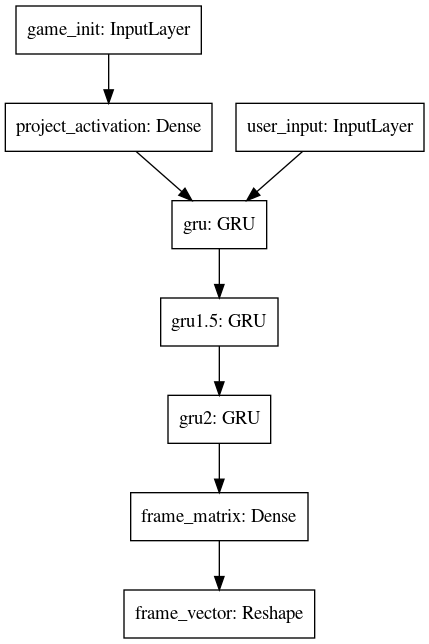

In [133]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [134]:
frame_nums = [2, 4, 8, 16, 32, 64, 127]

def plot_pairwise_frames():
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames,) = X, Y
    pred_frames = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0, w_pad=0, h_pad=0)

class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames()
        plt.show()

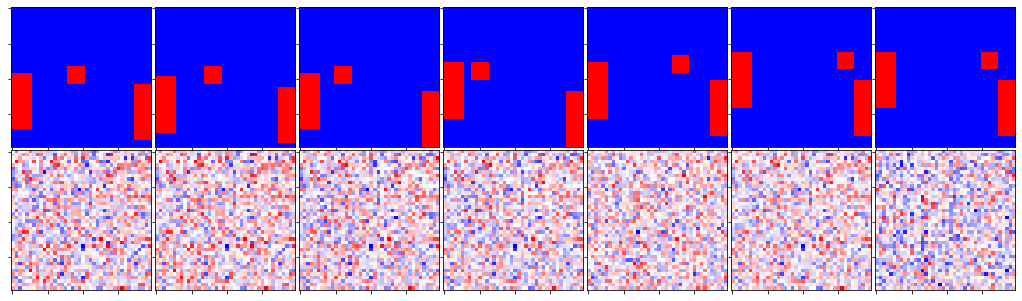

Epoch 1/2500
100/100 [==============================] - 93s 934ms/step - loss: 0.2772 - mean_squared_error: 0.0846 - acc: 0.9257 - val_loss: 0.1851 - val_mean_squared_error: 0.0514 - val_acc: 0.9322


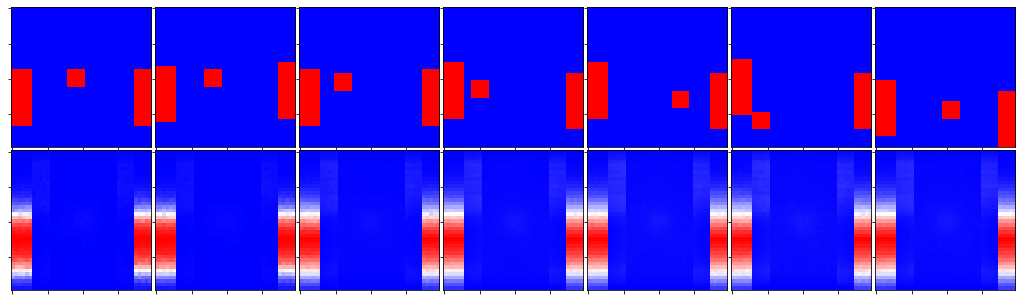

Epoch 2/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.1711 - mean_squared_error: 0.0472 - acc: 0.9384 - val_loss: 0.1614 - val_mean_squared_error: 0.0442 - val_acc: 0.9427


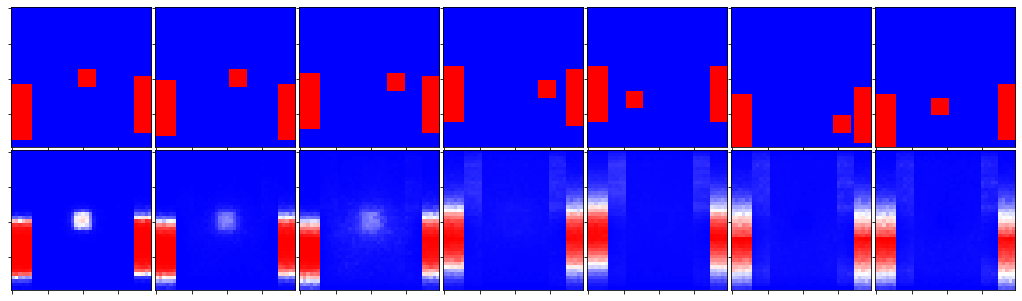

Epoch 3/2500
100/100 [==============================] - 84s 835ms/step - loss: 0.1552 - mean_squared_error: 0.0424 - acc: 0.9450 - val_loss: 0.1503 - val_mean_squared_error: 0.0405 - val_acc: 0.9482


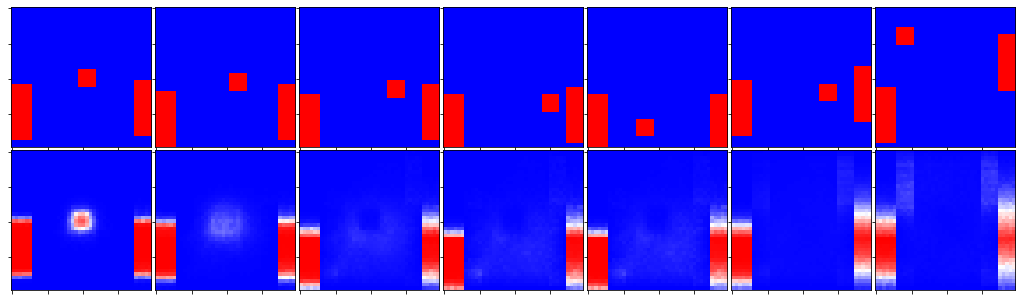

Epoch 4/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1433 - mean_squared_error: 0.0386 - acc: 0.9506 - val_loss: 0.1370 - val_mean_squared_error: 0.0363 - val_acc: 0.9540


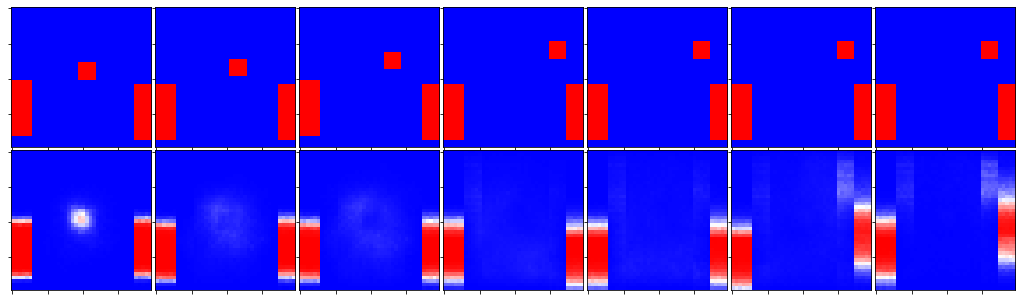

Epoch 5/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1321 - mean_squared_error: 0.0353 - acc: 0.9551 - val_loss: 0.1238 - val_mean_squared_error: 0.0327 - val_acc: 0.9589


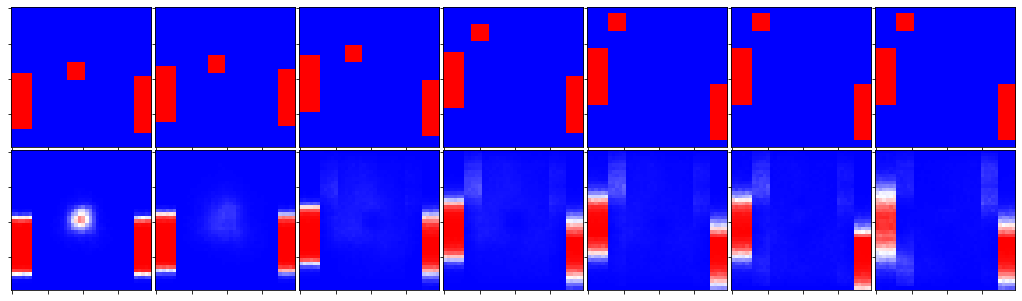

Epoch 6/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1232 - mean_squared_error: 0.0328 - acc: 0.9586 - val_loss: 0.1220 - val_mean_squared_error: 0.0320 - val_acc: 0.9604


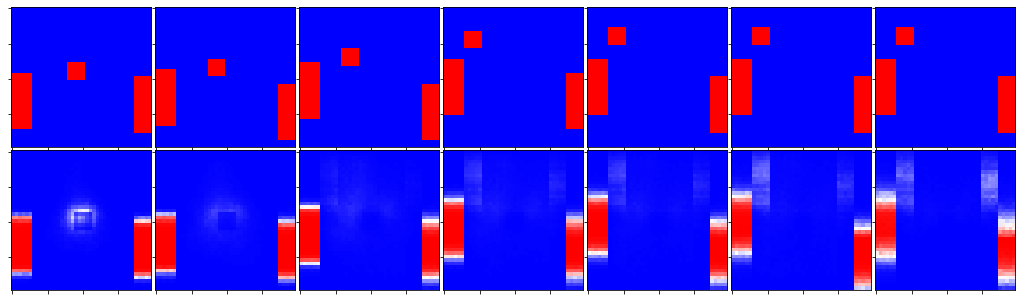

Epoch 7/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.1160 - mean_squared_error: 0.0308 - acc: 0.9613 - val_loss: 0.1153 - val_mean_squared_error: 0.0307 - val_acc: 0.9617


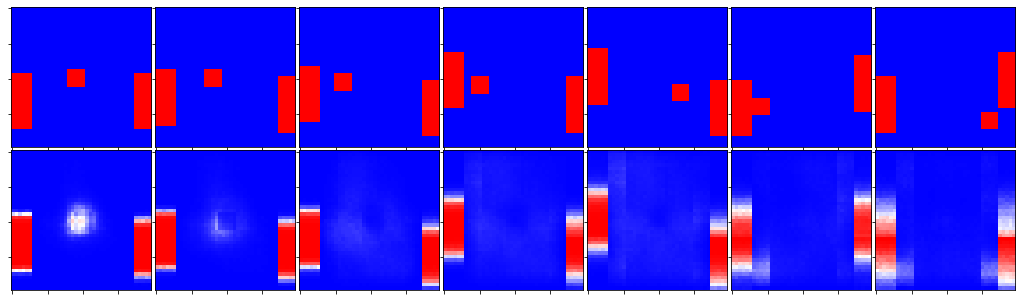

Epoch 8/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.1130 - mean_squared_error: 0.0300 - acc: 0.9622 - val_loss: 0.1130 - val_mean_squared_error: 0.0301 - val_acc: 0.9622


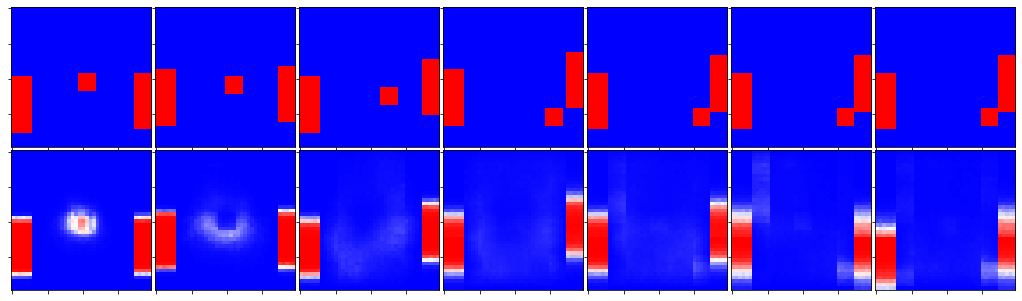

Epoch 9/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.1106 - mean_squared_error: 0.0295 - acc: 0.9628 - val_loss: 0.1126 - val_mean_squared_error: 0.0305 - val_acc: 0.9611


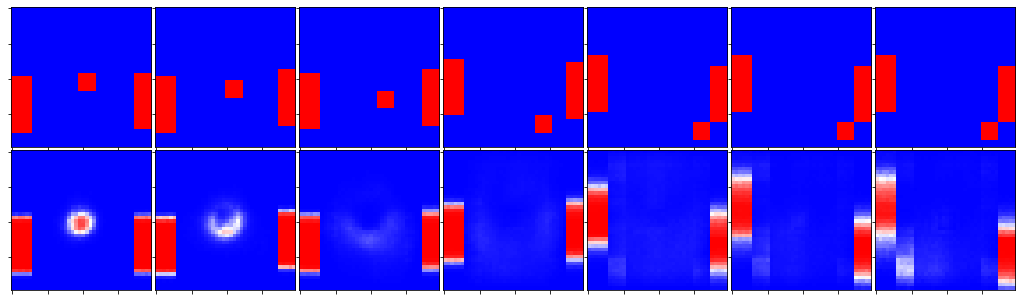

Epoch 10/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.1086 - mean_squared_error: 0.0289 - acc: 0.9634 - val_loss: 0.1114 - val_mean_squared_error: 0.0297 - val_acc: 0.9623


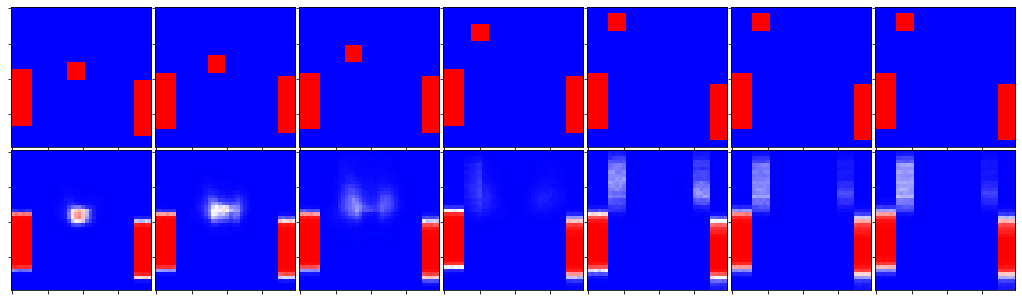

Epoch 11/2500
100/100 [==============================] - 83s 835ms/step - loss: 0.1082 - mean_squared_error: 0.0288 - acc: 0.9634 - val_loss: 0.1065 - val_mean_squared_error: 0.0282 - val_acc: 0.9643


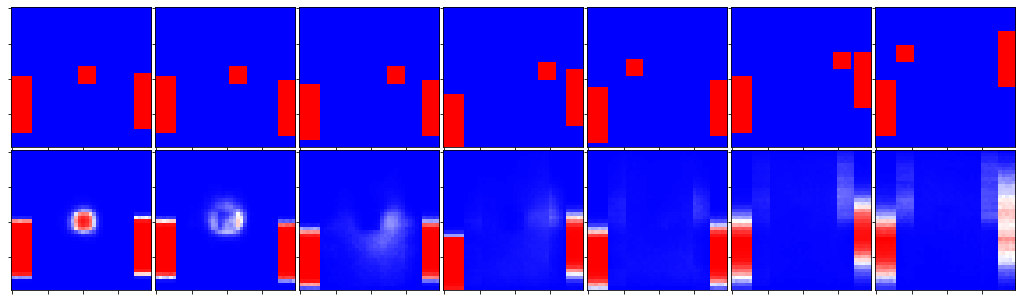

Epoch 12/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.1049 - mean_squared_error: 0.0280 - acc: 0.9643 - val_loss: 0.1088 - val_mean_squared_error: 0.0289 - val_acc: 0.9635


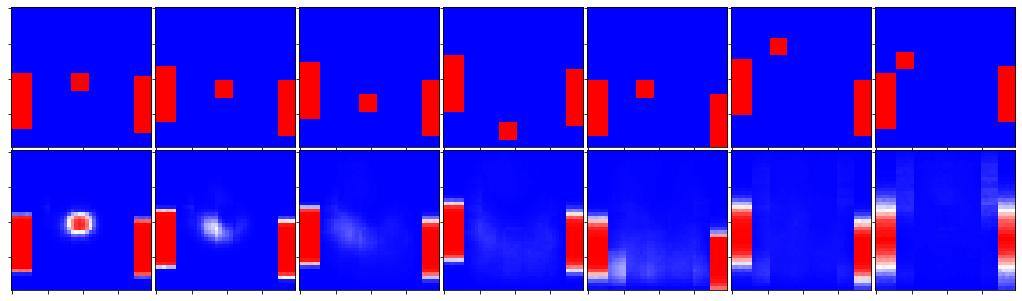

Epoch 13/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.1044 - mean_squared_error: 0.0279 - acc: 0.9645 - val_loss: 0.1054 - val_mean_squared_error: 0.0283 - val_acc: 0.9637


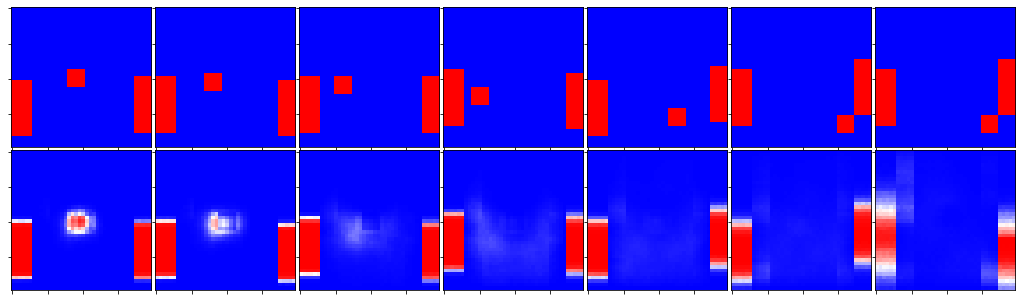

Epoch 14/2500
100/100 [==============================] - 84s 835ms/step - loss: 0.1021 - mean_squared_error: 0.0272 - acc: 0.9654 - val_loss: 0.1077 - val_mean_squared_error: 0.0290 - val_acc: 0.9631


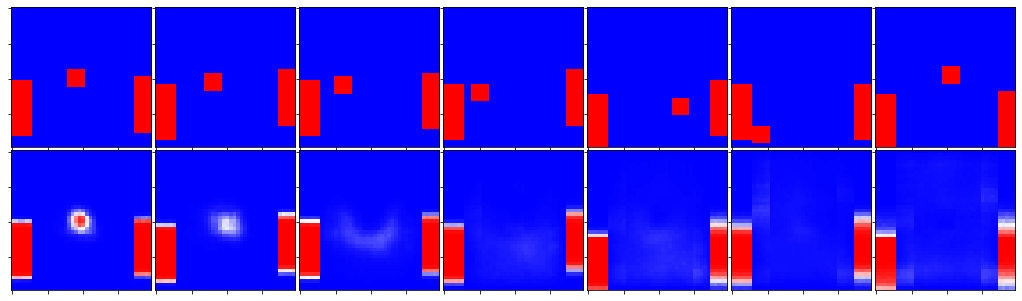

Epoch 15/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.1019 - mean_squared_error: 0.0272 - acc: 0.9653 - val_loss: 0.0933 - val_mean_squared_error: 0.0249 - val_acc: 0.9680


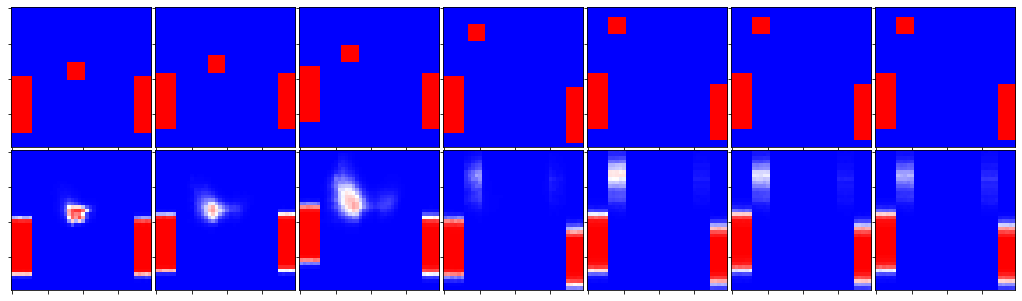

Epoch 16/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.1000 - mean_squared_error: 0.0268 - acc: 0.9657 - val_loss: 0.0969 - val_mean_squared_error: 0.0263 - val_acc: 0.9656


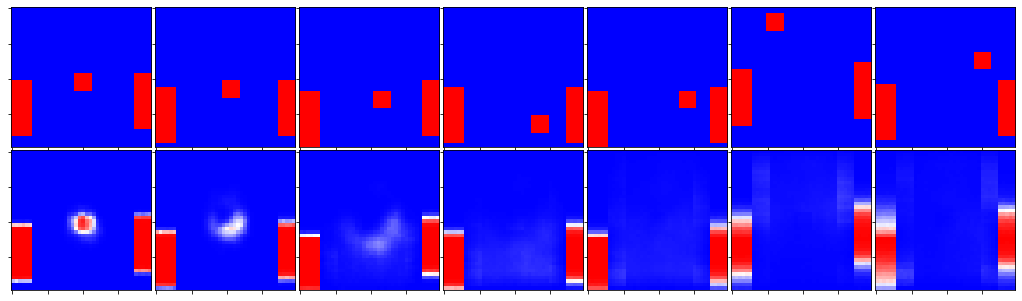

Epoch 17/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0982 - mean_squared_error: 0.0261 - acc: 0.9666 - val_loss: 0.0935 - val_mean_squared_error: 0.0254 - val_acc: 0.9666


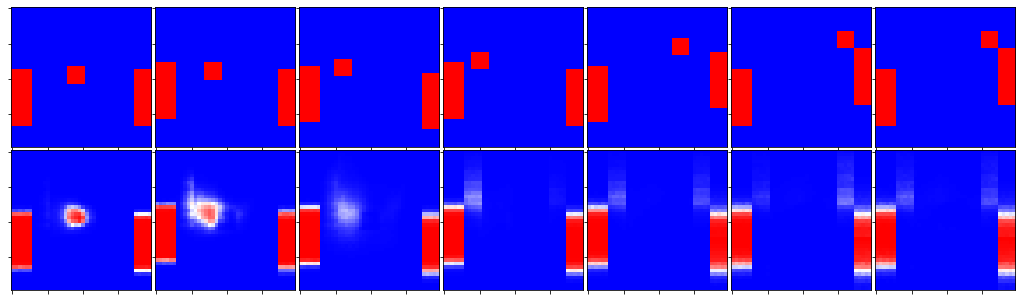

Epoch 18/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0974 - mean_squared_error: 0.0259 - acc: 0.9670 - val_loss: 0.0966 - val_mean_squared_error: 0.0252 - val_acc: 0.9683


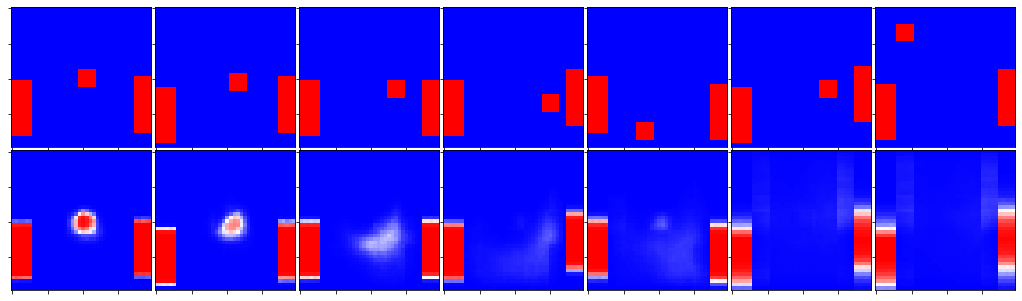

Epoch 19/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0966 - mean_squared_error: 0.0257 - acc: 0.9671 - val_loss: 0.0959 - val_mean_squared_error: 0.0252 - val_acc: 0.9684


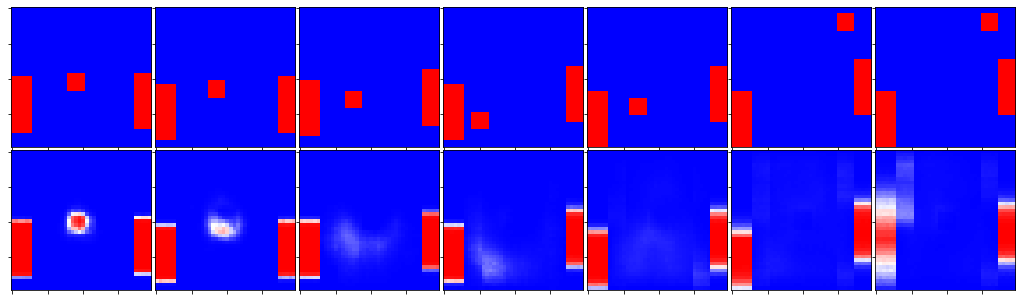

Epoch 20/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0956 - mean_squared_error: 0.0255 - acc: 0.9674 - val_loss: 0.0959 - val_mean_squared_error: 0.0257 - val_acc: 0.9667


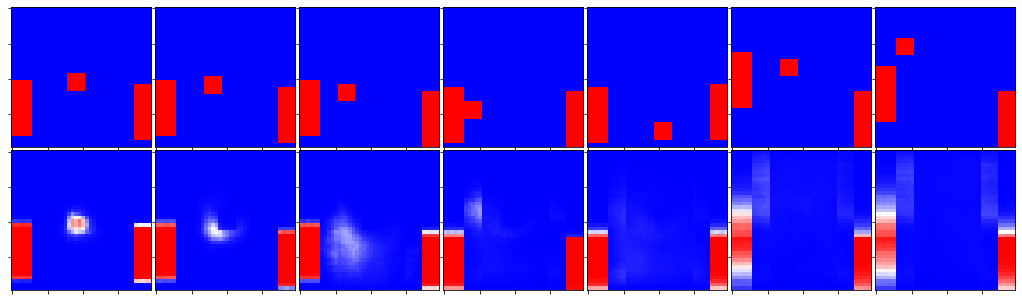

Epoch 21/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0948 - mean_squared_error: 0.0253 - acc: 0.9676 - val_loss: 0.0983 - val_mean_squared_error: 0.0261 - val_acc: 0.9665


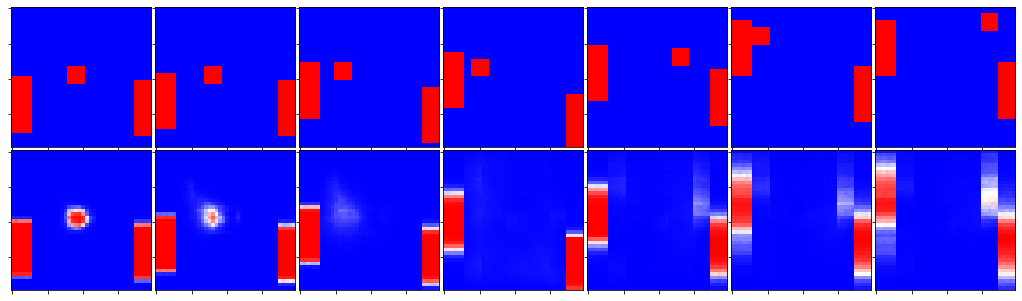

Epoch 22/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0937 - mean_squared_error: 0.0251 - acc: 0.9678 - val_loss: 0.0927 - val_mean_squared_error: 0.0246 - val_acc: 0.9687


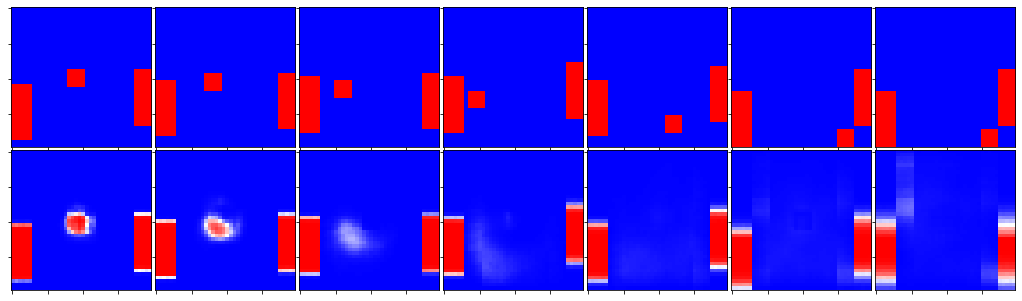

Epoch 23/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0934 - mean_squared_error: 0.0250 - acc: 0.9679 - val_loss: 0.0947 - val_mean_squared_error: 0.0253 - val_acc: 0.9679


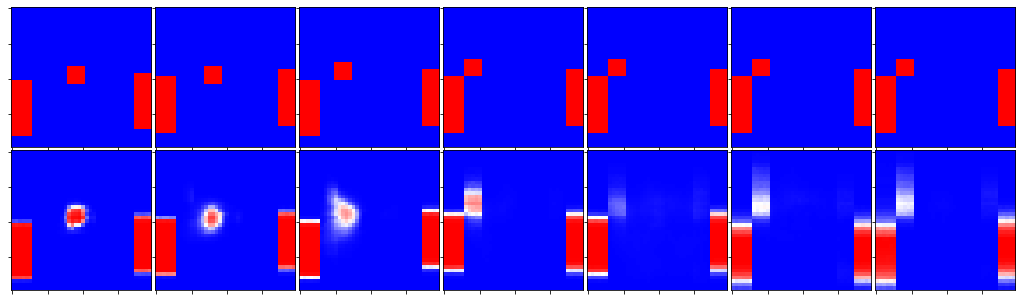

Epoch 24/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0917 - mean_squared_error: 0.0244 - acc: 0.9689 - val_loss: 0.0976 - val_mean_squared_error: 0.0260 - val_acc: 0.9665


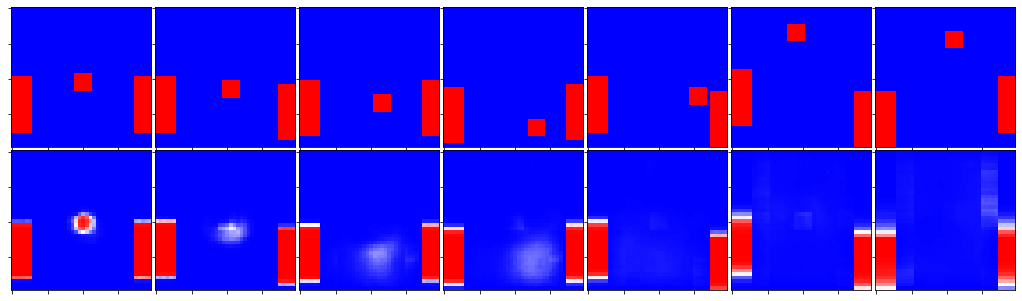

Epoch 25/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0904 - mean_squared_error: 0.0242 - acc: 0.9691 - val_loss: 0.0926 - val_mean_squared_error: 0.0248 - val_acc: 0.9680


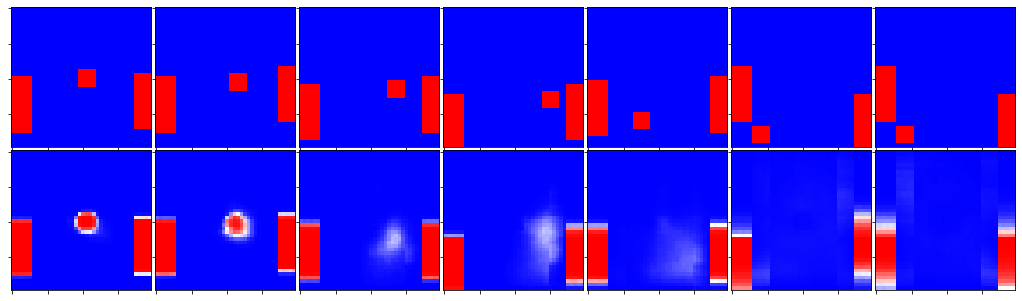

Epoch 26/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0897 - mean_squared_error: 0.0240 - acc: 0.9694 - val_loss: 0.1027 - val_mean_squared_error: 0.0280 - val_acc: 0.9637


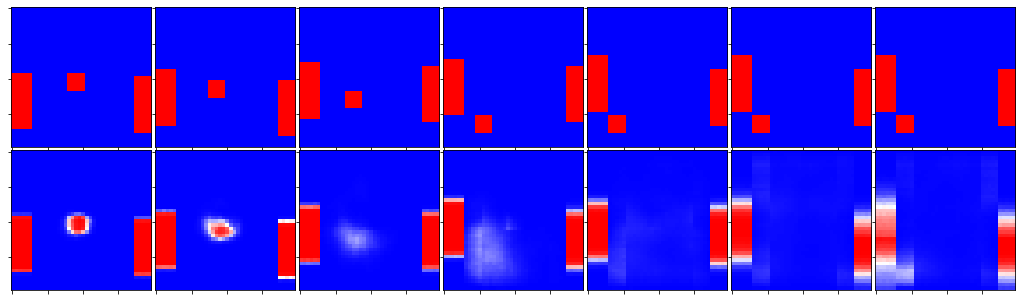

Epoch 27/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0895 - mean_squared_error: 0.0240 - acc: 0.9692 - val_loss: 0.0897 - val_mean_squared_error: 0.0241 - val_acc: 0.9692


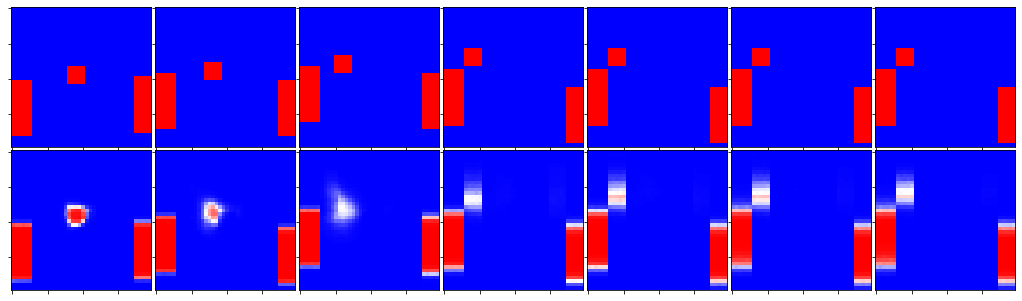

Epoch 28/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0888 - mean_squared_error: 0.0237 - acc: 0.9697 - val_loss: 0.0916 - val_mean_squared_error: 0.0244 - val_acc: 0.9690


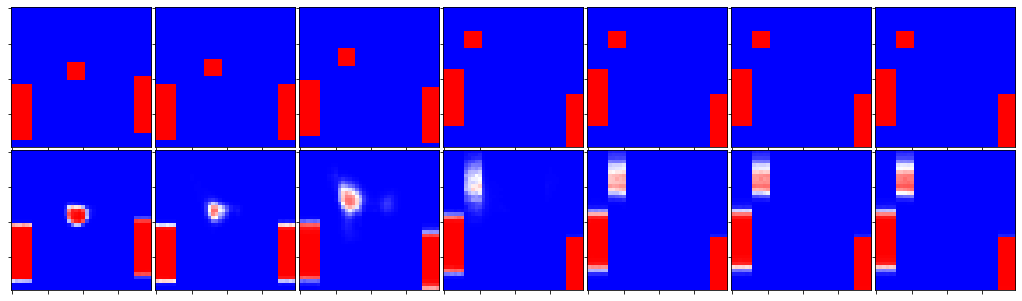

Epoch 29/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0886 - mean_squared_error: 0.0236 - acc: 0.9700 - val_loss: 0.0880 - val_mean_squared_error: 0.0233 - val_acc: 0.9704


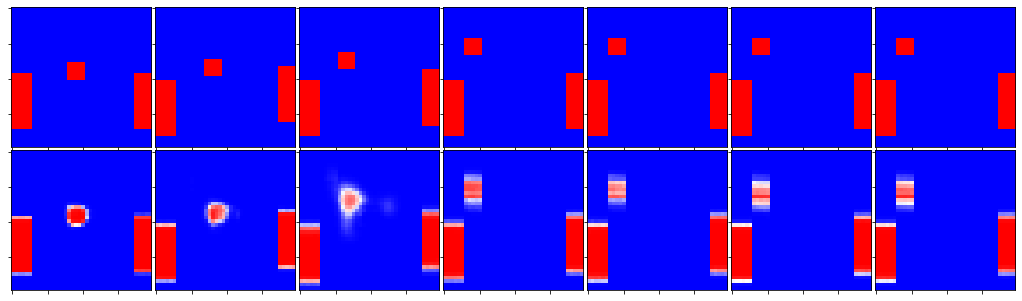

Epoch 30/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0870 - mean_squared_error: 0.0233 - acc: 0.9702 - val_loss: 0.0810 - val_mean_squared_error: 0.0220 - val_acc: 0.9717


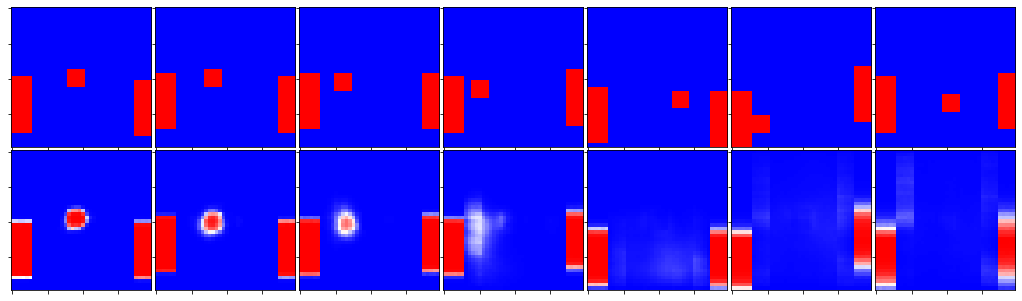

Epoch 31/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0867 - mean_squared_error: 0.0233 - acc: 0.9703 - val_loss: 0.0875 - val_mean_squared_error: 0.0235 - val_acc: 0.9698


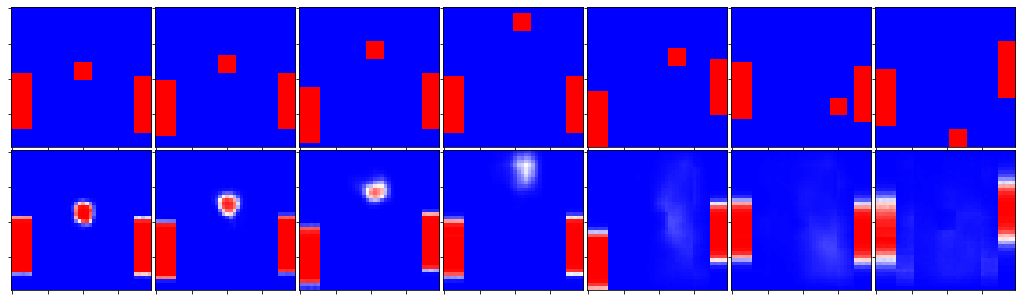

Epoch 32/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0870 - mean_squared_error: 0.0234 - acc: 0.9701 - val_loss: 0.0853 - val_mean_squared_error: 0.0227 - val_acc: 0.9711


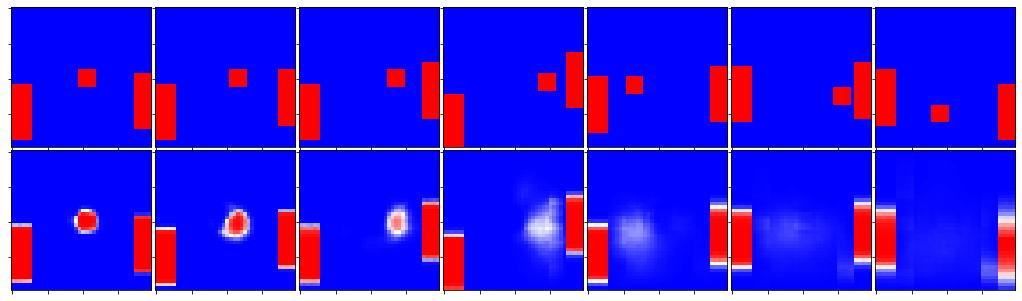

Epoch 33/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0855 - mean_squared_error: 0.0229 - acc: 0.9708 - val_loss: 0.0851 - val_mean_squared_error: 0.0231 - val_acc: 0.9701


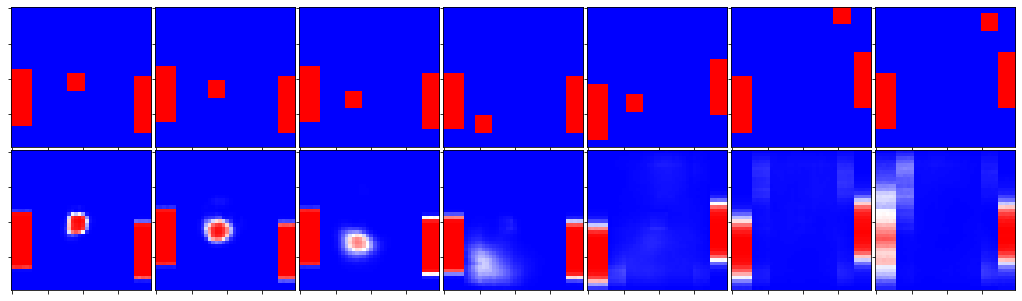

Epoch 34/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0875 - mean_squared_error: 0.0235 - acc: 0.9699 - val_loss: 0.0881 - val_mean_squared_error: 0.0242 - val_acc: 0.9688


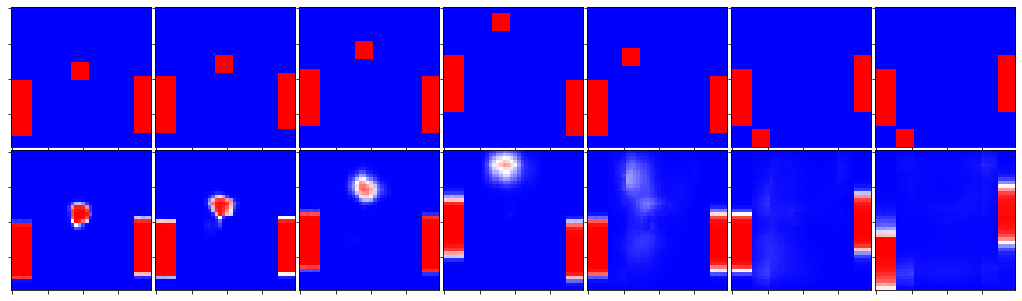

Epoch 35/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0841 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0869 - val_mean_squared_error: 0.0232 - val_acc: 0.9709


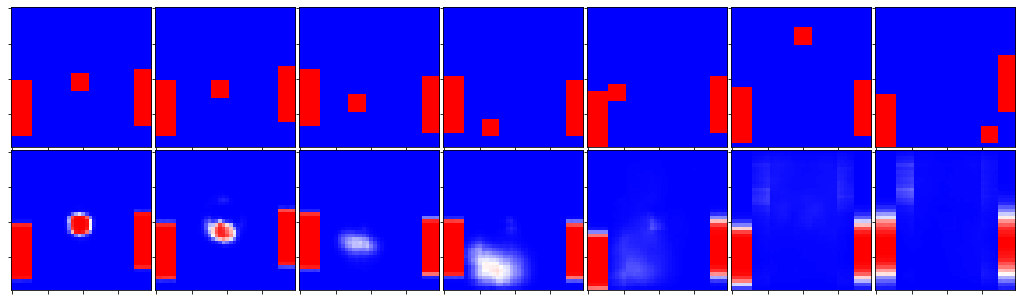

Epoch 36/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0830 - mean_squared_error: 0.0222 - acc: 0.9717 - val_loss: 0.0814 - val_mean_squared_error: 0.0220 - val_acc: 0.9716


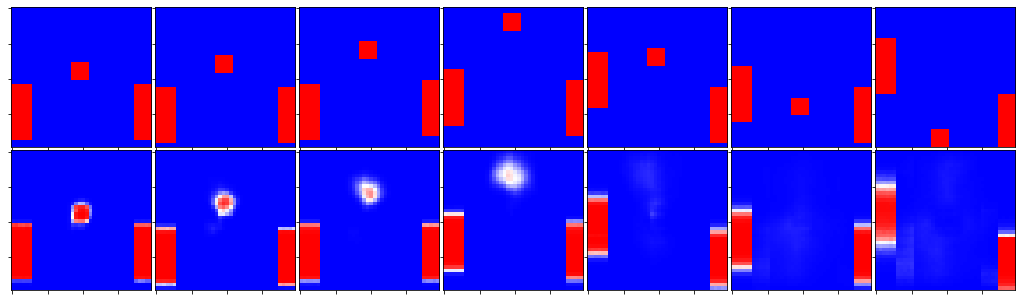

Epoch 37/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0833 - mean_squared_error: 0.0223 - acc: 0.9717 - val_loss: 0.0809 - val_mean_squared_error: 0.0222 - val_acc: 0.9716


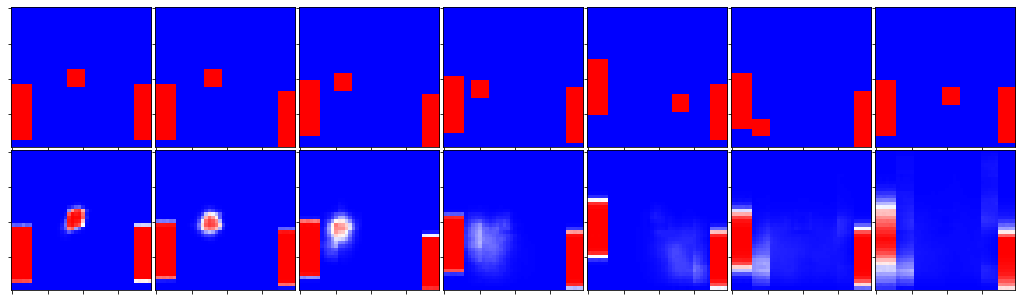

Epoch 38/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0830 - mean_squared_error: 0.0223 - acc: 0.9717 - val_loss: 0.0854 - val_mean_squared_error: 0.0230 - val_acc: 0.9708


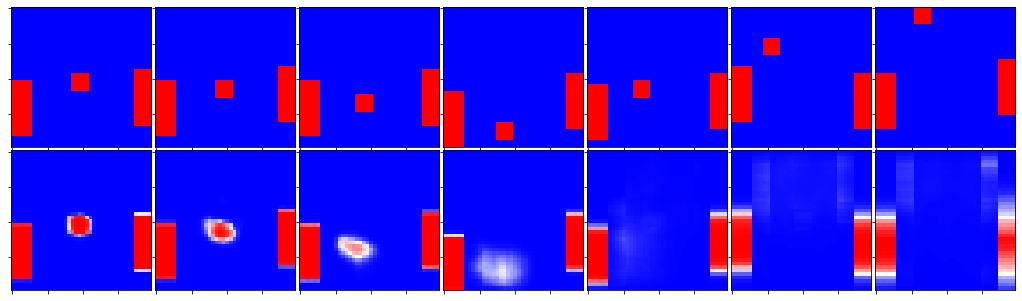

Epoch 39/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0835 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0894 - val_mean_squared_error: 0.0244 - val_acc: 0.9687


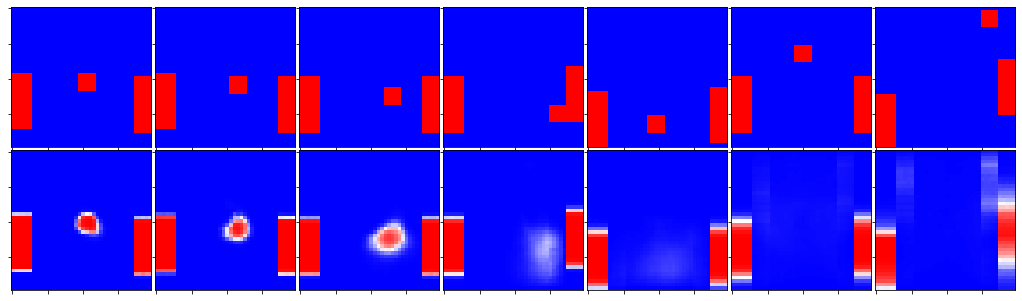

Epoch 40/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0825 - mean_squared_error: 0.0223 - acc: 0.9715 - val_loss: 0.0903 - val_mean_squared_error: 0.0237 - val_acc: 0.9697


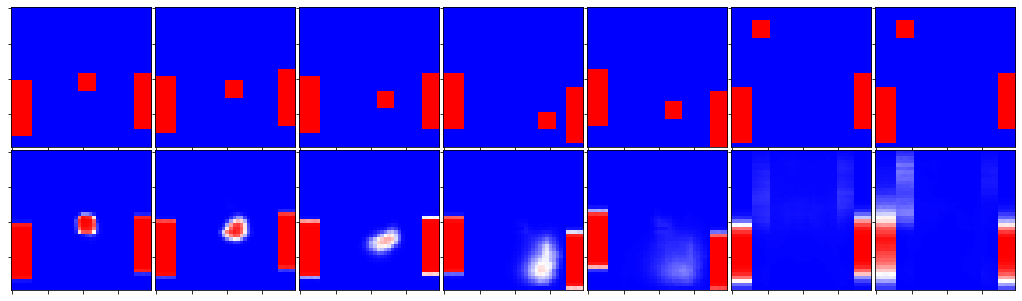

Epoch 41/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0825 - mean_squared_error: 0.0222 - acc: 0.9717 - val_loss: 0.0845 - val_mean_squared_error: 0.0225 - val_acc: 0.9717


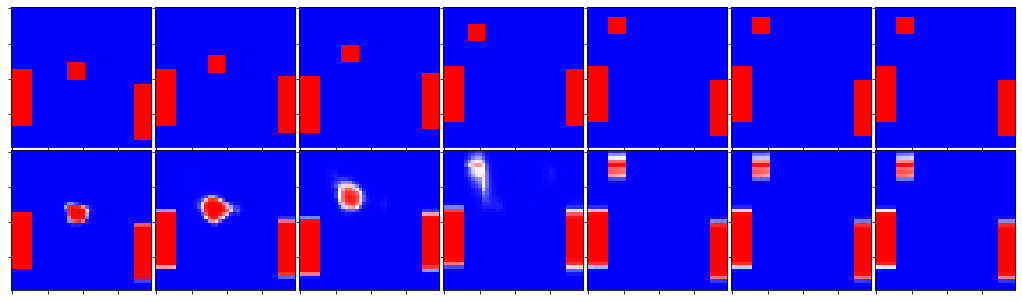

Epoch 42/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0834 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0833 - val_mean_squared_error: 0.0227 - val_acc: 0.9705


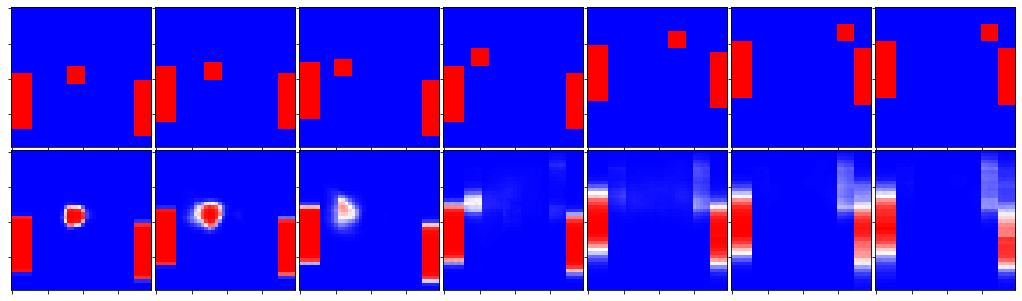

Epoch 43/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0798 - mean_squared_error: 0.0215 - acc: 0.9727 - val_loss: 0.0756 - val_mean_squared_error: 0.0208 - val_acc: 0.9734


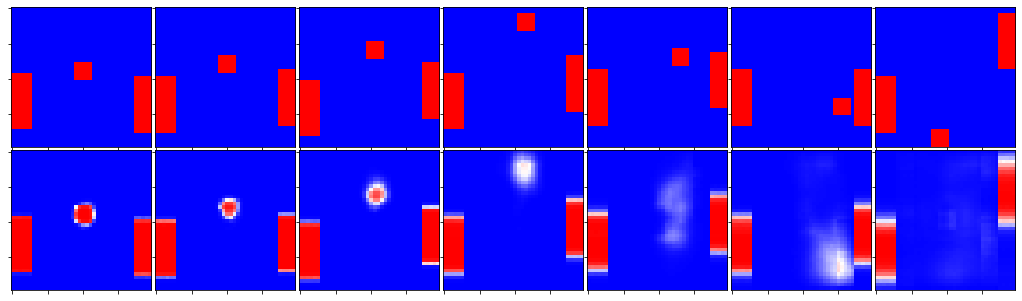

Epoch 44/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0804 - mean_squared_error: 0.0218 - acc: 0.9721 - val_loss: 0.0779 - val_mean_squared_error: 0.0206 - val_acc: 0.9740


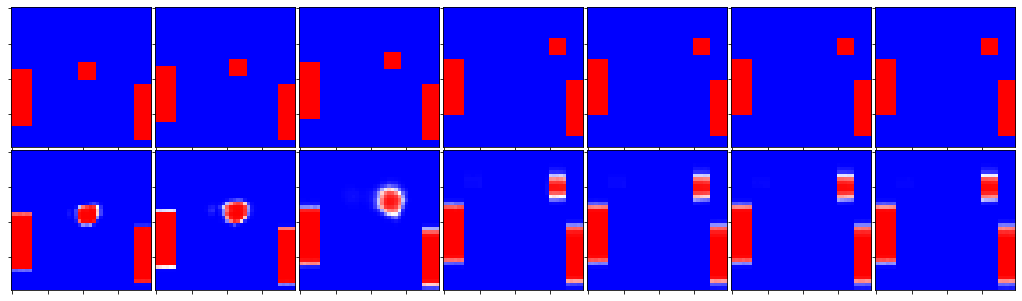

Epoch 45/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0785 - mean_squared_error: 0.0212 - acc: 0.9729 - val_loss: 0.0824 - val_mean_squared_error: 0.0225 - val_acc: 0.9712


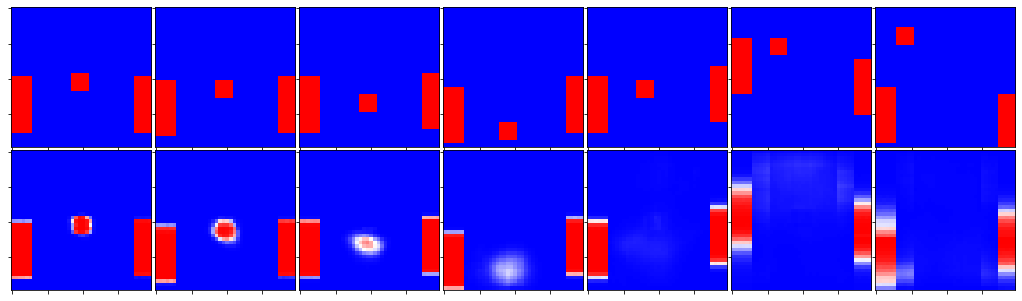

Epoch 46/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0782 - mean_squared_error: 0.0212 - acc: 0.9729 - val_loss: 0.0877 - val_mean_squared_error: 0.0239 - val_acc: 0.9696


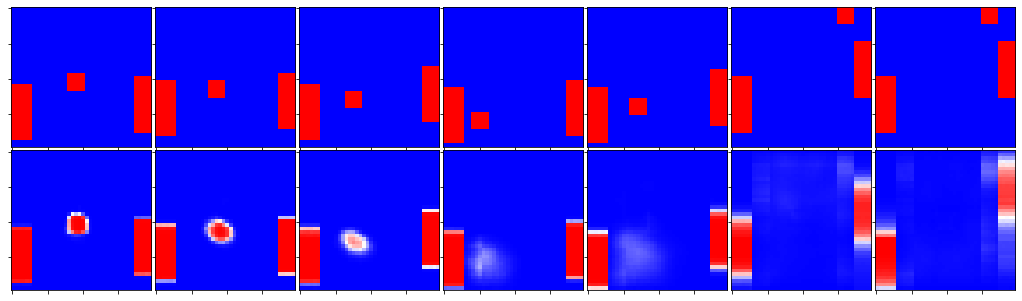

Epoch 47/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0780 - mean_squared_error: 0.0211 - acc: 0.9730 - val_loss: 0.0721 - val_mean_squared_error: 0.0197 - val_acc: 0.9748


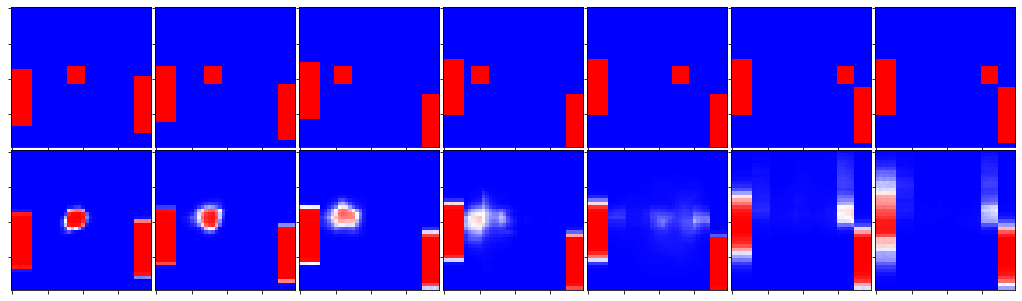

Epoch 48/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0774 - mean_squared_error: 0.0211 - acc: 0.9730 - val_loss: 0.0795 - val_mean_squared_error: 0.0219 - val_acc: 0.9721


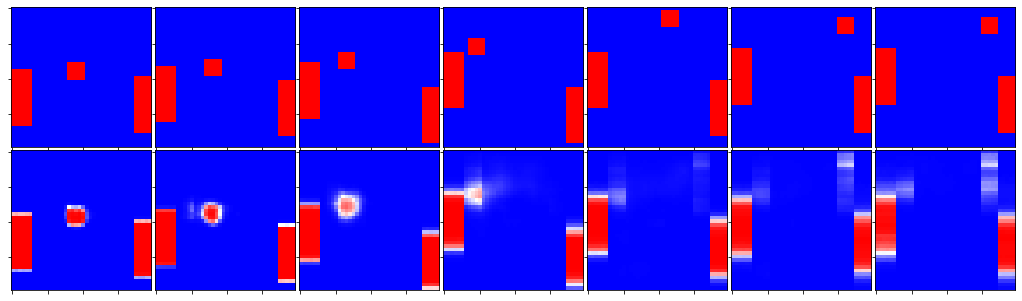

Epoch 49/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0779 - mean_squared_error: 0.0212 - acc: 0.9728 - val_loss: 0.0752 - val_mean_squared_error: 0.0203 - val_acc: 0.9740


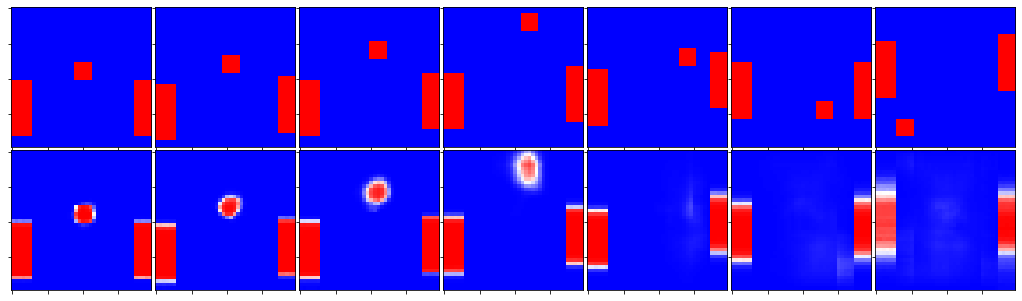

Epoch 50/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0761 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0709 - val_mean_squared_error: 0.0191 - val_acc: 0.9756


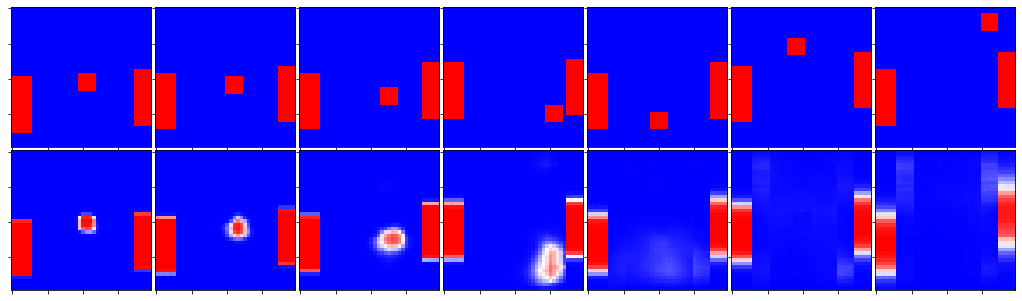

Epoch 51/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0762 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0713 - val_mean_squared_error: 0.0195 - val_acc: 0.9752


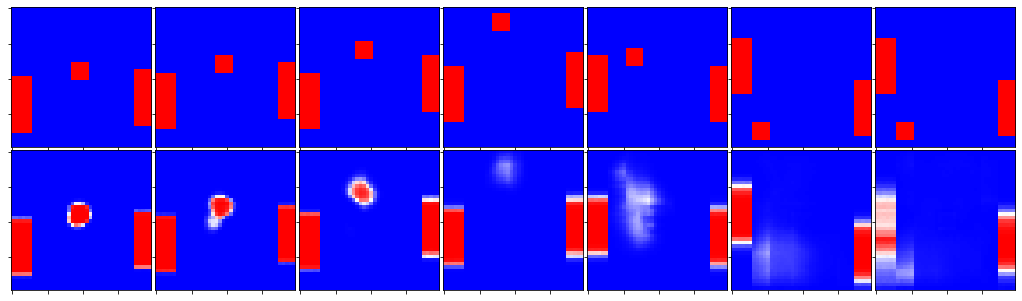

Epoch 52/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0760 - mean_squared_error: 0.0206 - acc: 0.9737 - val_loss: 0.0731 - val_mean_squared_error: 0.0198 - val_acc: 0.9748


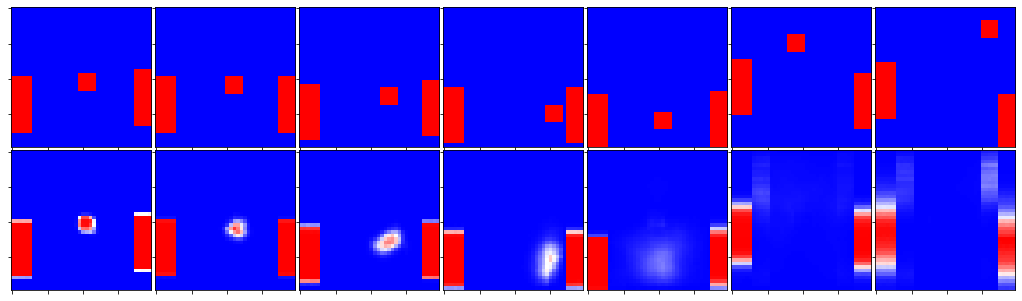

Epoch 53/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0754 - mean_squared_error: 0.0206 - acc: 0.9736 - val_loss: 0.0764 - val_mean_squared_error: 0.0211 - val_acc: 0.9726


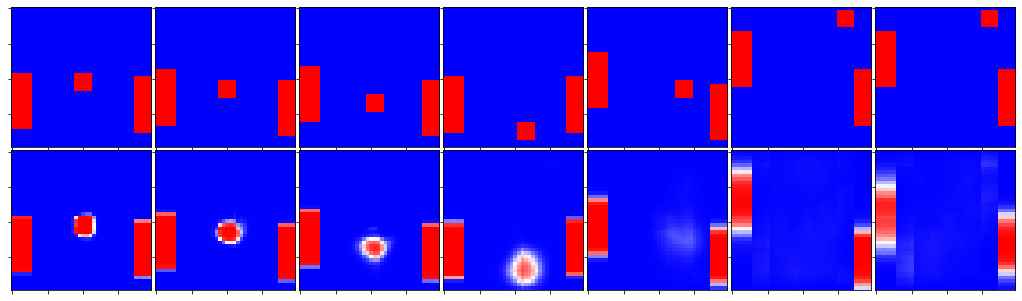

Epoch 54/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0747 - mean_squared_error: 0.0204 - acc: 0.9740 - val_loss: 0.0790 - val_mean_squared_error: 0.0215 - val_acc: 0.9725


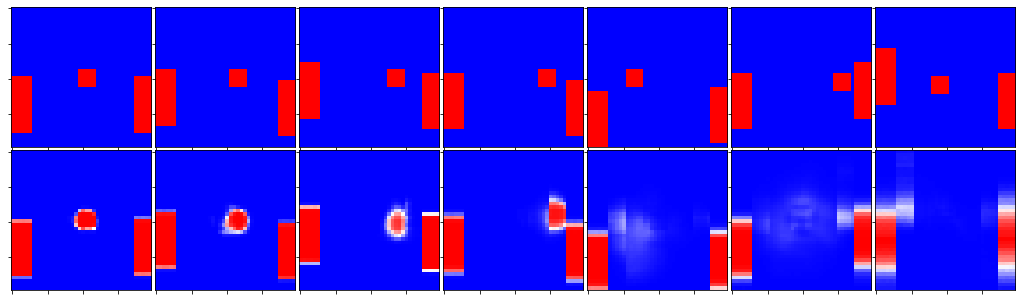

Epoch 55/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0747 - mean_squared_error: 0.0205 - acc: 0.9736 - val_loss: 0.0818 - val_mean_squared_error: 0.0231 - val_acc: 0.9696


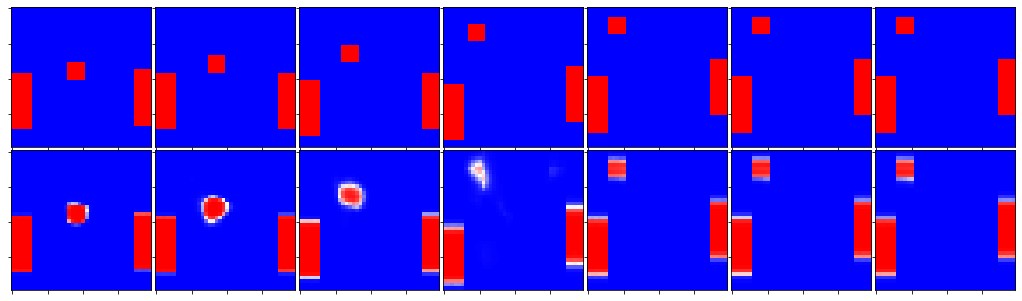

Epoch 56/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0741 - mean_squared_error: 0.0203 - acc: 0.9741 - val_loss: 0.0723 - val_mean_squared_error: 0.0202 - val_acc: 0.9739


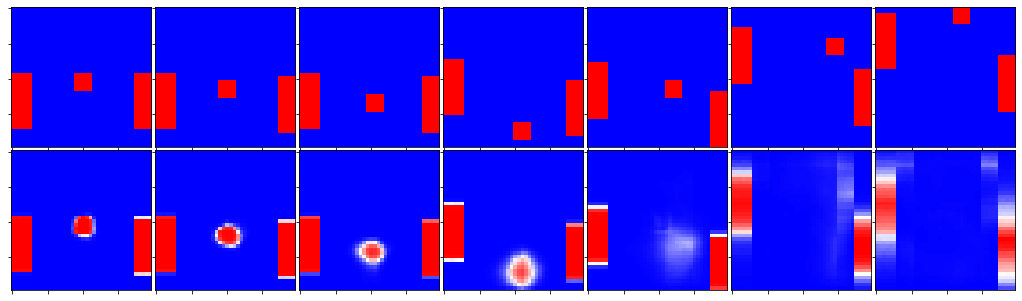

Epoch 57/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0729 - mean_squared_error: 0.0201 - acc: 0.9741 - val_loss: 0.0743 - val_mean_squared_error: 0.0206 - val_acc: 0.9731


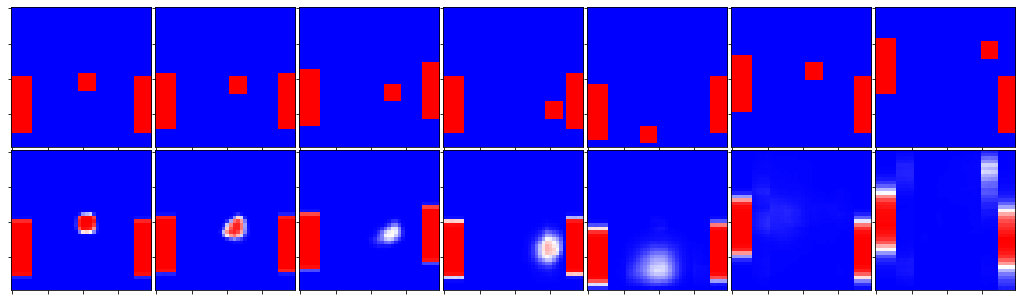

Epoch 58/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0726 - mean_squared_error: 0.0199 - acc: 0.9745 - val_loss: 0.0751 - val_mean_squared_error: 0.0206 - val_acc: 0.9737


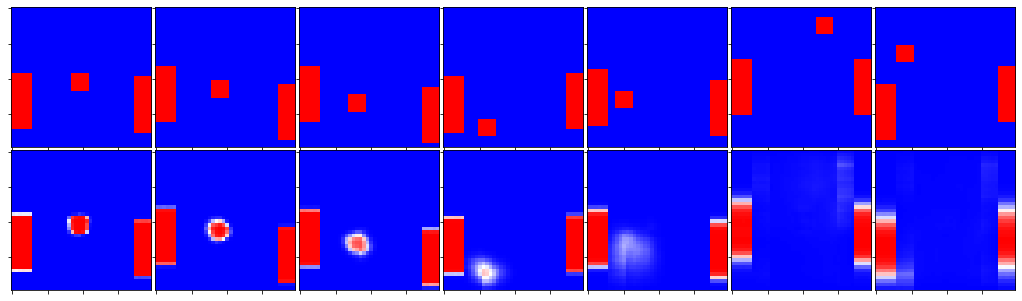

Epoch 59/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0734 - mean_squared_error: 0.0202 - acc: 0.9739 - val_loss: 0.0690 - val_mean_squared_error: 0.0189 - val_acc: 0.9758


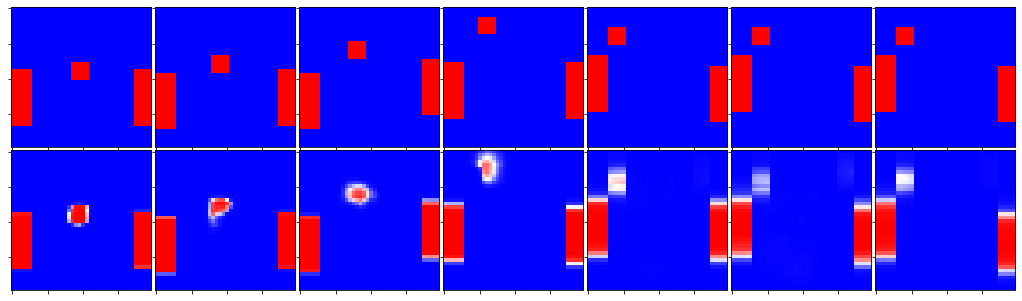

Epoch 60/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0713 - mean_squared_error: 0.0196 - acc: 0.9748 - val_loss: 0.0737 - val_mean_squared_error: 0.0203 - val_acc: 0.9740


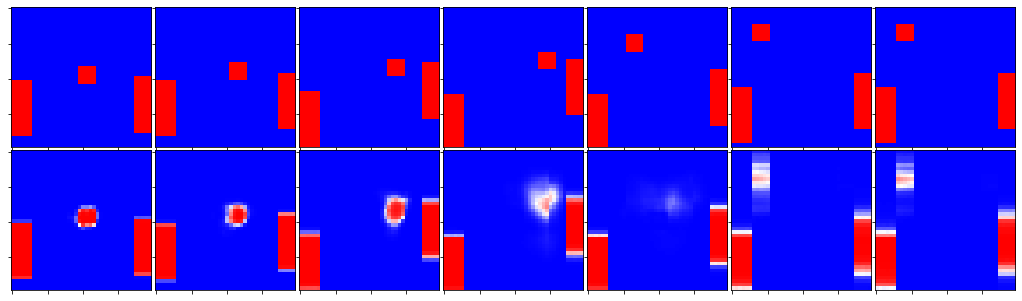

Epoch 61/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0710 - mean_squared_error: 0.0195 - acc: 0.9749 - val_loss: 0.0747 - val_mean_squared_error: 0.0206 - val_acc: 0.9730


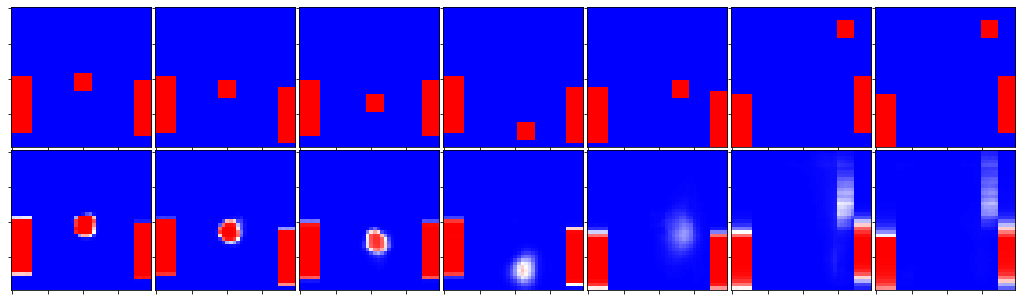

Epoch 62/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0717 - mean_squared_error: 0.0198 - acc: 0.9745 - val_loss: 0.0741 - val_mean_squared_error: 0.0202 - val_acc: 0.9740


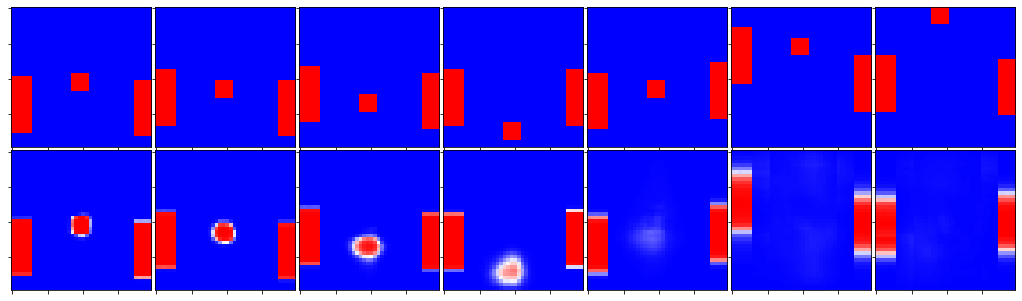

Epoch 63/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0701 - mean_squared_error: 0.0193 - acc: 0.9752 - val_loss: 0.0682 - val_mean_squared_error: 0.0189 - val_acc: 0.9755


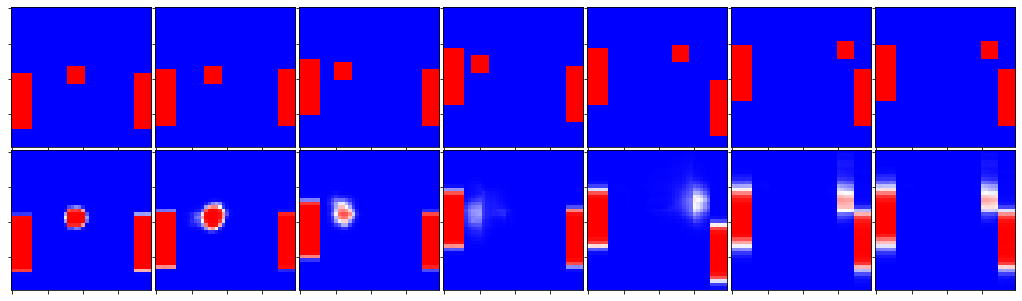

Epoch 64/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0697 - mean_squared_error: 0.0193 - acc: 0.9752 - val_loss: 0.0710 - val_mean_squared_error: 0.0194 - val_acc: 0.9750


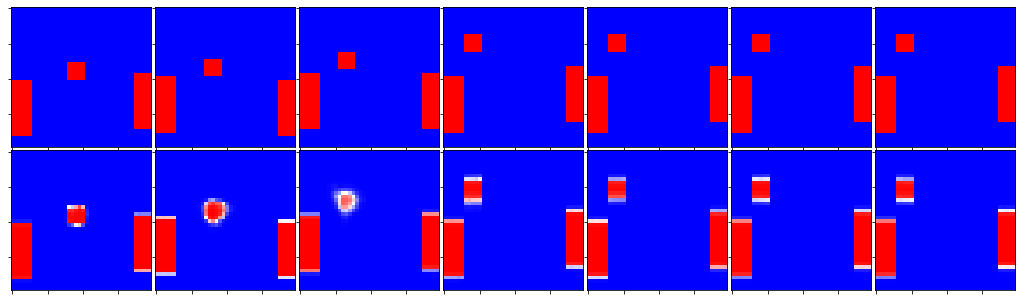

Epoch 65/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0694 - mean_squared_error: 0.0192 - acc: 0.9753 - val_loss: 0.0707 - val_mean_squared_error: 0.0193 - val_acc: 0.9756


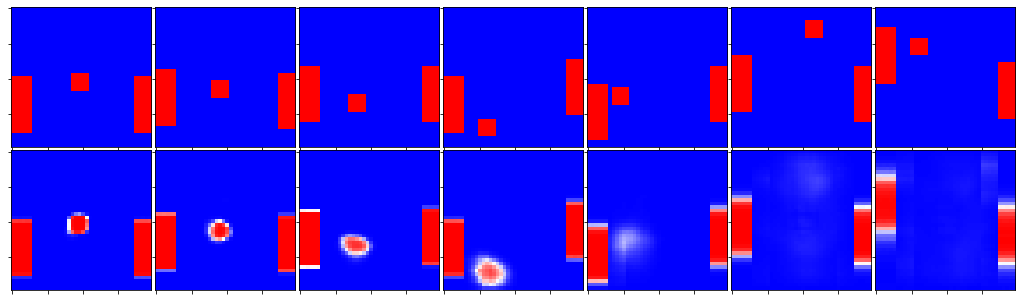

Epoch 66/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0705 - mean_squared_error: 0.0194 - acc: 0.9749 - val_loss: 0.0729 - val_mean_squared_error: 0.0201 - val_acc: 0.9741


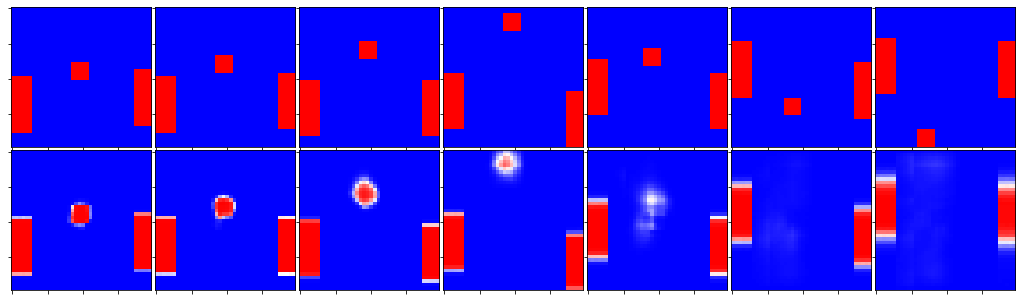

Epoch 67/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0693 - mean_squared_error: 0.0191 - acc: 0.9754 - val_loss: 0.0654 - val_mean_squared_error: 0.0182 - val_acc: 0.9762


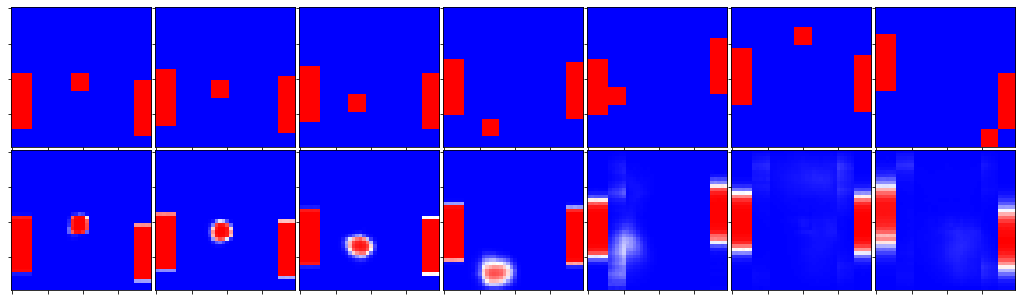

Epoch 68/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0680 - mean_squared_error: 0.0187 - acc: 0.9760 - val_loss: 0.0656 - val_mean_squared_error: 0.0180 - val_acc: 0.9768


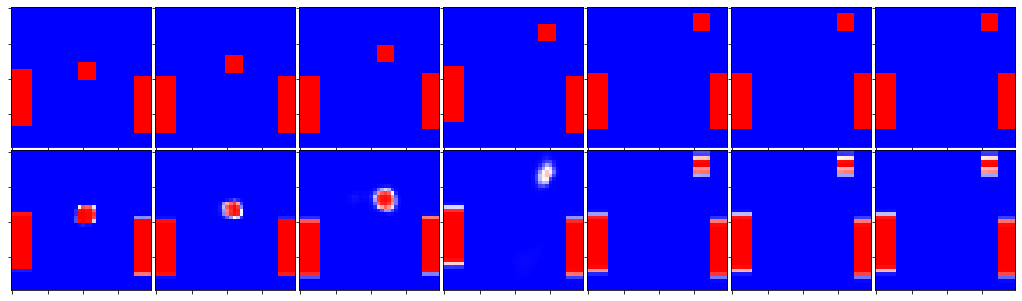

Epoch 69/2500
100/100 [==============================] - 81s 814ms/step - loss: 0.0682 - mean_squared_error: 0.0188 - acc: 0.9758 - val_loss: 0.0679 - val_mean_squared_error: 0.0187 - val_acc: 0.9759


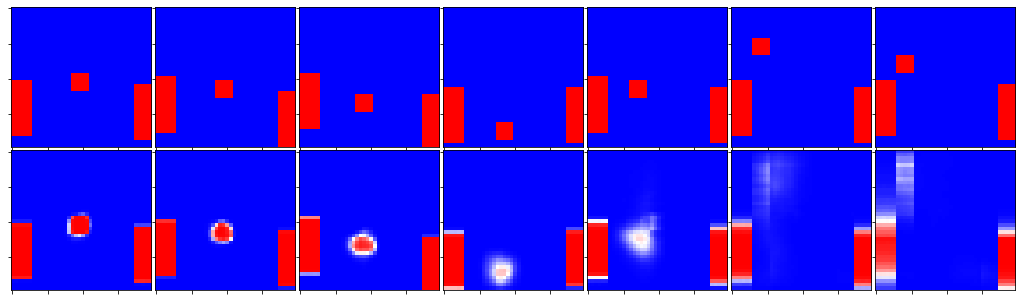

Epoch 70/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0695 - mean_squared_error: 0.0192 - acc: 0.9752 - val_loss: 0.0602 - val_mean_squared_error: 0.0166 - val_acc: 0.9783


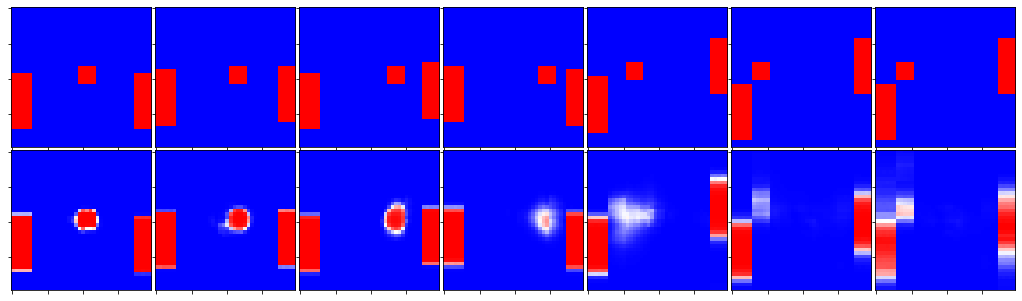

Epoch 71/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0677 - mean_squared_error: 0.0188 - acc: 0.9758 - val_loss: 0.0682 - val_mean_squared_error: 0.0187 - val_acc: 0.9759


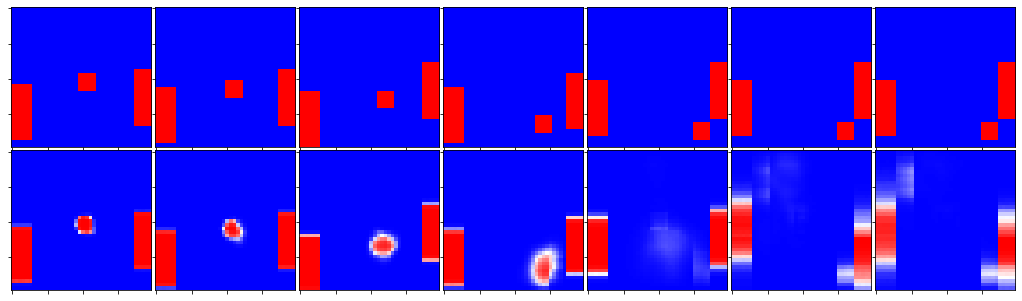

Epoch 72/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0684 - mean_squared_error: 0.0190 - acc: 0.9754 - val_loss: 0.0681 - val_mean_squared_error: 0.0189 - val_acc: 0.9759


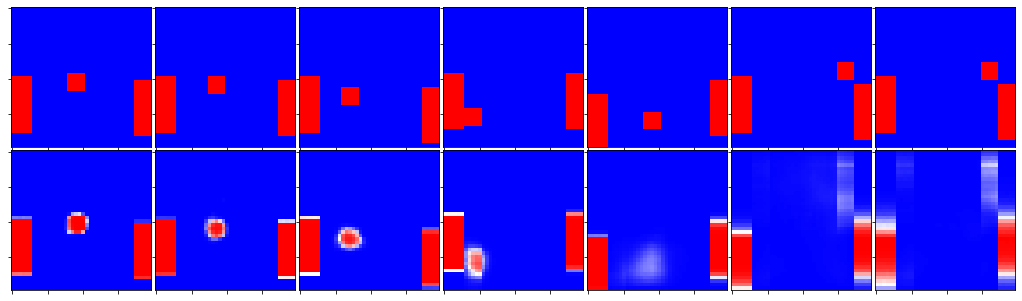

Epoch 73/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0671 - mean_squared_error: 0.0186 - acc: 0.9759 - val_loss: 0.0667 - val_mean_squared_error: 0.0189 - val_acc: 0.9754


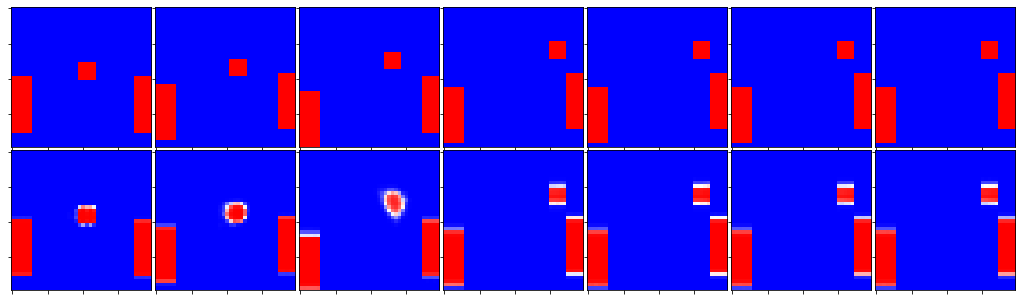

Epoch 74/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0670 - mean_squared_error: 0.0185 - acc: 0.9762 - val_loss: 0.0640 - val_mean_squared_error: 0.0179 - val_acc: 0.9764


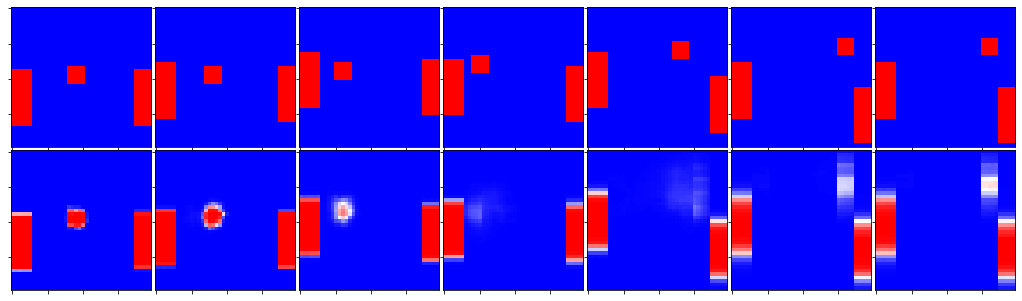

Epoch 75/2500
100/100 [==============================] - 81s 813ms/step - loss: 0.0668 - mean_squared_error: 0.0185 - acc: 0.9761 - val_loss: 0.0633 - val_mean_squared_error: 0.0174 - val_acc: 0.9779


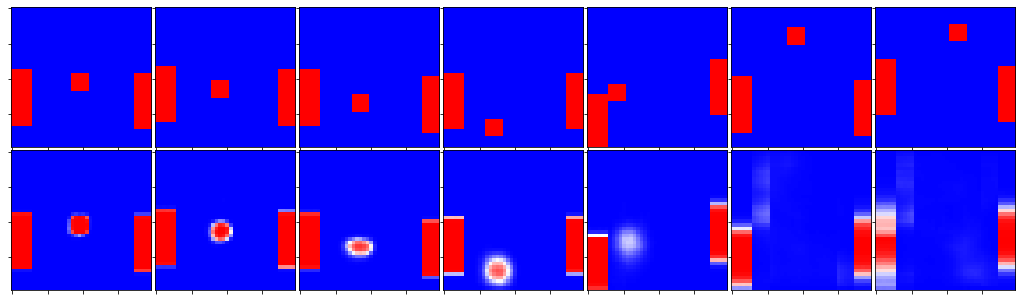

Epoch 76/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0669 - mean_squared_error: 0.0186 - acc: 0.9759 - val_loss: 0.0692 - val_mean_squared_error: 0.0191 - val_acc: 0.9752


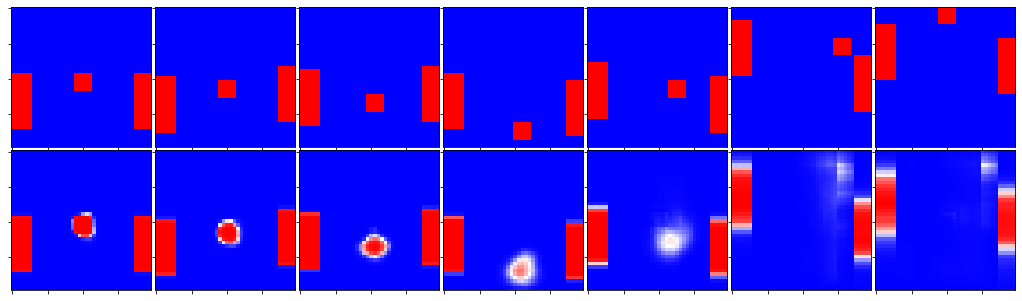

Epoch 77/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0665 - mean_squared_error: 0.0184 - acc: 0.9763 - val_loss: 0.0642 - val_mean_squared_error: 0.0183 - val_acc: 0.9761


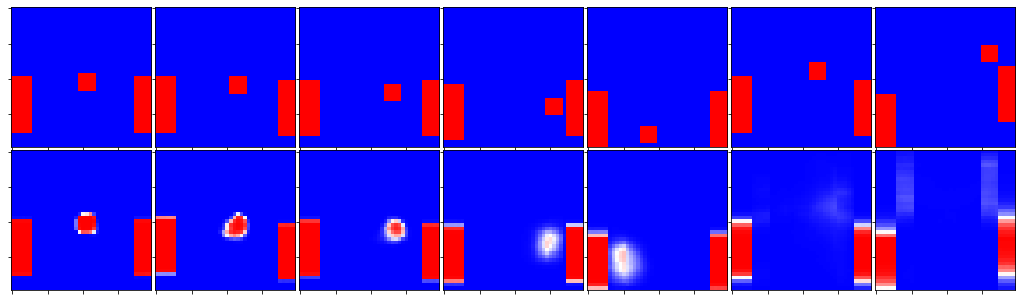

Epoch 78/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0650 - mean_squared_error: 0.0180 - acc: 0.9768 - val_loss: 0.0629 - val_mean_squared_error: 0.0173 - val_acc: 0.9778


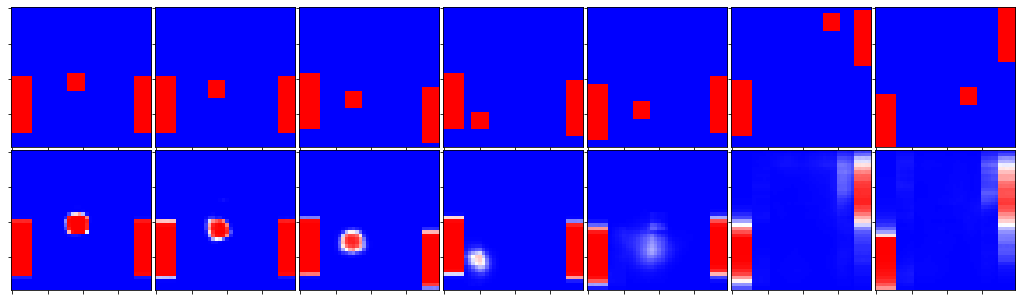

Epoch 79/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0658 - mean_squared_error: 0.0182 - acc: 0.9766 - val_loss: 0.0735 - val_mean_squared_error: 0.0190 - val_acc: 0.9762


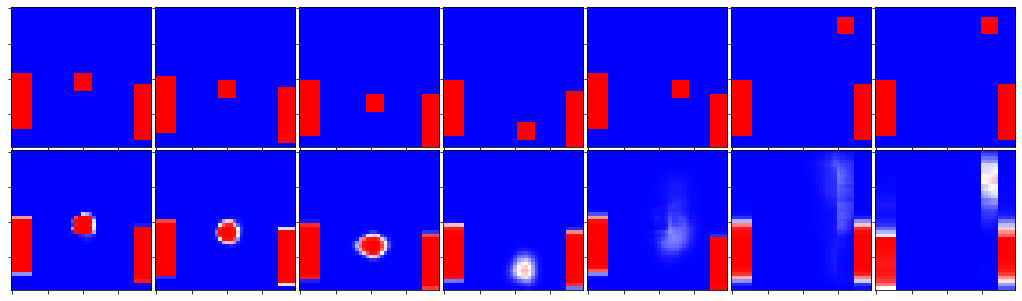

Epoch 80/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0635 - mean_squared_error: 0.0177 - acc: 0.9770 - val_loss: 0.0704 - val_mean_squared_error: 0.0192 - val_acc: 0.9754


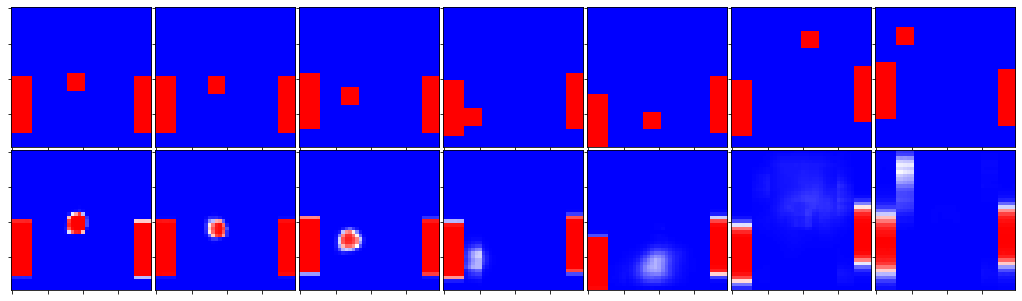

Epoch 81/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0651 - mean_squared_error: 0.0181 - acc: 0.9766 - val_loss: 0.0626 - val_mean_squared_error: 0.0176 - val_acc: 0.9770


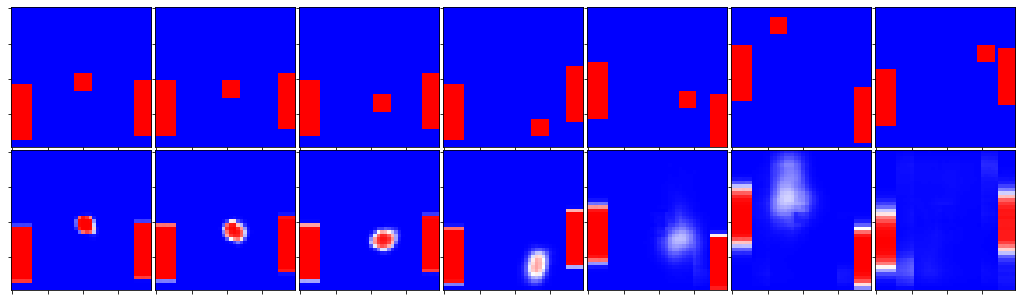

Epoch 82/2500
100/100 [==============================] - 81s 814ms/step - loss: 0.0648 - mean_squared_error: 0.0180 - acc: 0.9766 - val_loss: 0.0631 - val_mean_squared_error: 0.0176 - val_acc: 0.9773


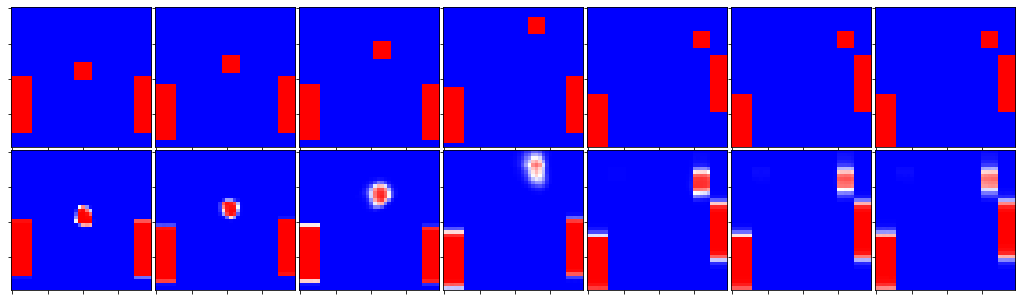

Epoch 83/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0631 - mean_squared_error: 0.0175 - acc: 0.9775 - val_loss: 0.0641 - val_mean_squared_error: 0.0172 - val_acc: 0.9781


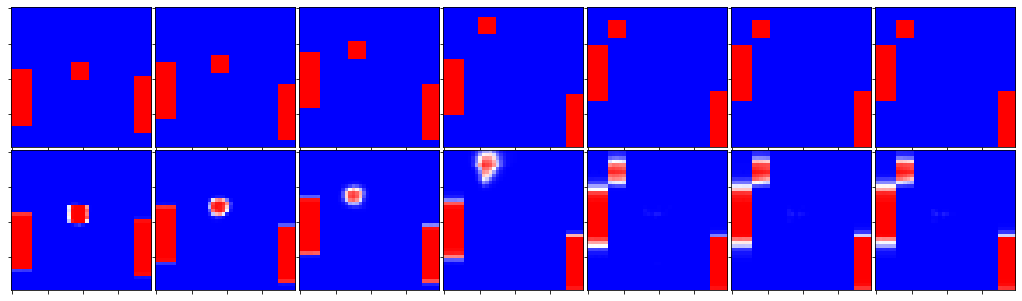

Epoch 84/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0641 - mean_squared_error: 0.0179 - acc: 0.9768 - val_loss: 0.0597 - val_mean_squared_error: 0.0165 - val_acc: 0.9789


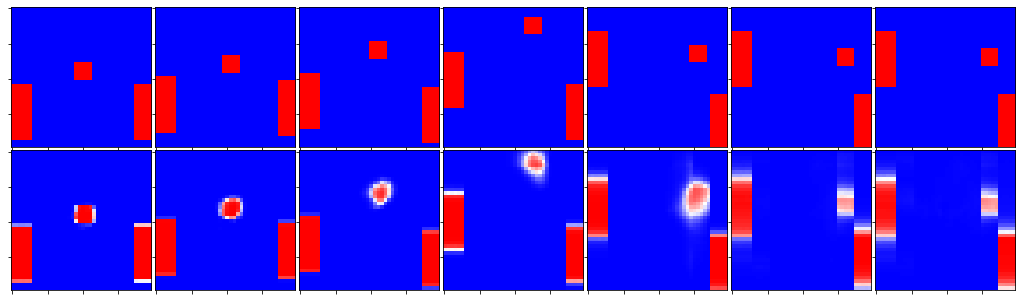

Epoch 85/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0630 - mean_squared_error: 0.0176 - acc: 0.9772 - val_loss: 0.0625 - val_mean_squared_error: 0.0175 - val_acc: 0.9771


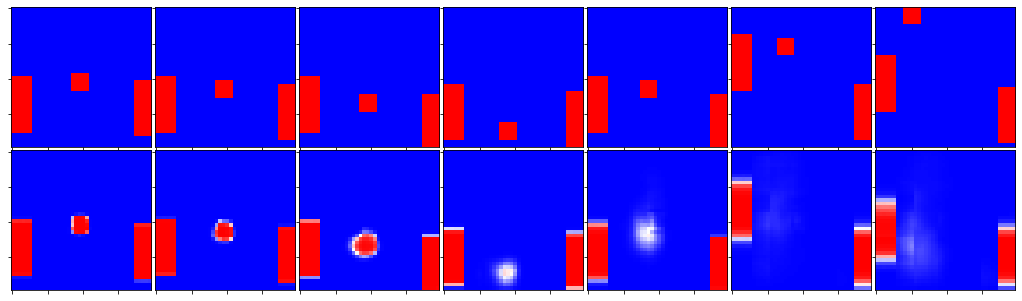

Epoch 86/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0651 - mean_squared_error: 0.0181 - acc: 0.9765 - val_loss: 0.0630 - val_mean_squared_error: 0.0171 - val_acc: 0.9785


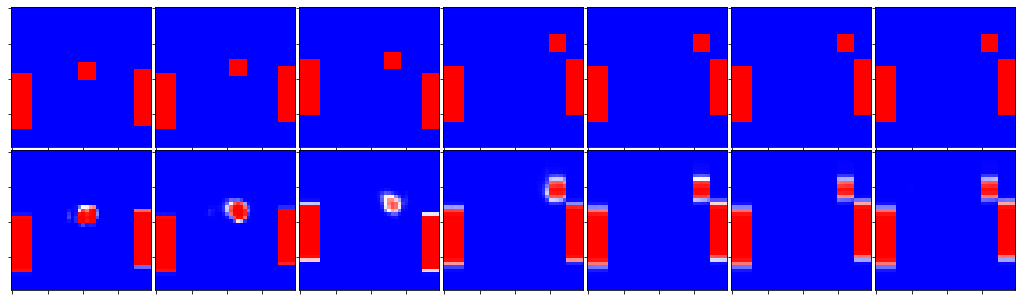

Epoch 87/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0626 - mean_squared_error: 0.0174 - acc: 0.9775 - val_loss: 0.0555 - val_mean_squared_error: 0.0160 - val_acc: 0.9785


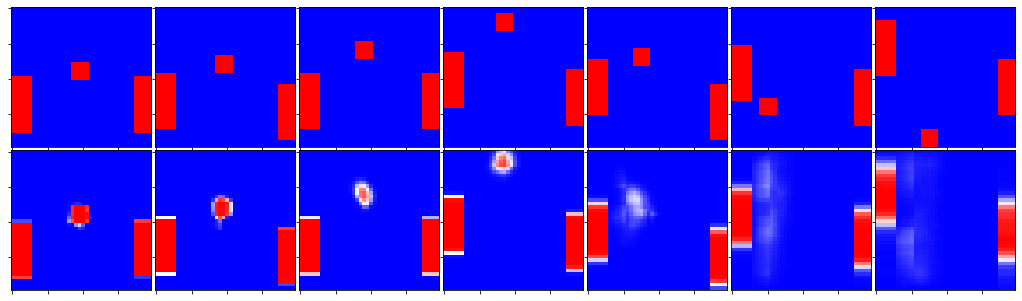

Epoch 88/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0629 - mean_squared_error: 0.0175 - acc: 0.9772 - val_loss: 0.0598 - val_mean_squared_error: 0.0167 - val_acc: 0.9785


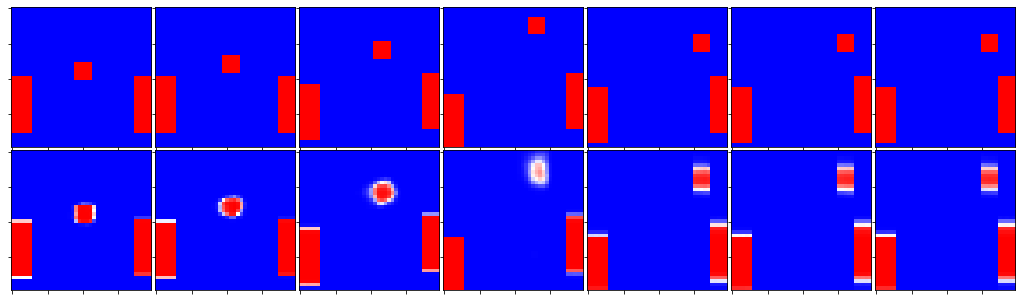

Epoch 89/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0641 - mean_squared_error: 0.0179 - acc: 0.9767 - val_loss: 0.0721 - val_mean_squared_error: 0.0196 - val_acc: 0.9746


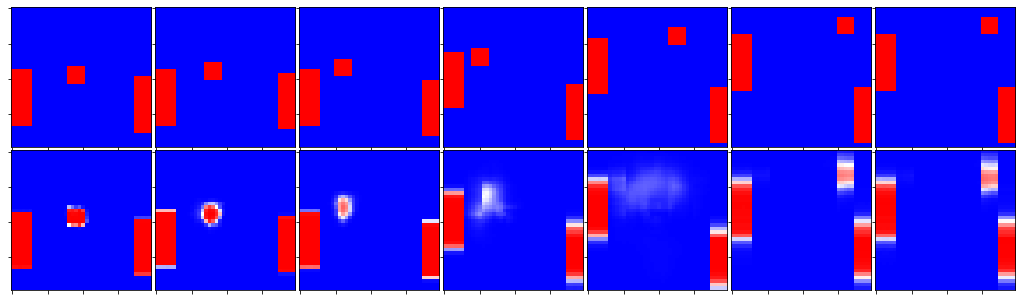

Epoch 90/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0651 - mean_squared_error: 0.0180 - acc: 0.9767 - val_loss: 0.0676 - val_mean_squared_error: 0.0187 - val_acc: 0.9758


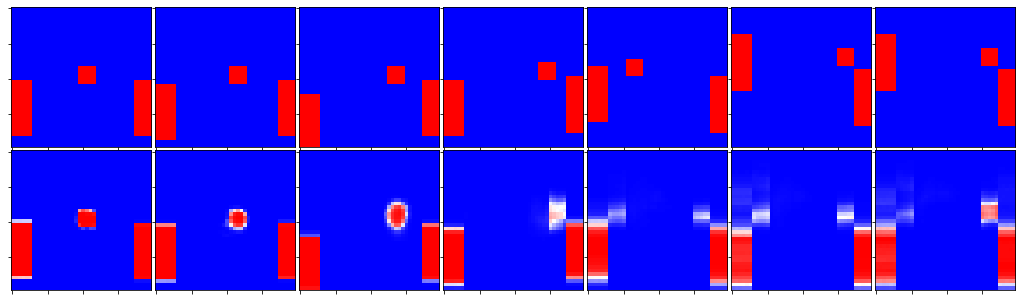

Epoch 91/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0617 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0608 - val_mean_squared_error: 0.0174 - val_acc: 0.9773


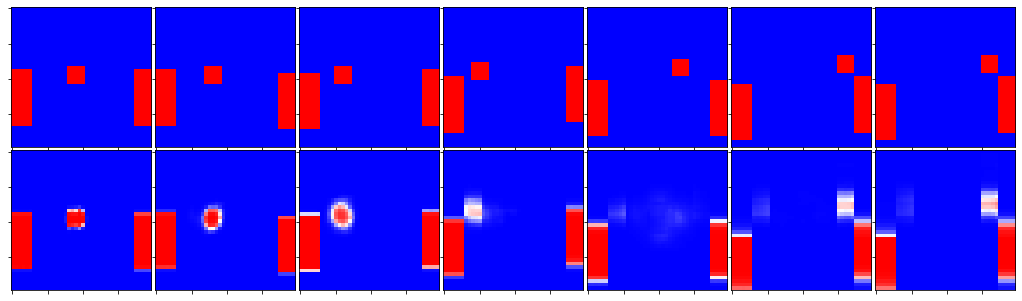

Epoch 92/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0614 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0595 - val_mean_squared_error: 0.0165 - val_acc: 0.9789


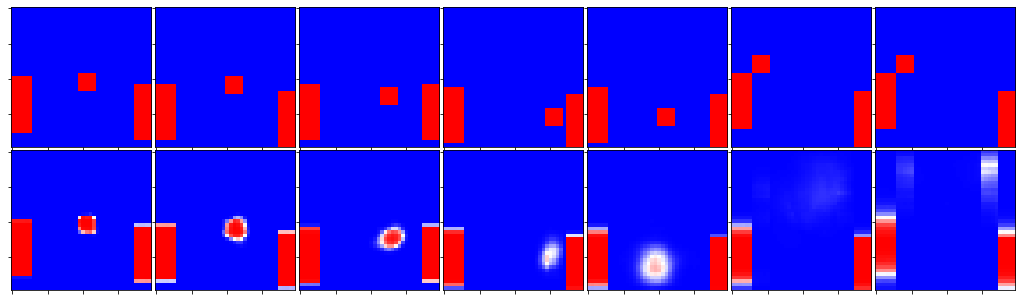

Epoch 93/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0603 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0604 - val_mean_squared_error: 0.0167 - val_acc: 0.9786


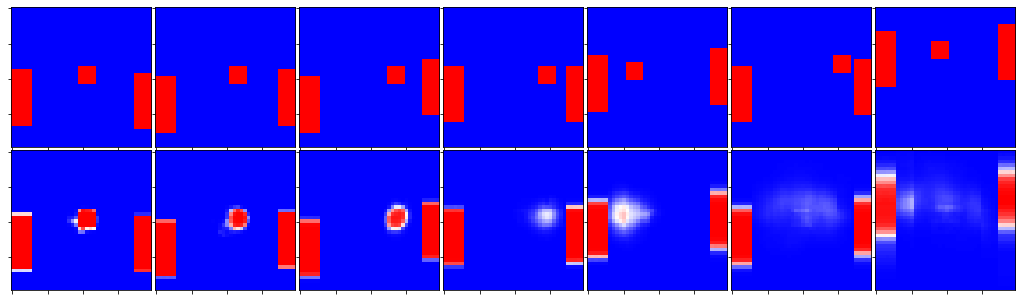

Epoch 94/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0614 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0619 - val_mean_squared_error: 0.0171 - val_acc: 0.9782


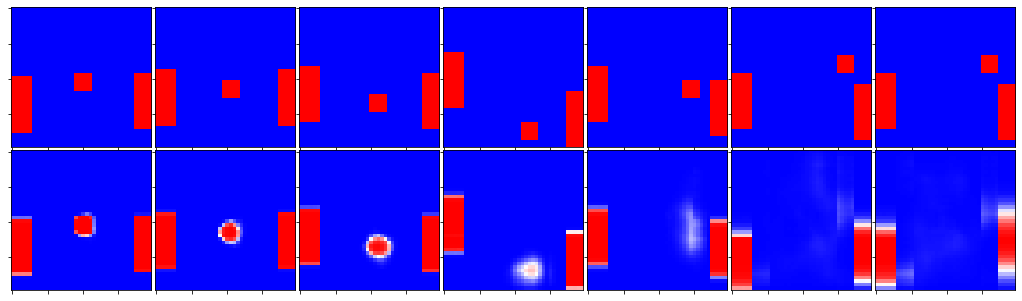

Epoch 95/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0612 - mean_squared_error: 0.0170 - acc: 0.9780 - val_loss: 0.0648 - val_mean_squared_error: 0.0184 - val_acc: 0.9753


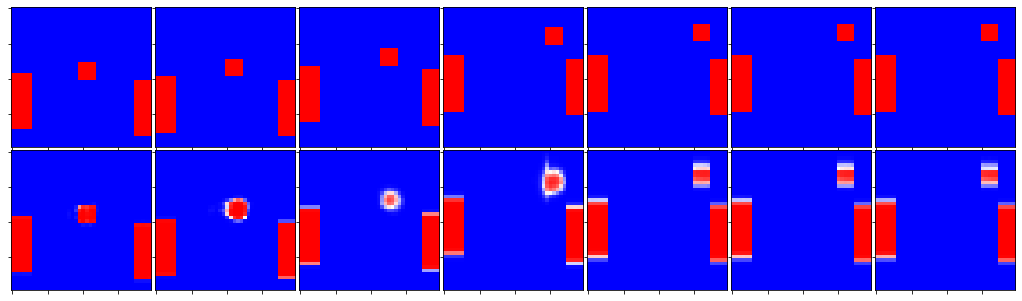

Epoch 96/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0610 - mean_squared_error: 0.0170 - acc: 0.9779 - val_loss: 0.0577 - val_mean_squared_error: 0.0159 - val_acc: 0.9796


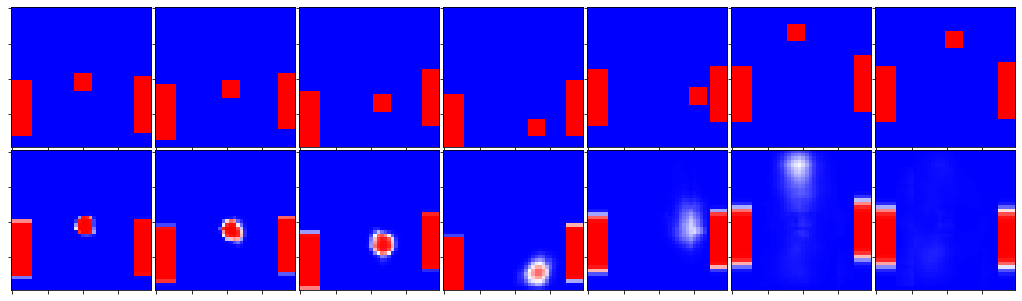

Epoch 97/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0605 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0608 - val_mean_squared_error: 0.0170 - val_acc: 0.9779


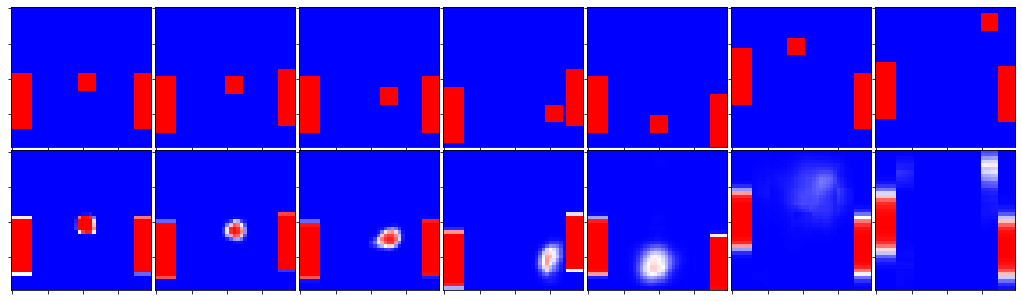

Epoch 98/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0595 - mean_squared_error: 0.0166 - acc: 0.9784 - val_loss: 0.0710 - val_mean_squared_error: 0.0191 - val_acc: 0.9751


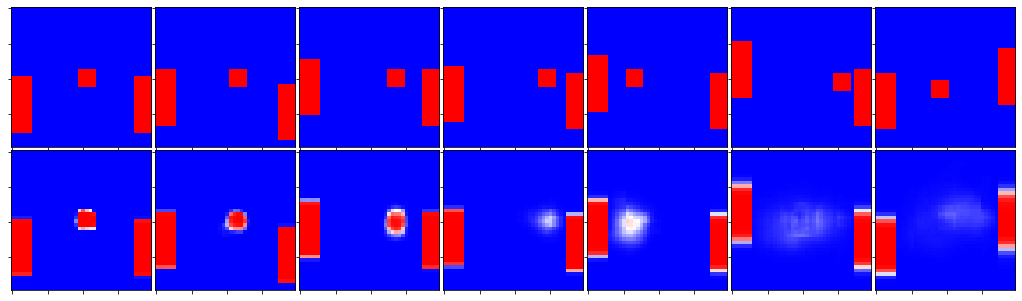

Epoch 99/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0622 - mean_squared_error: 0.0173 - acc: 0.9776 - val_loss: 0.0638 - val_mean_squared_error: 0.0181 - val_acc: 0.9764


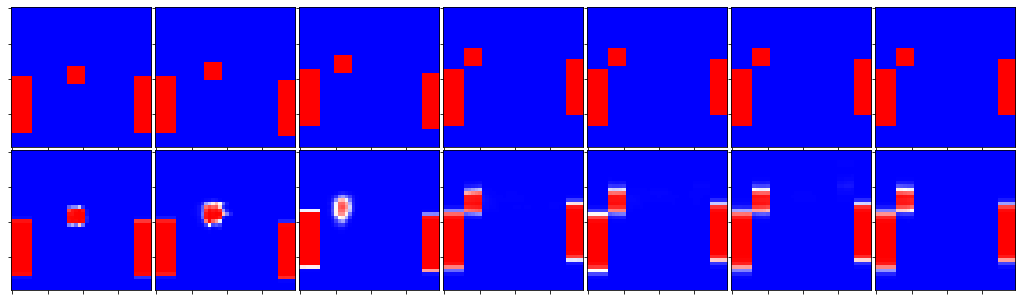

Epoch 100/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0629 - mean_squared_error: 0.0175 - acc: 0.9774 - val_loss: 0.0632 - val_mean_squared_error: 0.0176 - val_acc: 0.9774


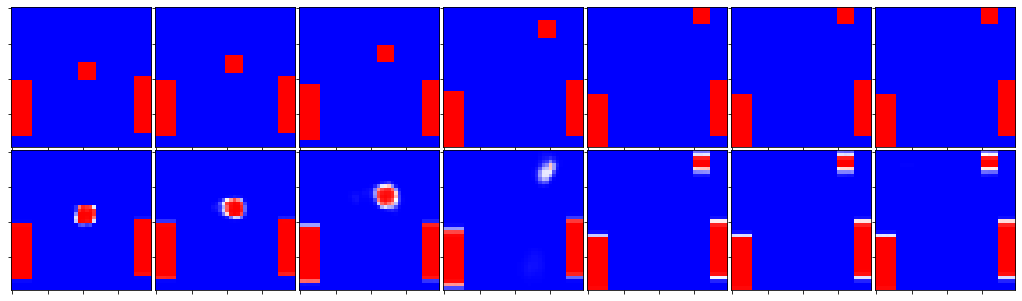

Epoch 101/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0600 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0621 - val_mean_squared_error: 0.0174 - val_acc: 0.9774


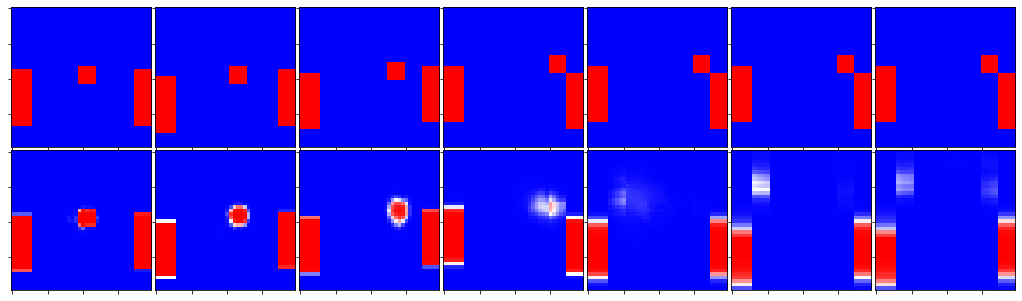

Epoch 102/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0599 - mean_squared_error: 0.0167 - acc: 0.9782 - val_loss: 0.0570 - val_mean_squared_error: 0.0160 - val_acc: 0.9790


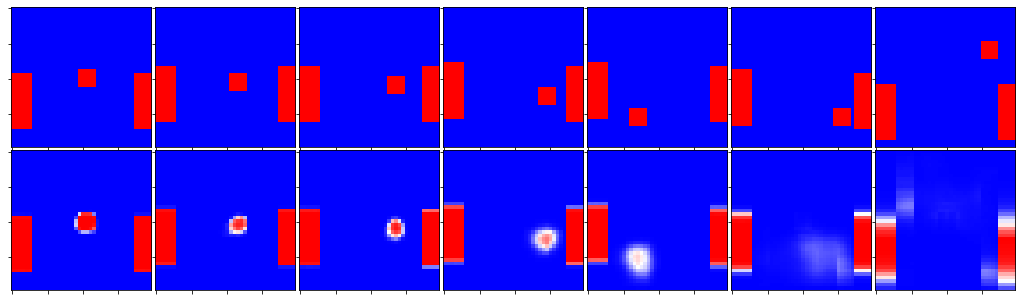

Epoch 103/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0592 - mean_squared_error: 0.0165 - acc: 0.9784 - val_loss: 0.0644 - val_mean_squared_error: 0.0176 - val_acc: 0.9769


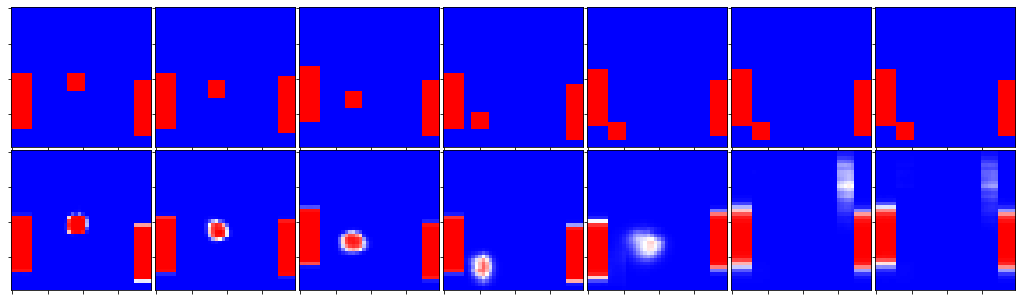

Epoch 104/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0613 - mean_squared_error: 0.0171 - acc: 0.9777 - val_loss: 0.0689 - val_mean_squared_error: 0.0192 - val_acc: 0.9748


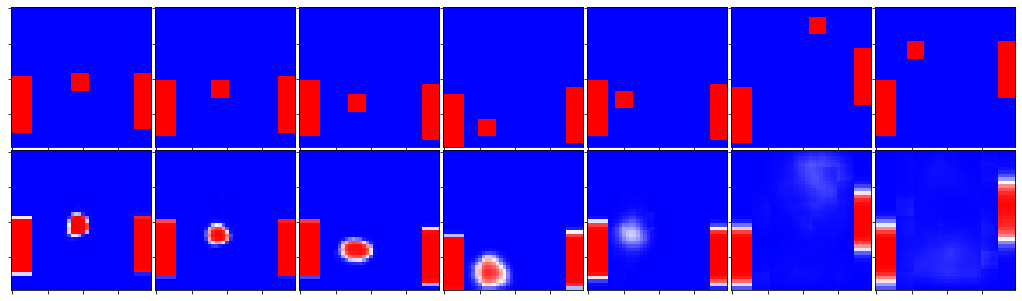

Epoch 105/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0660 - mean_squared_error: 0.0184 - acc: 0.9761 - val_loss: 0.0534 - val_mean_squared_error: 0.0149 - val_acc: 0.9805


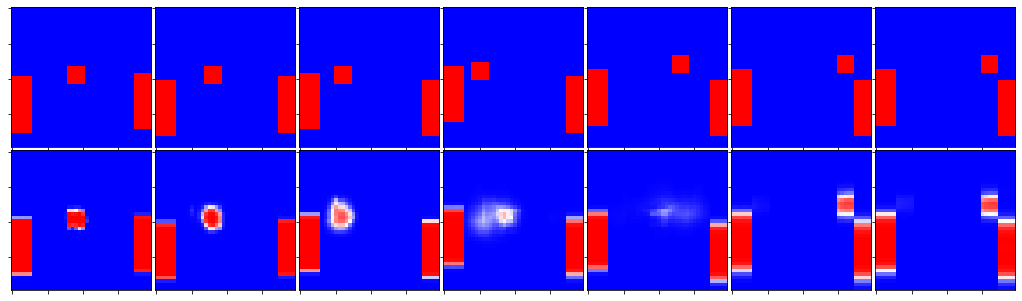

Epoch 106/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0623 - mean_squared_error: 0.0174 - acc: 0.9774 - val_loss: 0.0566 - val_mean_squared_error: 0.0160 - val_acc: 0.9792


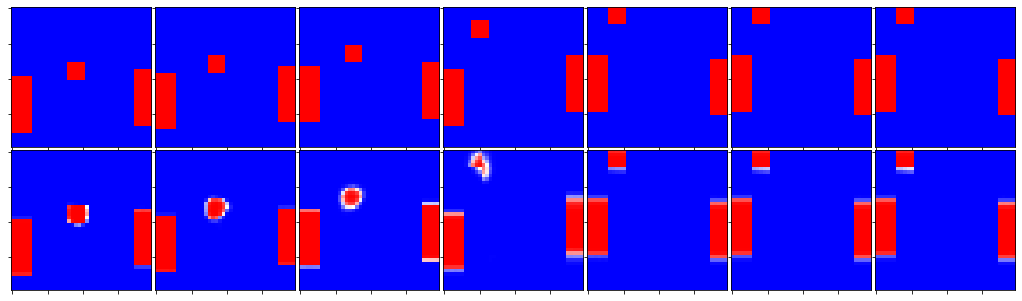

Epoch 107/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0605 - mean_squared_error: 0.0168 - acc: 0.9781 - val_loss: 0.0616 - val_mean_squared_error: 0.0170 - val_acc: 0.9780


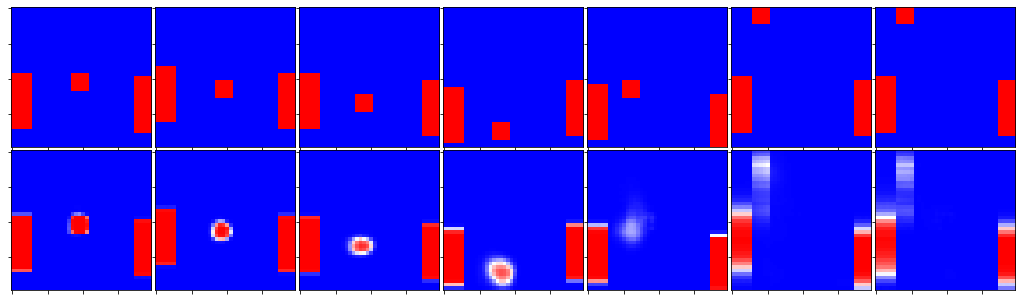

Epoch 108/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0598 - mean_squared_error: 0.0167 - acc: 0.9782 - val_loss: 0.0542 - val_mean_squared_error: 0.0152 - val_acc: 0.9805


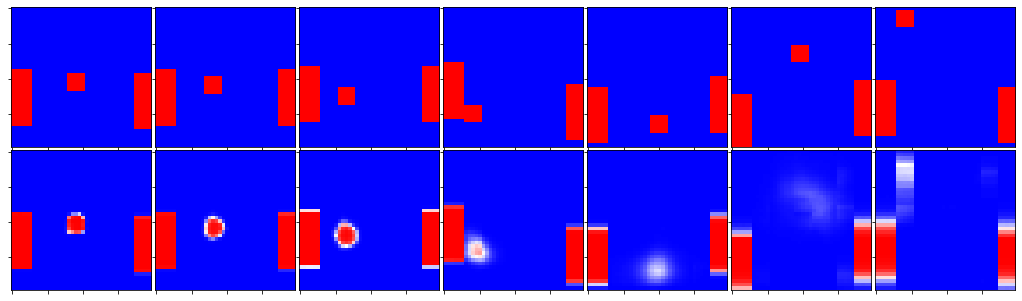

Epoch 109/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0579 - mean_squared_error: 0.0161 - acc: 0.9790 - val_loss: 0.0552 - val_mean_squared_error: 0.0154 - val_acc: 0.9797


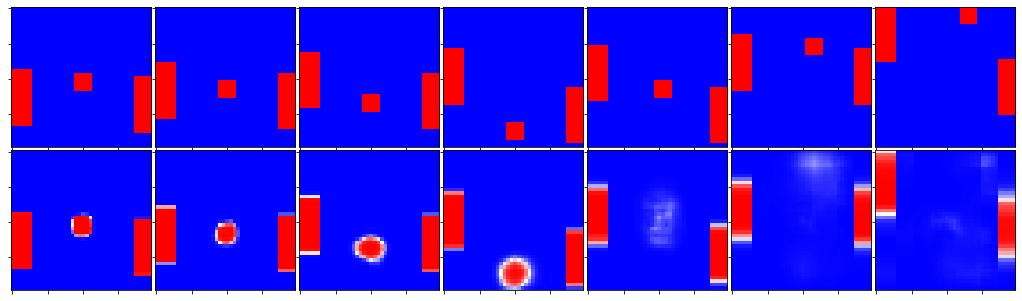

Epoch 110/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0584 - mean_squared_error: 0.0163 - acc: 0.9788 - val_loss: 0.0563 - val_mean_squared_error: 0.0158 - val_acc: 0.9797


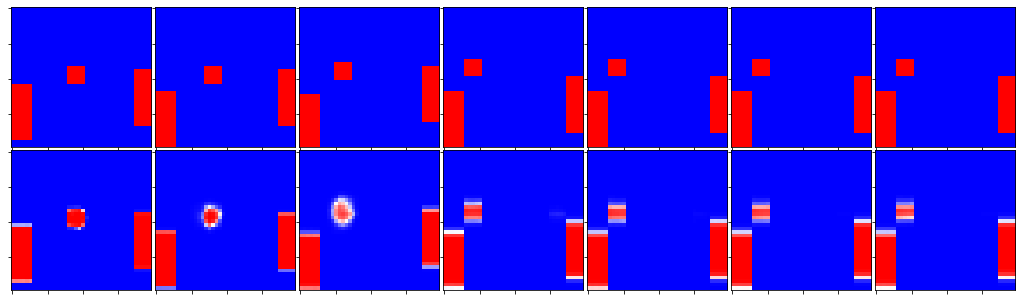

Epoch 111/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0569 - mean_squared_error: 0.0159 - acc: 0.9793 - val_loss: 0.0569 - val_mean_squared_error: 0.0159 - val_acc: 0.9795


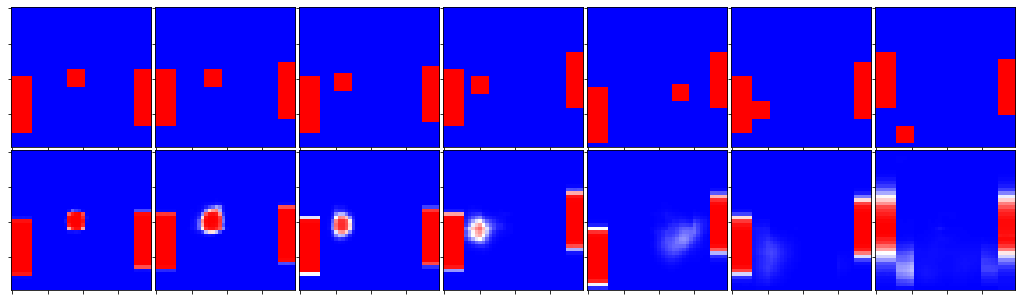

Epoch 112/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0581 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0643 - val_mean_squared_error: 0.0180 - val_acc: 0.9765


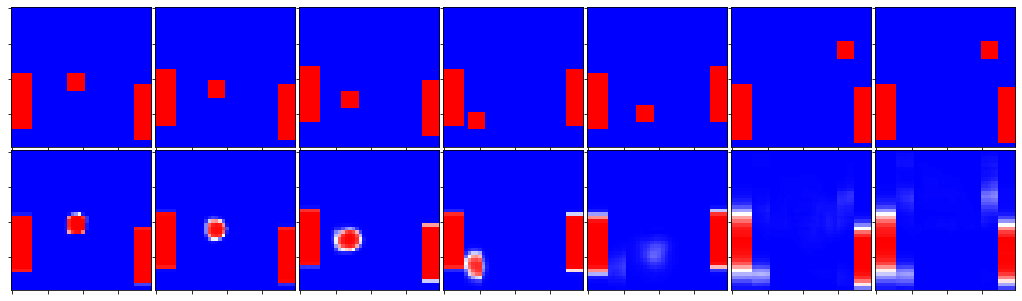

Epoch 113/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9793 - val_loss: 0.0570 - val_mean_squared_error: 0.0159 - val_acc: 0.9793


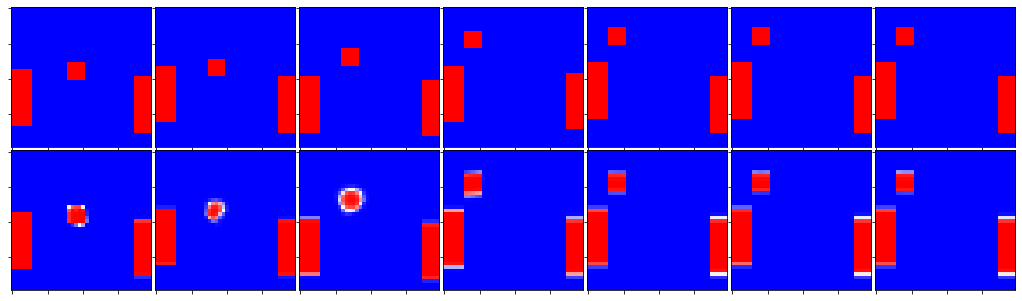

Epoch 114/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0602 - mean_squared_error: 0.0168 - acc: 0.9781 - val_loss: 0.0581 - val_mean_squared_error: 0.0164 - val_acc: 0.9785


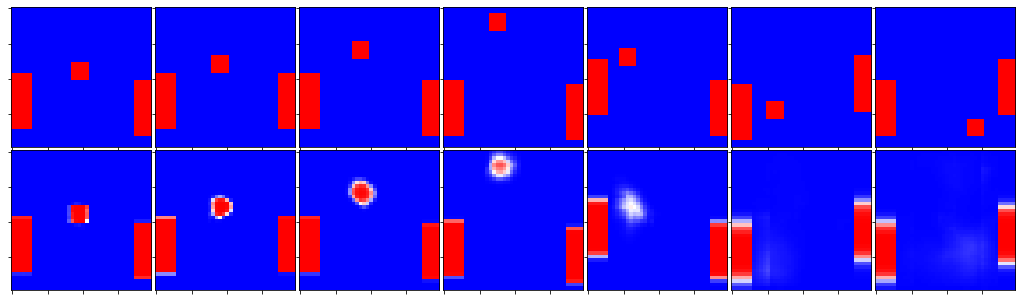

Epoch 115/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0585 - mean_squared_error: 0.0163 - acc: 0.9788 - val_loss: 0.0615 - val_mean_squared_error: 0.0173 - val_acc: 0.9774


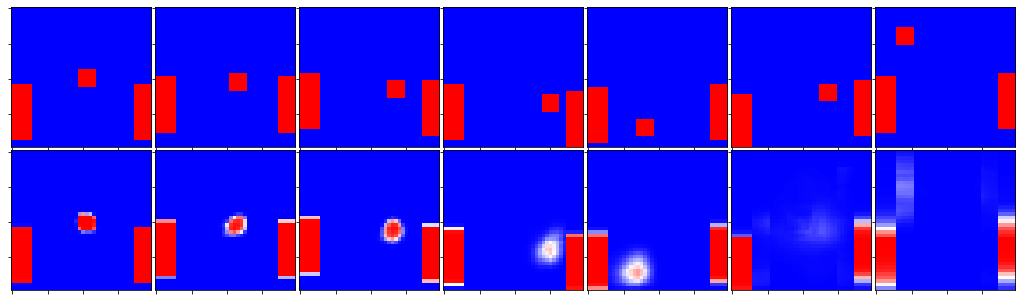

Epoch 116/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9793 - val_loss: 0.0624 - val_mean_squared_error: 0.0175 - val_acc: 0.9769


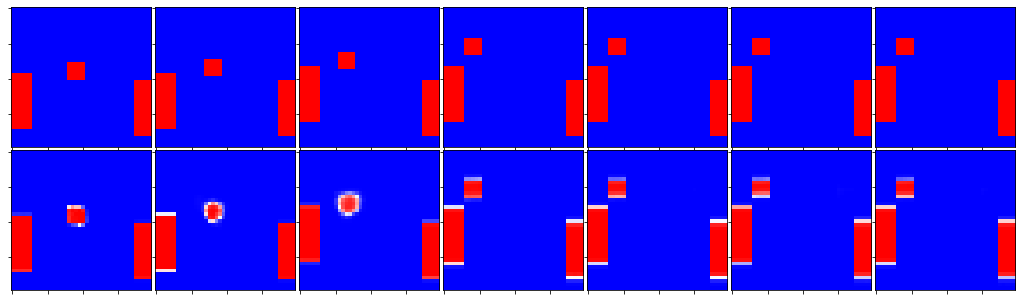

Epoch 117/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0587 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0618 - val_mean_squared_error: 0.0170 - val_acc: 0.9781


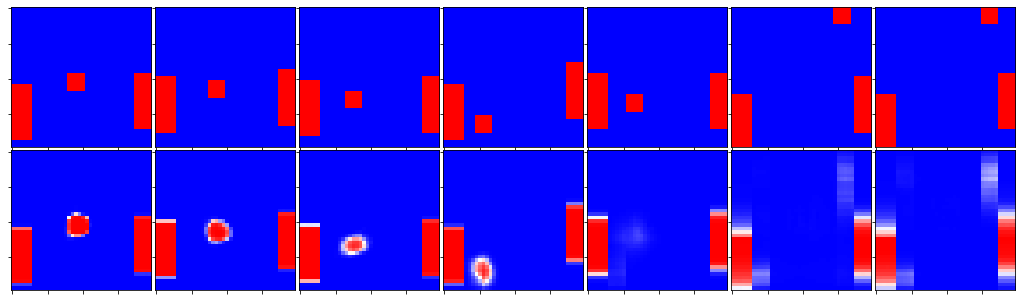

Epoch 118/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0586 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0563 - val_mean_squared_error: 0.0159 - val_acc: 0.9792


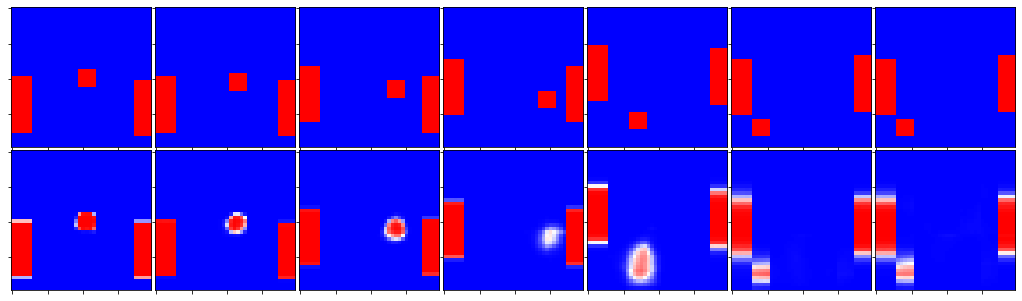

Epoch 119/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0558 - mean_squared_error: 0.0156 - acc: 0.9796 - val_loss: 0.0574 - val_mean_squared_error: 0.0161 - val_acc: 0.9790


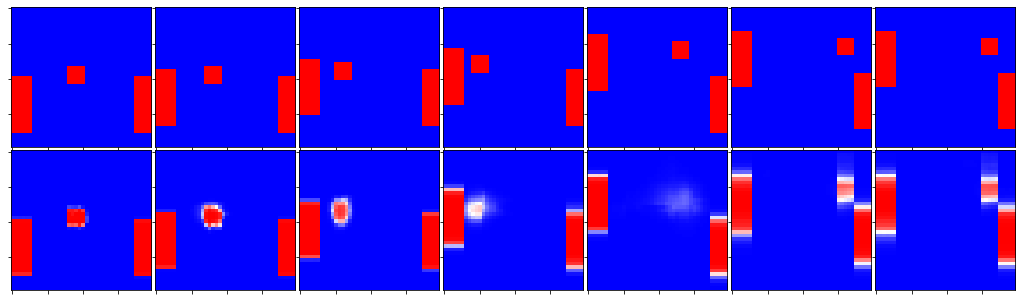

Epoch 120/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9794 - val_loss: 0.0510 - val_mean_squared_error: 0.0140 - val_acc: 0.9816


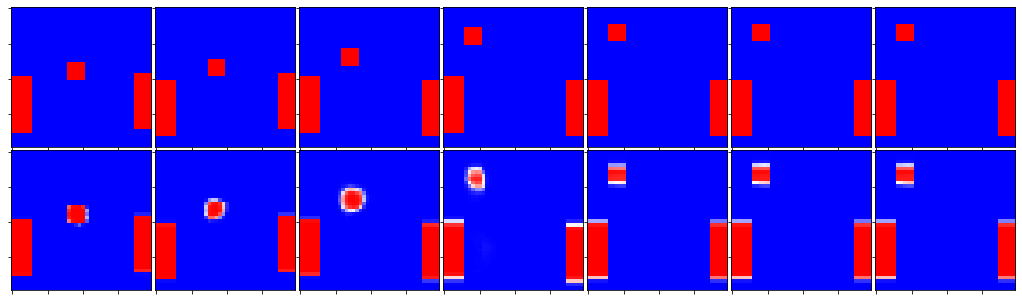

Epoch 121/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0574 - mean_squared_error: 0.0161 - acc: 0.9790 - val_loss: 0.0539 - val_mean_squared_error: 0.0151 - val_acc: 0.9801


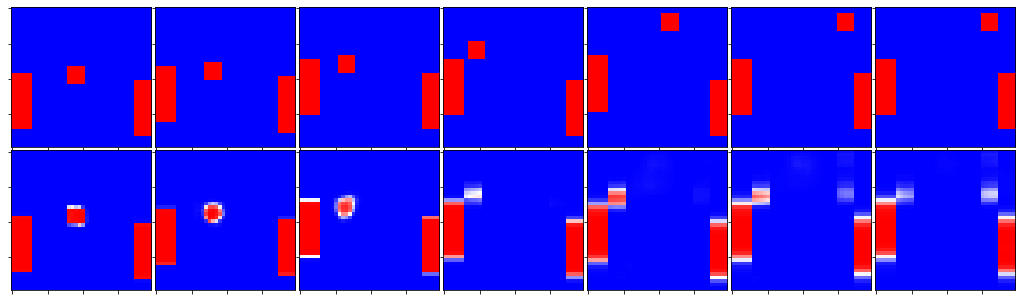

Epoch 122/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0573 - mean_squared_error: 0.0160 - acc: 0.9792 - val_loss: 0.0612 - val_mean_squared_error: 0.0169 - val_acc: 0.9780


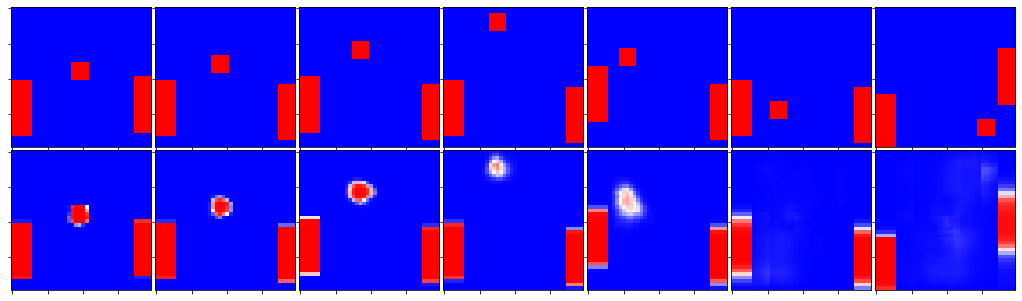

Epoch 123/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0586 - mean_squared_error: 0.0164 - acc: 0.9786 - val_loss: 0.0523 - val_mean_squared_error: 0.0149 - val_acc: 0.9803


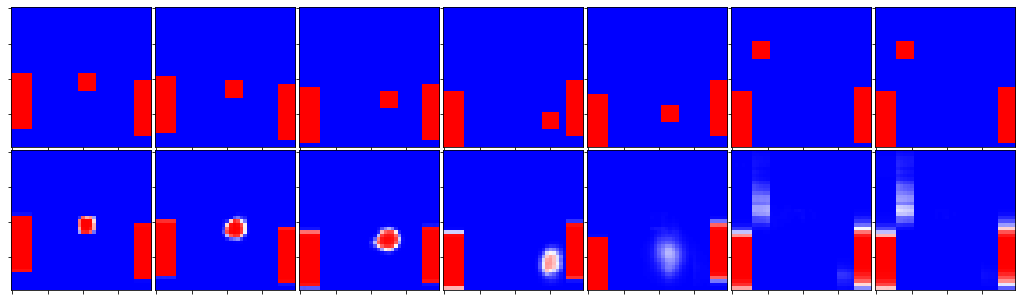

Epoch 124/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0586 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0551 - val_mean_squared_error: 0.0152 - val_acc: 0.9806


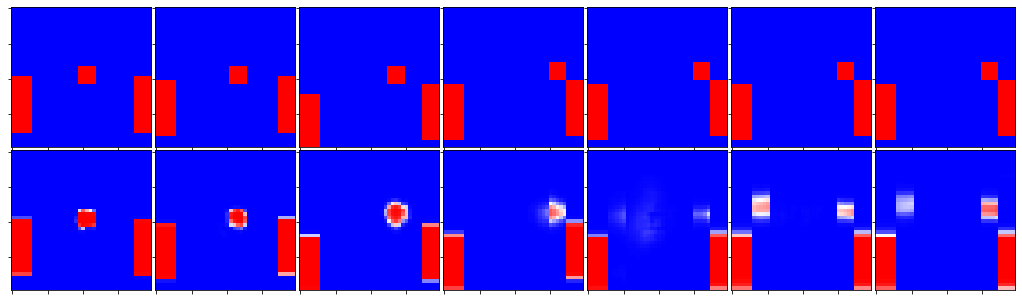

Epoch 125/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0556 - mean_squared_error: 0.0156 - acc: 0.9796 - val_loss: 0.0580 - val_mean_squared_error: 0.0164 - val_acc: 0.9782


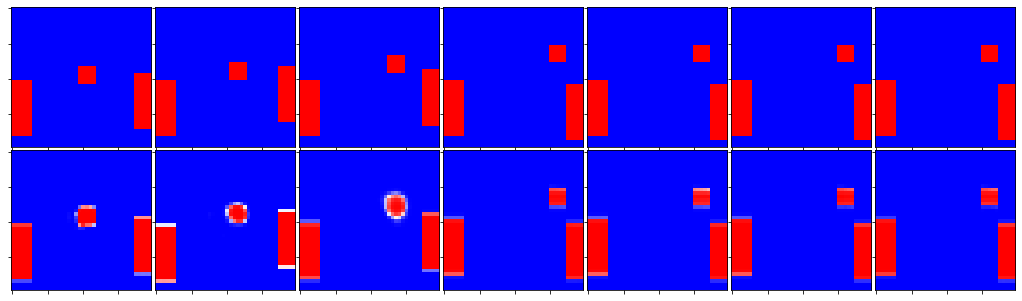

Epoch 126/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0558 - mean_squared_error: 0.0156 - acc: 0.9795 - val_loss: 0.0535 - val_mean_squared_error: 0.0151 - val_acc: 0.9806


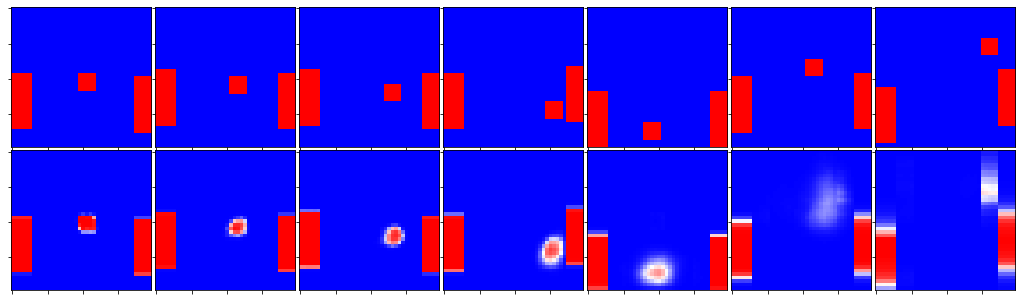

Epoch 127/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0554 - mean_squared_error: 0.0155 - acc: 0.9796 - val_loss: 0.0582 - val_mean_squared_error: 0.0161 - val_acc: 0.9791


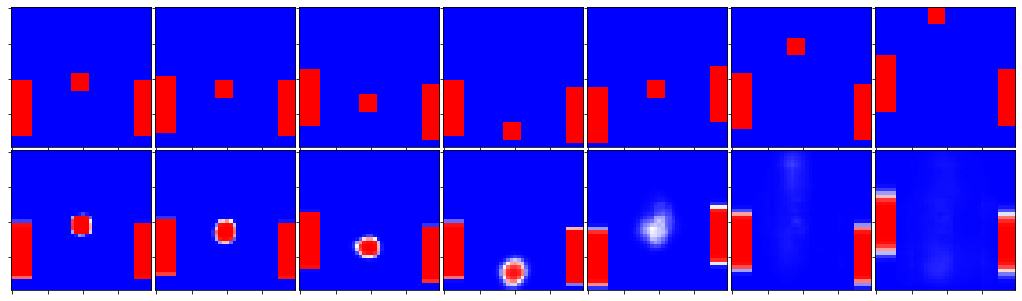

Epoch 128/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0563 - mean_squared_error: 0.0158 - acc: 0.9792 - val_loss: 0.0555 - val_mean_squared_error: 0.0157 - val_acc: 0.9795


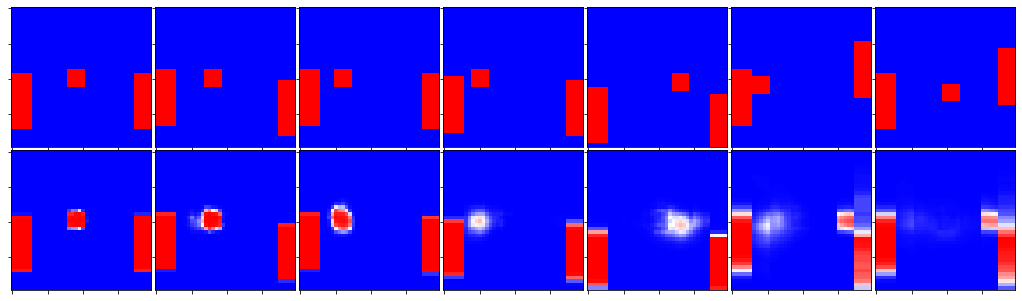

Epoch 129/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0529 - mean_squared_error: 0.0149 - acc: 0.9805 - val_loss: 0.0671 - val_mean_squared_error: 0.0160 - val_acc: 0.9790


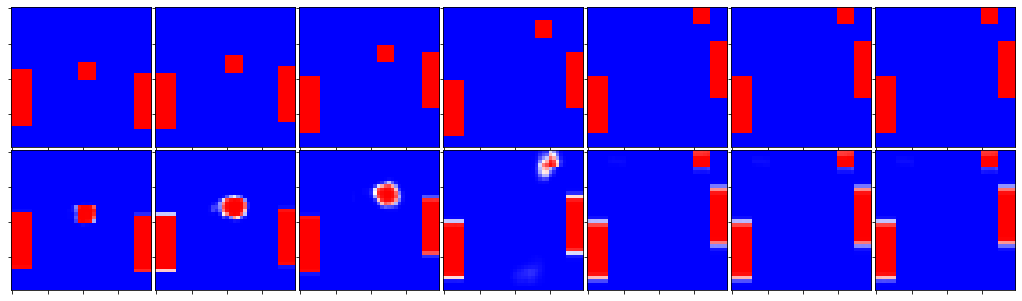

Epoch 130/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0546 - mean_squared_error: 0.0153 - acc: 0.9798 - val_loss: 0.0518 - val_mean_squared_error: 0.0146 - val_acc: 0.9805


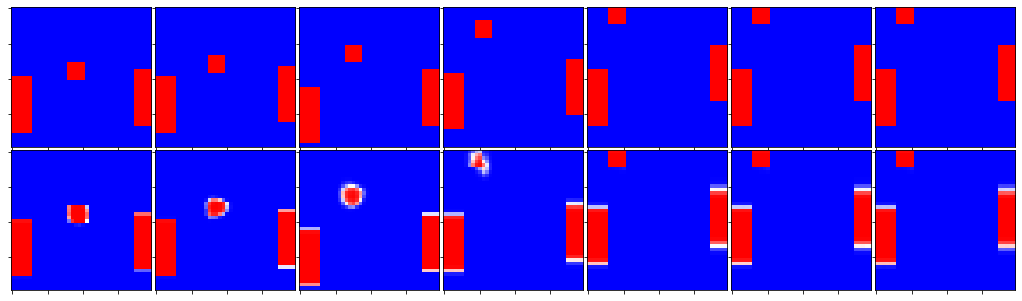

Epoch 131/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0551 - mean_squared_error: 0.0154 - acc: 0.9799 - val_loss: 0.0539 - val_mean_squared_error: 0.0151 - val_acc: 0.9801


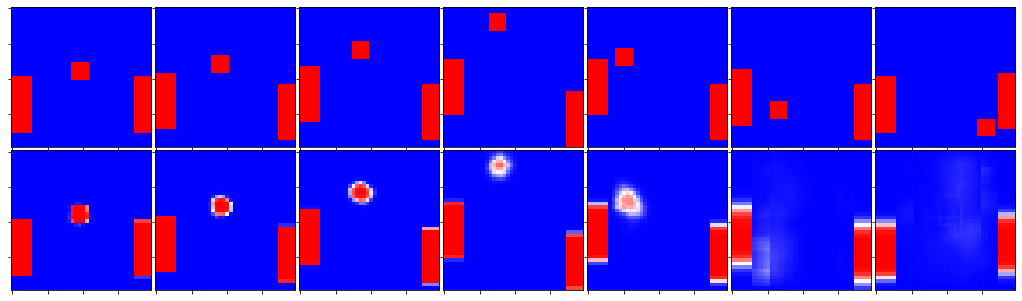

Epoch 132/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0542 - mean_squared_error: 0.0152 - acc: 0.9800 - val_loss: 0.0558 - val_mean_squared_error: 0.0154 - val_acc: 0.9799


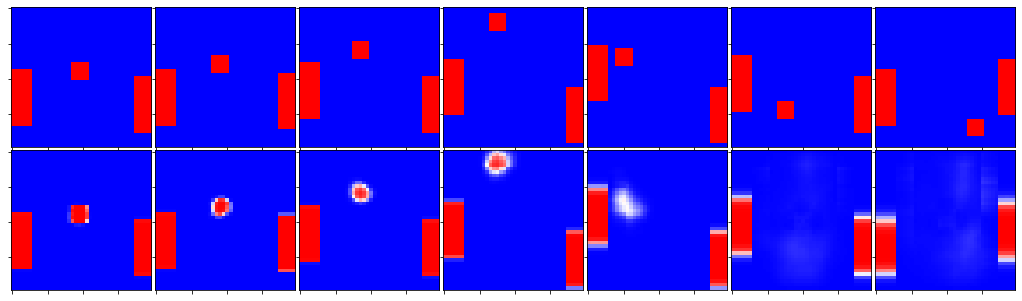

Epoch 133/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0543 - mean_squared_error: 0.0152 - acc: 0.9801 - val_loss: 0.0522 - val_mean_squared_error: 0.0149 - val_acc: 0.9801


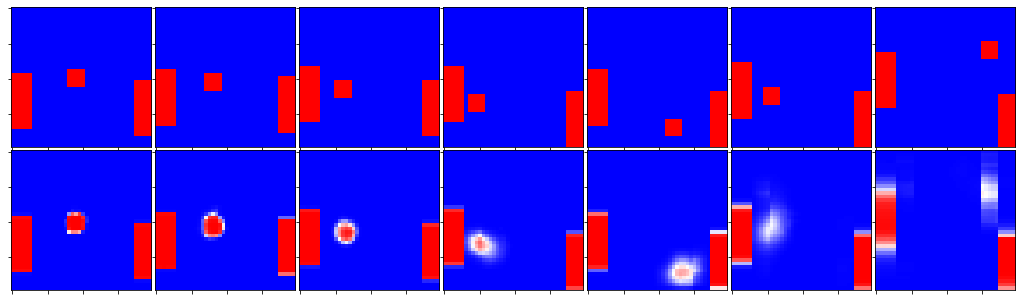

Epoch 134/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0548 - mean_squared_error: 0.0154 - acc: 0.9798 - val_loss: 0.0567 - val_mean_squared_error: 0.0160 - val_acc: 0.9792


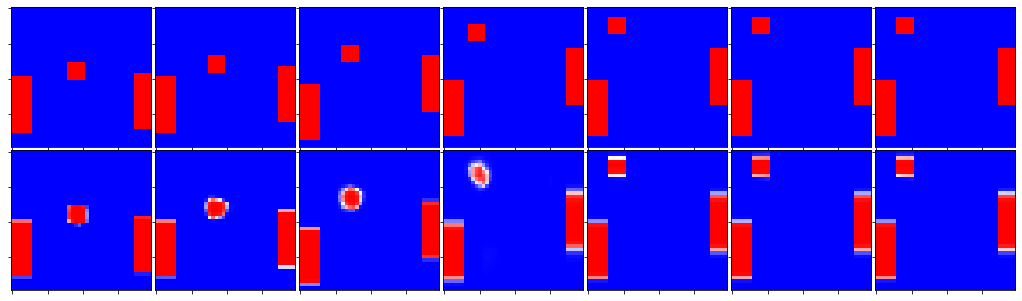

Epoch 135/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0538 - mean_squared_error: 0.0151 - acc: 0.9801 - val_loss: 0.0526 - val_mean_squared_error: 0.0148 - val_acc: 0.9808


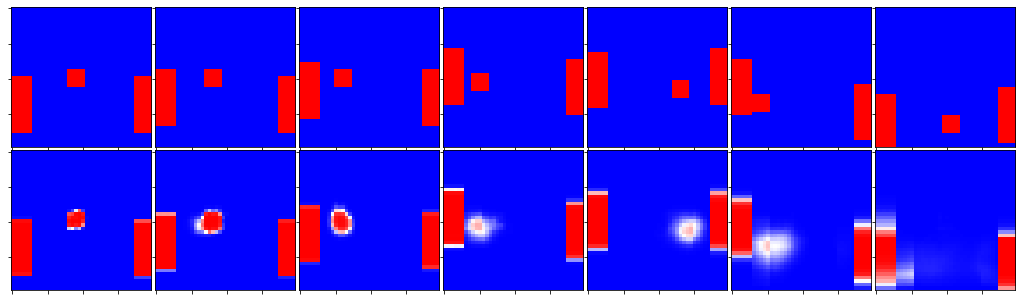

Epoch 136/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0539 - mean_squared_error: 0.0151 - acc: 0.9801 - val_loss: 0.0547 - val_mean_squared_error: 0.0154 - val_acc: 0.9796


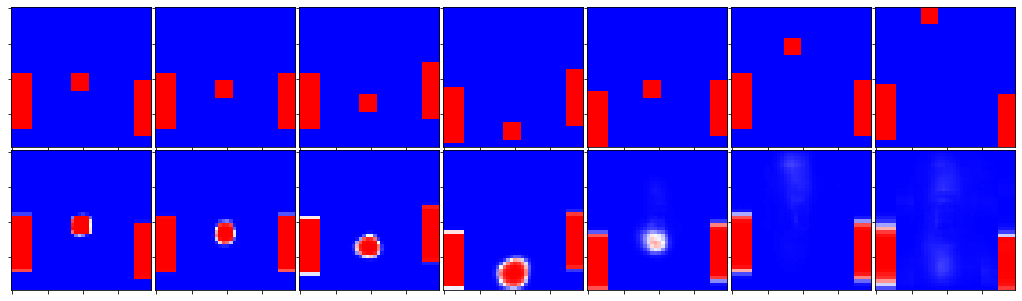

Epoch 137/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0548 - mean_squared_error: 0.0154 - acc: 0.9798 - val_loss: 0.0476 - val_mean_squared_error: 0.0137 - val_acc: 0.9820


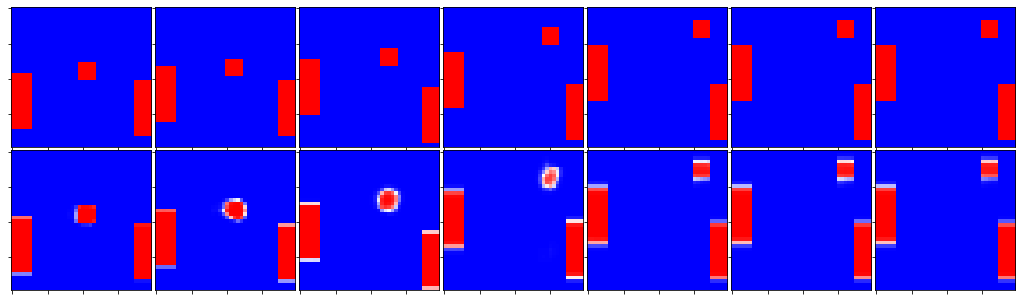

Epoch 138/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0528 - mean_squared_error: 0.0148 - acc: 0.9805 - val_loss: 0.0641 - val_mean_squared_error: 0.0177 - val_acc: 0.9771


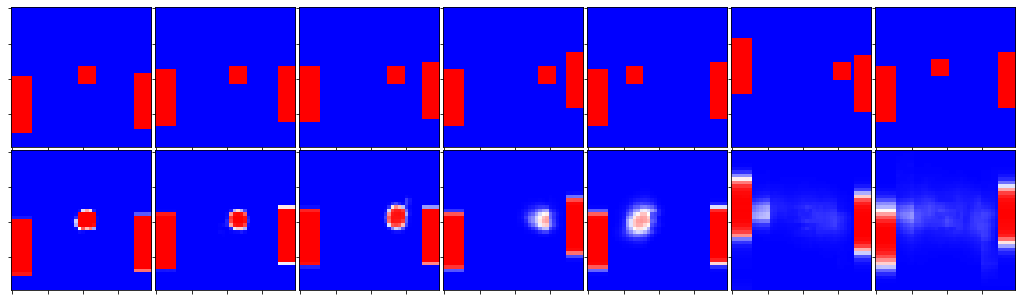

Epoch 139/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0532 - mean_squared_error: 0.0149 - acc: 0.9804 - val_loss: 0.0498 - val_mean_squared_error: 0.0137 - val_acc: 0.9822


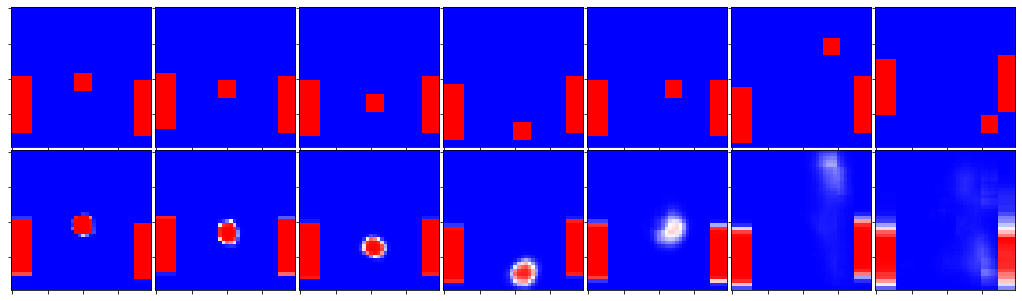

Epoch 140/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0535 - mean_squared_error: 0.0150 - acc: 0.9804 - val_loss: 0.0547 - val_mean_squared_error: 0.0154 - val_acc: 0.9801


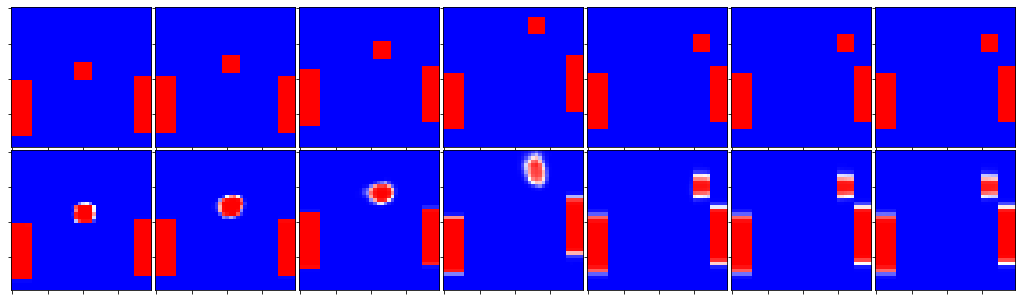

Epoch 141/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0526 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0528 - val_mean_squared_error: 0.0148 - val_acc: 0.9808


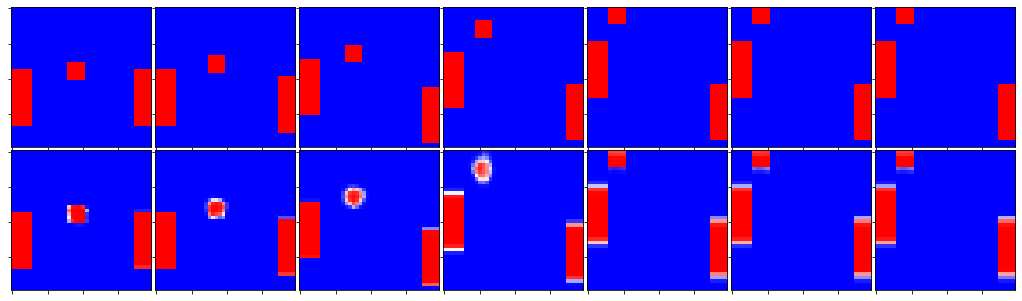

Epoch 142/2500
100/100 [==============================] - 84s 844ms/step - loss: 0.0531 - mean_squared_error: 0.0149 - acc: 0.9804 - val_loss: 0.0520 - val_mean_squared_error: 0.0146 - val_acc: 0.9807


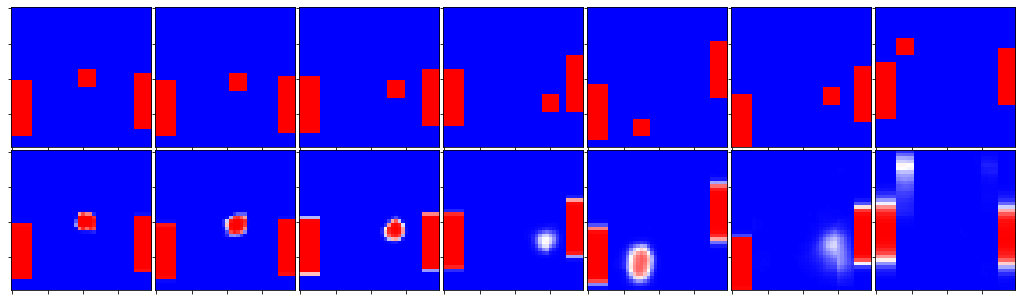

Epoch 143/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0539 - mean_squared_error: 0.0151 - acc: 0.9802 - val_loss: 0.0605 - val_mean_squared_error: 0.0172 - val_acc: 0.9772


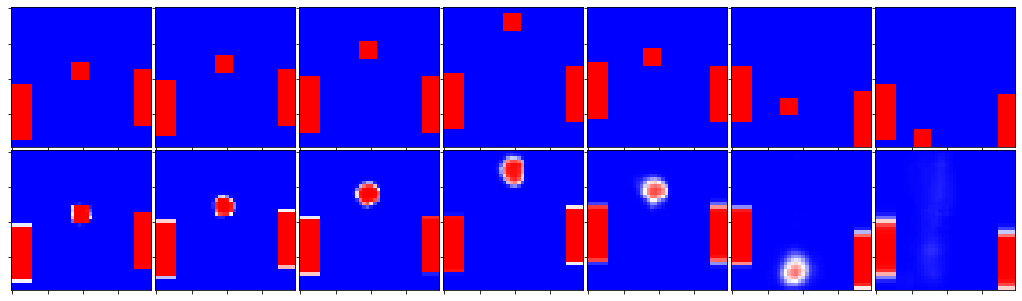

Epoch 144/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0520 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0497 - val_mean_squared_error: 0.0144 - val_acc: 0.9810


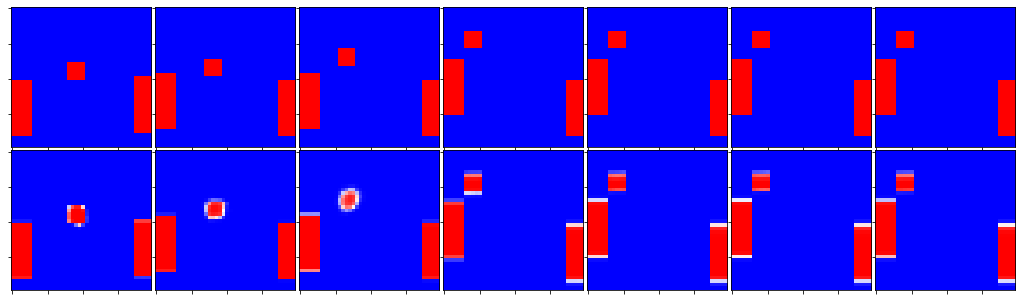

Epoch 145/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0535 - mean_squared_error: 0.0150 - acc: 0.9804 - val_loss: 0.0516 - val_mean_squared_error: 0.0146 - val_acc: 0.9805


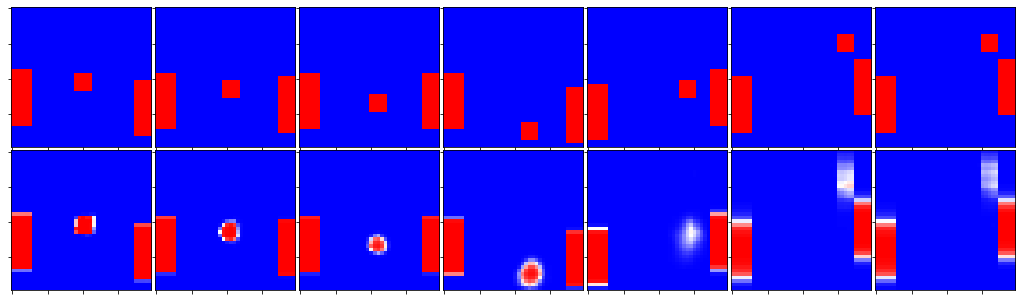

Epoch 146/2500
100/100 [==============================] - 84s 841ms/step - loss: 0.0597 - mean_squared_error: 0.0165 - acc: 0.9784 - val_loss: 0.0622 - val_mean_squared_error: 0.0174 - val_acc: 0.9770


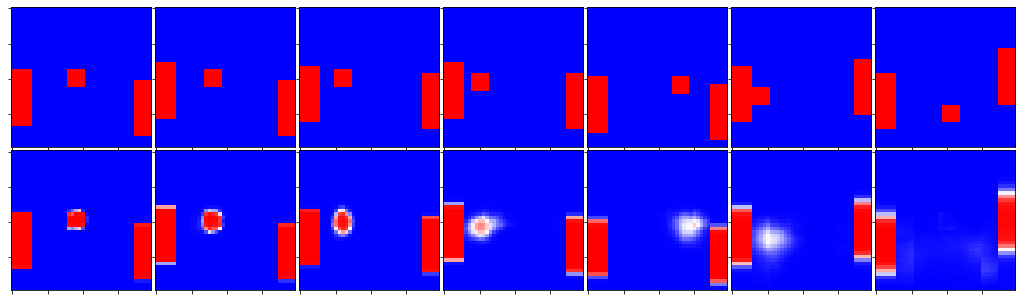

Epoch 147/2500
100/100 [==============================] - 84s 838ms/step - loss: 0.0520 - mean_squared_error: 0.0146 - acc: 0.9808 - val_loss: 0.0567 - val_mean_squared_error: 0.0160 - val_acc: 0.9791


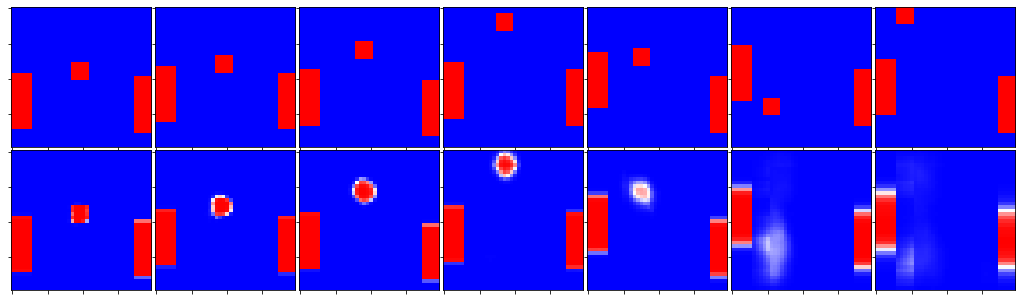

Epoch 148/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0517 - mean_squared_error: 0.0146 - acc: 0.9808 - val_loss: 0.0507 - val_mean_squared_error: 0.0143 - val_acc: 0.9811


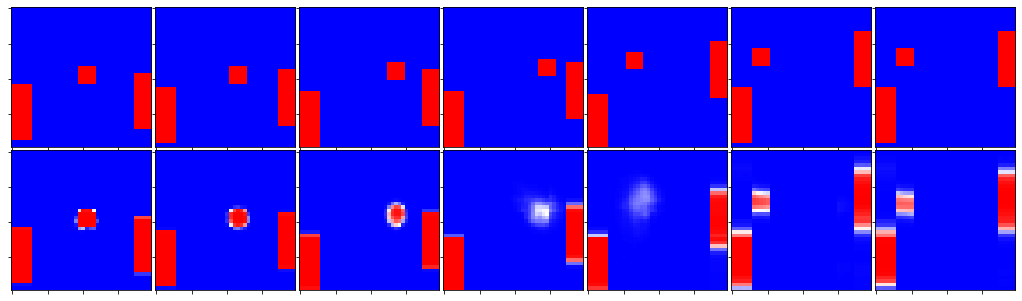

Epoch 149/2500
100/100 [==============================] - 85s 850ms/step - loss: 0.0518 - mean_squared_error: 0.0146 - acc: 0.9808 - val_loss: 0.0520 - val_mean_squared_error: 0.0143 - val_acc: 0.9815


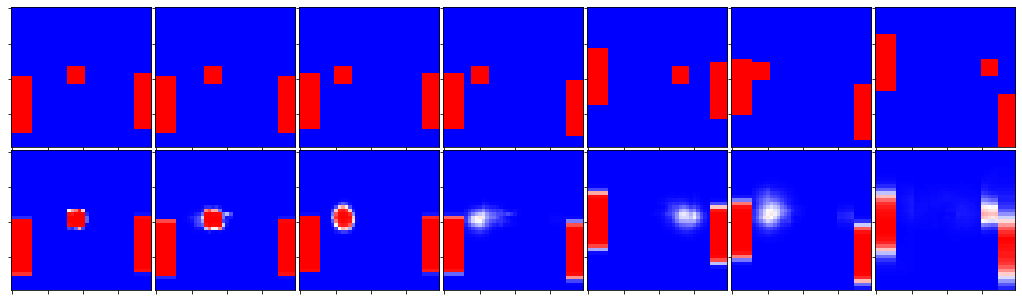

Epoch 150/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0510 - mean_squared_error: 0.0144 - acc: 0.9811 - val_loss: 0.0469 - val_mean_squared_error: 0.0133 - val_acc: 0.9826


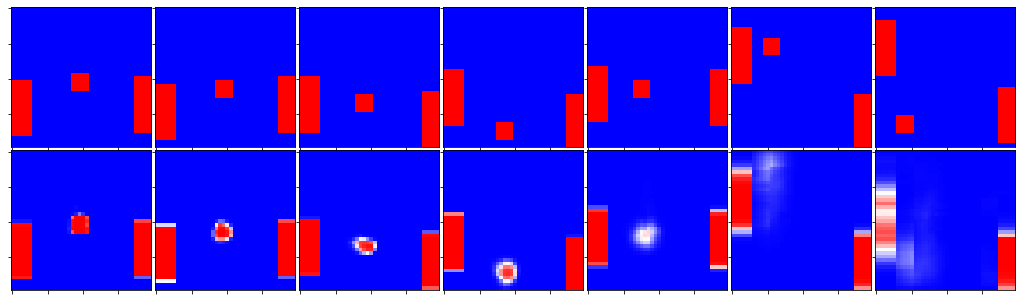

Epoch 151/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0528 - mean_squared_error: 0.0148 - acc: 0.9807 - val_loss: 0.0532 - val_mean_squared_error: 0.0149 - val_acc: 0.9809


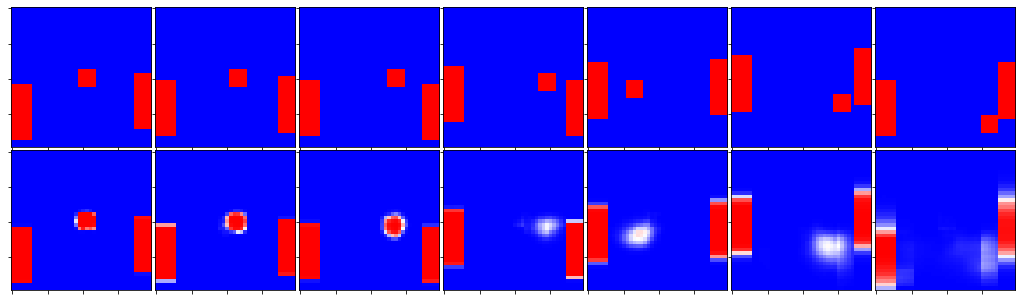

Epoch 152/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0515 - mean_squared_error: 0.0144 - acc: 0.9811 - val_loss: 0.0524 - val_mean_squared_error: 0.0145 - val_acc: 0.9813


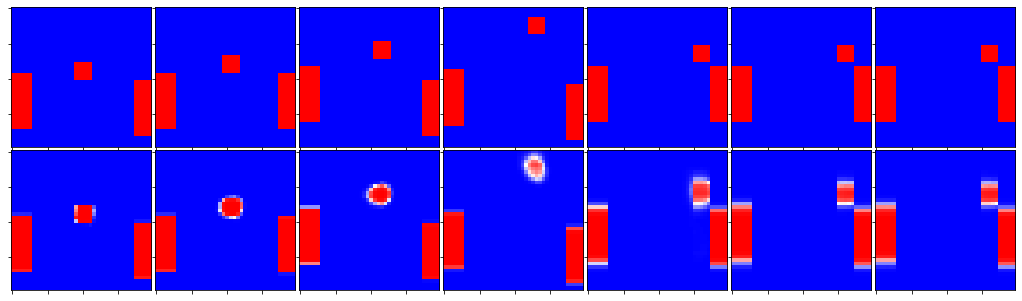

Epoch 153/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0521 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0512 - val_mean_squared_error: 0.0146 - val_acc: 0.9807


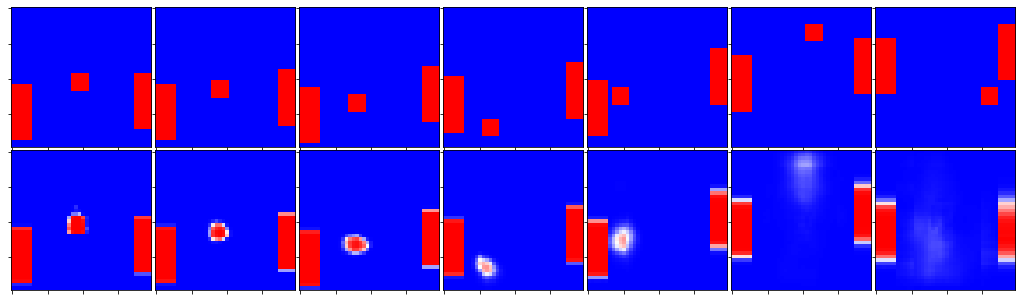

Epoch 154/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.0501 - mean_squared_error: 0.0140 - acc: 0.9816 - val_loss: 0.0583 - val_mean_squared_error: 0.0163 - val_acc: 0.9787


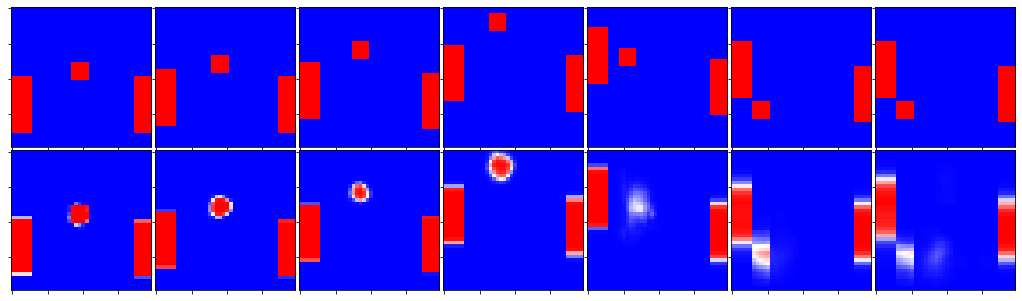

Epoch 155/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0512 - mean_squared_error: 0.0144 - acc: 0.9810 - val_loss: 0.0503 - val_mean_squared_error: 0.0137 - val_acc: 0.9824


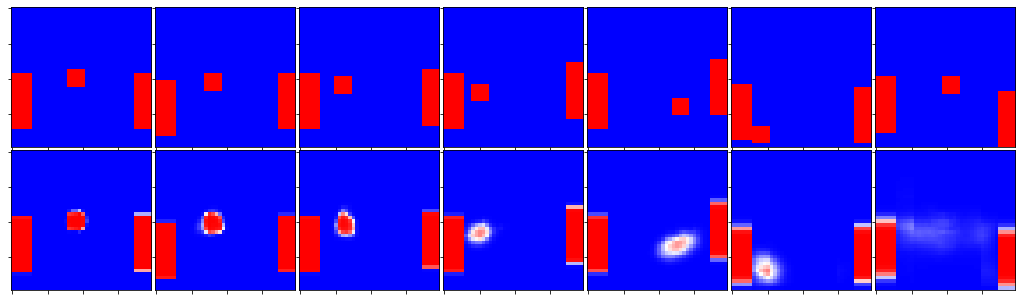

Epoch 156/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0526 - mean_squared_error: 0.0148 - acc: 0.9806 - val_loss: 0.0537 - val_mean_squared_error: 0.0147 - val_acc: 0.9807


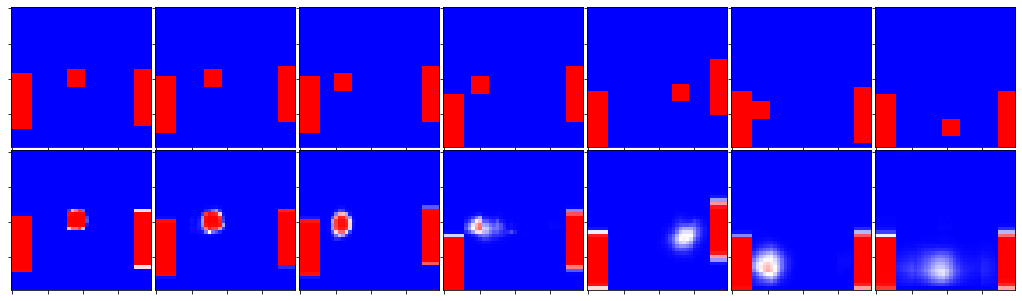

Epoch 157/2500
100/100 [==============================] - 84s 842ms/step - loss: 0.0516 - mean_squared_error: 0.0145 - acc: 0.9810 - val_loss: 0.0507 - val_mean_squared_error: 0.0140 - val_acc: 0.9817


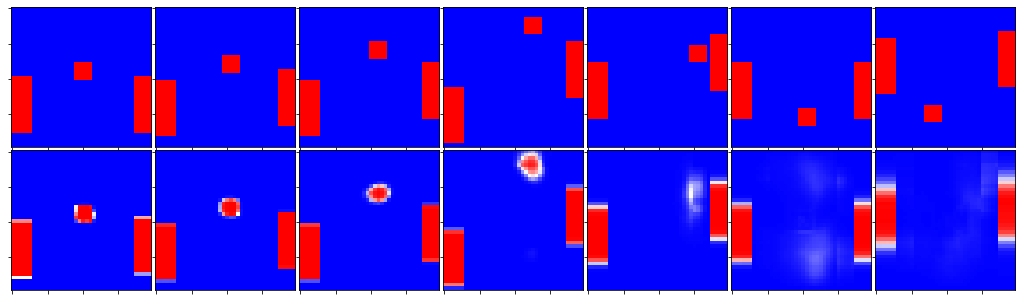

Epoch 158/2500
100/100 [==============================] - 85s 850ms/step - loss: 0.0508 - mean_squared_error: 0.0142 - acc: 0.9813 - val_loss: 0.0506 - val_mean_squared_error: 0.0144 - val_acc: 0.9809


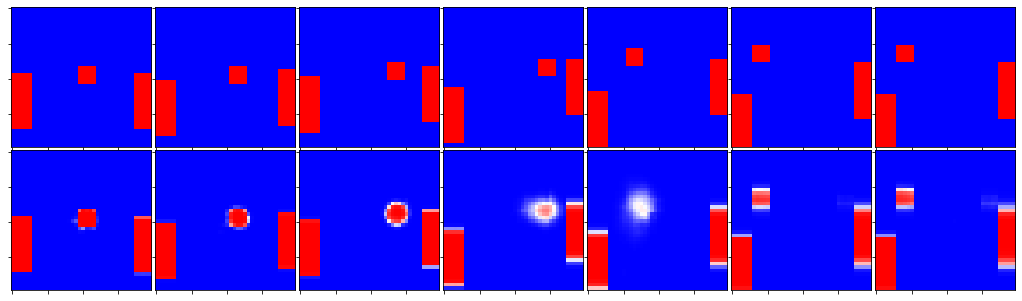

Epoch 159/2500
100/100 [==============================] - 85s 846ms/step - loss: 0.0503 - mean_squared_error: 0.0141 - acc: 0.9815 - val_loss: 0.0491 - val_mean_squared_error: 0.0137 - val_acc: 0.9820


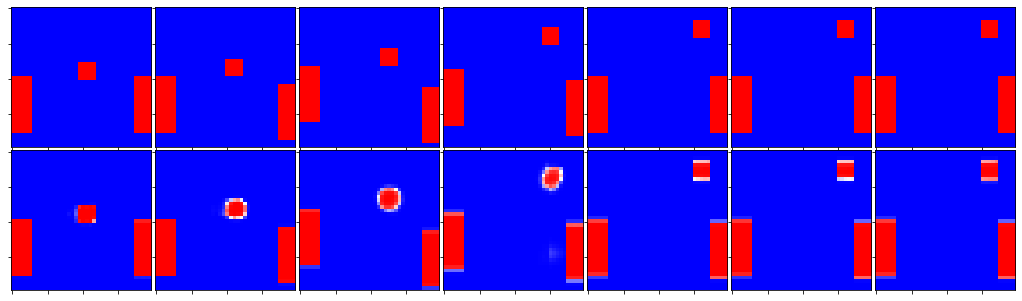

Epoch 160/2500
100/100 [==============================] - 89s 889ms/step - loss: 0.0522 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0541 - val_mean_squared_error: 0.0153 - val_acc: 0.9799


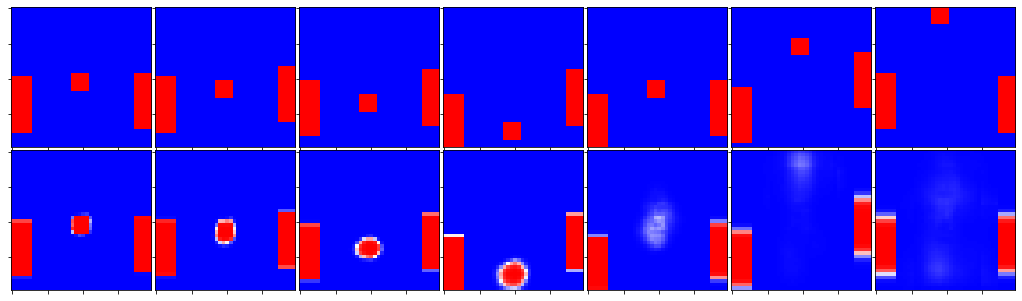

Epoch 161/2500
100/100 [==============================] - 85s 849ms/step - loss: 0.0504 - mean_squared_error: 0.0142 - acc: 0.9813 - val_loss: 0.0473 - val_mean_squared_error: 0.0136 - val_acc: 0.9819


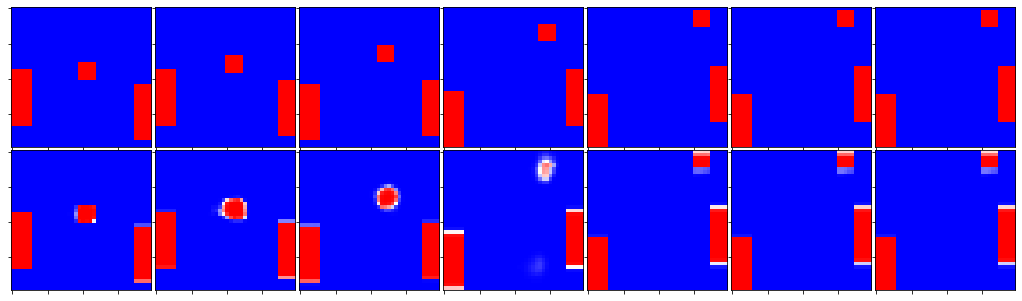

Epoch 162/2500
100/100 [==============================] - 86s 861ms/step - loss: 0.0524 - mean_squared_error: 0.0147 - acc: 0.9806 - val_loss: 0.0523 - val_mean_squared_error: 0.0145 - val_acc: 0.9814


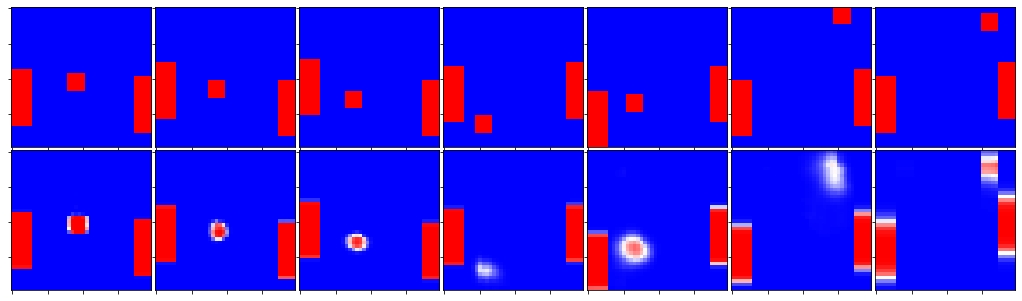

Epoch 163/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0503 - mean_squared_error: 0.0141 - acc: 0.9815 - val_loss: 0.0530 - val_mean_squared_error: 0.0146 - val_acc: 0.9806


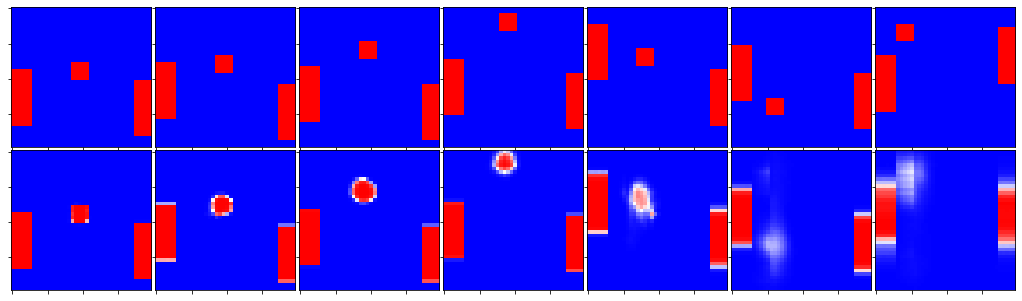

Epoch 164/2500
100/100 [==============================] - 83s 835ms/step - loss: 0.0498 - mean_squared_error: 0.0140 - acc: 0.9817 - val_loss: 0.0525 - val_mean_squared_error: 0.0137 - val_acc: 0.9820


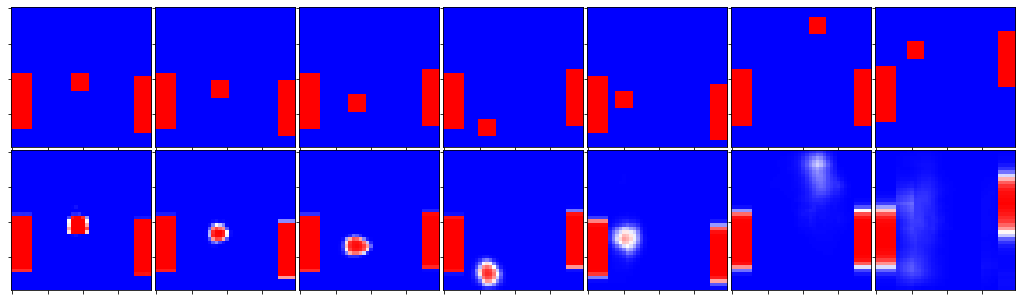

Epoch 165/2500
100/100 [==============================] - 84s 841ms/step - loss: 0.0548 - mean_squared_error: 0.0153 - acc: 0.9799 - val_loss: 0.0592 - val_mean_squared_error: 0.0165 - val_acc: 0.9786


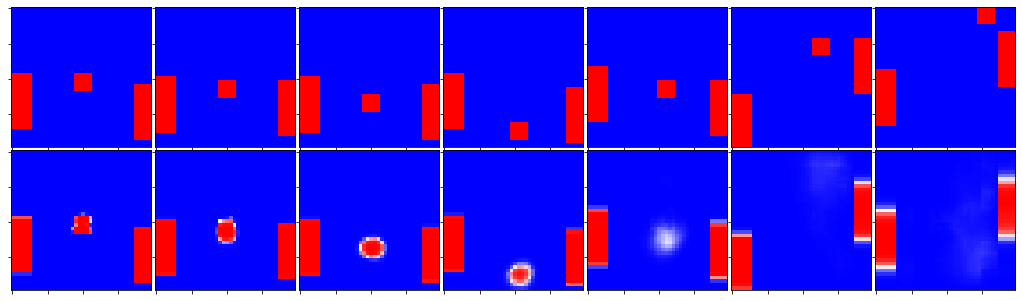

Epoch 166/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0511 - mean_squared_error: 0.0144 - acc: 0.9810 - val_loss: 0.0531 - val_mean_squared_error: 0.0150 - val_acc: 0.9799


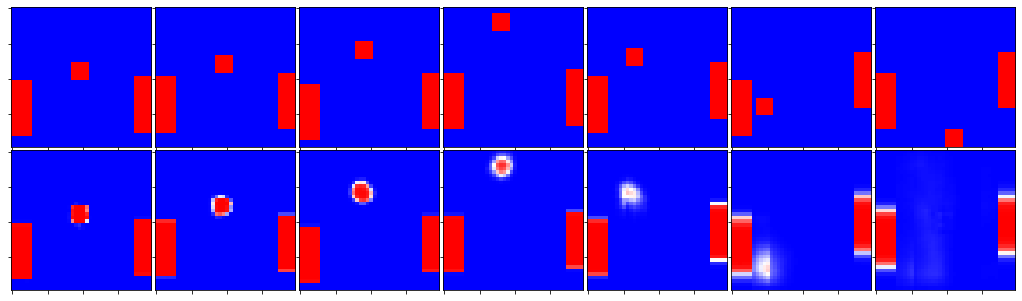

Epoch 167/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0508 - mean_squared_error: 0.0142 - acc: 0.9814 - val_loss: 0.0516 - val_mean_squared_error: 0.0143 - val_acc: 0.9813


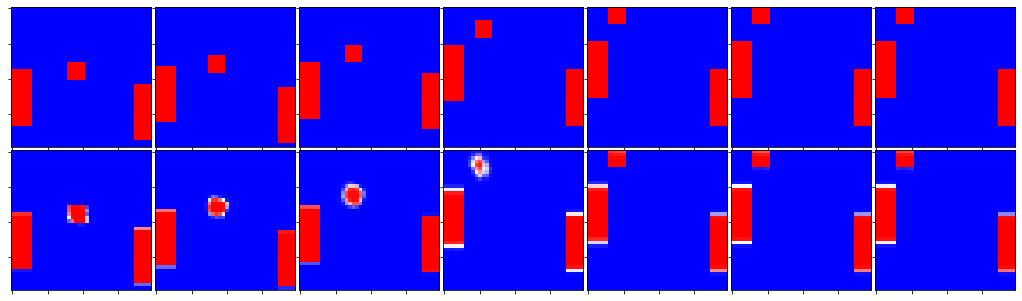

Epoch 168/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0516 - mean_squared_error: 0.0146 - acc: 0.9807 - val_loss: 0.0487 - val_mean_squared_error: 0.0139 - val_acc: 0.9815


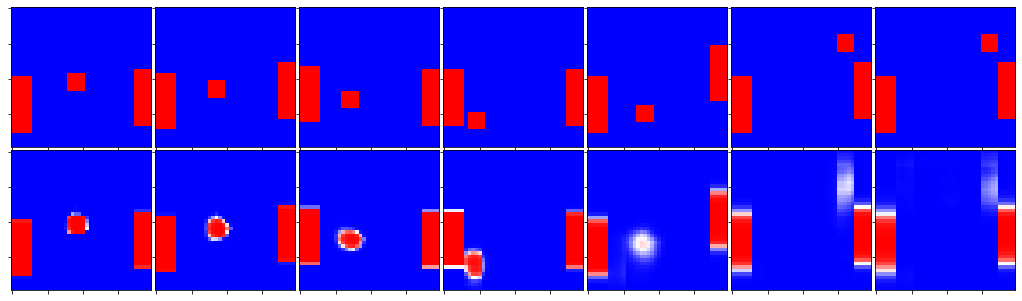

Epoch 169/2500
100/100 [==============================] - 83s 835ms/step - loss: 0.0527 - mean_squared_error: 0.0148 - acc: 0.9807 - val_loss: 0.0485 - val_mean_squared_error: 0.0137 - val_acc: 0.9821


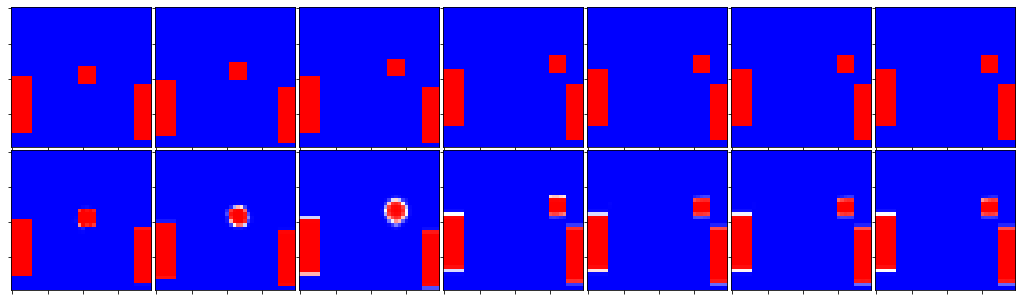

Epoch 170/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0496 - mean_squared_error: 0.0140 - acc: 0.9816 - val_loss: 0.0457 - val_mean_squared_error: 0.0130 - val_acc: 0.9830


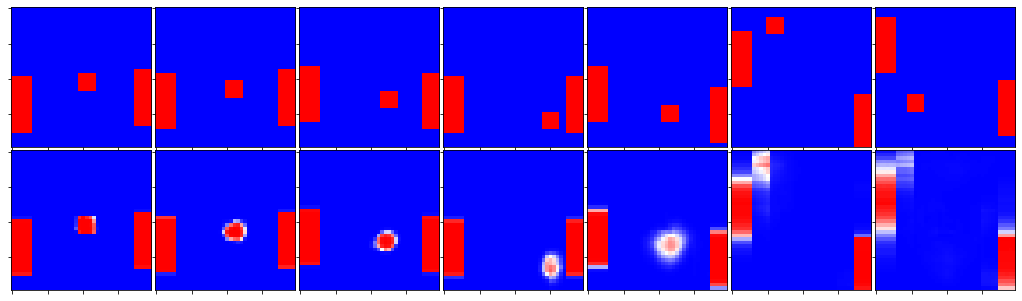

Epoch 171/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0497 - mean_squared_error: 0.0140 - acc: 0.9816 - val_loss: 0.0536 - val_mean_squared_error: 0.0146 - val_acc: 0.9807


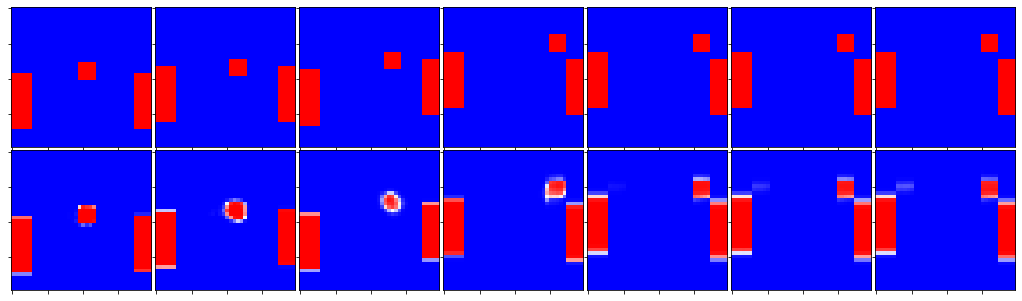

Epoch 172/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0507 - mean_squared_error: 0.0143 - acc: 0.9813 - val_loss: 0.0505 - val_mean_squared_error: 0.0144 - val_acc: 0.9806


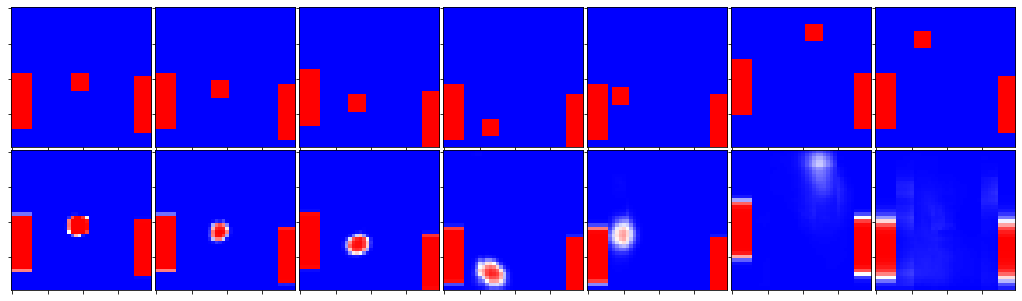

Epoch 173/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0504 - mean_squared_error: 0.0142 - acc: 0.9812 - val_loss: 0.0487 - val_mean_squared_error: 0.0137 - val_acc: 0.9821


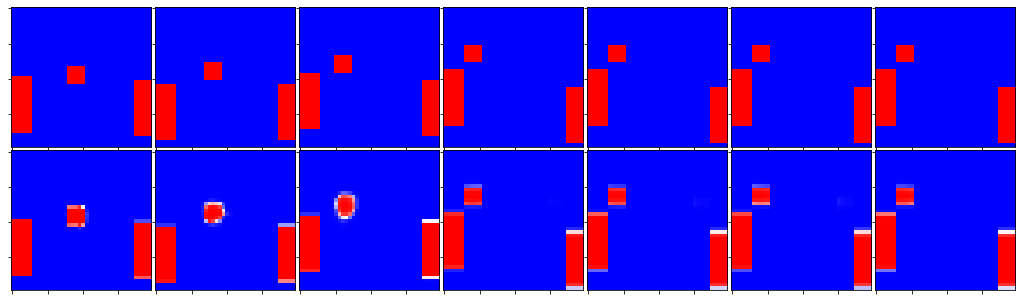

Epoch 174/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0551 - mean_squared_error: 0.0153 - acc: 0.9799 - val_loss: 0.0518 - val_mean_squared_error: 0.0147 - val_acc: 0.9807


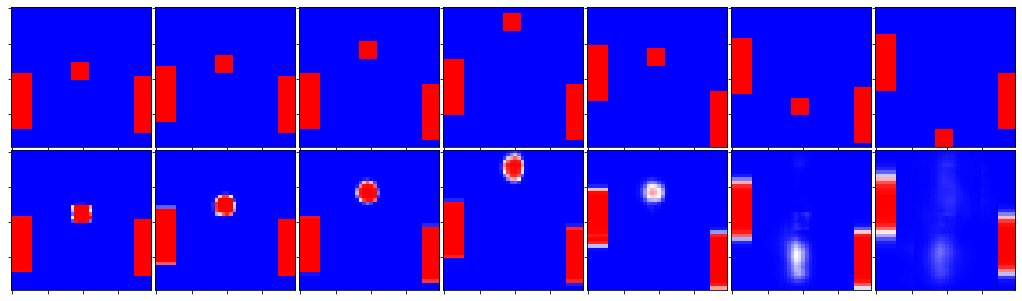

Epoch 175/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.0509 - mean_squared_error: 0.0143 - acc: 0.9812 - val_loss: 0.0453 - val_mean_squared_error: 0.0130 - val_acc: 0.9827


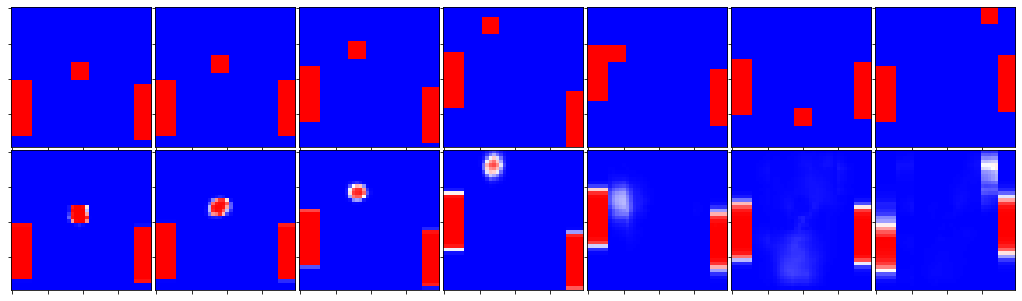

Epoch 176/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0504 - mean_squared_error: 0.0142 - acc: 0.9813 - val_loss: 0.0457 - val_mean_squared_error: 0.0130 - val_acc: 0.9829


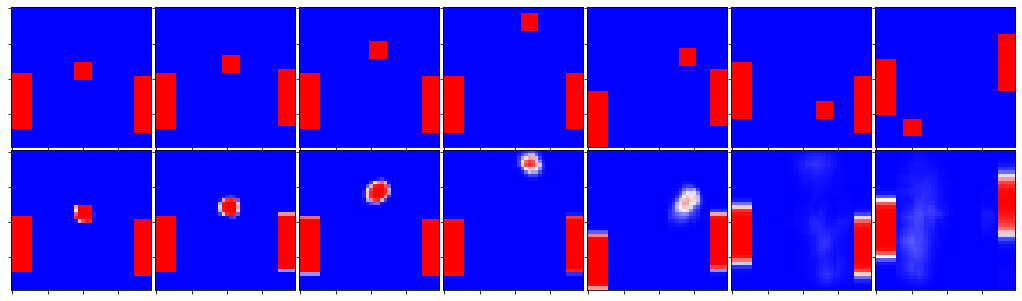

Epoch 177/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0478 - mean_squared_error: 0.0135 - acc: 0.9822 - val_loss: 0.0491 - val_mean_squared_error: 0.0136 - val_acc: 0.9823


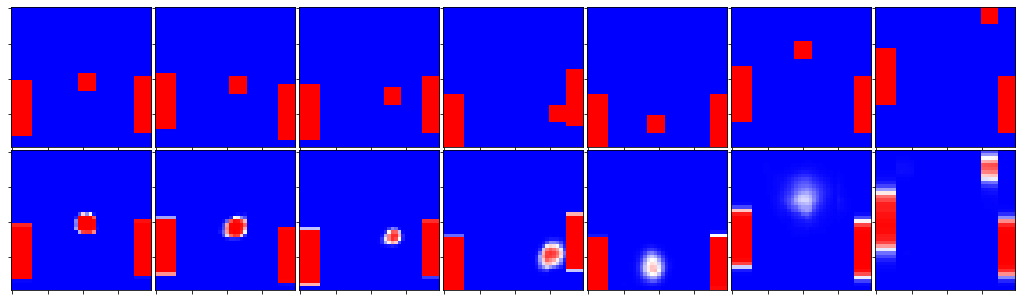

Epoch 178/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0487 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0433 - val_mean_squared_error: 0.0125 - val_acc: 0.9829


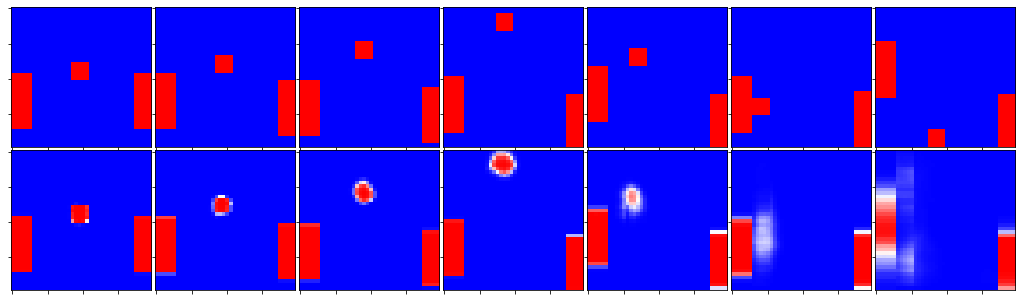

Epoch 179/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0488 - mean_squared_error: 0.0137 - acc: 0.9820 - val_loss: 0.0529 - val_mean_squared_error: 0.0151 - val_acc: 0.9800


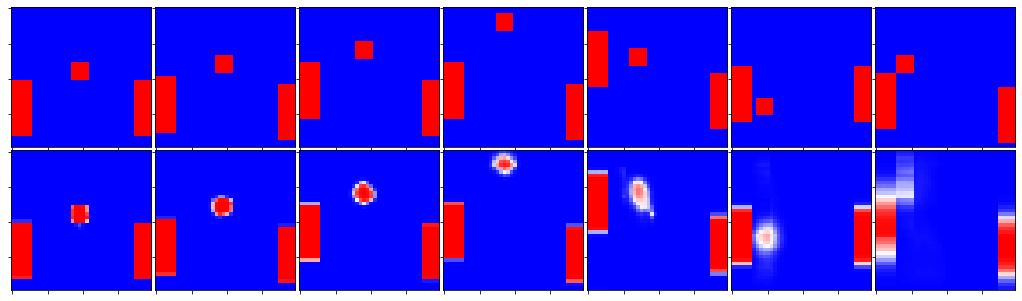

Epoch 180/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0487 - mean_squared_error: 0.0137 - acc: 0.9820 - val_loss: 0.0431 - val_mean_squared_error: 0.0121 - val_acc: 0.9840


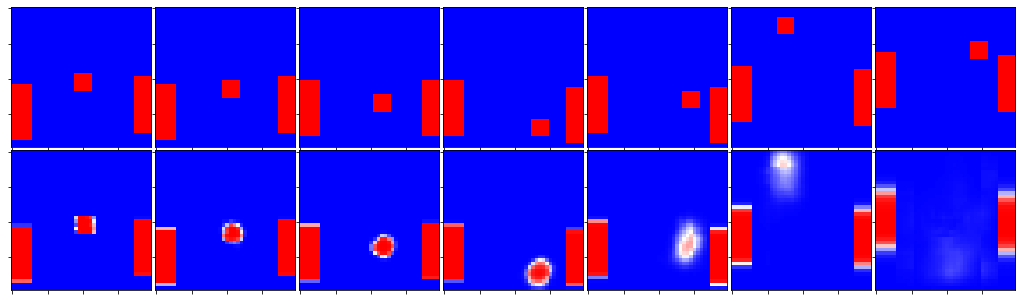

Epoch 181/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0488 - mean_squared_error: 0.0137 - acc: 0.9819 - val_loss: 0.0497 - val_mean_squared_error: 0.0139 - val_acc: 0.9818


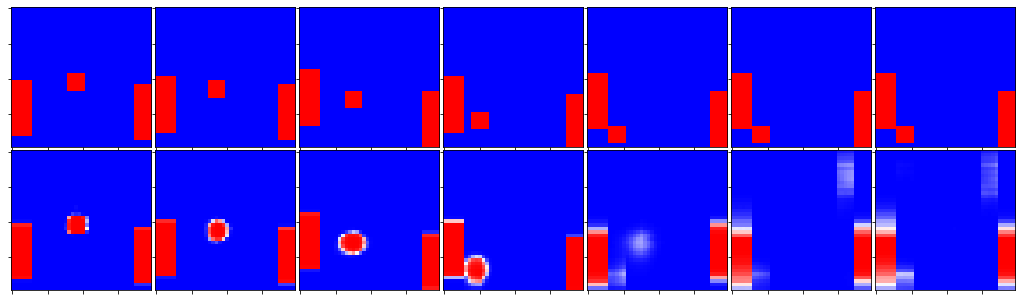

Epoch 182/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0499 - mean_squared_error: 0.0140 - acc: 0.9815 - val_loss: 0.0483 - val_mean_squared_error: 0.0135 - val_acc: 0.9822


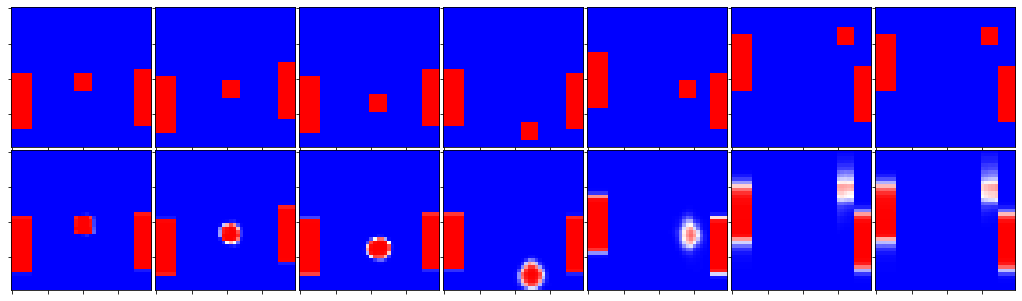

Epoch 183/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0504 - mean_squared_error: 0.0142 - acc: 0.9812 - val_loss: 0.0536 - val_mean_squared_error: 0.0150 - val_acc: 0.9799


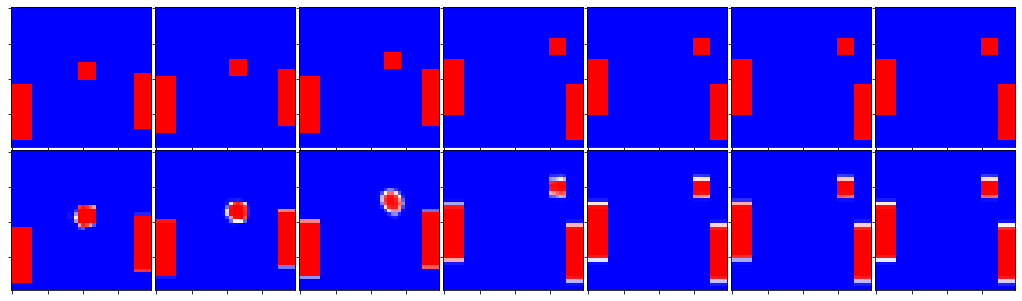

Epoch 184/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0486 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0511 - val_mean_squared_error: 0.0146 - val_acc: 0.9806


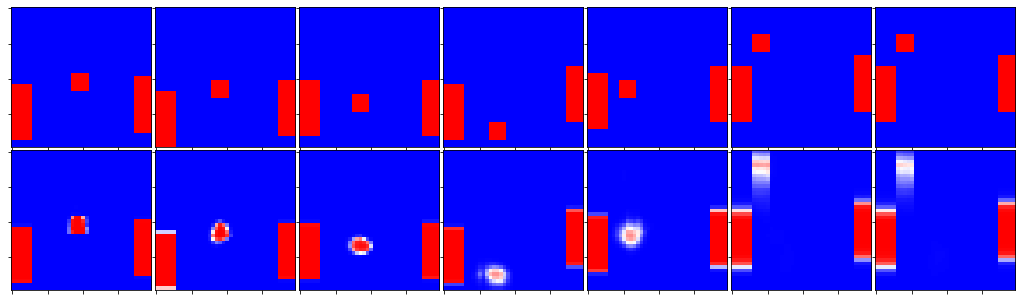

Epoch 185/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0497 - mean_squared_error: 0.0141 - acc: 0.9813 - val_loss: 0.0531 - val_mean_squared_error: 0.0145 - val_acc: 0.9815


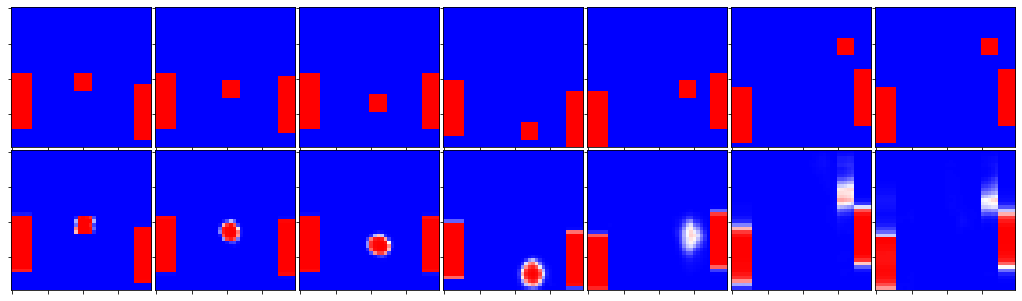

Epoch 186/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0490 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0498 - val_mean_squared_error: 0.0136 - val_acc: 0.9822


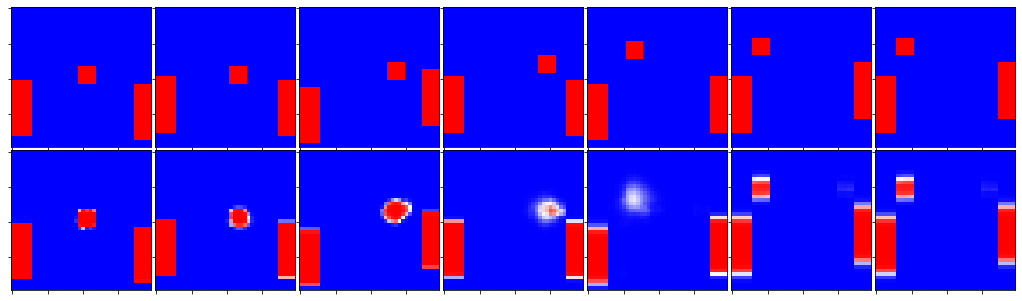

Epoch 187/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0477 - mean_squared_error: 0.0134 - acc: 0.9823 - val_loss: 0.0466 - val_mean_squared_error: 0.0130 - val_acc: 0.9830


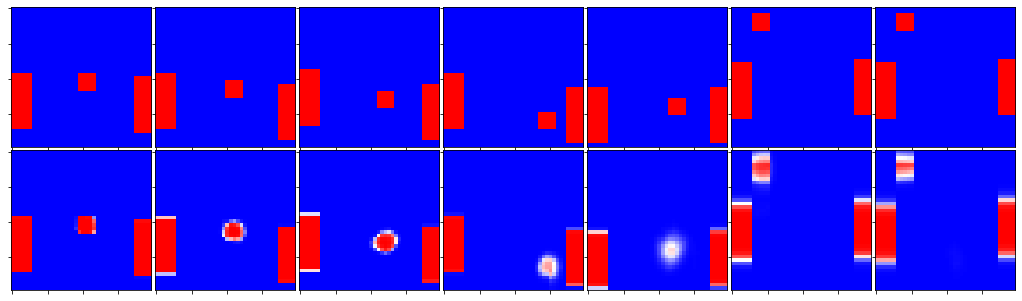

Epoch 188/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0483 - mean_squared_error: 0.0137 - acc: 0.9819 - val_loss: 0.0445 - val_mean_squared_error: 0.0126 - val_acc: 0.9833


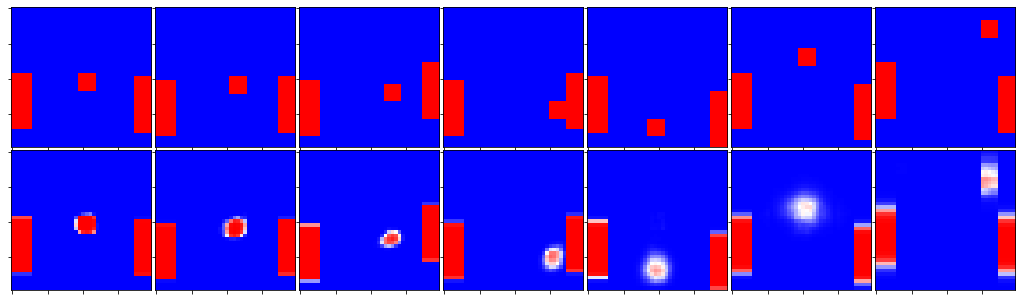

Epoch 189/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0492 - mean_squared_error: 0.0140 - acc: 0.9815 - val_loss: 0.0521 - val_mean_squared_error: 0.0144 - val_acc: 0.9812


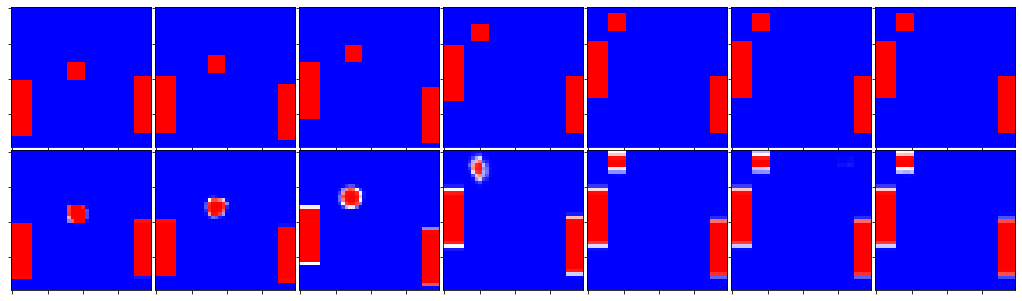

Epoch 190/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0487 - mean_squared_error: 0.0137 - acc: 0.9819 - val_loss: 0.0445 - val_mean_squared_error: 0.0124 - val_acc: 0.9841


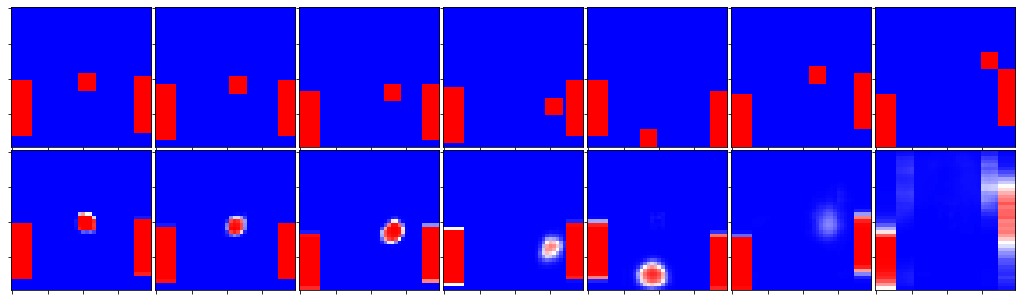

Epoch 191/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0473 - mean_squared_error: 0.0134 - acc: 0.9823 - val_loss: 0.0519 - val_mean_squared_error: 0.0144 - val_acc: 0.9812


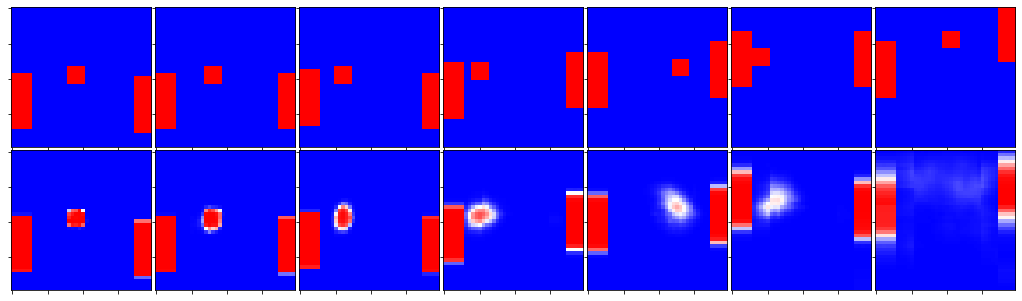

Epoch 192/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0488 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0470 - val_mean_squared_error: 0.0133 - val_acc: 0.9824


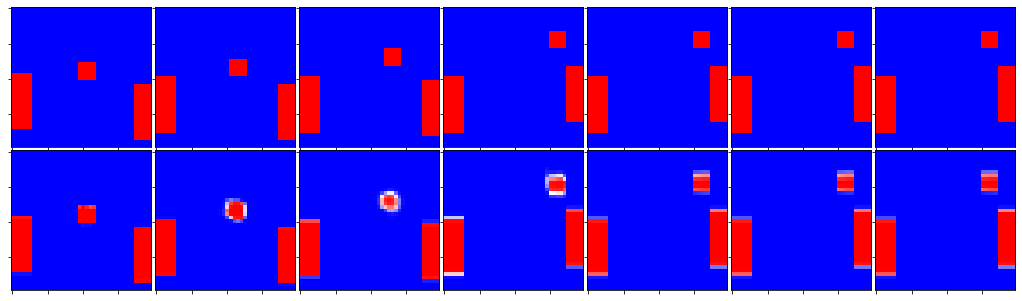

Epoch 193/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0495 - mean_squared_error: 0.0140 - acc: 0.9814 - val_loss: 0.0477 - val_mean_squared_error: 0.0139 - val_acc: 0.9812


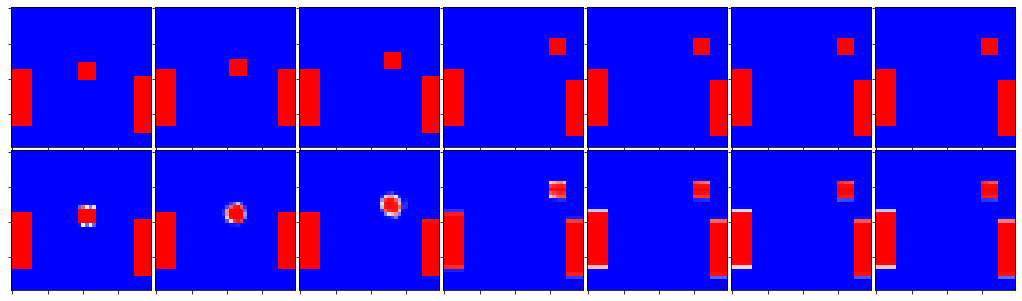

Epoch 194/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0464 - mean_squared_error: 0.0131 - acc: 0.9827 - val_loss: 0.0522 - val_mean_squared_error: 0.0148 - val_acc: 0.9807


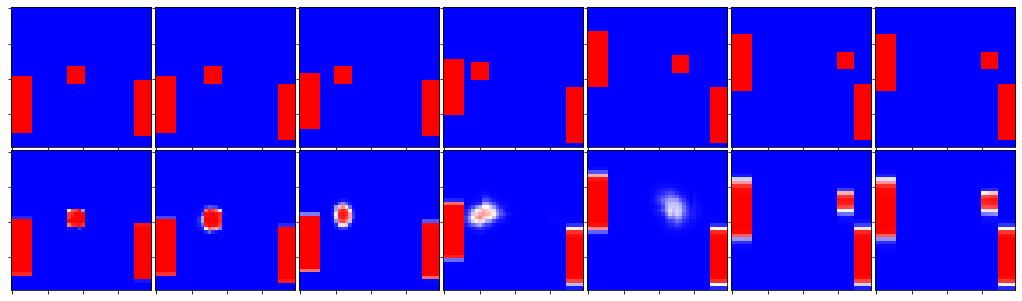

Epoch 195/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0484 - mean_squared_error: 0.0136 - acc: 0.9821 - val_loss: 0.0419 - val_mean_squared_error: 0.0118 - val_acc: 0.9841


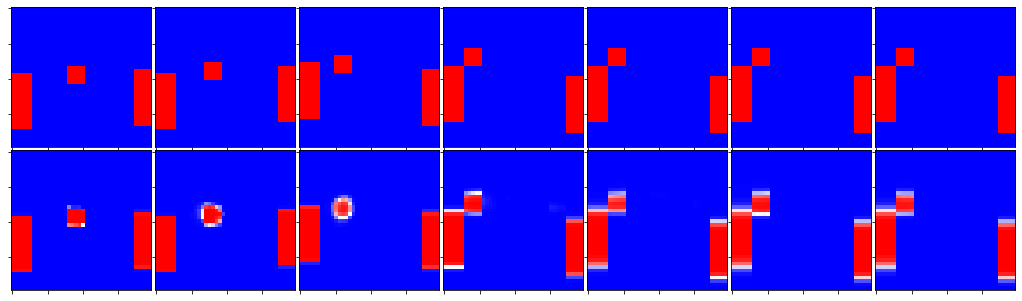

Epoch 196/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0465 - mean_squared_error: 0.0132 - acc: 0.9825 - val_loss: 0.0428 - val_mean_squared_error: 0.0119 - val_acc: 0.9847


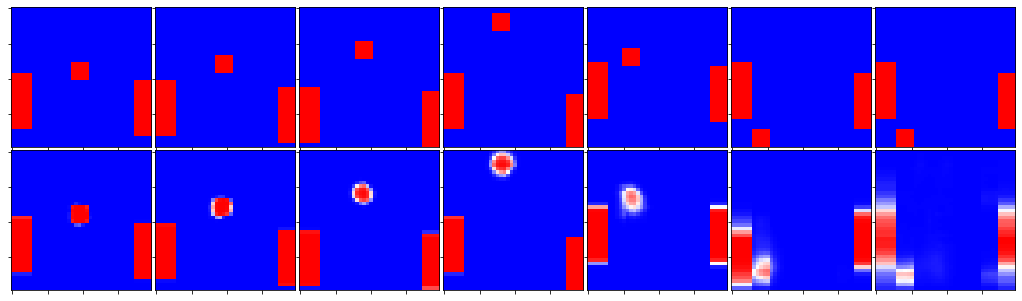

Epoch 197/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0496 - mean_squared_error: 0.0139 - acc: 0.9817 - val_loss: 0.0421 - val_mean_squared_error: 0.0119 - val_acc: 0.9845


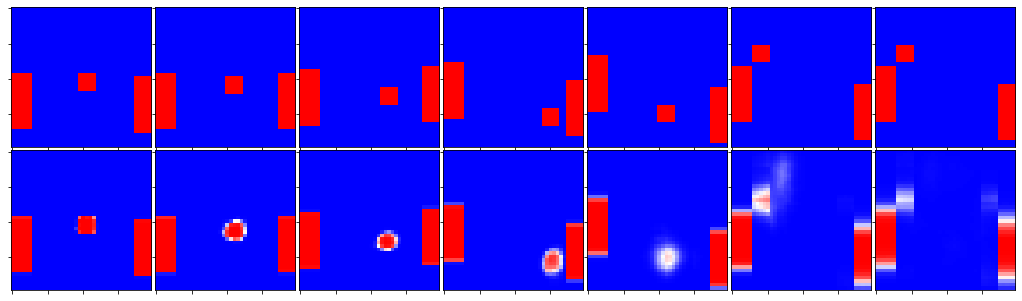

Epoch 198/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0467 - mean_squared_error: 0.0132 - acc: 0.9825 - val_loss: 0.0542 - val_mean_squared_error: 0.0154 - val_acc: 0.9793


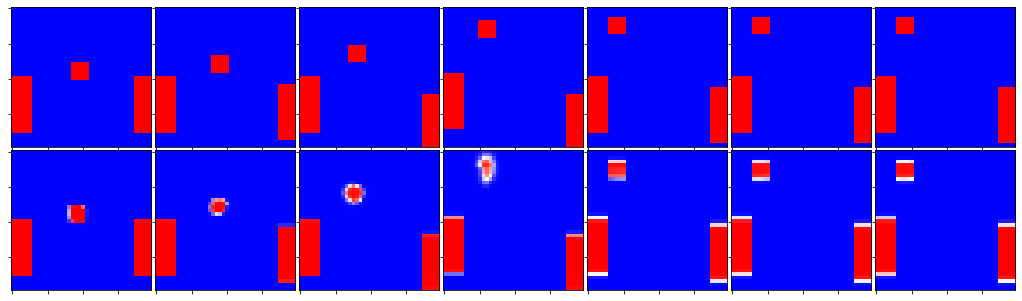

Epoch 199/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0489 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0489 - val_mean_squared_error: 0.0138 - val_acc: 0.9821


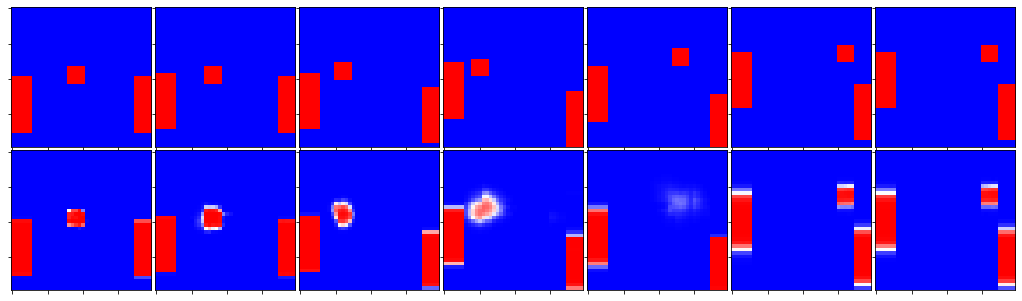

Epoch 200/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0469 - mean_squared_error: 0.0132 - acc: 0.9826 - val_loss: 0.0414 - val_mean_squared_error: 0.0119 - val_acc: 0.9844


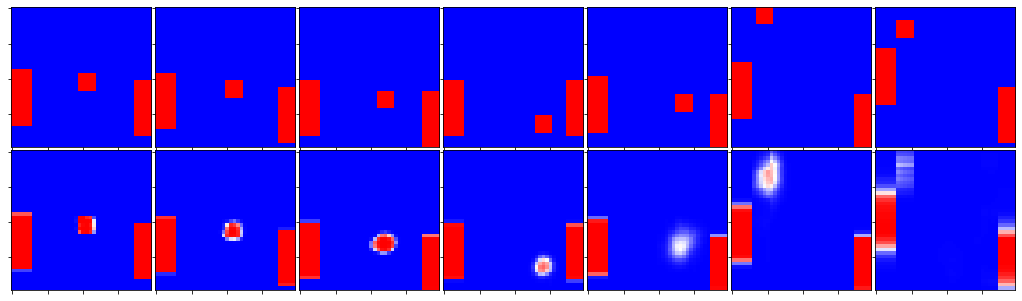

Epoch 201/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0467 - mean_squared_error: 0.0132 - acc: 0.9826 - val_loss: 0.0448 - val_mean_squared_error: 0.0125 - val_acc: 0.9839


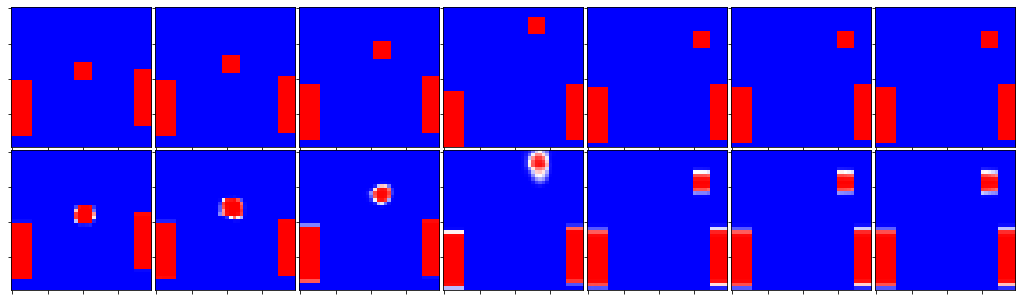

Epoch 202/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0482 - mean_squared_error: 0.0137 - acc: 0.9819 - val_loss: 0.0515 - val_mean_squared_error: 0.0145 - val_acc: 0.9809


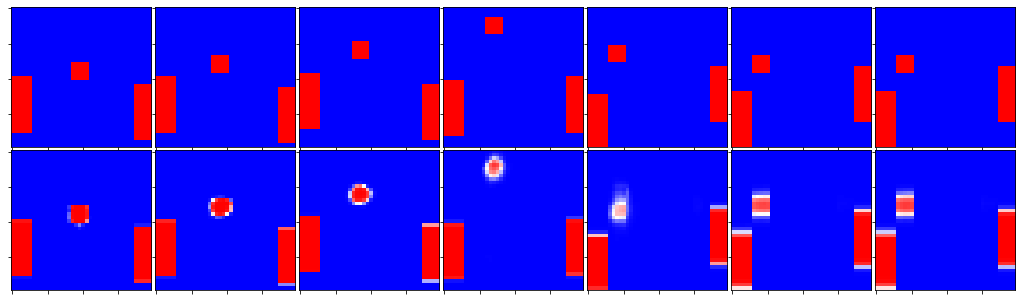

Epoch 203/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0456 - mean_squared_error: 0.0129 - acc: 0.9829 - val_loss: 0.0478 - val_mean_squared_error: 0.0124 - val_acc: 0.9841


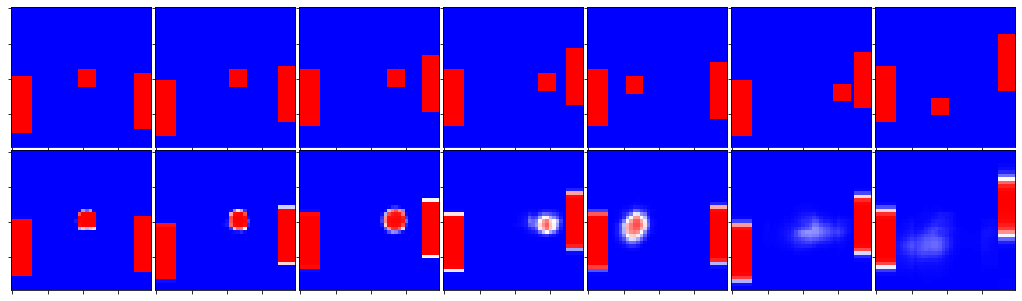

Epoch 204/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0472 - mean_squared_error: 0.0133 - acc: 0.9825 - val_loss: 0.0490 - val_mean_squared_error: 0.0140 - val_acc: 0.9811


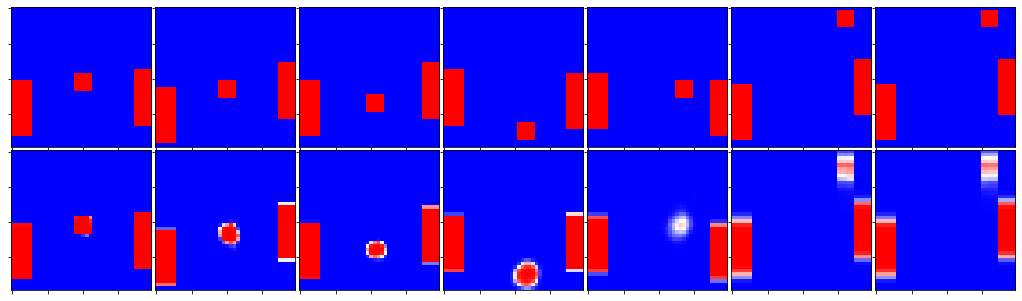

Epoch 205/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0476 - mean_squared_error: 0.0135 - acc: 0.9822 - val_loss: 0.0480 - val_mean_squared_error: 0.0137 - val_acc: 0.9819


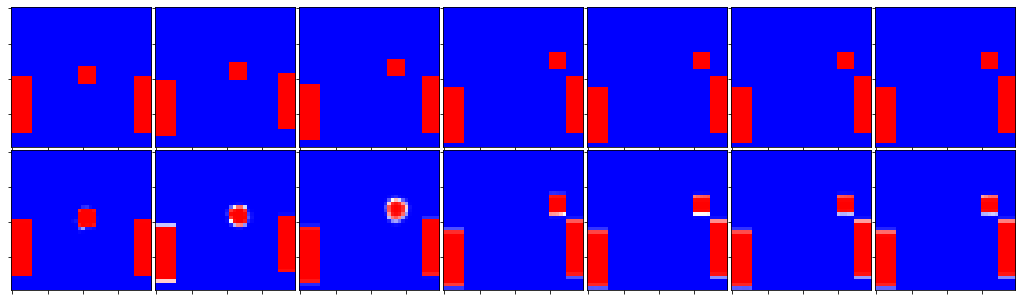

Epoch 206/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0467 - mean_squared_error: 0.0133 - acc: 0.9824 - val_loss: 0.0420 - val_mean_squared_error: 0.0118 - val_acc: 0.9845


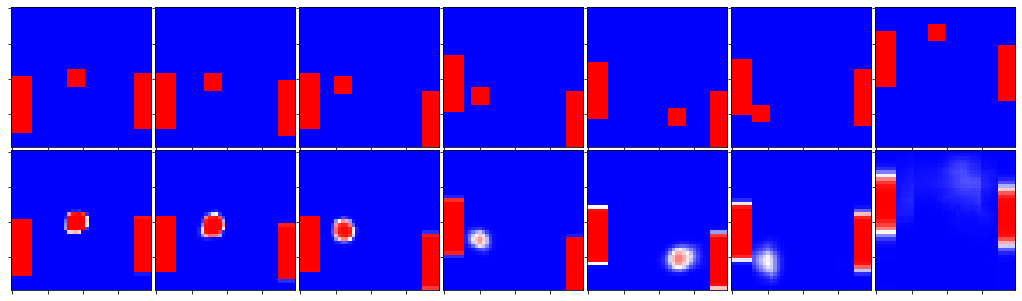

Epoch 207/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0481 - mean_squared_error: 0.0135 - acc: 0.9822 - val_loss: 0.0571 - val_mean_squared_error: 0.0157 - val_acc: 0.9796


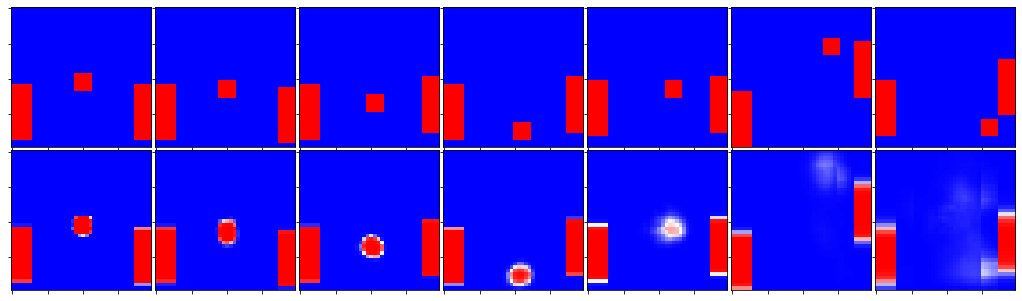

Epoch 208/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0497 - mean_squared_error: 0.0140 - acc: 0.9815 - val_loss: 0.0464 - val_mean_squared_error: 0.0130 - val_acc: 0.9831


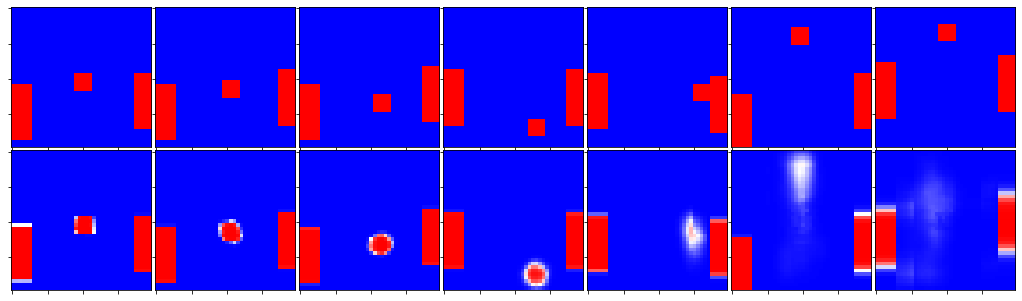

Epoch 209/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0456 - mean_squared_error: 0.0129 - acc: 0.9830 - val_loss: 0.0446 - val_mean_squared_error: 0.0128 - val_acc: 0.9831


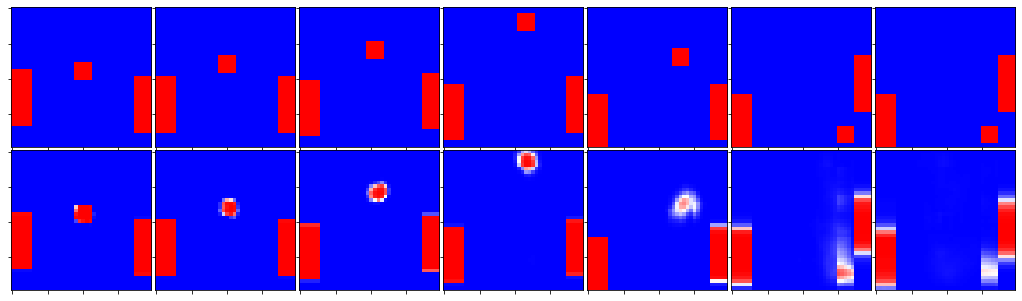

Epoch 210/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0457 - mean_squared_error: 0.0129 - acc: 0.9830 - val_loss: 0.0417 - val_mean_squared_error: 0.0118 - val_acc: 0.9843


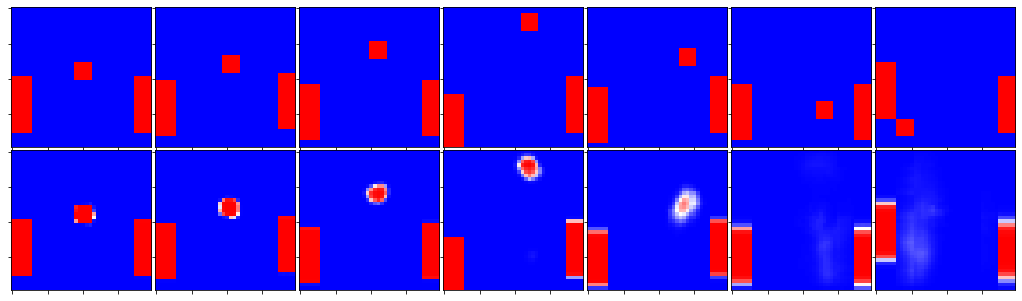

Epoch 211/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0463 - mean_squared_error: 0.0131 - acc: 0.9827 - val_loss: 0.0465 - val_mean_squared_error: 0.0134 - val_acc: 0.9823


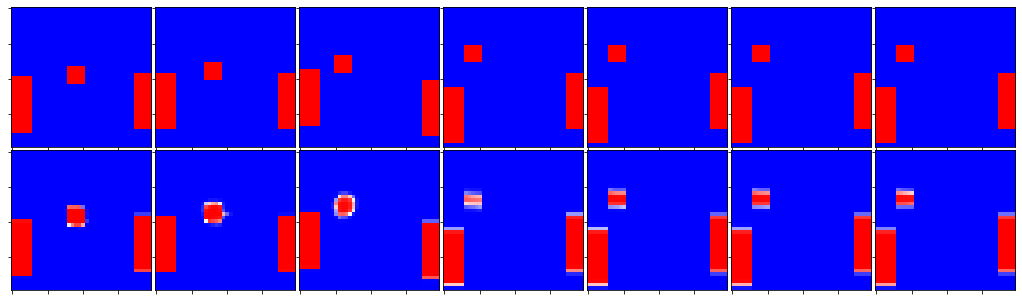

Epoch 212/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0461 - mean_squared_error: 0.0131 - acc: 0.9827 - val_loss: 0.0457 - val_mean_squared_error: 0.0129 - val_acc: 0.9831


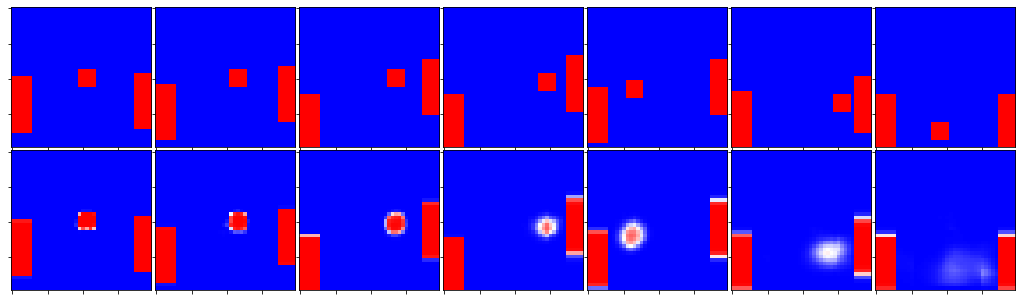

Epoch 213/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0482 - mean_squared_error: 0.0137 - acc: 0.9818 - val_loss: 0.0446 - val_mean_squared_error: 0.0130 - val_acc: 0.9822


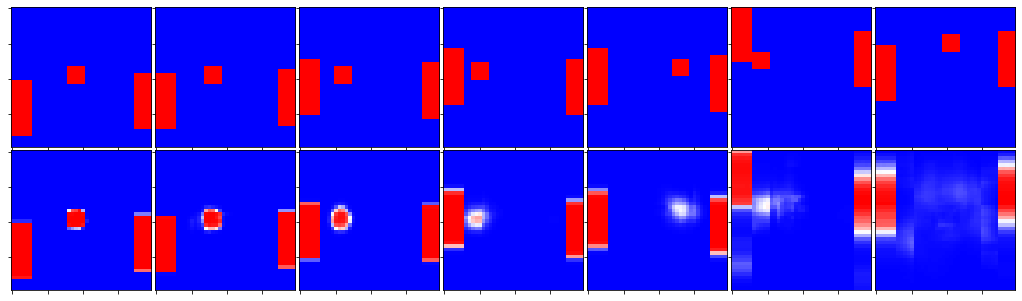

Epoch 214/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0514 - mean_squared_error: 0.0142 - acc: 0.9813 - val_loss: 0.0425 - val_mean_squared_error: 0.0120 - val_acc: 0.9842


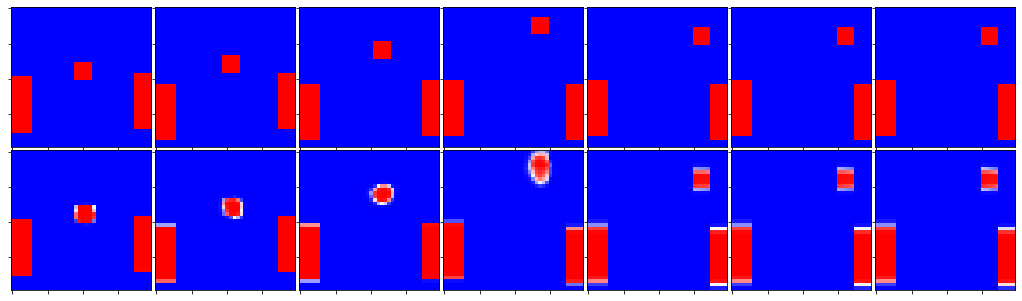

Epoch 215/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0459 - mean_squared_error: 0.0129 - acc: 0.9830 - val_loss: 0.0502 - val_mean_squared_error: 0.0140 - val_acc: 0.9817


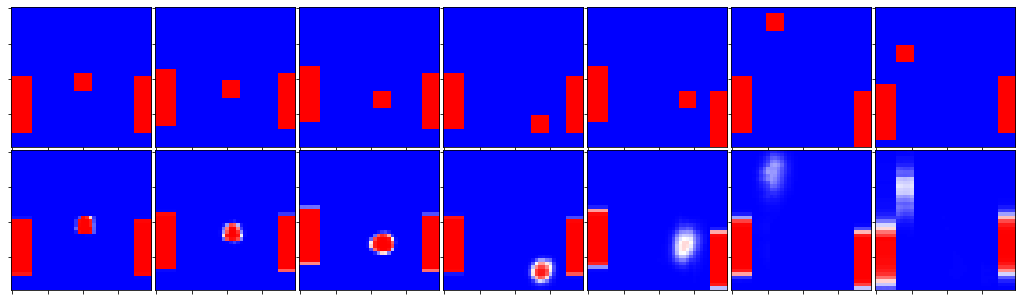

Epoch 216/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0453 - mean_squared_error: 0.0128 - acc: 0.9830 - val_loss: 0.0425 - val_mean_squared_error: 0.0120 - val_acc: 0.9840


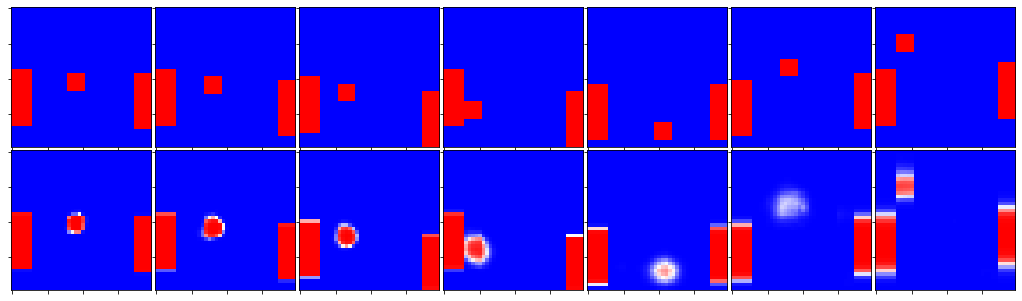

Epoch 217/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0467 - mean_squared_error: 0.0132 - acc: 0.9827 - val_loss: 0.0426 - val_mean_squared_error: 0.0124 - val_acc: 0.9835


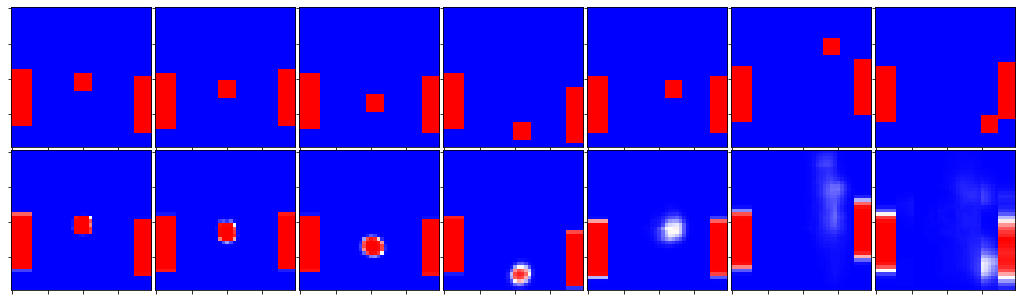

Epoch 218/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0452 - mean_squared_error: 0.0128 - acc: 0.9832 - val_loss: 0.0461 - val_mean_squared_error: 0.0127 - val_acc: 0.9838


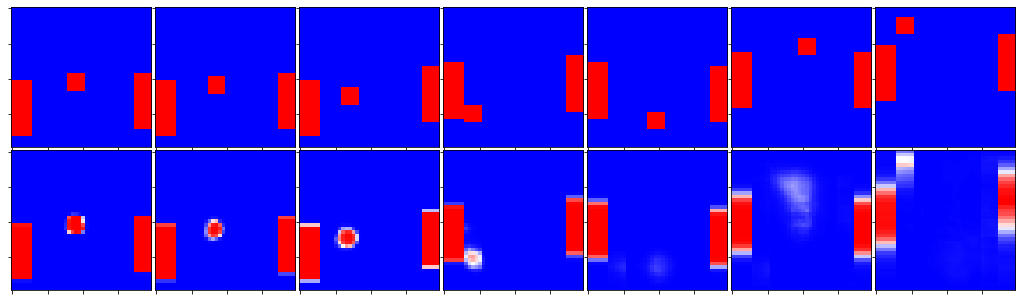

Epoch 219/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0468 - mean_squared_error: 0.0133 - acc: 0.9824 - val_loss: 0.0402 - val_mean_squared_error: 0.0113 - val_acc: 0.9854


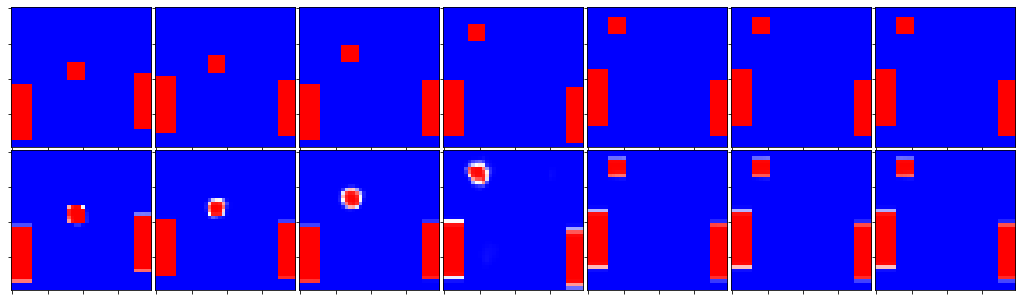

Epoch 220/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0464 - mean_squared_error: 0.0131 - acc: 0.9826 - val_loss: 0.0484 - val_mean_squared_error: 0.0133 - val_acc: 0.9829


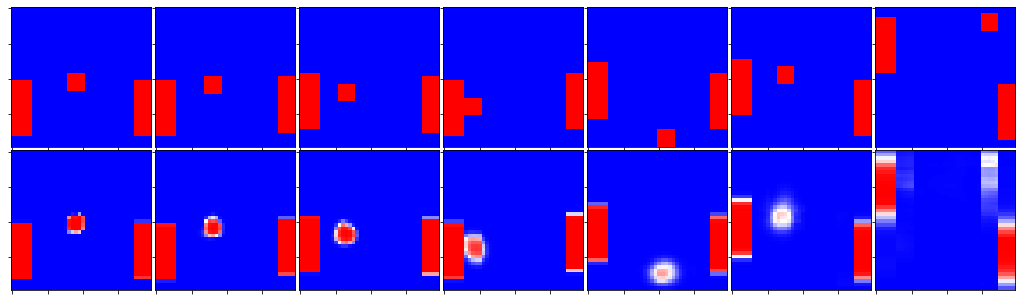

Epoch 221/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0436 - mean_squared_error: 0.0124 - acc: 0.9836 - val_loss: 0.0612 - val_mean_squared_error: 0.0154 - val_acc: 0.9801


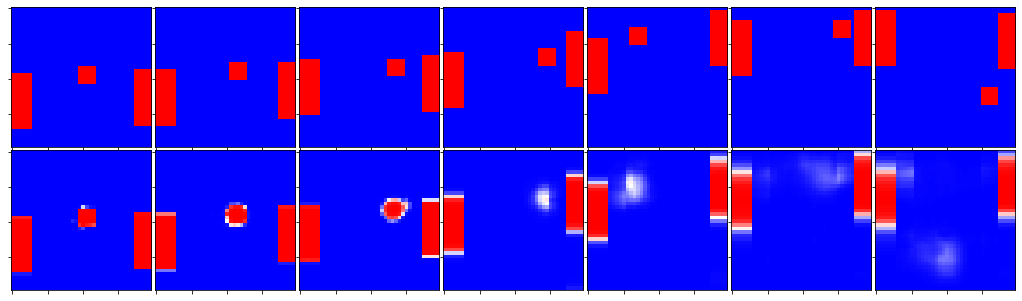

Epoch 222/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0491 - mean_squared_error: 0.0138 - acc: 0.9819 - val_loss: 0.0436 - val_mean_squared_error: 0.0126 - val_acc: 0.9831


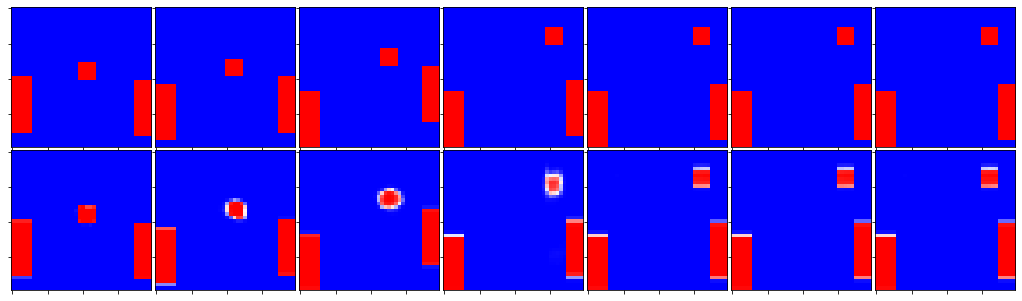

Epoch 223/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0463 - mean_squared_error: 0.0131 - acc: 0.9826 - val_loss: 0.0486 - val_mean_squared_error: 0.0139 - val_acc: 0.9817


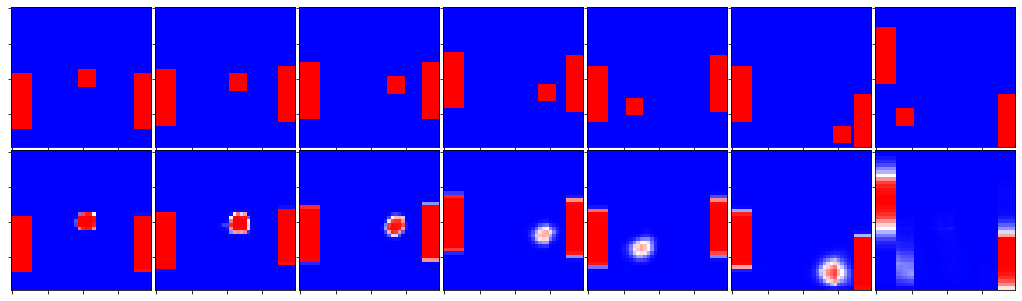

Epoch 224/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0453 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0577 - val_mean_squared_error: 0.0153 - val_acc: 0.9799


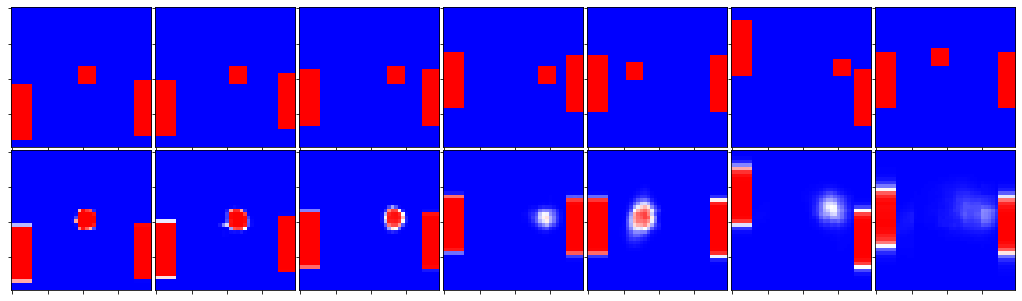

Epoch 225/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0432 - mean_squared_error: 0.0123 - acc: 0.9838 - val_loss: 0.0404 - val_mean_squared_error: 0.0116 - val_acc: 0.9847


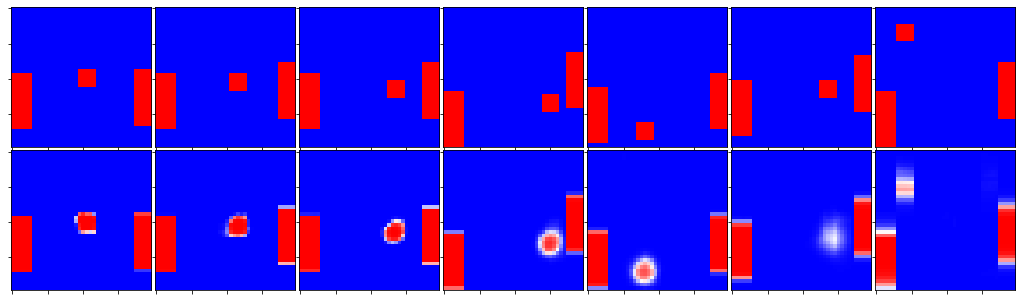

Epoch 226/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0468 - mean_squared_error: 0.0131 - acc: 0.9826 - val_loss: 0.0477 - val_mean_squared_error: 0.0135 - val_acc: 0.9824


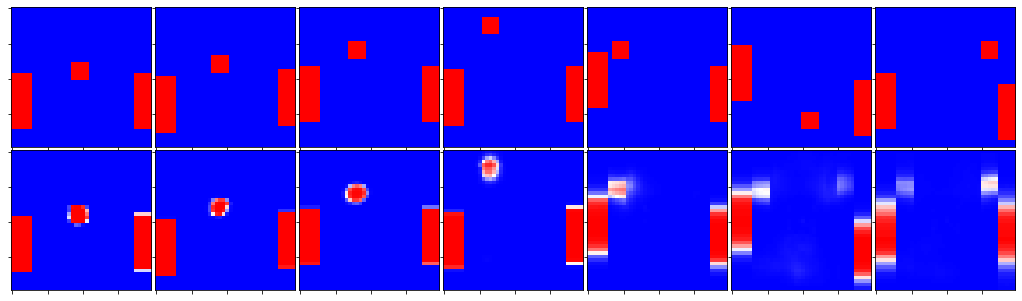

Epoch 227/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0473 - mean_squared_error: 0.0134 - acc: 0.9824 - val_loss: 0.0485 - val_mean_squared_error: 0.0134 - val_acc: 0.9826


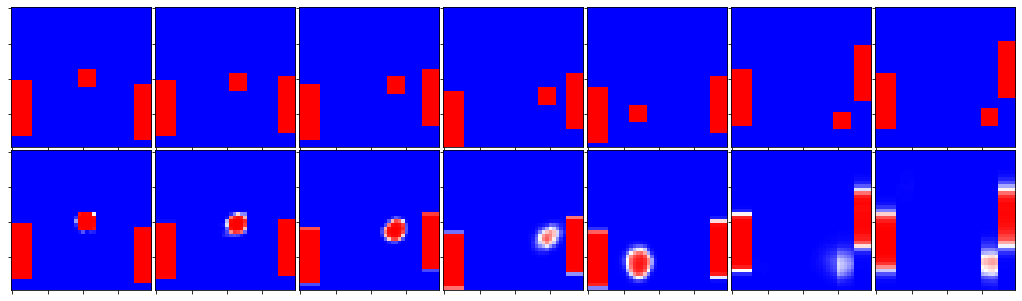

Epoch 228/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0454 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0408 - val_mean_squared_error: 0.0117 - val_acc: 0.9844


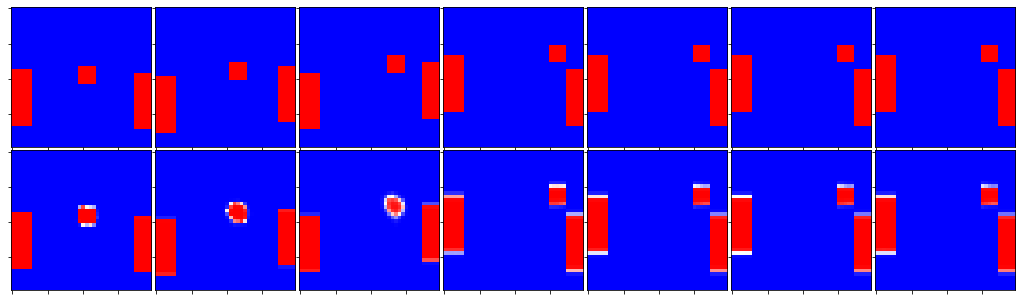

Epoch 229/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0440 - mean_squared_error: 0.0125 - acc: 0.9835 - val_loss: 0.0403 - val_mean_squared_error: 0.0116 - val_acc: 0.9845


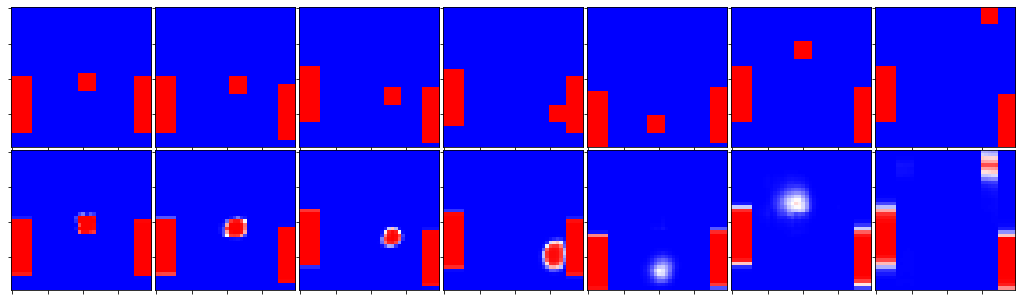

Epoch 230/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0463 - mean_squared_error: 0.0130 - acc: 0.9829 - val_loss: 0.0461 - val_mean_squared_error: 0.0131 - val_acc: 0.9828


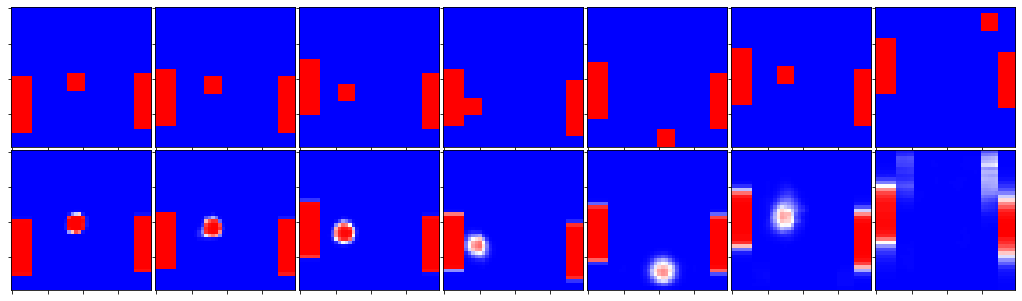

Epoch 231/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0452 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0431 - val_mean_squared_error: 0.0124 - val_acc: 0.9833


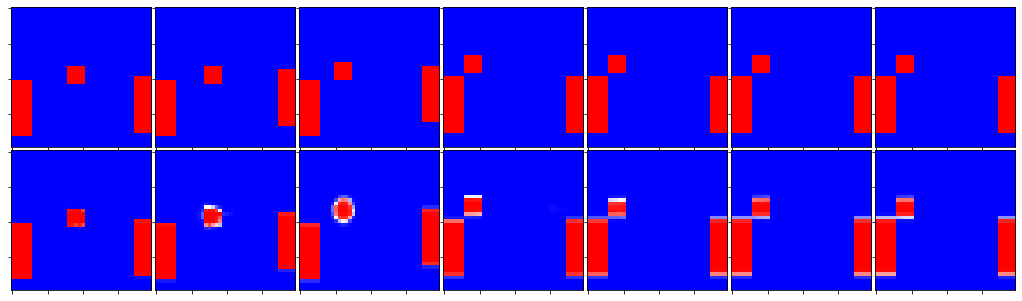

Epoch 232/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0466 - mean_squared_error: 0.0132 - acc: 0.9826 - val_loss: 0.0481 - val_mean_squared_error: 0.0138 - val_acc: 0.9818


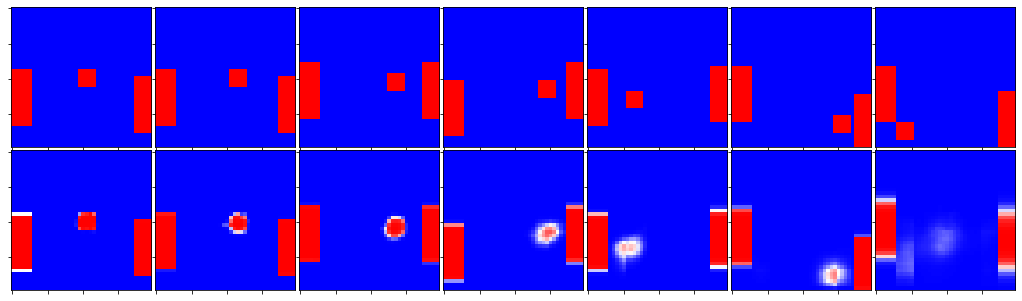

Epoch 233/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0452 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0417 - val_mean_squared_error: 0.0117 - val_acc: 0.9845


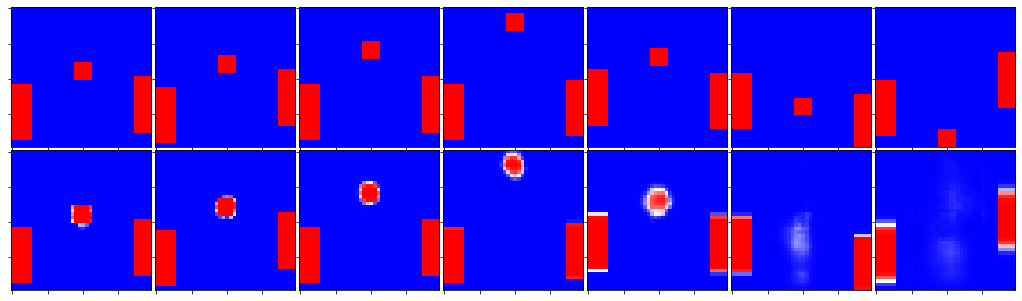

Epoch 234/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0445 - mean_squared_error: 0.0126 - acc: 0.9834 - val_loss: 0.0414 - val_mean_squared_error: 0.0117 - val_acc: 0.9845


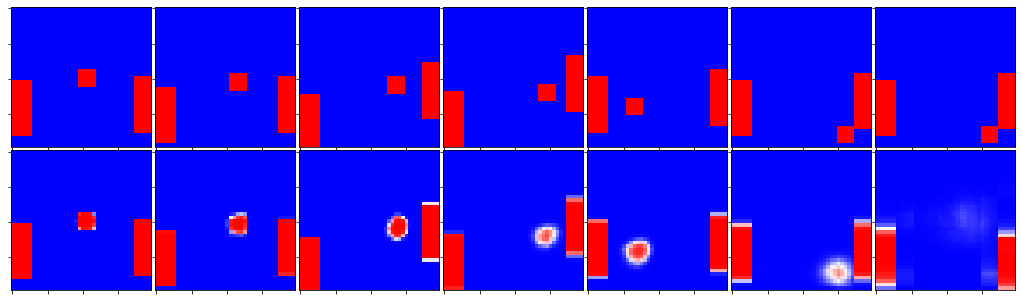

Epoch 235/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0458 - mean_squared_error: 0.0130 - acc: 0.9829 - val_loss: 0.0468 - val_mean_squared_error: 0.0133 - val_acc: 0.9825


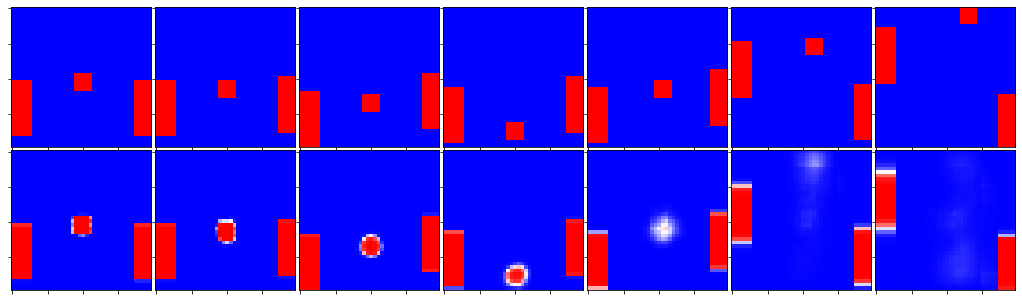

Epoch 236/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0429 - mean_squared_error: 0.0122 - acc: 0.9839 - val_loss: 0.0473 - val_mean_squared_error: 0.0128 - val_acc: 0.9836


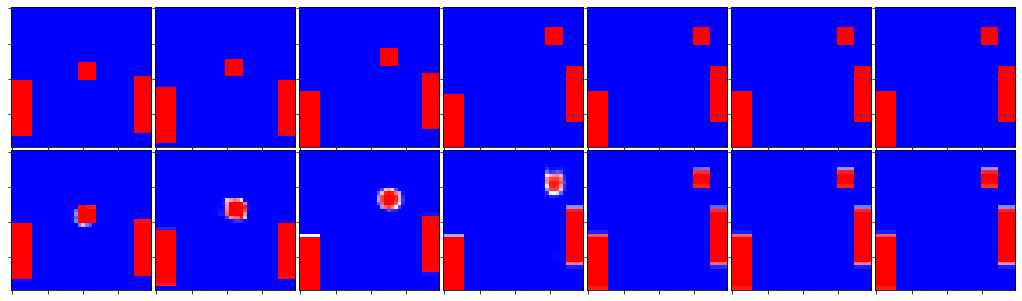

Epoch 237/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0448 - mean_squared_error: 0.0127 - acc: 0.9832 - val_loss: 0.0444 - val_mean_squared_error: 0.0126 - val_acc: 0.9834


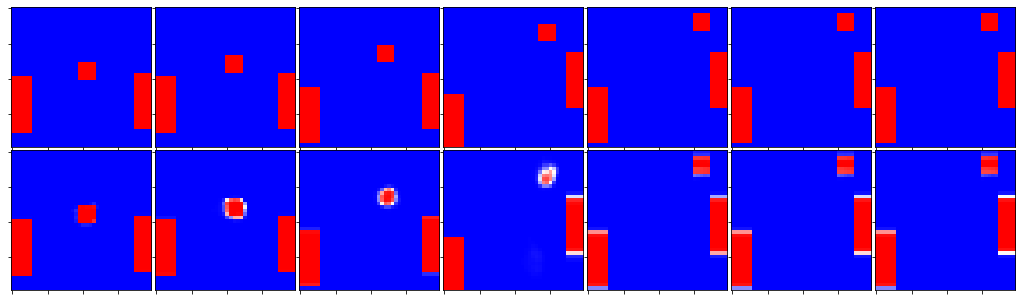

Epoch 238/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0479 - mean_squared_error: 0.0135 - acc: 0.9821 - val_loss: 0.0480 - val_mean_squared_error: 0.0138 - val_acc: 0.9816


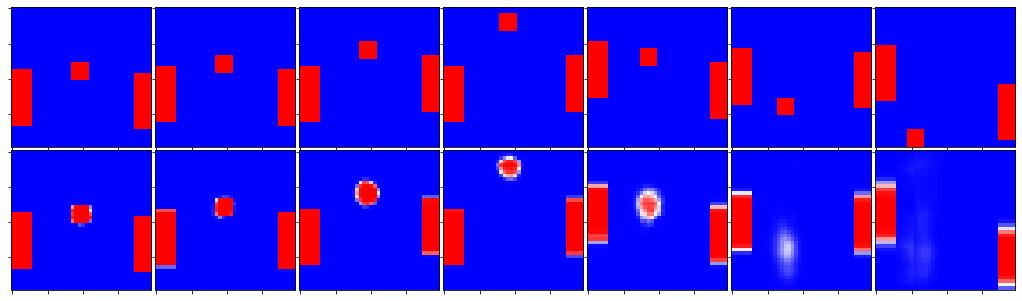

Epoch 239/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0448 - mean_squared_error: 0.0127 - acc: 0.9833 - val_loss: 0.0451 - val_mean_squared_error: 0.0131 - val_acc: 0.9824


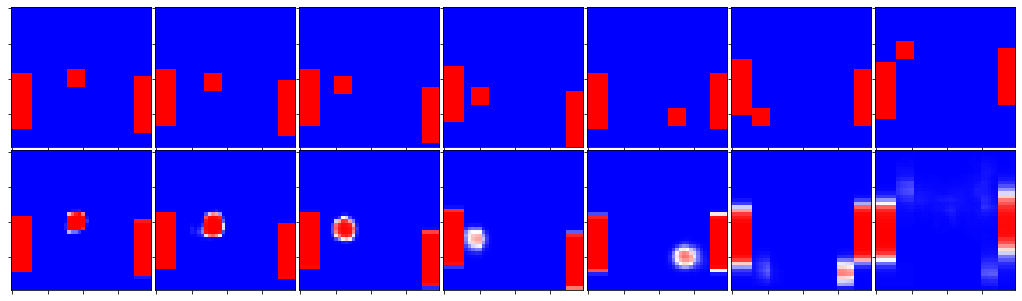

Epoch 240/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0466 - mean_squared_error: 0.0132 - acc: 0.9825 - val_loss: 0.0417 - val_mean_squared_error: 0.0124 - val_acc: 0.9832


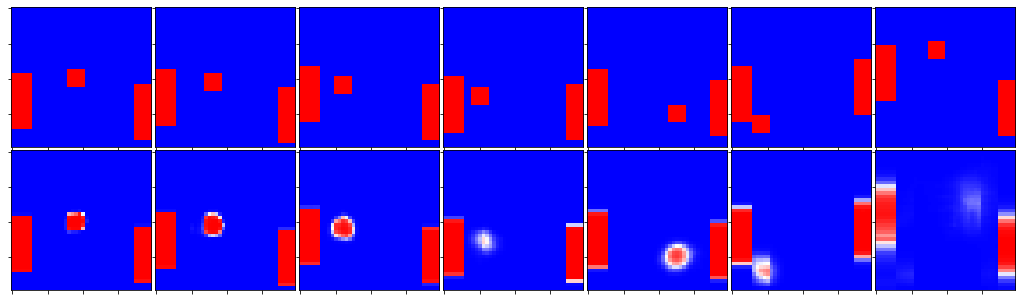

Epoch 241/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0454 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0444 - val_mean_squared_error: 0.0127 - val_acc: 0.9835


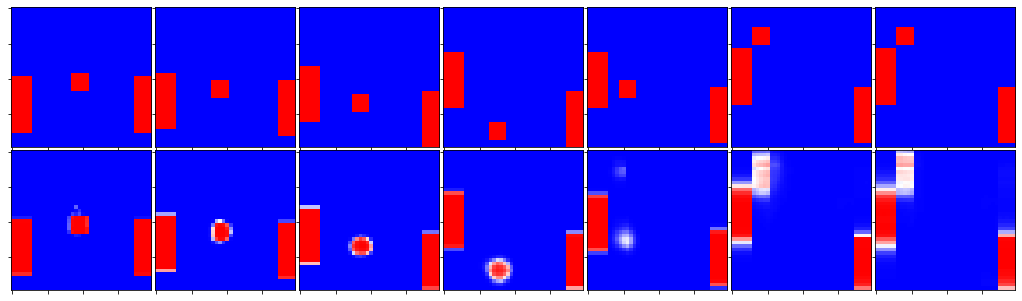

Epoch 242/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0434 - mean_squared_error: 0.0123 - acc: 0.9837 - val_loss: 0.0447 - val_mean_squared_error: 0.0126 - val_acc: 0.9834


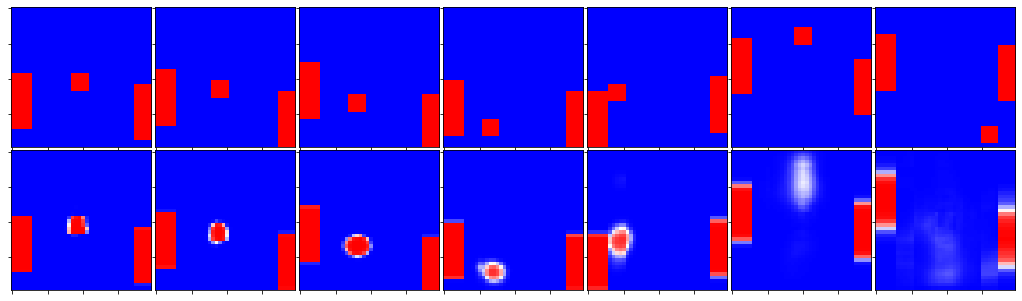

Epoch 243/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0436 - mean_squared_error: 0.0124 - acc: 0.9835 - val_loss: 0.0420 - val_mean_squared_error: 0.0120 - val_acc: 0.9838


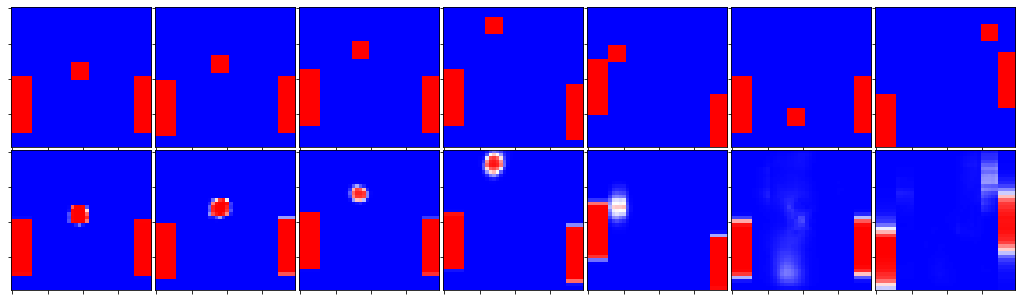

Epoch 244/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0447 - mean_squared_error: 0.0126 - acc: 0.9833 - val_loss: 0.0505 - val_mean_squared_error: 0.0143 - val_acc: 0.9811


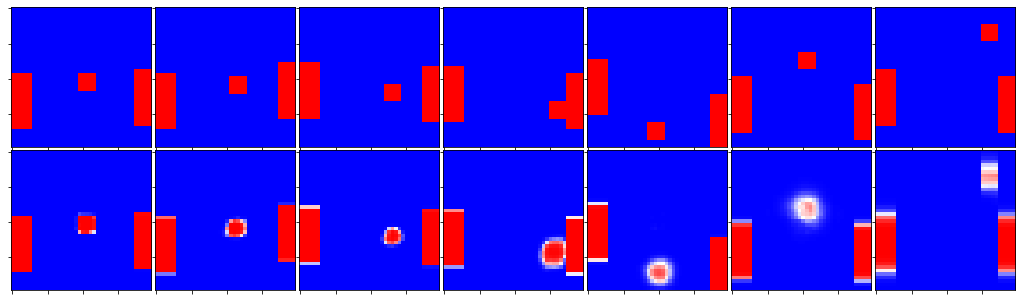

Epoch 245/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0445 - mean_squared_error: 0.0127 - acc: 0.9832 - val_loss: 0.0461 - val_mean_squared_error: 0.0128 - val_acc: 0.9832


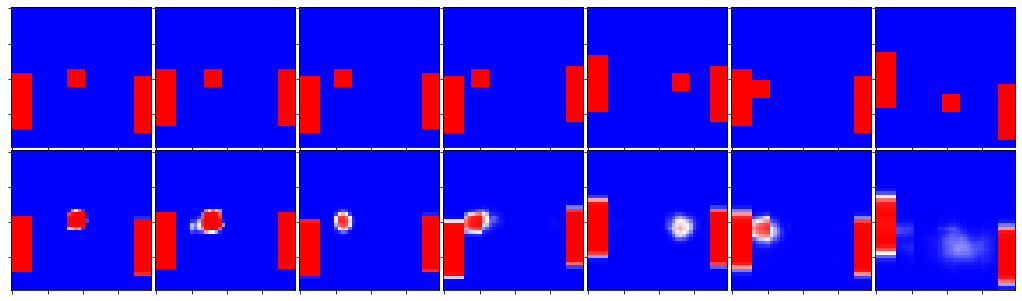

Epoch 246/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0431 - mean_squared_error: 0.0122 - acc: 0.9840 - val_loss: 0.0657 - val_mean_squared_error: 0.0169 - val_acc: 0.9787


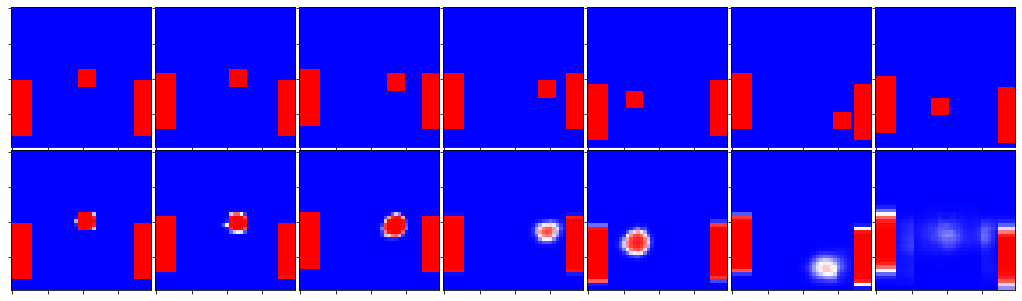

Epoch 247/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0456 - mean_squared_error: 0.0129 - acc: 0.9829 - val_loss: 0.0462 - val_mean_squared_error: 0.0134 - val_acc: 0.9821


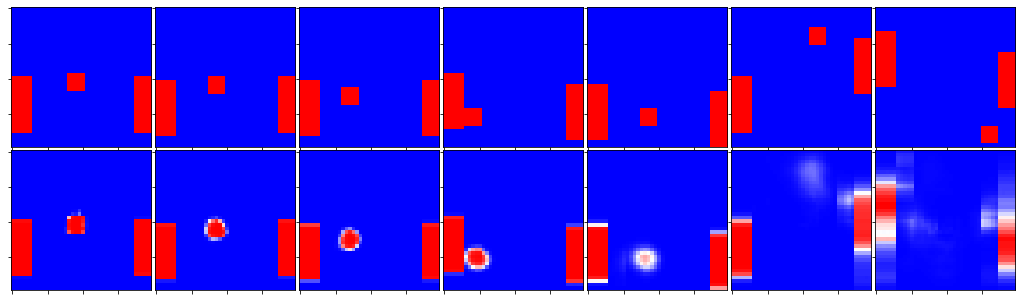

Epoch 248/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0436 - mean_squared_error: 0.0124 - acc: 0.9836 - val_loss: 0.0564 - val_mean_squared_error: 0.0156 - val_acc: 0.9795


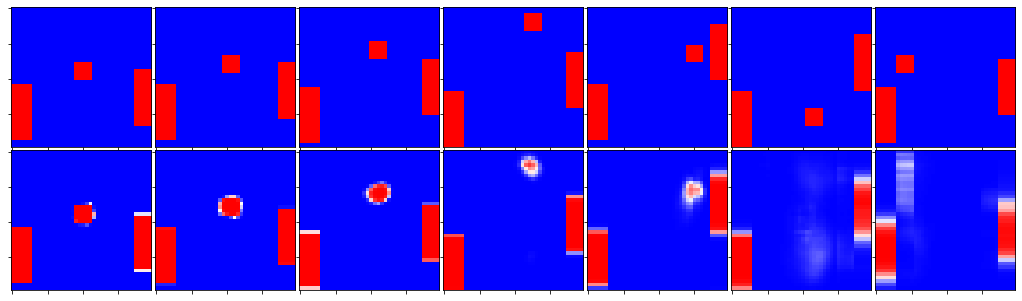

Epoch 249/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0428 - mean_squared_error: 0.0121 - acc: 0.9839 - val_loss: 0.0455 - val_mean_squared_error: 0.0126 - val_acc: 0.9837


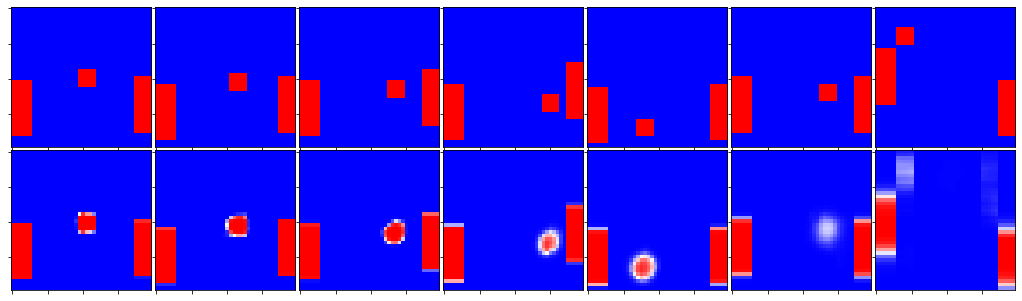

Epoch 250/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0448 - mean_squared_error: 0.0126 - acc: 0.9833 - val_loss: 0.0377 - val_mean_squared_error: 0.0110 - val_acc: 0.9850


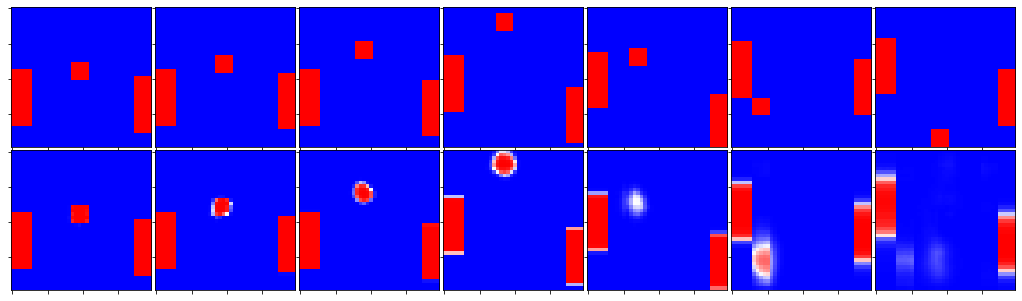

Epoch 251/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0427 - mean_squared_error: 0.0122 - acc: 0.9839 - val_loss: 0.0396 - val_mean_squared_error: 0.0114 - val_acc: 0.9848


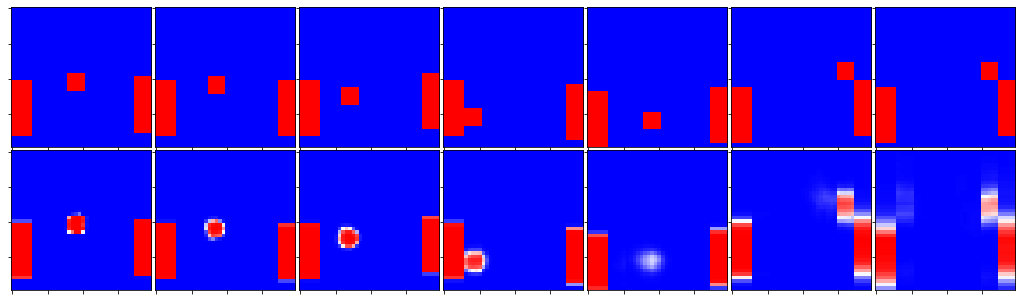

Epoch 252/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0430 - mean_squared_error: 0.0122 - acc: 0.9839 - val_loss: 0.0374 - val_mean_squared_error: 0.0109 - val_acc: 0.9855


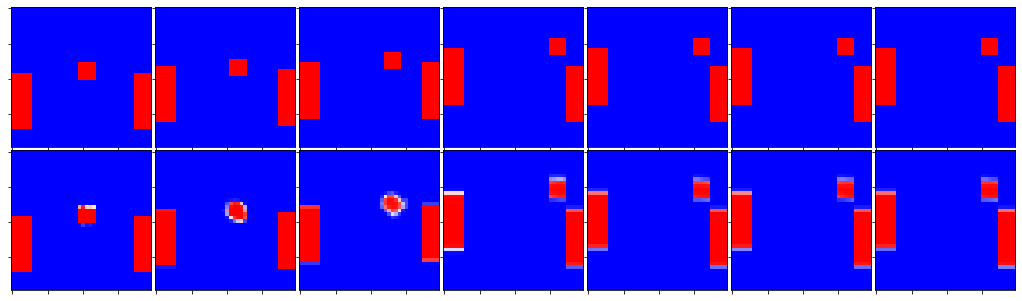

Epoch 253/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0477 - mean_squared_error: 0.0135 - acc: 0.9823 - val_loss: 0.0458 - val_mean_squared_error: 0.0130 - val_acc: 0.9825


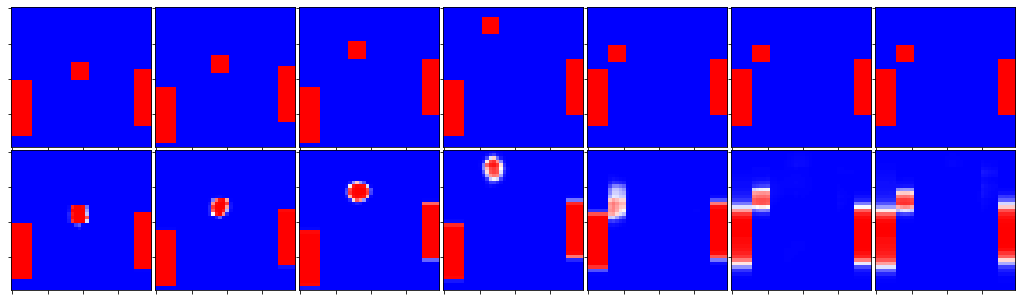

Epoch 254/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0428 - mean_squared_error: 0.0121 - acc: 0.9840 - val_loss: 0.0388 - val_mean_squared_error: 0.0111 - val_acc: 0.9856


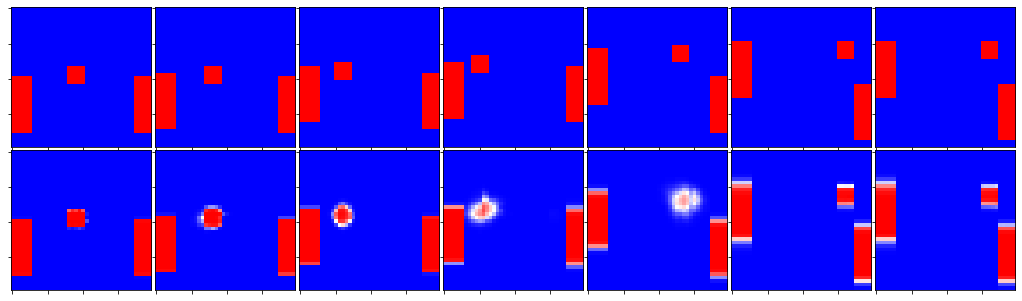

Epoch 255/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0434 - mean_squared_error: 0.0123 - acc: 0.9836 - val_loss: 0.0422 - val_mean_squared_error: 0.0118 - val_acc: 0.9846


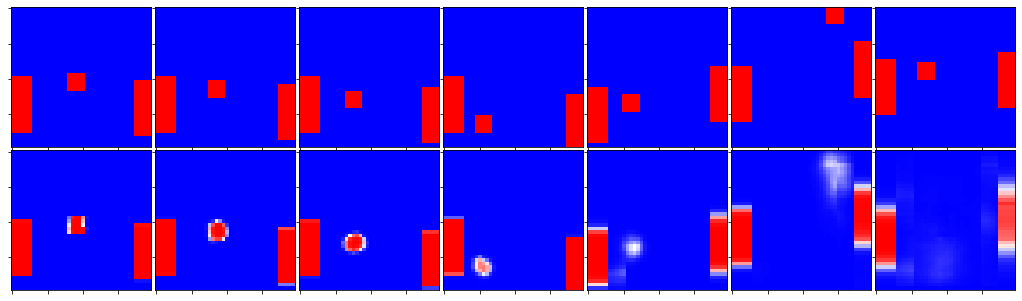

Epoch 256/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0456 - mean_squared_error: 0.0129 - acc: 0.9828 - val_loss: 0.0424 - val_mean_squared_error: 0.0121 - val_acc: 0.9839


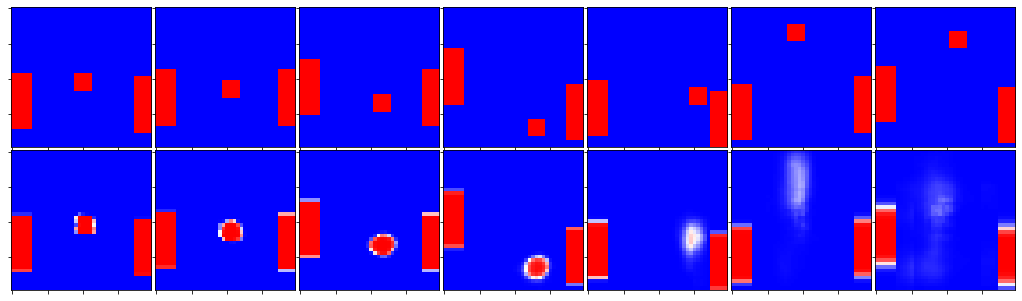

Epoch 257/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0477 - mean_squared_error: 0.0135 - acc: 0.9821 - val_loss: 0.0383 - val_mean_squared_error: 0.0111 - val_acc: 0.9853


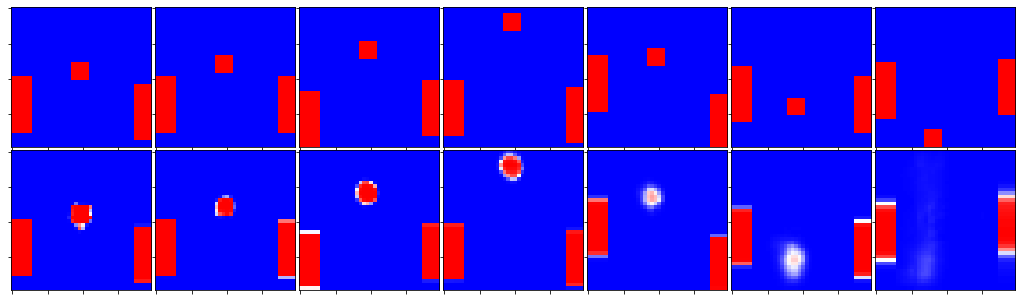

Epoch 258/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0429 - mean_squared_error: 0.0122 - acc: 0.9840 - val_loss: 0.0476 - val_mean_squared_error: 0.0127 - val_acc: 0.9836


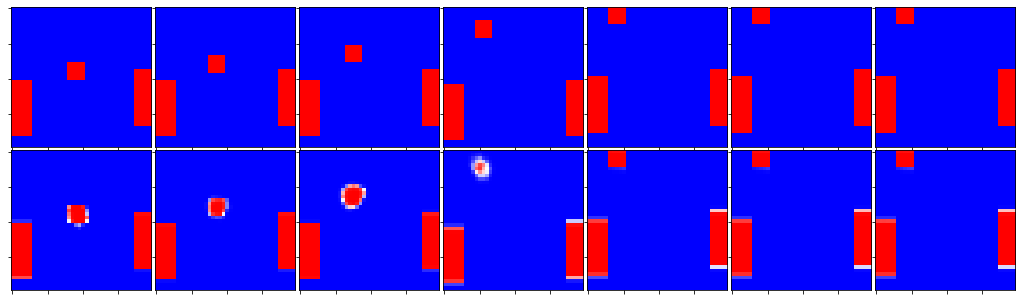

Epoch 259/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0453 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0471 - val_mean_squared_error: 0.0134 - val_acc: 0.9822


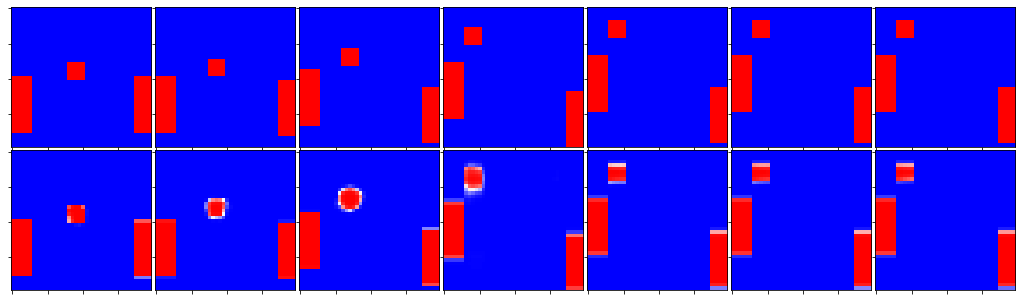

Epoch 260/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0429 - mean_squared_error: 0.0121 - acc: 0.9839 - val_loss: 0.0456 - val_mean_squared_error: 0.0128 - val_acc: 0.9833


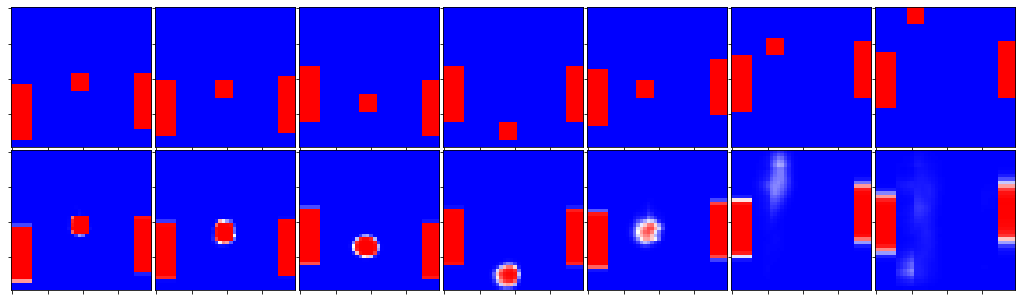

Epoch 261/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0438 - mean_squared_error: 0.0124 - acc: 0.9835 - val_loss: 0.0501 - val_mean_squared_error: 0.0143 - val_acc: 0.9809


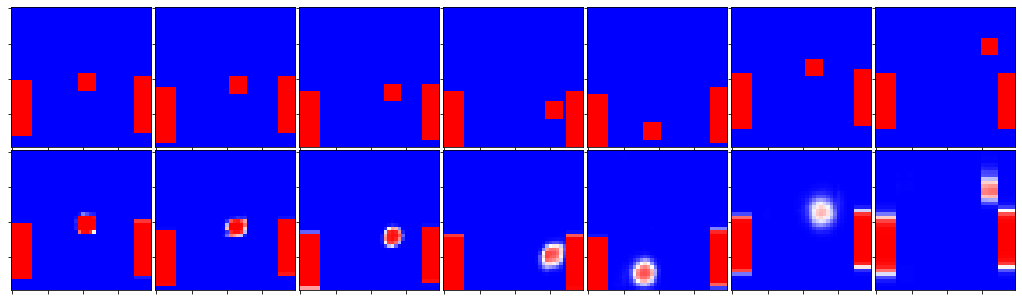

Epoch 262/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0411 - mean_squared_error: 0.0117 - acc: 0.9846 - val_loss: 0.0498 - val_mean_squared_error: 0.0137 - val_acc: 0.9820


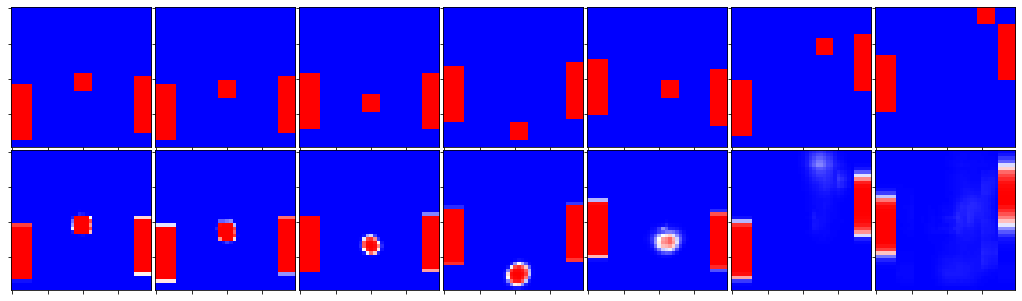

Epoch 263/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0456 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0450 - val_mean_squared_error: 0.0129 - val_acc: 0.9827


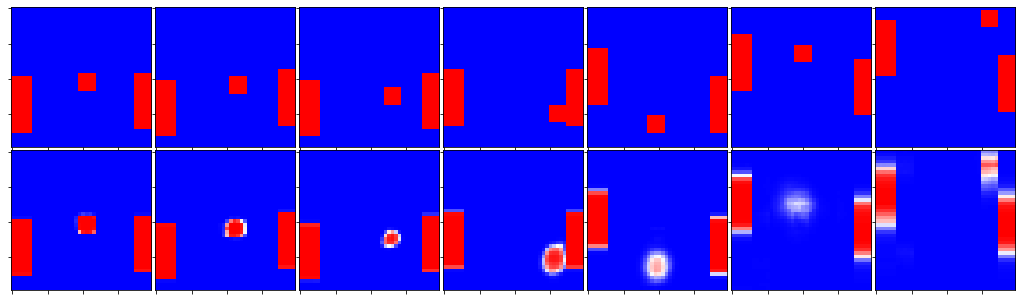

Epoch 264/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0442 - mean_squared_error: 0.0125 - acc: 0.9834 - val_loss: 0.0553 - val_mean_squared_error: 0.0147 - val_acc: 0.9812


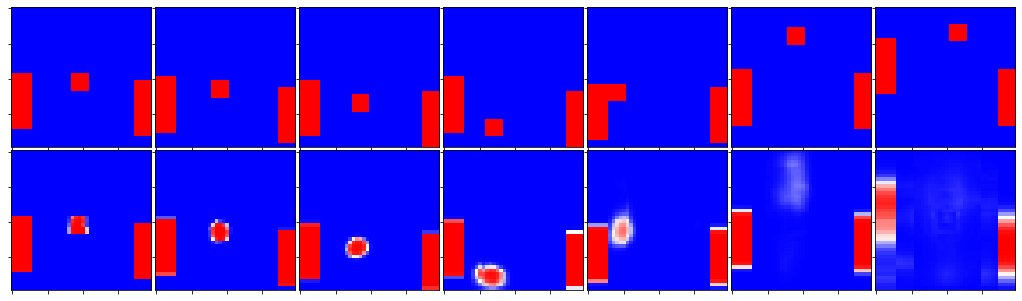

Epoch 265/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0421 - mean_squared_error: 0.0120 - acc: 0.9841 - val_loss: 0.0498 - val_mean_squared_error: 0.0139 - val_acc: 0.9818


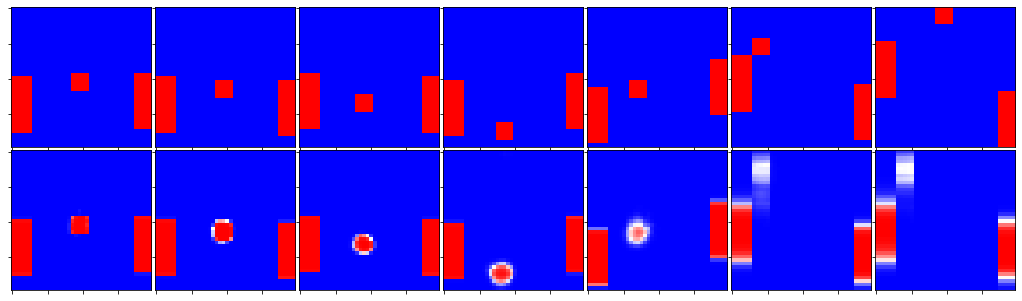

Epoch 266/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0429 - mean_squared_error: 0.0121 - acc: 0.9839 - val_loss: 0.0395 - val_mean_squared_error: 0.0115 - val_acc: 0.9845


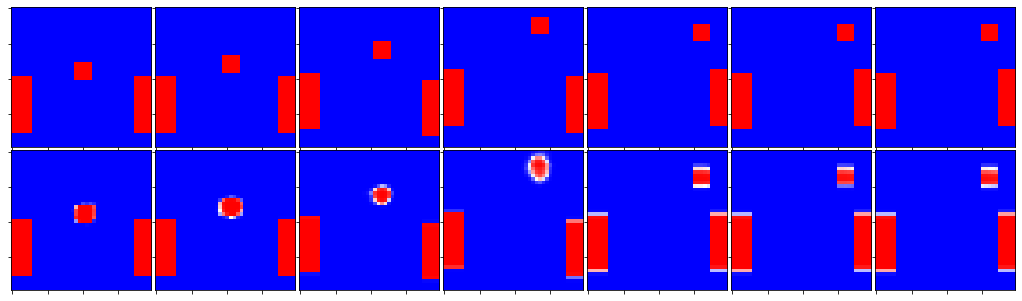

Epoch 267/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0416 - mean_squared_error: 0.0118 - acc: 0.9845 - val_loss: 0.0351 - val_mean_squared_error: 0.0103 - val_acc: 0.9860


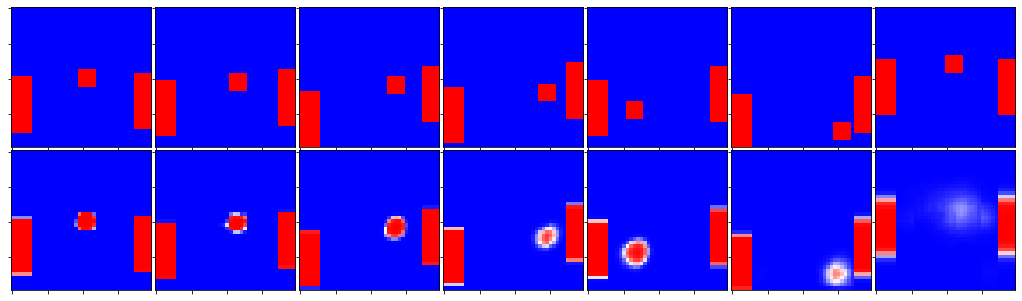

Epoch 268/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0422 - mean_squared_error: 0.0119 - acc: 0.9843 - val_loss: 0.0464 - val_mean_squared_error: 0.0130 - val_acc: 0.9829


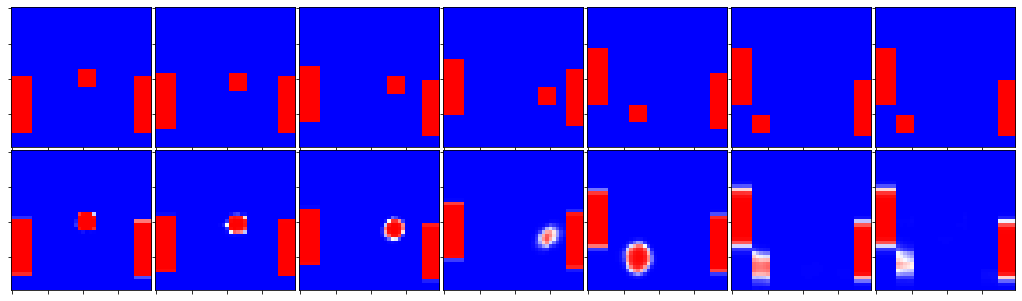

Epoch 269/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0418 - mean_squared_error: 0.0119 - acc: 0.9843 - val_loss: 0.0456 - val_mean_squared_error: 0.0129 - val_acc: 0.9828


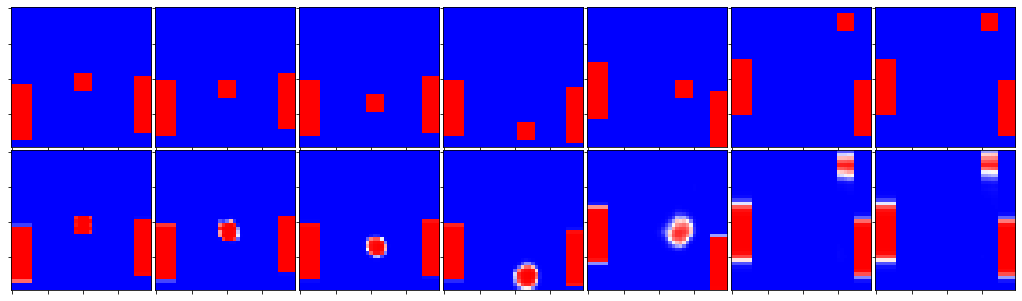

Epoch 270/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0418 - mean_squared_error: 0.0119 - acc: 0.9843 - val_loss: 0.0389 - val_mean_squared_error: 0.0112 - val_acc: 0.9851


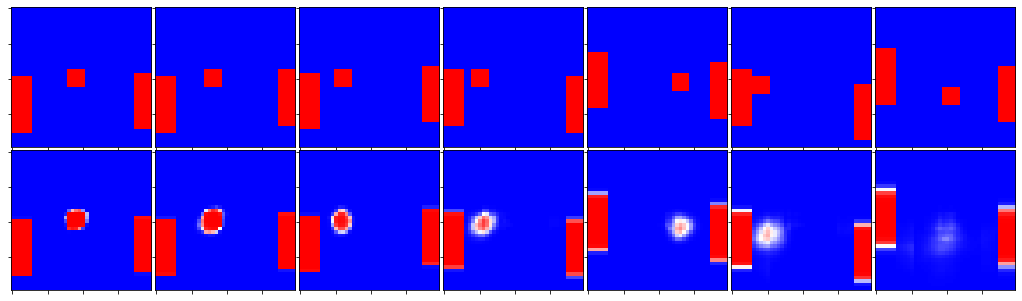

Epoch 271/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0436 - mean_squared_error: 0.0123 - acc: 0.9837 - val_loss: 0.0442 - val_mean_squared_error: 0.0124 - val_acc: 0.9837


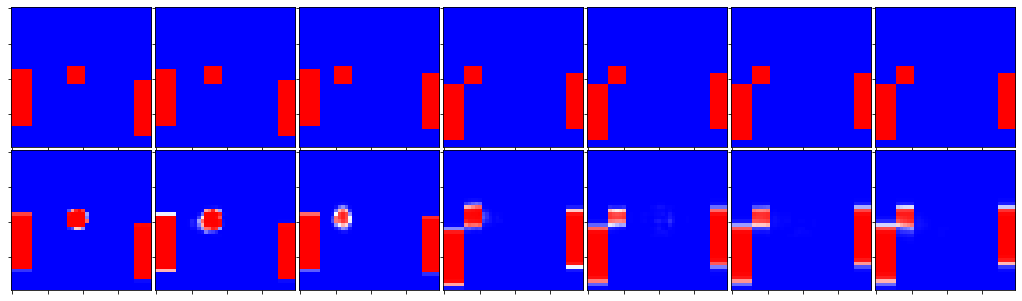

Epoch 272/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0433 - mean_squared_error: 0.0123 - acc: 0.9837 - val_loss: 0.0461 - val_mean_squared_error: 0.0129 - val_acc: 0.9829


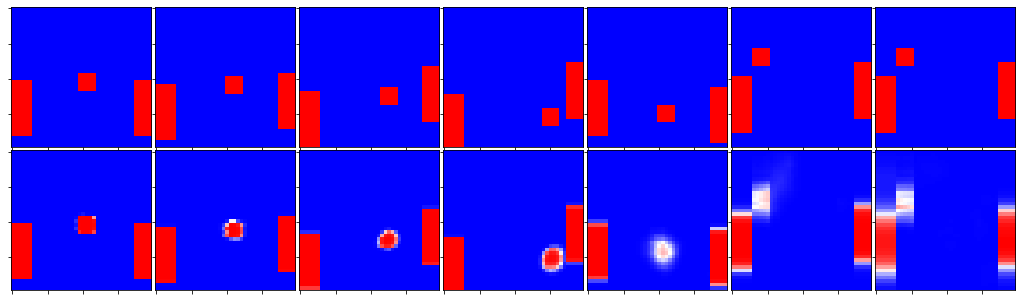

Epoch 273/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0431 - mean_squared_error: 0.0122 - acc: 0.9838 - val_loss: 0.0431 - val_mean_squared_error: 0.0121 - val_acc: 0.9839


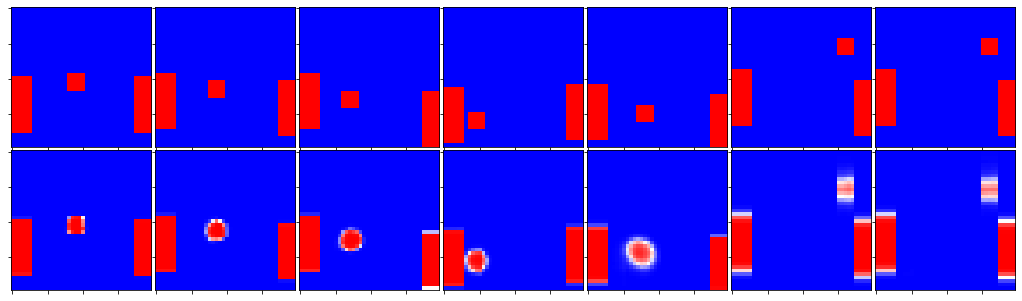

Epoch 274/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0417 - mean_squared_error: 0.0118 - acc: 0.9844 - val_loss: 0.0385 - val_mean_squared_error: 0.0112 - val_acc: 0.9853


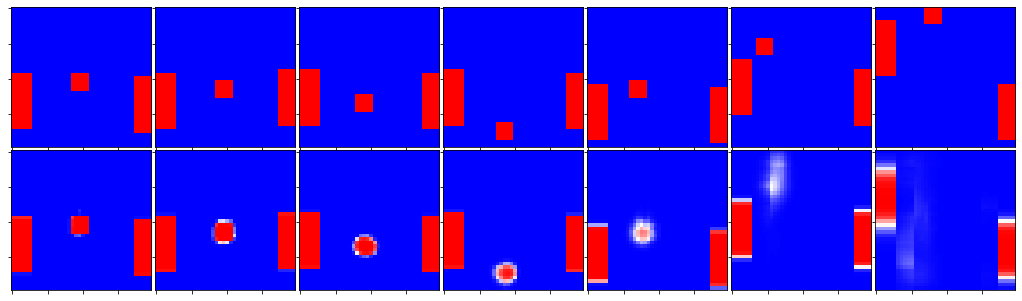

Epoch 275/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0434 - mean_squared_error: 0.0123 - acc: 0.9838 - val_loss: 0.0425 - val_mean_squared_error: 0.0121 - val_acc: 0.9840


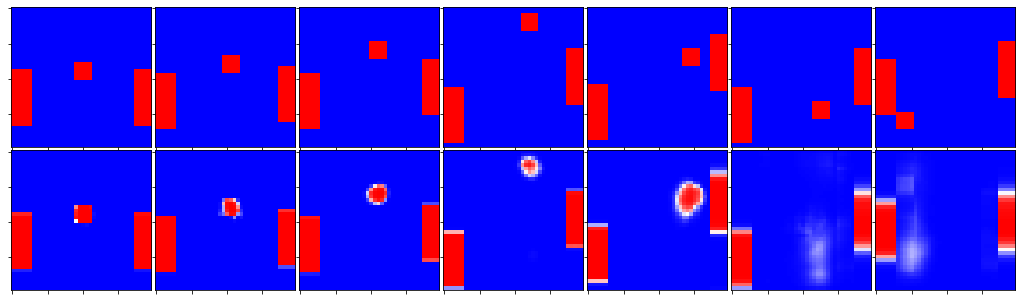

Epoch 276/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0431 - mean_squared_error: 0.0122 - acc: 0.9839 - val_loss: 0.0536 - val_mean_squared_error: 0.0149 - val_acc: 0.9803


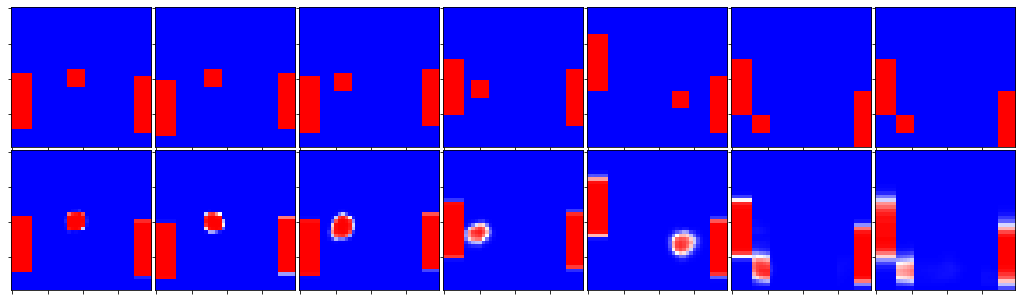

Epoch 277/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0428 - mean_squared_error: 0.0121 - acc: 0.9839 - val_loss: 0.0356 - val_mean_squared_error: 0.0103 - val_acc: 0.9863


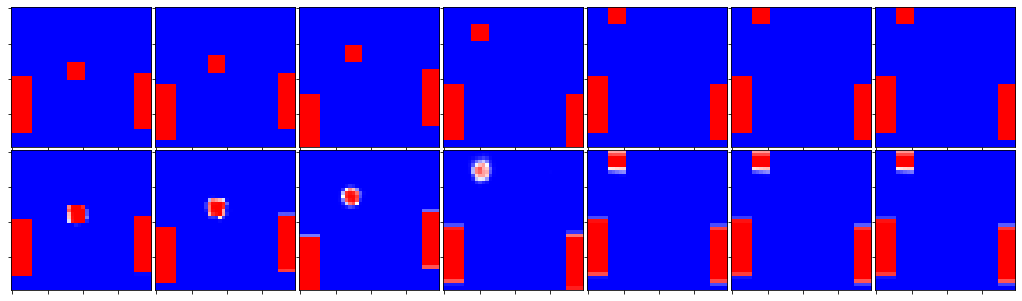

Epoch 278/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0417 - mean_squared_error: 0.0118 - acc: 0.9843 - val_loss: 0.0437 - val_mean_squared_error: 0.0125 - val_acc: 0.9833


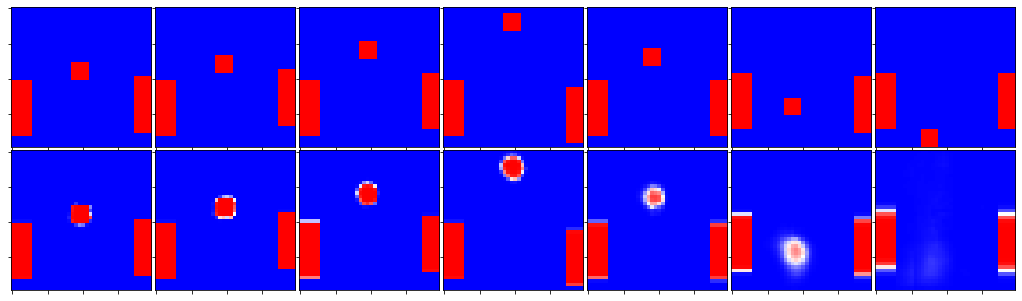

Epoch 279/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0466 - mean_squared_error: 0.0131 - acc: 0.9827 - val_loss: 0.0520 - val_mean_squared_error: 0.0146 - val_acc: 0.9808


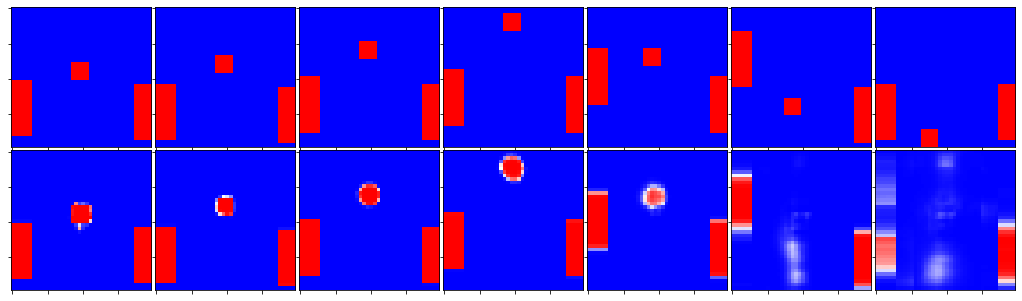

Epoch 280/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0489 - mean_squared_error: 0.0138 - acc: 0.9818 - val_loss: 0.0486 - val_mean_squared_error: 0.0138 - val_acc: 0.9820


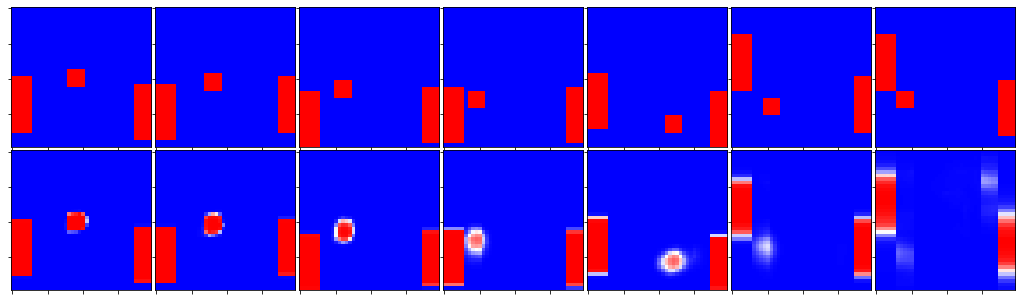

Epoch 281/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0422 - mean_squared_error: 0.0119 - acc: 0.9842 - val_loss: 0.0438 - val_mean_squared_error: 0.0126 - val_acc: 0.9834


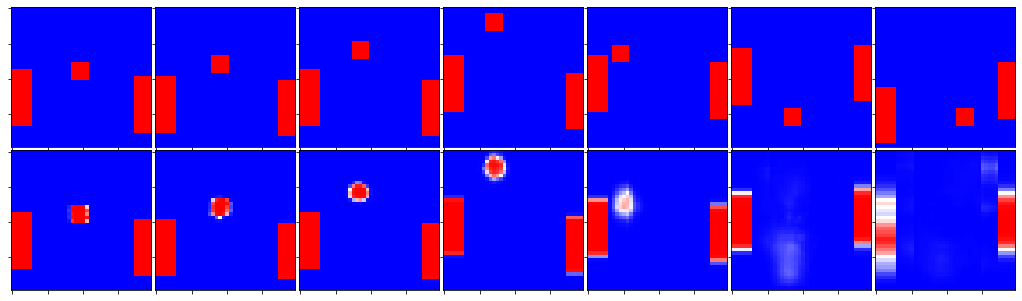

Epoch 282/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0422 - mean_squared_error: 0.0119 - acc: 0.9842 - val_loss: 0.0412 - val_mean_squared_error: 0.0117 - val_acc: 0.9846


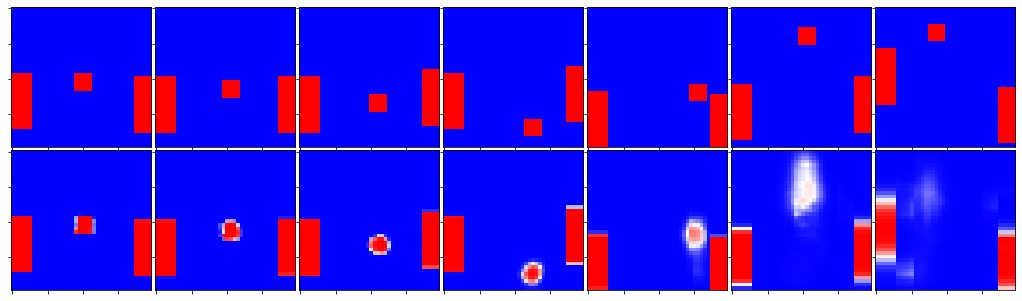

Epoch 283/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0403 - mean_squared_error: 0.0114 - acc: 0.9849 - val_loss: 0.0393 - val_mean_squared_error: 0.0111 - val_acc: 0.9856


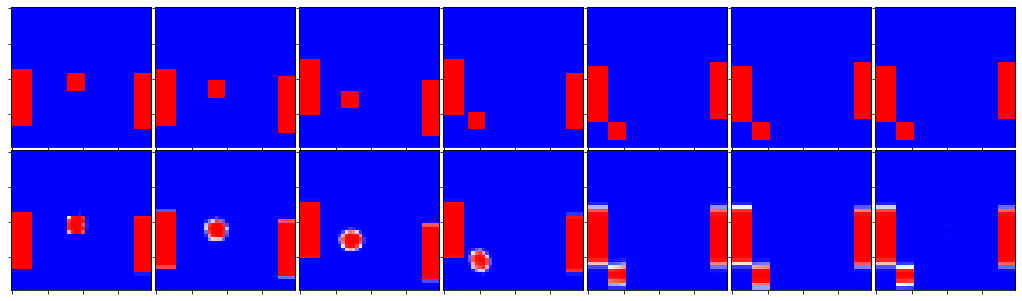

Epoch 284/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0418 - mean_squared_error: 0.0118 - acc: 0.9845 - val_loss: 0.0456 - val_mean_squared_error: 0.0122 - val_acc: 0.9838


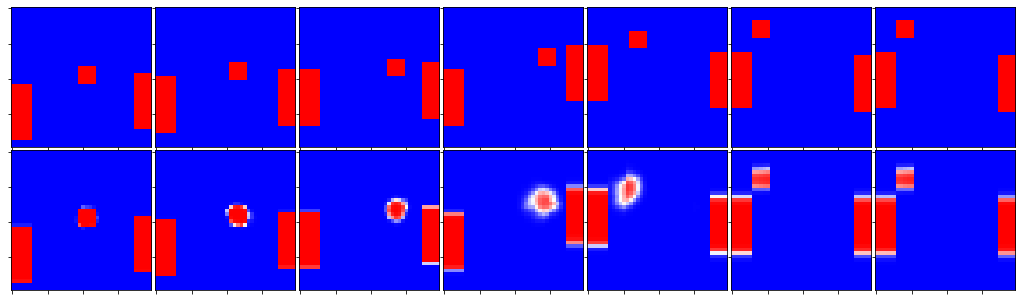

Epoch 285/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0442 - mean_squared_error: 0.0125 - acc: 0.9835 - val_loss: 0.0463 - val_mean_squared_error: 0.0131 - val_acc: 0.9829


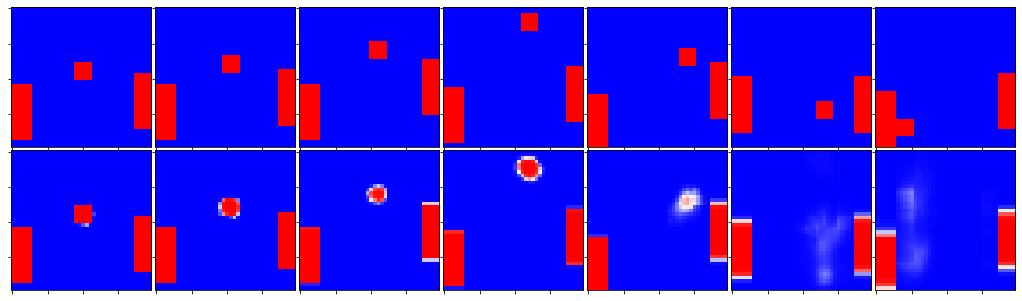

Epoch 286/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0414 - mean_squared_error: 0.0118 - acc: 0.9843 - val_loss: 0.0358 - val_mean_squared_error: 0.0102 - val_acc: 0.9863


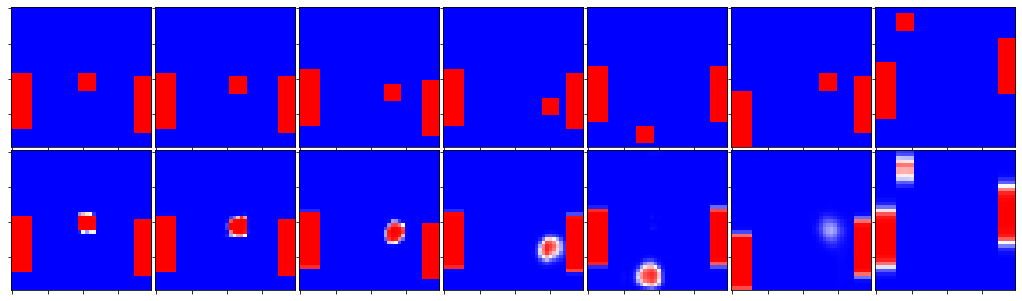

Epoch 287/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0413 - mean_squared_error: 0.0118 - acc: 0.9843 - val_loss: 0.0447 - val_mean_squared_error: 0.0126 - val_acc: 0.9835


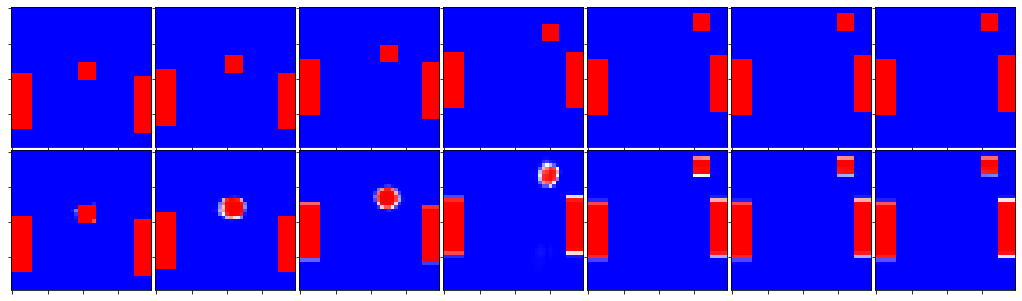

Epoch 288/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0567 - mean_squared_error: 0.0150 - acc: 0.9804 - val_loss: 0.0717 - val_mean_squared_error: 0.0185 - val_acc: 0.9759


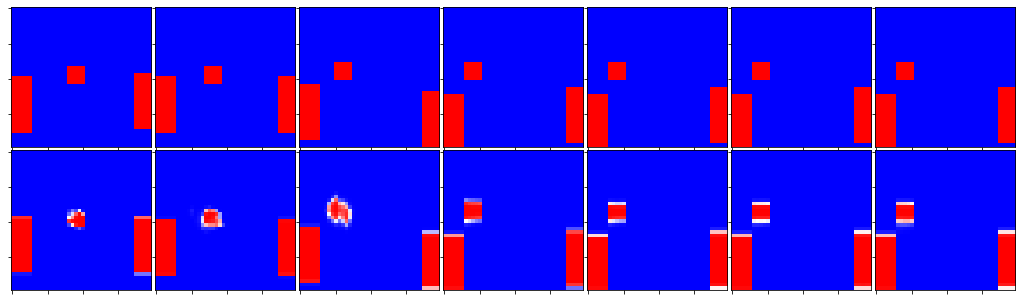

Epoch 289/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0560 - mean_squared_error: 0.0153 - acc: 0.9799 - val_loss: 0.0497 - val_mean_squared_error: 0.0139 - val_acc: 0.9818


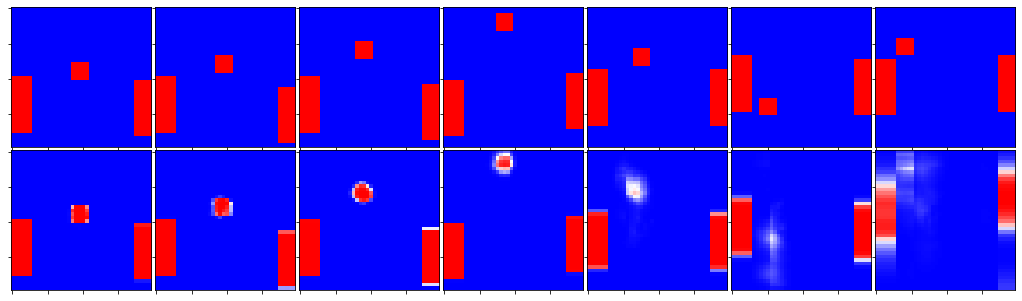

Epoch 290/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0463 - mean_squared_error: 0.0130 - acc: 0.9828 - val_loss: 0.0474 - val_mean_squared_error: 0.0133 - val_acc: 0.9824


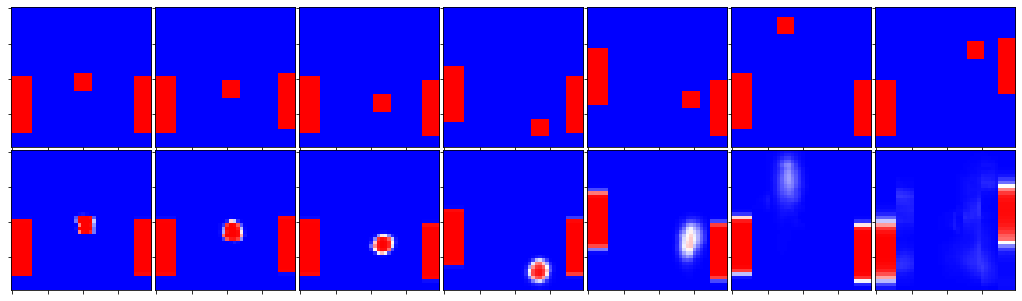

Epoch 291/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0429 - mean_squared_error: 0.0122 - acc: 0.9838 - val_loss: 0.0432 - val_mean_squared_error: 0.0115 - val_acc: 0.9850


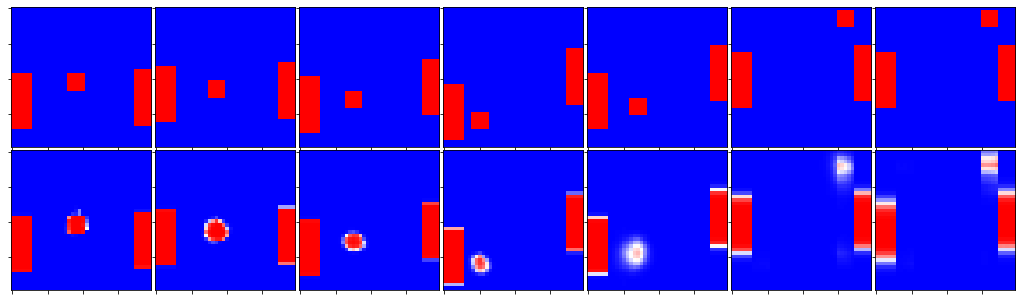

Epoch 292/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0433 - mean_squared_error: 0.0122 - acc: 0.9838 - val_loss: 0.0423 - val_mean_squared_error: 0.0121 - val_acc: 0.9843


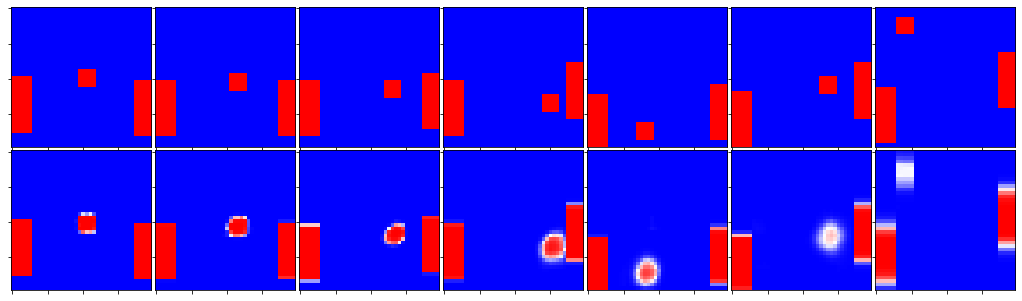

Epoch 293/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0425 - mean_squared_error: 0.0121 - acc: 0.9840 - val_loss: 0.0438 - val_mean_squared_error: 0.0115 - val_acc: 0.9849


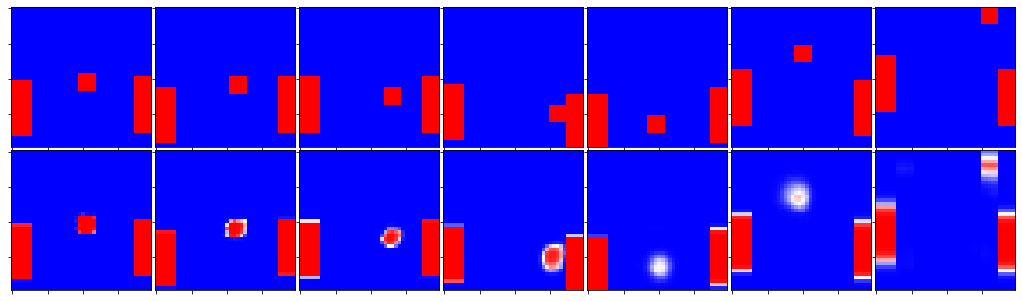

Epoch 294/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0416 - mean_squared_error: 0.0118 - acc: 0.9844 - val_loss: 0.0451 - val_mean_squared_error: 0.0127 - val_acc: 0.9832


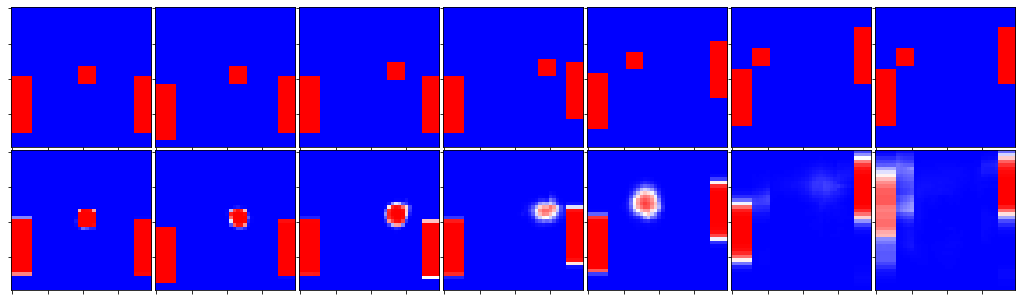

Epoch 295/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0413 - mean_squared_error: 0.0118 - acc: 0.9844 - val_loss: 0.0410 - val_mean_squared_error: 0.0116 - val_acc: 0.9845


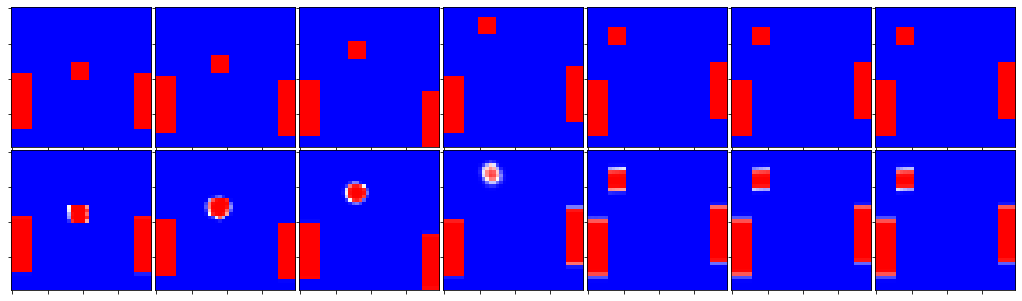

Epoch 296/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0421 - mean_squared_error: 0.0119 - acc: 0.9842 - val_loss: 0.0377 - val_mean_squared_error: 0.0109 - val_acc: 0.9857


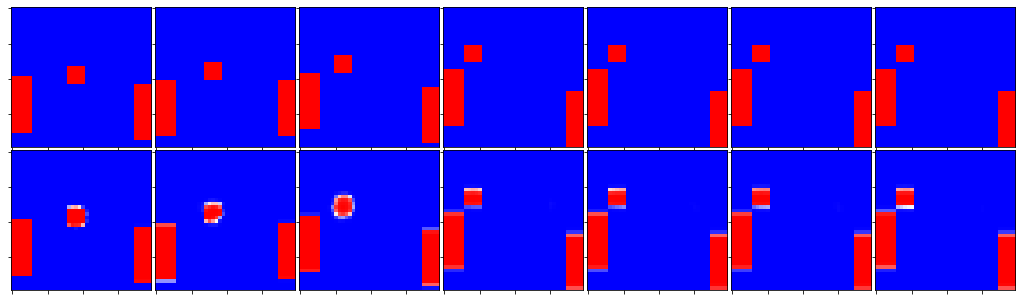

Epoch 297/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0409 - mean_squared_error: 0.0116 - acc: 0.9847 - val_loss: 0.0396 - val_mean_squared_error: 0.0114 - val_acc: 0.9851


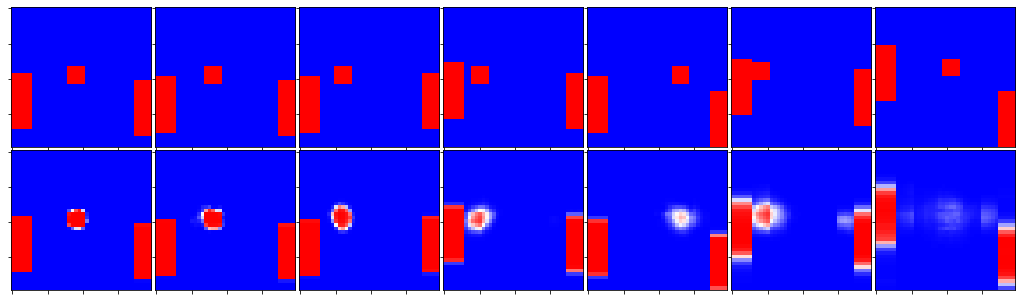

Epoch 298/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0407 - mean_squared_error: 0.0116 - acc: 0.9846 - val_loss: 0.0405 - val_mean_squared_error: 0.0117 - val_acc: 0.9842


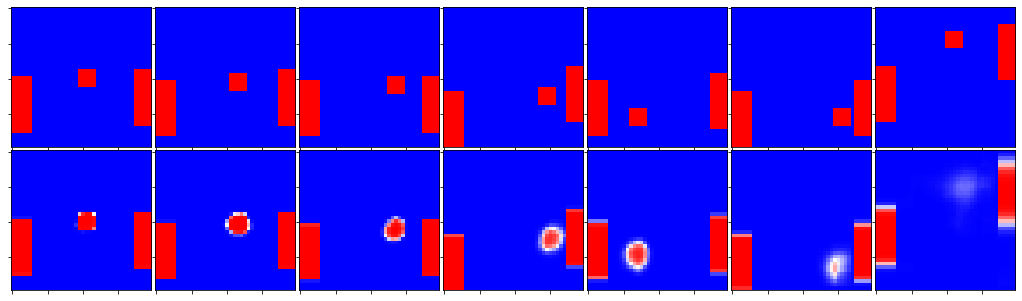

Epoch 299/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0421 - mean_squared_error: 0.0118 - acc: 0.9845 - val_loss: 0.0426 - val_mean_squared_error: 0.0123 - val_acc: 0.9834


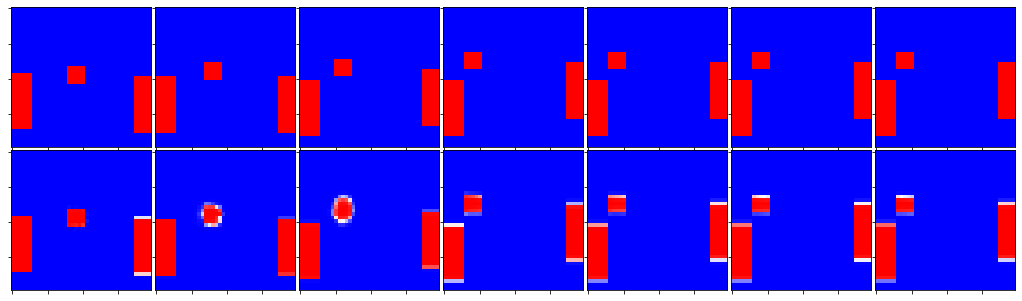

Epoch 300/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0407 - mean_squared_error: 0.0115 - acc: 0.9847 - val_loss: 0.0463 - val_mean_squared_error: 0.0132 - val_acc: 0.9825


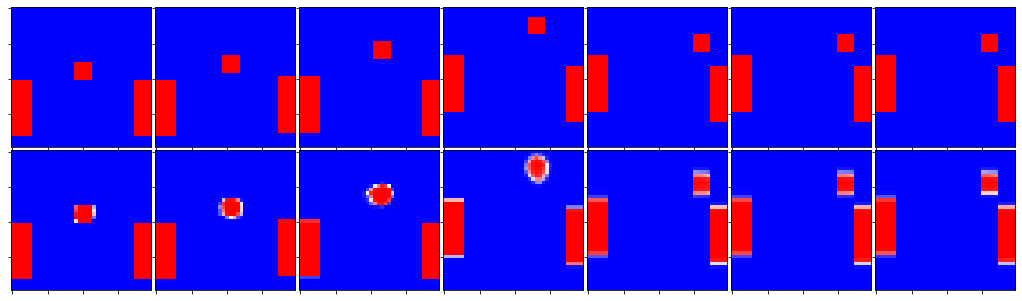

Epoch 301/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0421 - mean_squared_error: 0.0120 - acc: 0.9841 - val_loss: 0.0402 - val_mean_squared_error: 0.0114 - val_acc: 0.9850


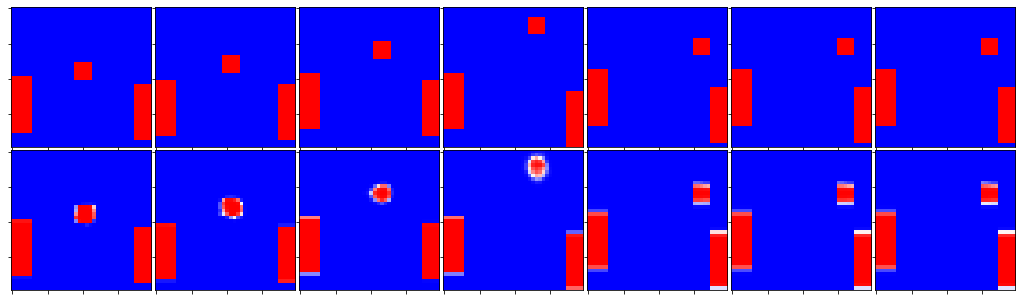

Epoch 302/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0418 - mean_squared_error: 0.0118 - acc: 0.9843 - val_loss: 0.0480 - val_mean_squared_error: 0.0136 - val_acc: 0.9817


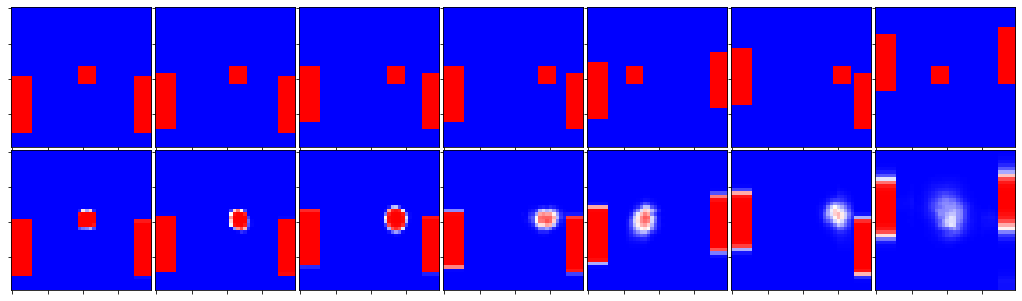

Epoch 303/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0409 - mean_squared_error: 0.0117 - acc: 0.9845 - val_loss: 0.0408 - val_mean_squared_error: 0.0120 - val_acc: 0.9839


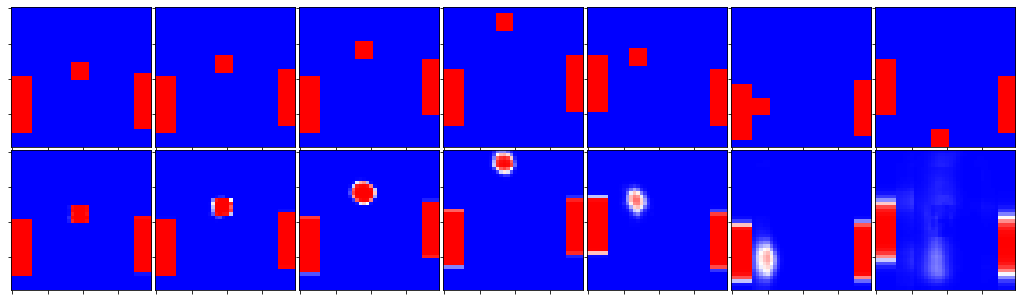

Epoch 304/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0420 - mean_squared_error: 0.0119 - acc: 0.9842 - val_loss: 0.0418 - val_mean_squared_error: 0.0119 - val_acc: 0.9842


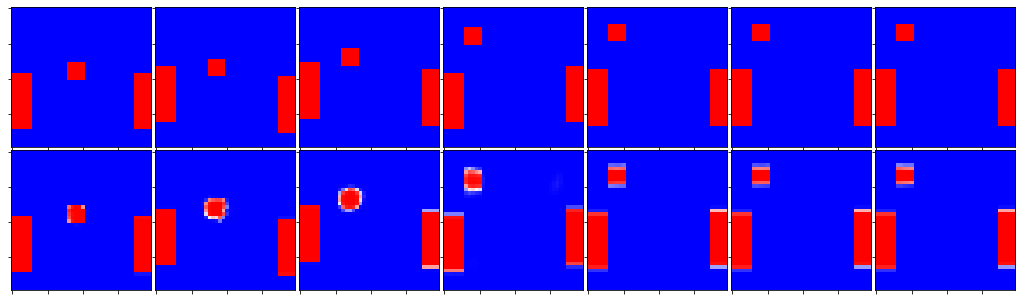

Epoch 305/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0414 - mean_squared_error: 0.0117 - acc: 0.9845 - val_loss: 0.0372 - val_mean_squared_error: 0.0110 - val_acc: 0.9852


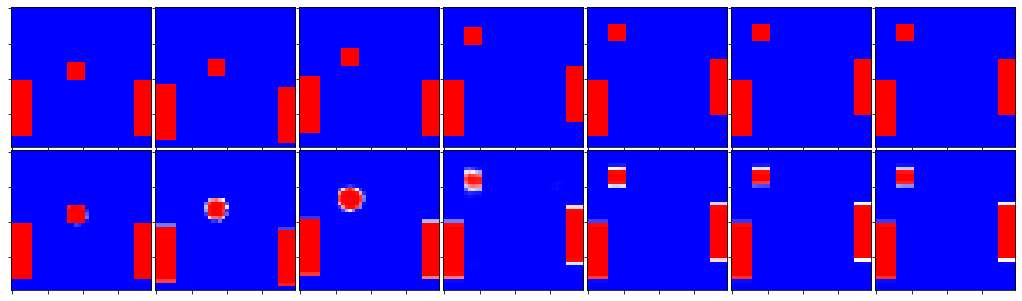

Epoch 306/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0392 - mean_squared_error: 0.0111 - acc: 0.9852 - val_loss: 0.0458 - val_mean_squared_error: 0.0127 - val_acc: 0.9837


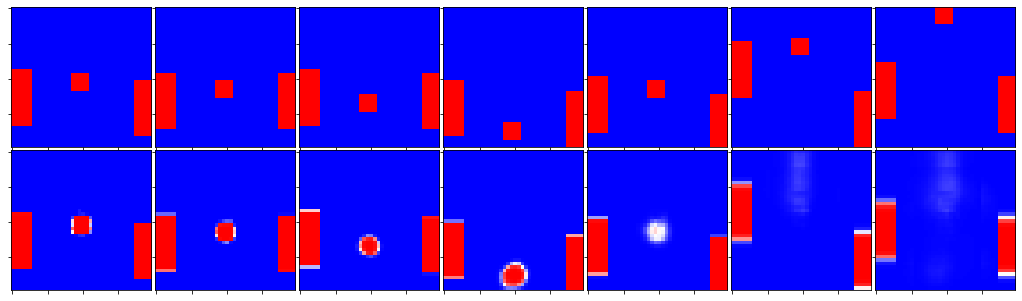

Epoch 307/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0399 - mean_squared_error: 0.0114 - acc: 0.9848 - val_loss: 0.0388 - val_mean_squared_error: 0.0113 - val_acc: 0.9850


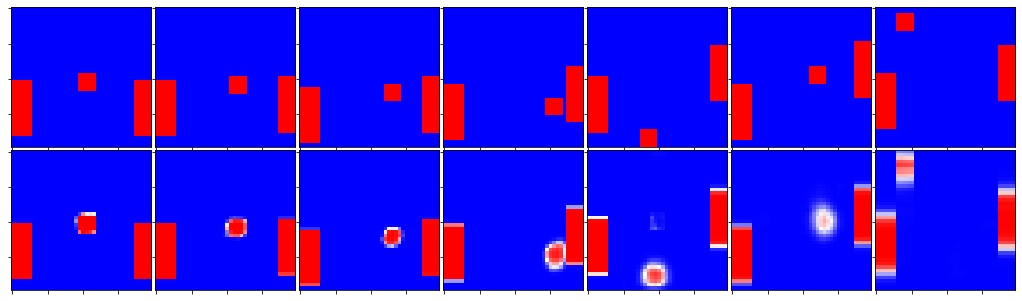

Epoch 308/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0412 - mean_squared_error: 0.0117 - acc: 0.9845 - val_loss: 0.0429 - val_mean_squared_error: 0.0117 - val_acc: 0.9846


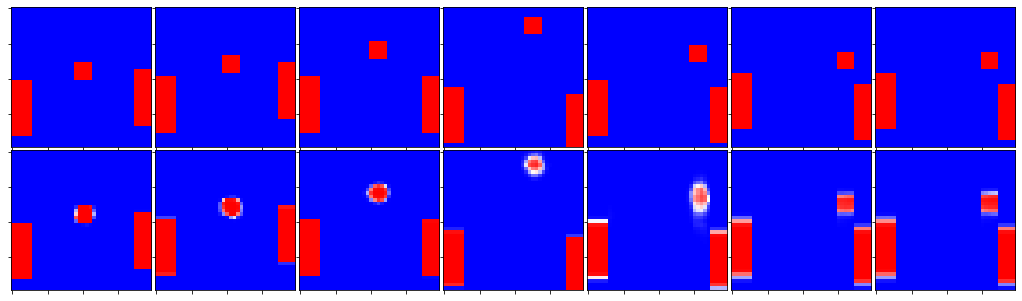

Epoch 309/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0408 - mean_squared_error: 0.0116 - acc: 0.9847 - val_loss: 0.0395 - val_mean_squared_error: 0.0113 - val_acc: 0.9852


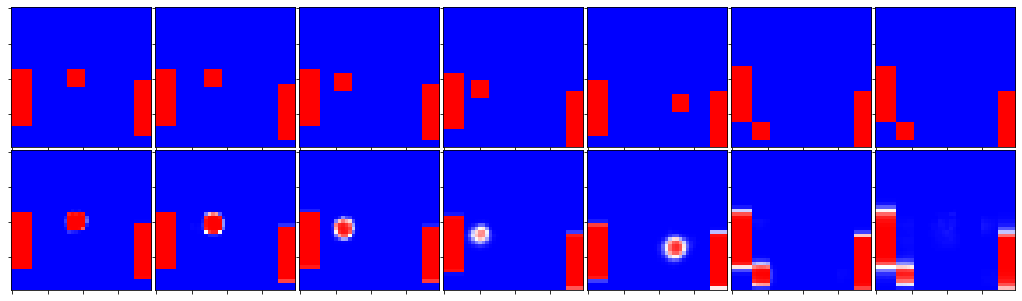

Epoch 310/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0406 - mean_squared_error: 0.0116 - acc: 0.9847 - val_loss: 0.0516 - val_mean_squared_error: 0.0136 - val_acc: 0.9824


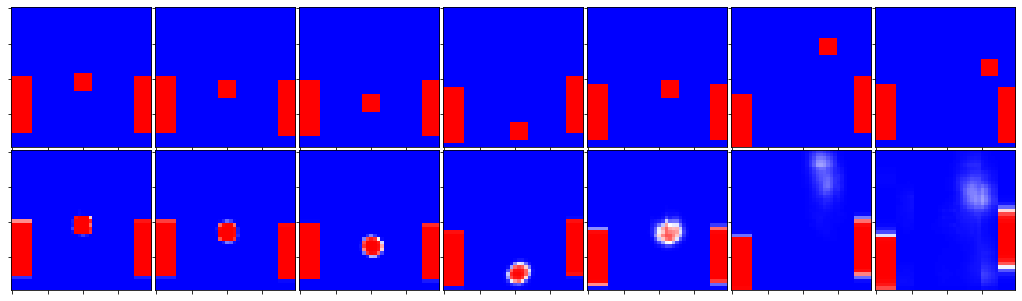

Epoch 311/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0414 - mean_squared_error: 0.0117 - acc: 0.9844 - val_loss: 0.0445 - val_mean_squared_error: 0.0124 - val_acc: 0.9842


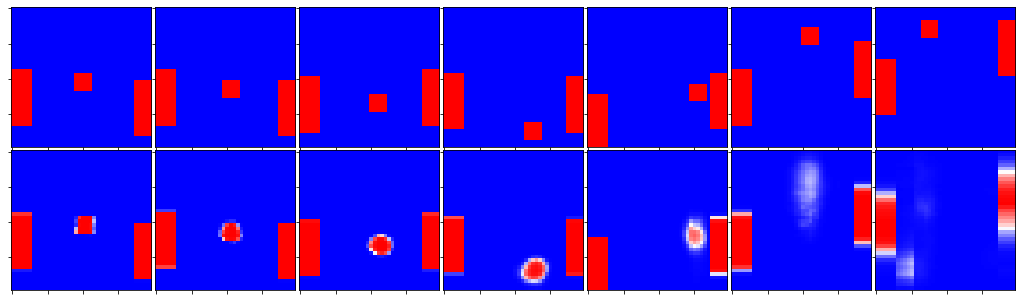

Epoch 312/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0392 - mean_squared_error: 0.0112 - acc: 0.9852 - val_loss: 0.0402 - val_mean_squared_error: 0.0117 - val_acc: 0.9845


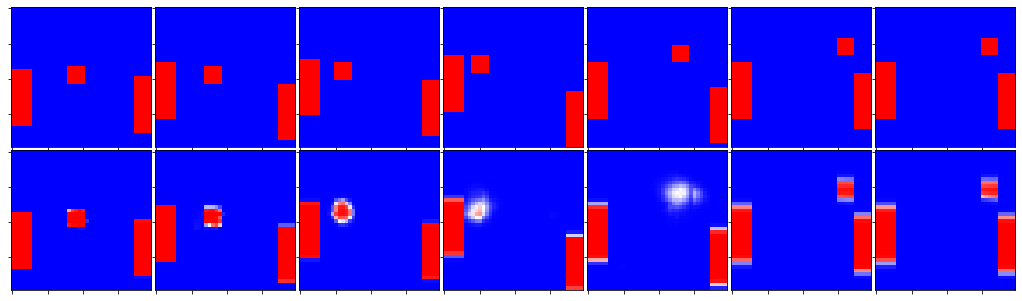

Epoch 313/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0409 - mean_squared_error: 0.0116 - acc: 0.9846 - val_loss: 0.0412 - val_mean_squared_error: 0.0117 - val_acc: 0.9845


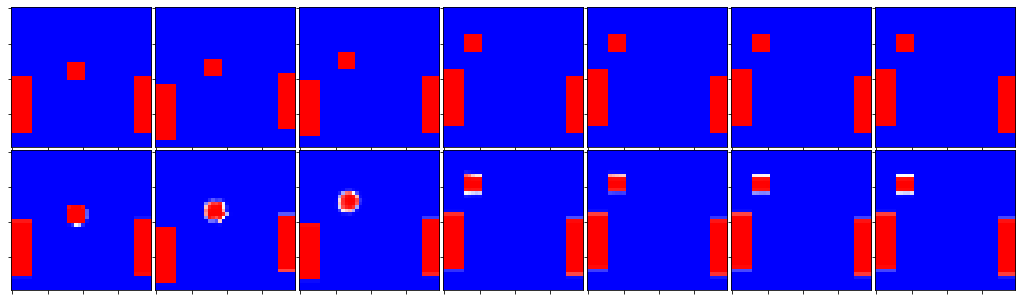

Epoch 314/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0397 - mean_squared_error: 0.0113 - acc: 0.9851 - val_loss: 0.0457 - val_mean_squared_error: 0.0126 - val_acc: 0.9838


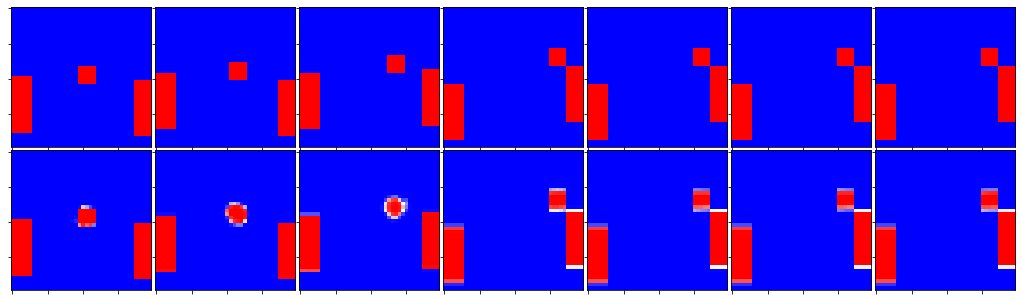

Epoch 315/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0398 - mean_squared_error: 0.0113 - acc: 0.9850 - val_loss: 0.0461 - val_mean_squared_error: 0.0128 - val_acc: 0.9830


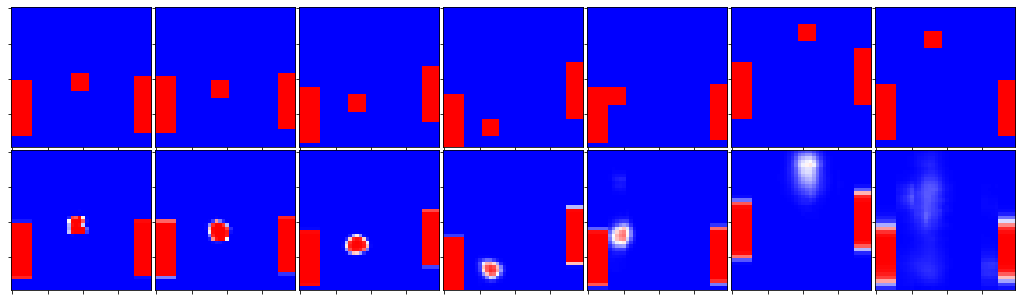

Epoch 316/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0405 - mean_squared_error: 0.0115 - acc: 0.9847 - val_loss: 0.0366 - val_mean_squared_error: 0.0106 - val_acc: 0.9860


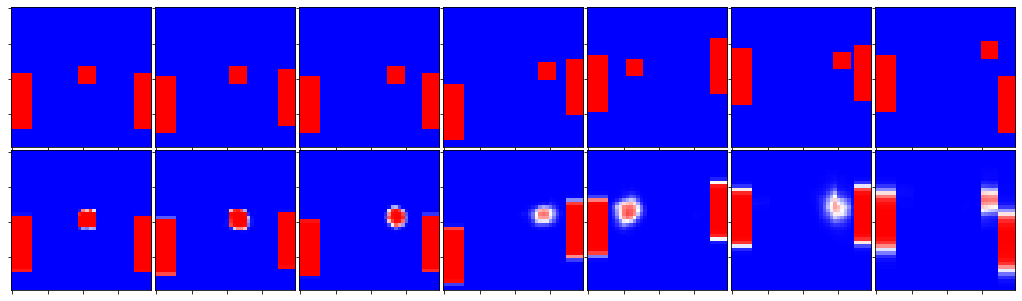

Epoch 317/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0394 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0435 - val_mean_squared_error: 0.0122 - val_acc: 0.9841


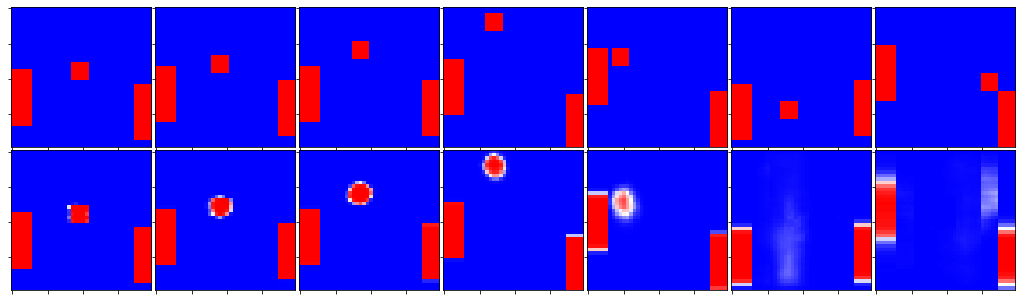

Epoch 318/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0402 - mean_squared_error: 0.0115 - acc: 0.9846 - val_loss: 0.0405 - val_mean_squared_error: 0.0118 - val_acc: 0.9840


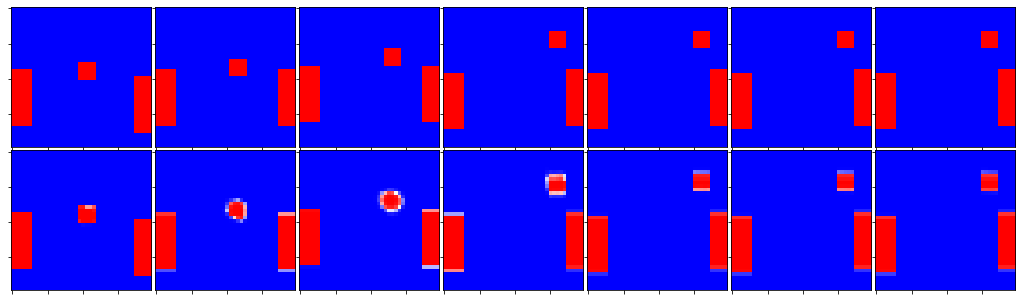

Epoch 319/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0385 - mean_squared_error: 0.0109 - acc: 0.9855 - val_loss: 0.0360 - val_mean_squared_error: 0.0104 - val_acc: 0.9862


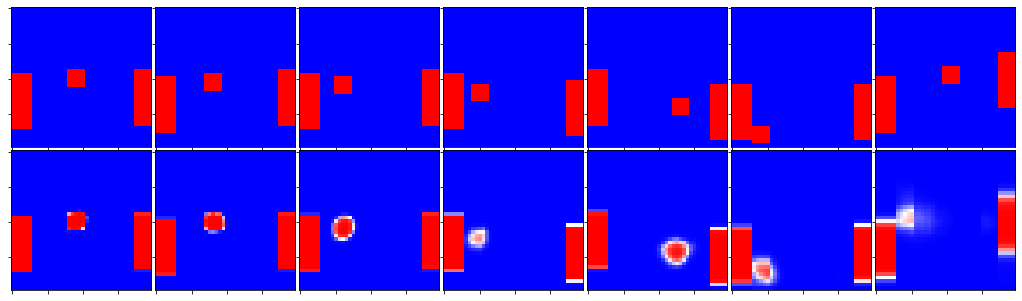

Epoch 320/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0400 - mean_squared_error: 0.0113 - acc: 0.9850 - val_loss: 0.0434 - val_mean_squared_error: 0.0120 - val_acc: 0.9838


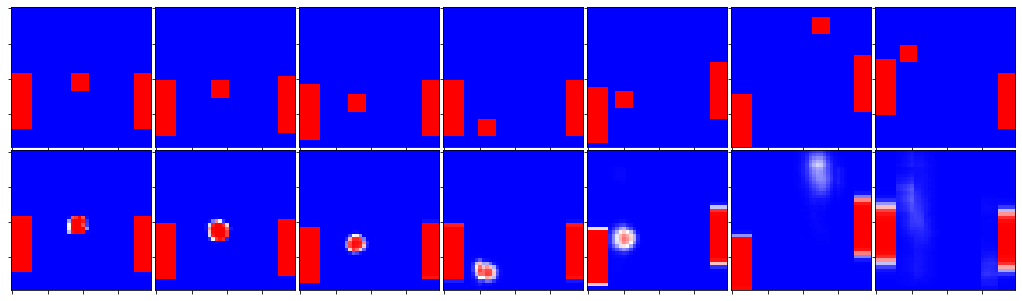

Epoch 321/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0397 - mean_squared_error: 0.0113 - acc: 0.9851 - val_loss: 0.0365 - val_mean_squared_error: 0.0104 - val_acc: 0.9864


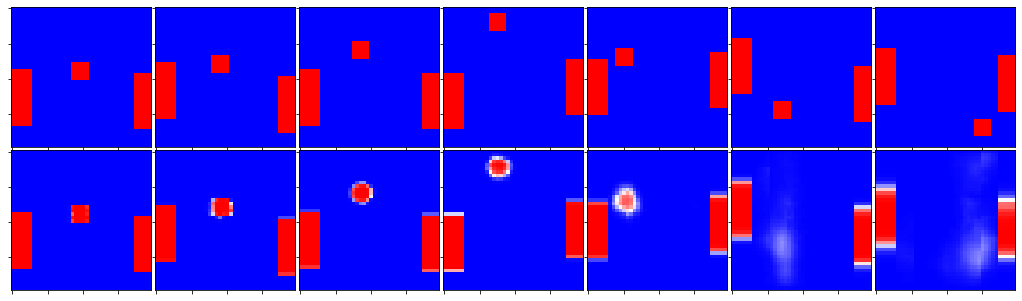

Epoch 322/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0399 - mean_squared_error: 0.0113 - acc: 0.9849 - val_loss: 0.0341 - val_mean_squared_error: 0.0101 - val_acc: 0.9861


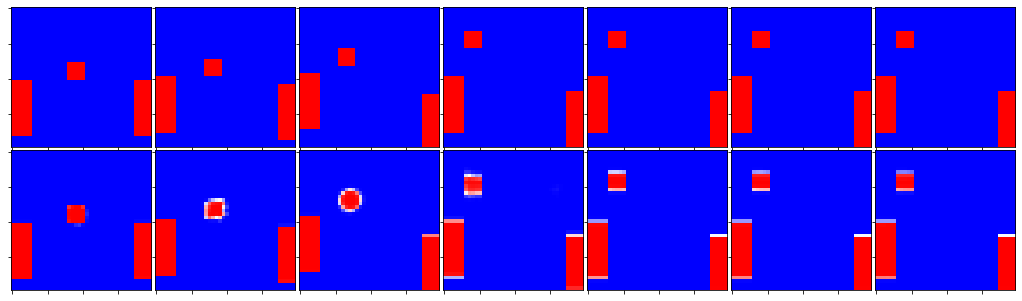

Epoch 323/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0394 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0401 - val_mean_squared_error: 0.0114 - val_acc: 0.9847


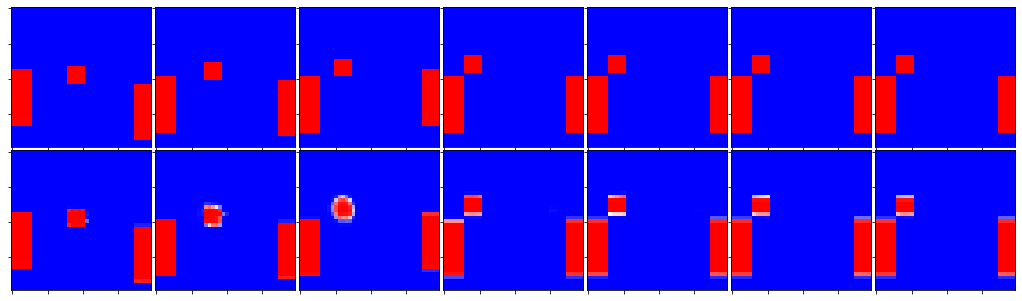

Epoch 324/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0457 - mean_squared_error: 0.0128 - acc: 0.9831 - val_loss: 0.0487 - val_mean_squared_error: 0.0131 - val_acc: 0.9834


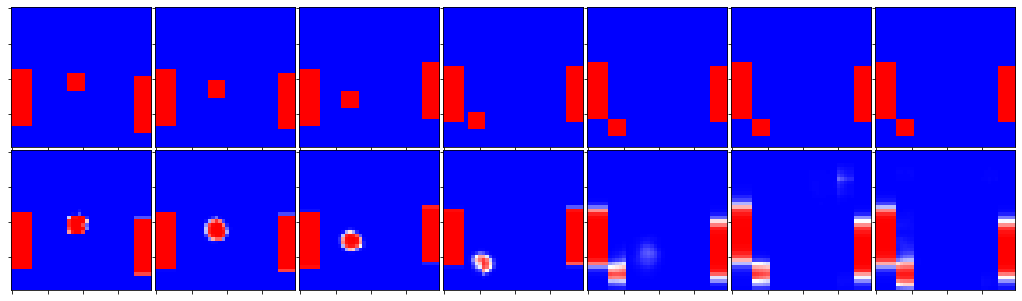

Epoch 325/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0398 - mean_squared_error: 0.0113 - acc: 0.9850 - val_loss: 0.0399 - val_mean_squared_error: 0.0113 - val_acc: 0.9852


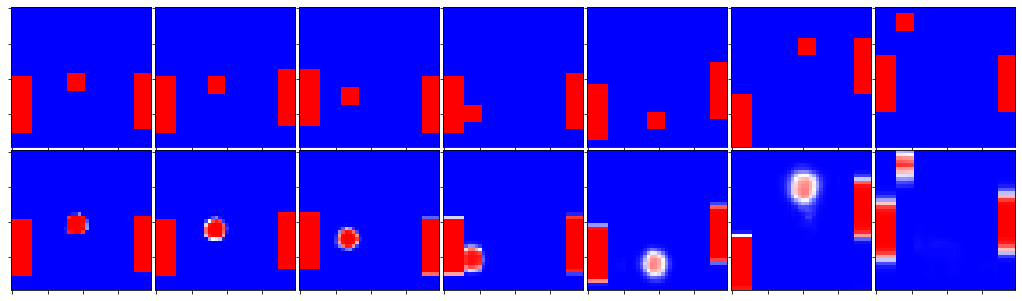

Epoch 326/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0417 - mean_squared_error: 0.0118 - acc: 0.9844 - val_loss: 0.0423 - val_mean_squared_error: 0.0118 - val_acc: 0.9841


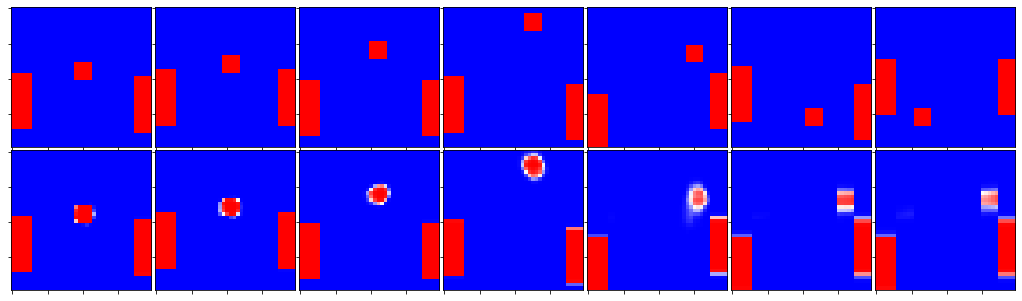

Epoch 327/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0386 - mean_squared_error: 0.0110 - acc: 0.9855 - val_loss: 0.0404 - val_mean_squared_error: 0.0117 - val_acc: 0.9847


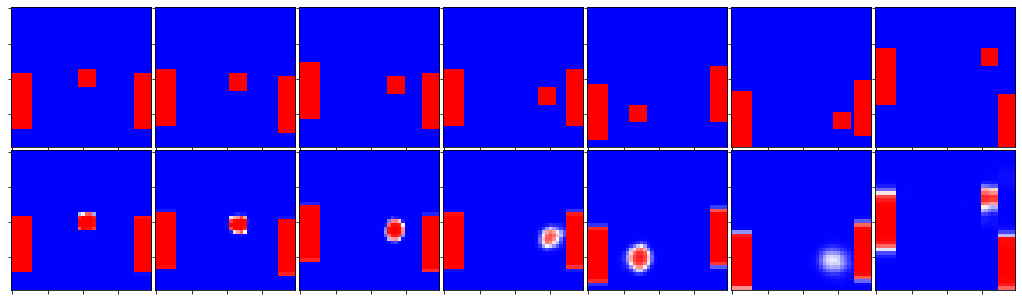

Epoch 328/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0394 - mean_squared_error: 0.0112 - acc: 0.9852 - val_loss: 0.0442 - val_mean_squared_error: 0.0123 - val_acc: 0.9834


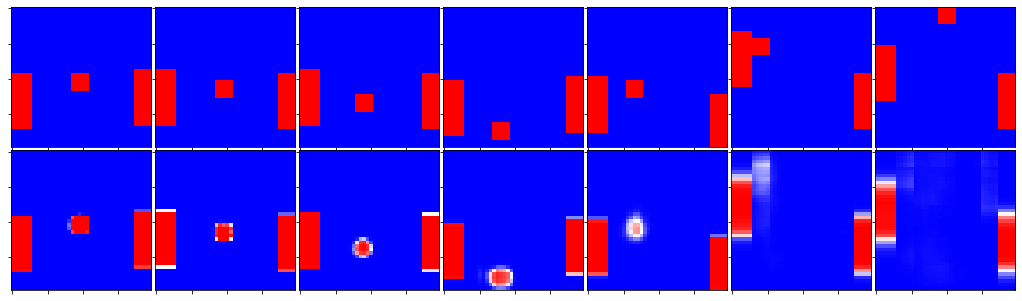

Epoch 329/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0411 - mean_squared_error: 0.0117 - acc: 0.9845 - val_loss: 0.0398 - val_mean_squared_error: 0.0114 - val_acc: 0.9850


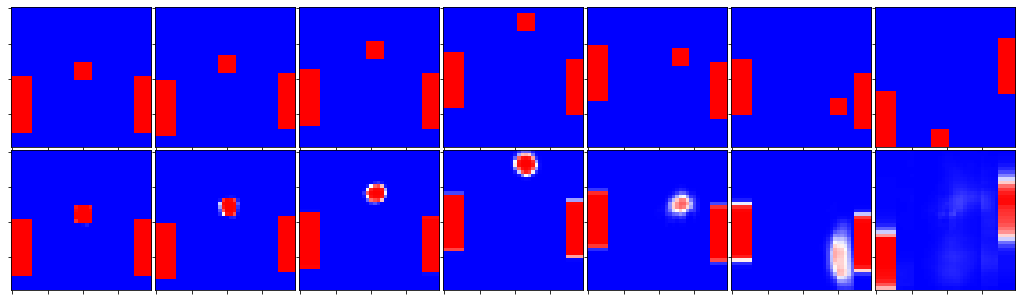

Epoch 330/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0408 - mean_squared_error: 0.0116 - acc: 0.9846 - val_loss: 0.0386 - val_mean_squared_error: 0.0110 - val_acc: 0.9856


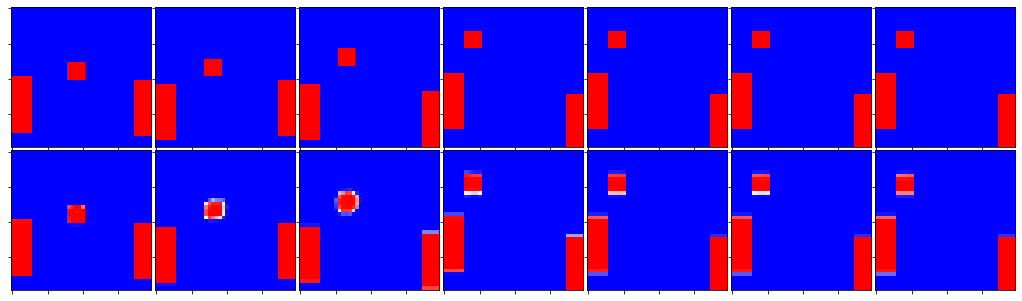

Epoch 331/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0380 - mean_squared_error: 0.0108 - acc: 0.9857 - val_loss: 0.0412 - val_mean_squared_error: 0.0120 - val_acc: 0.9839


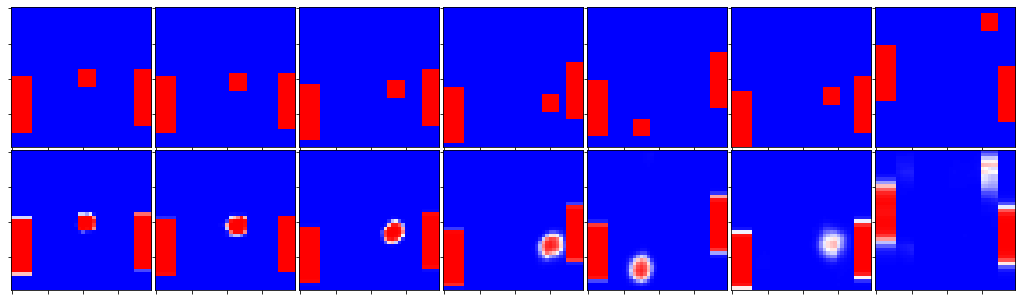

Epoch 332/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0433 - mean_squared_error: 0.0123 - acc: 0.9837 - val_loss: 0.0358 - val_mean_squared_error: 0.0104 - val_acc: 0.9860


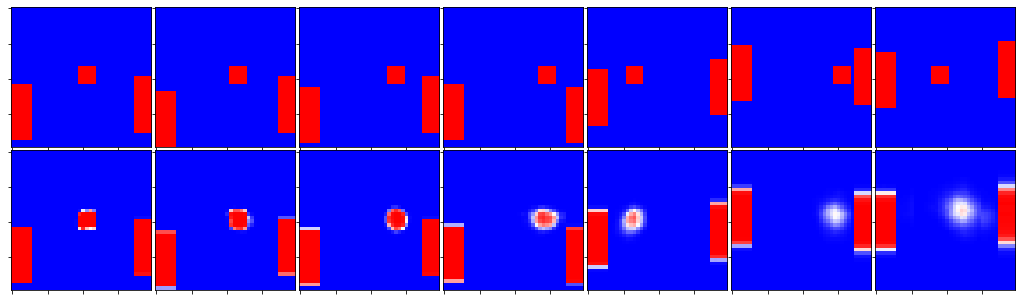

Epoch 333/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0386 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0396 - val_mean_squared_error: 0.0111 - val_acc: 0.9850


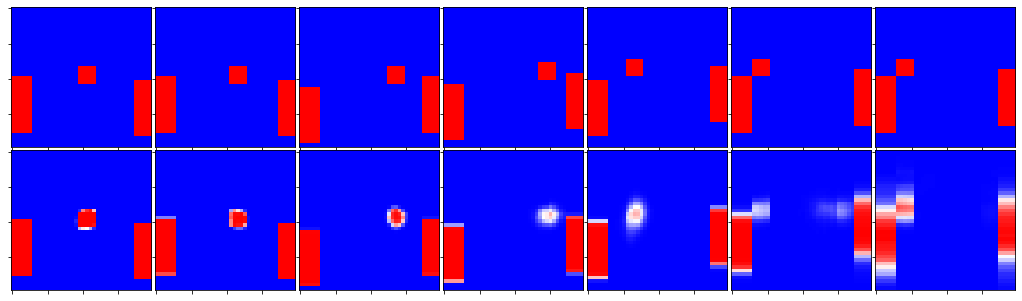

Epoch 334/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0400 - mean_squared_error: 0.0113 - acc: 0.9850 - val_loss: 0.0395 - val_mean_squared_error: 0.0113 - val_acc: 0.9851


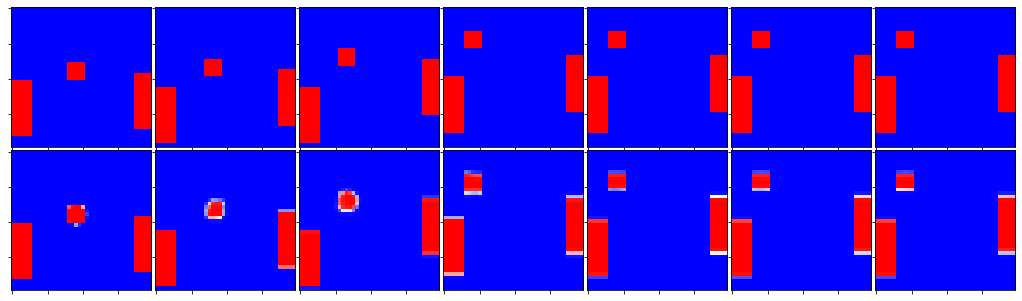

Epoch 335/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0390 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0381 - val_mean_squared_error: 0.0110 - val_acc: 0.9855


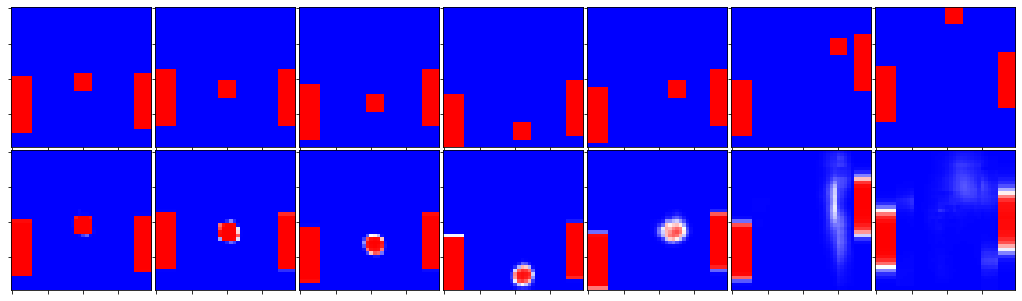

Epoch 336/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0392 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0398 - val_mean_squared_error: 0.0115 - val_acc: 0.9845


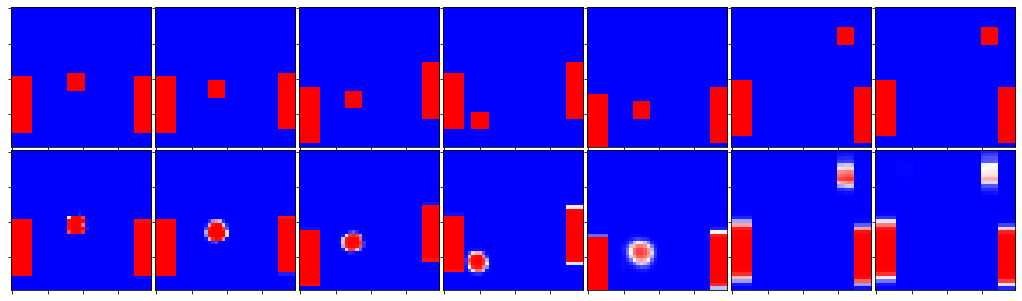

Epoch 337/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0432 - mean_squared_error: 0.0121 - acc: 0.9840 - val_loss: 0.0433 - val_mean_squared_error: 0.0122 - val_acc: 0.9839


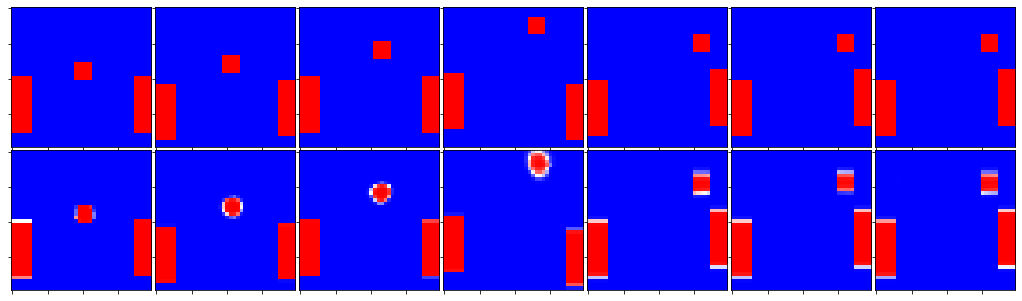

Epoch 338/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0419 - mean_squared_error: 0.0119 - acc: 0.9841 - val_loss: 0.0370 - val_mean_squared_error: 0.0105 - val_acc: 0.9860


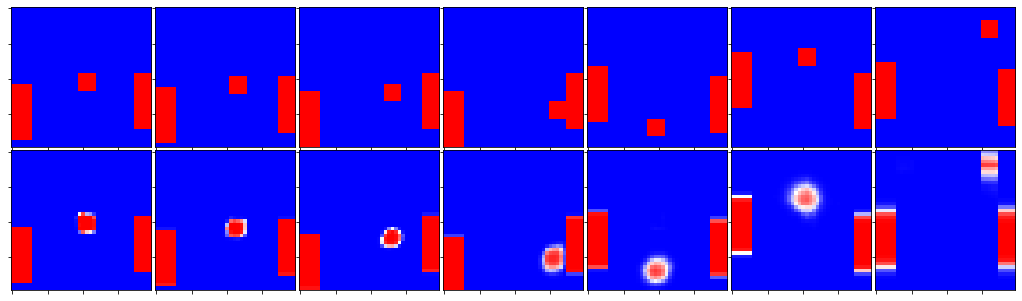

Epoch 339/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0380 - mean_squared_error: 0.0108 - acc: 0.9858 - val_loss: 0.0361 - val_mean_squared_error: 0.0105 - val_acc: 0.9858


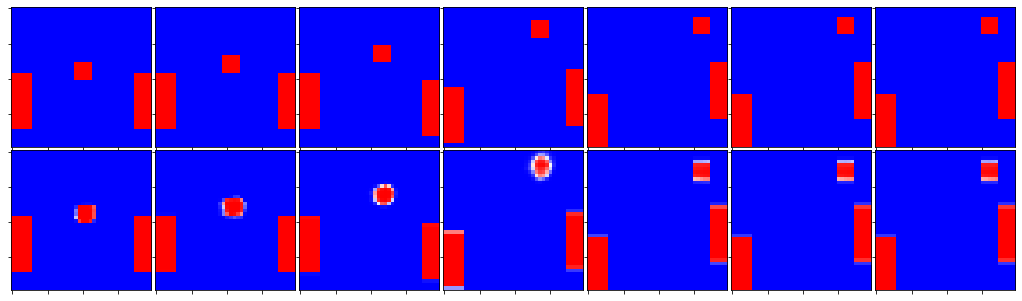

Epoch 340/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0401 - mean_squared_error: 0.0114 - acc: 0.9849 - val_loss: 0.0487 - val_mean_squared_error: 0.0139 - val_acc: 0.9813


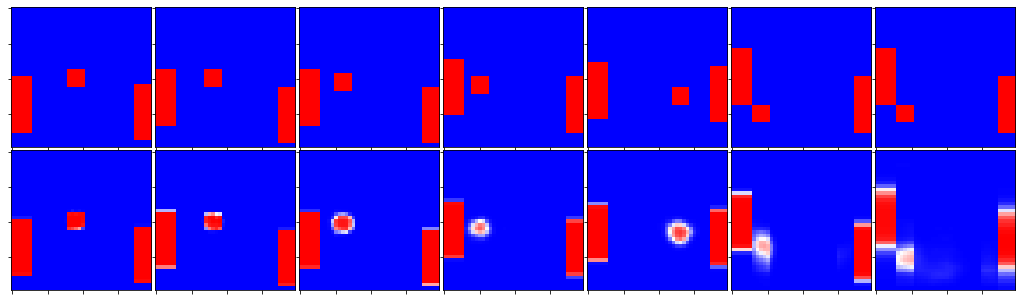

Epoch 341/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0413 - mean_squared_error: 0.0118 - acc: 0.9841 - val_loss: 0.0328 - val_mean_squared_error: 0.0096 - val_acc: 0.9872


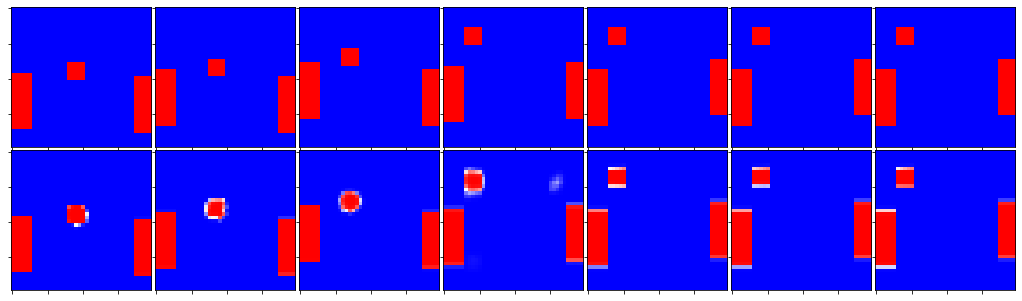

Epoch 342/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0376 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0535 - val_mean_squared_error: 0.0150 - val_acc: 0.9803


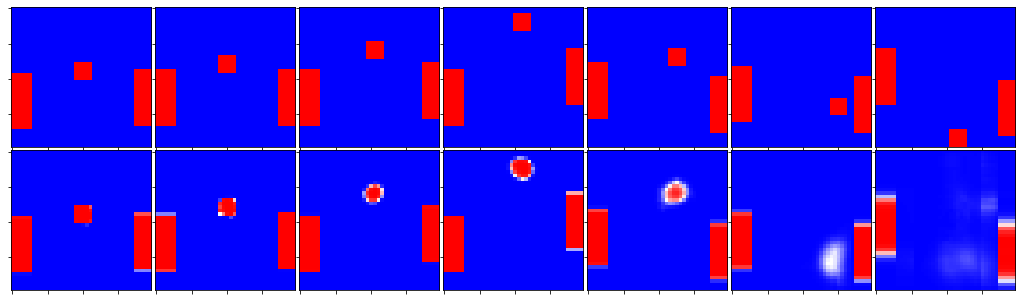

Epoch 343/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0442 - mean_squared_error: 0.0124 - acc: 0.9836 - val_loss: 0.0357 - val_mean_squared_error: 0.0103 - val_acc: 0.9862


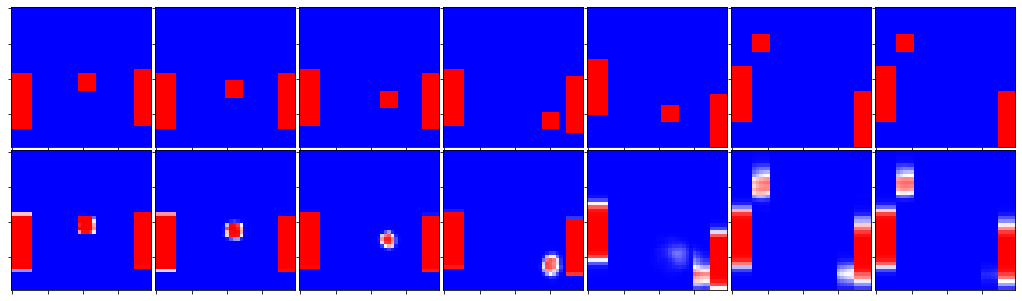

Epoch 344/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0391 - mean_squared_error: 0.0111 - acc: 0.9852 - val_loss: 0.0433 - val_mean_squared_error: 0.0122 - val_acc: 0.9838


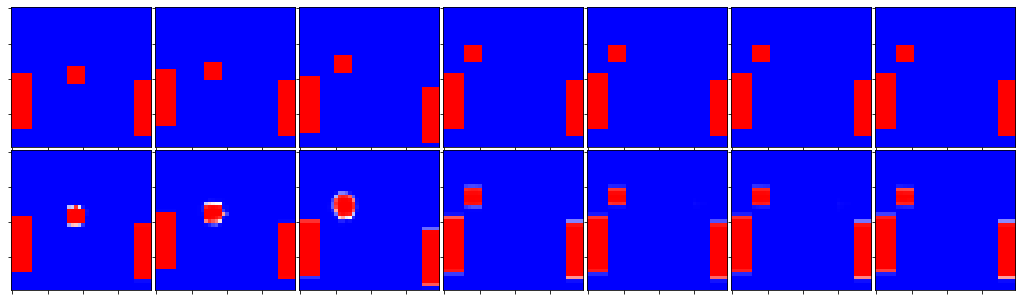

Epoch 345/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0386 - mean_squared_error: 0.0110 - acc: 0.9855 - val_loss: 0.0372 - val_mean_squared_error: 0.0108 - val_acc: 0.9857


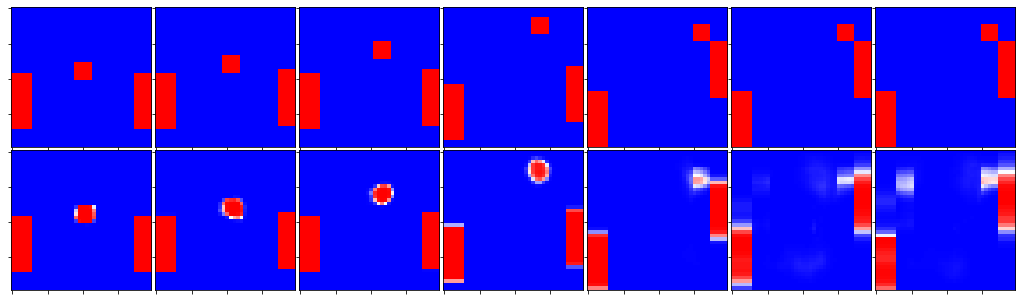

Epoch 346/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0390 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0334 - val_mean_squared_error: 0.0099 - val_acc: 0.9866


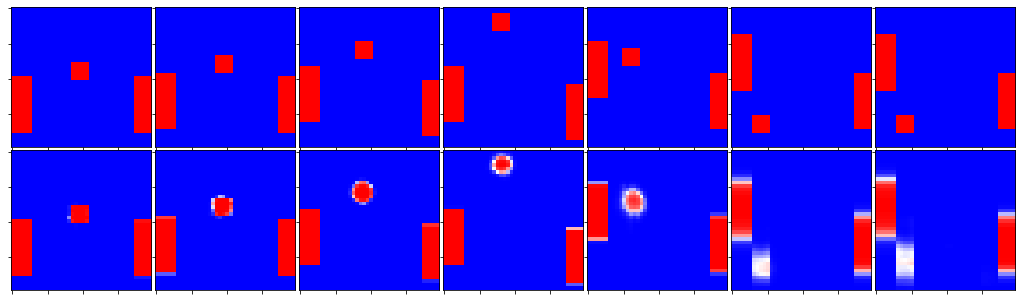

Epoch 347/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0384 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0457 - val_mean_squared_error: 0.0130 - val_acc: 0.9826


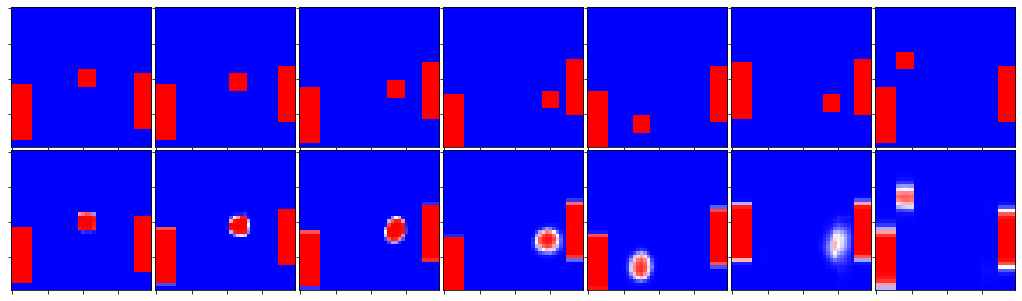

Epoch 348/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0410 - mean_squared_error: 0.0117 - acc: 0.9844 - val_loss: 0.0366 - val_mean_squared_error: 0.0106 - val_acc: 0.9859


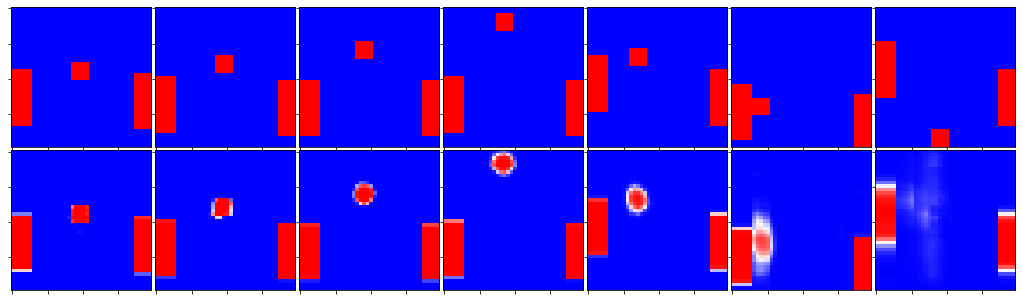

Epoch 349/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0380 - mean_squared_error: 0.0109 - acc: 0.9856 - val_loss: 0.0363 - val_mean_squared_error: 0.0102 - val_acc: 0.9864


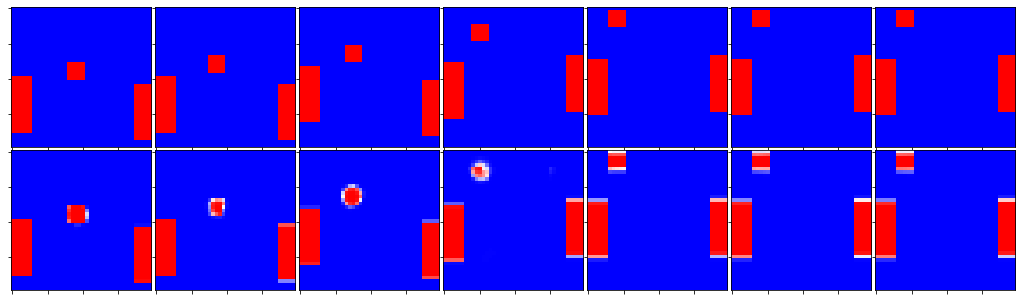

Epoch 350/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0374 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0374 - val_mean_squared_error: 0.0106 - val_acc: 0.9860


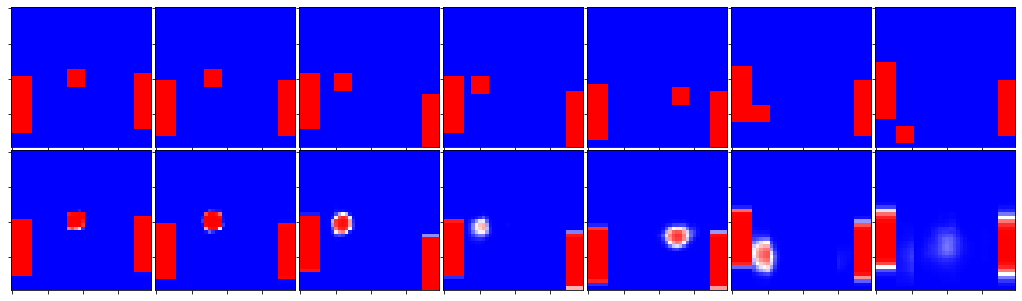

Epoch 351/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0392 - mean_squared_error: 0.0112 - acc: 0.9852 - val_loss: 0.0414 - val_mean_squared_error: 0.0118 - val_acc: 0.9841


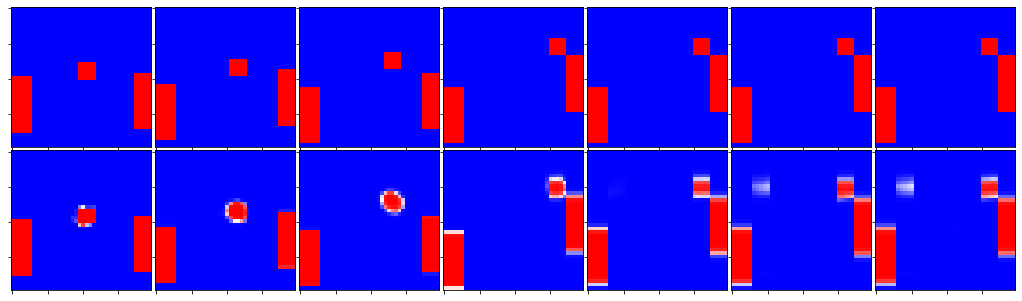

Epoch 352/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0381 - mean_squared_error: 0.0109 - acc: 0.9856 - val_loss: 0.0391 - val_mean_squared_error: 0.0108 - val_acc: 0.9857


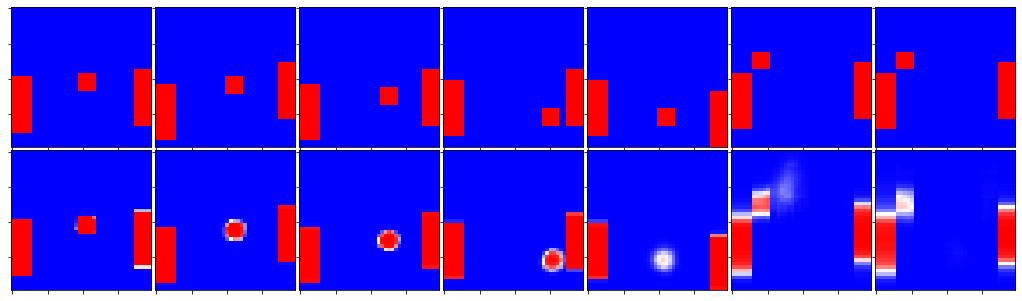

Epoch 353/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0379 - mean_squared_error: 0.0108 - acc: 0.9856 - val_loss: 0.0399 - val_mean_squared_error: 0.0115 - val_acc: 0.9847


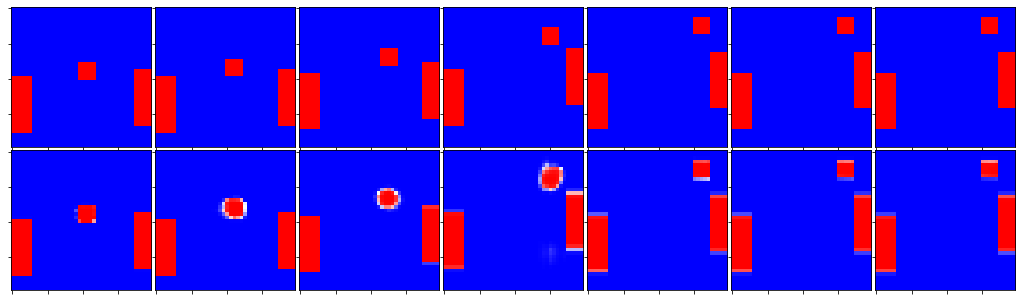

Epoch 354/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0363 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0389 - val_mean_squared_error: 0.0112 - val_acc: 0.9849


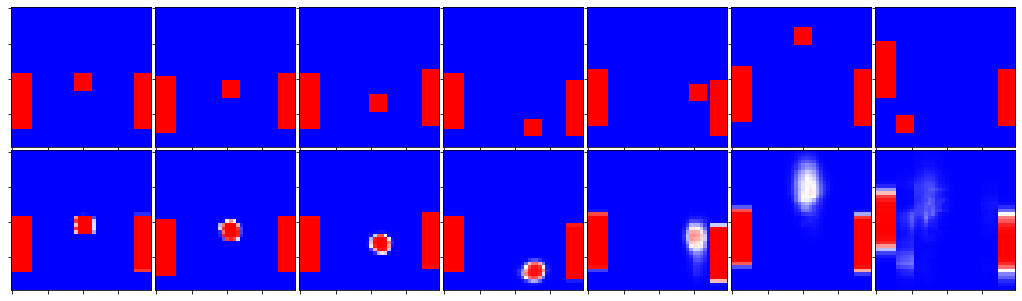

Epoch 355/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0381 - mean_squared_error: 0.0108 - acc: 0.9856 - val_loss: 0.0379 - val_mean_squared_error: 0.0106 - val_acc: 0.9859


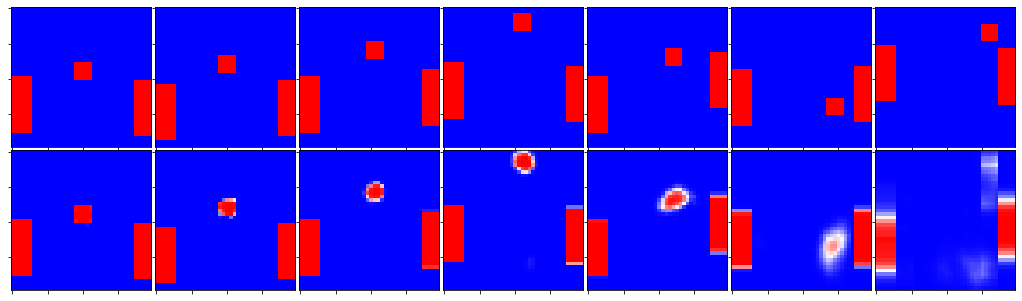

Epoch 356/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0379 - mean_squared_error: 0.0108 - acc: 0.9856 - val_loss: 0.0385 - val_mean_squared_error: 0.0112 - val_acc: 0.9850


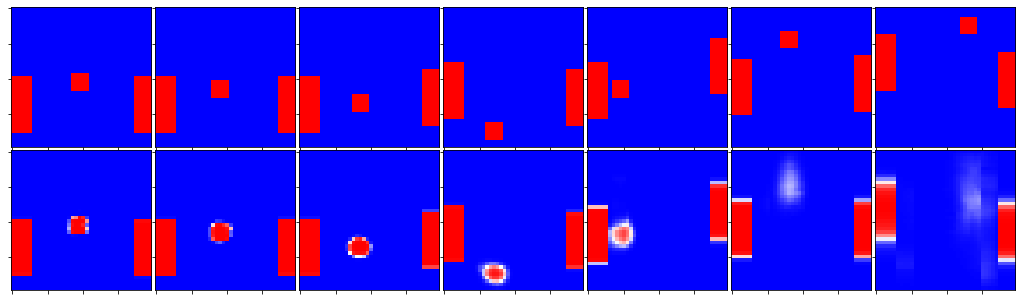

Epoch 357/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0407 - mean_squared_error: 0.0116 - acc: 0.9844 - val_loss: 0.0375 - val_mean_squared_error: 0.0107 - val_acc: 0.9856


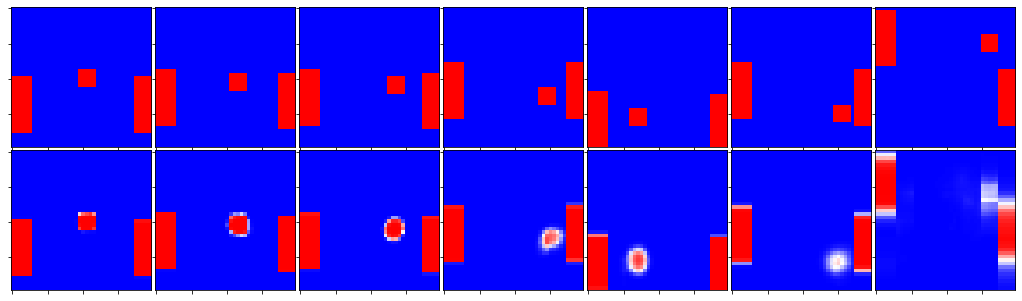

Epoch 358/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0371 - mean_squared_error: 0.0106 - acc: 0.9860 - val_loss: 0.0361 - val_mean_squared_error: 0.0101 - val_acc: 0.9865


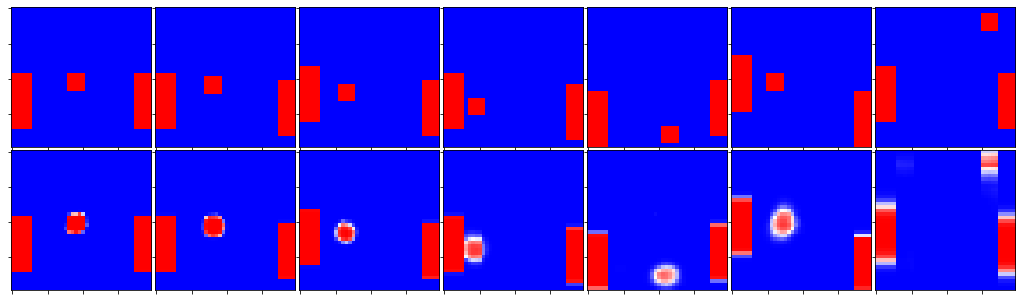

Epoch 359/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0389 - mean_squared_error: 0.0111 - acc: 0.9852 - val_loss: 0.0365 - val_mean_squared_error: 0.0105 - val_acc: 0.9863


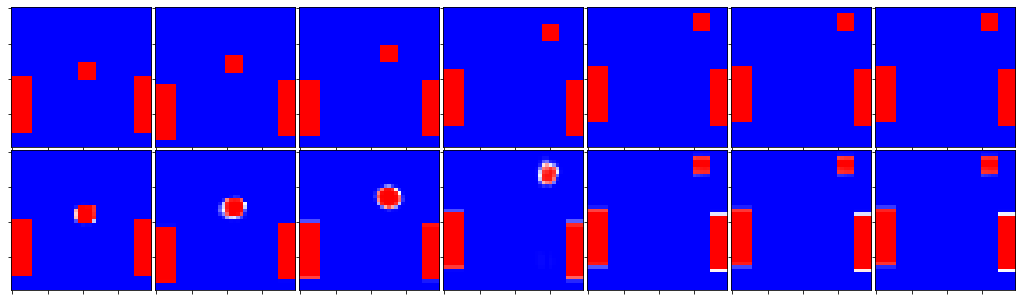

Epoch 360/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0378 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0475 - val_mean_squared_error: 0.0132 - val_acc: 0.9825


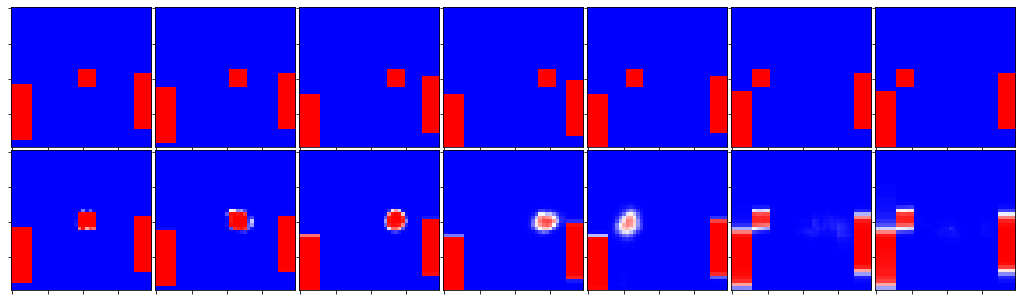

Epoch 361/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0389 - mean_squared_error: 0.0111 - acc: 0.9852 - val_loss: 0.0354 - val_mean_squared_error: 0.0100 - val_acc: 0.9866


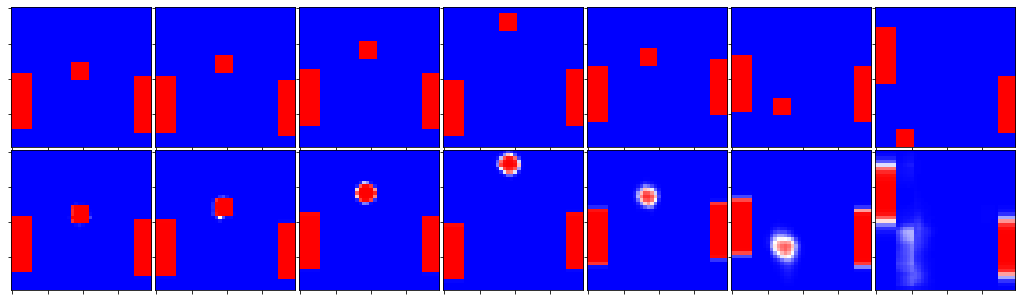

Epoch 362/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0404 - mean_squared_error: 0.0115 - acc: 0.9847 - val_loss: 0.0399 - val_mean_squared_error: 0.0114 - val_acc: 0.9849


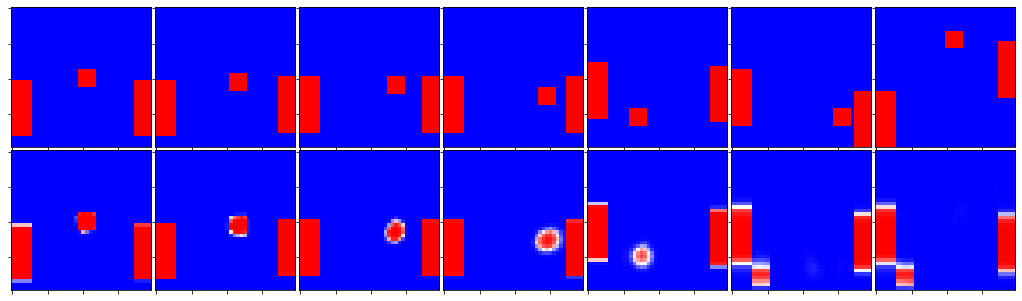

Epoch 363/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0372 - mean_squared_error: 0.0106 - acc: 0.9860 - val_loss: 0.0392 - val_mean_squared_error: 0.0113 - val_acc: 0.9850


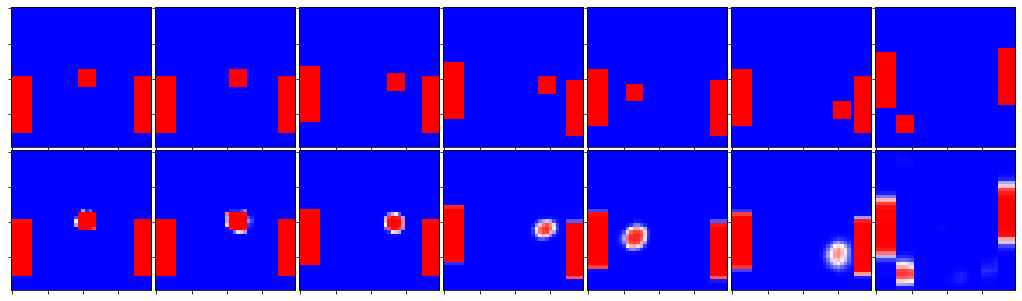

Epoch 364/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0375 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0467 - val_mean_squared_error: 0.0133 - val_acc: 0.9822


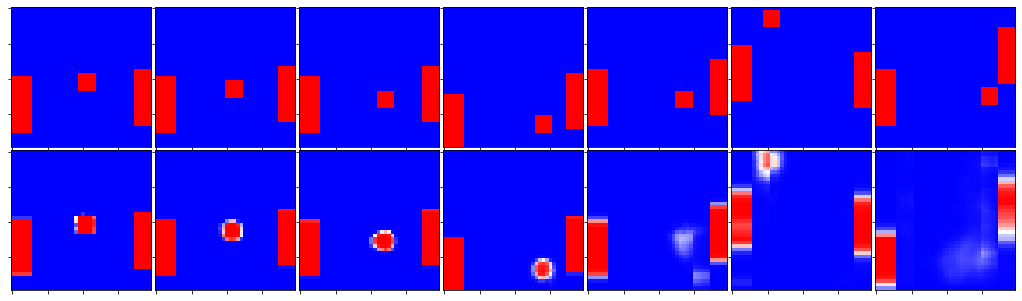

Epoch 365/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0372 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0347 - val_mean_squared_error: 0.0100 - val_acc: 0.9867


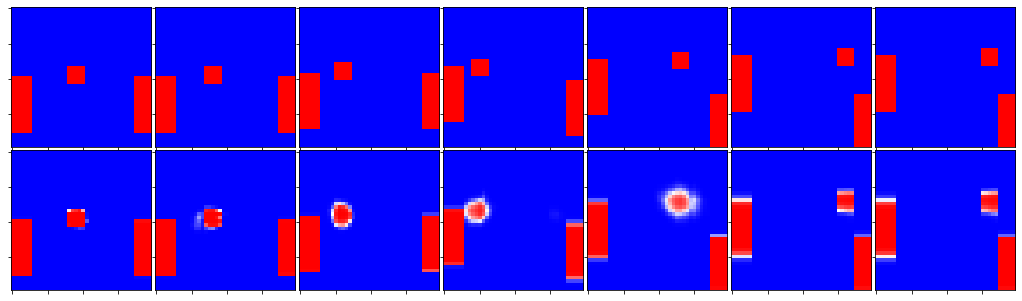

Epoch 366/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0368 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0360 - val_mean_squared_error: 0.0101 - val_acc: 0.9868


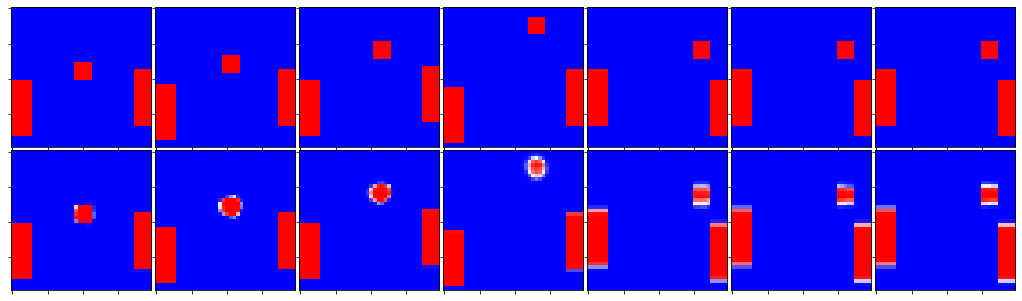

Epoch 367/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0395 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0428 - val_mean_squared_error: 0.0122 - val_acc: 0.9835


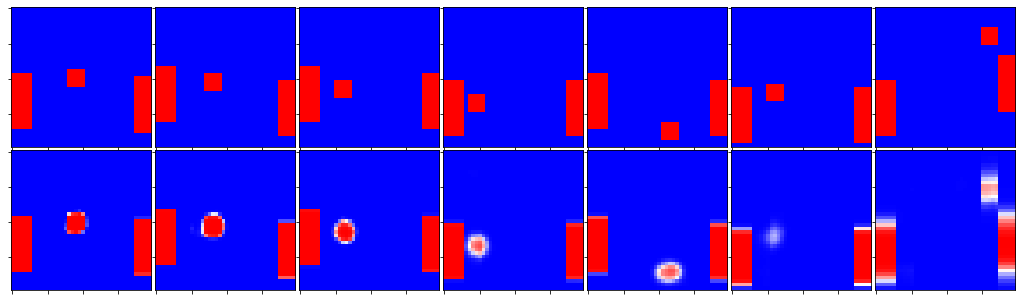

Epoch 368/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0363 - mean_squared_error: 0.0104 - acc: 0.9861 - val_loss: 0.0366 - val_mean_squared_error: 0.0105 - val_acc: 0.9858


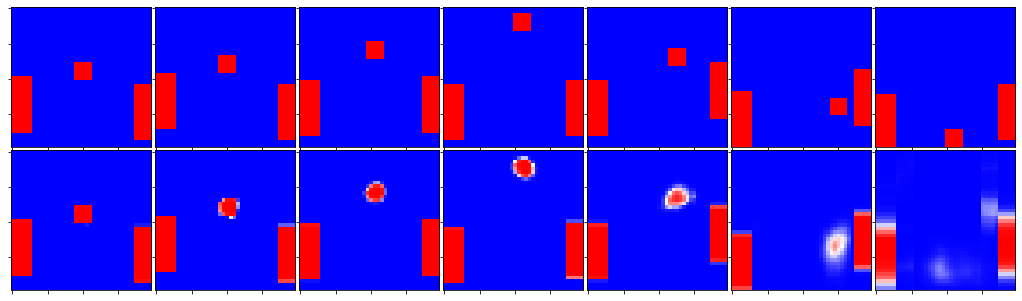

Epoch 369/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0375 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0390 - val_mean_squared_error: 0.0111 - val_acc: 0.9852


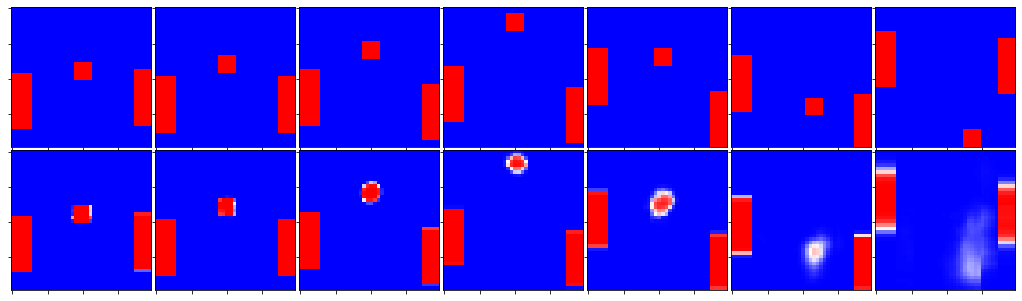

Epoch 370/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0373 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0505 - val_mean_squared_error: 0.0138 - val_acc: 0.9819


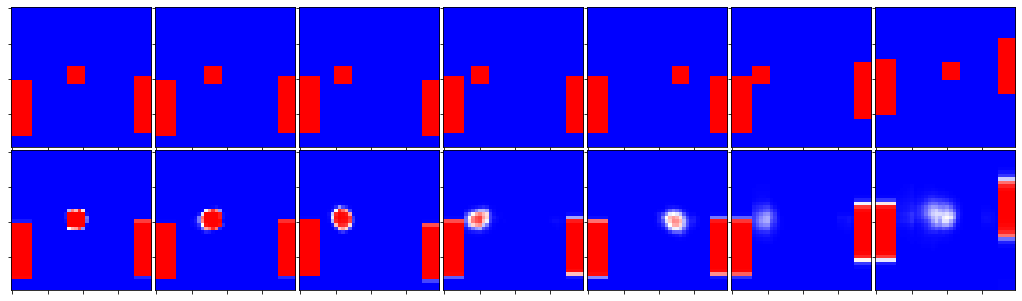

Epoch 371/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0386 - mean_squared_error: 0.0110 - acc: 0.9853 - val_loss: 0.0454 - val_mean_squared_error: 0.0126 - val_acc: 0.9833


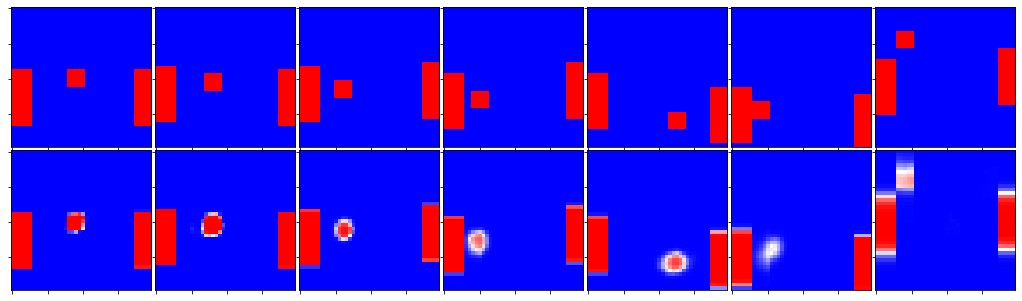

Epoch 372/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0376 - mean_squared_error: 0.0108 - acc: 0.9856 - val_loss: 0.0361 - val_mean_squared_error: 0.0103 - val_acc: 0.9864


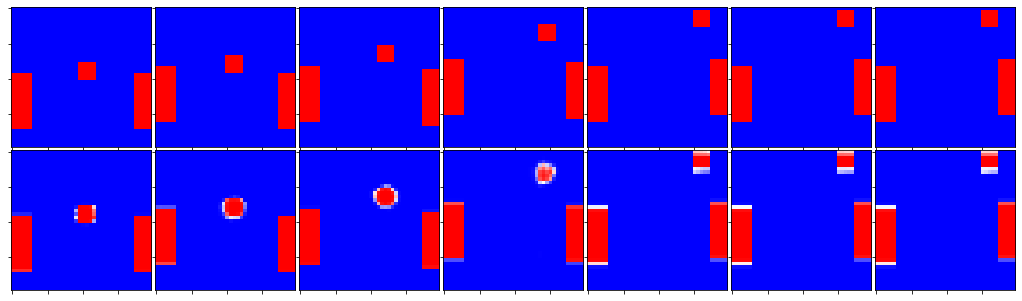

Epoch 373/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0373 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0383 - val_mean_squared_error: 0.0111 - val_acc: 0.9849


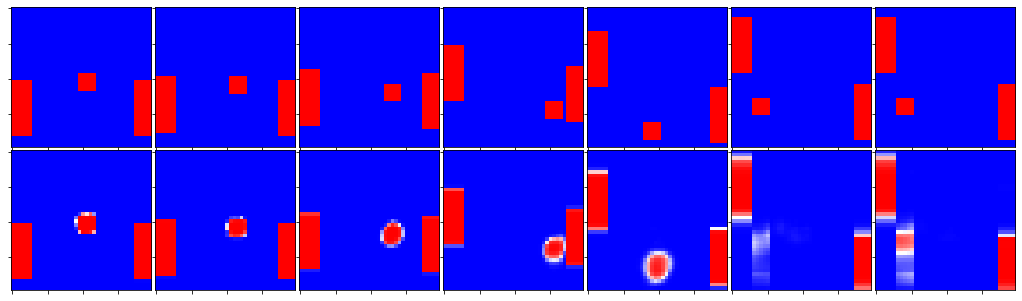

Epoch 374/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0364 - mean_squared_error: 0.0104 - acc: 0.9862 - val_loss: 0.0325 - val_mean_squared_error: 0.0094 - val_acc: 0.9874


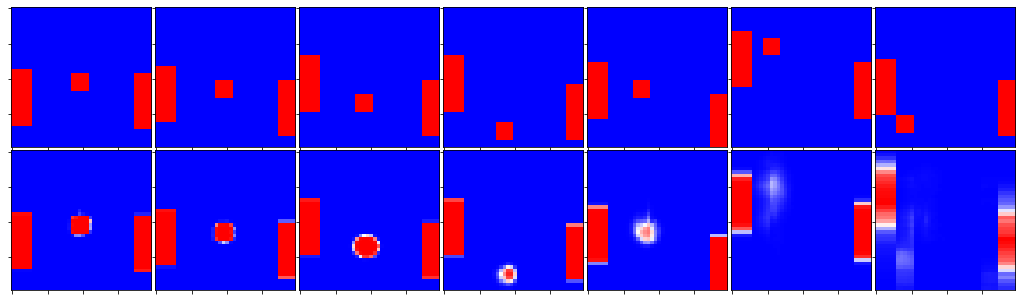

Epoch 375/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0471 - mean_squared_error: 0.0129 - acc: 0.9830 - val_loss: 0.0421 - val_mean_squared_error: 0.0120 - val_acc: 0.9840


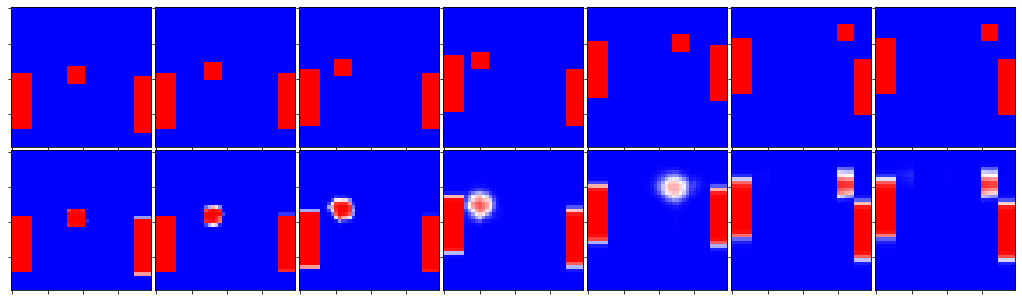

Epoch 376/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0429 - mean_squared_error: 0.0121 - acc: 0.9839 - val_loss: 0.0400 - val_mean_squared_error: 0.0117 - val_acc: 0.9844


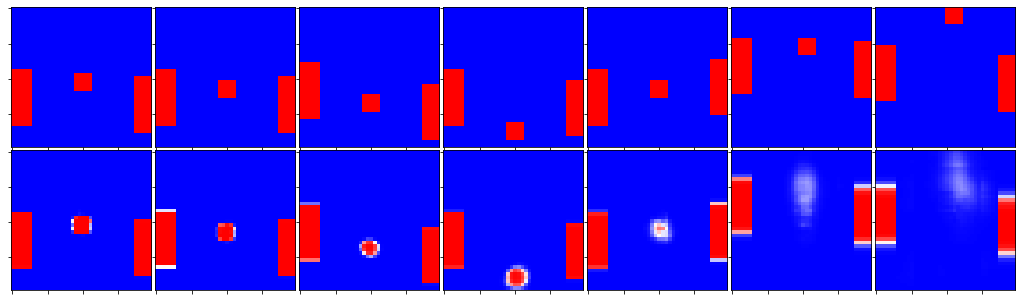

Epoch 377/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0387 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0368 - val_mean_squared_error: 0.0103 - val_acc: 0.9866


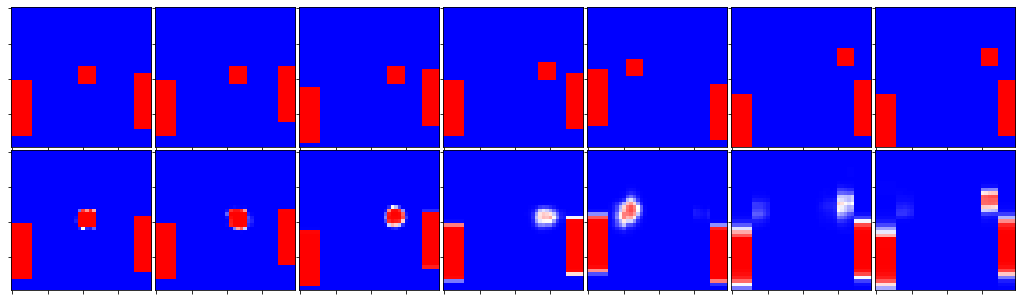

Epoch 378/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0373 - mean_squared_error: 0.0106 - acc: 0.9858 - val_loss: 0.0357 - val_mean_squared_error: 0.0100 - val_acc: 0.9871


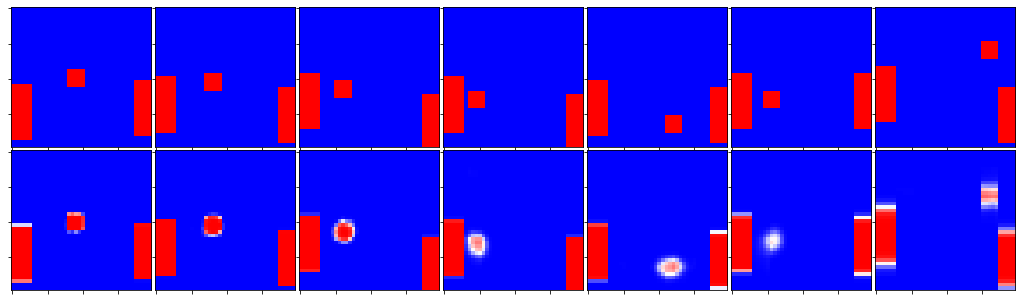

Epoch 379/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0374 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0361 - val_mean_squared_error: 0.0101 - val_acc: 0.9870


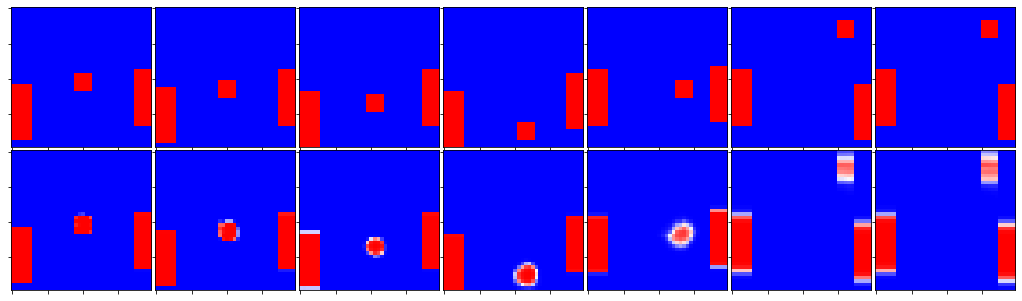

Epoch 380/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0392 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0370 - val_mean_squared_error: 0.0106 - val_acc: 0.9859


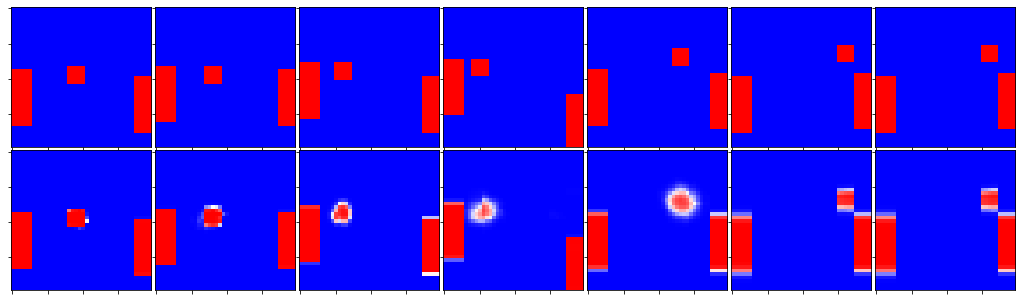

Epoch 381/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0399 - mean_squared_error: 0.0114 - acc: 0.9849 - val_loss: 0.0398 - val_mean_squared_error: 0.0115 - val_acc: 0.9846


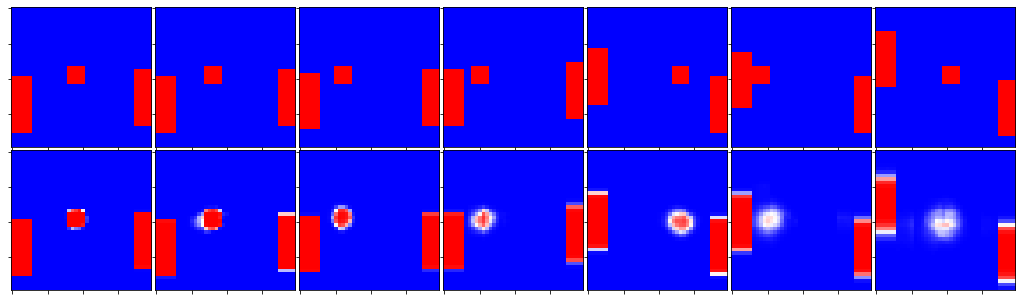

Epoch 382/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0373 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0490 - val_mean_squared_error: 0.0124 - val_acc: 0.9835


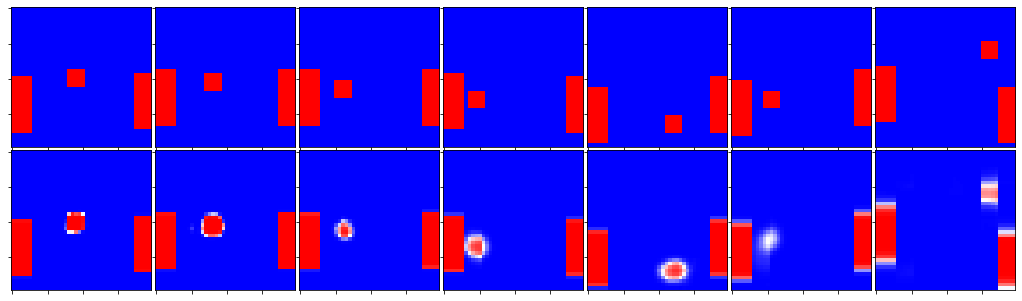

Epoch 383/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0387 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0341 - val_mean_squared_error: 0.0096 - val_acc: 0.9873


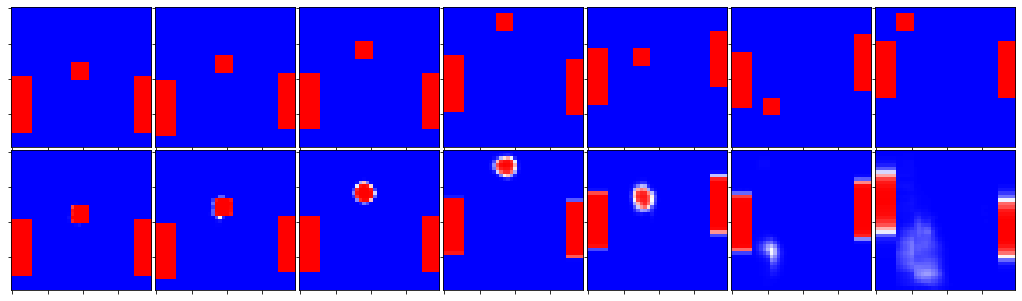

Epoch 384/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0378 - mean_squared_error: 0.0108 - acc: 0.9857 - val_loss: 0.0428 - val_mean_squared_error: 0.0118 - val_acc: 0.9845


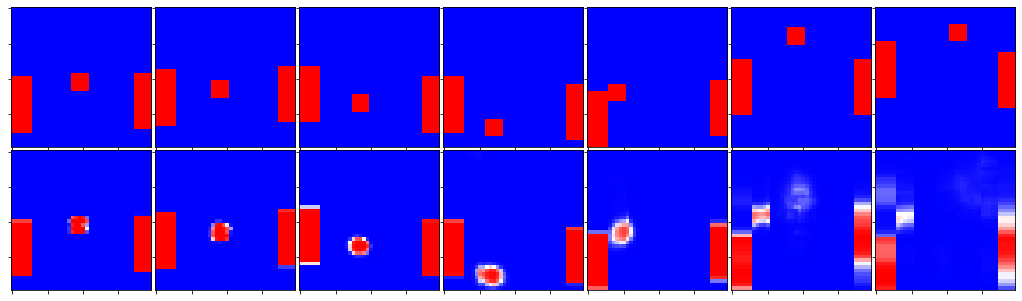

Epoch 385/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0422 - mean_squared_error: 0.0119 - acc: 0.9842 - val_loss: 0.0343 - val_mean_squared_error: 0.0094 - val_acc: 0.9876


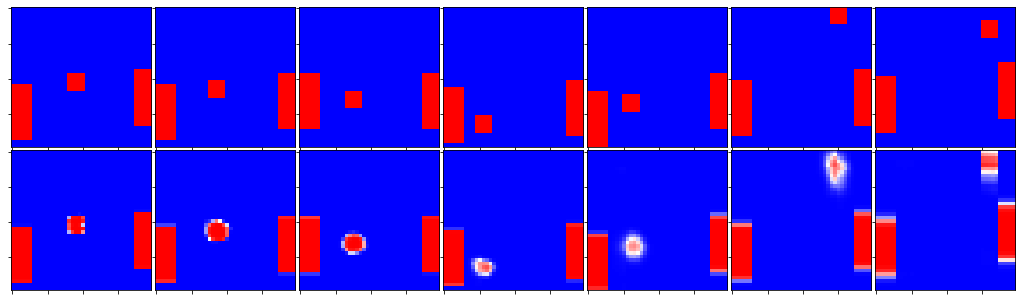

Epoch 386/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0362 - mean_squared_error: 0.0103 - acc: 0.9864 - val_loss: 0.0360 - val_mean_squared_error: 0.0103 - val_acc: 0.9861


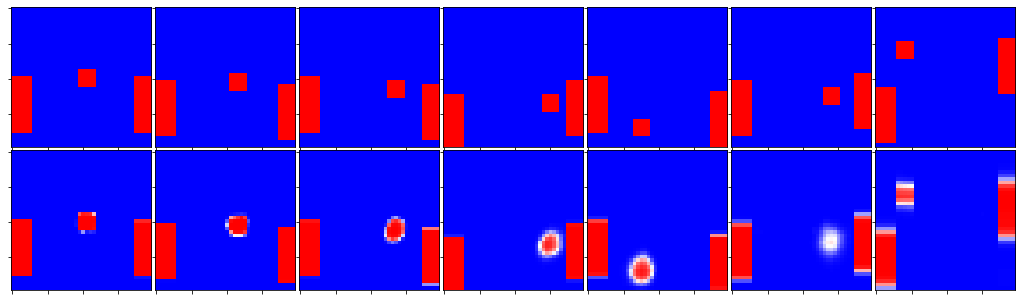

Epoch 387/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0366 - mean_squared_error: 0.0104 - acc: 0.9862 - val_loss: 0.0356 - val_mean_squared_error: 0.0103 - val_acc: 0.9862


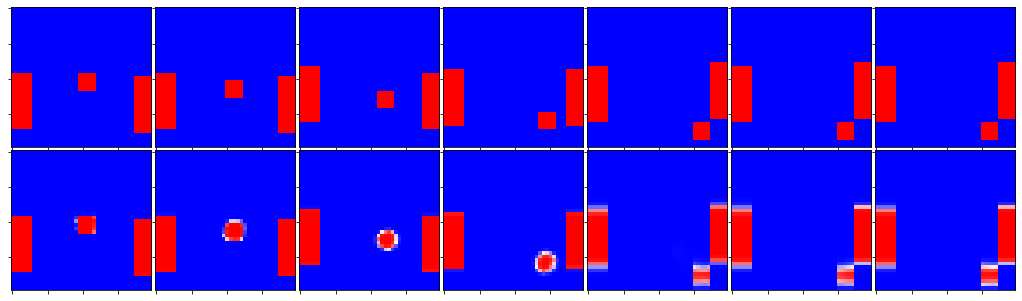

Epoch 388/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0373 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0409 - val_mean_squared_error: 0.0110 - val_acc: 0.9854


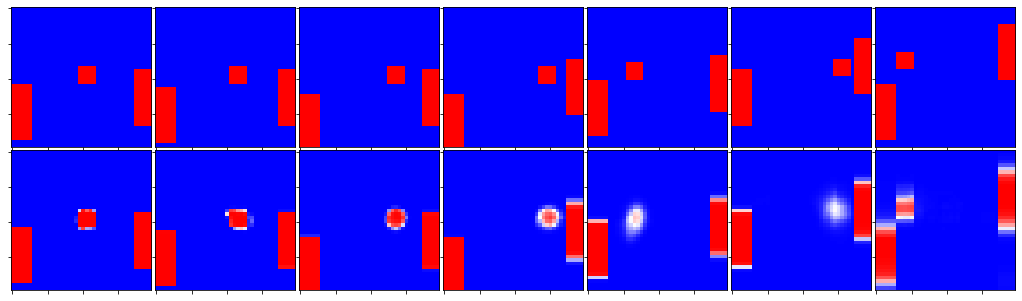

Epoch 389/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0371 - mean_squared_error: 0.0105 - acc: 0.9861 - val_loss: 0.0402 - val_mean_squared_error: 0.0116 - val_acc: 0.9848


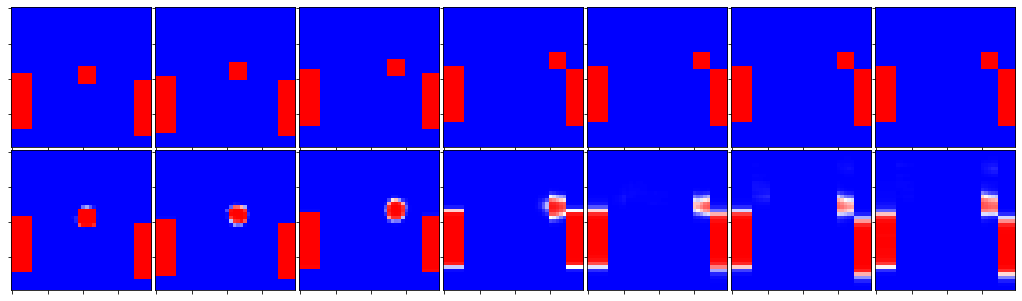

Epoch 390/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0360 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0336 - val_mean_squared_error: 0.0099 - val_acc: 0.9868


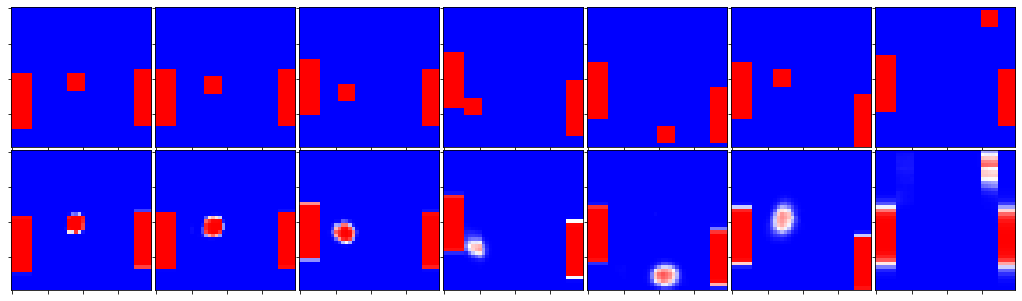

Epoch 391/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0367 - mean_squared_error: 0.0105 - acc: 0.9861 - val_loss: 0.0300 - val_mean_squared_error: 0.0088 - val_acc: 0.9884


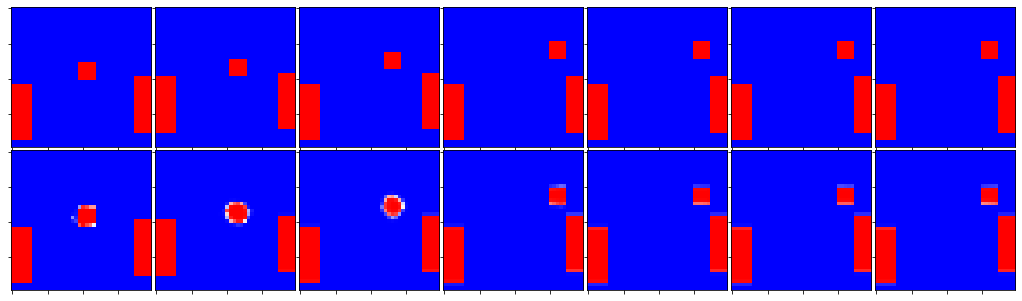

Epoch 392/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0376 - mean_squared_error: 0.0107 - acc: 0.9857 - val_loss: 0.0379 - val_mean_squared_error: 0.0110 - val_acc: 0.9853


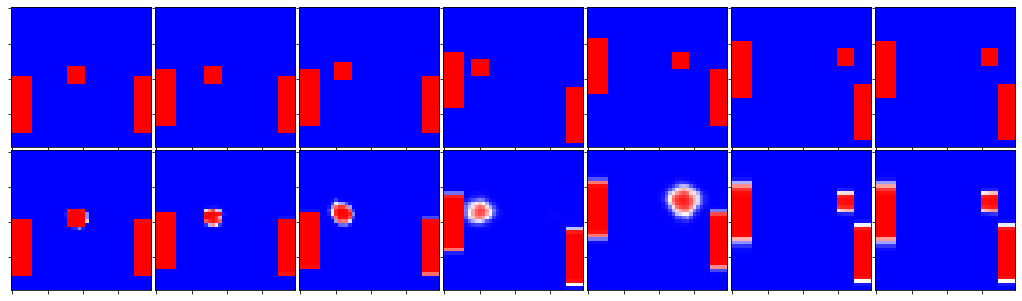

Epoch 393/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0376 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0323 - val_mean_squared_error: 0.0095 - val_acc: 0.9876


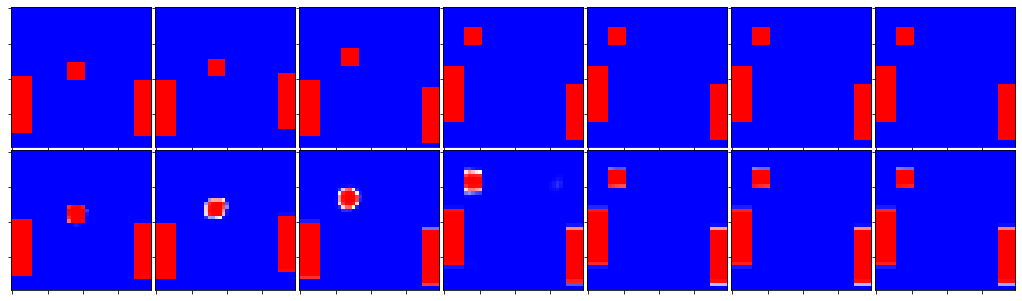

Epoch 394/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0374 - mean_squared_error: 0.0106 - acc: 0.9860 - val_loss: 0.0337 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


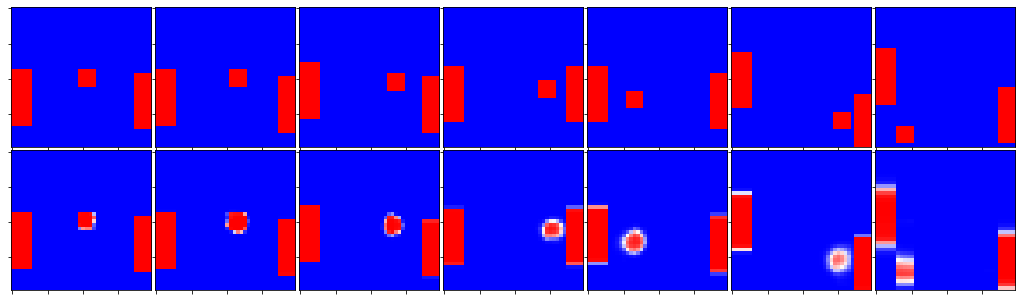

Epoch 395/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0396 - mean_squared_error: 0.0113 - acc: 0.9850 - val_loss: 0.0355 - val_mean_squared_error: 0.0101 - val_acc: 0.9864


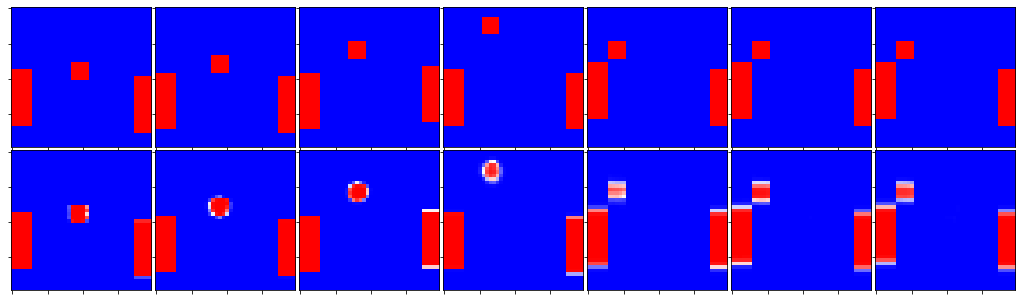

Epoch 396/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0367 - mean_squared_error: 0.0104 - acc: 0.9863 - val_loss: 0.0368 - val_mean_squared_error: 0.0106 - val_acc: 0.9859


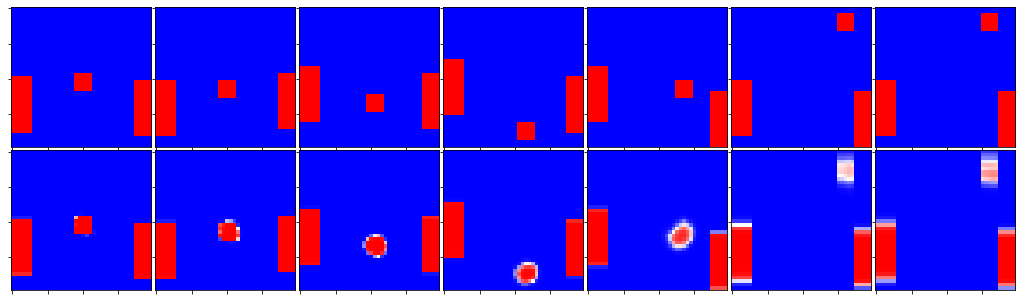

Epoch 397/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0412 - mean_squared_error: 0.0116 - acc: 0.9846 - val_loss: 0.0385 - val_mean_squared_error: 0.0108 - val_acc: 0.9857


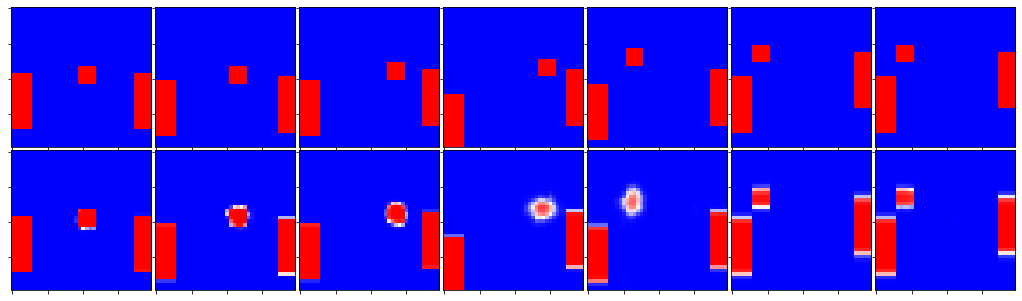

Epoch 398/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0372 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0354 - val_mean_squared_error: 0.0104 - val_acc: 0.9859


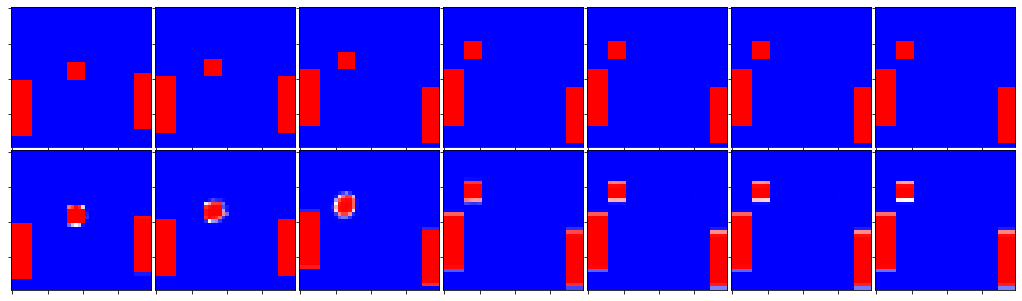

Epoch 399/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0360 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0320 - val_mean_squared_error: 0.0091 - val_acc: 0.9881


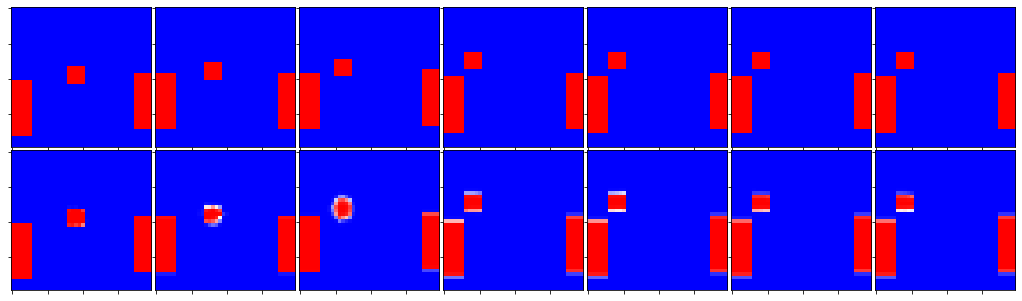

Epoch 400/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0383 - mean_squared_error: 0.0109 - acc: 0.9855 - val_loss: 0.0335 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


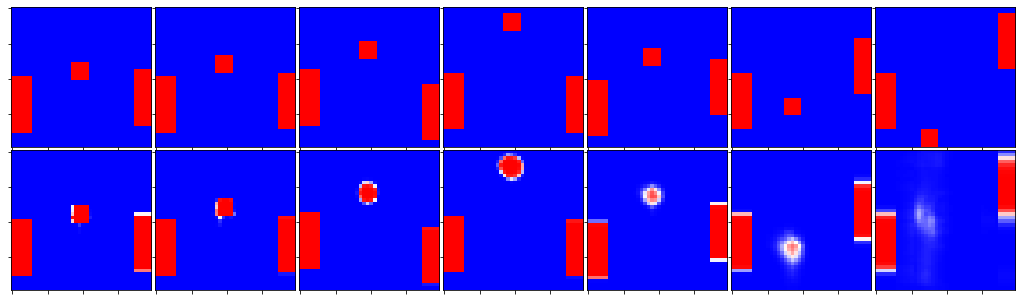

Epoch 401/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0366 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0338 - val_mean_squared_error: 0.0096 - val_acc: 0.9871


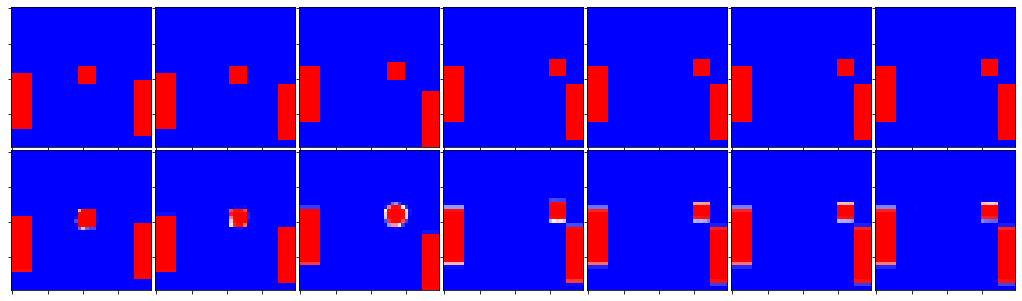

Epoch 402/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0371 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0427 - val_mean_squared_error: 0.0118 - val_acc: 0.9844


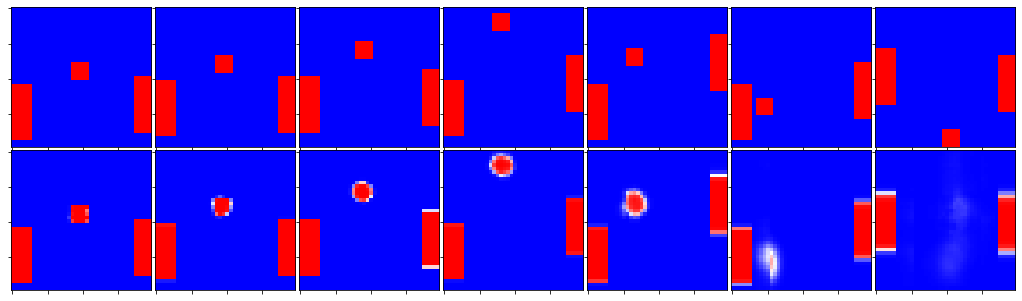

Epoch 403/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0351 - mean_squared_error: 0.0101 - acc: 0.9865 - val_loss: 0.0344 - val_mean_squared_error: 0.0099 - val_acc: 0.9867


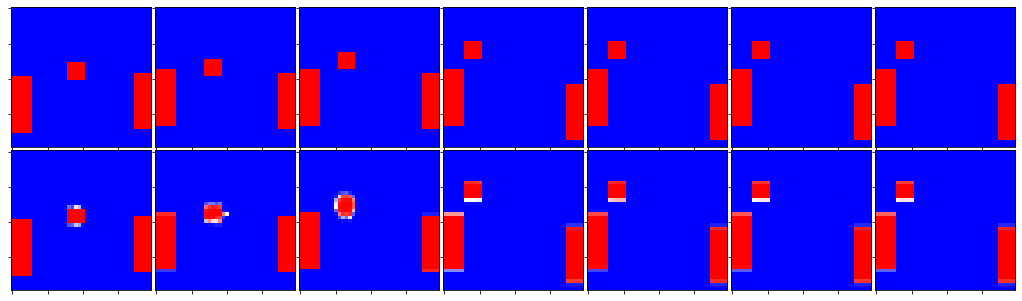

Epoch 404/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0360 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0358 - val_mean_squared_error: 0.0103 - val_acc: 0.9861


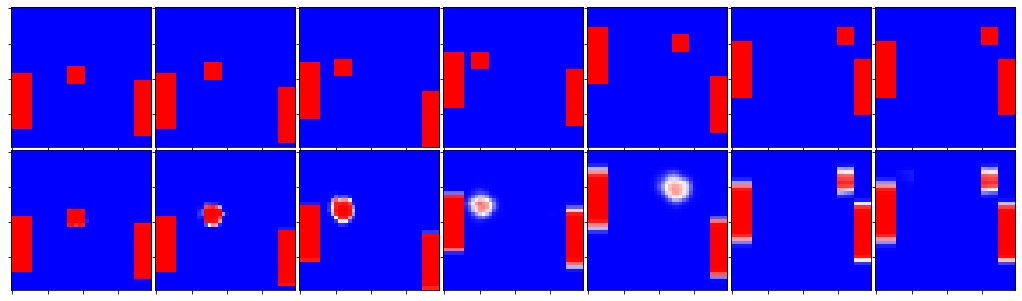

Epoch 405/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0355 - mean_squared_error: 0.0102 - acc: 0.9865 - val_loss: 0.0397 - val_mean_squared_error: 0.0114 - val_acc: 0.9846


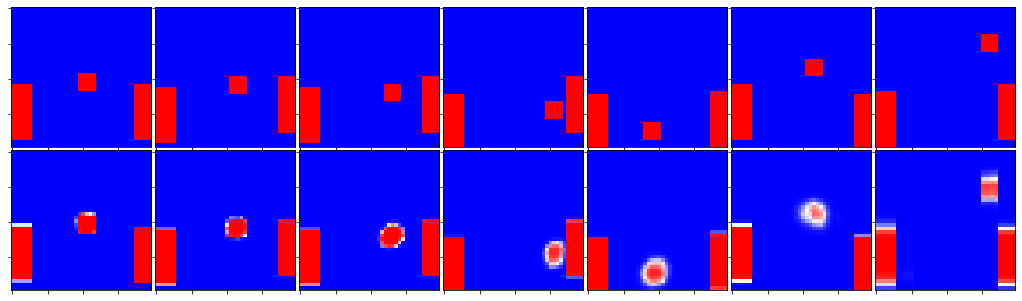

Epoch 406/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0367 - mean_squared_error: 0.0104 - acc: 0.9861 - val_loss: 0.0348 - val_mean_squared_error: 0.0101 - val_acc: 0.9863


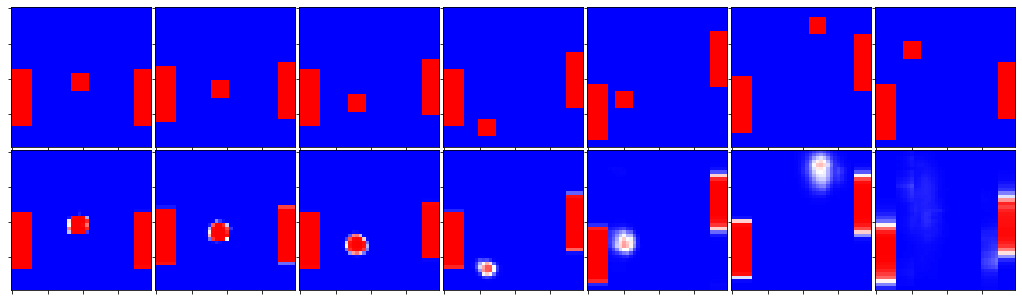

Epoch 407/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0359 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0300 - val_mean_squared_error: 0.0087 - val_acc: 0.9883


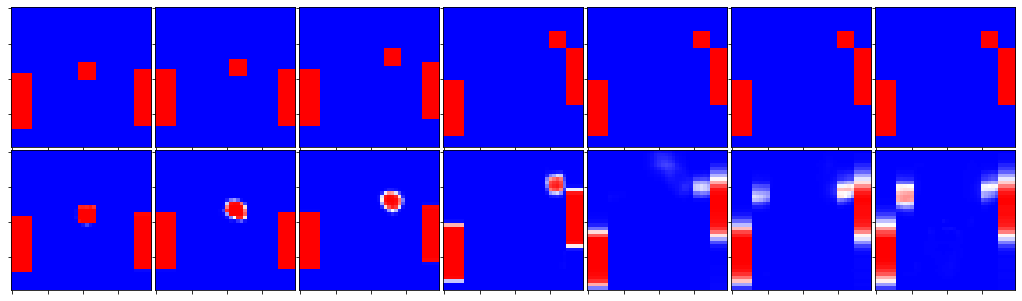

Epoch 408/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0356 - mean_squared_error: 0.0101 - acc: 0.9866 - val_loss: 0.0325 - val_mean_squared_error: 0.0095 - val_acc: 0.9872


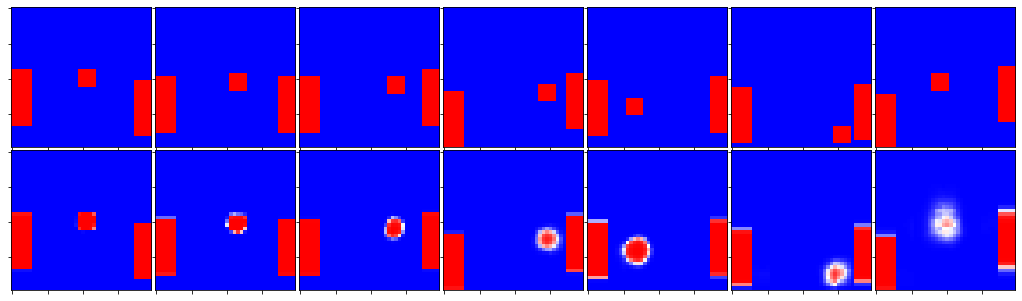

Epoch 409/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0365 - mean_squared_error: 0.0103 - acc: 0.9862 - val_loss: 0.0322 - val_mean_squared_error: 0.0095 - val_acc: 0.9871


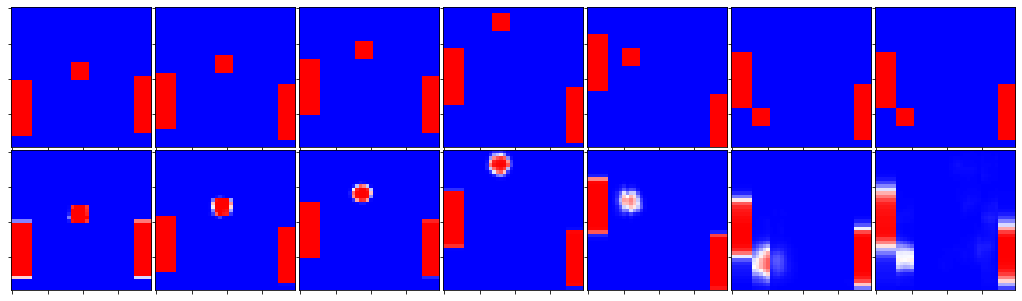

Epoch 410/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0377 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0373 - val_mean_squared_error: 0.0107 - val_acc: 0.9859


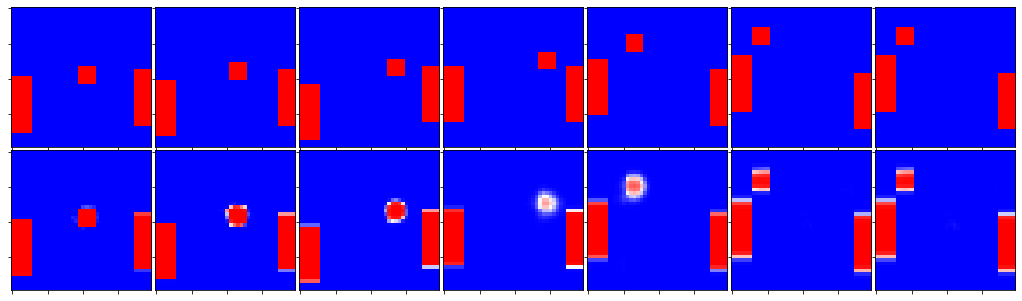

Epoch 411/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0364 - mean_squared_error: 0.0103 - acc: 0.9862 - val_loss: 0.0368 - val_mean_squared_error: 0.0109 - val_acc: 0.9852


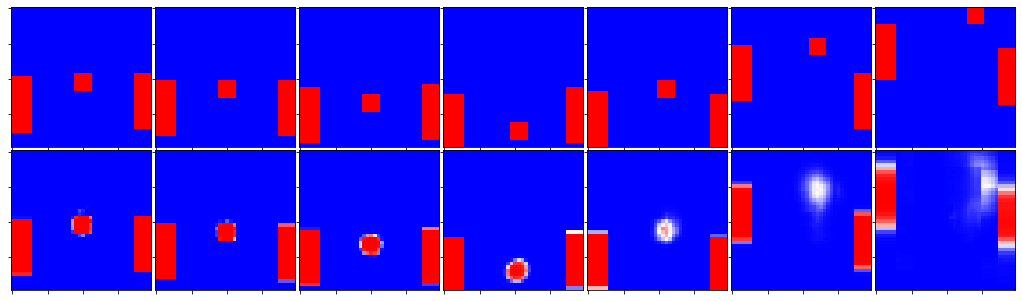

Epoch 412/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0357 - mean_squared_error: 0.0102 - acc: 0.9863 - val_loss: 0.0319 - val_mean_squared_error: 0.0093 - val_acc: 0.9879


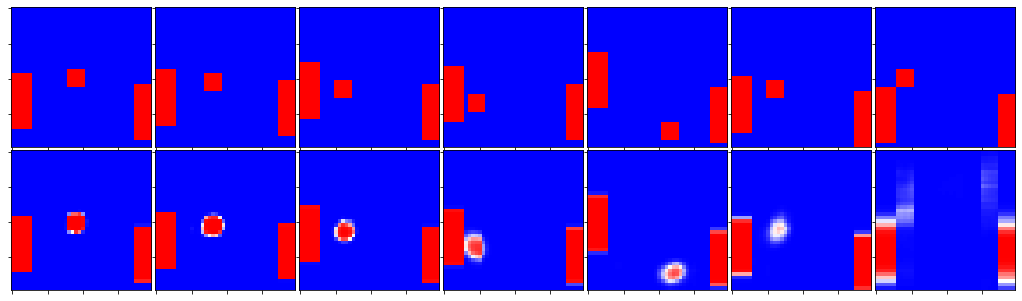

Epoch 413/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0368 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0355 - val_mean_squared_error: 0.0103 - val_acc: 0.9862


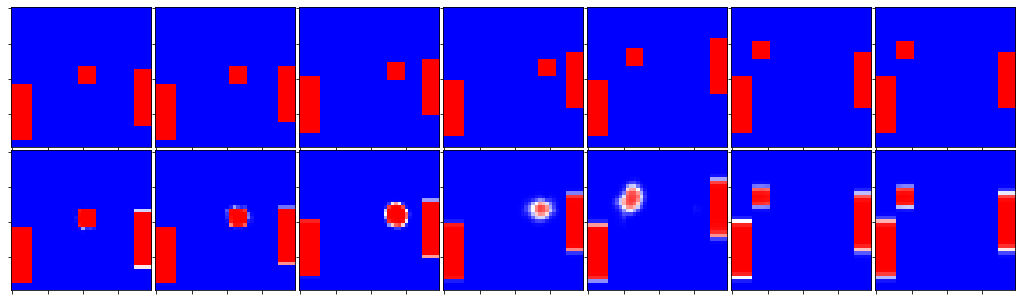

Epoch 414/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0394 - mean_squared_error: 0.0112 - acc: 0.9851 - val_loss: 0.0383 - val_mean_squared_error: 0.0111 - val_acc: 0.9852


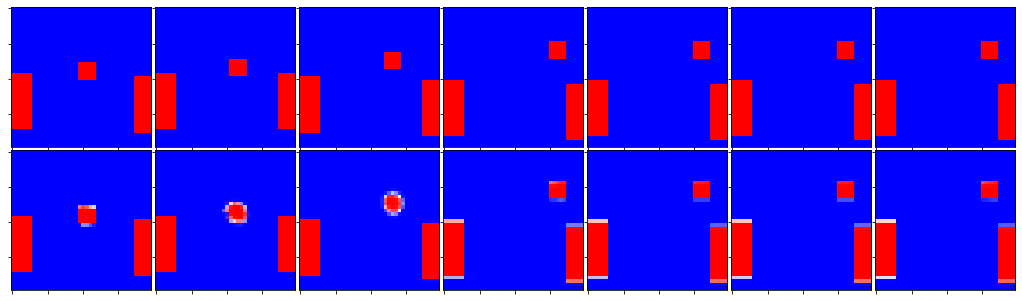

Epoch 415/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0360 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0370 - val_mean_squared_error: 0.0104 - val_acc: 0.9862


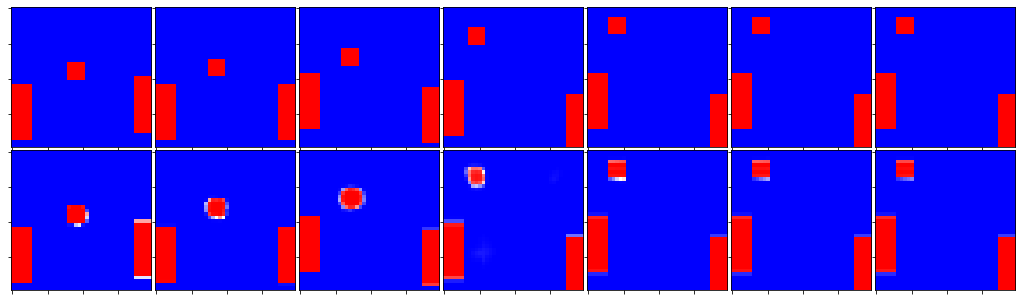

Epoch 416/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0363 - mean_squared_error: 0.0104 - acc: 0.9862 - val_loss: 0.0339 - val_mean_squared_error: 0.0096 - val_acc: 0.9874


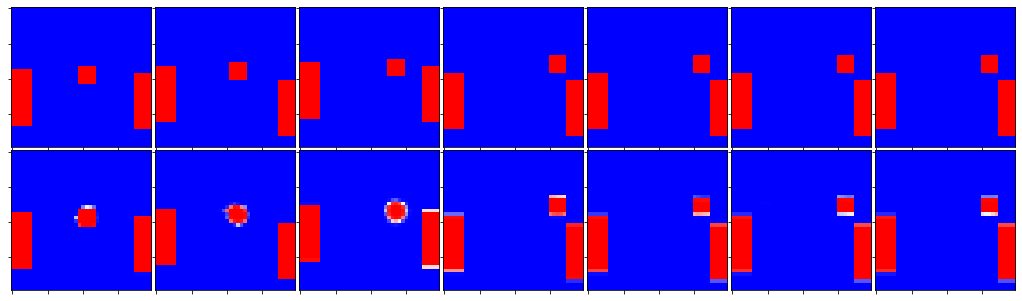

Epoch 417/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0382 - mean_squared_error: 0.0109 - acc: 0.9854 - val_loss: 0.0385 - val_mean_squared_error: 0.0112 - val_acc: 0.9852


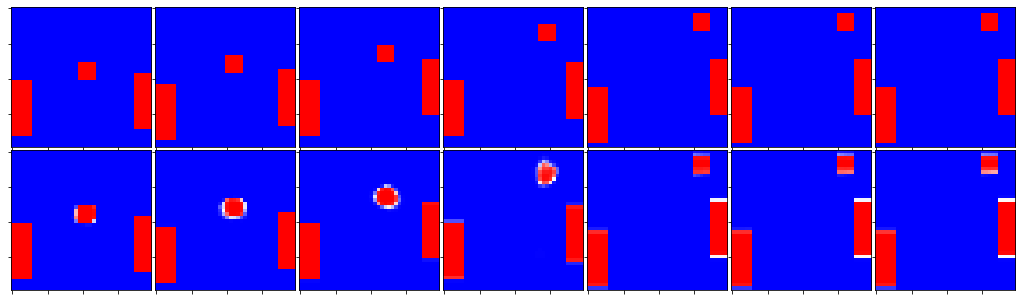

Epoch 418/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0355 - mean_squared_error: 0.0101 - acc: 0.9866 - val_loss: 0.0296 - val_mean_squared_error: 0.0086 - val_acc: 0.9887


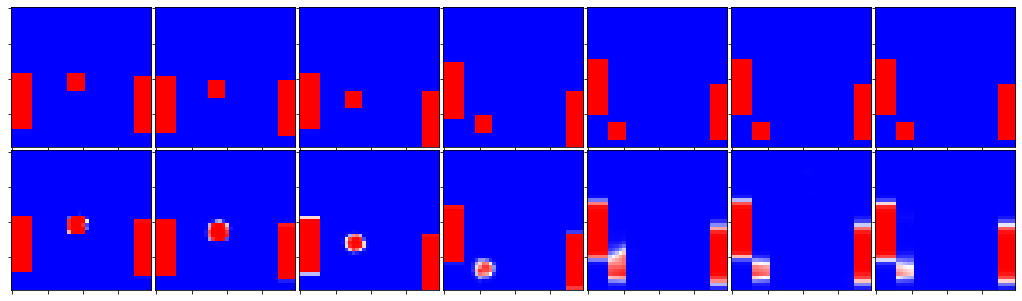

Epoch 419/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0349 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0470 - val_mean_squared_error: 0.0135 - val_acc: 0.9820


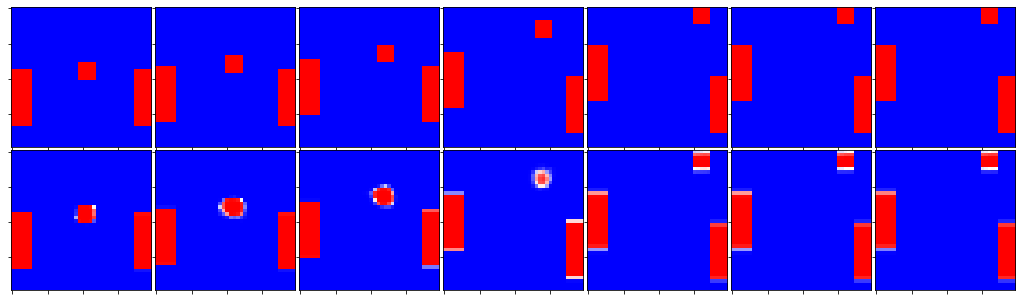

Epoch 420/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0415 - mean_squared_error: 0.0116 - acc: 0.9846 - val_loss: 0.0319 - val_mean_squared_error: 0.0093 - val_acc: 0.9872


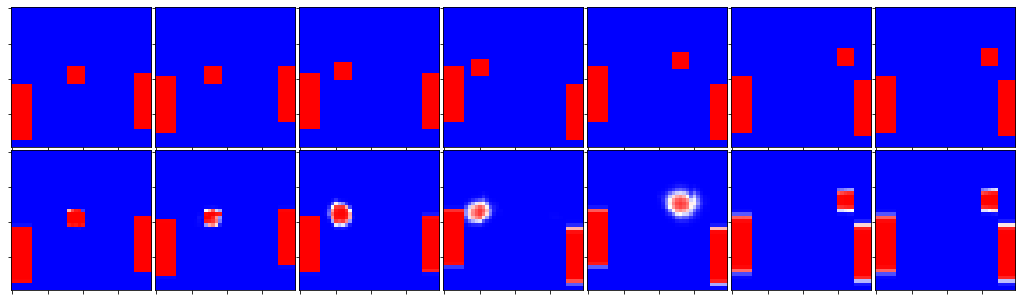

Epoch 421/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0354 - mean_squared_error: 0.0101 - acc: 0.9865 - val_loss: 0.0383 - val_mean_squared_error: 0.0110 - val_acc: 0.9852


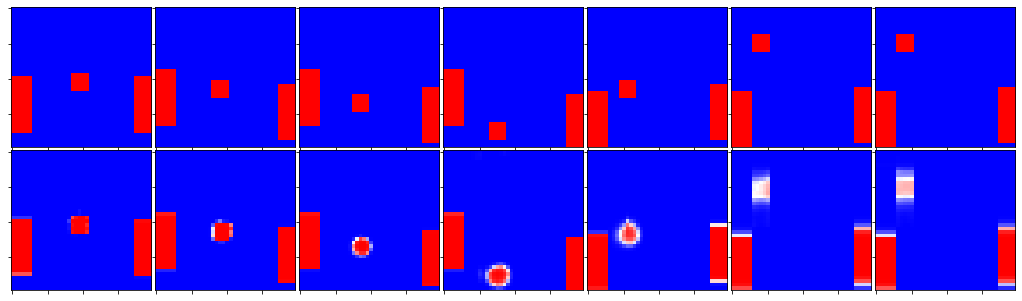

Epoch 422/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0350 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0307 - val_mean_squared_error: 0.0089 - val_acc: 0.9878


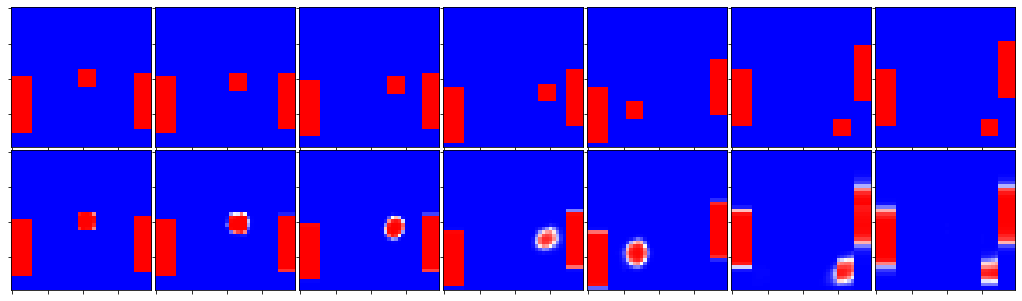

Epoch 423/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0383 - mean_squared_error: 0.0109 - acc: 0.9856 - val_loss: 0.0347 - val_mean_squared_error: 0.0102 - val_acc: 0.9859


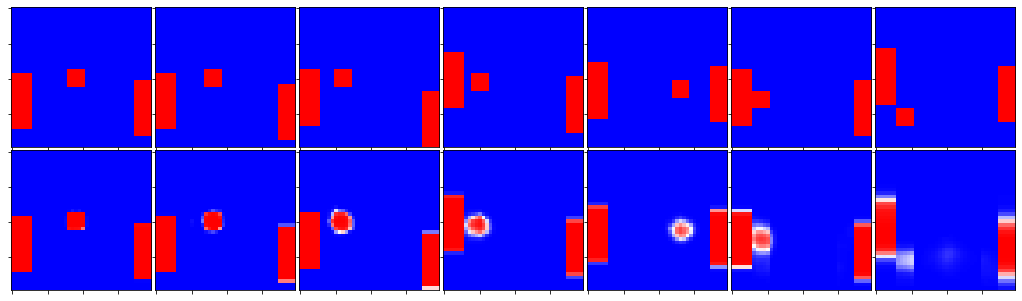

Epoch 424/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0372 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0389 - val_mean_squared_error: 0.0112 - val_acc: 0.9850


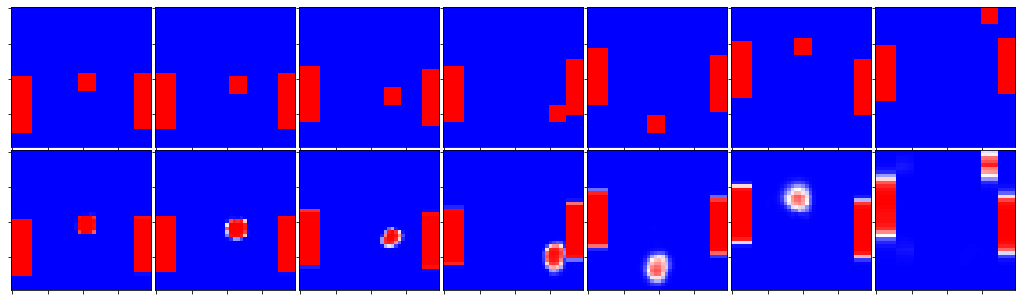

Epoch 425/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0349 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0379 - val_mean_squared_error: 0.0112 - val_acc: 0.9847


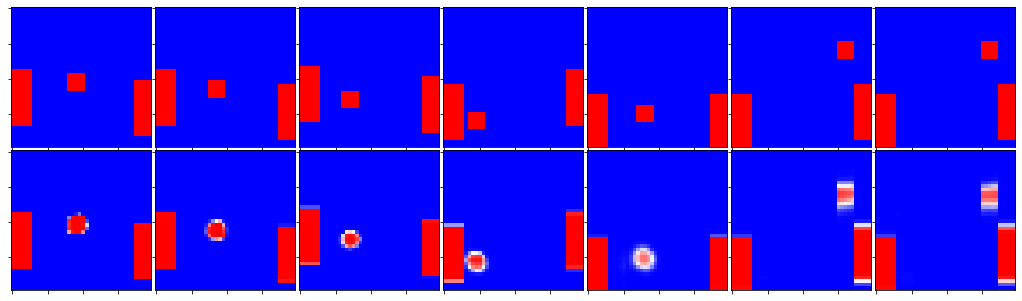

Epoch 426/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0392 - mean_squared_error: 0.0111 - acc: 0.9851 - val_loss: 0.0363 - val_mean_squared_error: 0.0099 - val_acc: 0.9868


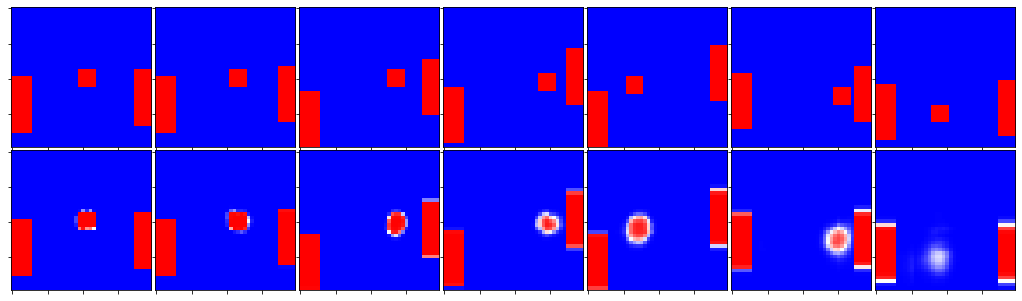

Epoch 427/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0362 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0399 - val_mean_squared_error: 0.0107 - val_acc: 0.9863


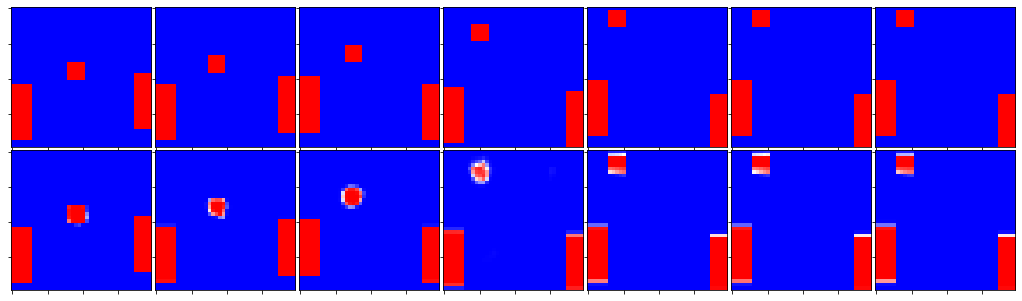

Epoch 428/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0356 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0322 - val_mean_squared_error: 0.0095 - val_acc: 0.9871


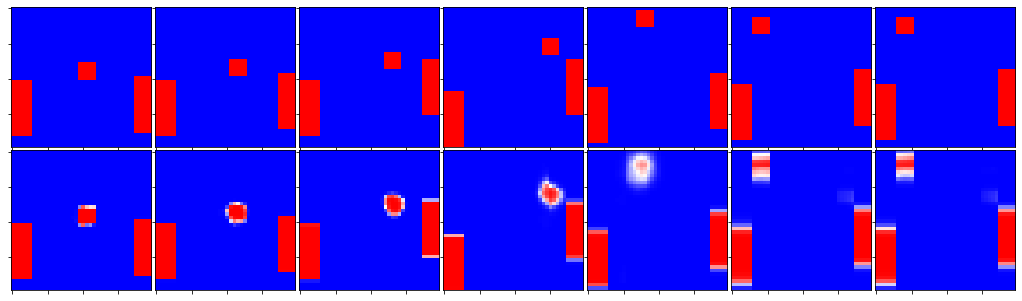

Epoch 429/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0363 - mean_squared_error: 0.0103 - acc: 0.9862 - val_loss: 0.0373 - val_mean_squared_error: 0.0111 - val_acc: 0.9848


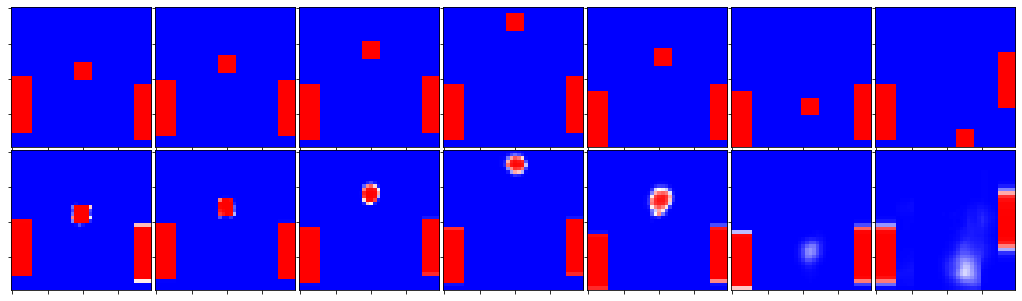

Epoch 430/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0374 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0320 - val_mean_squared_error: 0.0091 - val_acc: 0.9880


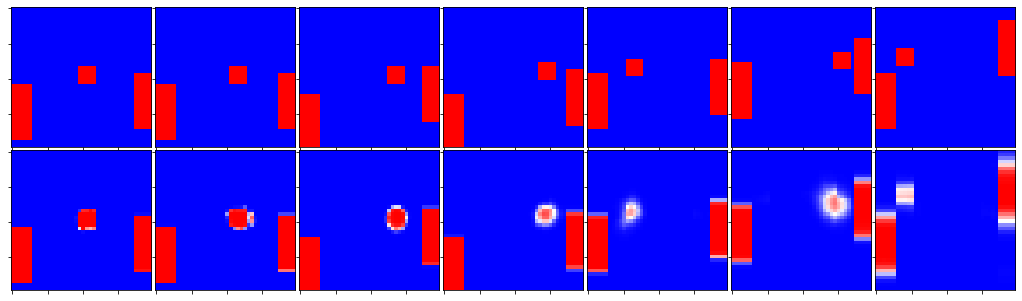

Epoch 431/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0376 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0371 - val_mean_squared_error: 0.0108 - val_acc: 0.9854


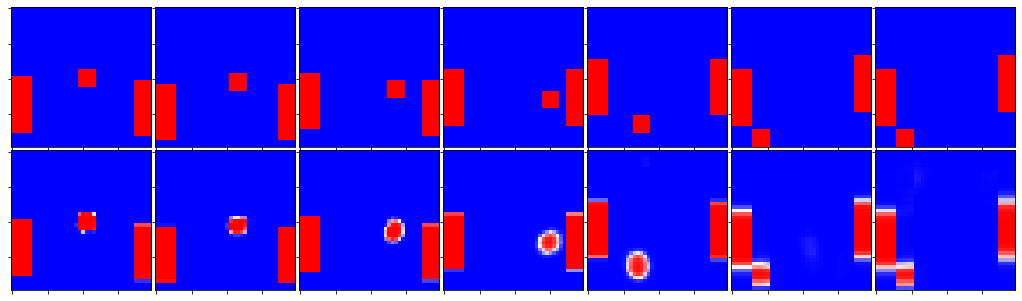

Epoch 432/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0356 - mean_squared_error: 0.0102 - acc: 0.9864 - val_loss: 0.0331 - val_mean_squared_error: 0.0097 - val_acc: 0.9869


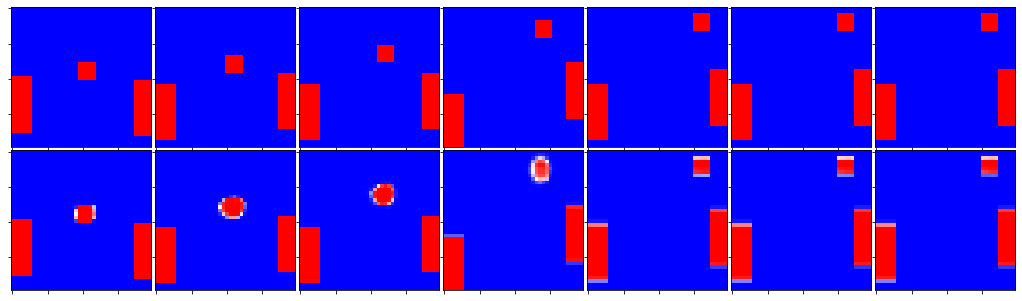

Epoch 433/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0359 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0347 - val_mean_squared_error: 0.0103 - val_acc: 0.9860


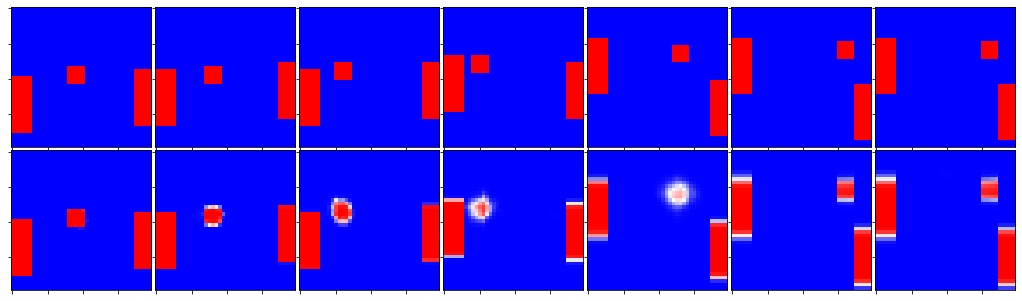

Epoch 434/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0346 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0411 - val_mean_squared_error: 0.0116 - val_acc: 0.9845


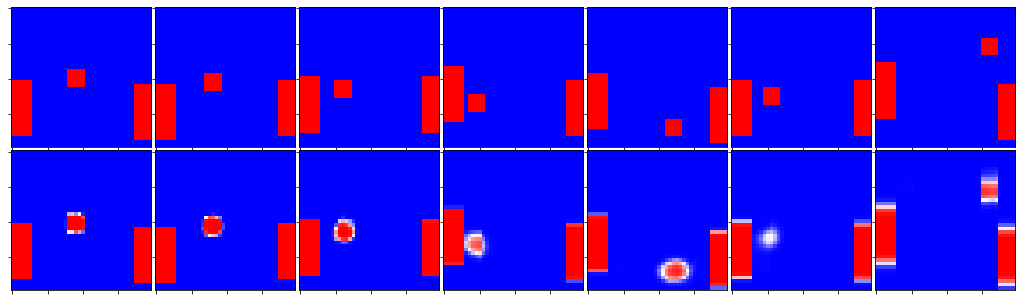

Epoch 435/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0347 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0322 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


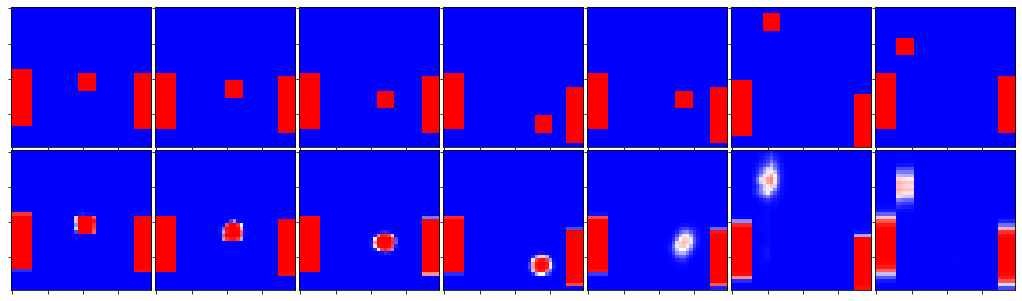

Epoch 436/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0345 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0340 - val_mean_squared_error: 0.0097 - val_acc: 0.9871


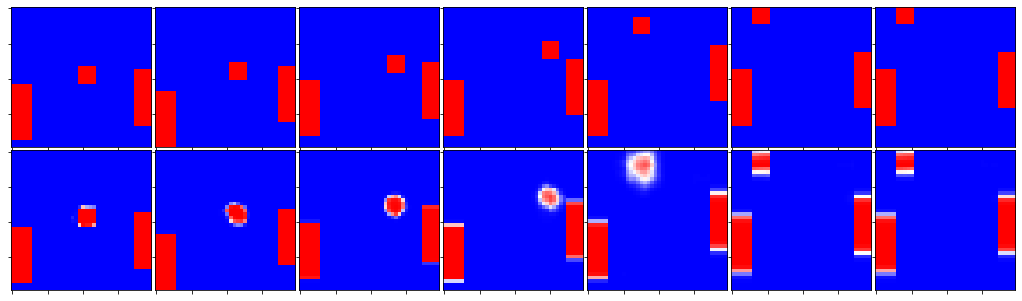

Epoch 437/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0359 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0335 - val_mean_squared_error: 0.0095 - val_acc: 0.9875


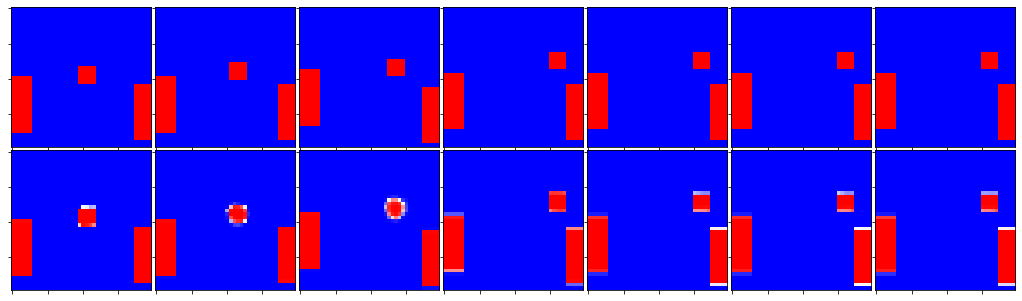

Epoch 438/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0350 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0400 - val_mean_squared_error: 0.0110 - val_acc: 0.9857


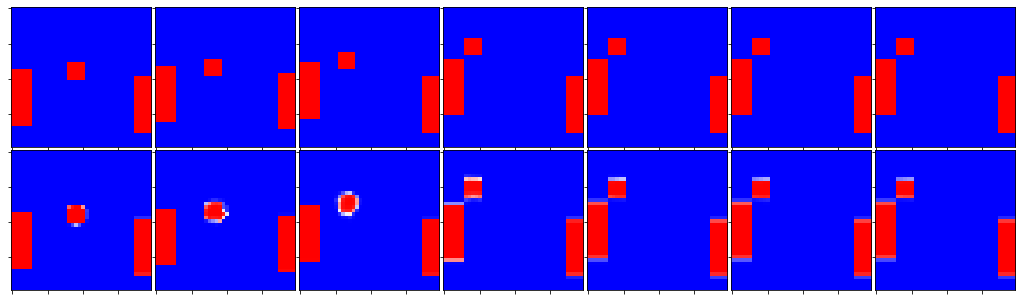

Epoch 439/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0356 - mean_squared_error: 0.0102 - acc: 0.9865 - val_loss: 0.0300 - val_mean_squared_error: 0.0086 - val_acc: 0.9882


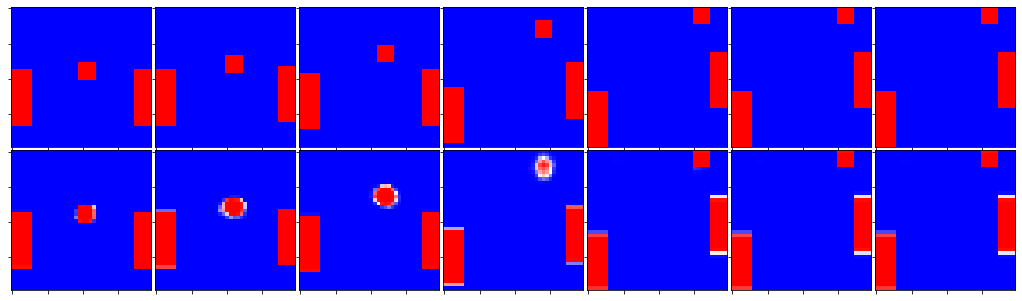

Epoch 440/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0350 - mean_squared_error: 0.0100 - acc: 0.9866 - val_loss: 0.0295 - val_mean_squared_error: 0.0086 - val_acc: 0.9884


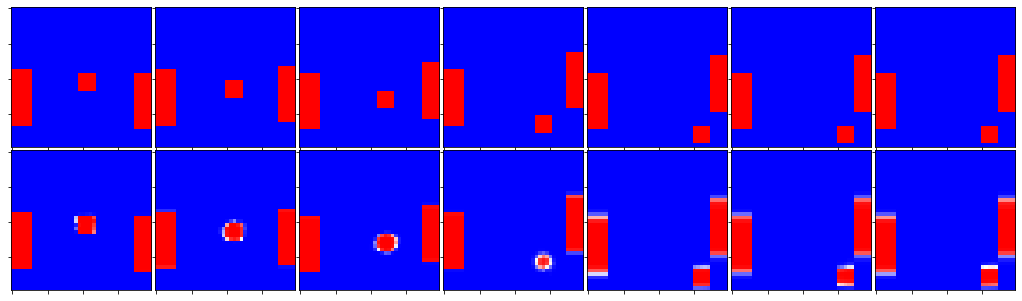

Epoch 441/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0348 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0450 - val_mean_squared_error: 0.0115 - val_acc: 0.9851


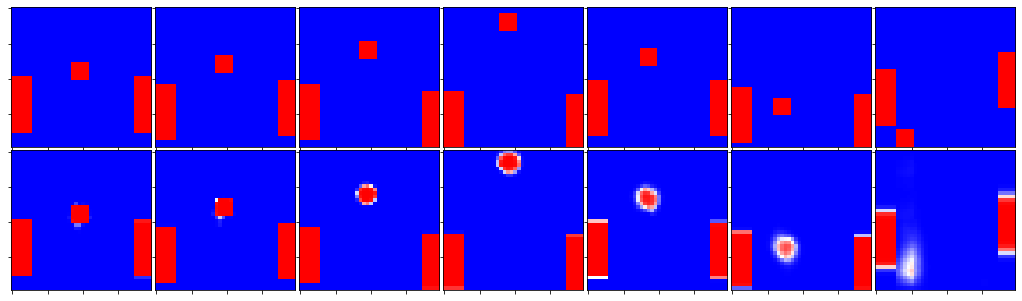

Epoch 442/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0344 - mean_squared_error: 0.0098 - acc: 0.9869 - val_loss: 0.0335 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


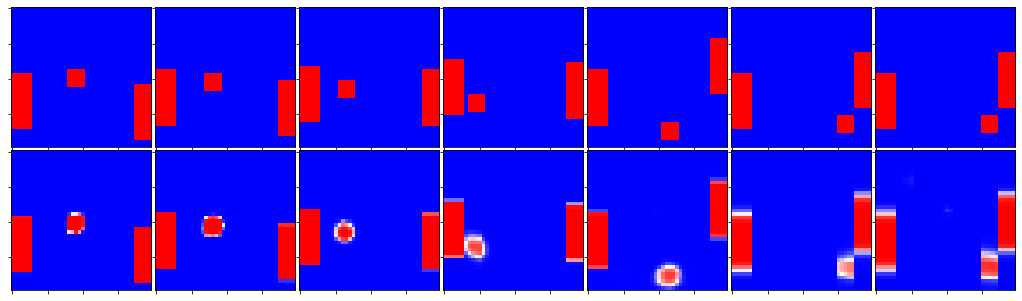

Epoch 443/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0360 - mean_squared_error: 0.0103 - acc: 0.9862 - val_loss: 0.0357 - val_mean_squared_error: 0.0099 - val_acc: 0.9868


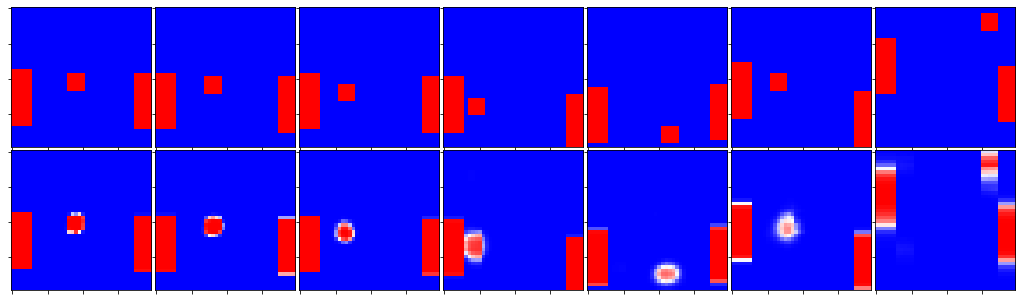

Epoch 444/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0367 - mean_squared_error: 0.0105 - acc: 0.9861 - val_loss: 0.0258 - val_mean_squared_error: 0.0074 - val_acc: 0.9902


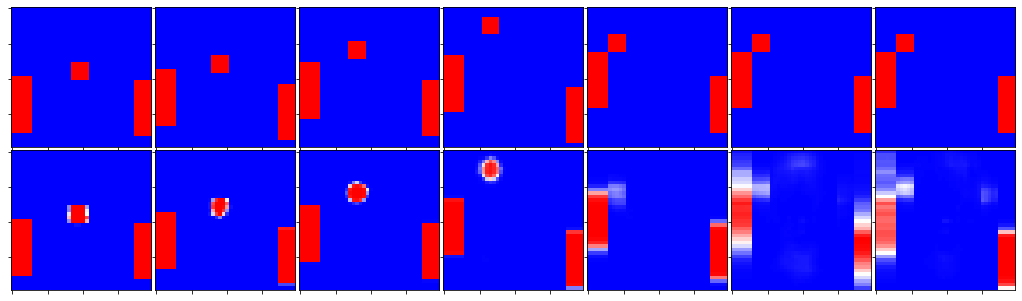

Epoch 445/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0341 - mean_squared_error: 0.0098 - acc: 0.9870 - val_loss: 0.0374 - val_mean_squared_error: 0.0110 - val_acc: 0.9852


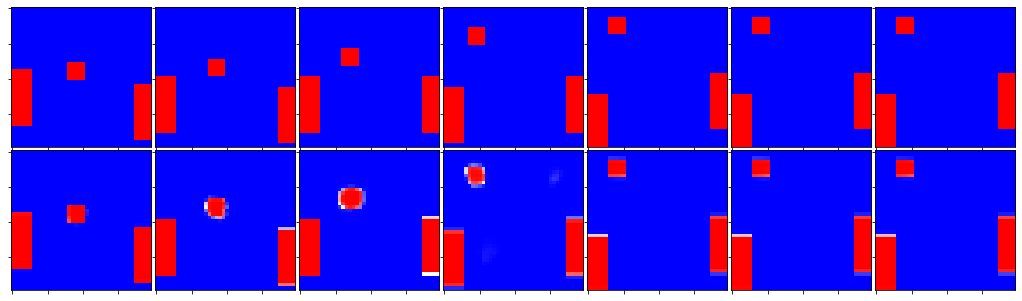

Epoch 446/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0345 - val_mean_squared_error: 0.0101 - val_acc: 0.9864


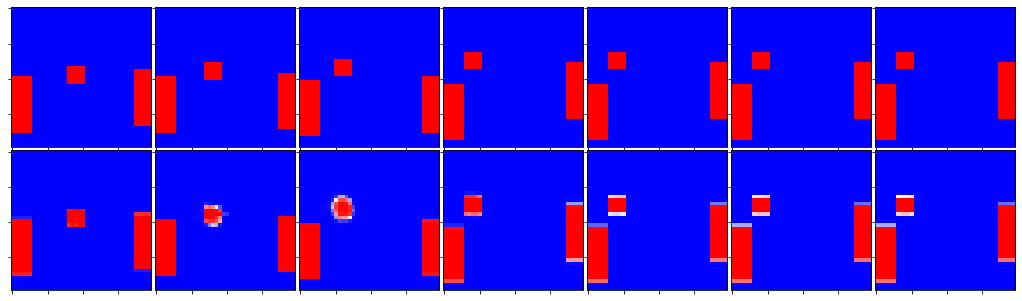

Epoch 447/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0361 - mean_squared_error: 0.0103 - acc: 0.9863 - val_loss: 0.0369 - val_mean_squared_error: 0.0104 - val_acc: 0.9861


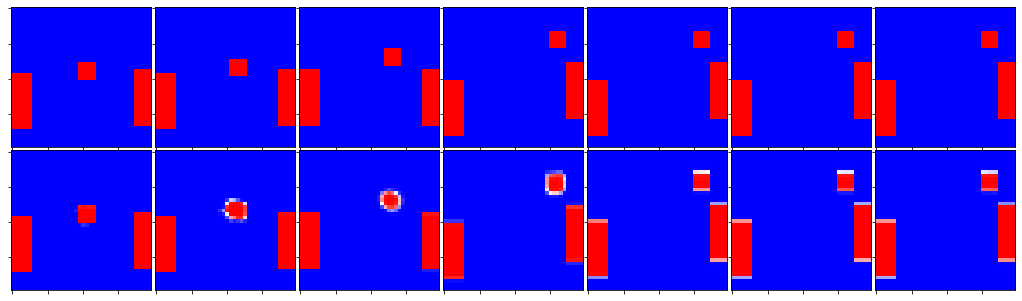

Epoch 448/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0365 - mean_squared_error: 0.0104 - acc: 0.9861 - val_loss: 0.0338 - val_mean_squared_error: 0.0099 - val_acc: 0.9868


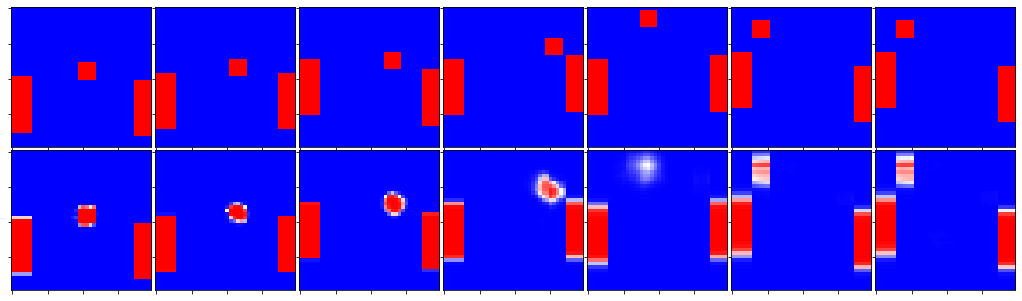

Epoch 449/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0357 - mean_squared_error: 0.0102 - acc: 0.9864 - val_loss: 0.0376 - val_mean_squared_error: 0.0107 - val_acc: 0.9858


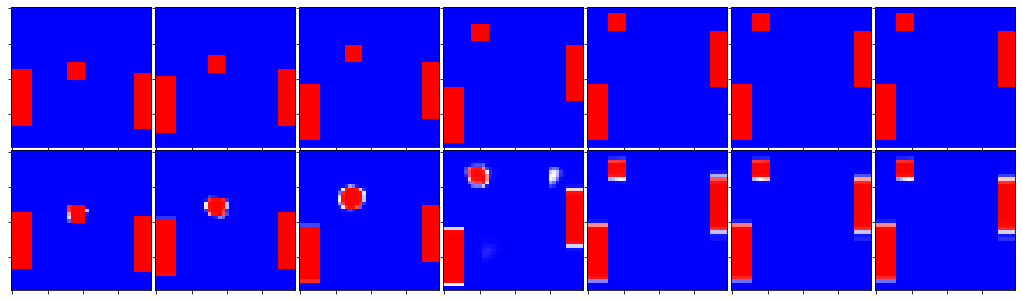

Epoch 450/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0378 - val_mean_squared_error: 0.0106 - val_acc: 0.9862


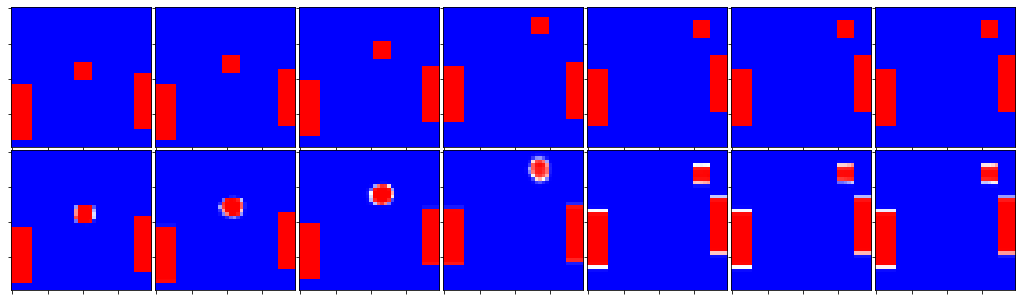

Epoch 451/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0338 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0326 - val_mean_squared_error: 0.0094 - val_acc: 0.9874


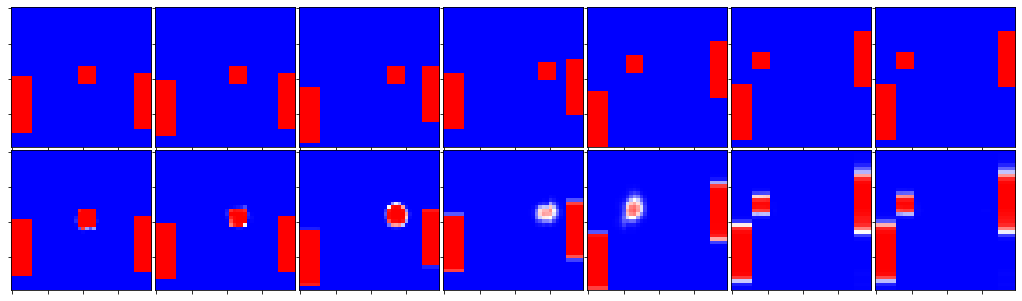

Epoch 452/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0349 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0318 - val_mean_squared_error: 0.0093 - val_acc: 0.9874


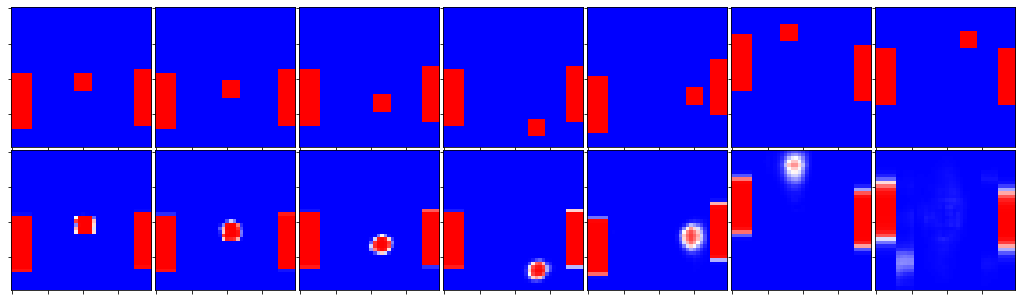

Epoch 453/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0347 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0540 - val_mean_squared_error: 0.0141 - val_acc: 0.9816


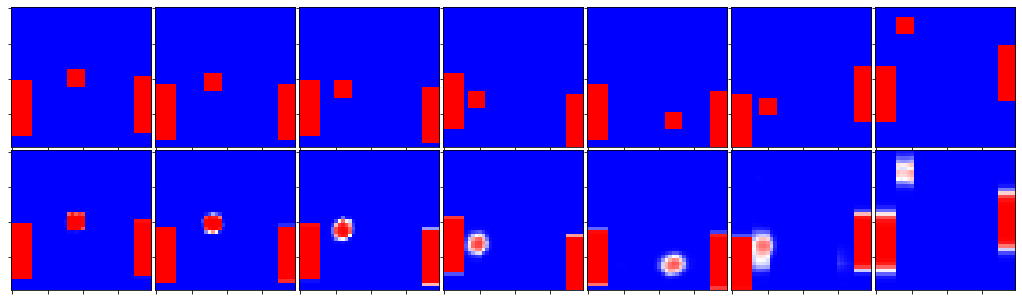

Epoch 454/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0350 - mean_squared_error: 0.0101 - acc: 0.9865 - val_loss: 0.0353 - val_mean_squared_error: 0.0098 - val_acc: 0.9872


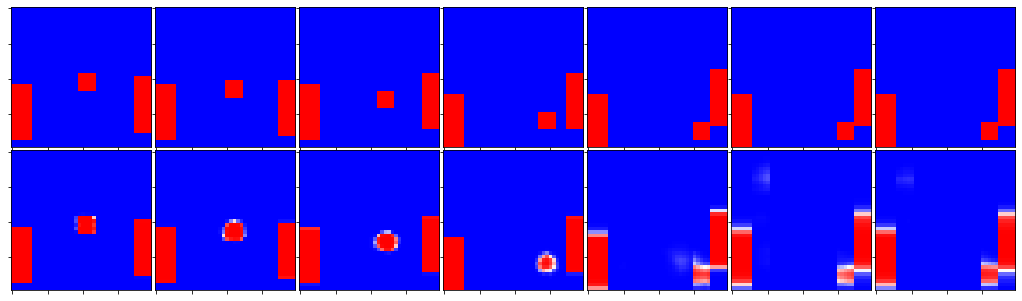

Epoch 455/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0365 - val_mean_squared_error: 0.0098 - val_acc: 0.9868


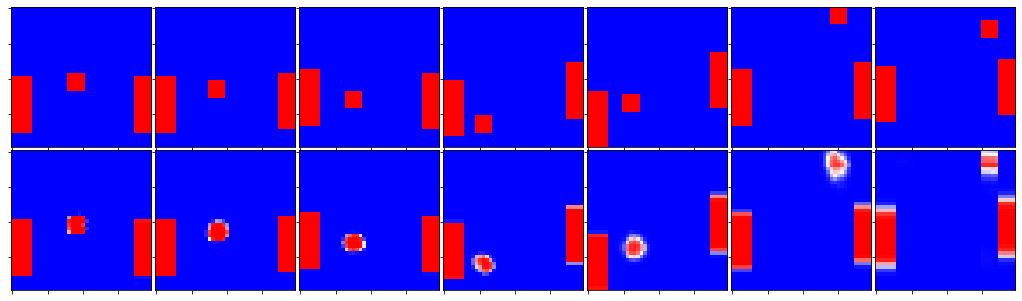

Epoch 456/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0330 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0383 - val_mean_squared_error: 0.0110 - val_acc: 0.9853


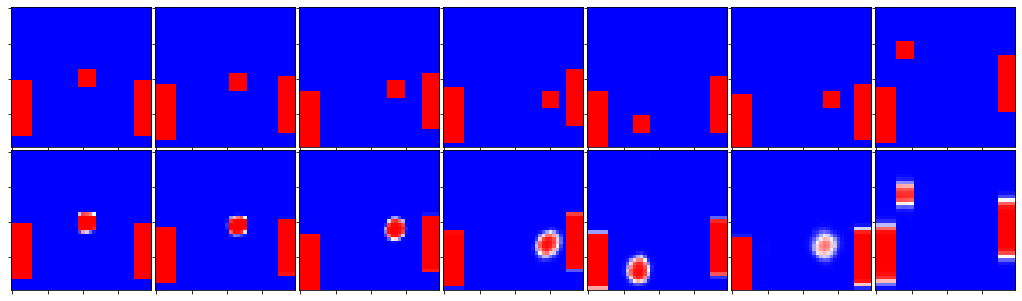

Epoch 457/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0358 - mean_squared_error: 0.0102 - acc: 0.9863 - val_loss: 0.0331 - val_mean_squared_error: 0.0096 - val_acc: 0.9873


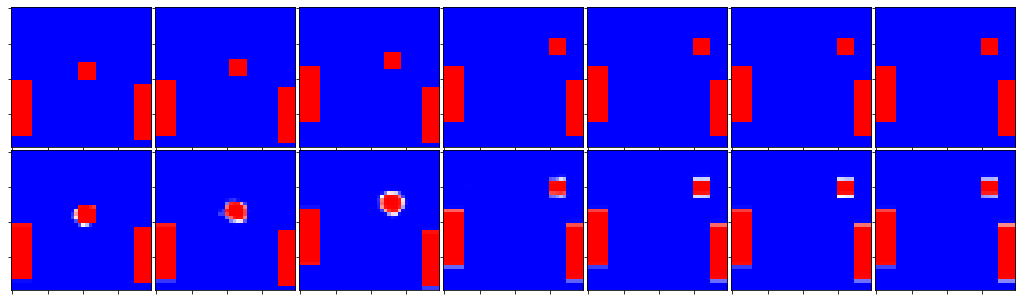

Epoch 458/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0350 - mean_squared_error: 0.0100 - acc: 0.9866 - val_loss: 0.0320 - val_mean_squared_error: 0.0094 - val_acc: 0.9872


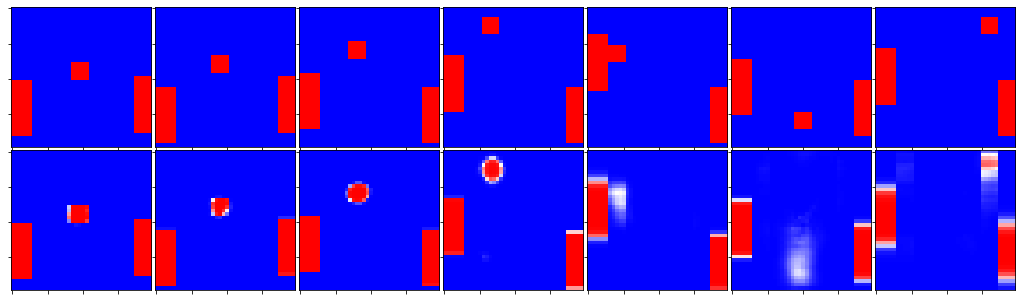

Epoch 459/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0366 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0352 - val_mean_squared_error: 0.0102 - val_acc: 0.9864


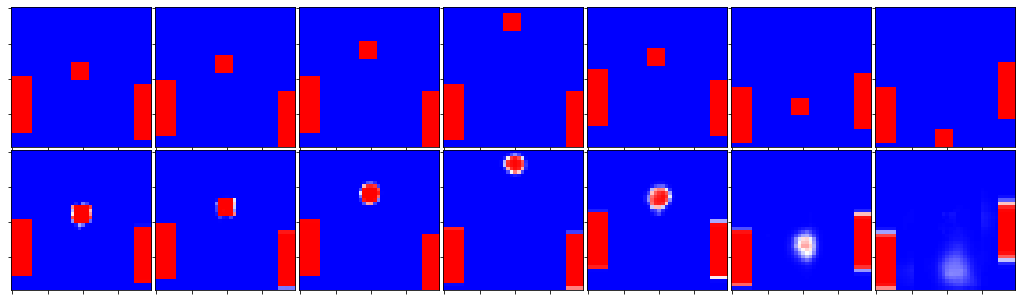

Epoch 460/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0332 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0313 - val_mean_squared_error: 0.0092 - val_acc: 0.9876


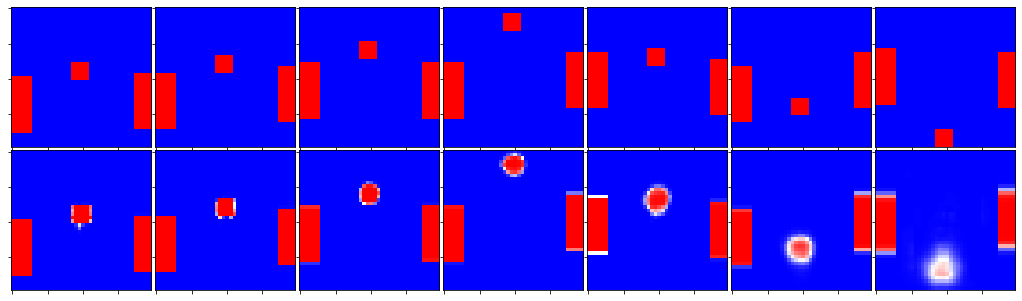

Epoch 461/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0354 - mean_squared_error: 0.0101 - acc: 0.9865 - val_loss: 0.0344 - val_mean_squared_error: 0.0100 - val_acc: 0.9865


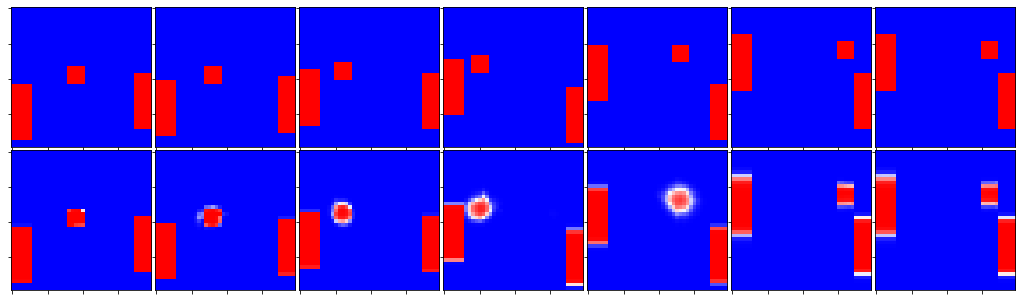

Epoch 462/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0335 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0325 - val_mean_squared_error: 0.0094 - val_acc: 0.9875


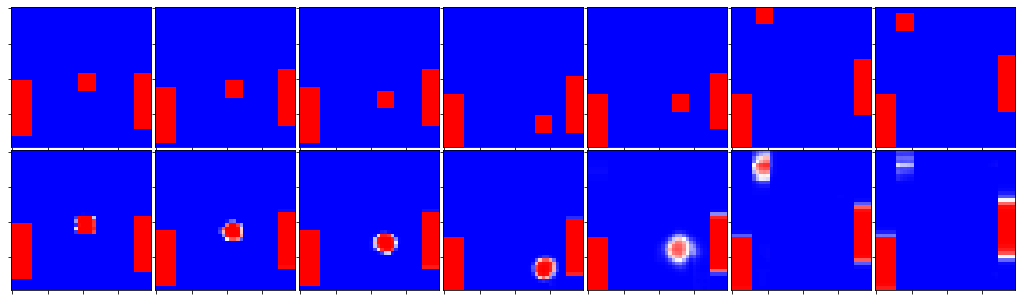

Epoch 463/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0338 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0325 - val_mean_squared_error: 0.0094 - val_acc: 0.9876


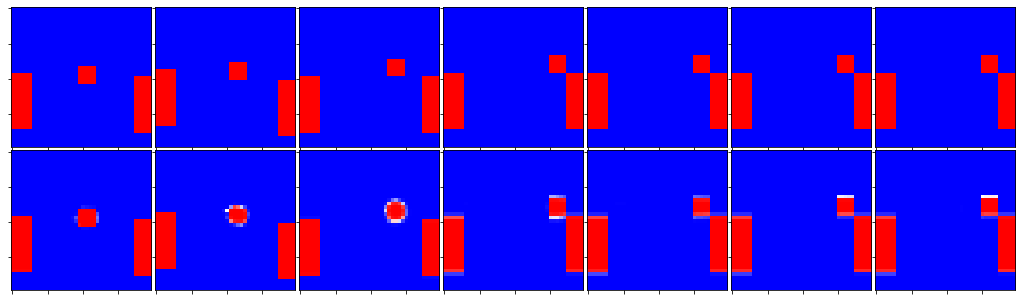

Epoch 464/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0321 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0348 - val_mean_squared_error: 0.0099 - val_acc: 0.9868


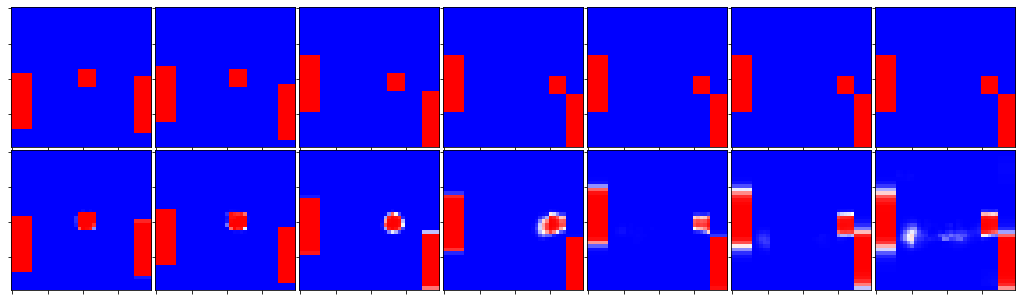

Epoch 465/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0352 - mean_squared_error: 0.0101 - acc: 0.9865 - val_loss: 0.0387 - val_mean_squared_error: 0.0114 - val_acc: 0.9845


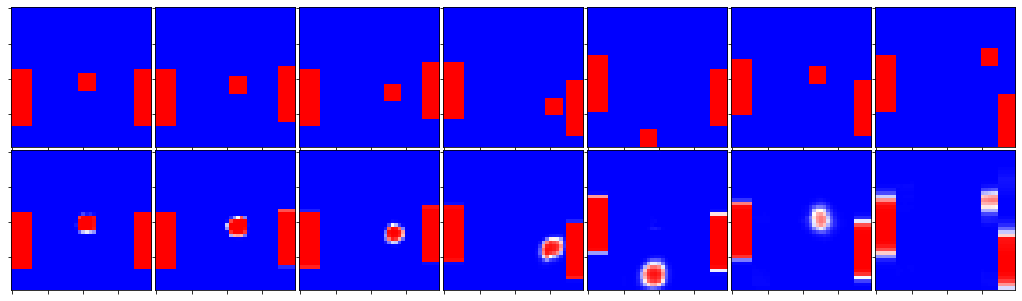

Epoch 466/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0350 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0439 - val_mean_squared_error: 0.0114 - val_acc: 0.9851


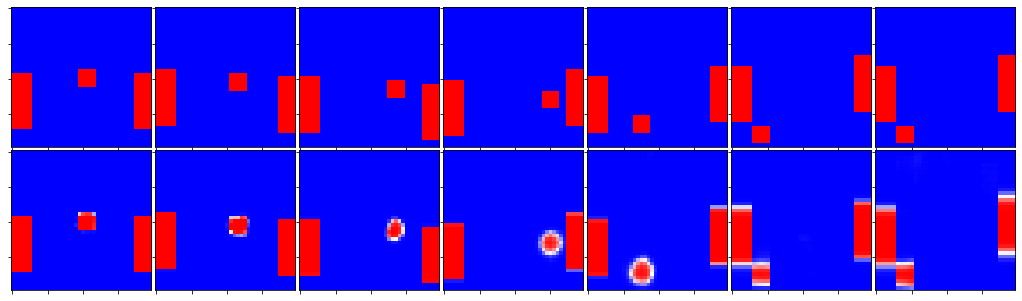

Epoch 467/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0352 - mean_squared_error: 0.0100 - acc: 0.9866 - val_loss: 0.0388 - val_mean_squared_error: 0.0110 - val_acc: 0.9855


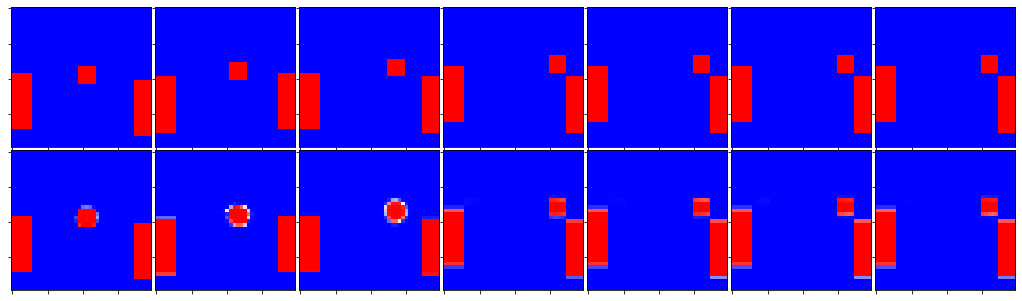

Epoch 468/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0393 - mean_squared_error: 0.0110 - acc: 0.9853 - val_loss: 0.0376 - val_mean_squared_error: 0.0109 - val_acc: 0.9854


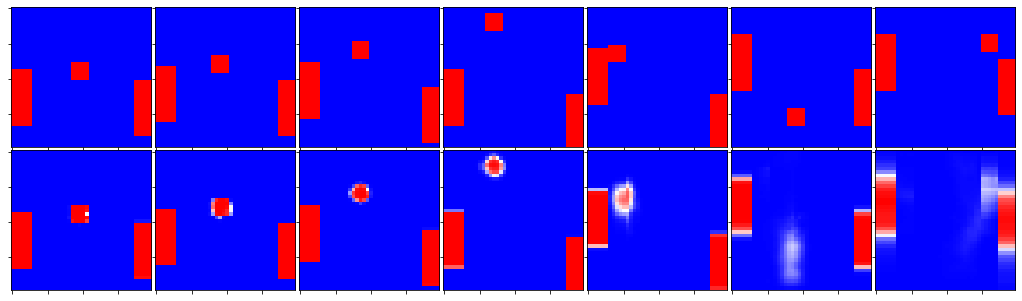

Epoch 469/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0340 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0315 - val_mean_squared_error: 0.0089 - val_acc: 0.9882


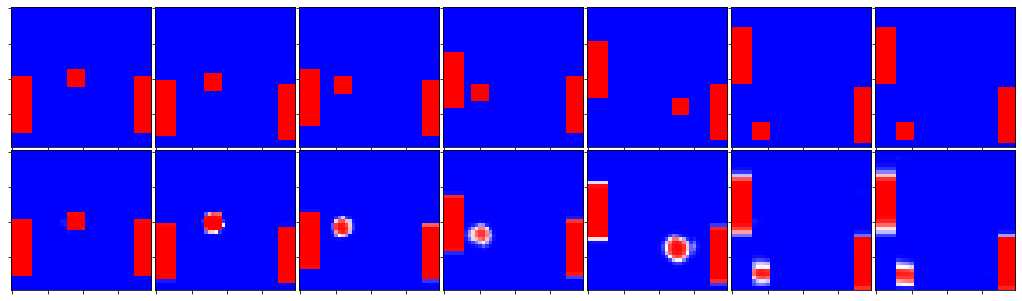

Epoch 470/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0339 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0372 - val_mean_squared_error: 0.0107 - val_acc: 0.9856


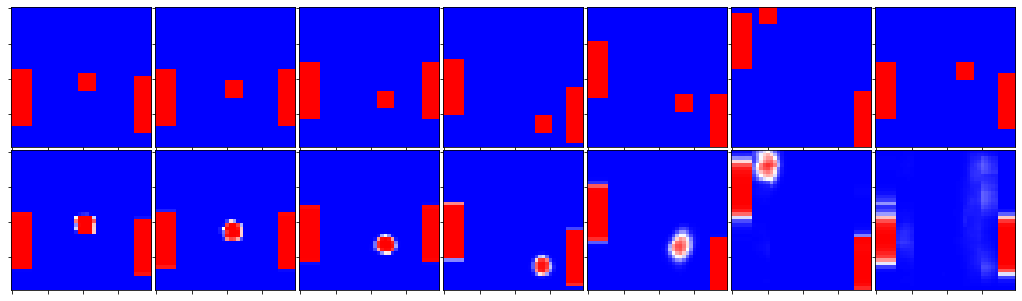

Epoch 471/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0340 - mean_squared_error: 0.0098 - acc: 0.9870 - val_loss: 0.0380 - val_mean_squared_error: 0.0103 - val_acc: 0.9864


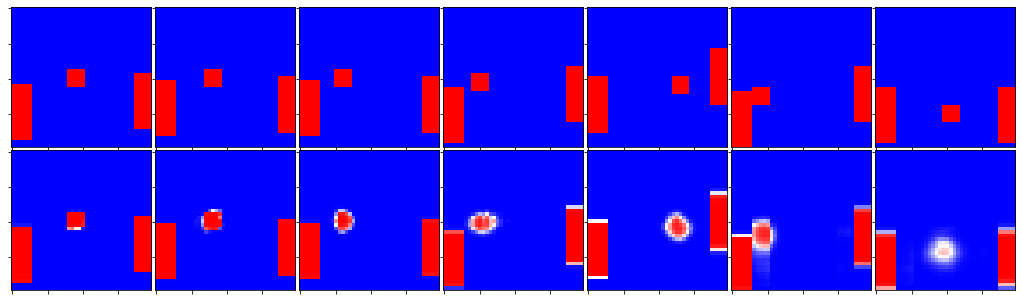

Epoch 472/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0342 - mean_squared_error: 0.0098 - acc: 0.9870 - val_loss: 0.0369 - val_mean_squared_error: 0.0108 - val_acc: 0.9854


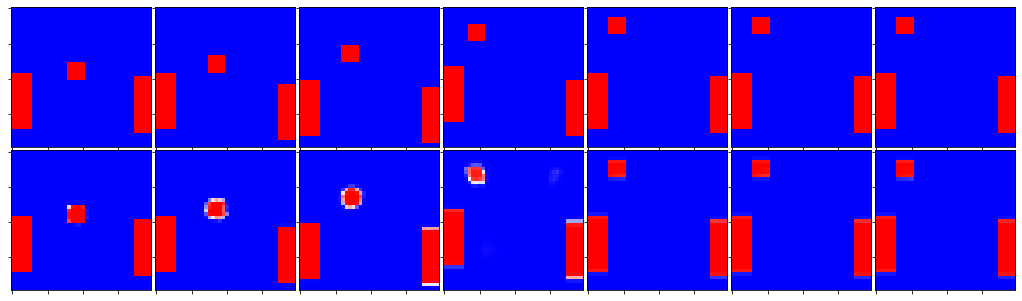

Epoch 473/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0332 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0413 - val_mean_squared_error: 0.0115 - val_acc: 0.9848


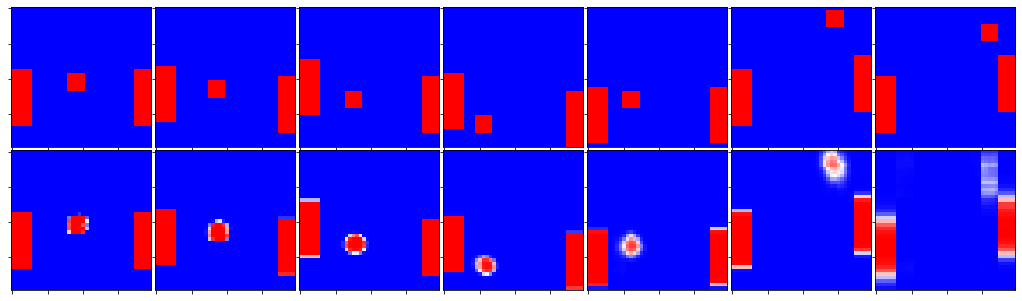

Epoch 474/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0358 - val_mean_squared_error: 0.0098 - val_acc: 0.9873


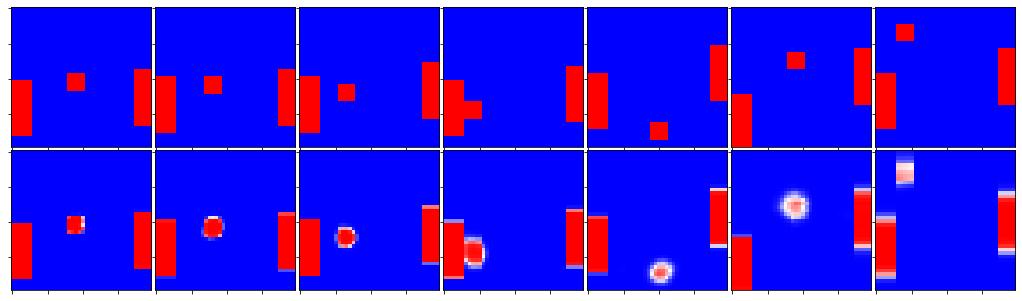

Epoch 475/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0339 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0375 - val_mean_squared_error: 0.0109 - val_acc: 0.9851


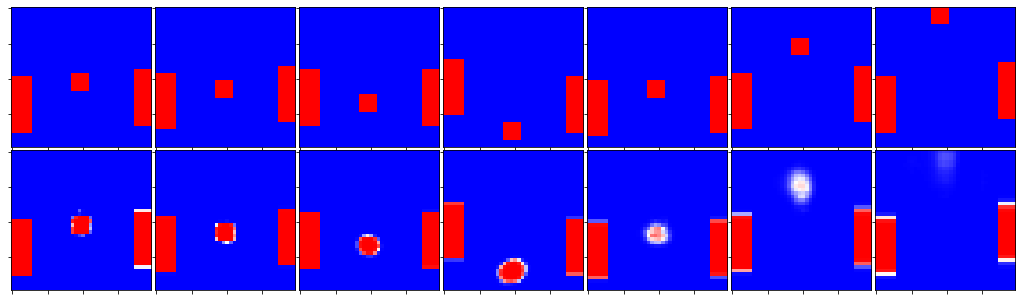

Epoch 476/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.0339 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0346 - val_mean_squared_error: 0.0098 - val_acc: 0.9870


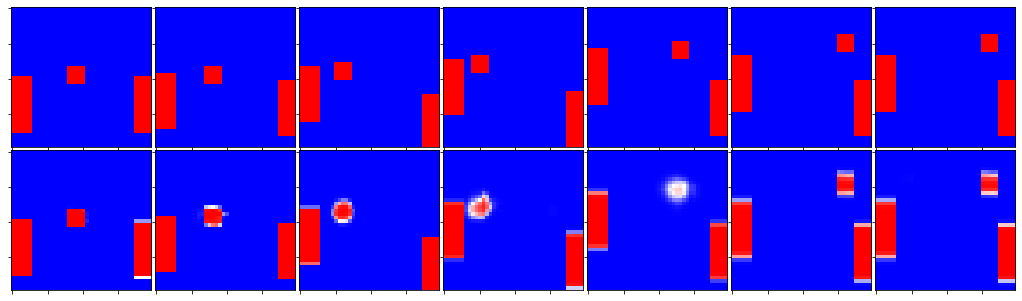

Epoch 477/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0325 - mean_squared_error: 0.0093 - acc: 0.9877 - val_loss: 0.0356 - val_mean_squared_error: 0.0101 - val_acc: 0.9863


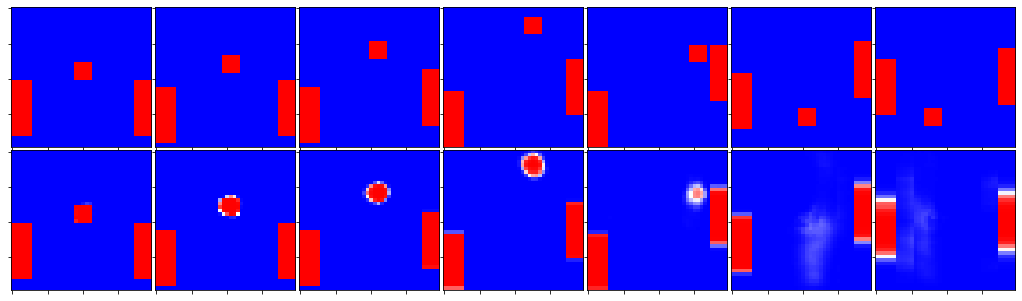

Epoch 478/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0338 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0340 - val_mean_squared_error: 0.0096 - val_acc: 0.9875


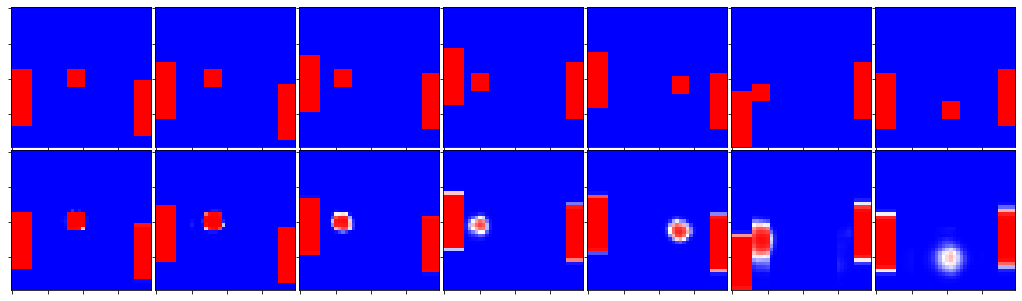

Epoch 479/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0315 - val_mean_squared_error: 0.0089 - val_acc: 0.9883


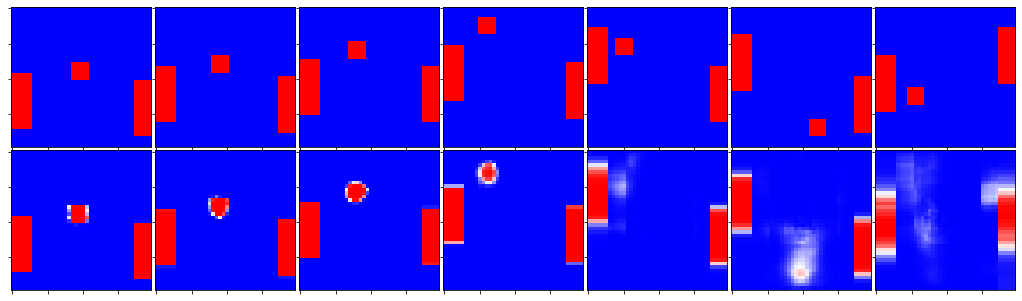

Epoch 480/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0327 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0311 - val_mean_squared_error: 0.0092 - val_acc: 0.9875


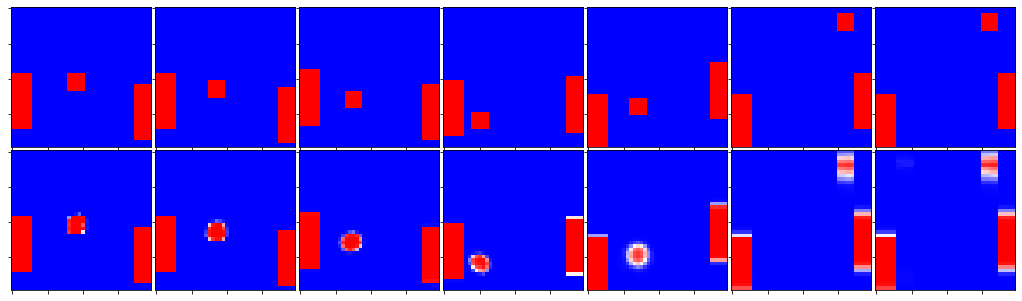

Epoch 481/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0370 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0390 - val_mean_squared_error: 0.0109 - val_acc: 0.9855


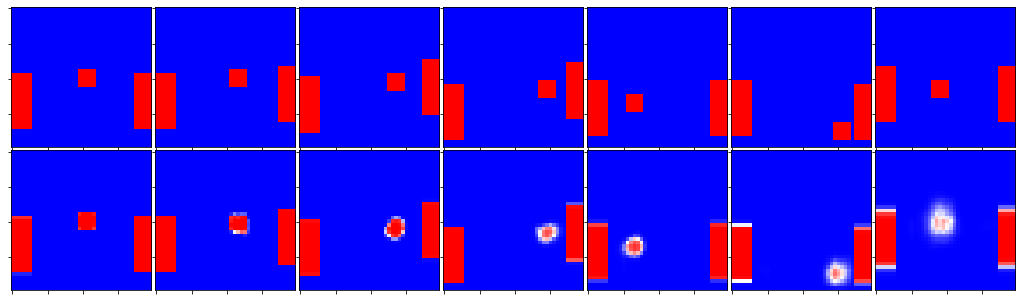

Epoch 482/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0332 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0319 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


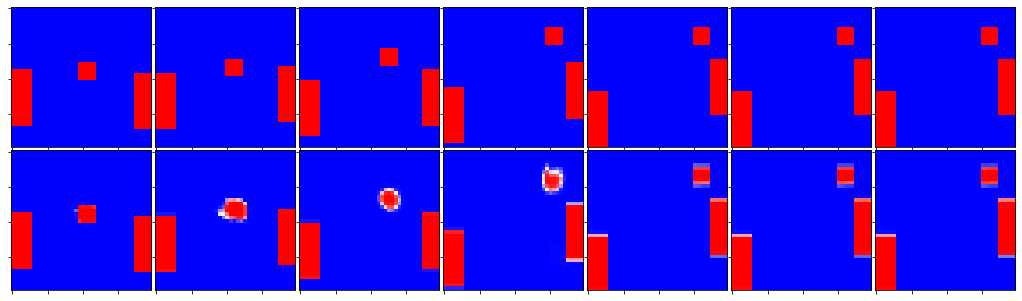

Epoch 483/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0398 - mean_squared_error: 0.0109 - acc: 0.9855 - val_loss: 0.0319 - val_mean_squared_error: 0.0092 - val_acc: 0.9880


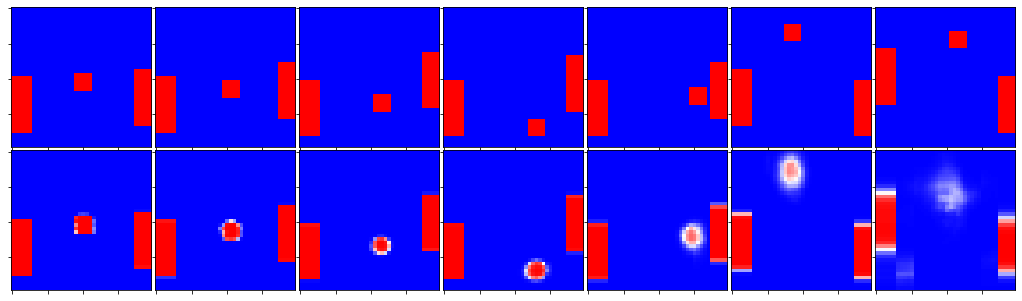

Epoch 484/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0318 - val_mean_squared_error: 0.0091 - val_acc: 0.9878


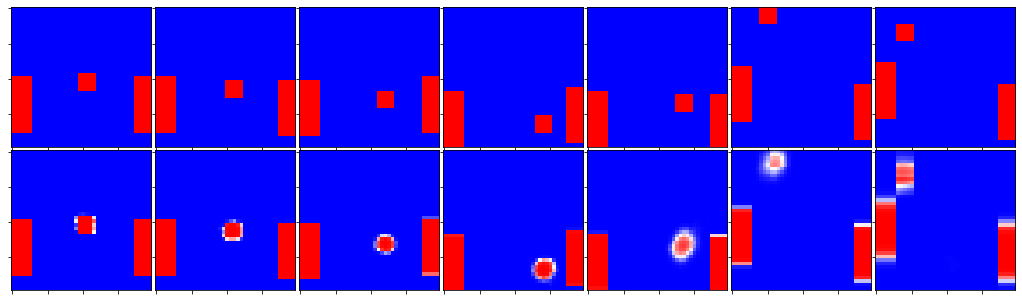

Epoch 485/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0351 - mean_squared_error: 0.0099 - acc: 0.9867 - val_loss: 0.0315 - val_mean_squared_error: 0.0092 - val_acc: 0.9876


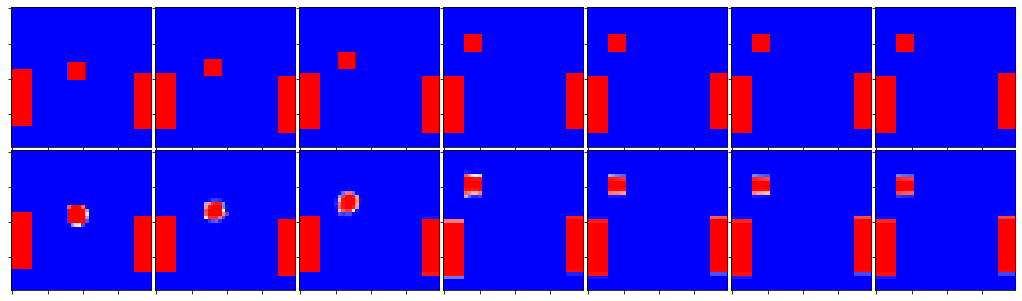

Epoch 486/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0342 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0305 - val_mean_squared_error: 0.0089 - val_acc: 0.9881


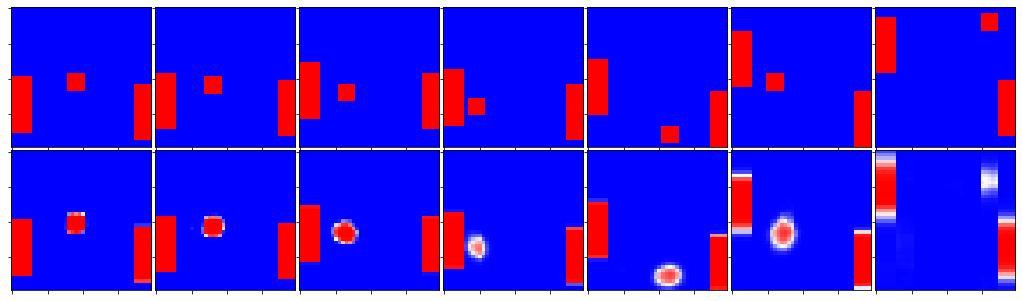

Epoch 487/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0354 - mean_squared_error: 0.0101 - acc: 0.9866 - val_loss: 0.0340 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


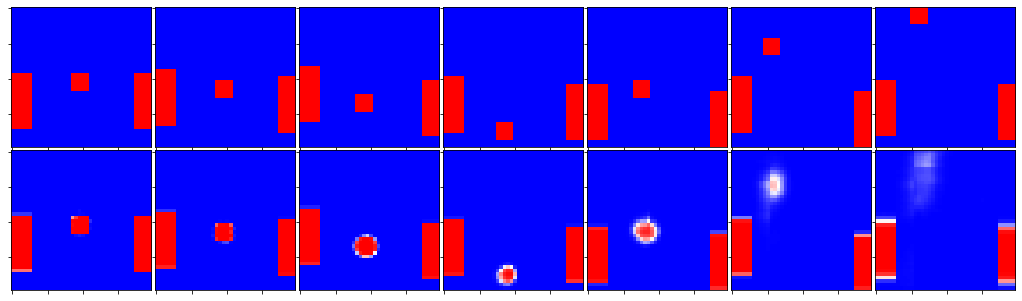

Epoch 488/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0341 - mean_squared_error: 0.0098 - acc: 0.9870 - val_loss: 0.0327 - val_mean_squared_error: 0.0093 - val_acc: 0.9874


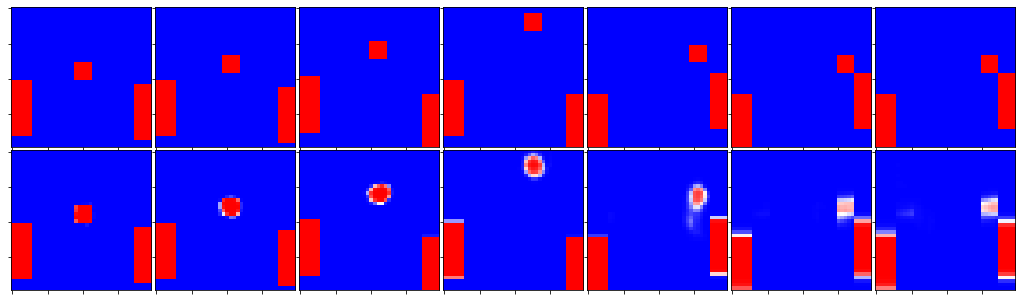

Epoch 489/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0336 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0327 - val_mean_squared_error: 0.0095 - val_acc: 0.9872


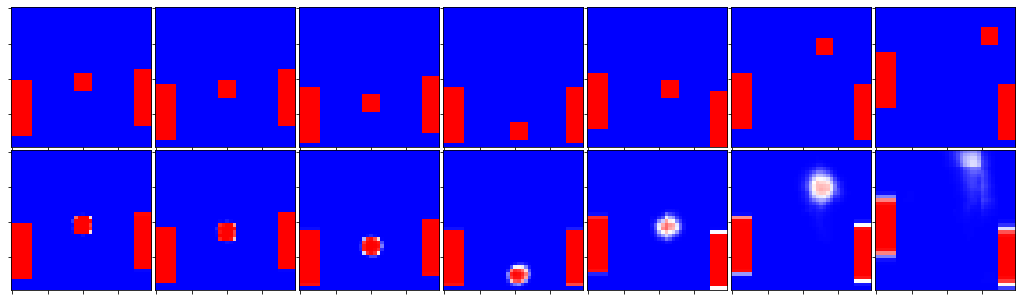

Epoch 490/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0342 - mean_squared_error: 0.0097 - acc: 0.9871 - val_loss: 0.0292 - val_mean_squared_error: 0.0083 - val_acc: 0.9888


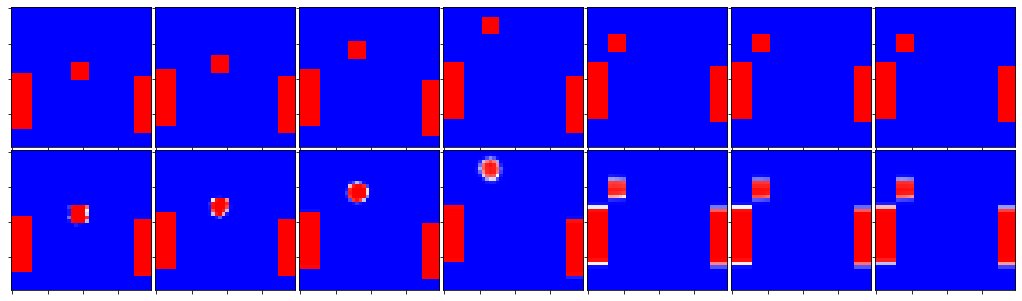

Epoch 491/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0326 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0304 - val_mean_squared_error: 0.0089 - val_acc: 0.9881


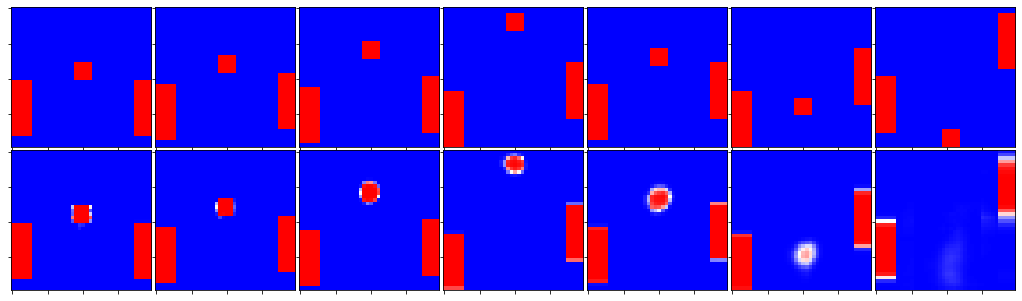

Epoch 492/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0351 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0328 - val_mean_squared_error: 0.0095 - val_acc: 0.9875


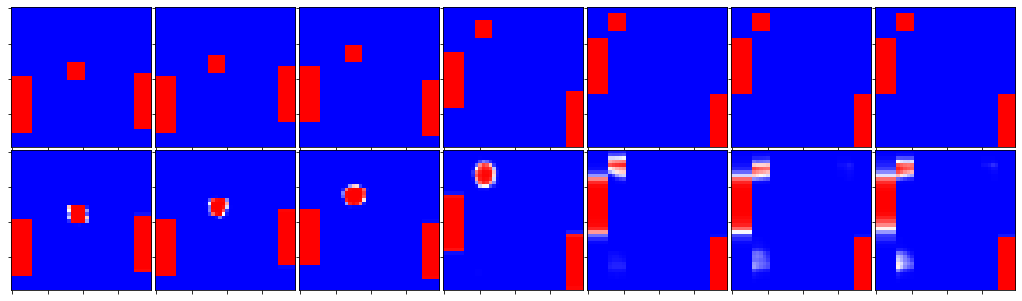

Epoch 493/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0348 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0342 - val_mean_squared_error: 0.0101 - val_acc: 0.9861


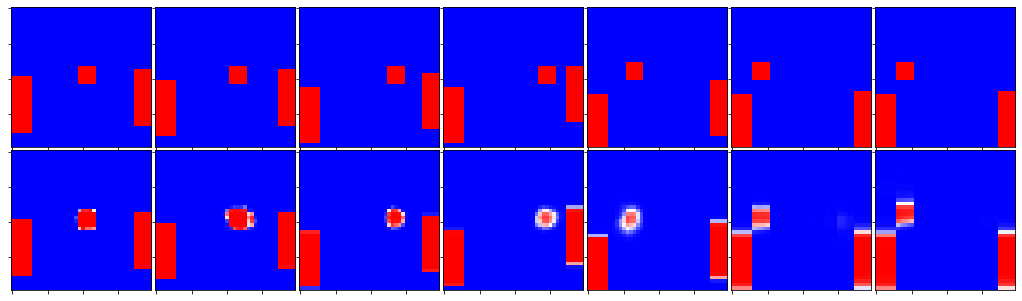

Epoch 494/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0355 - val_mean_squared_error: 0.0096 - val_acc: 0.9876


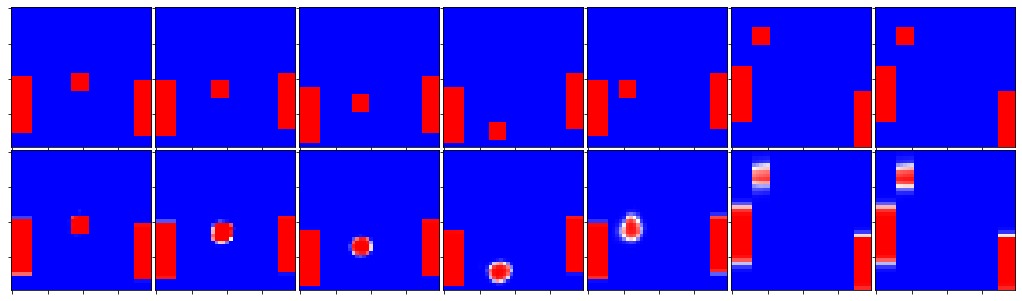

Epoch 495/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0339 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0364 - val_mean_squared_error: 0.0102 - val_acc: 0.9865


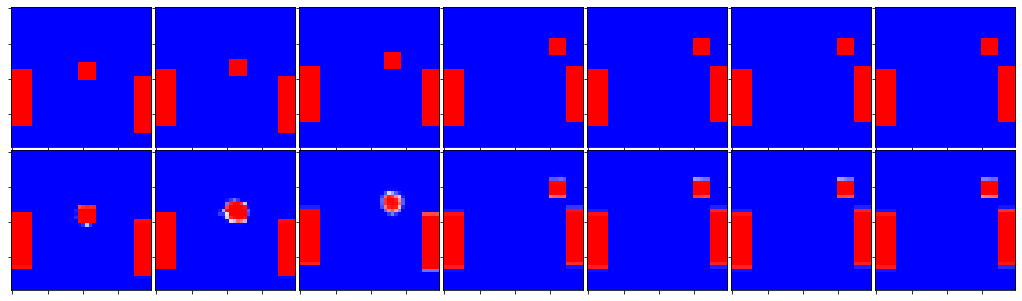

Epoch 496/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0336 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0379 - val_mean_squared_error: 0.0107 - val_acc: 0.9859


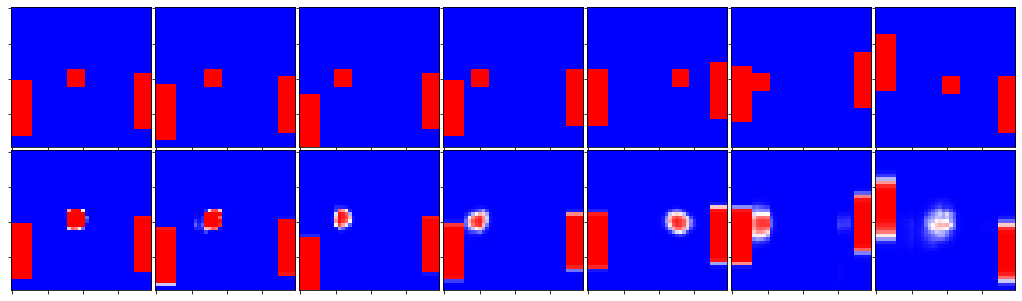

Epoch 497/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0331 - val_mean_squared_error: 0.0096 - val_acc: 0.9871


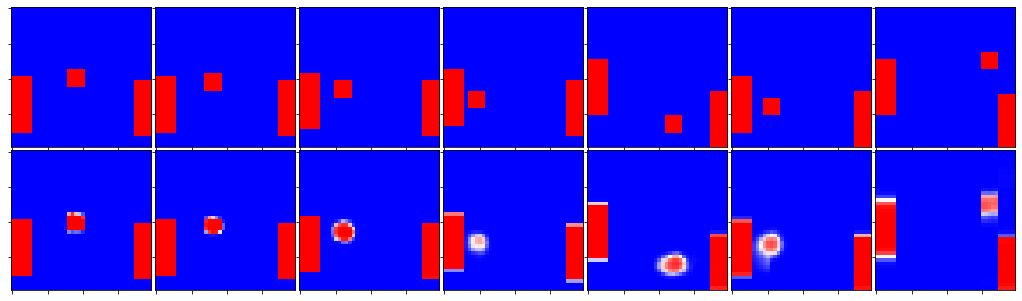

Epoch 498/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0336 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0346 - val_mean_squared_error: 0.0099 - val_acc: 0.9867


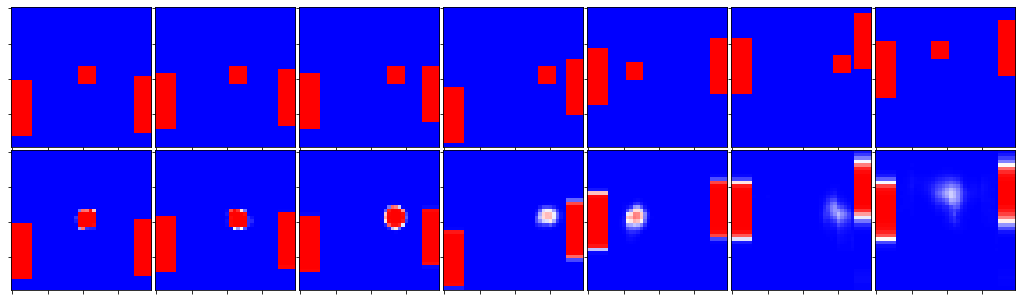

Epoch 499/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0345 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0303 - val_mean_squared_error: 0.0087 - val_acc: 0.9881


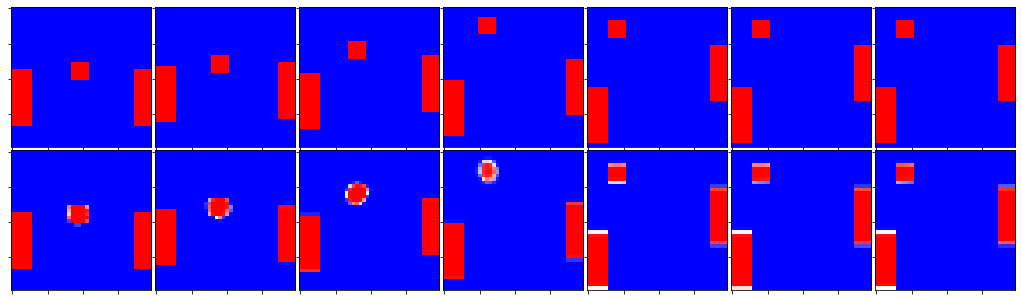

Epoch 500/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0381 - mean_squared_error: 0.0108 - acc: 0.9854 - val_loss: 0.0376 - val_mean_squared_error: 0.0110 - val_acc: 0.9852


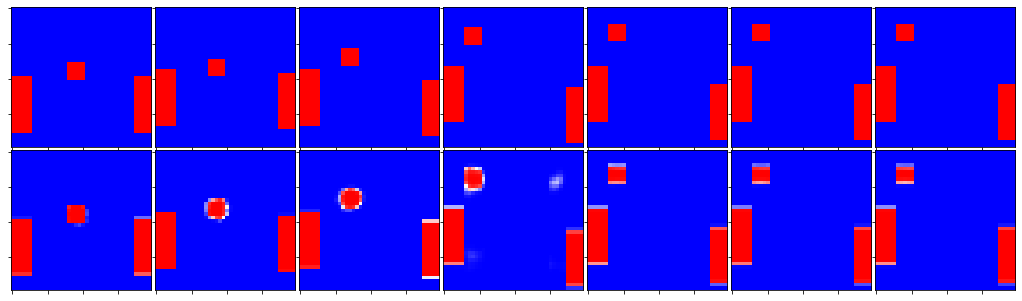

Epoch 501/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0337 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0311 - val_mean_squared_error: 0.0089 - val_acc: 0.9880


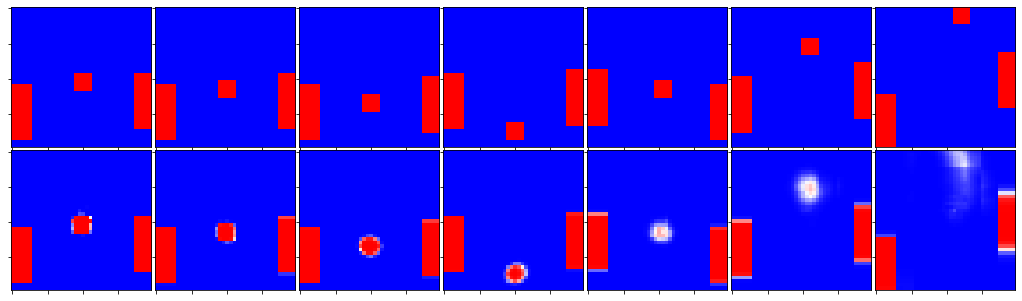

Epoch 502/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0329 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0328 - val_mean_squared_error: 0.0093 - val_acc: 0.9873


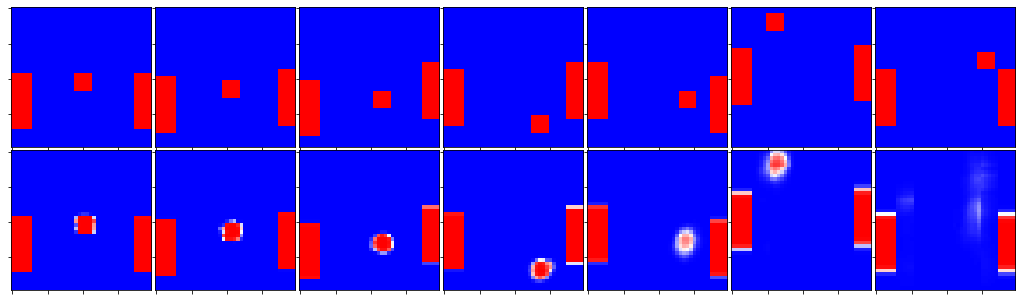

Epoch 503/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0361 - val_mean_squared_error: 0.0106 - val_acc: 0.9857


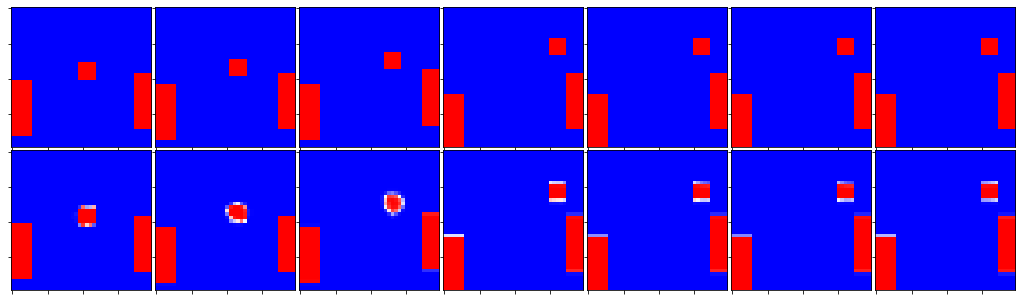

Epoch 504/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0338 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0307 - val_mean_squared_error: 0.0088 - val_acc: 0.9882


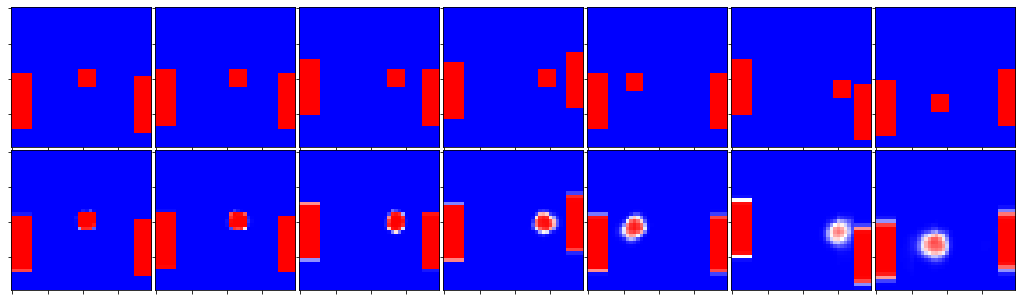

Epoch 505/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0340 - mean_squared_error: 0.0096 - acc: 0.9873 - val_loss: 0.0451 - val_mean_squared_error: 0.0126 - val_acc: 0.9836


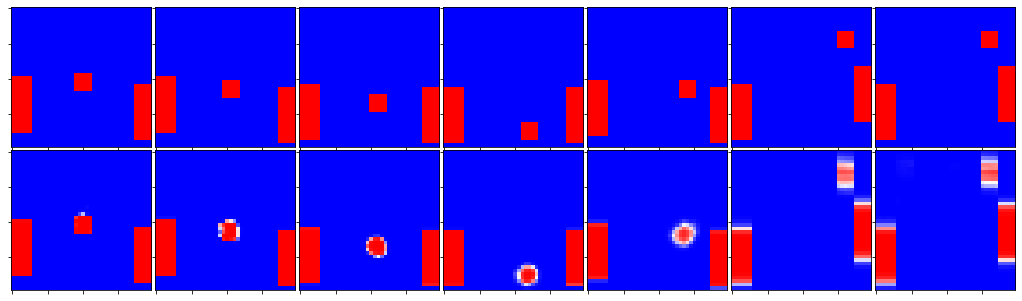

Epoch 506/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0321 - mean_squared_error: 0.0092 - acc: 0.9878 - val_loss: 0.0263 - val_mean_squared_error: 0.0077 - val_acc: 0.9894


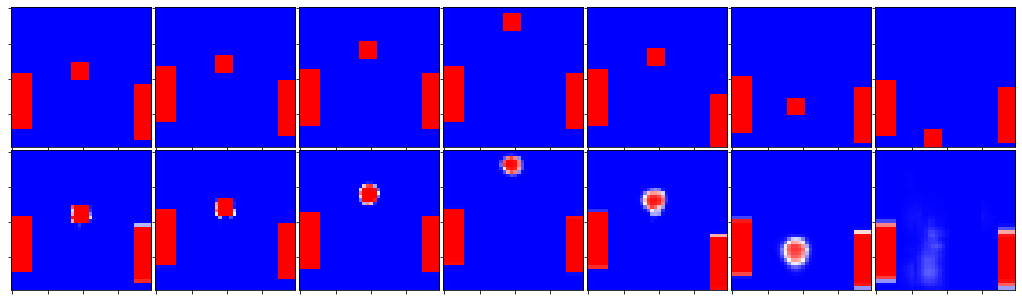

Epoch 507/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0315 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0301 - val_mean_squared_error: 0.0088 - val_acc: 0.9882


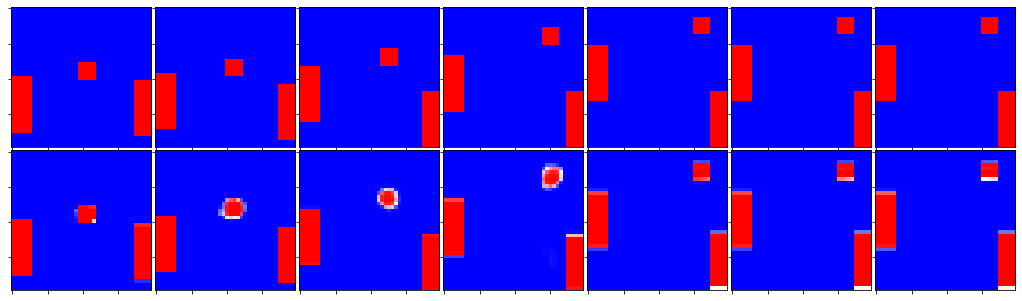

Epoch 508/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0333 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0323 - val_mean_squared_error: 0.0096 - val_acc: 0.9871


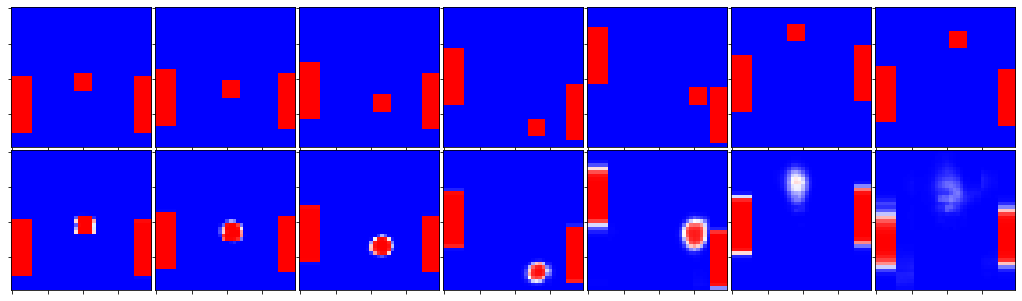

Epoch 509/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0319 - mean_squared_error: 0.0091 - acc: 0.9879 - val_loss: 0.0313 - val_mean_squared_error: 0.0089 - val_acc: 0.9880


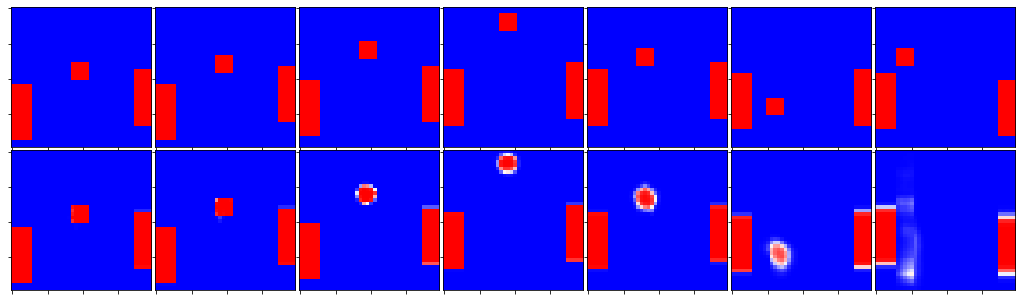

Epoch 510/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0326 - val_mean_squared_error: 0.0095 - val_acc: 0.9872


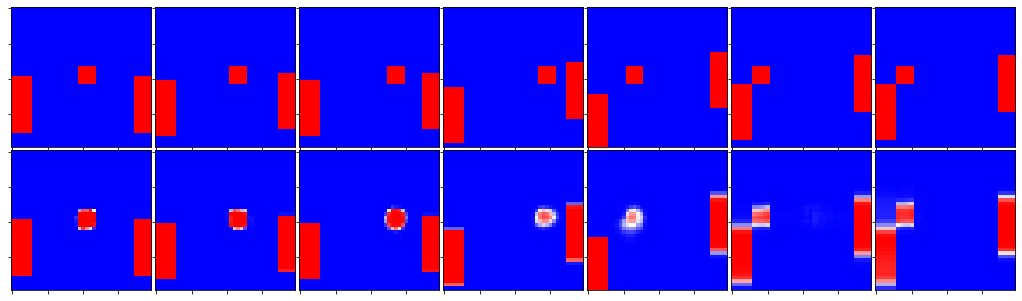

Epoch 511/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0332 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0322 - val_mean_squared_error: 0.0094 - val_acc: 0.9876


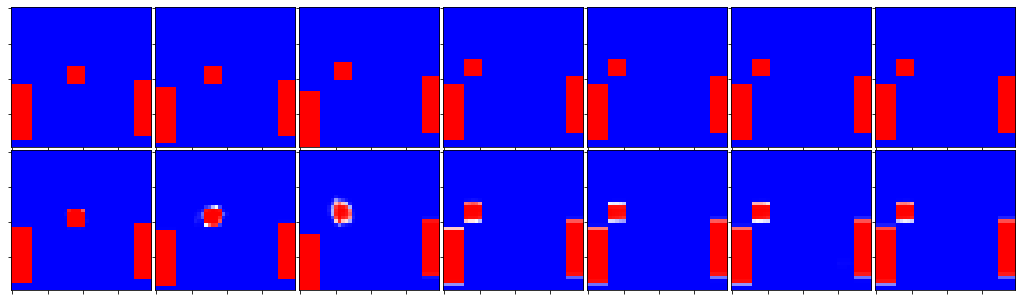

Epoch 512/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0323 - mean_squared_error: 0.0092 - acc: 0.9876 - val_loss: 0.0282 - val_mean_squared_error: 0.0083 - val_acc: 0.9887


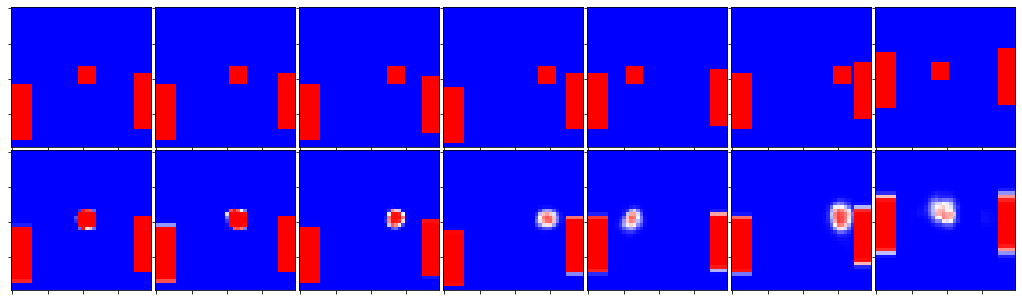

Epoch 513/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0331 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0328 - val_mean_squared_error: 0.0096 - val_acc: 0.9870


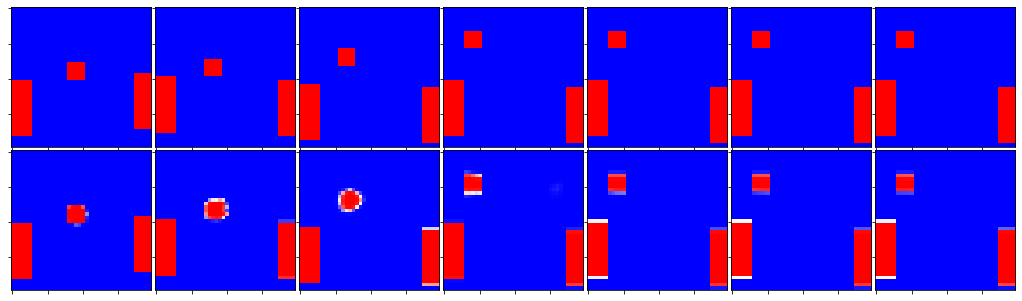

Epoch 514/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0336 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0323 - val_mean_squared_error: 0.0093 - val_acc: 0.9874


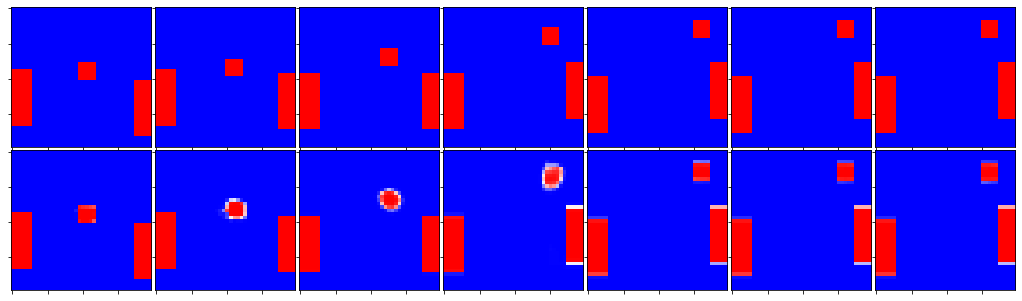

Epoch 515/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0314 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0390 - val_mean_squared_error: 0.0103 - val_acc: 0.9862


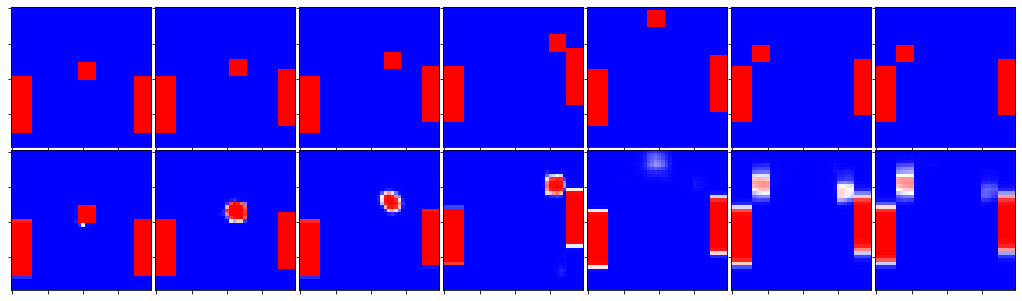

Epoch 516/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0324 - mean_squared_error: 0.0093 - acc: 0.9877 - val_loss: 0.0328 - val_mean_squared_error: 0.0092 - val_acc: 0.9877


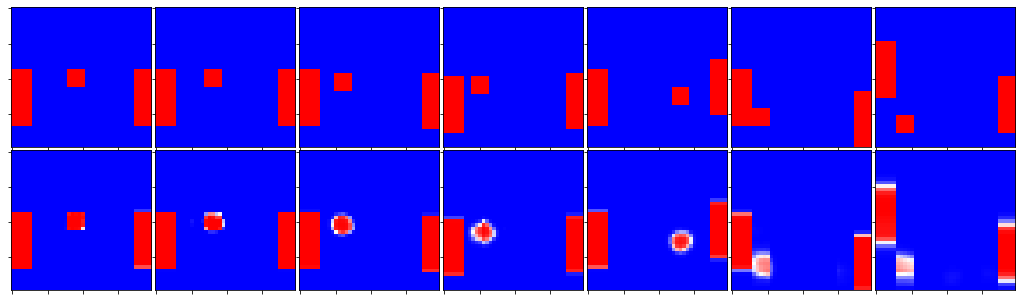

Epoch 517/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0337 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0347 - val_mean_squared_error: 0.0099 - val_acc: 0.9864


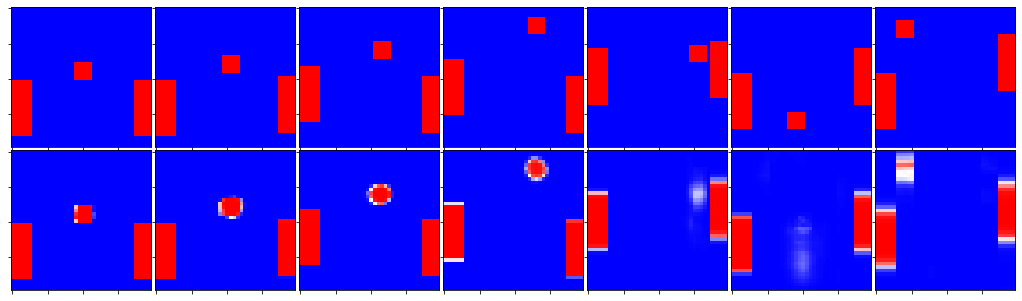

Epoch 518/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0314 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0306 - val_mean_squared_error: 0.0089 - val_acc: 0.9880


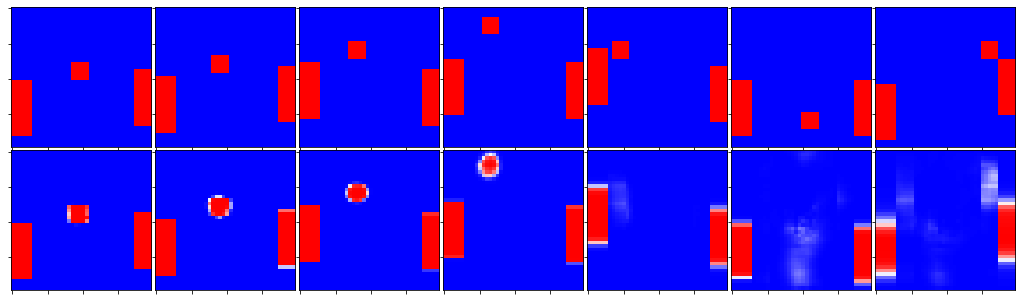

Epoch 519/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0340 - mean_squared_error: 0.0097 - acc: 0.9871 - val_loss: 0.0379 - val_mean_squared_error: 0.0108 - val_acc: 0.9855


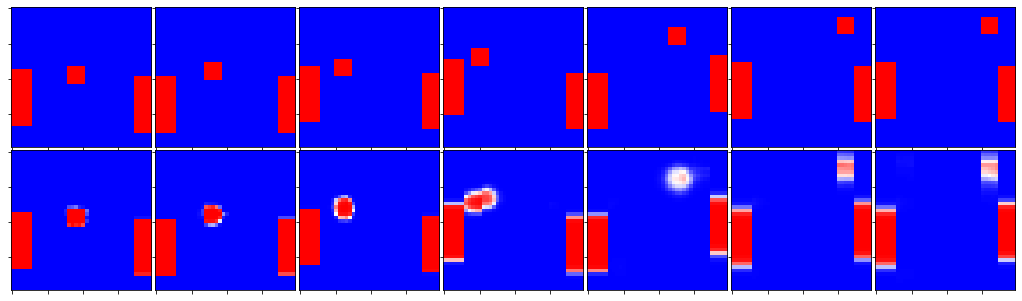

Epoch 520/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0334 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0341 - val_mean_squared_error: 0.0097 - val_acc: 0.9872


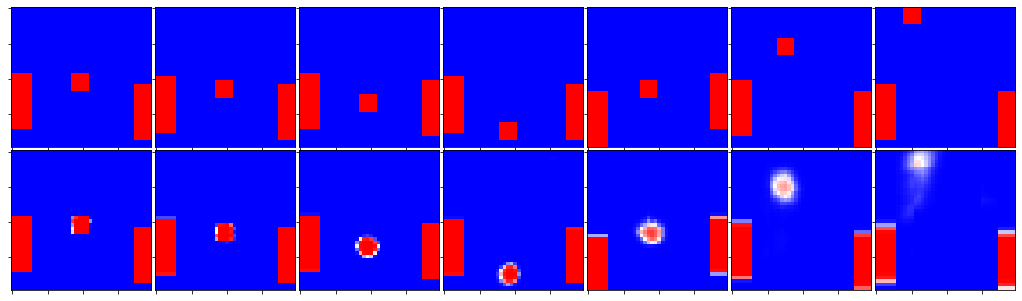

Epoch 521/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0330 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0363 - val_mean_squared_error: 0.0103 - val_acc: 0.9861


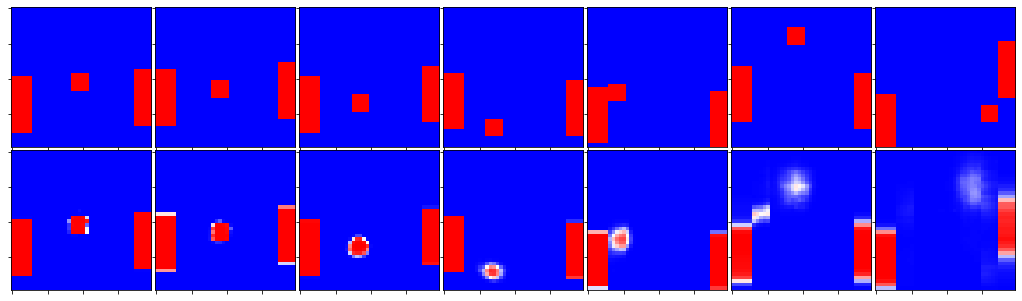

Epoch 522/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0337 - mean_squared_error: 0.0097 - acc: 0.9871 - val_loss: 0.0411 - val_mean_squared_error: 0.0113 - val_acc: 0.9847


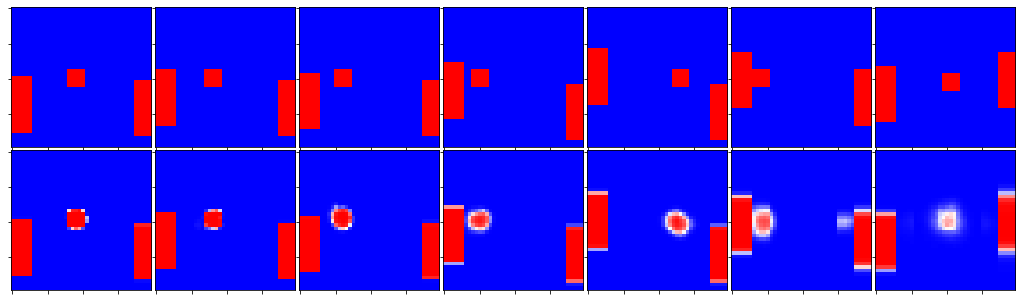

Epoch 523/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0333 - mean_squared_error: 0.0095 - acc: 0.9874 - val_loss: 0.0283 - val_mean_squared_error: 0.0084 - val_acc: 0.9887


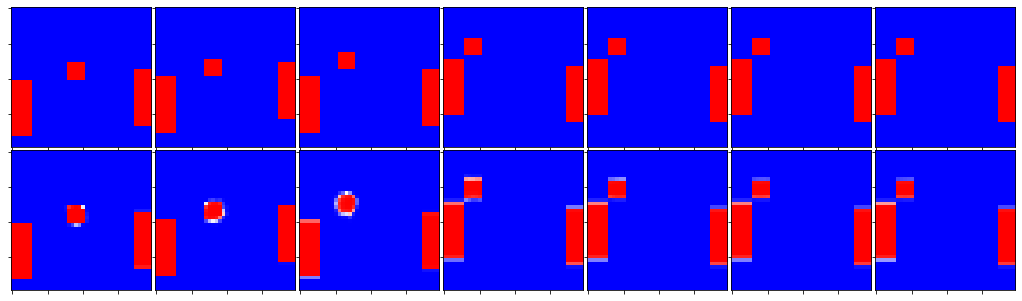

Epoch 524/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0326 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0306 - val_mean_squared_error: 0.0088 - val_acc: 0.9883


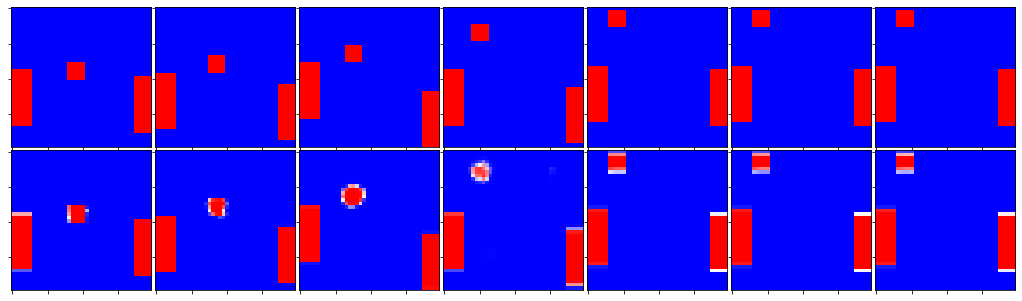

Epoch 525/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0330 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0346 - val_mean_squared_error: 0.0096 - val_acc: 0.9875


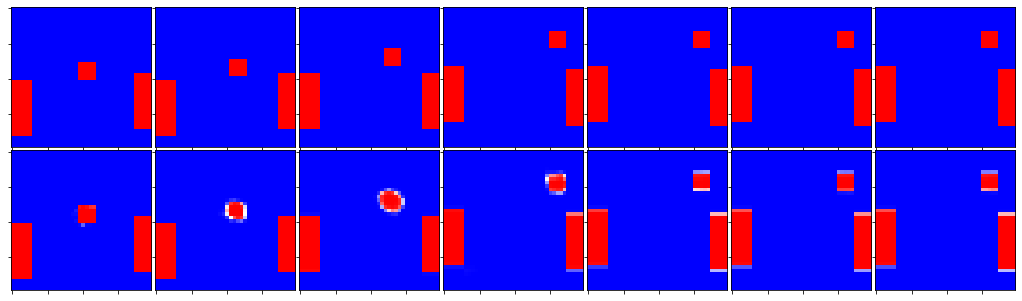

Epoch 526/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0314 - val_mean_squared_error: 0.0093 - val_acc: 0.9873


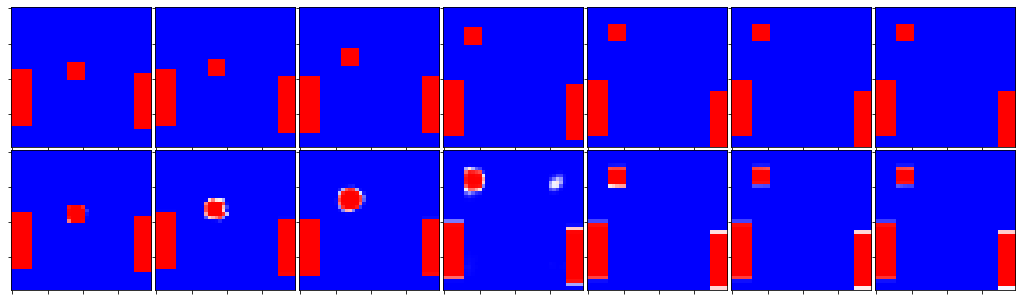

Epoch 527/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0319 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0341 - val_mean_squared_error: 0.0093 - val_acc: 0.9875


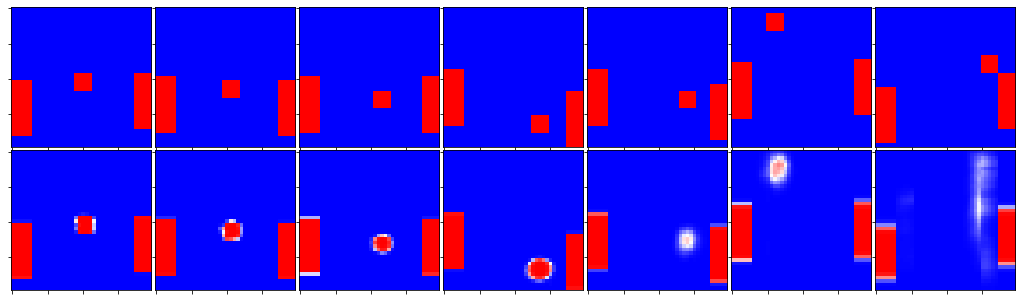

Epoch 528/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0328 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0304 - val_mean_squared_error: 0.0090 - val_acc: 0.9878


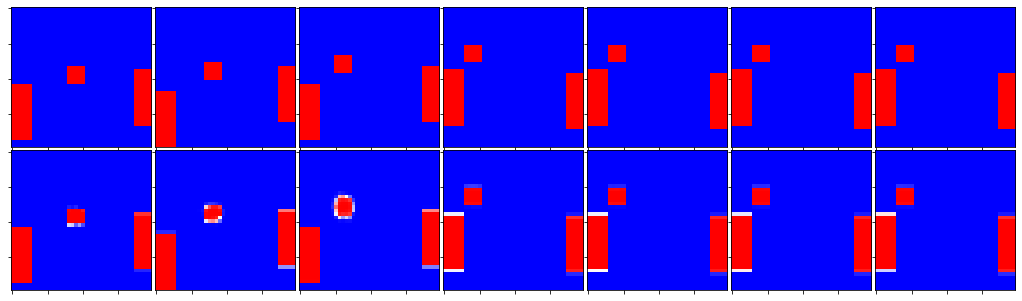

Epoch 529/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0331 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0284 - val_mean_squared_error: 0.0084 - val_acc: 0.9885


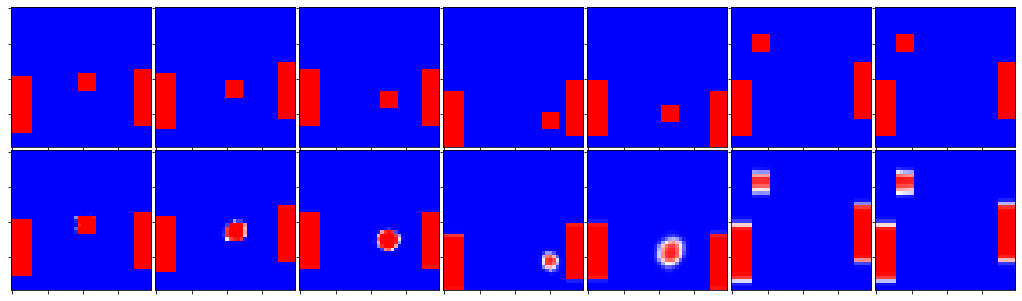

Epoch 530/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0317 - val_mean_squared_error: 0.0094 - val_acc: 0.9870


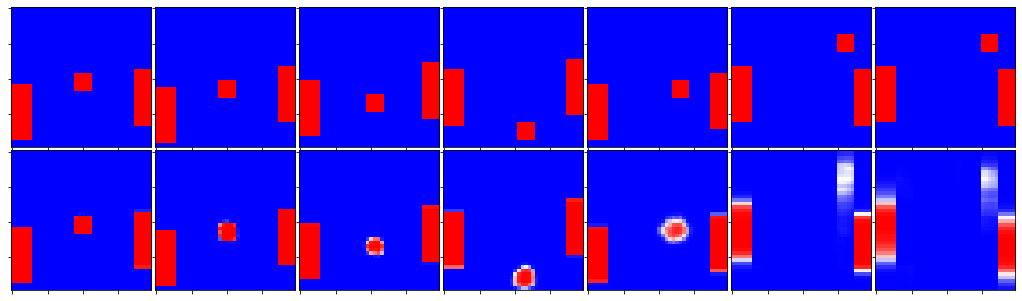

Epoch 531/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0351 - mean_squared_error: 0.0100 - acc: 0.9867 - val_loss: 0.0329 - val_mean_squared_error: 0.0097 - val_acc: 0.9872


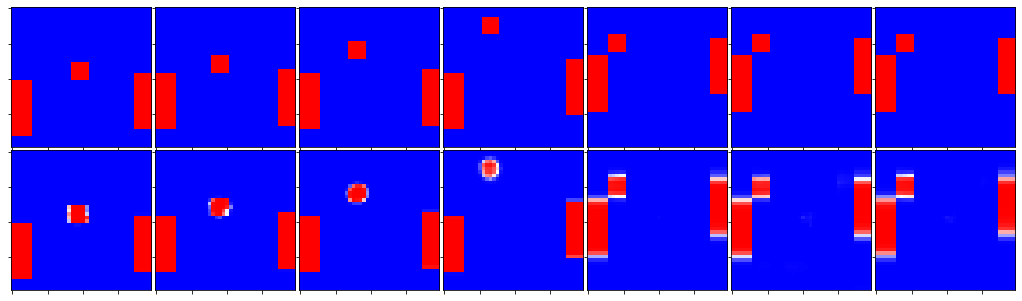

Epoch 532/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0324 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0274 - val_mean_squared_error: 0.0079 - val_acc: 0.9896


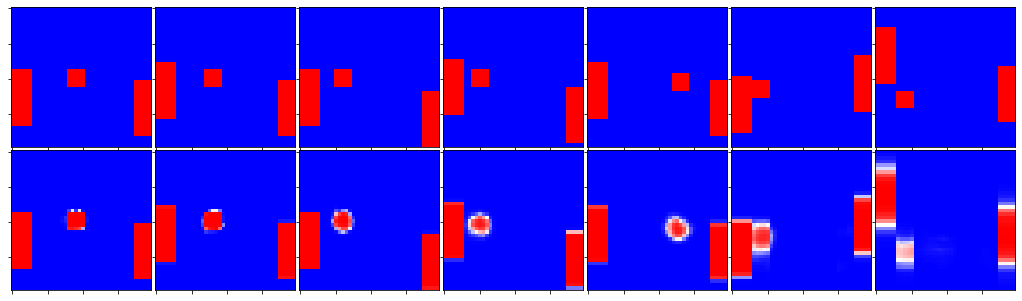

Epoch 533/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0328 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0340 - val_mean_squared_error: 0.0097 - val_acc: 0.9871


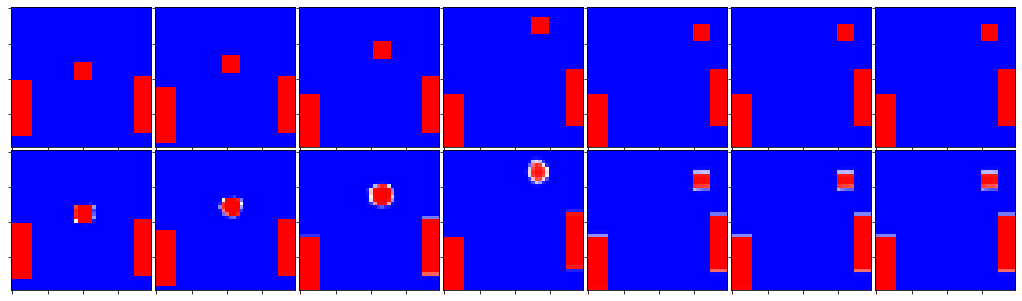

Epoch 534/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0336 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0392 - val_mean_squared_error: 0.0108 - val_acc: 0.9861


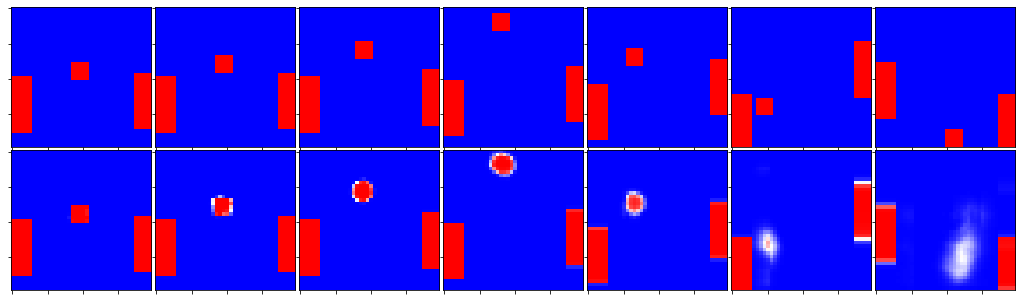

Epoch 535/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0307 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0303 - val_mean_squared_error: 0.0087 - val_acc: 0.9883


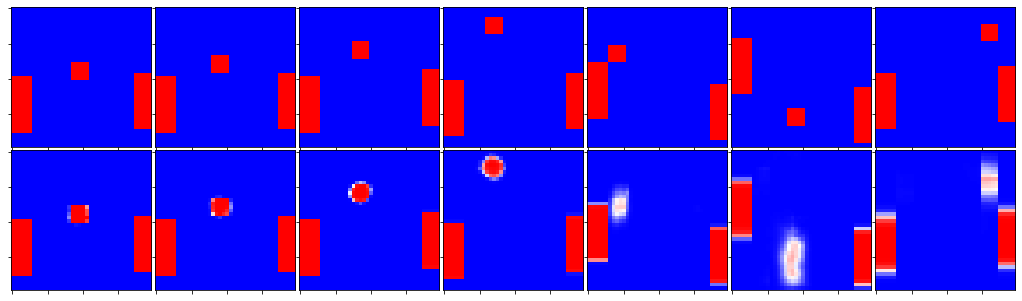

Epoch 536/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0313 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0375 - val_mean_squared_error: 0.0103 - val_acc: 0.9865


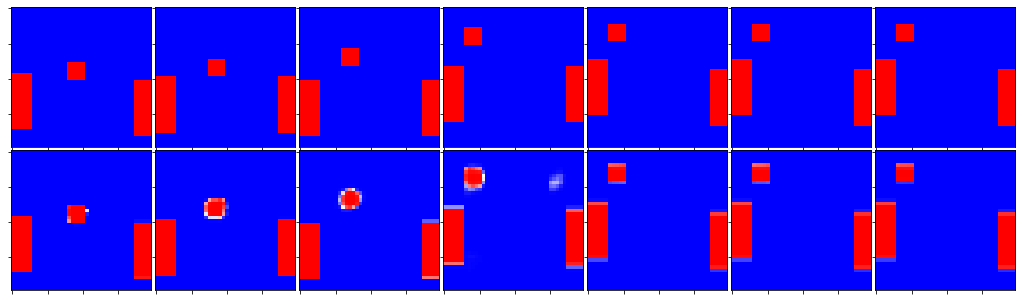

Epoch 537/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0327 - mean_squared_error: 0.0093 - acc: 0.9875 - val_loss: 0.0325 - val_mean_squared_error: 0.0091 - val_acc: 0.9879


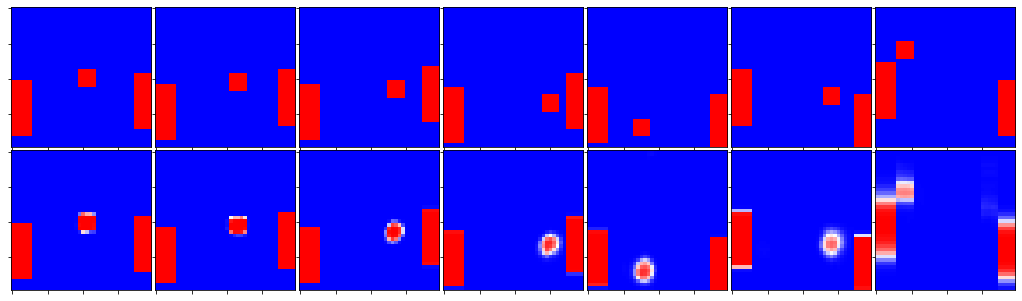

Epoch 538/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0360 - val_mean_squared_error: 0.0101 - val_acc: 0.9866


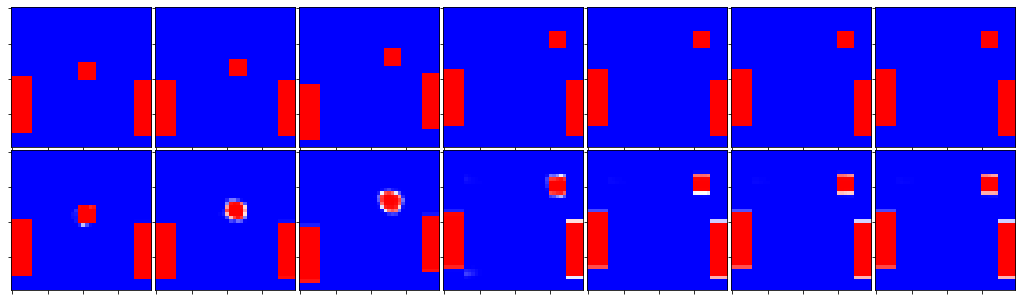

Epoch 539/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0338 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0412 - val_mean_squared_error: 0.0114 - val_acc: 0.9848


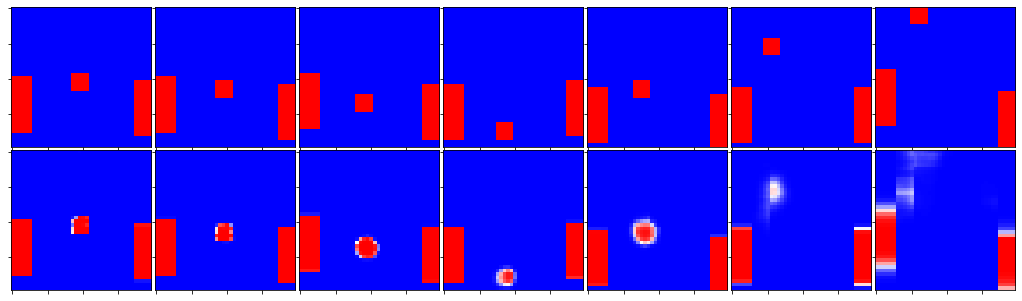

Epoch 540/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0322 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0302 - val_mean_squared_error: 0.0087 - val_acc: 0.9885


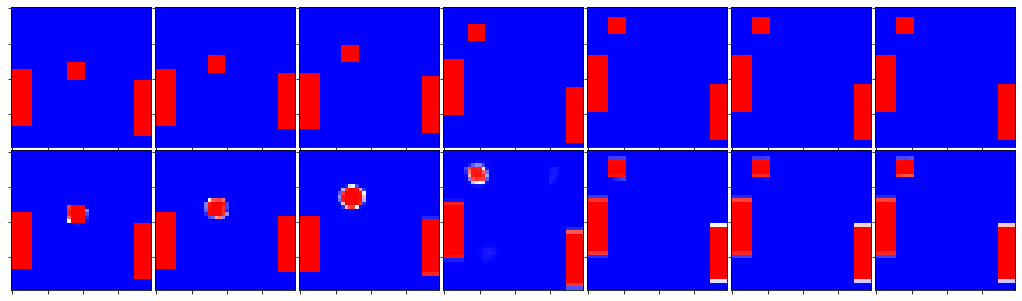

Epoch 541/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0328 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0316 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


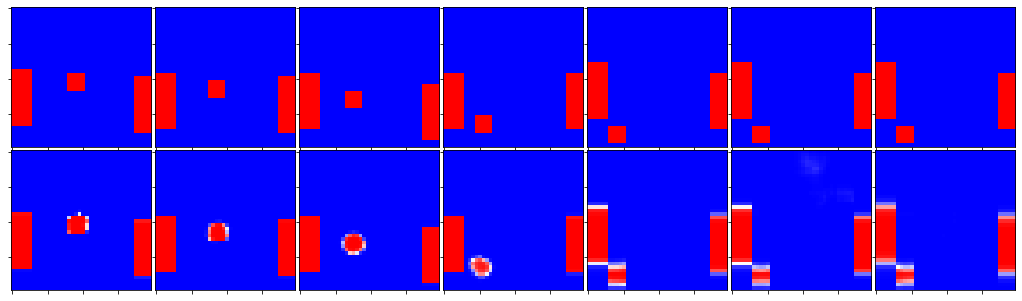

Epoch 542/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0314 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0283 - val_mean_squared_error: 0.0082 - val_acc: 0.9893


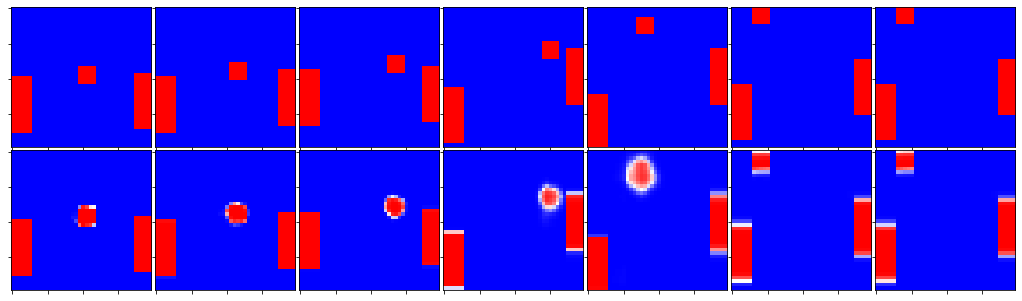

Epoch 543/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0330 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0357 - val_mean_squared_error: 0.0106 - val_acc: 0.9856


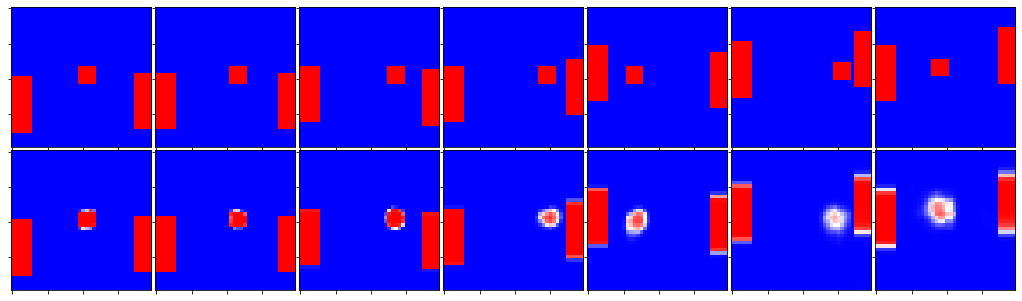

Epoch 544/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0310 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0261 - val_mean_squared_error: 0.0076 - val_acc: 0.9900


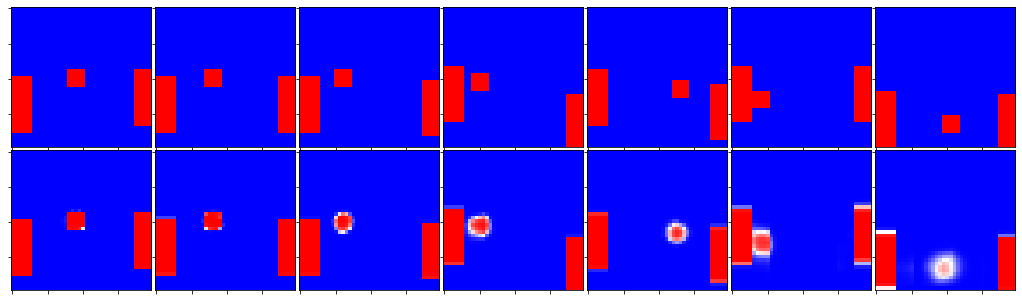

Epoch 545/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0273 - val_mean_squared_error: 0.0081 - val_acc: 0.9889


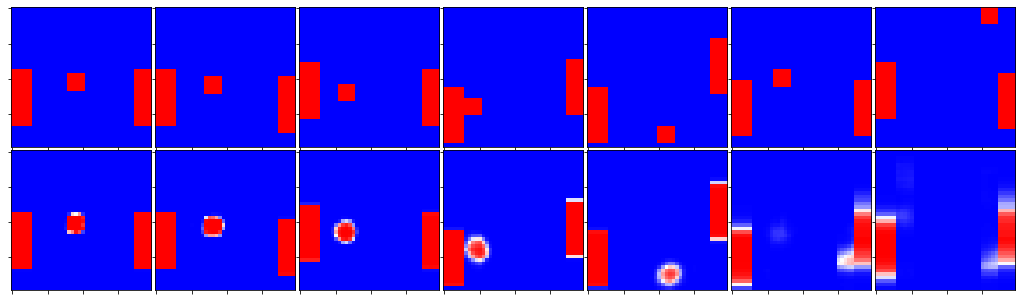

Epoch 546/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0335 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0347 - val_mean_squared_error: 0.0100 - val_acc: 0.9867


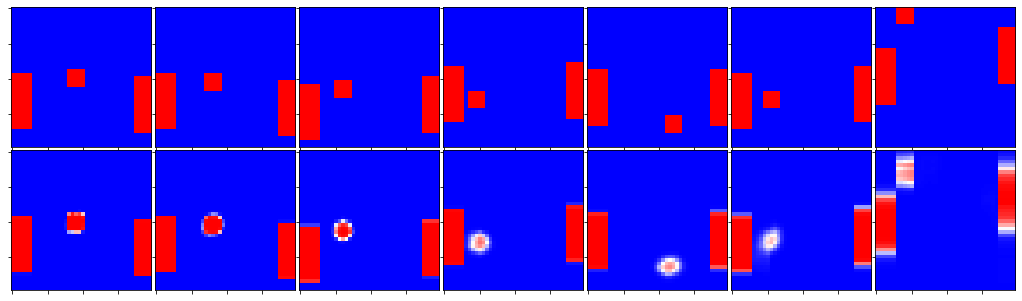

Epoch 547/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0327 - mean_squared_error: 0.0093 - acc: 0.9875 - val_loss: 0.0354 - val_mean_squared_error: 0.0101 - val_acc: 0.9866


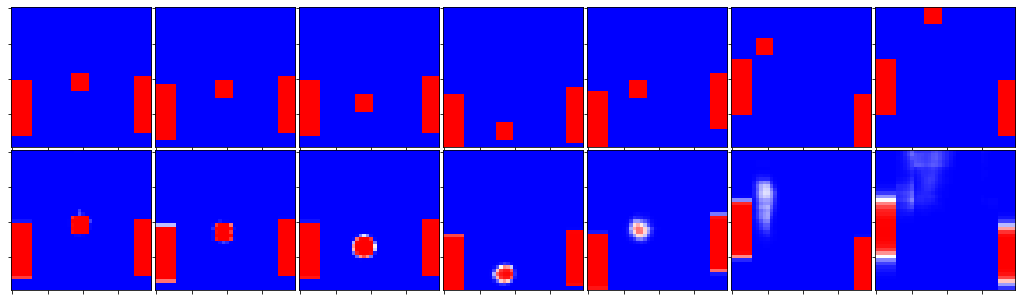

Epoch 548/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0335 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0304 - val_mean_squared_error: 0.0084 - val_acc: 0.9890


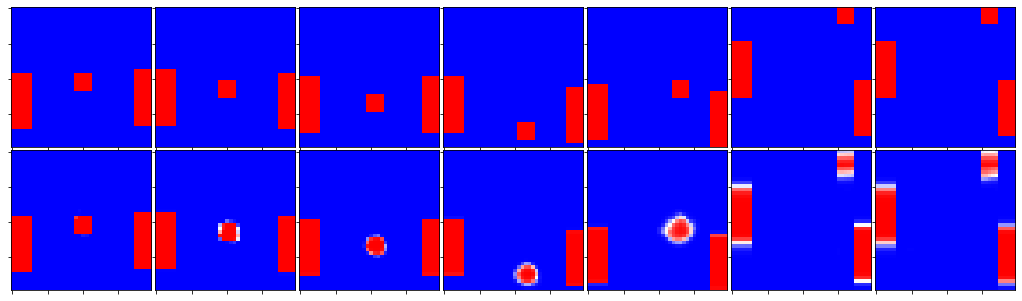

Epoch 549/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0328 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0423 - val_mean_squared_error: 0.0112 - val_acc: 0.9850


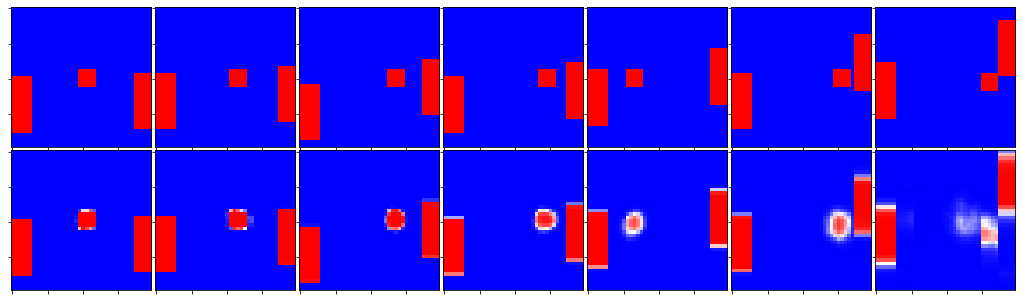

Epoch 550/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0307 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0301 - val_mean_squared_error: 0.0085 - val_acc: 0.9887


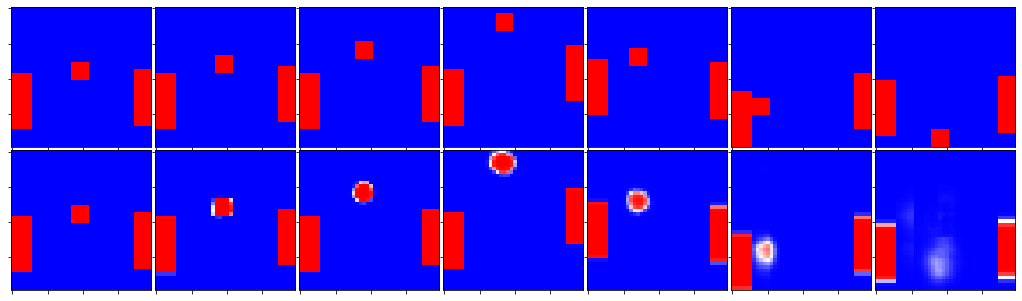

Epoch 551/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0318 - mean_squared_error: 0.0091 - acc: 0.9879 - val_loss: 0.0379 - val_mean_squared_error: 0.0103 - val_acc: 0.9864


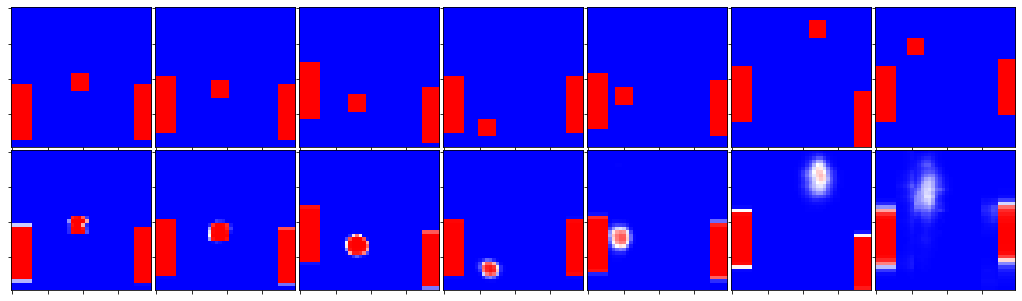

Epoch 552/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0313 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0318 - val_mean_squared_error: 0.0094 - val_acc: 0.9875


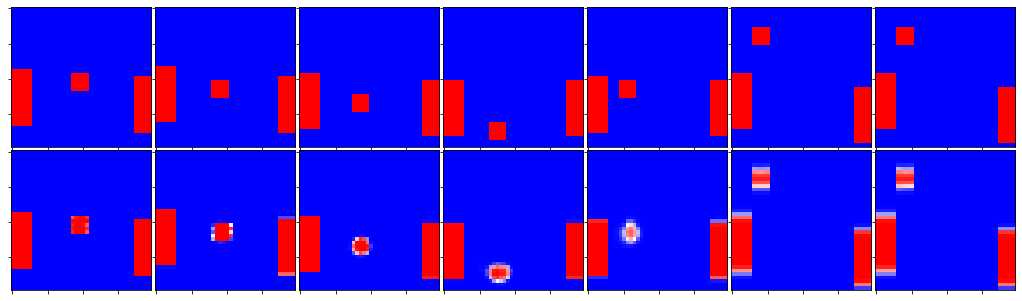

Epoch 553/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0300 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0254 - val_mean_squared_error: 0.0075 - val_acc: 0.9900


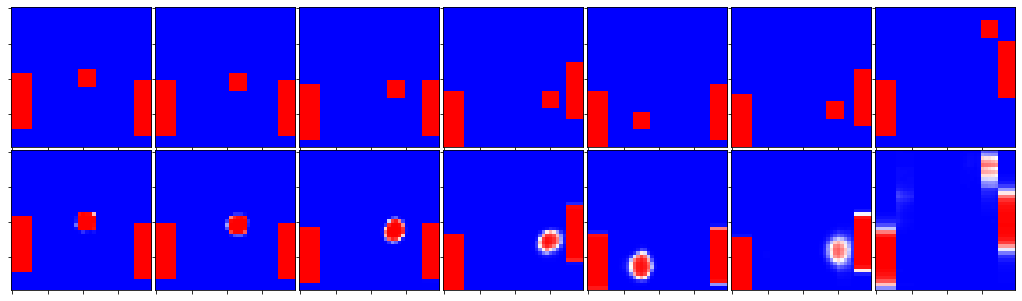

Epoch 554/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0313 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0342 - val_mean_squared_error: 0.0095 - val_acc: 0.9872


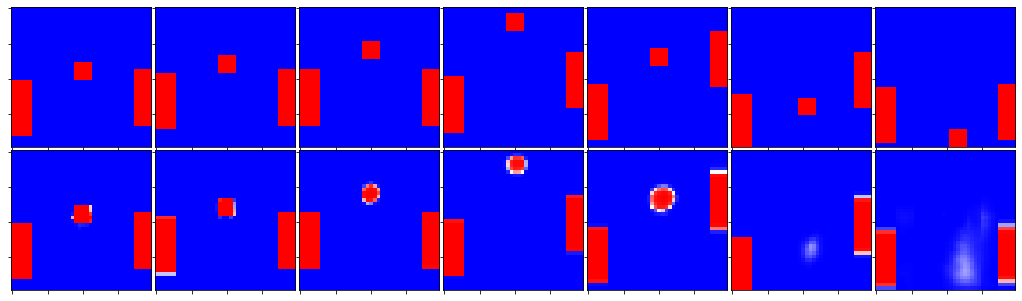

Epoch 555/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0288 - val_mean_squared_error: 0.0085 - val_acc: 0.9884


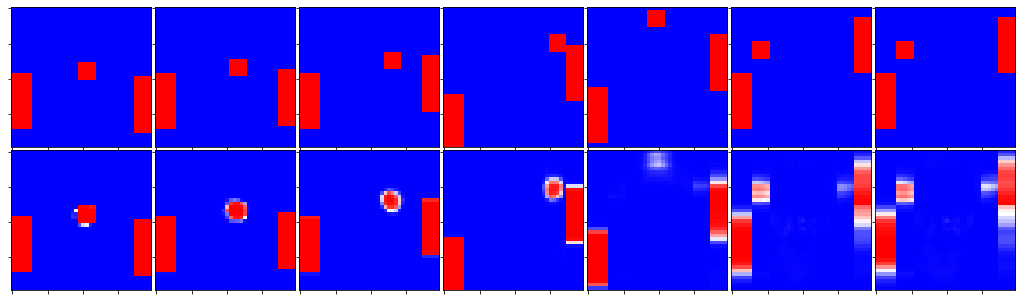

Epoch 556/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0330 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0447 - val_mean_squared_error: 0.0125 - val_acc: 0.9831


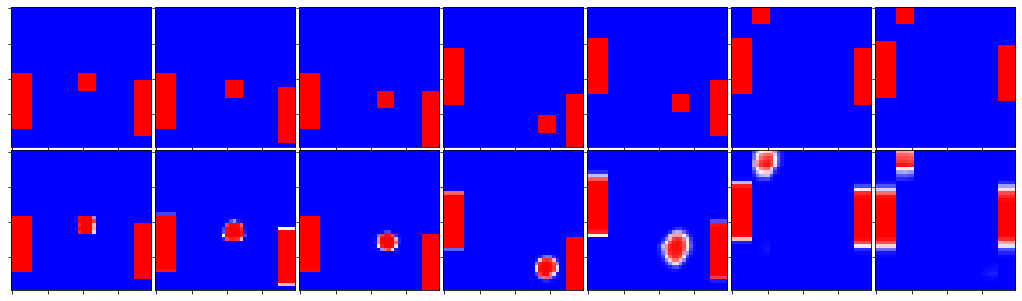

Epoch 557/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0310 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0315 - val_mean_squared_error: 0.0091 - val_acc: 0.9879


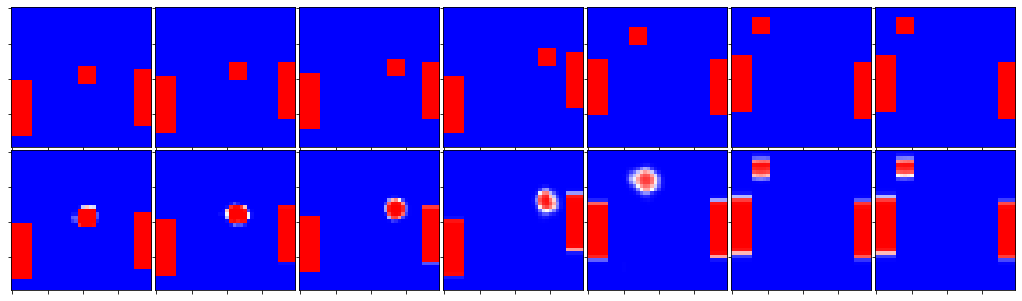

Epoch 558/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0332 - mean_squared_error: 0.0093 - acc: 0.9875 - val_loss: 0.0348 - val_mean_squared_error: 0.0094 - val_acc: 0.9878


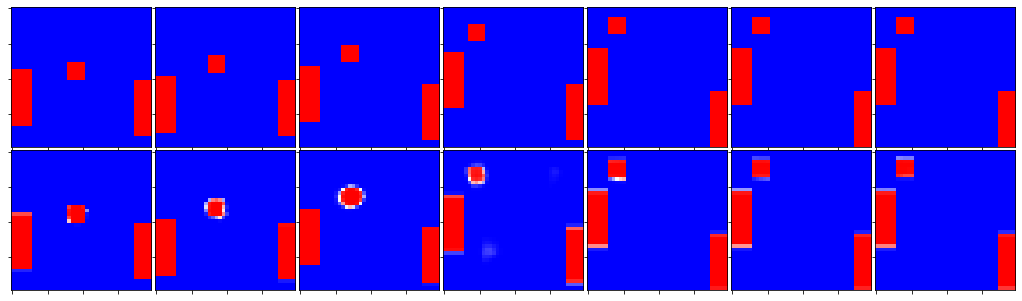

Epoch 559/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0328 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0312 - val_mean_squared_error: 0.0090 - val_acc: 0.9878


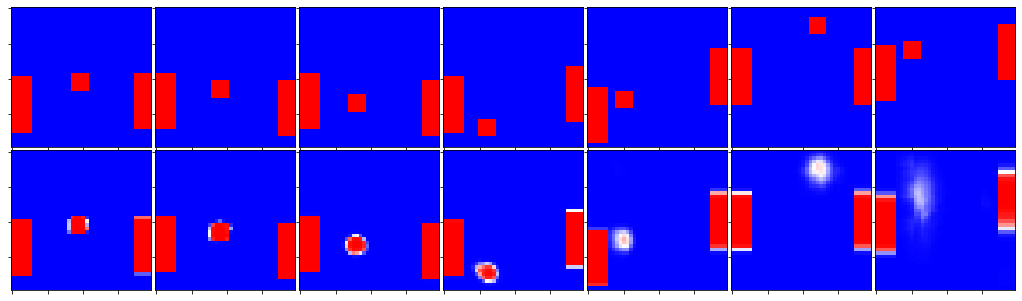

Epoch 560/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0309 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0318 - val_mean_squared_error: 0.0092 - val_acc: 0.9876


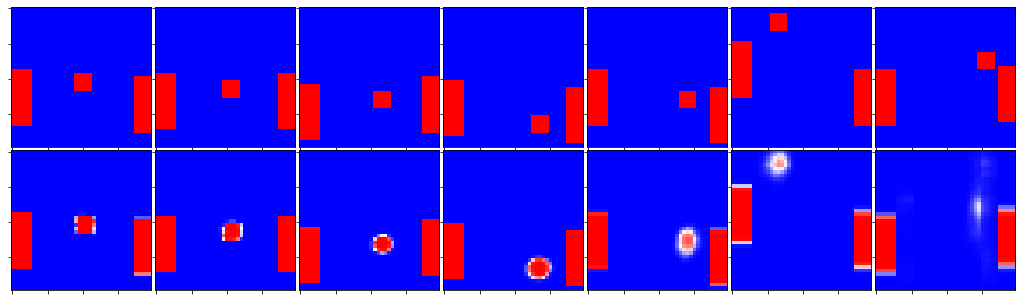

Epoch 561/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0326 - val_mean_squared_error: 0.0097 - val_acc: 0.9868


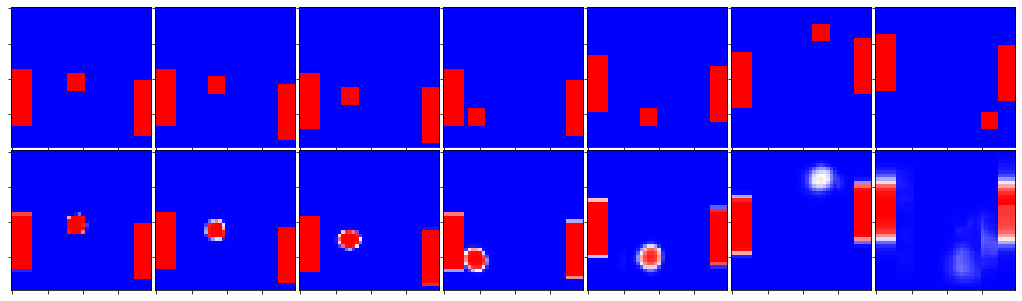

Epoch 562/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0407 - mean_squared_error: 0.0108 - acc: 0.9857 - val_loss: 0.0321 - val_mean_squared_error: 0.0093 - val_acc: 0.9873


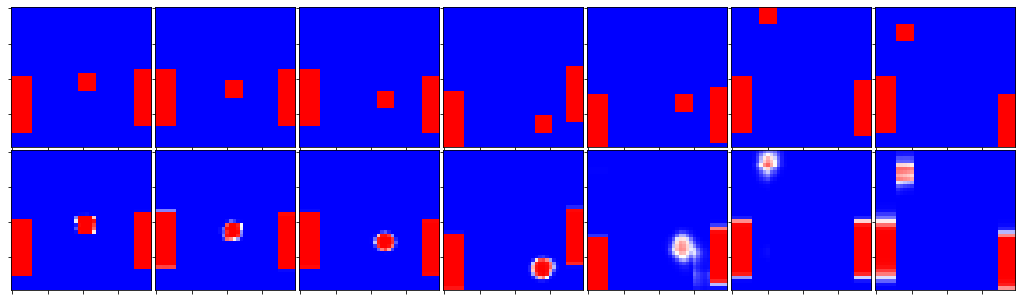

Epoch 563/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0364 - val_mean_squared_error: 0.0097 - val_acc: 0.9874


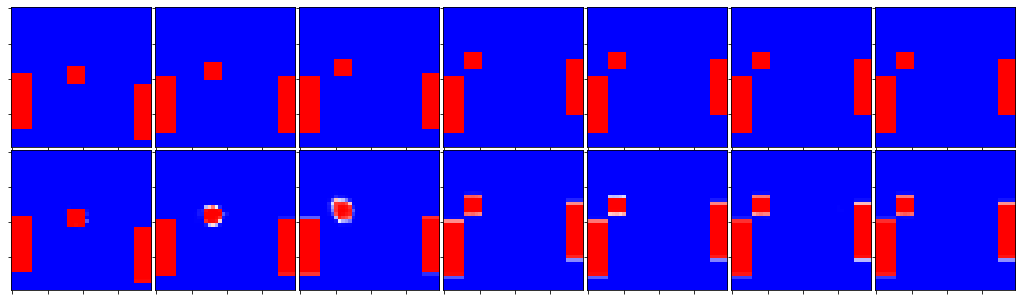

Epoch 564/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0311 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0370 - val_mean_squared_error: 0.0104 - val_acc: 0.9859


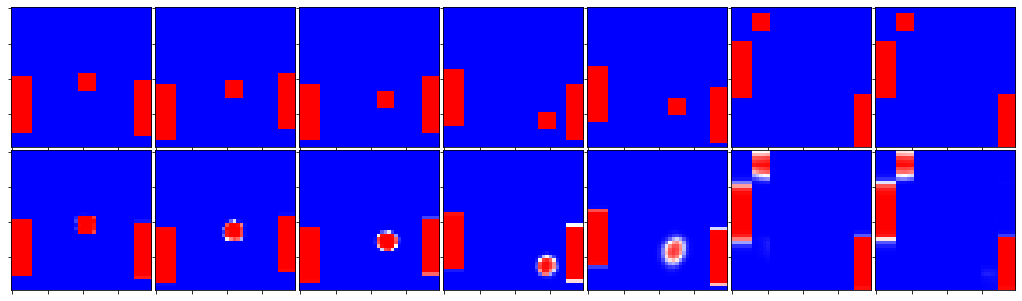

Epoch 565/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0315 - val_mean_squared_error: 0.0092 - val_acc: 0.9876


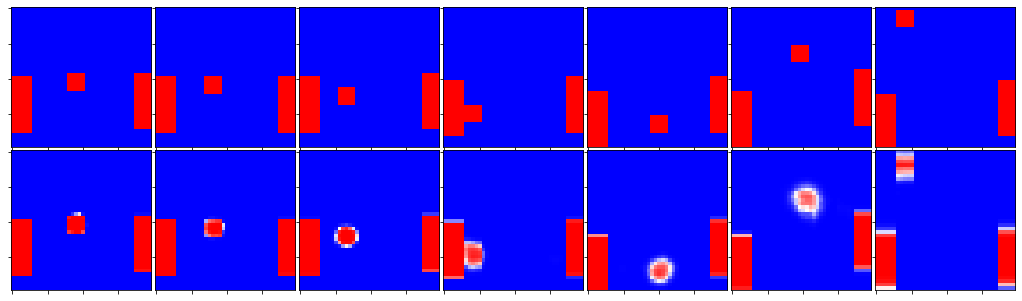

Epoch 566/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0311 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0306 - val_mean_squared_error: 0.0087 - val_acc: 0.9885


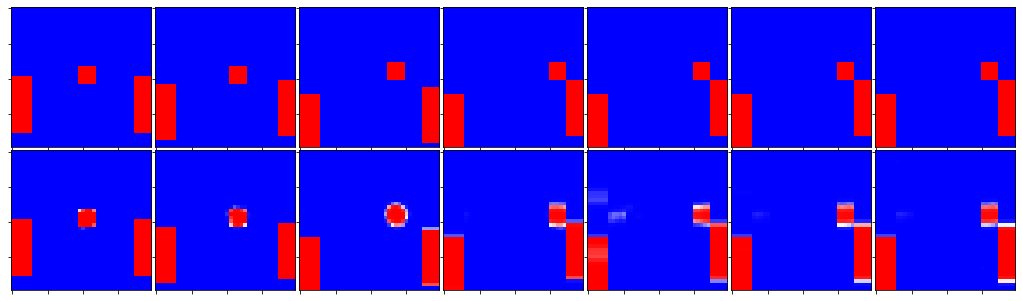

Epoch 567/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0330 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0318 - val_mean_squared_error: 0.0086 - val_acc: 0.9890


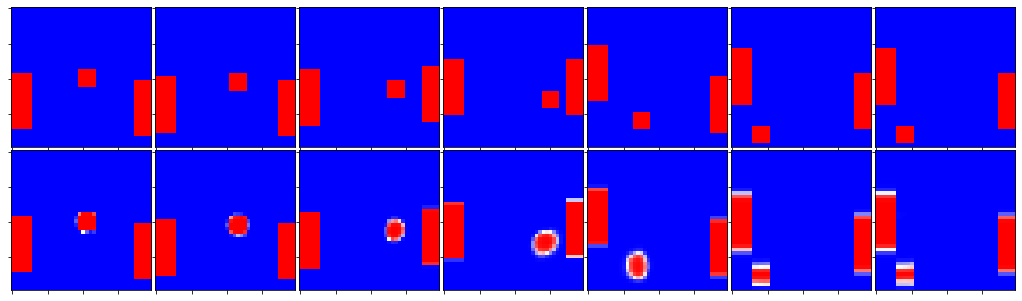

Epoch 568/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0311 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0362 - val_mean_squared_error: 0.0099 - val_acc: 0.9869


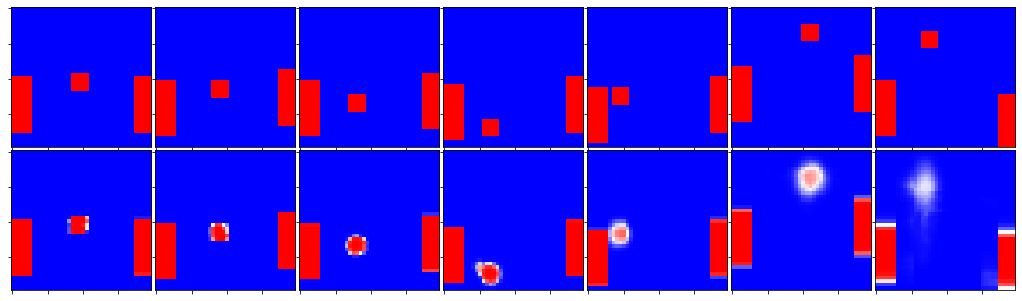

Epoch 569/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0324 - mean_squared_error: 0.0092 - acc: 0.9876 - val_loss: 0.0322 - val_mean_squared_error: 0.0094 - val_acc: 0.9875


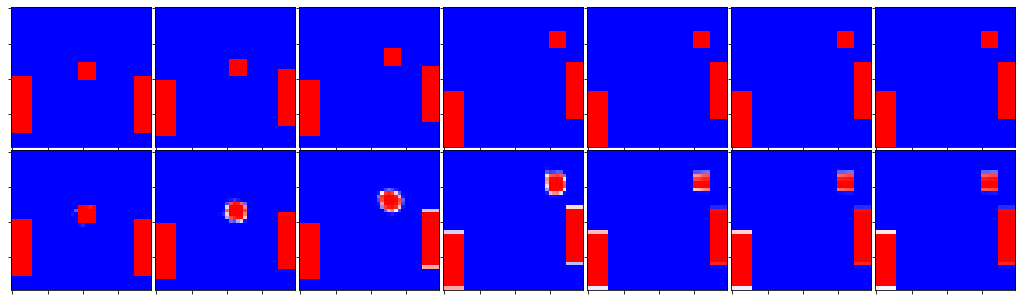

Epoch 570/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0304 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0308 - val_mean_squared_error: 0.0089 - val_acc: 0.9882


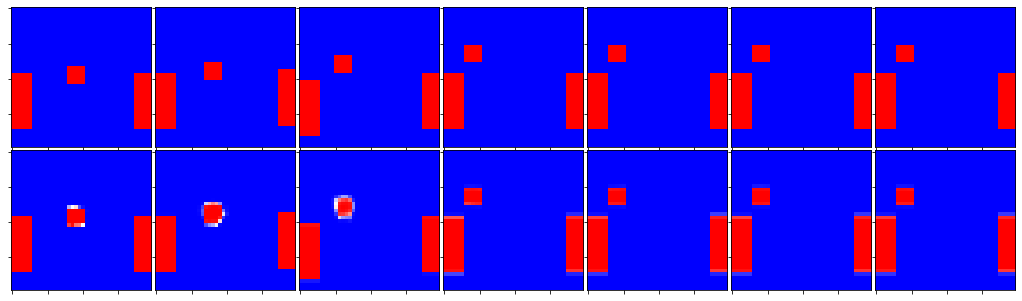

Epoch 571/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0334 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0369 - val_mean_squared_error: 0.0106 - val_acc: 0.9857


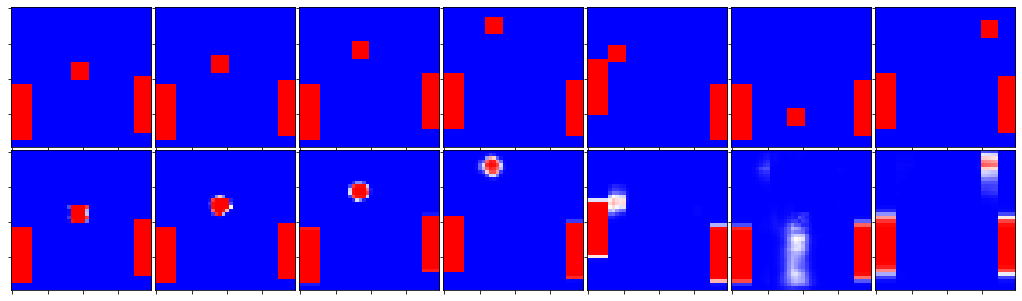

Epoch 572/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0317 - mean_squared_error: 0.0091 - acc: 0.9877 - val_loss: 0.0322 - val_mean_squared_error: 0.0091 - val_acc: 0.9878


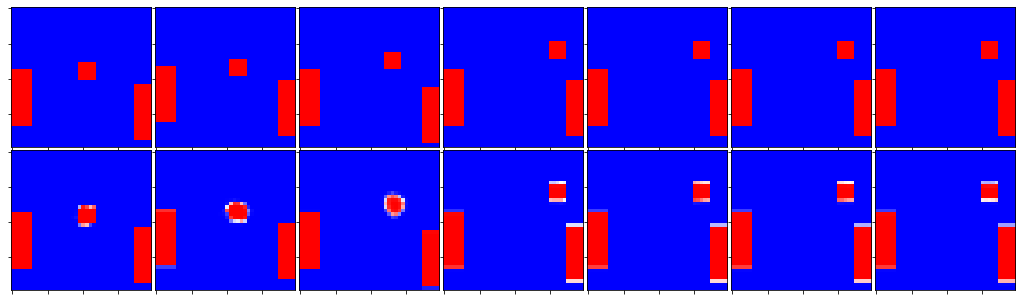

Epoch 573/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0340 - mean_squared_error: 0.0096 - acc: 0.9871 - val_loss: 0.0314 - val_mean_squared_error: 0.0091 - val_acc: 0.9876


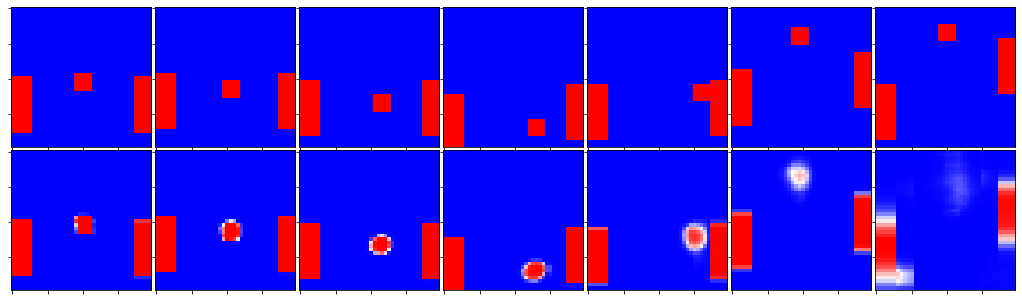

Epoch 574/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0326 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0284 - val_mean_squared_error: 0.0084 - val_acc: 0.9885


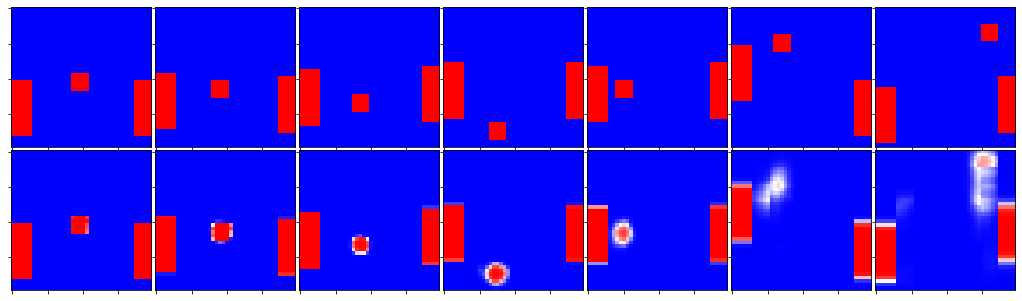

Epoch 575/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0332 - mean_squared_error: 0.0095 - acc: 0.9874 - val_loss: 0.0297 - val_mean_squared_error: 0.0085 - val_acc: 0.9887


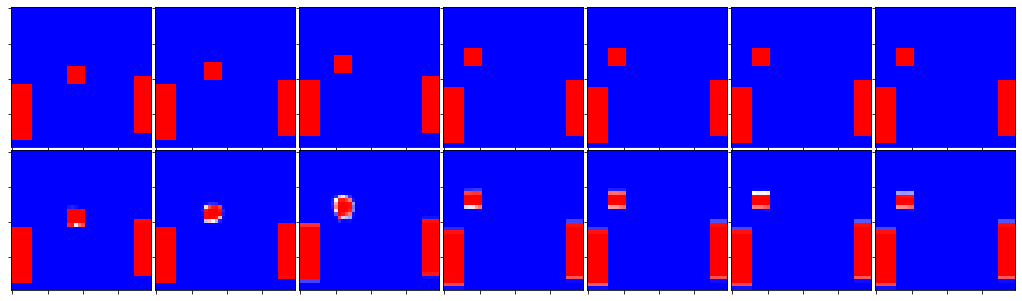

Epoch 576/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0303 - mean_squared_error: 0.0087 - acc: 0.9885 - val_loss: 0.0272 - val_mean_squared_error: 0.0079 - val_acc: 0.9896


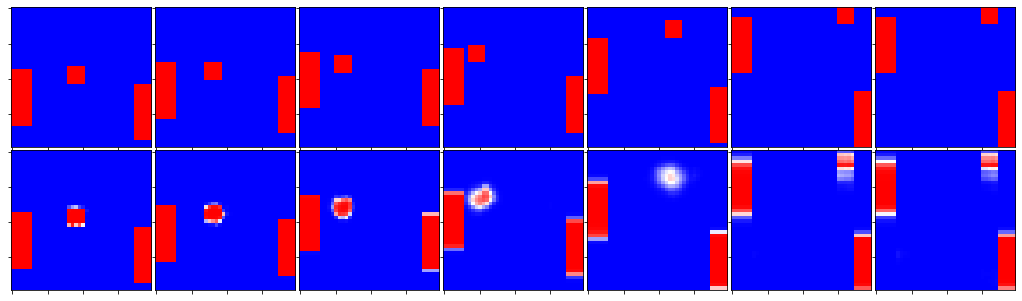

Epoch 577/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0304 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0255 - val_mean_squared_error: 0.0075 - val_acc: 0.9897


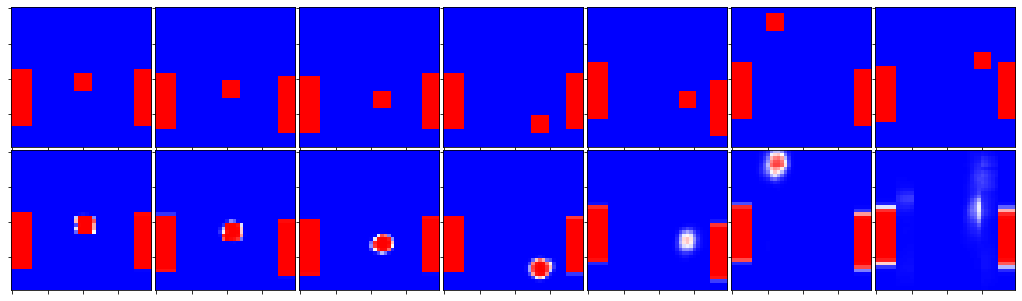

Epoch 578/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0303 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0332 - val_mean_squared_error: 0.0097 - val_acc: 0.9870


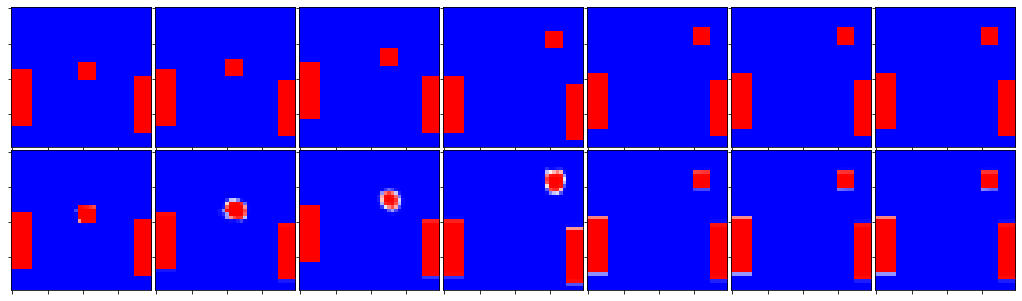

Epoch 579/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0311 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0284 - val_mean_squared_error: 0.0083 - val_acc: 0.9889


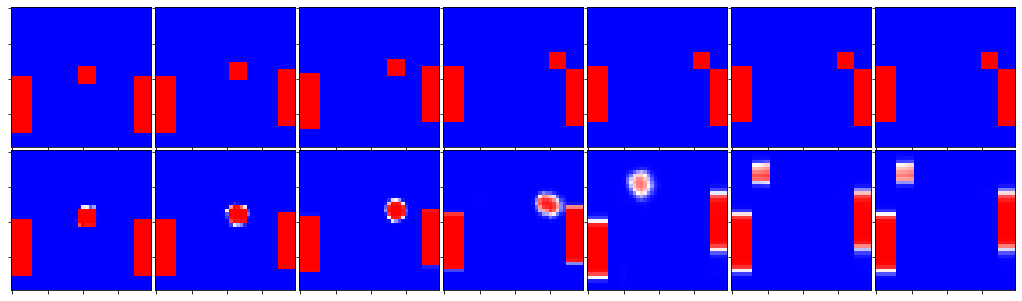

Epoch 580/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0309 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0260 - val_mean_squared_error: 0.0077 - val_acc: 0.9895


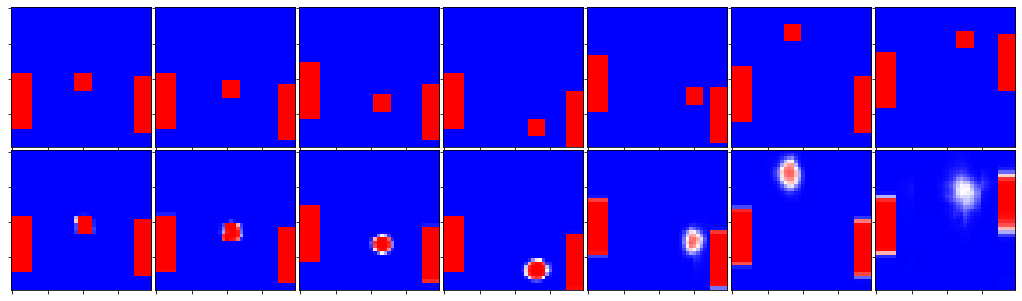

Epoch 581/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0305 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0304 - val_mean_squared_error: 0.0091 - val_acc: 0.9874


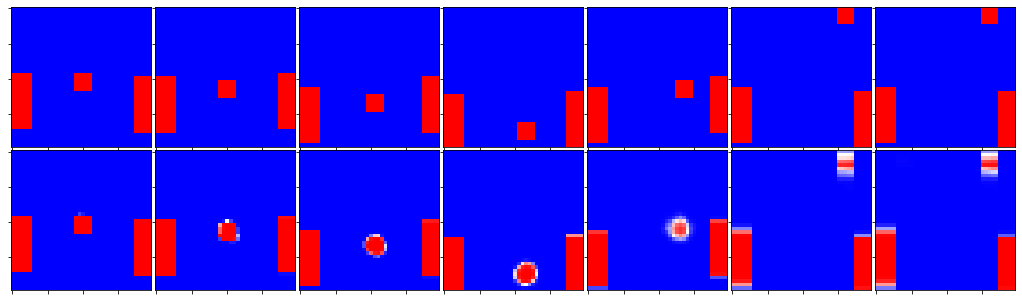

Epoch 582/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0322 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0305 - val_mean_squared_error: 0.0088 - val_acc: 0.9883


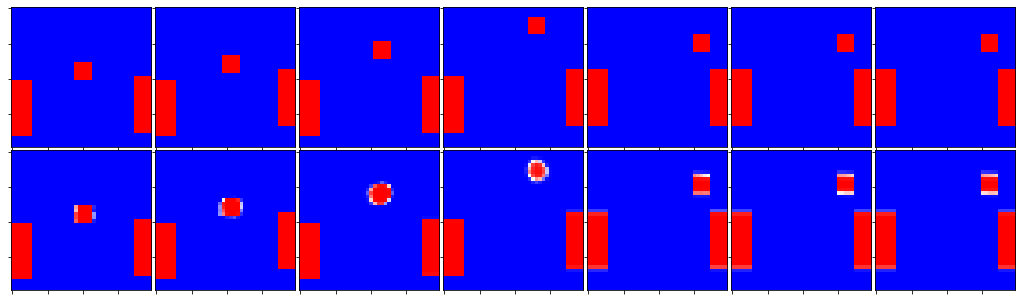

Epoch 583/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0324 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0301 - val_mean_squared_error: 0.0087 - val_acc: 0.9883


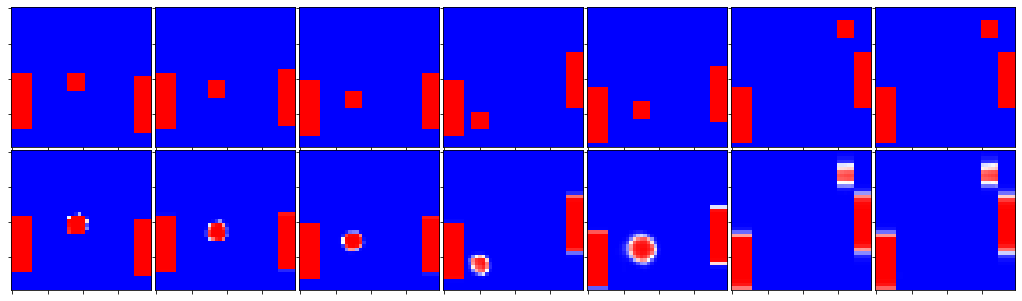

Epoch 584/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0300 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0352 - val_mean_squared_error: 0.0091 - val_acc: 0.9879


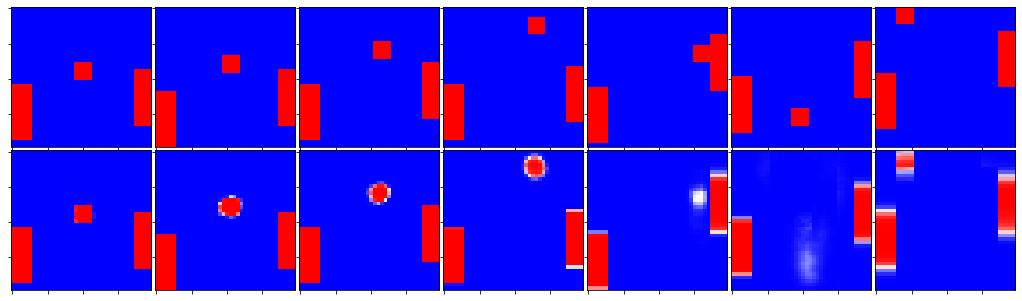

Epoch 585/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0361 - val_mean_squared_error: 0.0104 - val_acc: 0.9861


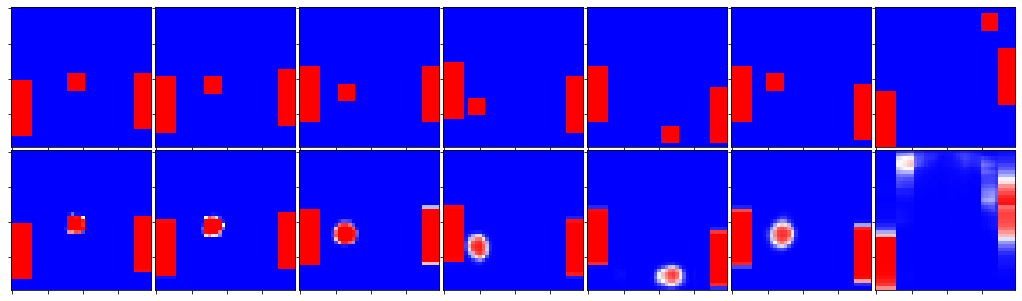

Epoch 586/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0328 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0255 - val_mean_squared_error: 0.0074 - val_acc: 0.9900


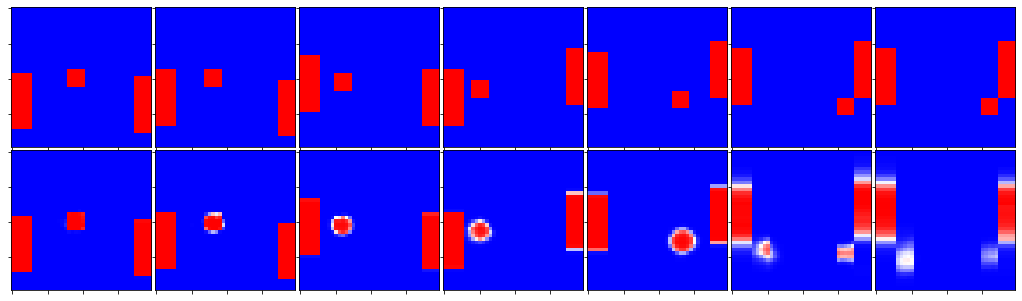

Epoch 587/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0304 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0325 - val_mean_squared_error: 0.0093 - val_acc: 0.9873


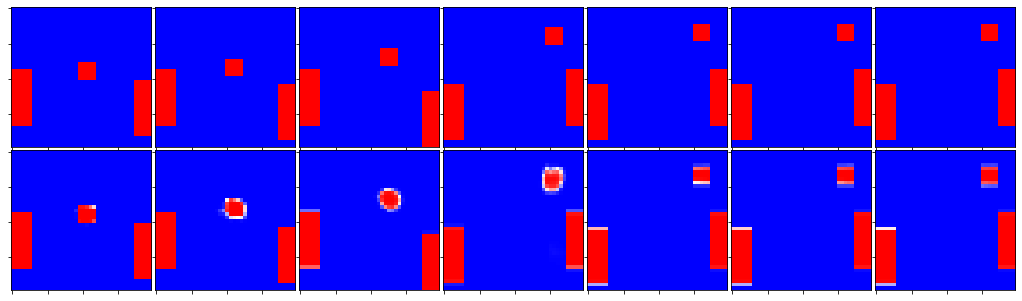

Epoch 588/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0297 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0335 - val_mean_squared_error: 0.0097 - val_acc: 0.9868


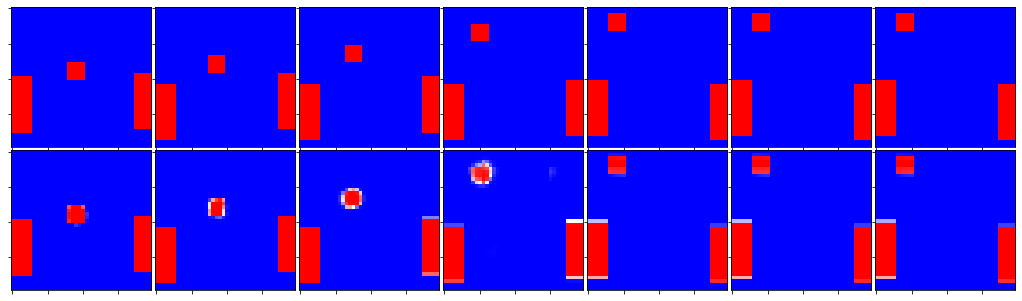

Epoch 589/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0318 - mean_squared_error: 0.0090 - acc: 0.9879 - val_loss: 0.0316 - val_mean_squared_error: 0.0087 - val_acc: 0.9883


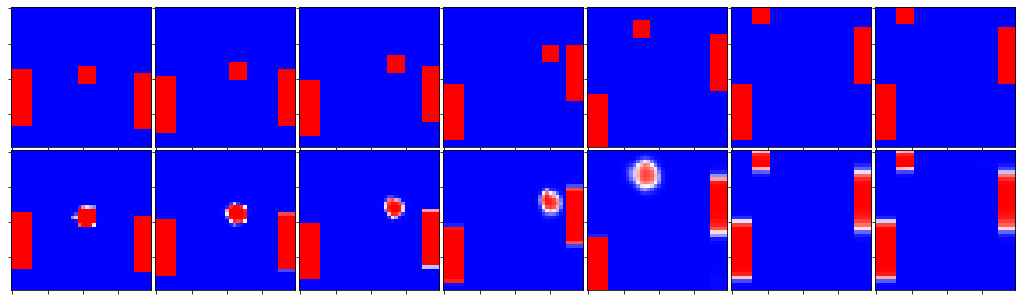

Epoch 590/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0332 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0330 - val_mean_squared_error: 0.0095 - val_acc: 0.9874


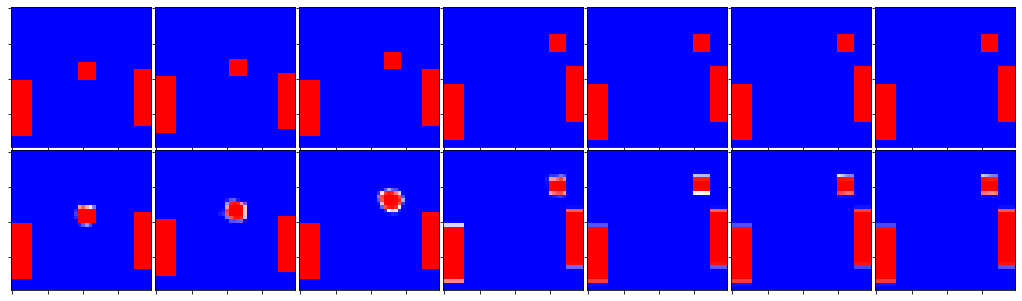

Epoch 591/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0372 - mean_squared_error: 0.0102 - acc: 0.9866 - val_loss: 0.0568 - val_mean_squared_error: 0.0156 - val_acc: 0.9795


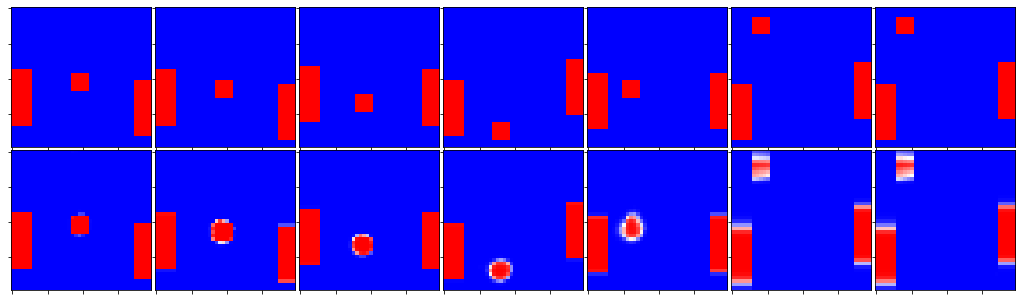

Epoch 592/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0394 - mean_squared_error: 0.0110 - acc: 0.9854 - val_loss: 0.0366 - val_mean_squared_error: 0.0104 - val_acc: 0.9859


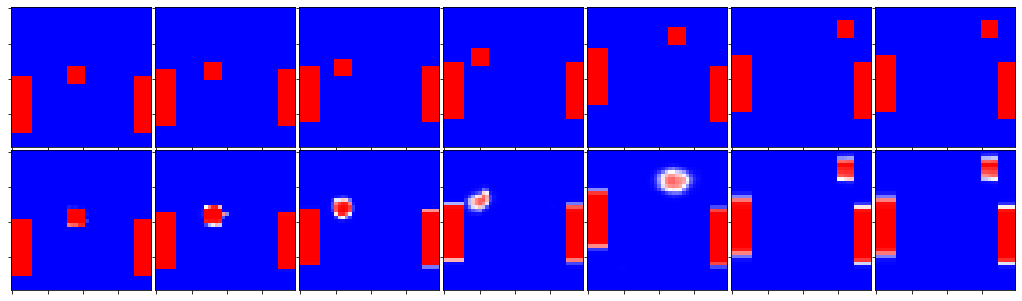

Epoch 593/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0308 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0347 - val_mean_squared_error: 0.0098 - val_acc: 0.9867


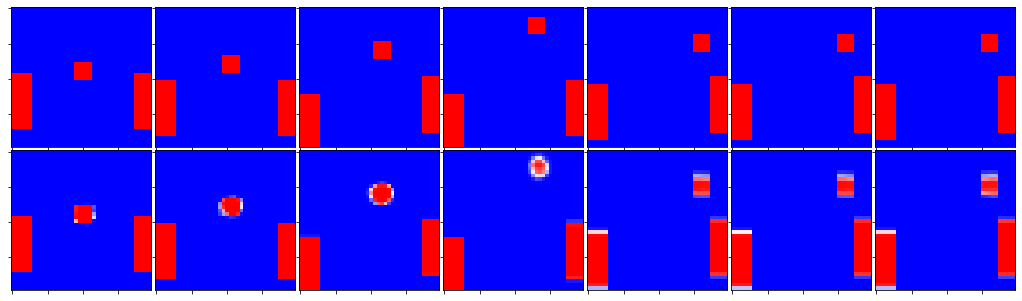

Epoch 594/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0327 - mean_squared_error: 0.0093 - acc: 0.9875 - val_loss: 0.0344 - val_mean_squared_error: 0.0095 - val_acc: 0.9871


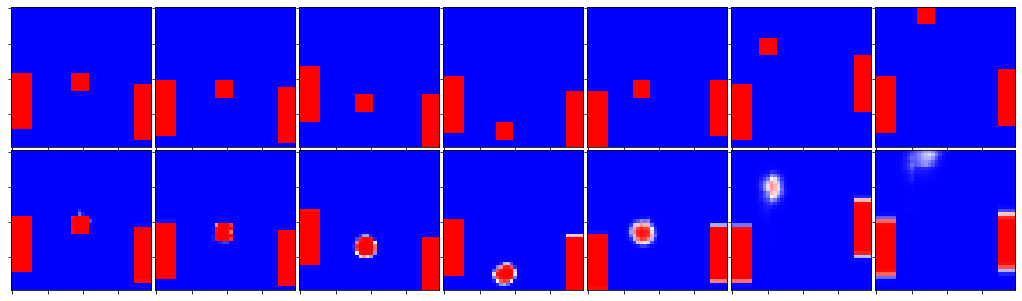

Epoch 595/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0304 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0323 - val_mean_squared_error: 0.0094 - val_acc: 0.9876


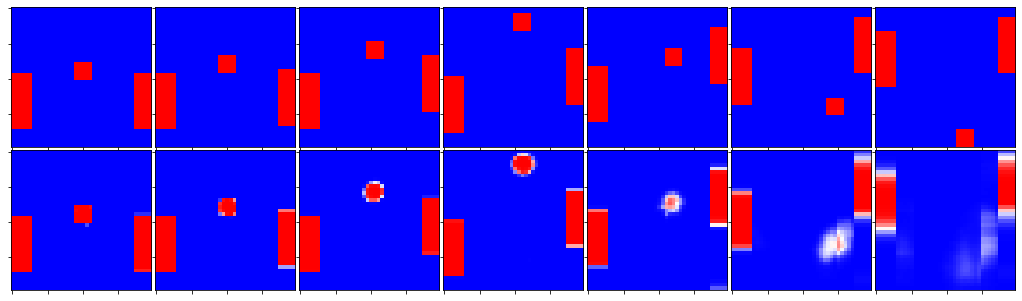

Epoch 596/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0309 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0344 - val_mean_squared_error: 0.0097 - val_acc: 0.9872


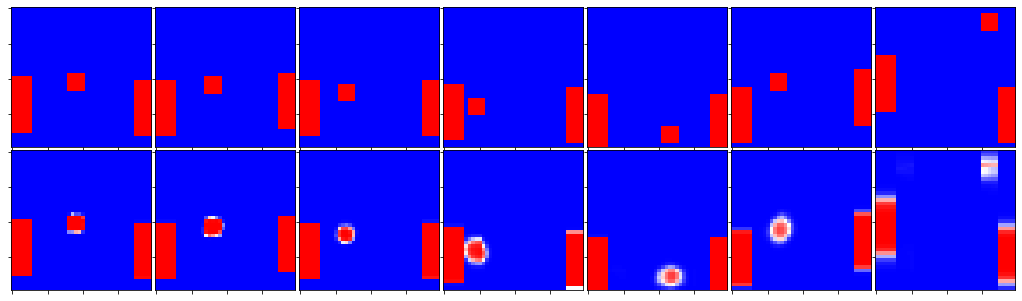

Epoch 597/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0339 - val_mean_squared_error: 0.0098 - val_acc: 0.9872


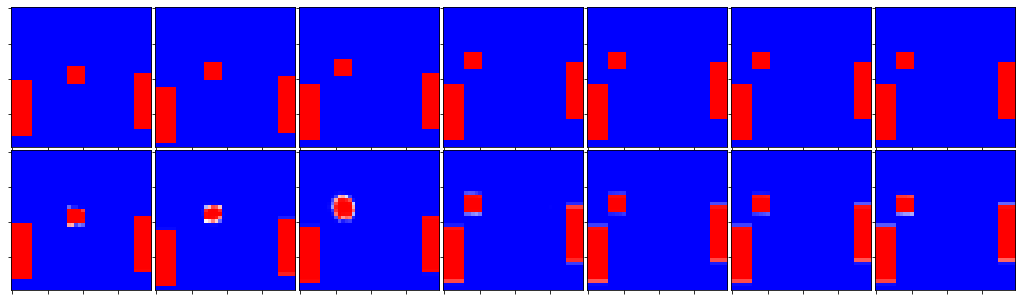

Epoch 598/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0301 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0319 - val_mean_squared_error: 0.0090 - val_acc: 0.9883


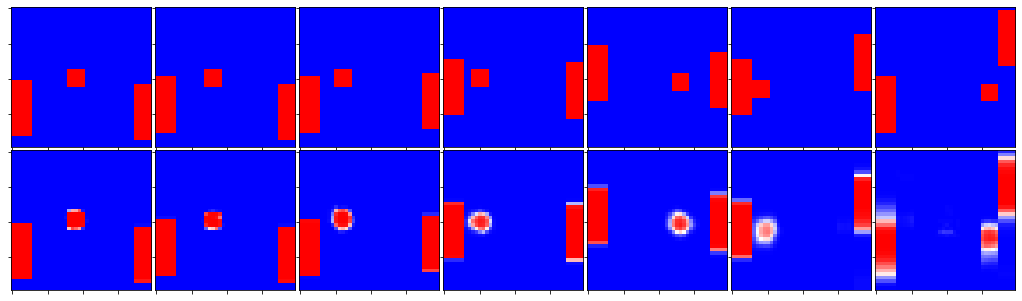

Epoch 599/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0308 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0349 - val_mean_squared_error: 0.0098 - val_acc: 0.9870


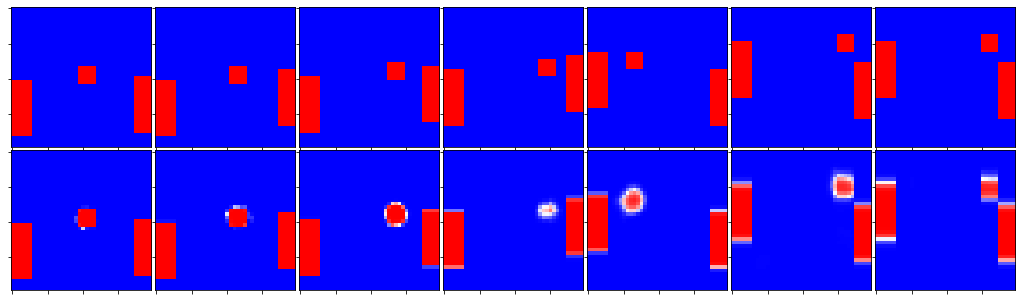

Epoch 600/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0326 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0326 - val_mean_squared_error: 0.0096 - val_acc: 0.9870


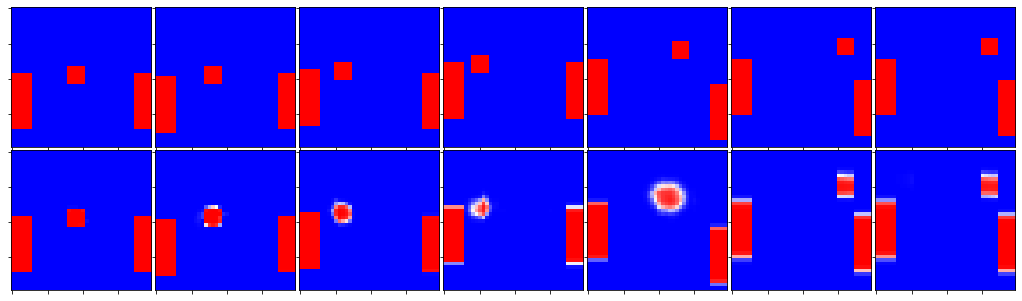

Epoch 601/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0307 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0363 - val_mean_squared_error: 0.0104 - val_acc: 0.9857


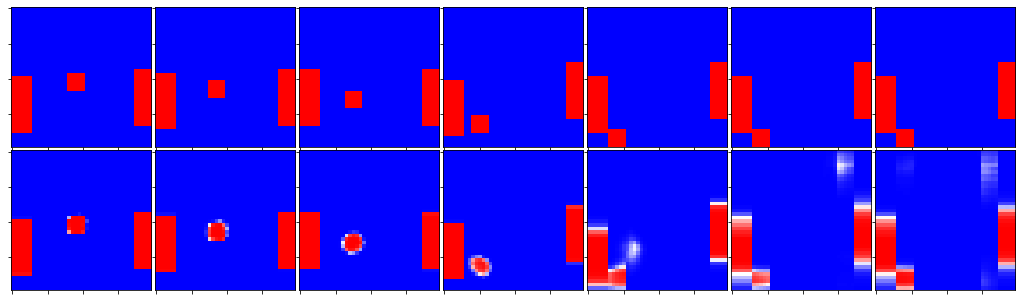

Epoch 602/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0297 - mean_squared_error: 0.0085 - acc: 0.9887 - val_loss: 0.0341 - val_mean_squared_error: 0.0097 - val_acc: 0.9870


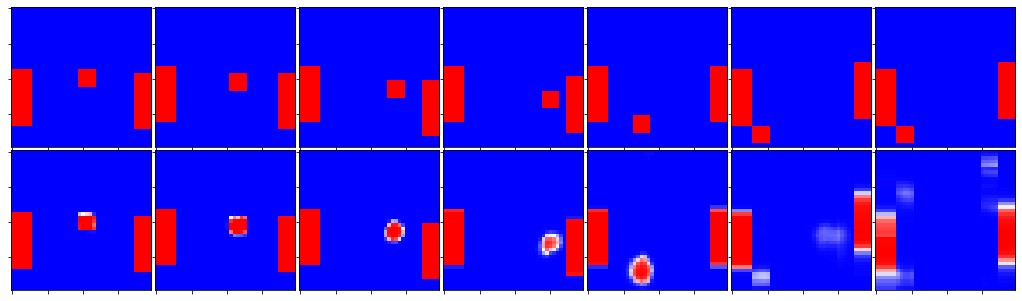

Epoch 603/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0308 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0312 - val_mean_squared_error: 0.0092 - val_acc: 0.9880


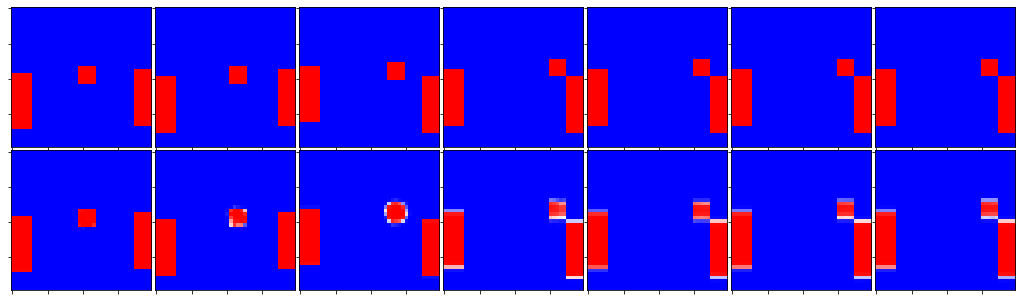

Epoch 604/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0304 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0484 - val_mean_squared_error: 0.0134 - val_acc: 0.9823


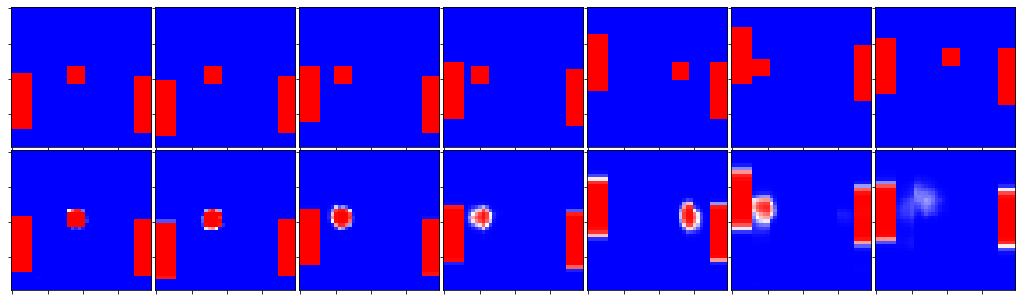

Epoch 605/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0305 - mean_squared_error: 0.0087 - acc: 0.9885 - val_loss: 0.0284 - val_mean_squared_error: 0.0082 - val_acc: 0.9889


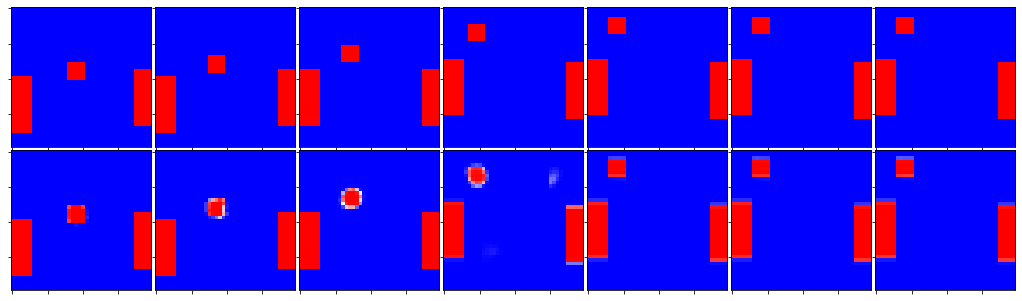

Epoch 606/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0357 - mean_squared_error: 0.0101 - acc: 0.9864 - val_loss: 0.0316 - val_mean_squared_error: 0.0091 - val_acc: 0.9877


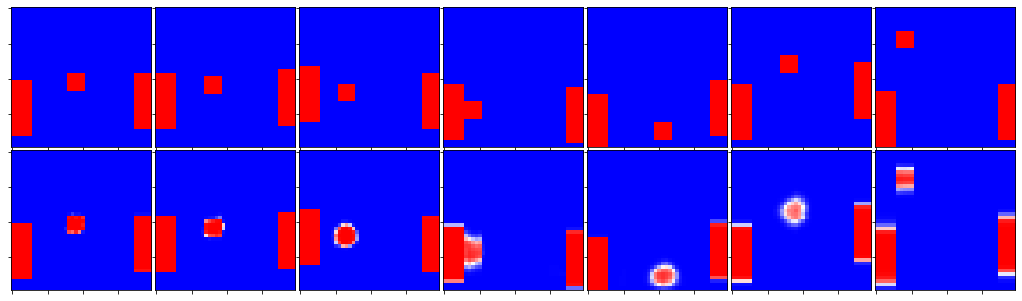

Epoch 607/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0309 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0303 - val_mean_squared_error: 0.0087 - val_acc: 0.9885


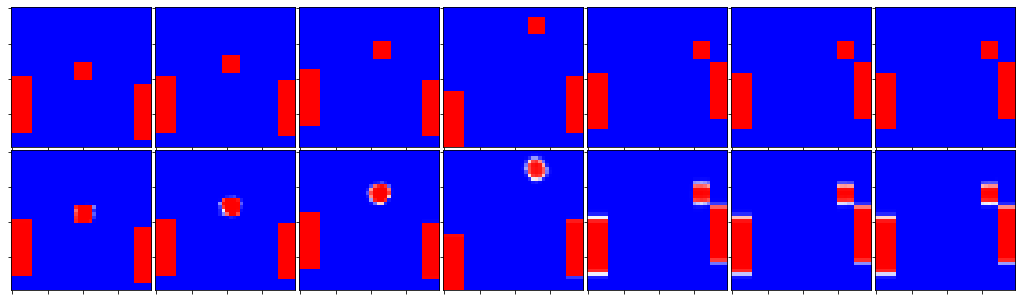

Epoch 608/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0310 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0276 - val_mean_squared_error: 0.0080 - val_acc: 0.9892


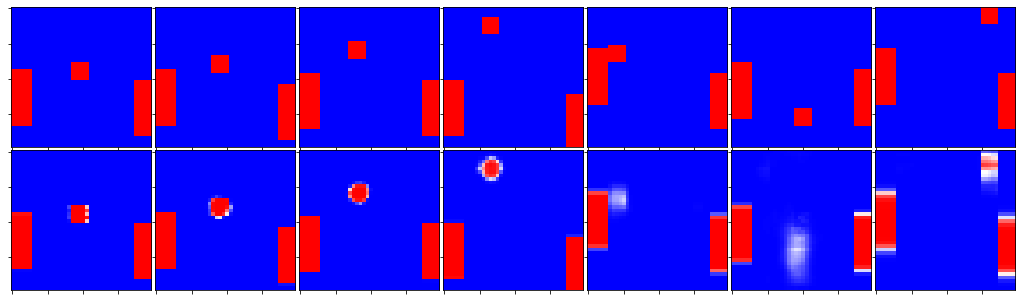

Epoch 609/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0318 - mean_squared_error: 0.0091 - acc: 0.9877 - val_loss: 0.0277 - val_mean_squared_error: 0.0080 - val_acc: 0.9892


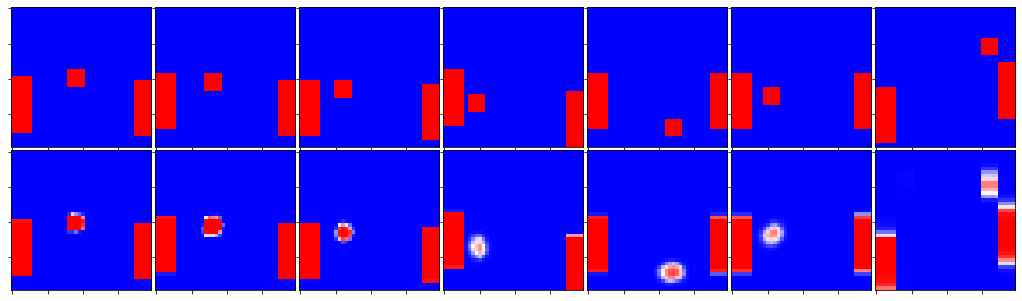

Epoch 610/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0305 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0287 - val_mean_squared_error: 0.0085 - val_acc: 0.9884


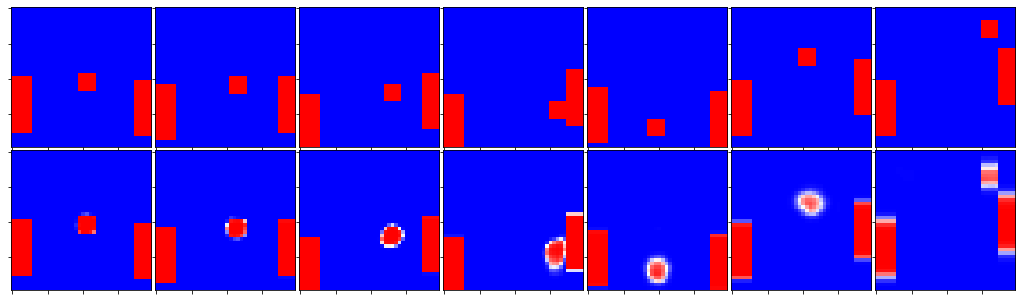

Epoch 611/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0297 - val_mean_squared_error: 0.0082 - val_acc: 0.9891


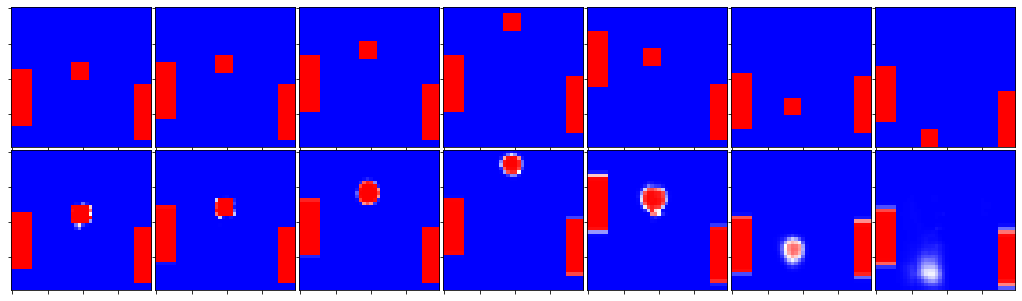

Epoch 612/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0307 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0392 - val_mean_squared_error: 0.0101 - val_acc: 0.9872


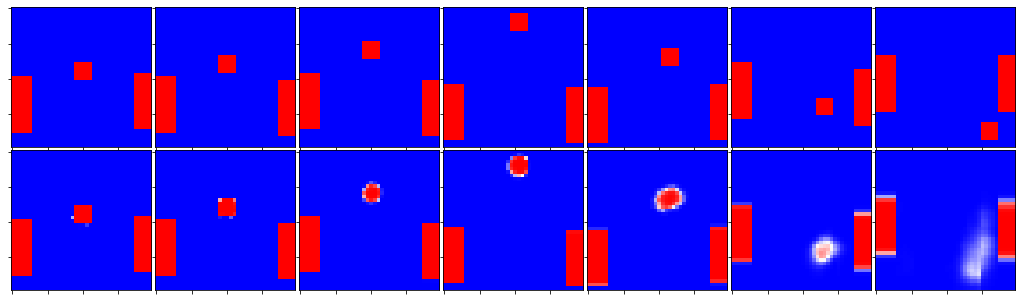

Epoch 613/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0352 - mean_squared_error: 0.0097 - acc: 0.9871 - val_loss: 0.0557 - val_mean_squared_error: 0.0156 - val_acc: 0.9791


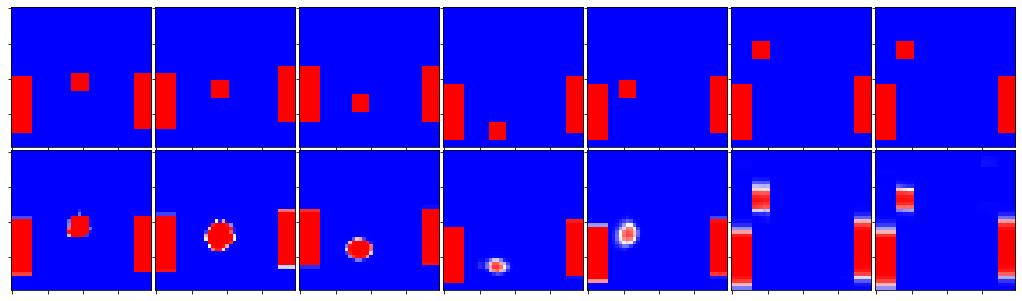

Epoch 614/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0774 - mean_squared_error: 0.0190 - acc: 0.9754 - val_loss: 0.0806 - val_mean_squared_error: 0.0217 - val_acc: 0.9712


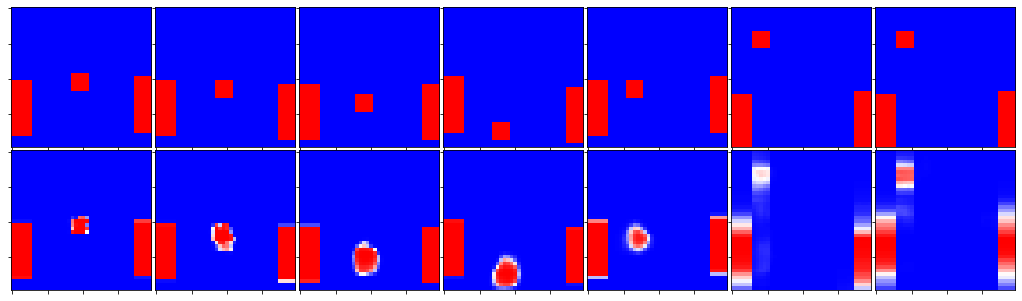

Epoch 615/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0595 - mean_squared_error: 0.0167 - acc: 0.9775 - val_loss: 0.0455 - val_mean_squared_error: 0.0133 - val_acc: 0.9821


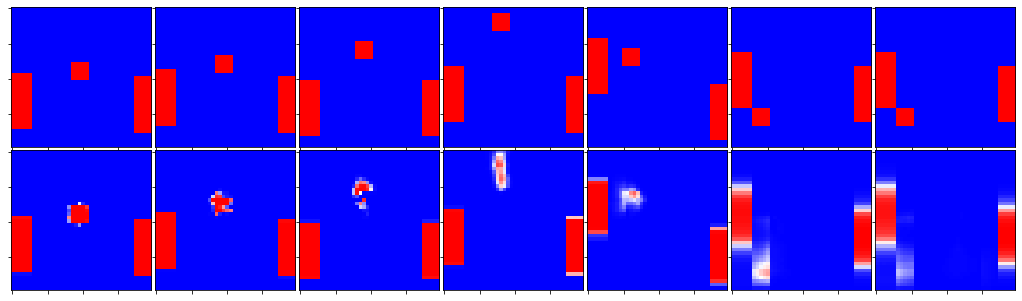

Epoch 616/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.1461 - mean_squared_error: 0.0311 - acc: 0.9607 - val_loss: 0.1318 - val_mean_squared_error: 0.0306 - val_acc: 0.9609


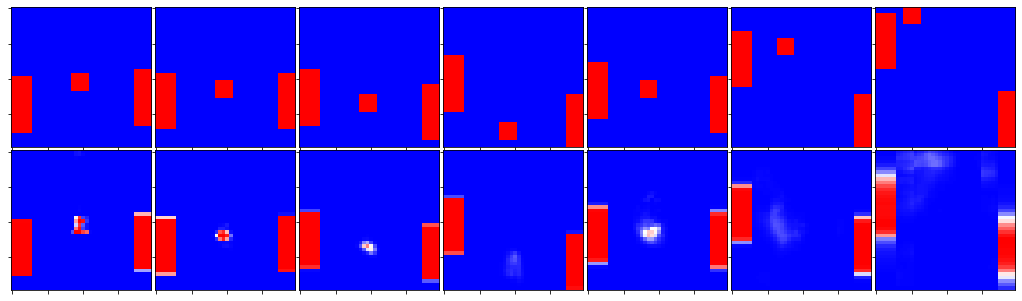

Epoch 617/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0937 - mean_squared_error: 0.0236 - acc: 0.9695 - val_loss: 0.0894 - val_mean_squared_error: 0.0214 - val_acc: 0.9724


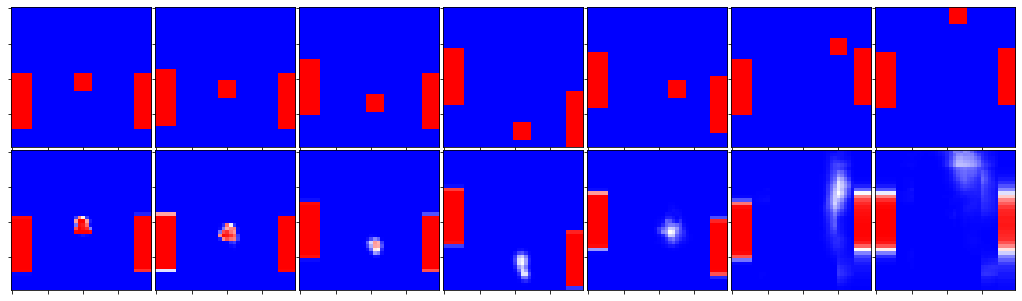

Epoch 618/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0735 - mean_squared_error: 0.0194 - acc: 0.9746 - val_loss: 0.0628 - val_mean_squared_error: 0.0176 - val_acc: 0.9768


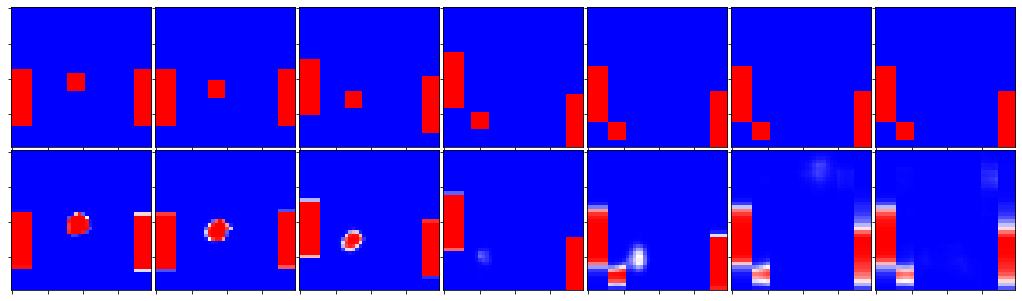

Epoch 619/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0614 - mean_squared_error: 0.0168 - acc: 0.9779 - val_loss: 0.0655 - val_mean_squared_error: 0.0180 - val_acc: 0.9763


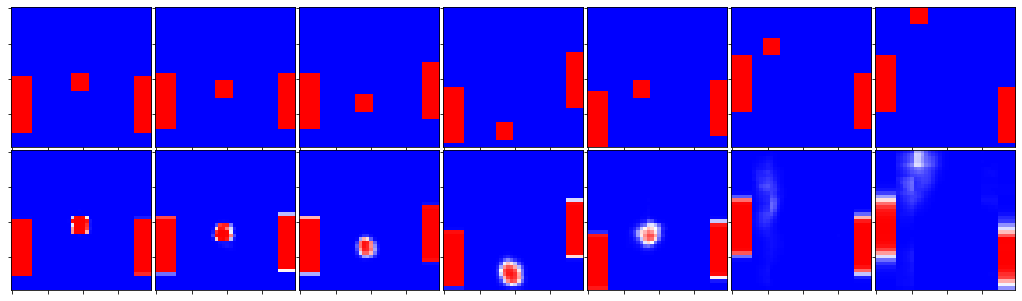

Epoch 620/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0556 - mean_squared_error: 0.0154 - acc: 0.9796 - val_loss: 0.0486 - val_mean_squared_error: 0.0139 - val_acc: 0.9815


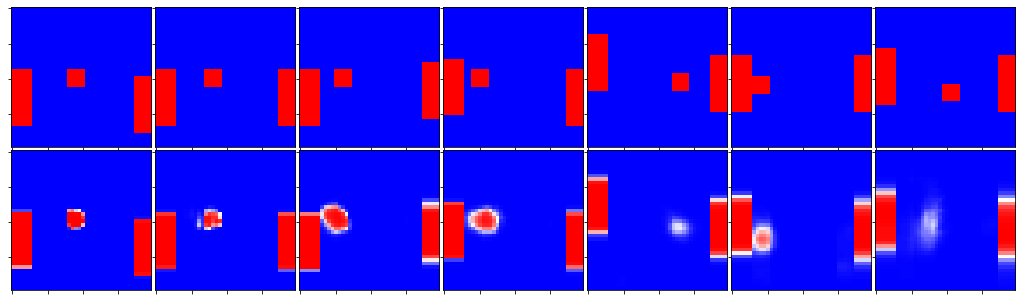

Epoch 621/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0519 - mean_squared_error: 0.0146 - acc: 0.9807 - val_loss: 0.0488 - val_mean_squared_error: 0.0140 - val_acc: 0.9814


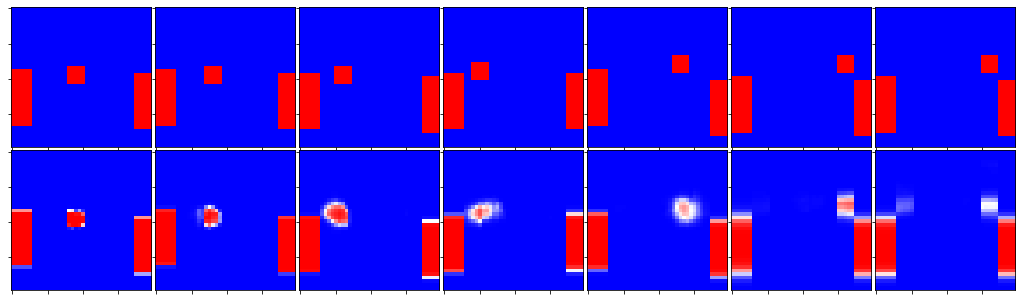

Epoch 622/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0489 - mean_squared_error: 0.0139 - acc: 0.9815 - val_loss: 0.0541 - val_mean_squared_error: 0.0147 - val_acc: 0.9805


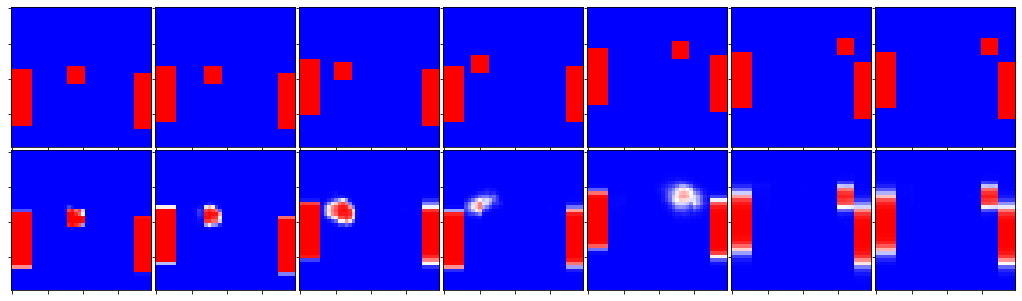

Epoch 623/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0466 - mean_squared_error: 0.0133 - acc: 0.9822 - val_loss: 0.0424 - val_mean_squared_error: 0.0122 - val_acc: 0.9837


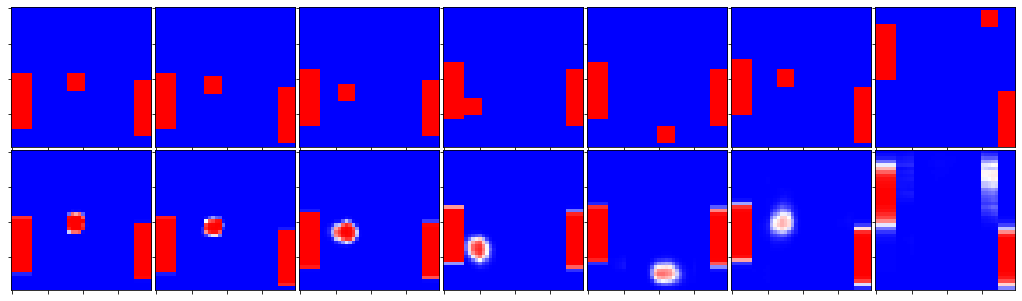

Epoch 624/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0451 - mean_squared_error: 0.0129 - acc: 0.9828 - val_loss: 0.0488 - val_mean_squared_error: 0.0137 - val_acc: 0.9819


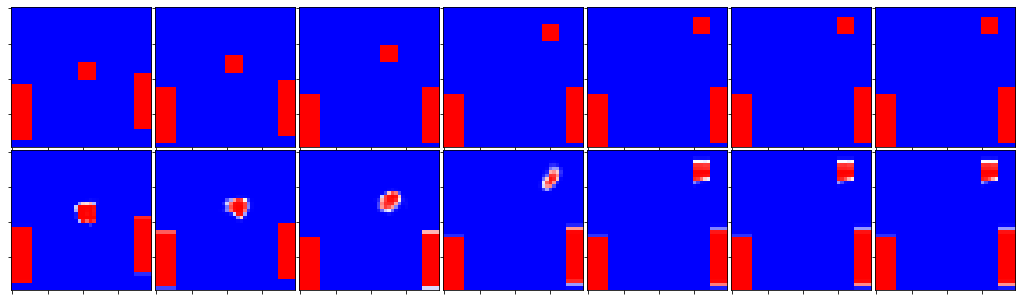

Epoch 625/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0427 - mean_squared_error: 0.0122 - acc: 0.9837 - val_loss: 0.0480 - val_mean_squared_error: 0.0128 - val_acc: 0.9834


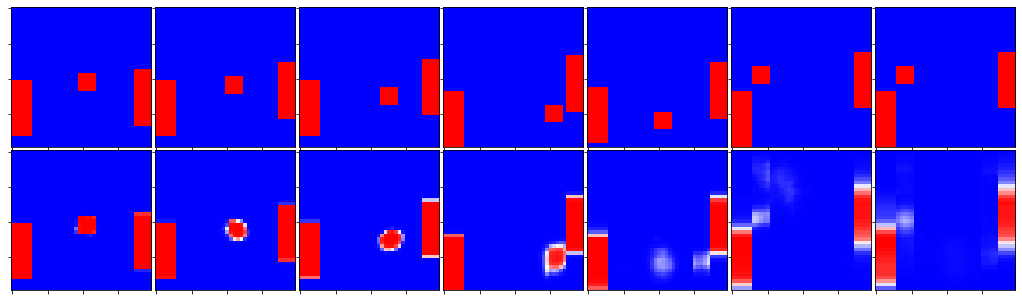

Epoch 626/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0414 - mean_squared_error: 0.0119 - acc: 0.9841 - val_loss: 0.0439 - val_mean_squared_error: 0.0123 - val_acc: 0.9835


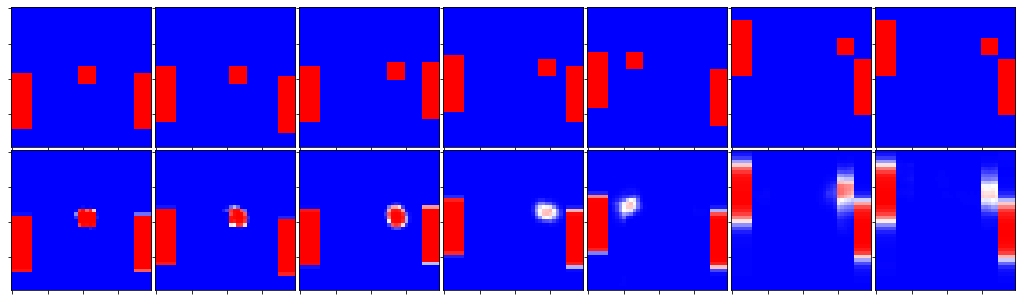

Epoch 627/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0407 - mean_squared_error: 0.0117 - acc: 0.9844 - val_loss: 0.0397 - val_mean_squared_error: 0.0112 - val_acc: 0.9852


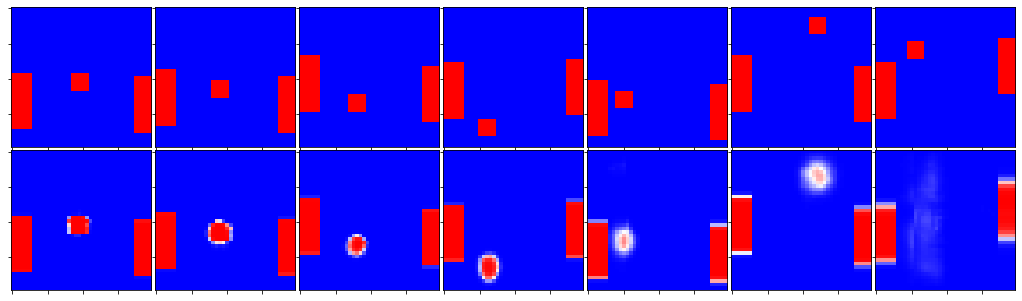

Epoch 628/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0401 - mean_squared_error: 0.0115 - acc: 0.9845 - val_loss: 0.0480 - val_mean_squared_error: 0.0122 - val_acc: 0.9840


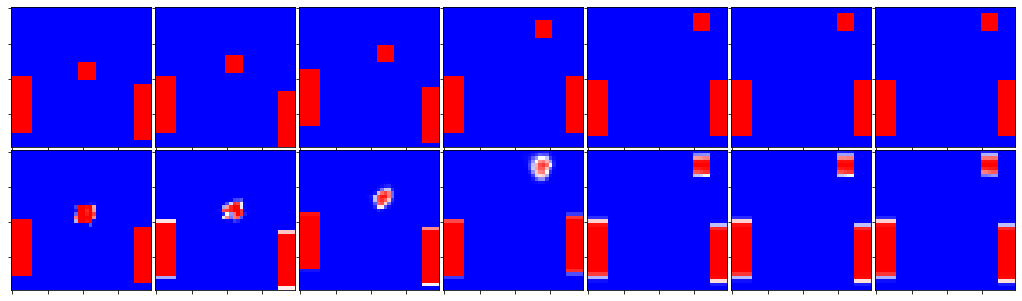

Epoch 629/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0395 - mean_squared_error: 0.0113 - acc: 0.9849 - val_loss: 0.0424 - val_mean_squared_error: 0.0120 - val_acc: 0.9842


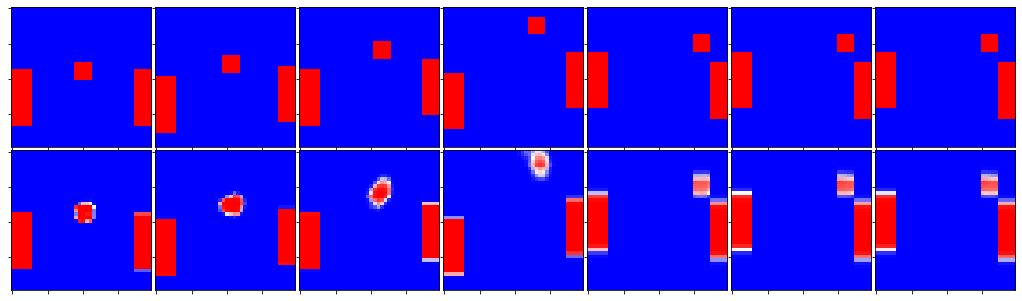

Epoch 630/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0378 - mean_squared_error: 0.0109 - acc: 0.9855 - val_loss: 0.0388 - val_mean_squared_error: 0.0112 - val_acc: 0.9851


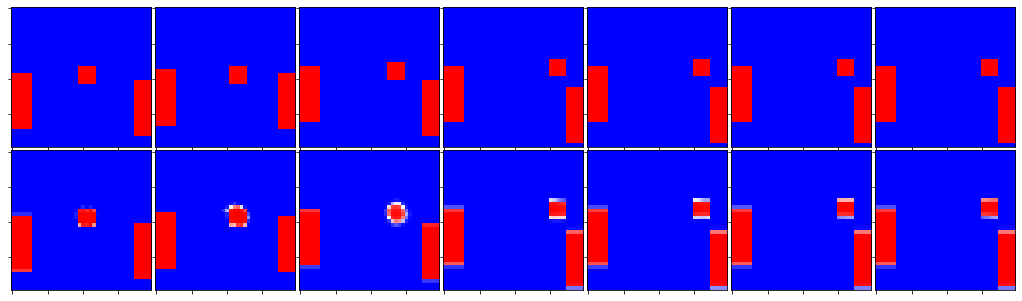

Epoch 631/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0373 - mean_squared_error: 0.0107 - acc: 0.9858 - val_loss: 0.0390 - val_mean_squared_error: 0.0109 - val_acc: 0.9854


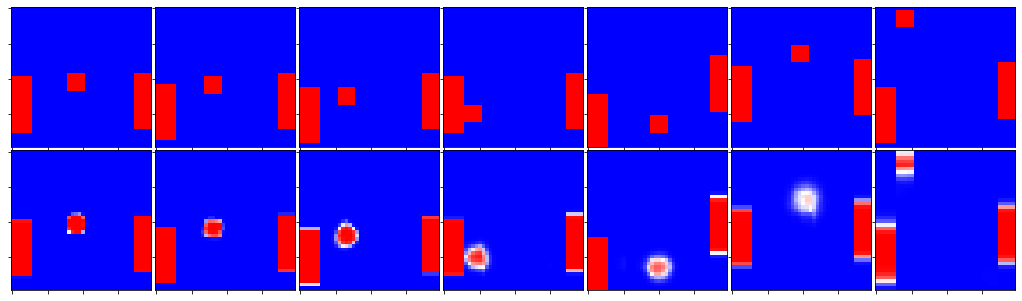

Epoch 632/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0369 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0360 - val_mean_squared_error: 0.0105 - val_acc: 0.9859


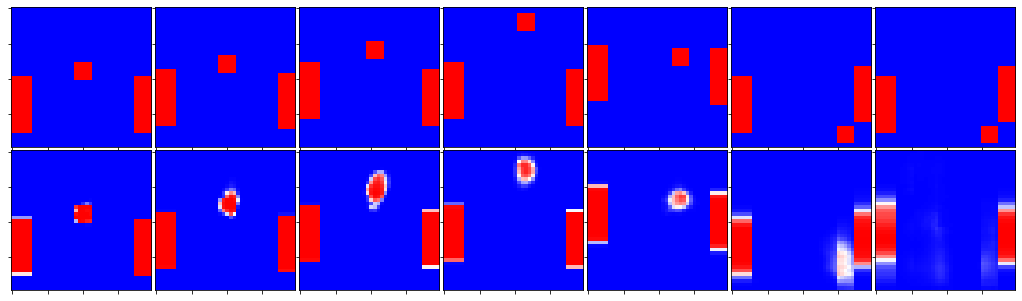

Epoch 633/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0362 - mean_squared_error: 0.0104 - acc: 0.9861 - val_loss: 0.0389 - val_mean_squared_error: 0.0110 - val_acc: 0.9854


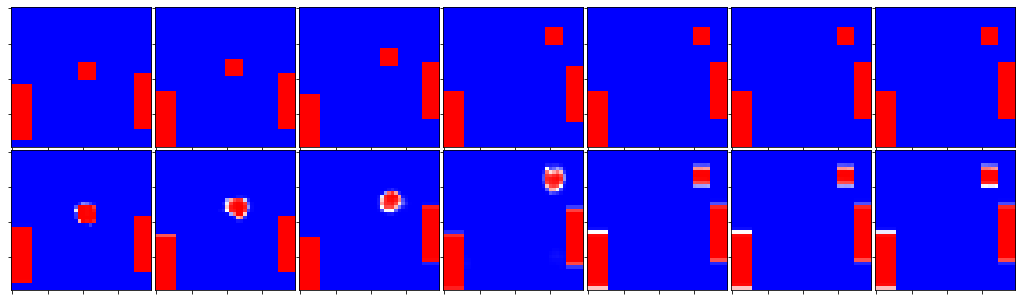

Epoch 634/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0364 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0371 - val_mean_squared_error: 0.0102 - val_acc: 0.9868


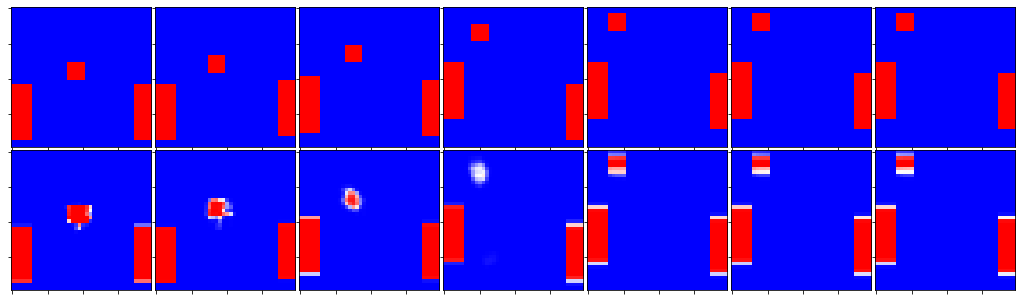

Epoch 635/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0366 - mean_squared_error: 0.0105 - acc: 0.9860 - val_loss: 0.0345 - val_mean_squared_error: 0.0099 - val_acc: 0.9869


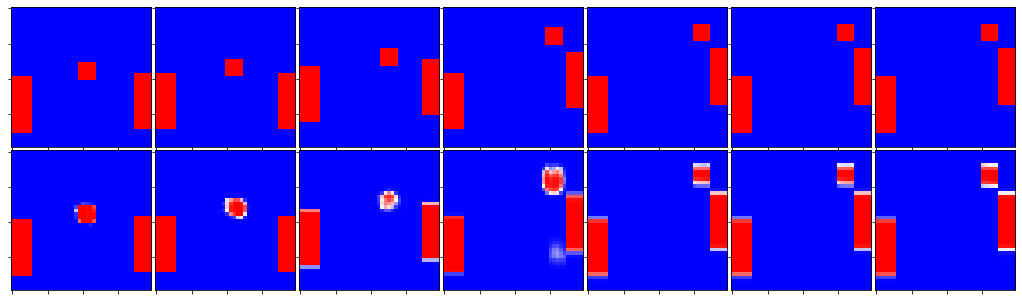

Epoch 636/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0373 - mean_squared_error: 0.0106 - acc: 0.9859 - val_loss: 0.0334 - val_mean_squared_error: 0.0099 - val_acc: 0.9866


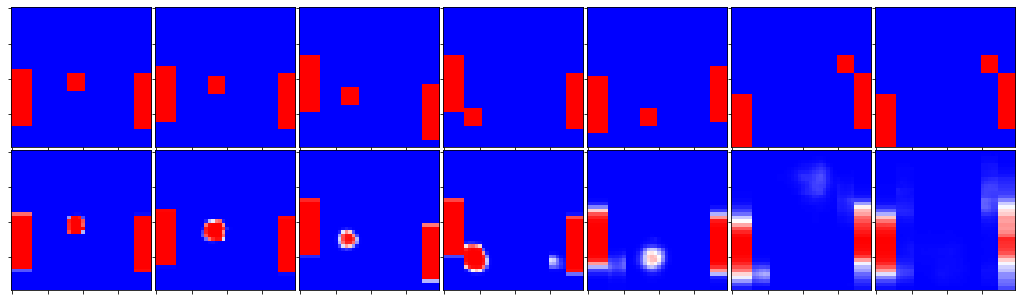

Epoch 637/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0345 - mean_squared_error: 0.0099 - acc: 0.9868 - val_loss: 0.0395 - val_mean_squared_error: 0.0113 - val_acc: 0.9853


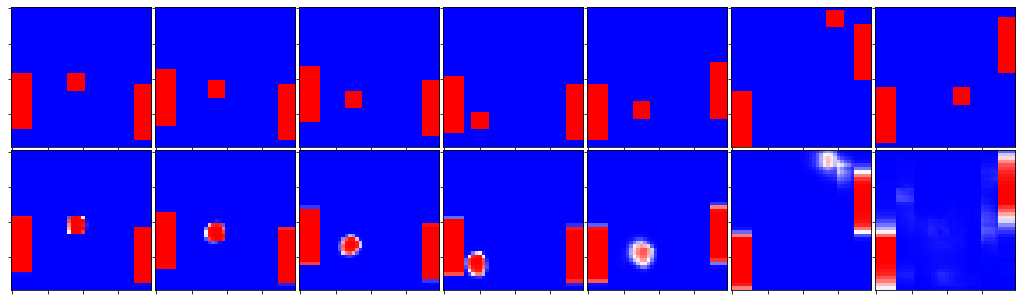

Epoch 638/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0355 - mean_squared_error: 0.0101 - acc: 0.9866 - val_loss: 0.0343 - val_mean_squared_error: 0.0099 - val_acc: 0.9869


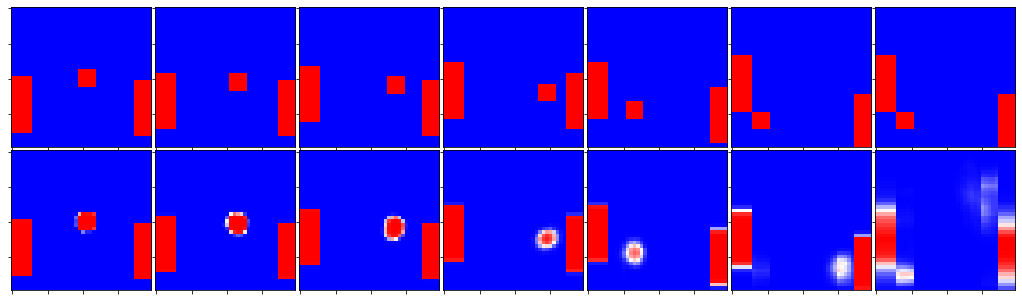

Epoch 639/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0341 - mean_squared_error: 0.0098 - acc: 0.9870 - val_loss: 0.0306 - val_mean_squared_error: 0.0088 - val_acc: 0.9885


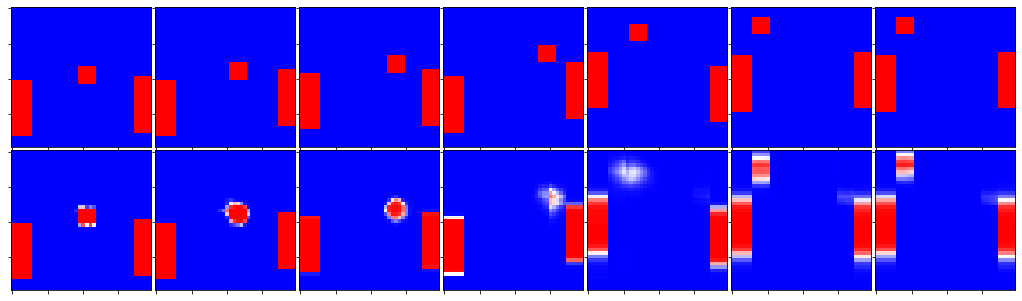

Epoch 640/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0340 - mean_squared_error: 0.0097 - acc: 0.9870 - val_loss: 0.0333 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


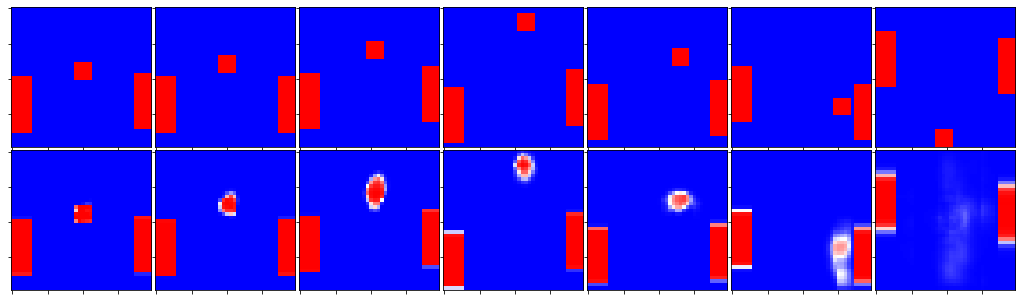

Epoch 641/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0332 - mean_squared_error: 0.0095 - acc: 0.9874 - val_loss: 0.0320 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


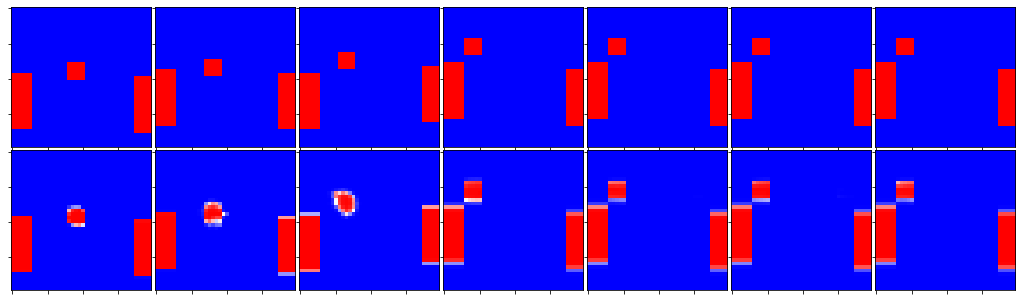

Epoch 642/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0328 - mean_squared_error: 0.0094 - acc: 0.9876 - val_loss: 0.0399 - val_mean_squared_error: 0.0113 - val_acc: 0.9848


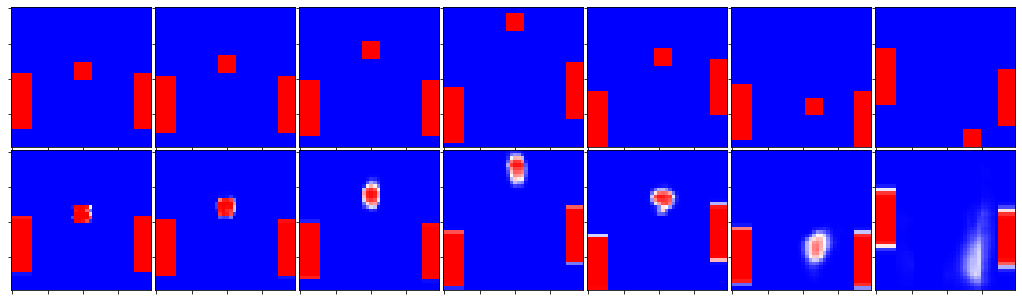

Epoch 643/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0348 - mean_squared_error: 0.0099 - acc: 0.9867 - val_loss: 0.0309 - val_mean_squared_error: 0.0090 - val_acc: 0.9879


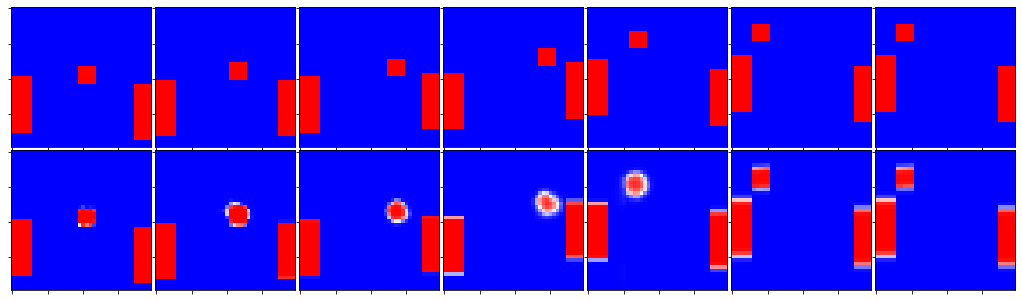

Epoch 644/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9873 - val_loss: 0.0334 - val_mean_squared_error: 0.0097 - val_acc: 0.9870


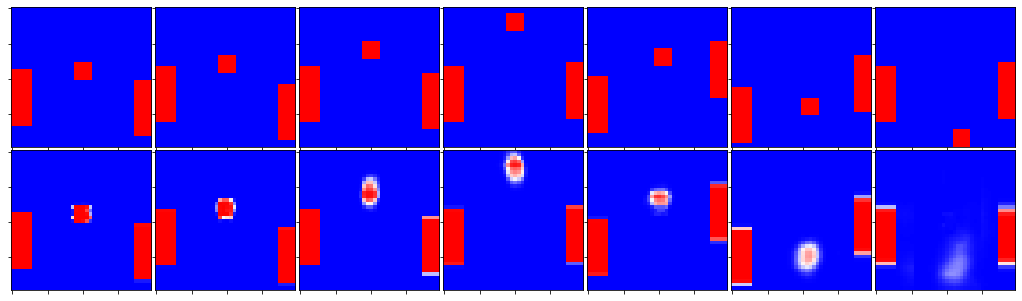

Epoch 645/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0329 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0376 - val_mean_squared_error: 0.0108 - val_acc: 0.9855


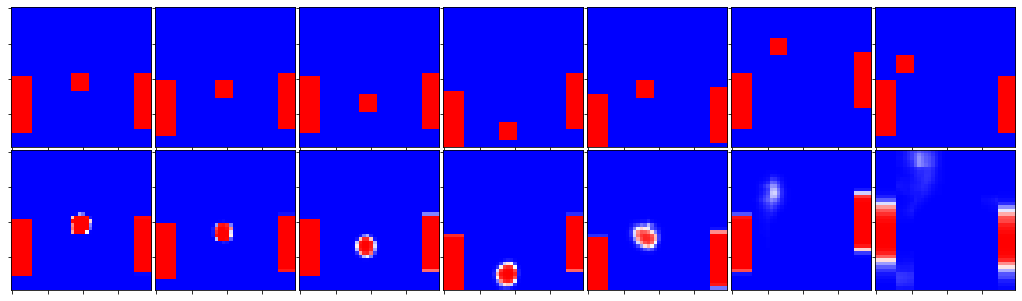

Epoch 646/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0310 - val_mean_squared_error: 0.0091 - val_acc: 0.9878


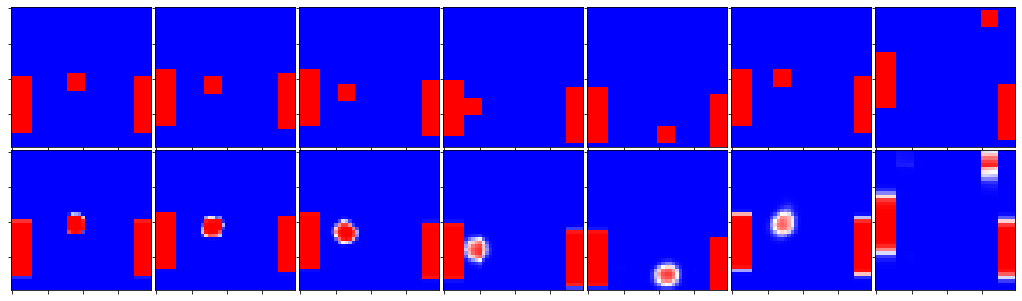

Epoch 647/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0333 - mean_squared_error: 0.0095 - acc: 0.9873 - val_loss: 0.0289 - val_mean_squared_error: 0.0082 - val_acc: 0.9891


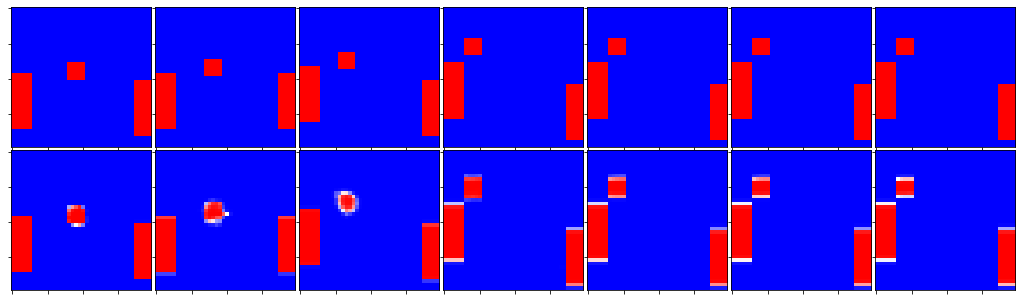

Epoch 648/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0320 - mean_squared_error: 0.0091 - acc: 0.9879 - val_loss: 0.0401 - val_mean_squared_error: 0.0107 - val_acc: 0.9859


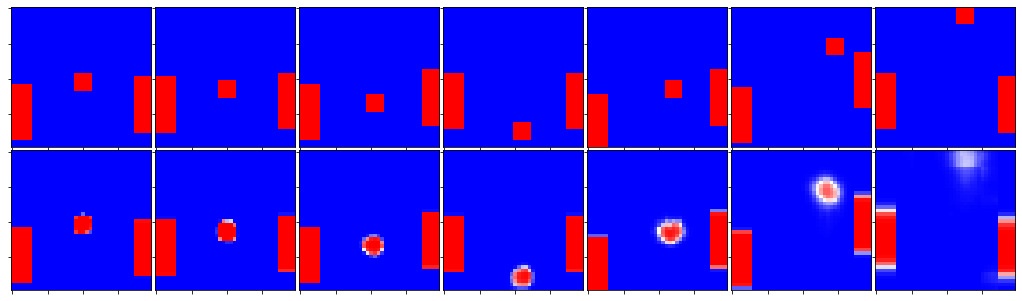

Epoch 649/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0337 - mean_squared_error: 0.0096 - acc: 0.9872 - val_loss: 0.0333 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


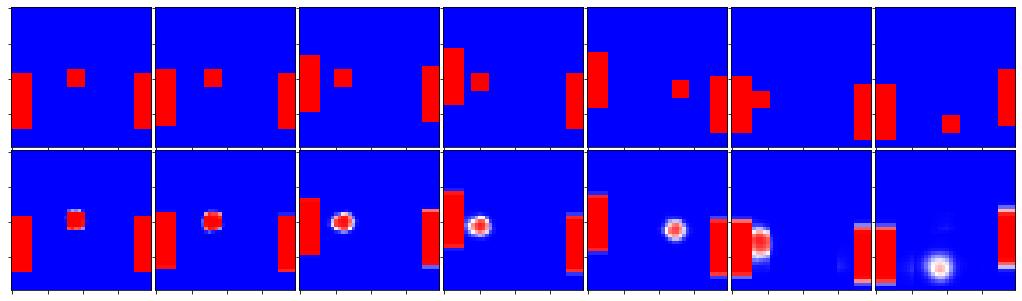

Epoch 650/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0327 - mean_squared_error: 0.0094 - acc: 0.9874 - val_loss: 0.0325 - val_mean_squared_error: 0.0093 - val_acc: 0.9876


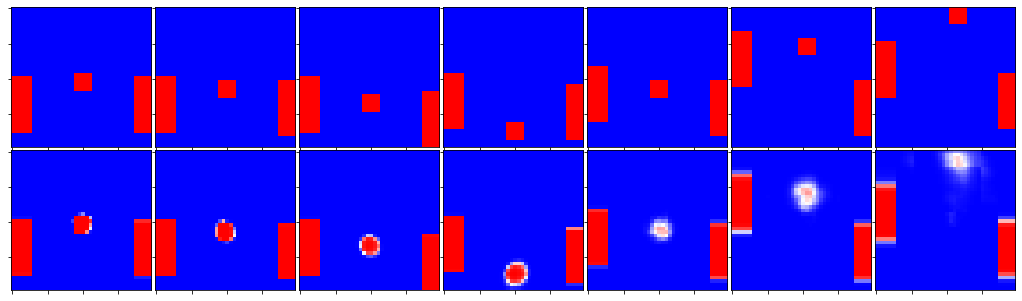

Epoch 651/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9882 - val_loss: 0.0356 - val_mean_squared_error: 0.0102 - val_acc: 0.9861


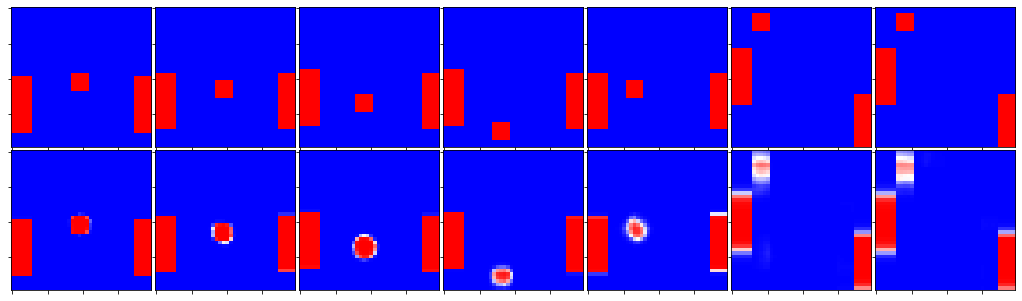

Epoch 652/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0330 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0366 - val_mean_squared_error: 0.0098 - val_acc: 0.9869


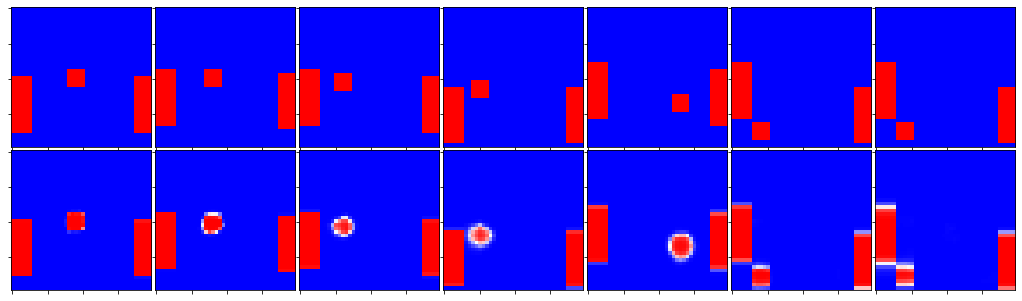

Epoch 653/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0324 - mean_squared_error: 0.0091 - acc: 0.9879 - val_loss: 0.0290 - val_mean_squared_error: 0.0086 - val_acc: 0.9886


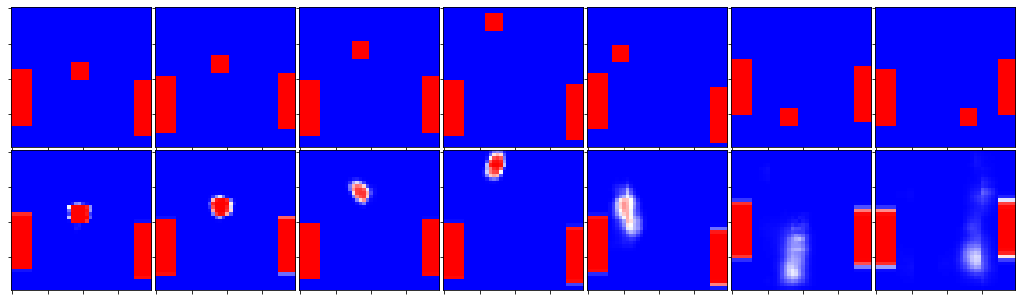

Epoch 654/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0317 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0302 - val_mean_squared_error: 0.0087 - val_acc: 0.9885


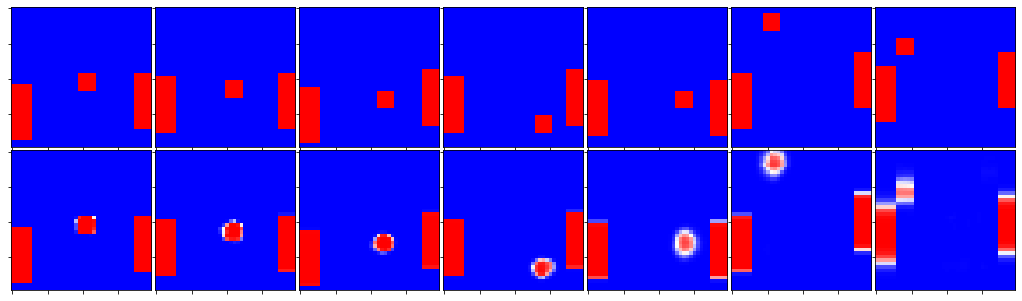

Epoch 655/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0307 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0344 - val_mean_squared_error: 0.0098 - val_acc: 0.9867


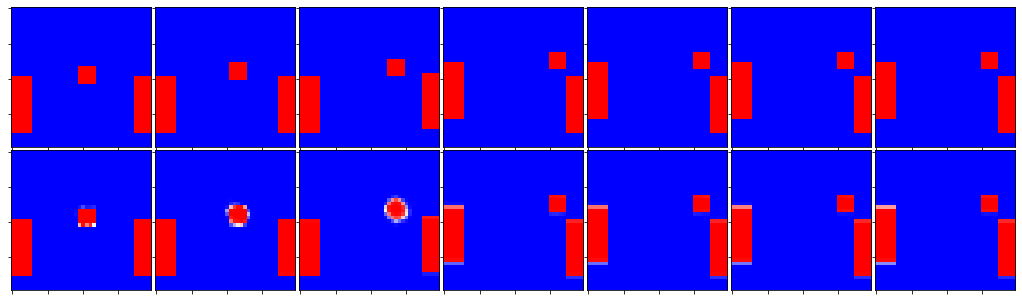

Epoch 656/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0346 - mean_squared_error: 0.0097 - acc: 0.9871 - val_loss: 0.0336 - val_mean_squared_error: 0.0095 - val_acc: 0.9873


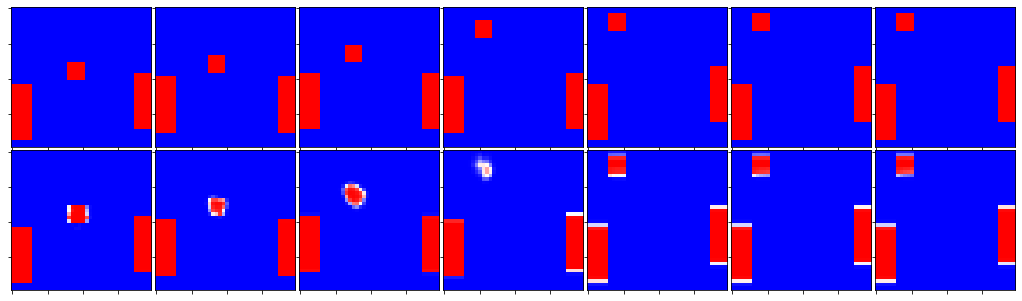

Epoch 657/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0330 - val_mean_squared_error: 0.0094 - val_acc: 0.9878


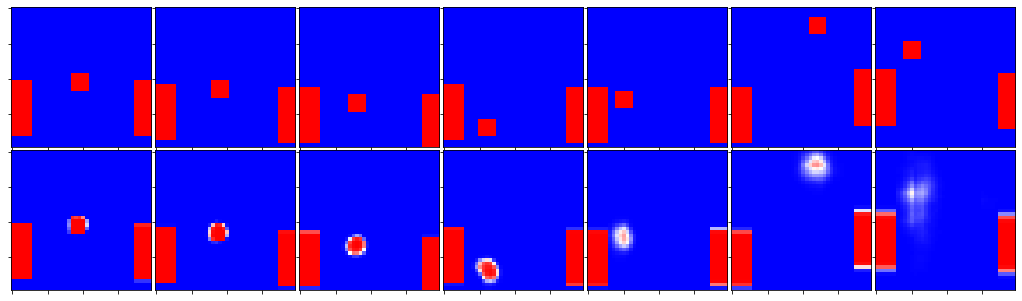

Epoch 658/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0322 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0317 - val_mean_squared_error: 0.0094 - val_acc: 0.9871


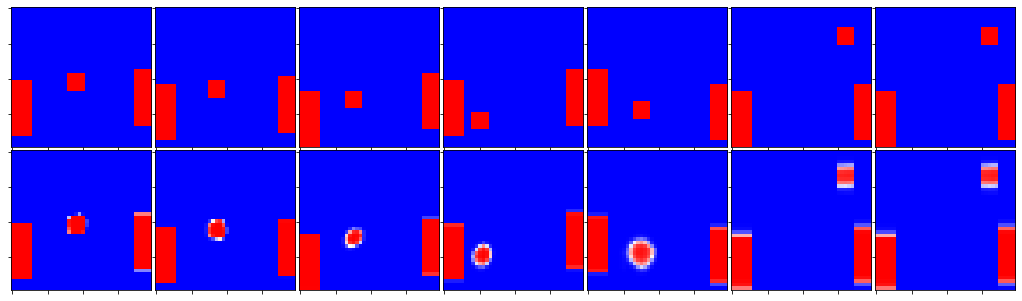

Epoch 659/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0339 - mean_squared_error: 0.0095 - acc: 0.9874 - val_loss: 0.0354 - val_mean_squared_error: 0.0102 - val_acc: 0.9864


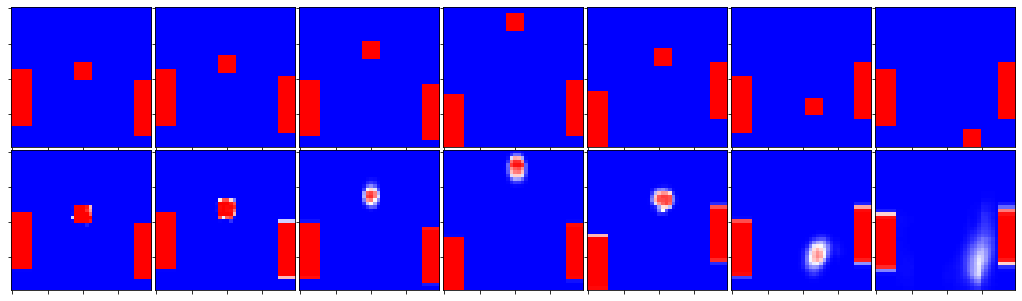

Epoch 660/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0320 - mean_squared_error: 0.0091 - acc: 0.9879 - val_loss: 0.0269 - val_mean_squared_error: 0.0079 - val_acc: 0.9894


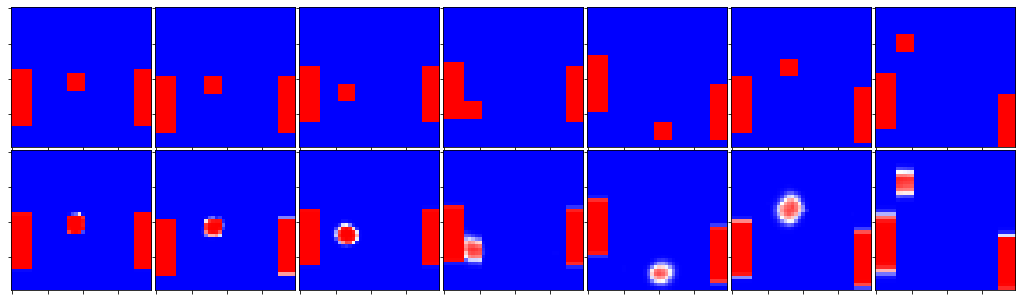

Epoch 661/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0314 - mean_squared_error: 0.0089 - acc: 0.9882 - val_loss: 0.0309 - val_mean_squared_error: 0.0090 - val_acc: 0.9881


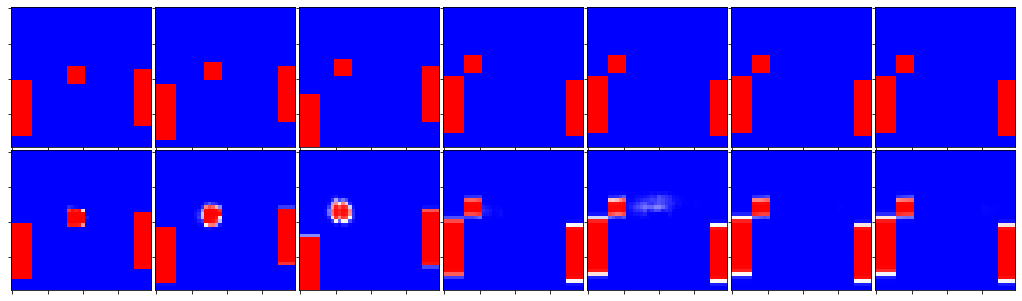

Epoch 662/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0300 - mean_squared_error: 0.0086 - acc: 0.9886 - val_loss: 0.0304 - val_mean_squared_error: 0.0090 - val_acc: 0.9878


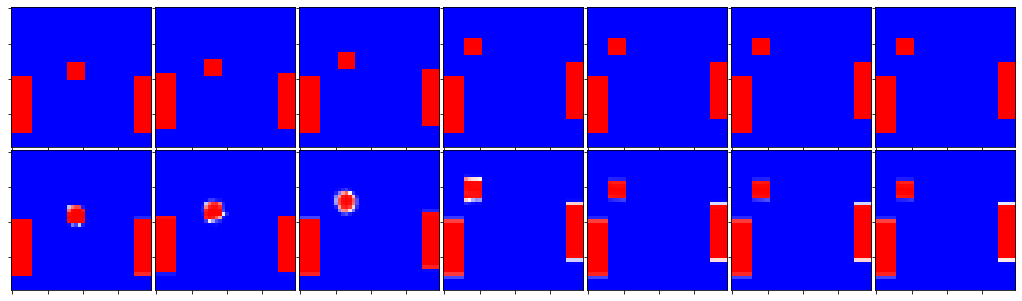

Epoch 663/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0314 - mean_squared_error: 0.0090 - acc: 0.9880 - val_loss: 0.0296 - val_mean_squared_error: 0.0085 - val_acc: 0.9888


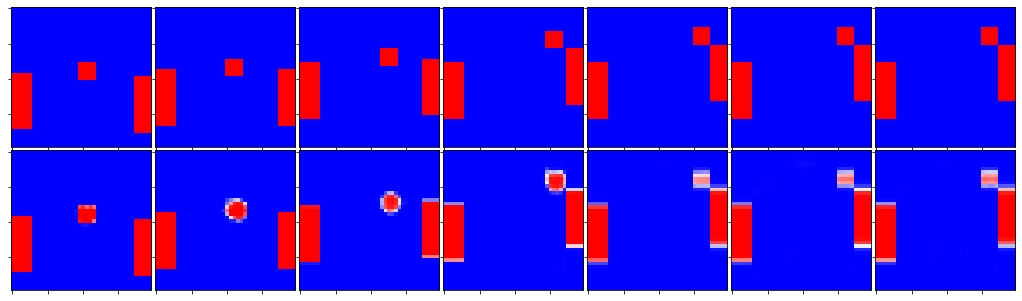

Epoch 664/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0310 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0280 - val_mean_squared_error: 0.0083 - val_acc: 0.9887


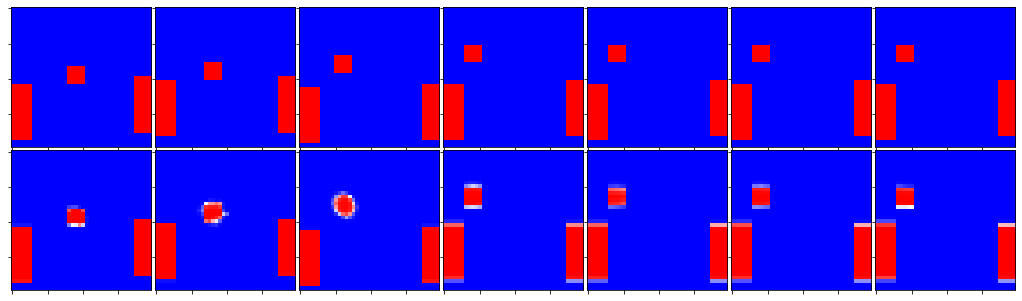

Epoch 665/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0311 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0298 - val_mean_squared_error: 0.0087 - val_acc: 0.9884


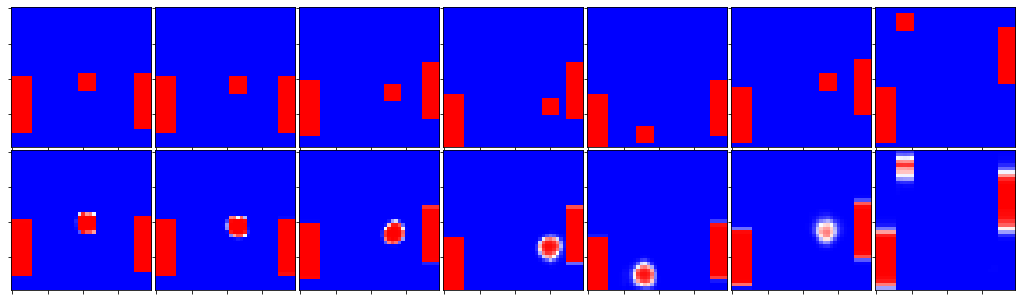

Epoch 666/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0304 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0328 - val_mean_squared_error: 0.0095 - val_acc: 0.9875


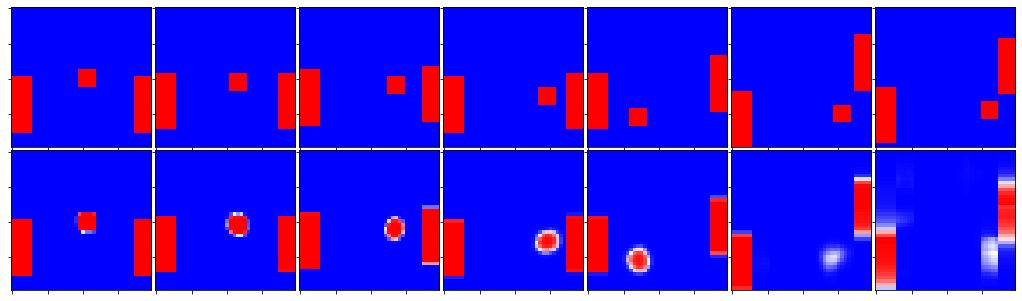

Epoch 667/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9886 - val_loss: 0.0270 - val_mean_squared_error: 0.0079 - val_acc: 0.9893


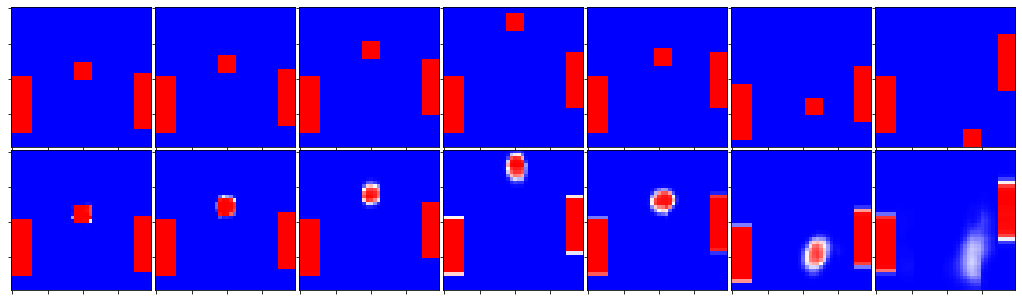

Epoch 668/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0306 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0295 - val_mean_squared_error: 0.0085 - val_acc: 0.9886


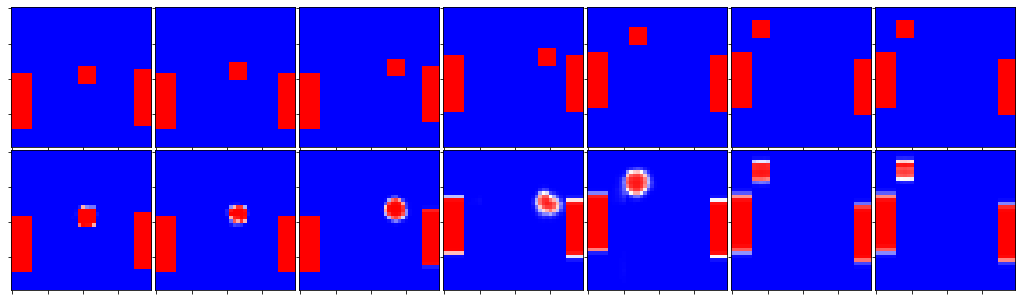

Epoch 669/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.0336 - mean_squared_error: 0.0093 - acc: 0.9876 - val_loss: 0.0360 - val_mean_squared_error: 0.0105 - val_acc: 0.9860


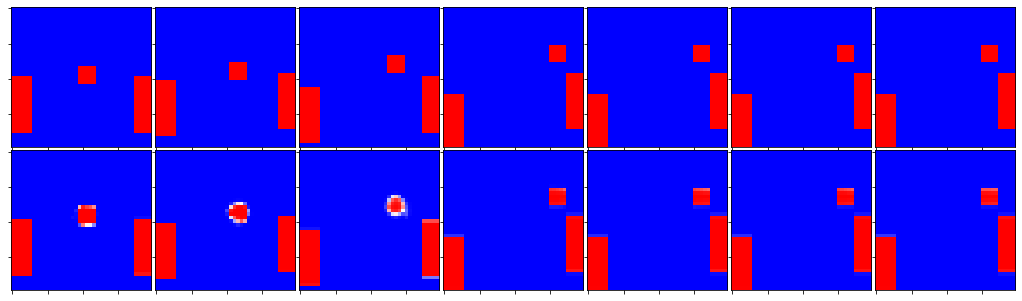

Epoch 670/2500
100/100 [==============================] - 84s 839ms/step - loss: 0.0327 - mean_squared_error: 0.0094 - acc: 0.9875 - val_loss: 0.0349 - val_mean_squared_error: 0.0095 - val_acc: 0.9874


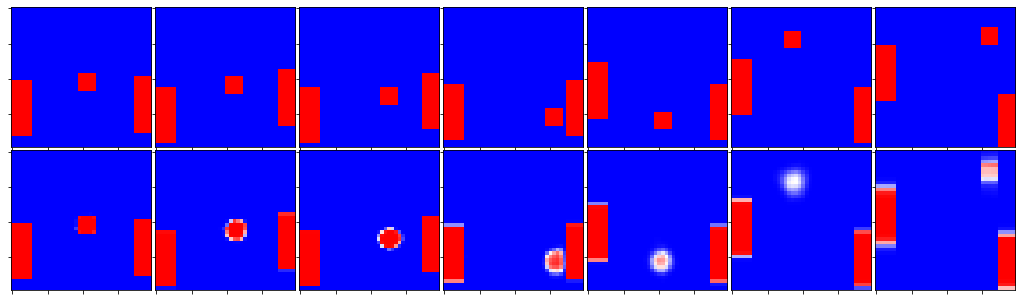

Epoch 671/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0302 - mean_squared_error: 0.0086 - acc: 0.9886 - val_loss: 0.0336 - val_mean_squared_error: 0.0093 - val_acc: 0.9878


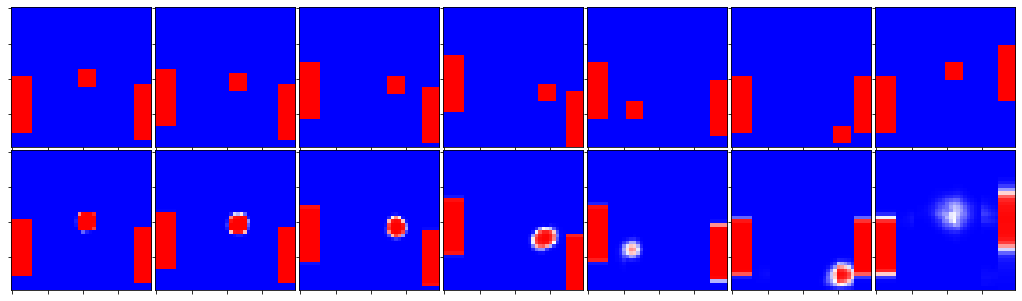

Epoch 672/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0311 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0292 - val_mean_squared_error: 0.0084 - val_acc: 0.9887


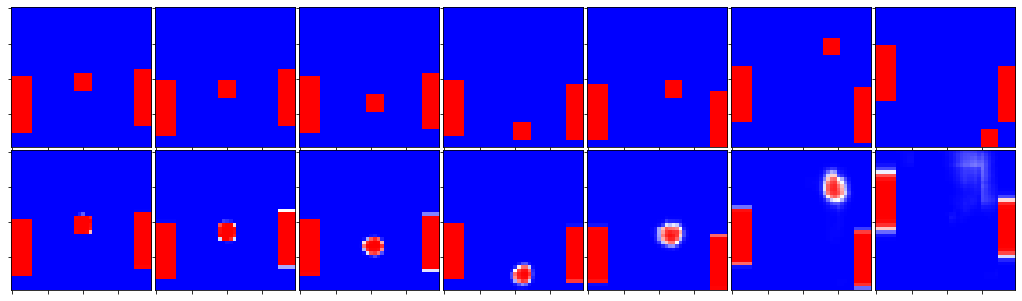

Epoch 673/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0310 - mean_squared_error: 0.0089 - acc: 0.9882 - val_loss: 0.0259 - val_mean_squared_error: 0.0076 - val_acc: 0.9900


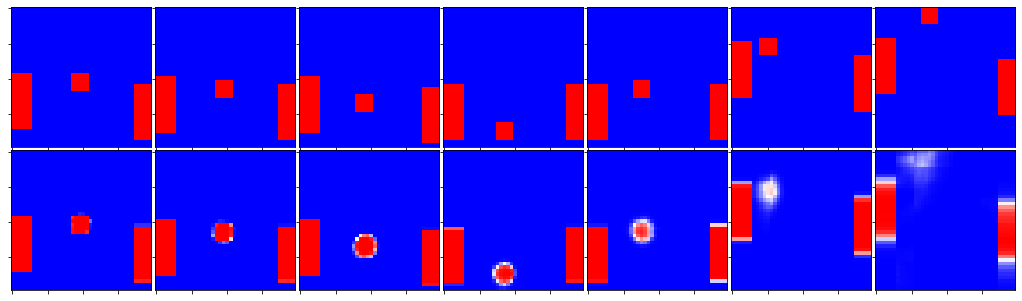

Epoch 674/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0316 - mean_squared_error: 0.0090 - acc: 0.9879 - val_loss: 0.0402 - val_mean_squared_error: 0.0094 - val_acc: 0.9878


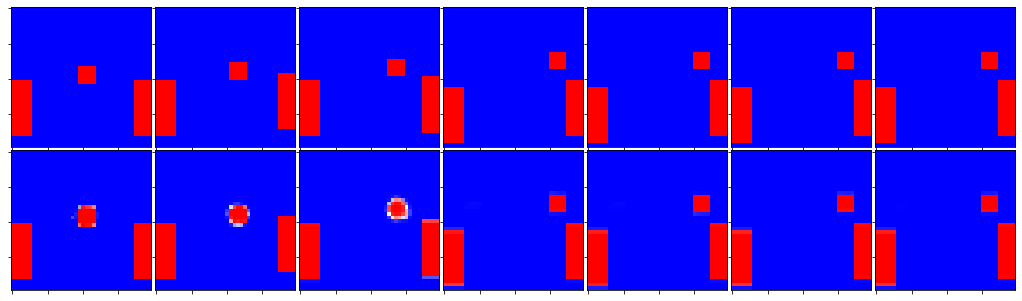

Epoch 675/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0319 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0311 - val_mean_squared_error: 0.0088 - val_acc: 0.9881


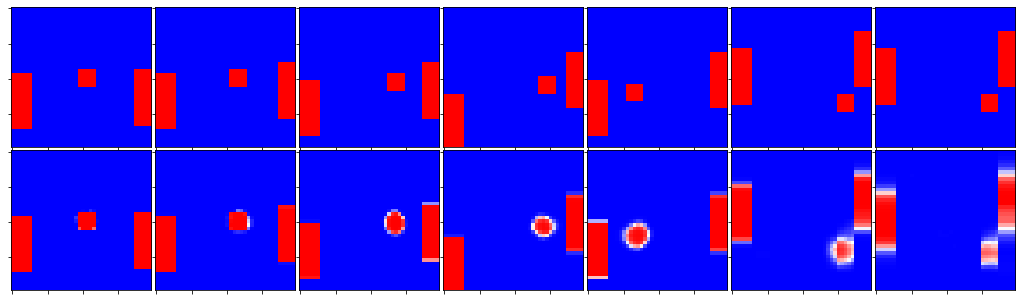

Epoch 676/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0309 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0338 - val_mean_squared_error: 0.0094 - val_acc: 0.9876


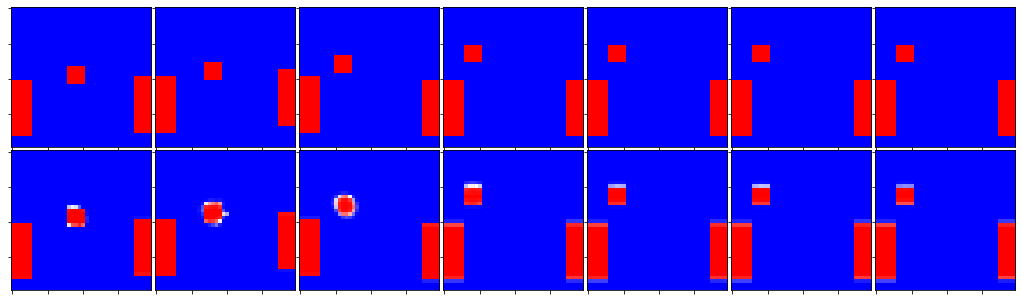

Epoch 677/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0327 - mean_squared_error: 0.0093 - acc: 0.9877 - val_loss: 0.0358 - val_mean_squared_error: 0.0101 - val_acc: 0.9863


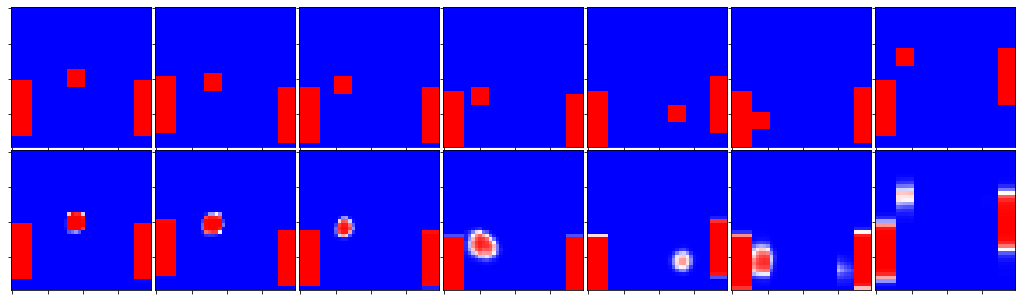

Epoch 678/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9882 - val_loss: 0.0252 - val_mean_squared_error: 0.0073 - val_acc: 0.9902


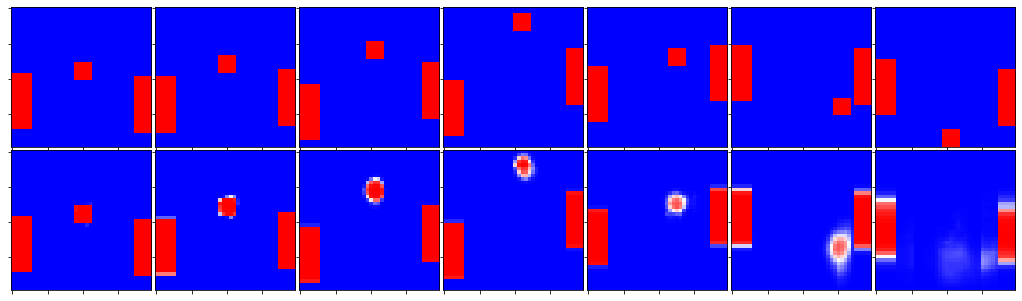

Epoch 679/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0328 - val_mean_squared_error: 0.0097 - val_acc: 0.9870


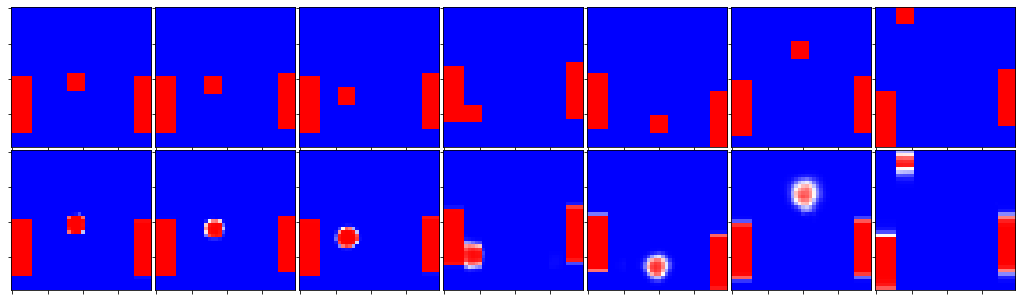

Epoch 680/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0305 - mean_squared_error: 0.0087 - acc: 0.9885 - val_loss: 0.0324 - val_mean_squared_error: 0.0093 - val_acc: 0.9872


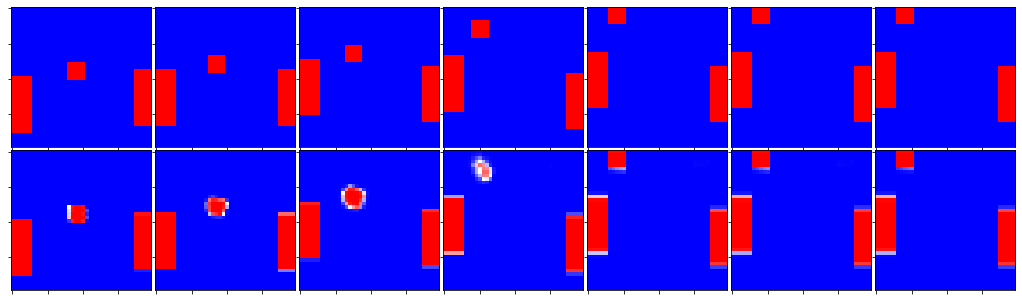

Epoch 681/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0305 - mean_squared_error: 0.0087 - acc: 0.9885 - val_loss: 0.0302 - val_mean_squared_error: 0.0088 - val_acc: 0.9881


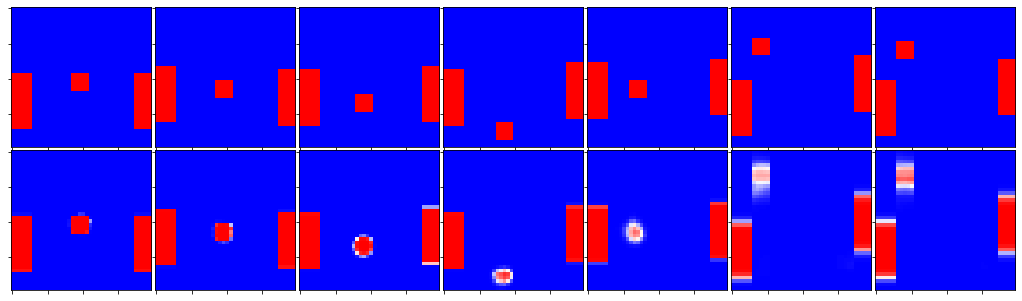

Epoch 682/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.0301 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0298 - val_mean_squared_error: 0.0086 - val_acc: 0.9885


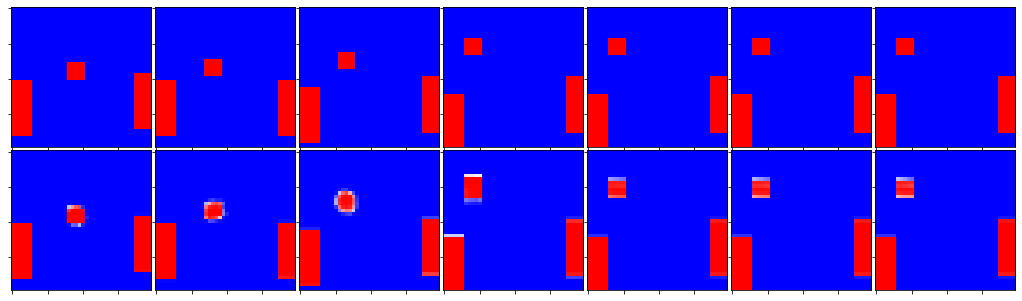

Epoch 683/2500
100/100 [==============================] - 84s 841ms/step - loss: 0.0294 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0319 - val_mean_squared_error: 0.0090 - val_acc: 0.9883


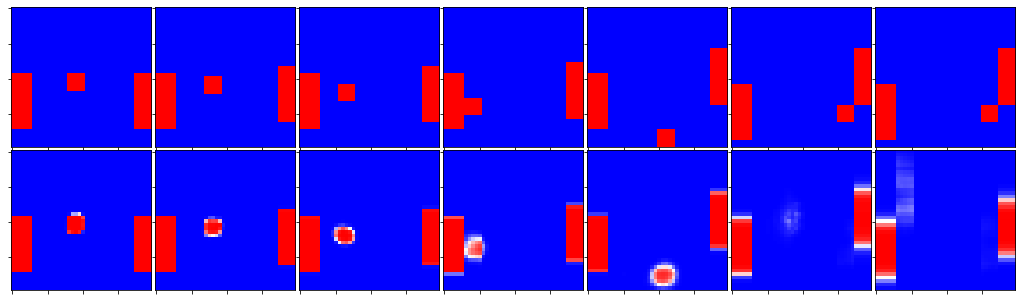

Epoch 684/2500
100/100 [==============================] - 89s 888ms/step - loss: 0.0299 - mean_squared_error: 0.0085 - acc: 0.9887 - val_loss: 0.0269 - val_mean_squared_error: 0.0079 - val_acc: 0.9893


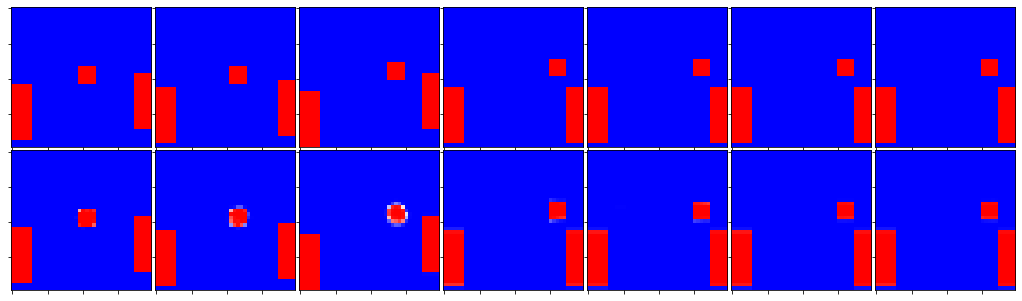

Epoch 685/2500
100/100 [==============================] - 88s 879ms/step - loss: 0.0300 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0312 - val_mean_squared_error: 0.0088 - val_acc: 0.9882


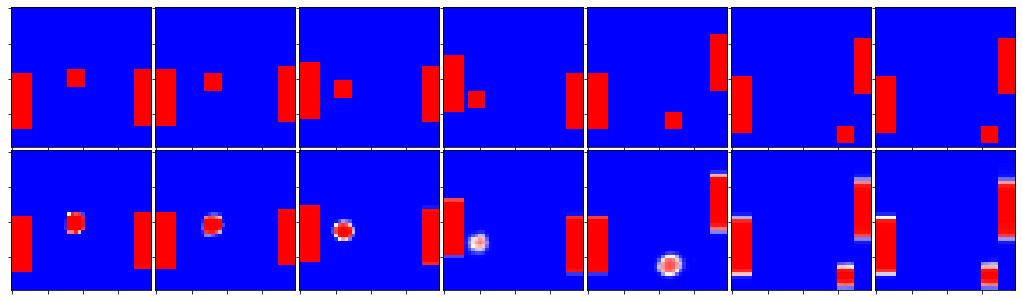

Epoch 686/2500
100/100 [==============================] - 84s 840ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0300 - val_mean_squared_error: 0.0087 - val_acc: 0.9882


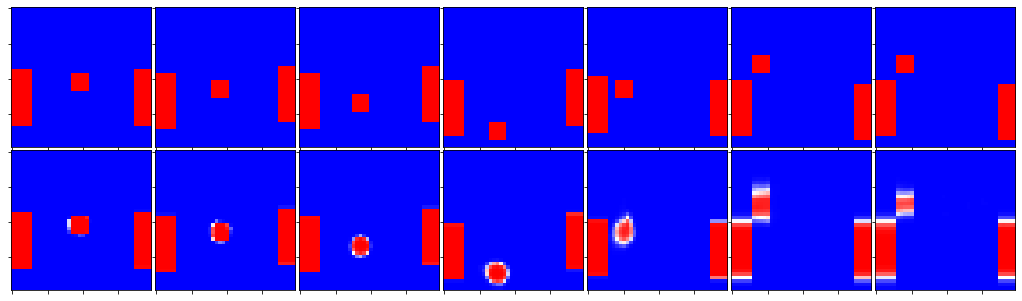

Epoch 687/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0306 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0282 - val_mean_squared_error: 0.0083 - val_acc: 0.9890


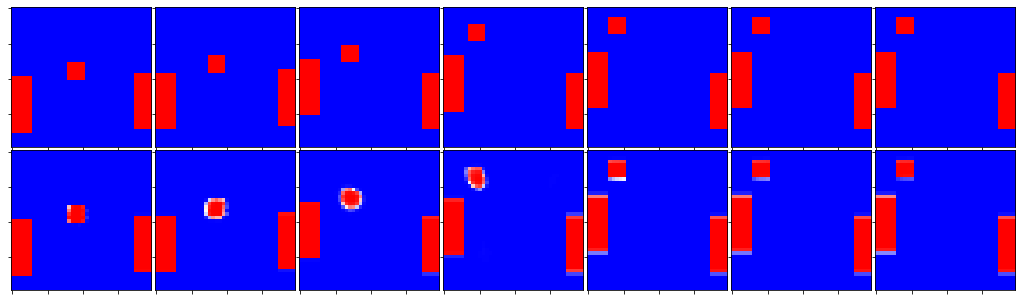

Epoch 688/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0299 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0263 - val_mean_squared_error: 0.0077 - val_acc: 0.9898


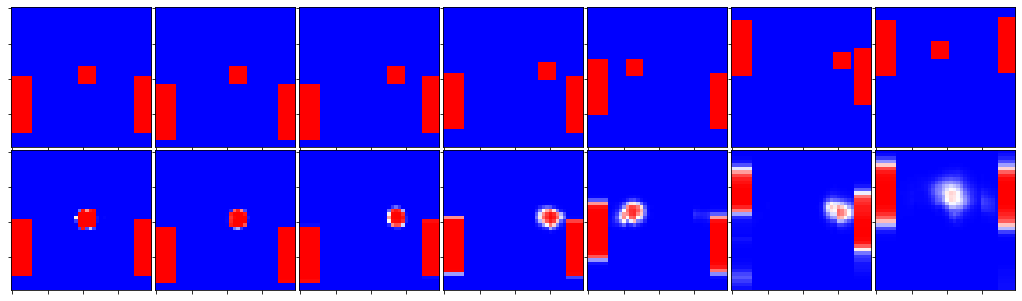

Epoch 689/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0323 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0262 - val_mean_squared_error: 0.0075 - val_acc: 0.9900


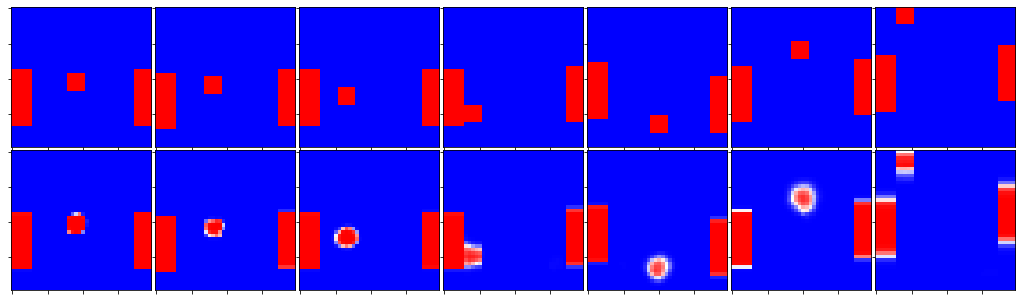

Epoch 690/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0305 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0334 - val_mean_squared_error: 0.0093 - val_acc: 0.9878


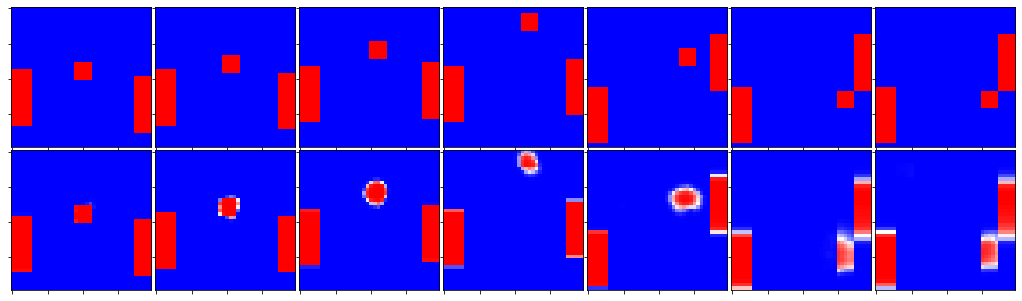

Epoch 691/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0310 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0311 - val_mean_squared_error: 0.0086 - val_acc: 0.9886


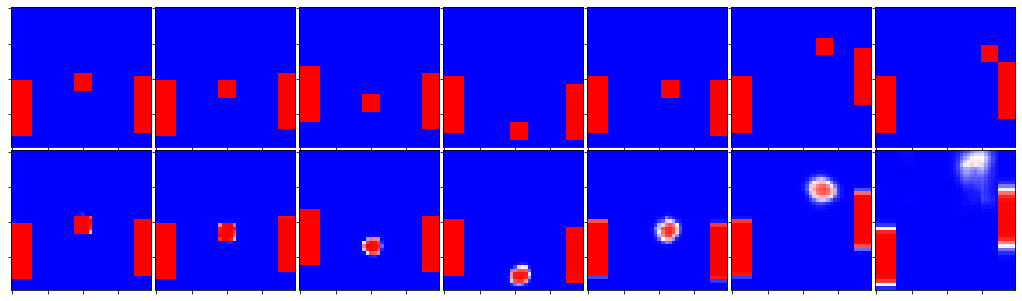

Epoch 692/2500
100/100 [==============================] - 84s 840ms/step - loss: 0.0329 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0299 - val_mean_squared_error: 0.0084 - val_acc: 0.9889


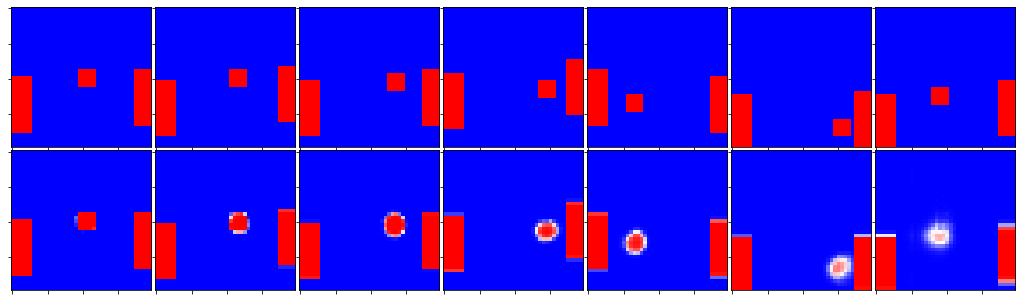

Epoch 693/2500
100/100 [==============================] - 85s 851ms/step - loss: 0.0311 - mean_squared_error: 0.0089 - acc: 0.9881 - val_loss: 0.0292 - val_mean_squared_error: 0.0084 - val_acc: 0.9886


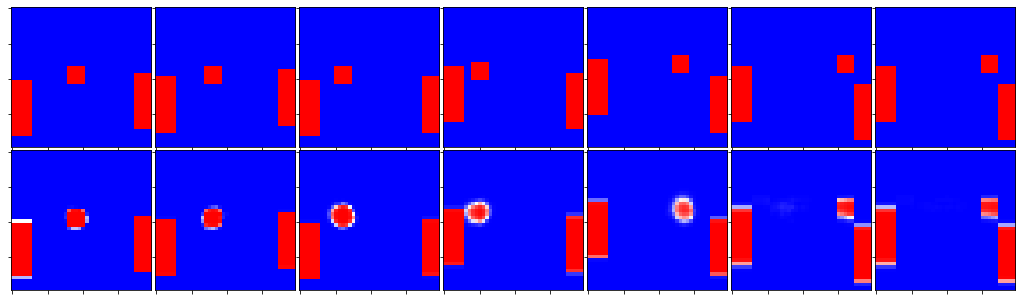

Epoch 694/2500
100/100 [==============================] - 84s 843ms/step - loss: 0.0296 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0428 - val_mean_squared_error: 0.0118 - val_acc: 0.9842


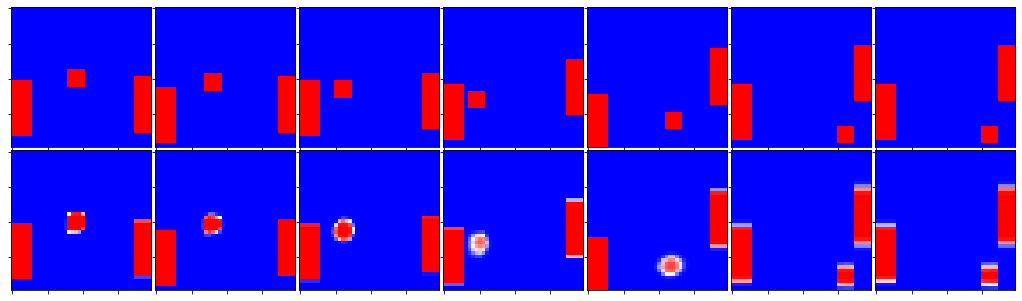

Epoch 695/2500
100/100 [==============================] - 85s 848ms/step - loss: 0.0301 - mean_squared_error: 0.0086 - acc: 0.9886 - val_loss: 0.0340 - val_mean_squared_error: 0.0096 - val_acc: 0.9871


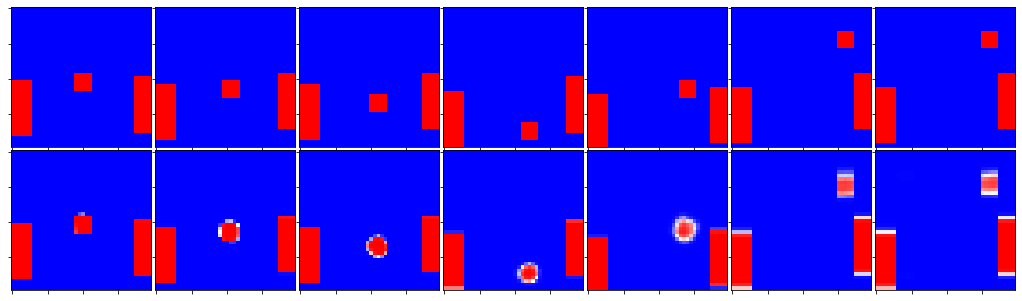

Epoch 696/2500
100/100 [==============================] - 84s 842ms/step - loss: 0.0298 - mean_squared_error: 0.0085 - acc: 0.9887 - val_loss: 0.0278 - val_mean_squared_error: 0.0083 - val_acc: 0.9888


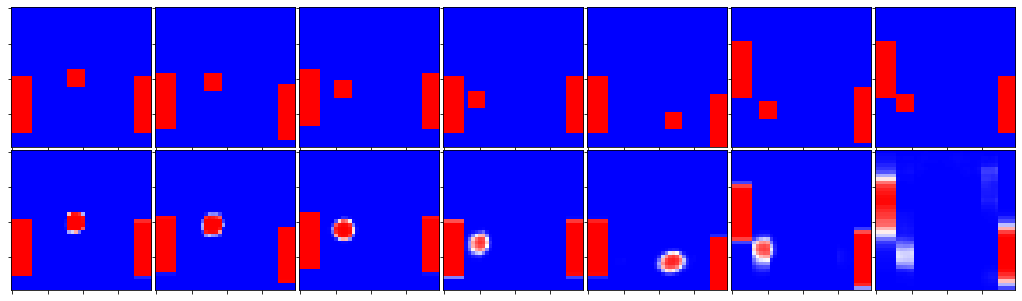

Epoch 697/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0293 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0294 - val_mean_squared_error: 0.0085 - val_acc: 0.9884


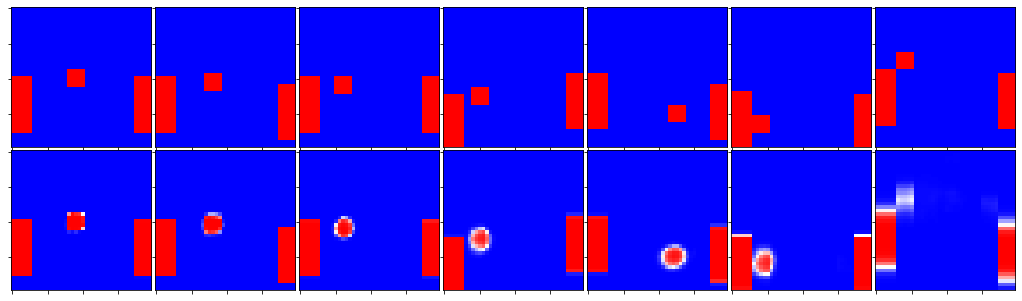

Epoch 698/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0310 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0305 - val_mean_squared_error: 0.0091 - val_acc: 0.9875


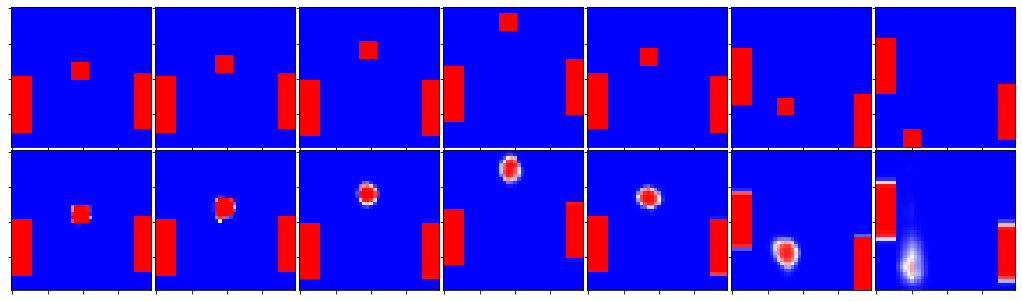

Epoch 699/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0294 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0274 - val_mean_squared_error: 0.0081 - val_acc: 0.9889


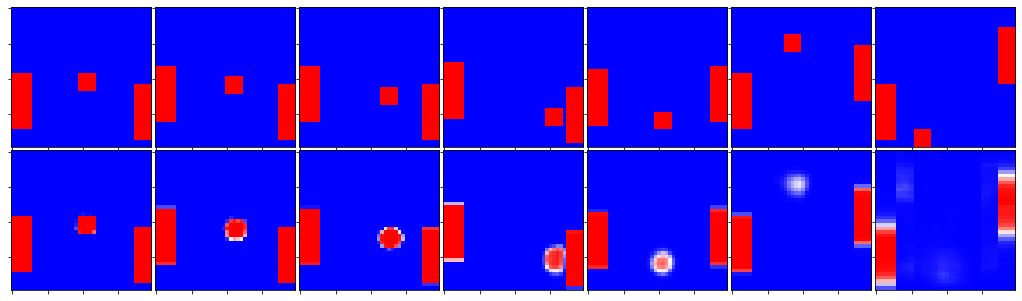

Epoch 700/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0292 - mean_squared_error: 0.0083 - acc: 0.9890 - val_loss: 0.0314 - val_mean_squared_error: 0.0094 - val_acc: 0.9871


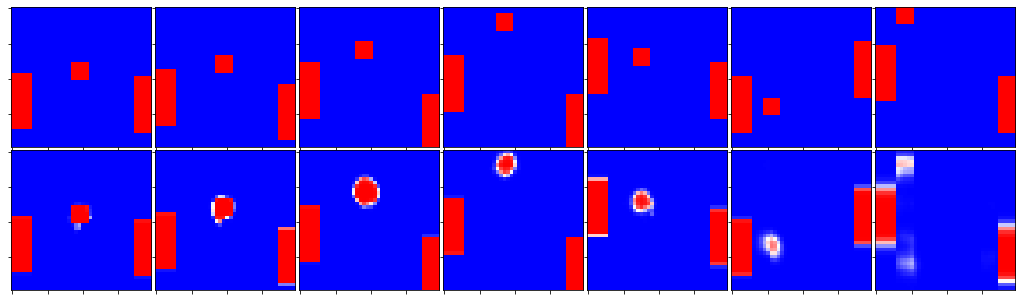

Epoch 701/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0295 - mean_squared_error: 0.0085 - acc: 0.9885 - val_loss: 0.0290 - val_mean_squared_error: 0.0080 - val_acc: 0.9895


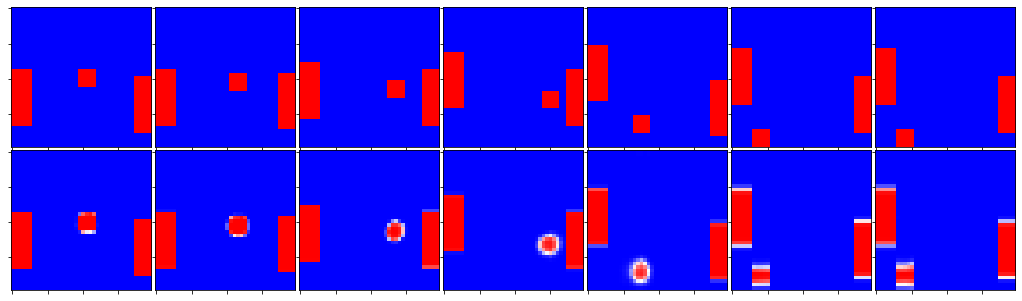

Epoch 702/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0323 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0325 - val_mean_squared_error: 0.0094 - val_acc: 0.9874


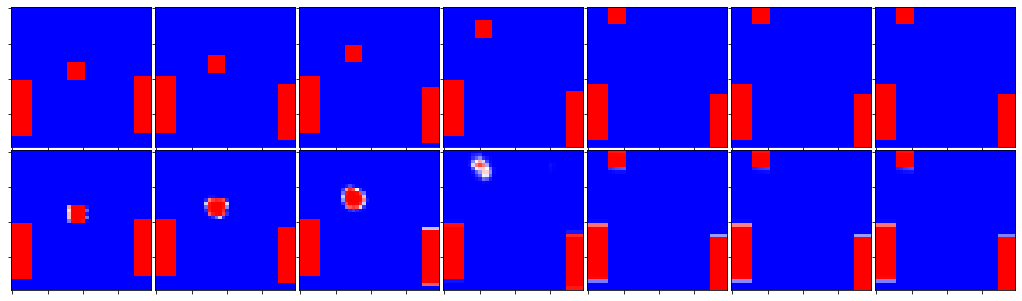

Epoch 703/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0303 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0228 - val_mean_squared_error: 0.0066 - val_acc: 0.9914


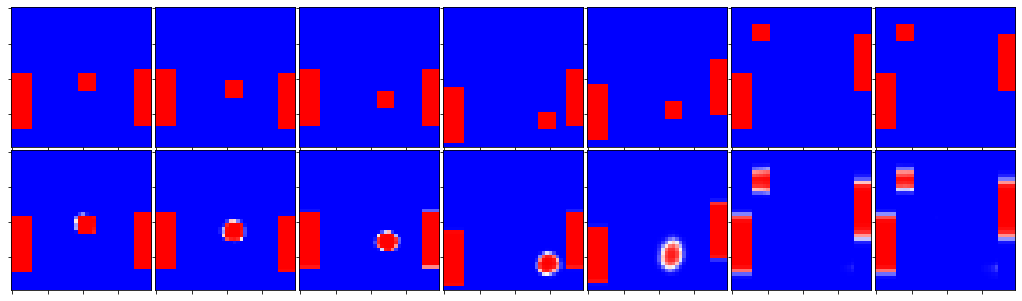

Epoch 704/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0310 - mean_squared_error: 0.0089 - acc: 0.9882 - val_loss: 0.0312 - val_mean_squared_error: 0.0091 - val_acc: 0.9878


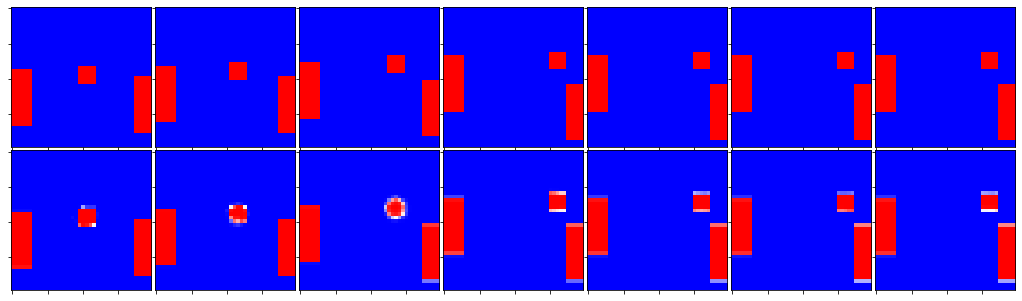

Epoch 705/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0296 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0305 - val_mean_squared_error: 0.0085 - val_acc: 0.9886


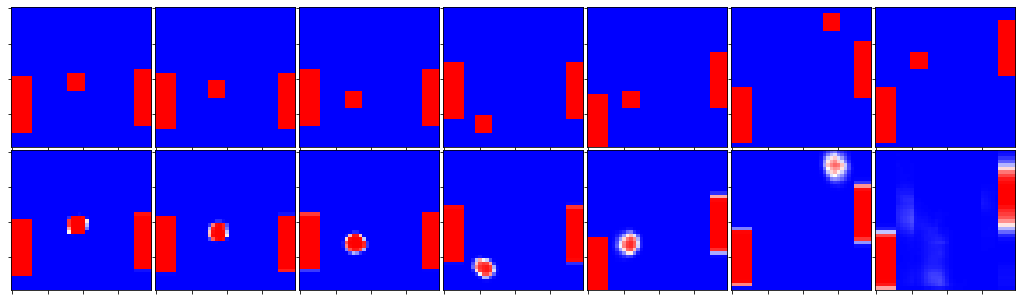

Epoch 706/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0297 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0281 - val_mean_squared_error: 0.0083 - val_acc: 0.9889


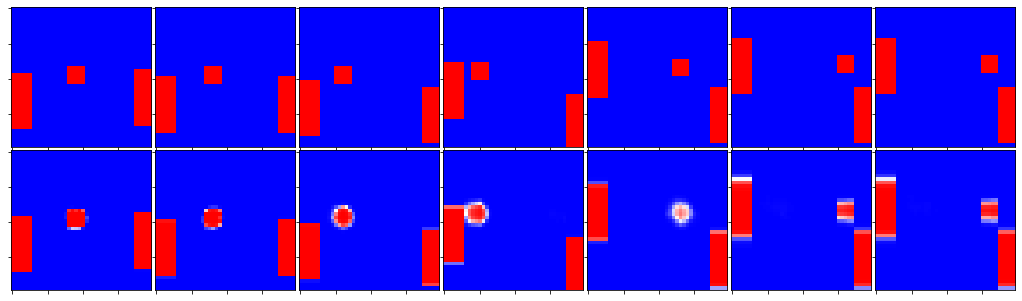

Epoch 707/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0323 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0408 - val_mean_squared_error: 0.0099 - val_acc: 0.9872


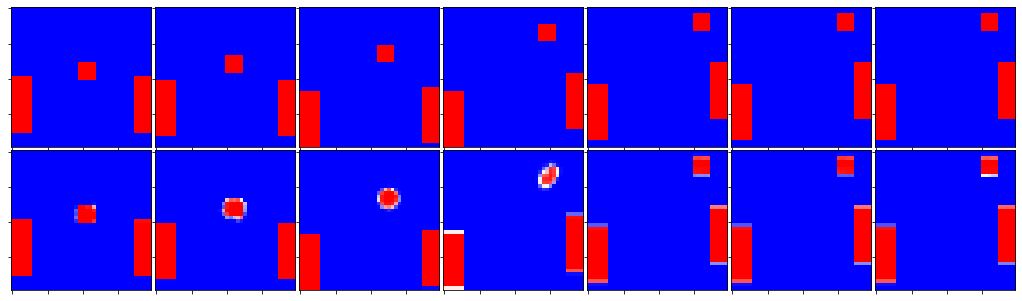

Epoch 708/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0299 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0338 - val_mean_squared_error: 0.0094 - val_acc: 0.9874


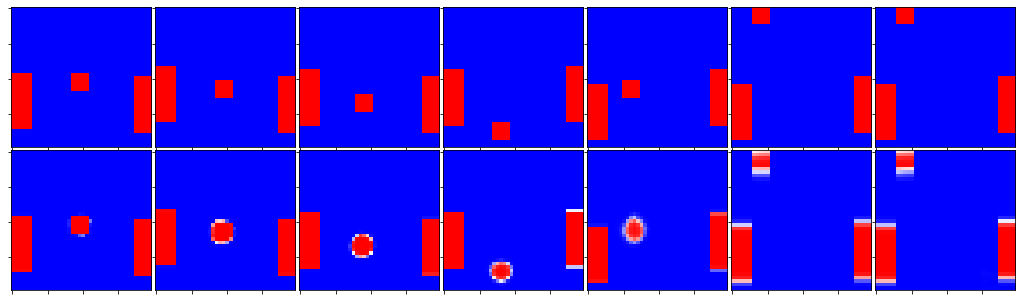

Epoch 709/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0309 - mean_squared_error: 0.0088 - acc: 0.9883 - val_loss: 0.0267 - val_mean_squared_error: 0.0078 - val_acc: 0.9894


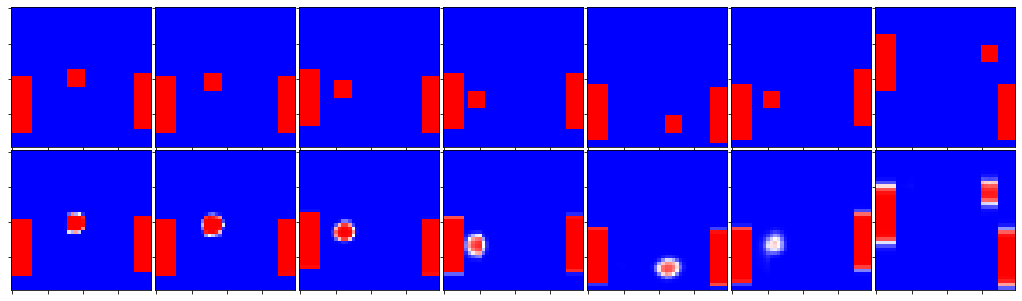

Epoch 710/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0288 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0279 - val_mean_squared_error: 0.0080 - val_acc: 0.9893


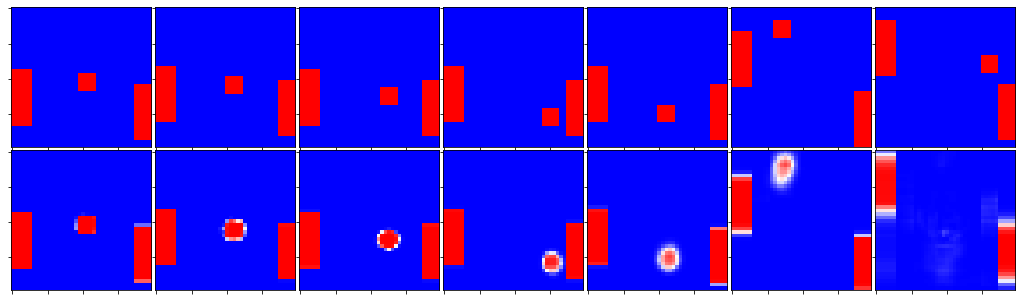

Epoch 711/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0282 - mean_squared_error: 0.0081 - acc: 0.9891 - val_loss: 0.0325 - val_mean_squared_error: 0.0081 - val_acc: 0.9893


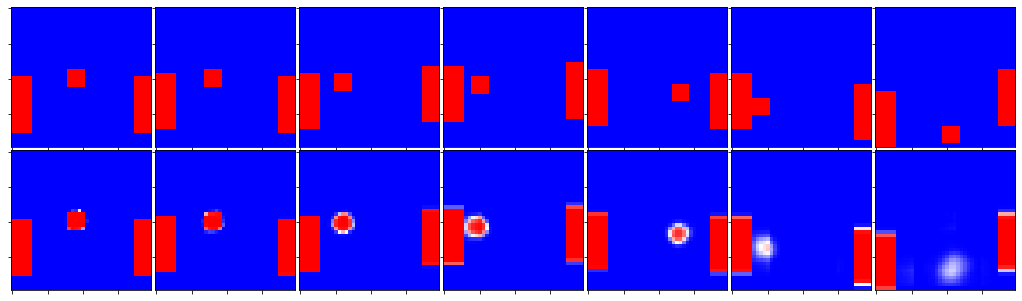

Epoch 712/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0288 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0261 - val_mean_squared_error: 0.0076 - val_acc: 0.9896


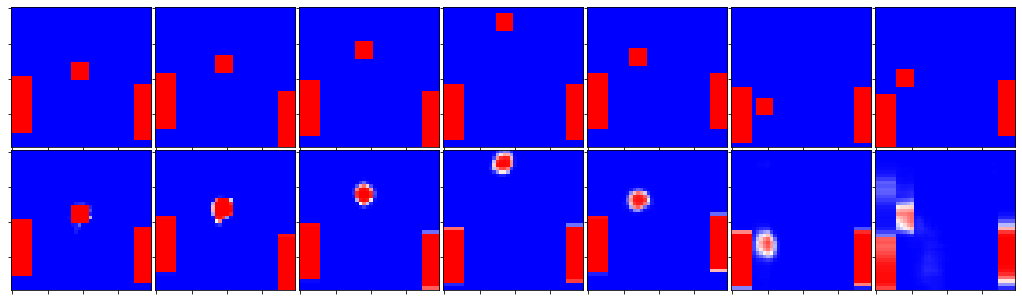

Epoch 713/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0314 - val_mean_squared_error: 0.0092 - val_acc: 0.9877


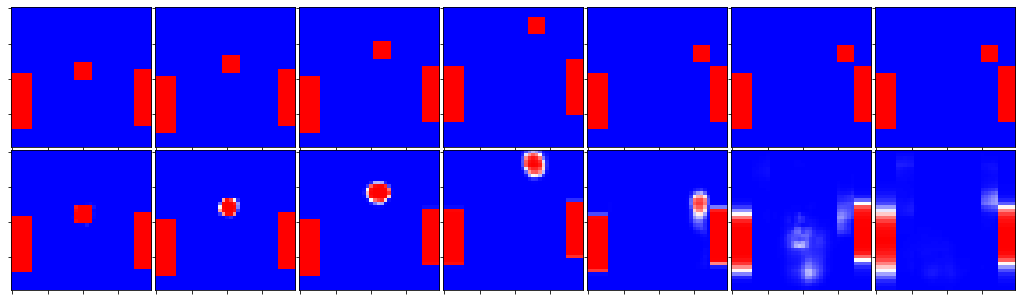

Epoch 714/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0303 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0326 - val_mean_squared_error: 0.0093 - val_acc: 0.9875


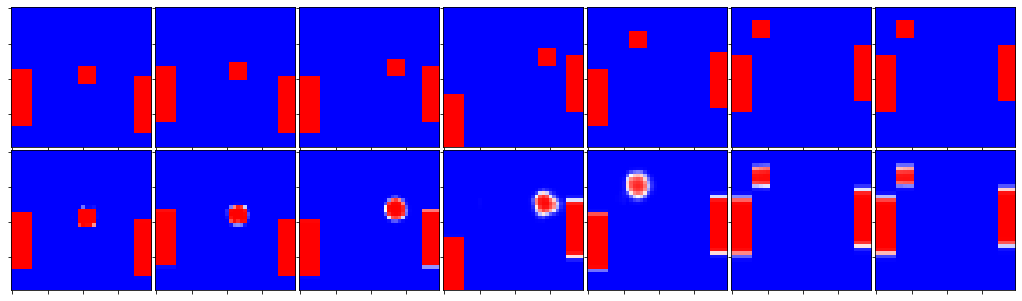

Epoch 715/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0317 - mean_squared_error: 0.0090 - acc: 0.9879 - val_loss: 0.0331 - val_mean_squared_error: 0.0093 - val_acc: 0.9874


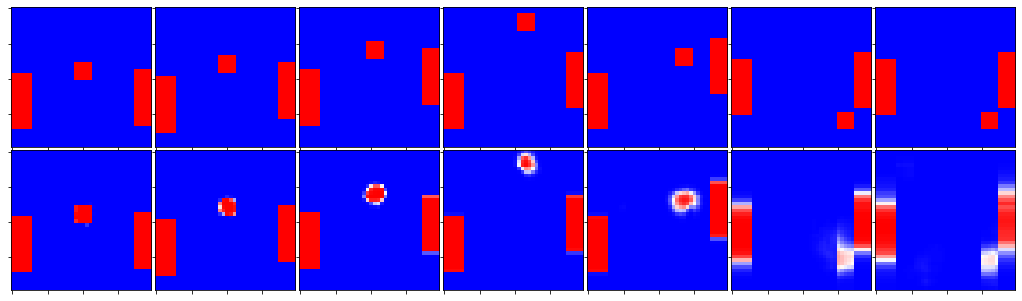

Epoch 716/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0301 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0296 - val_mean_squared_error: 0.0088 - val_acc: 0.9883


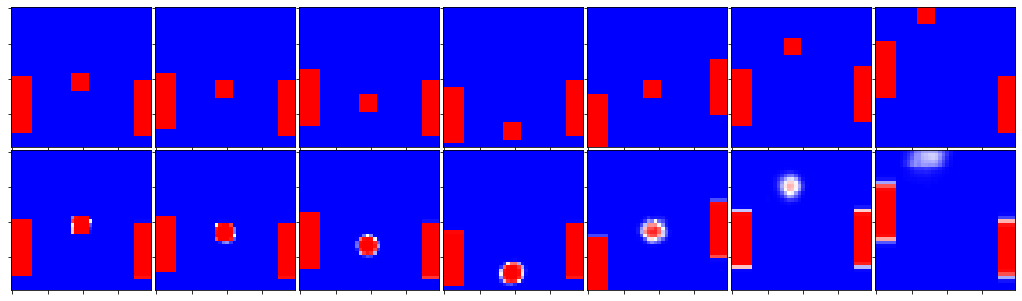

Epoch 717/2500
100/100 [==============================] - 84s 844ms/step - loss: 0.0296 - mean_squared_error: 0.0084 - acc: 0.9887 - val_loss: 0.0264 - val_mean_squared_error: 0.0078 - val_acc: 0.9897


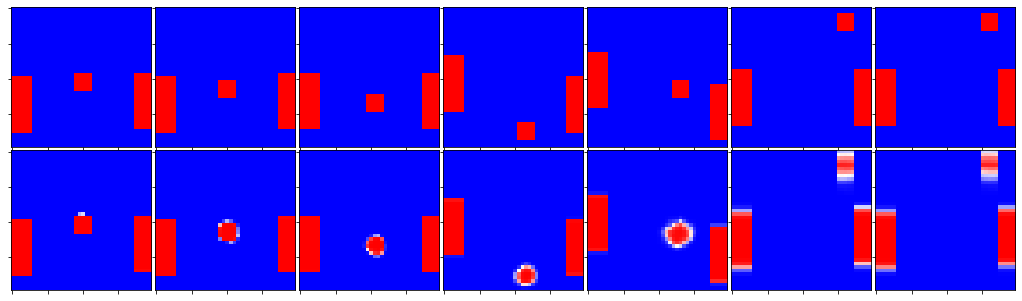

Epoch 718/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.0284 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0319 - val_mean_squared_error: 0.0093 - val_acc: 0.9875


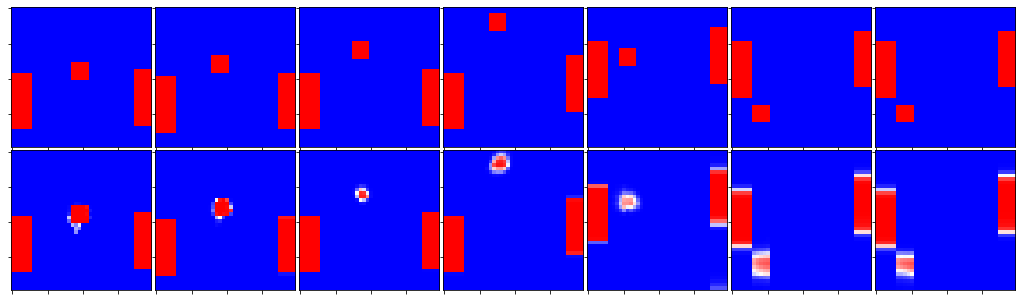

Epoch 719/2500
100/100 [==============================] - 85s 846ms/step - loss: 0.0298 - mean_squared_error: 0.0085 - acc: 0.9885 - val_loss: 0.0266 - val_mean_squared_error: 0.0073 - val_acc: 0.9903


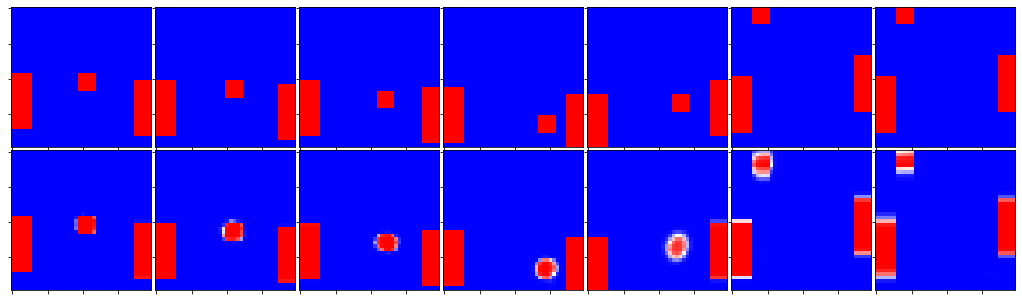

Epoch 720/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0304 - mean_squared_error: 0.0088 - acc: 0.9882 - val_loss: 0.0249 - val_mean_squared_error: 0.0074 - val_acc: 0.9900


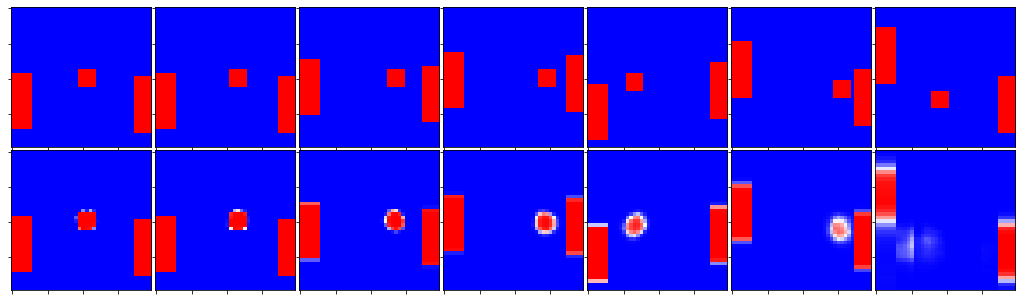

Epoch 721/2500
100/100 [==============================] - 85s 851ms/step - loss: 0.0287 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0326 - val_mean_squared_error: 0.0092 - val_acc: 0.9878


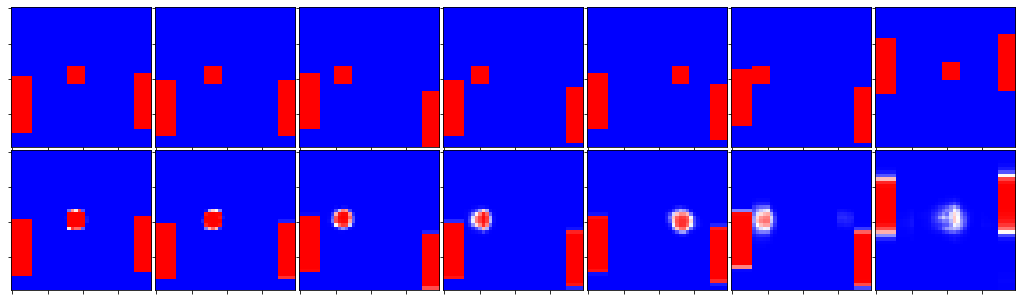

Epoch 722/2500
100/100 [==============================] - 85s 852ms/step - loss: 0.0293 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0304 - val_mean_squared_error: 0.0089 - val_acc: 0.9880


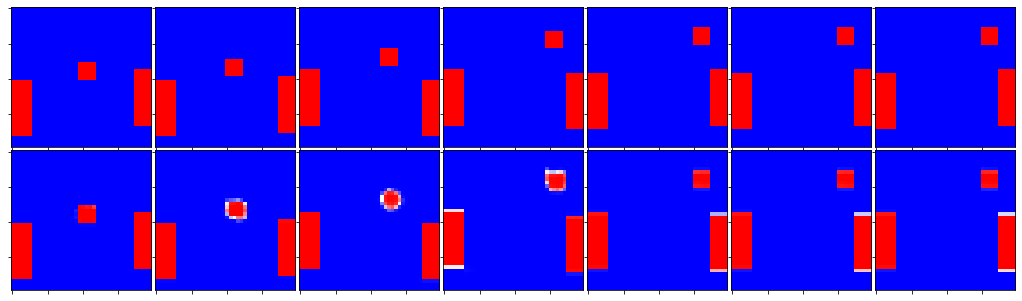

Epoch 723/2500
100/100 [==============================] - 85s 854ms/step - loss: 0.0294 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0327 - val_mean_squared_error: 0.0089 - val_acc: 0.9882


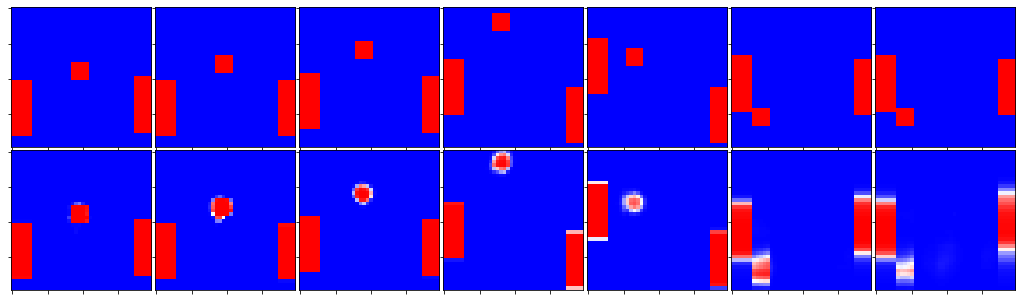

Epoch 724/2500
100/100 [==============================] - 85s 847ms/step - loss: 0.0320 - mean_squared_error: 0.0092 - acc: 0.9876 - val_loss: 0.0355 - val_mean_squared_error: 0.0102 - val_acc: 0.9862


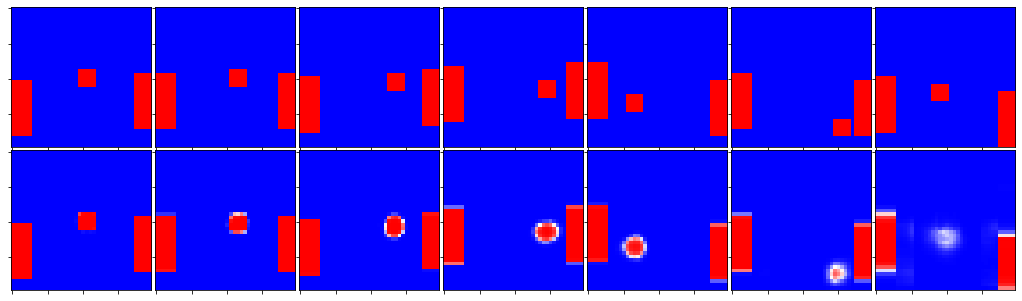

Epoch 725/2500
100/100 [==============================] - 85s 852ms/step - loss: 0.0318 - mean_squared_error: 0.0092 - acc: 0.9877 - val_loss: 0.0342 - val_mean_squared_error: 0.0098 - val_acc: 0.9870


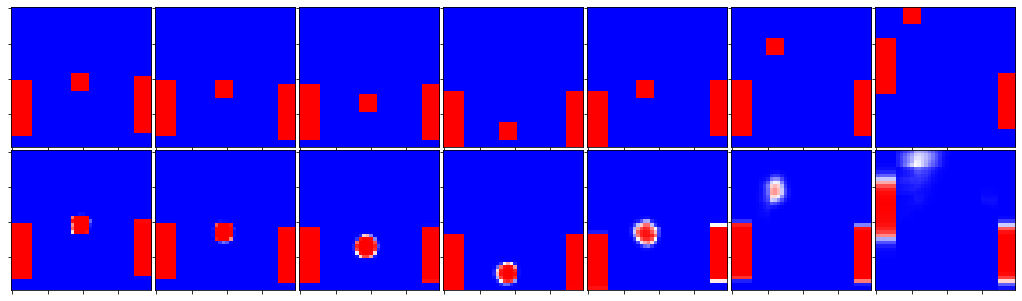

Epoch 726/2500
100/100 [==============================] - 84s 839ms/step - loss: 0.0292 - mean_squared_error: 0.0083 - acc: 0.9888 - val_loss: 0.0235 - val_mean_squared_error: 0.0068 - val_acc: 0.9909


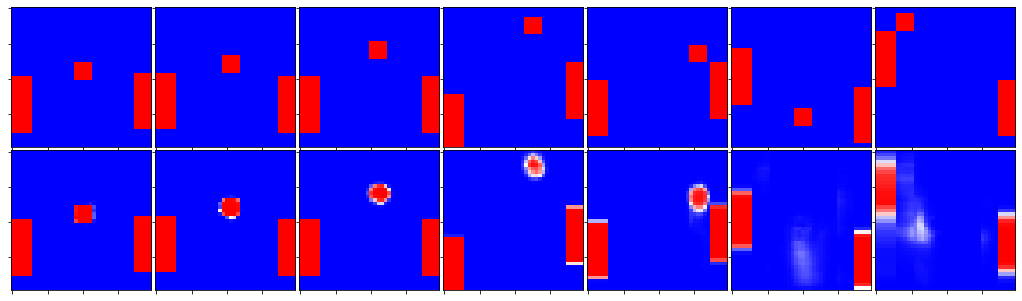

Epoch 727/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.0273 - mean_squared_error: 0.0078 - acc: 0.9895 - val_loss: 0.0261 - val_mean_squared_error: 0.0080 - val_acc: 0.9888


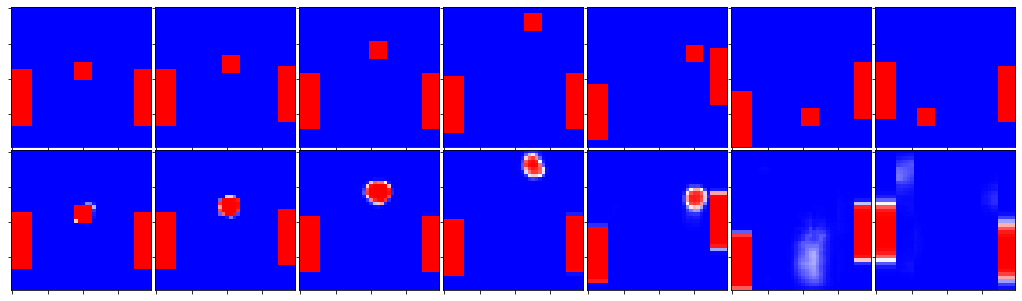

Epoch 728/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0312 - mean_squared_error: 0.0089 - acc: 0.9880 - val_loss: 0.0283 - val_mean_squared_error: 0.0082 - val_acc: 0.9891


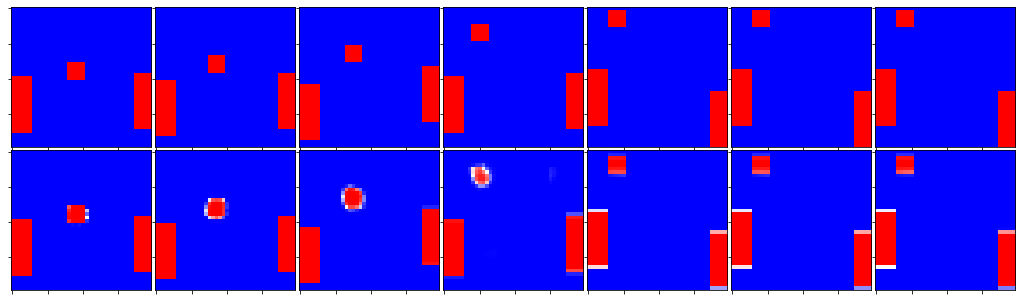

Epoch 729/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0294 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0271 - val_mean_squared_error: 0.0080 - val_acc: 0.9890


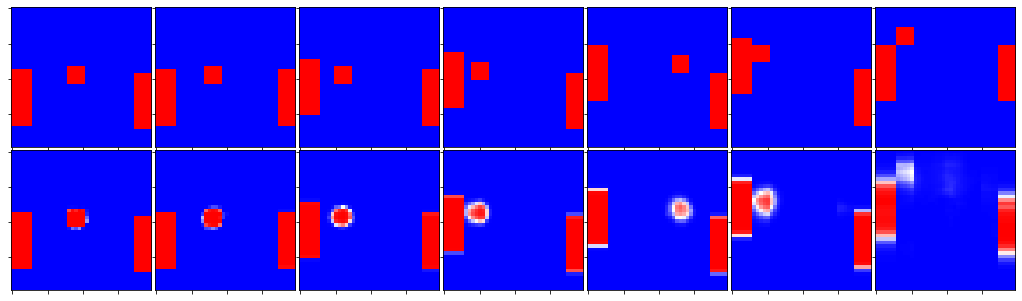

Epoch 730/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0297 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0355 - val_mean_squared_error: 0.0102 - val_acc: 0.9864


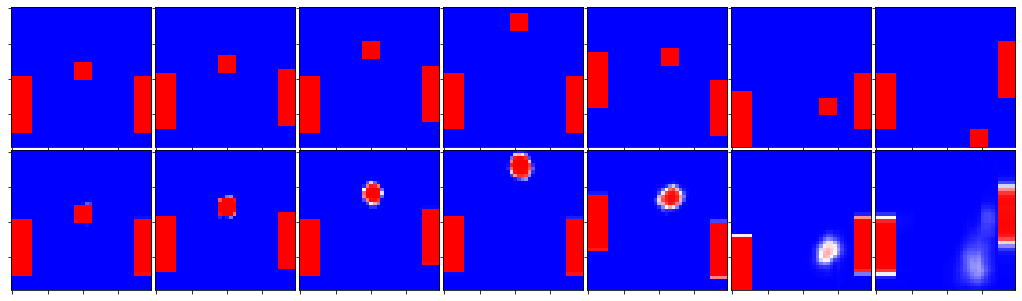

Epoch 731/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.0293 - mean_squared_error: 0.0084 - acc: 0.9888 - val_loss: 0.0312 - val_mean_squared_error: 0.0088 - val_acc: 0.9885


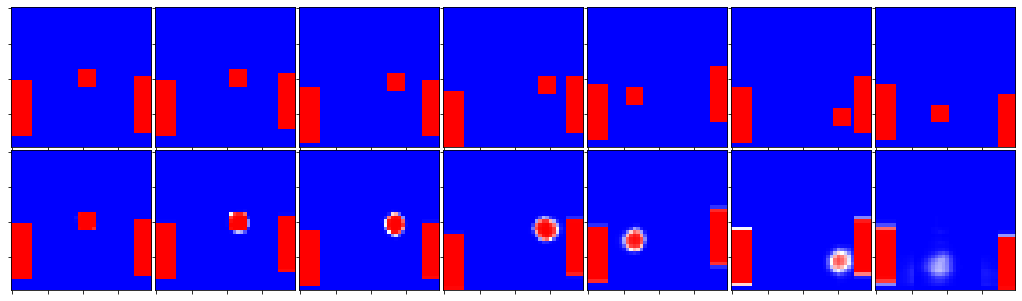

Epoch 732/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0289 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0313 - val_mean_squared_error: 0.0090 - val_acc: 0.9878


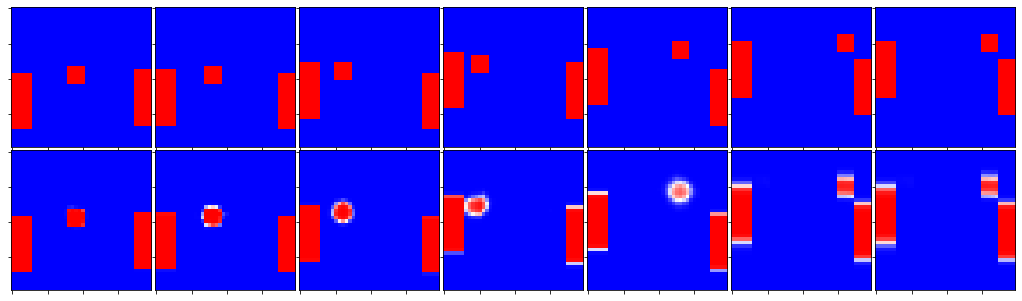

Epoch 733/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0271 - mean_squared_error: 0.0078 - acc: 0.9896 - val_loss: 0.0270 - val_mean_squared_error: 0.0078 - val_acc: 0.9894


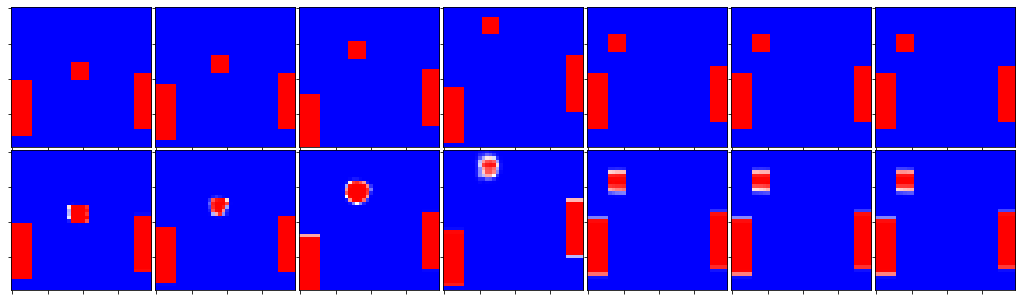

Epoch 734/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0286 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0236 - val_mean_squared_error: 0.0069 - val_acc: 0.9908


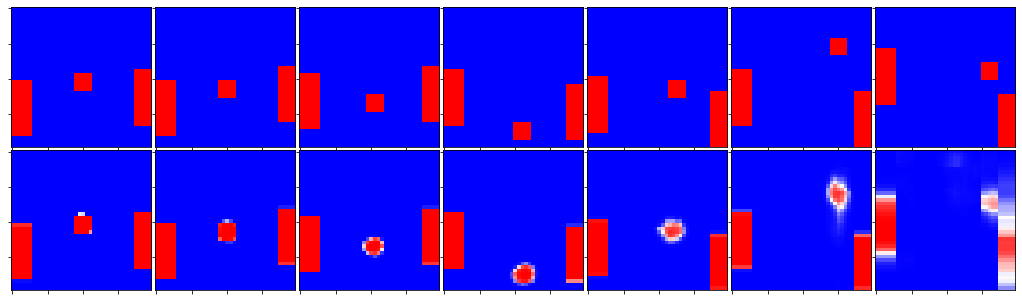

Epoch 735/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0280 - mean_squared_error: 0.0080 - acc: 0.9893 - val_loss: 0.0241 - val_mean_squared_error: 0.0072 - val_acc: 0.9900


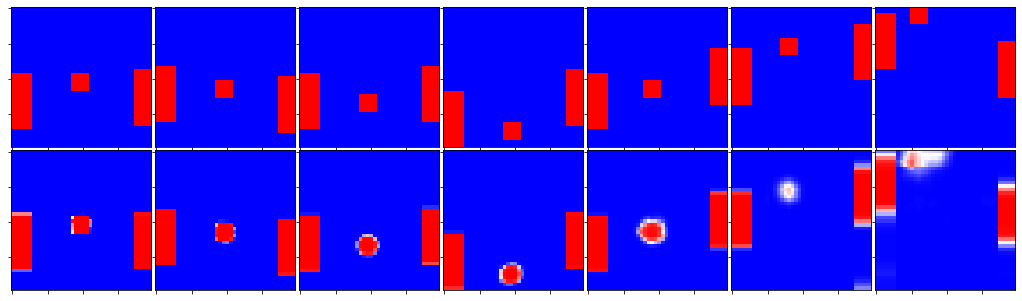

Epoch 736/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0278 - mean_squared_error: 0.0080 - acc: 0.9892 - val_loss: 0.0263 - val_mean_squared_error: 0.0075 - val_acc: 0.9899


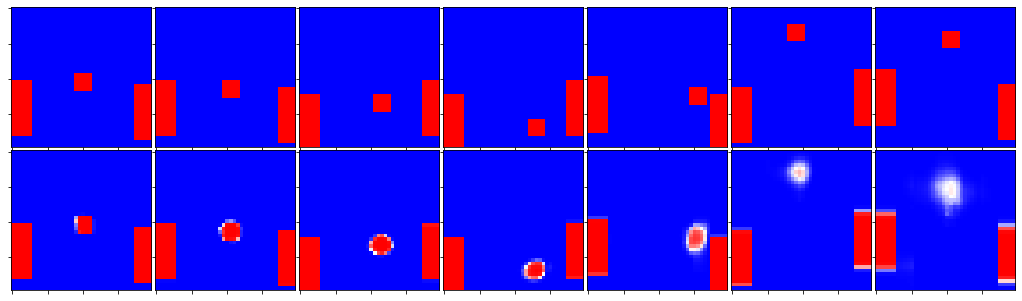

Epoch 737/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0284 - mean_squared_error: 0.0081 - acc: 0.9891 - val_loss: 0.0274 - val_mean_squared_error: 0.0080 - val_acc: 0.9891


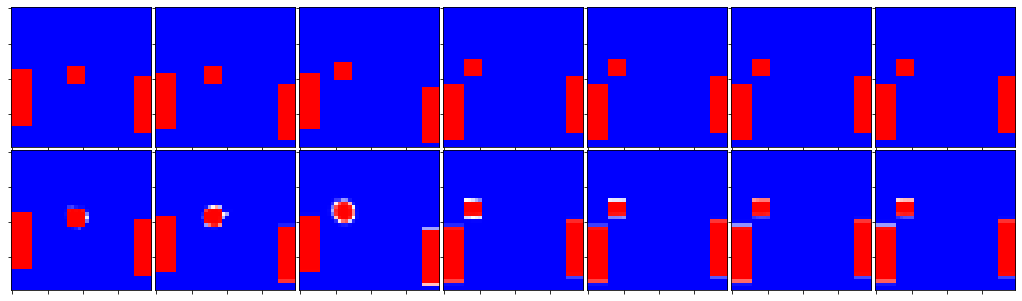

Epoch 738/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9884 - val_loss: 0.0297 - val_mean_squared_error: 0.0085 - val_acc: 0.9887


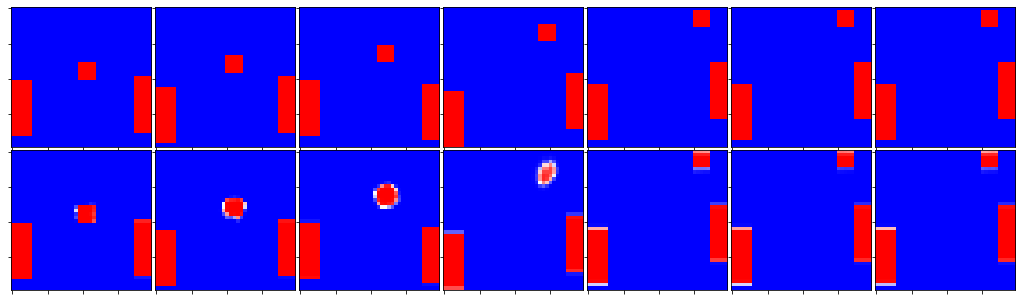

Epoch 739/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0356 - val_mean_squared_error: 0.0101 - val_acc: 0.9866


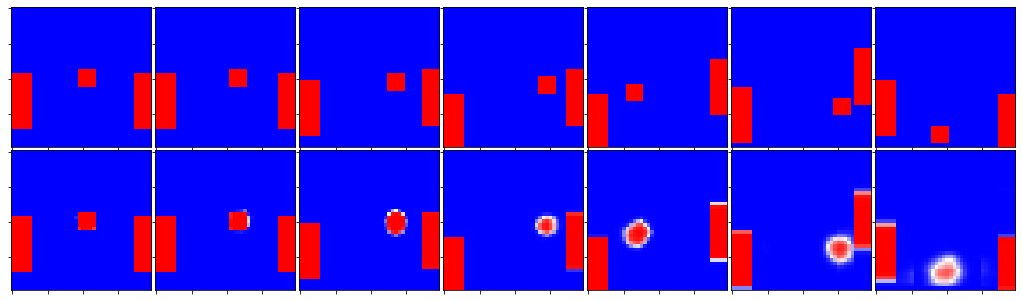

Epoch 740/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0306 - mean_squared_error: 0.0087 - acc: 0.9883 - val_loss: 0.0305 - val_mean_squared_error: 0.0091 - val_acc: 0.9875


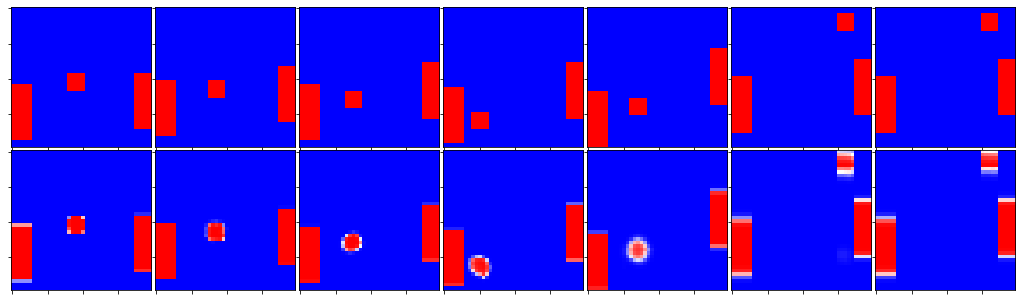

Epoch 741/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0258 - val_mean_squared_error: 0.0074 - val_acc: 0.9904


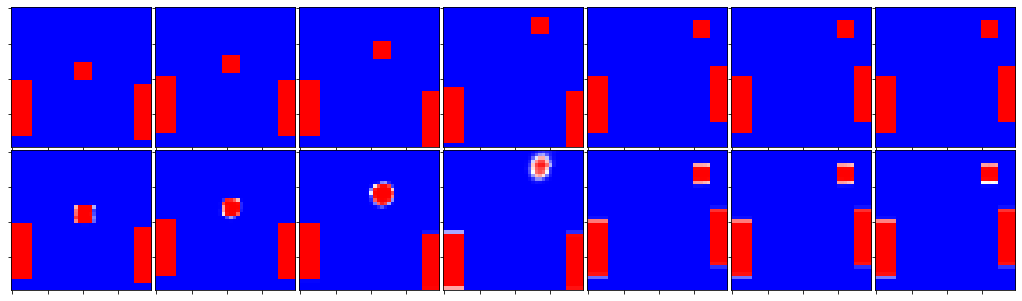

Epoch 742/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0263 - val_mean_squared_error: 0.0078 - val_acc: 0.9893


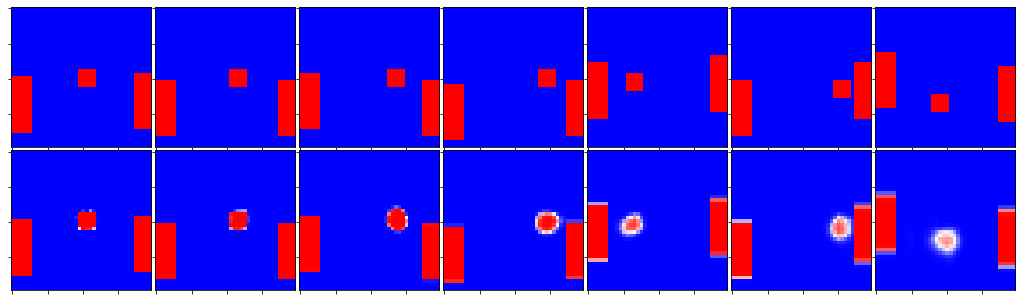

Epoch 743/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0285 - mean_squared_error: 0.0082 - acc: 0.9890 - val_loss: 0.0295 - val_mean_squared_error: 0.0088 - val_acc: 0.9881


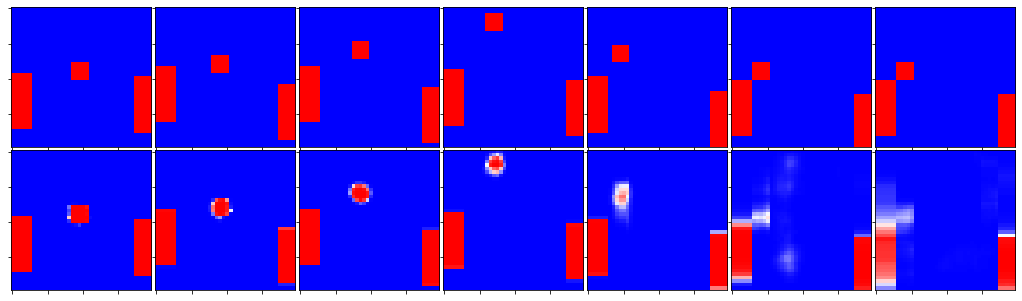

Epoch 744/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0301 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0278 - val_mean_squared_error: 0.0080 - val_acc: 0.9894


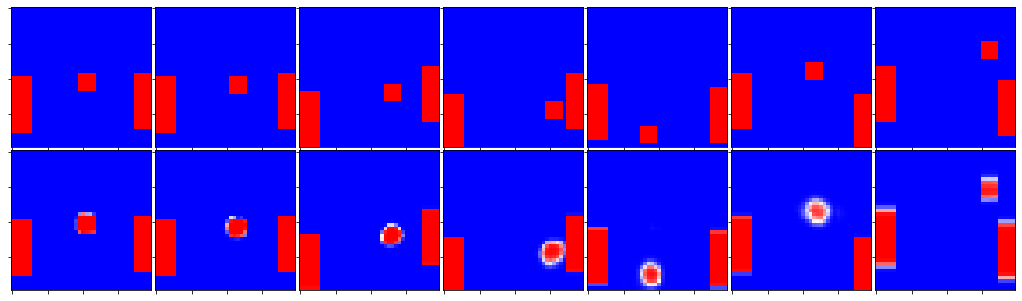

Epoch 745/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0276 - mean_squared_error: 0.0079 - acc: 0.9894 - val_loss: 0.0339 - val_mean_squared_error: 0.0095 - val_acc: 0.9876


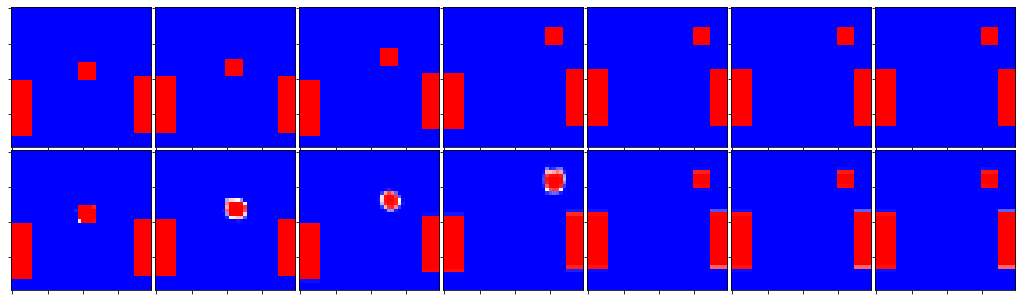

Epoch 746/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0299 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0257 - val_mean_squared_error: 0.0075 - val_acc: 0.9897


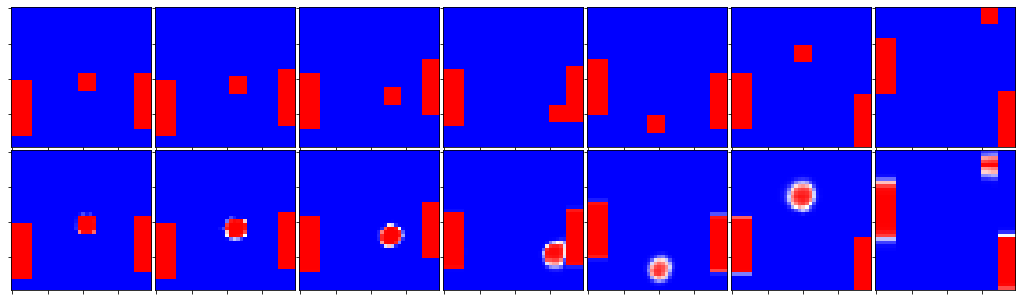

Epoch 747/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0287 - mean_squared_error: 0.0082 - acc: 0.9891 - val_loss: 0.0277 - val_mean_squared_error: 0.0081 - val_acc: 0.9894


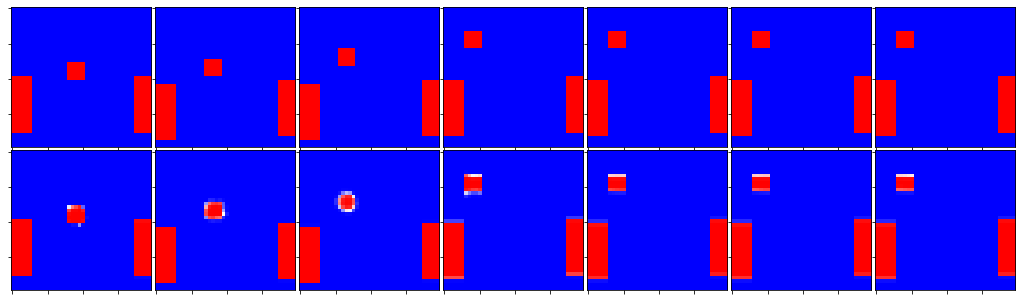

Epoch 748/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0276 - mean_squared_error: 0.0079 - acc: 0.9894 - val_loss: 0.0230 - val_mean_squared_error: 0.0069 - val_acc: 0.9906


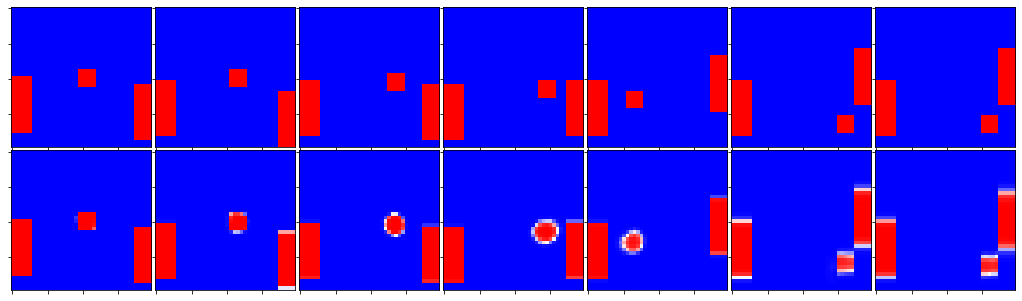

Epoch 749/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0304 - mean_squared_error: 0.0086 - acc: 0.9884 - val_loss: 0.0299 - val_mean_squared_error: 0.0088 - val_acc: 0.9881


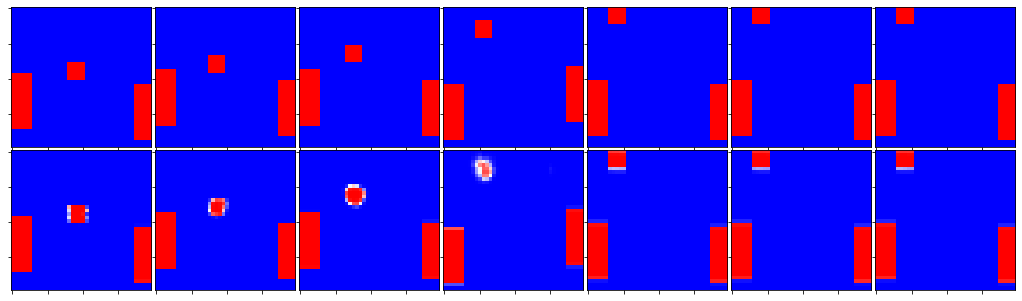

Epoch 750/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0289 - mean_squared_error: 0.0081 - acc: 0.9892 - val_loss: 0.0320 - val_mean_squared_error: 0.0092 - val_acc: 0.9874


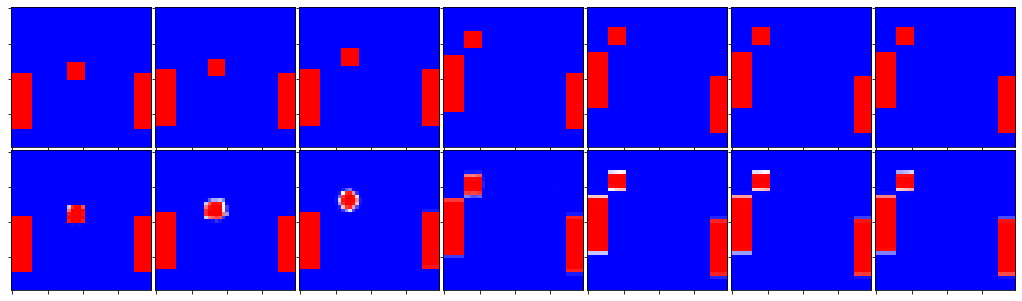

Epoch 751/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0320 - mean_squared_error: 0.0091 - acc: 0.9878 - val_loss: 0.0283 - val_mean_squared_error: 0.0078 - val_acc: 0.9895


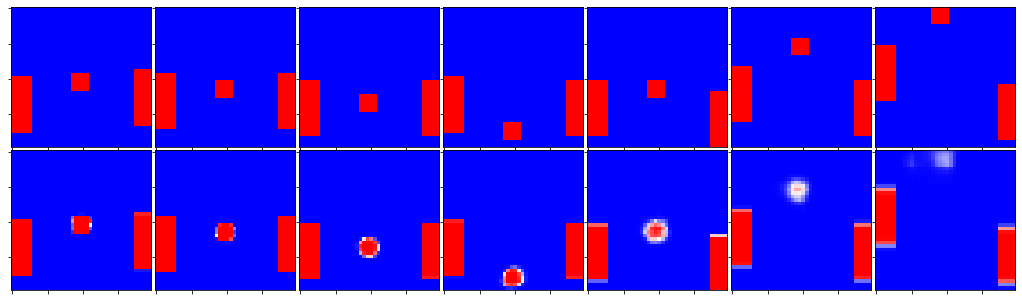

Epoch 752/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0288 - mean_squared_error: 0.0082 - acc: 0.9889 - val_loss: 0.0312 - val_mean_squared_error: 0.0091 - val_acc: 0.9878


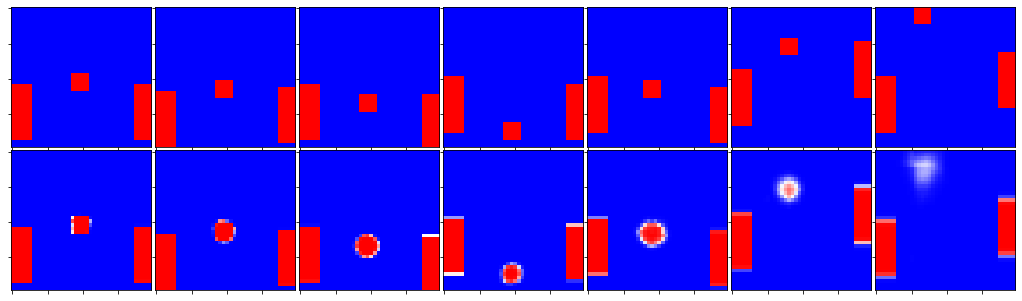

Epoch 753/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0297 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0273 - val_mean_squared_error: 0.0081 - val_acc: 0.9889


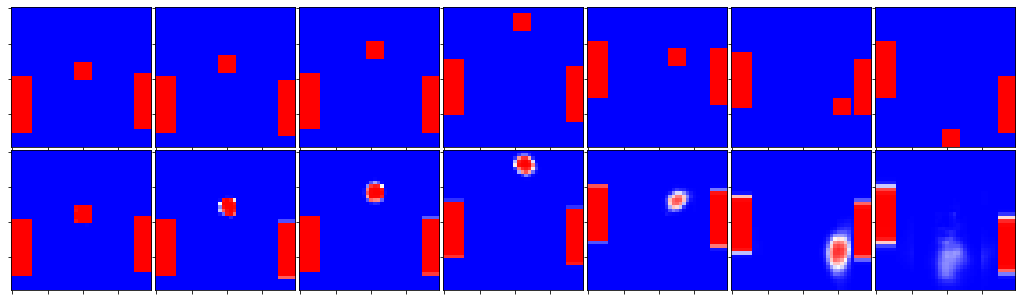

Epoch 754/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0280 - mean_squared_error: 0.0080 - acc: 0.9893 - val_loss: 0.0339 - val_mean_squared_error: 0.0090 - val_acc: 0.9880


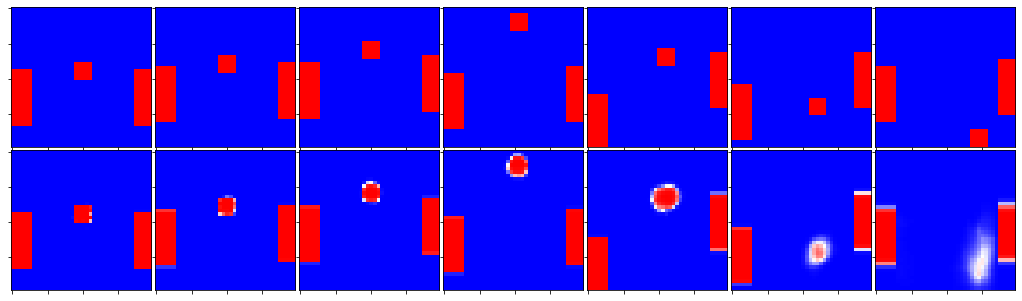

Epoch 755/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0278 - mean_squared_error: 0.0080 - acc: 0.9892 - val_loss: 0.0285 - val_mean_squared_error: 0.0084 - val_acc: 0.9886


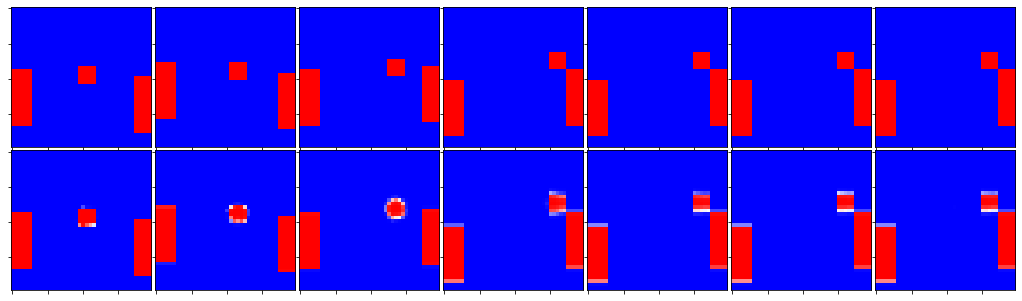

Epoch 756/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0284 - mean_squared_error: 0.0080 - acc: 0.9892 - val_loss: 0.0285 - val_mean_squared_error: 0.0077 - val_acc: 0.9898


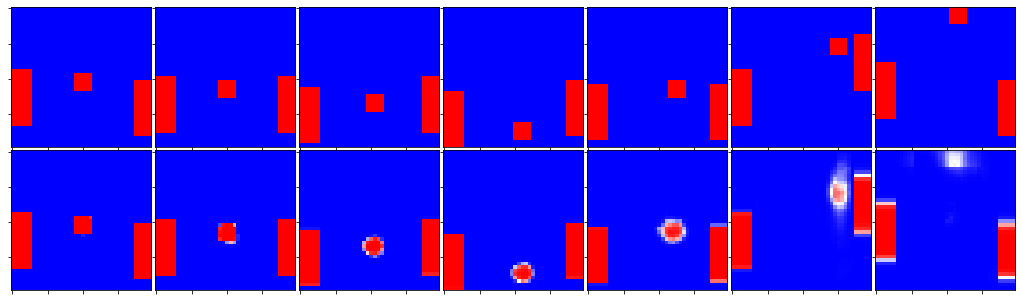

Epoch 757/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0281 - mean_squared_error: 0.0080 - acc: 0.9893 - val_loss: 0.0328 - val_mean_squared_error: 0.0093 - val_acc: 0.9875


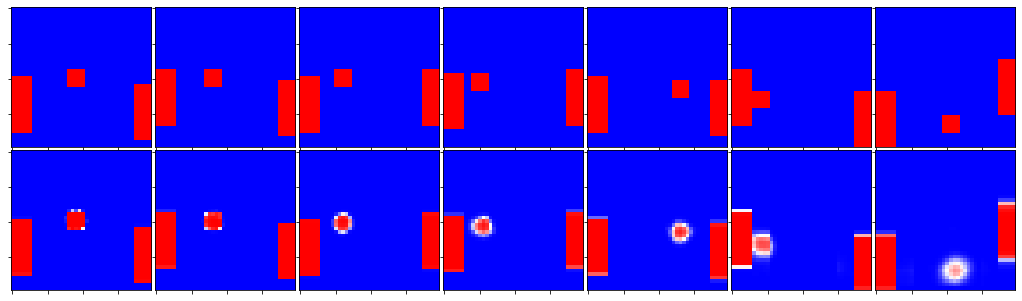

Epoch 758/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0292 - mean_squared_error: 0.0083 - acc: 0.9888 - val_loss: 0.0272 - val_mean_squared_error: 0.0081 - val_acc: 0.9889


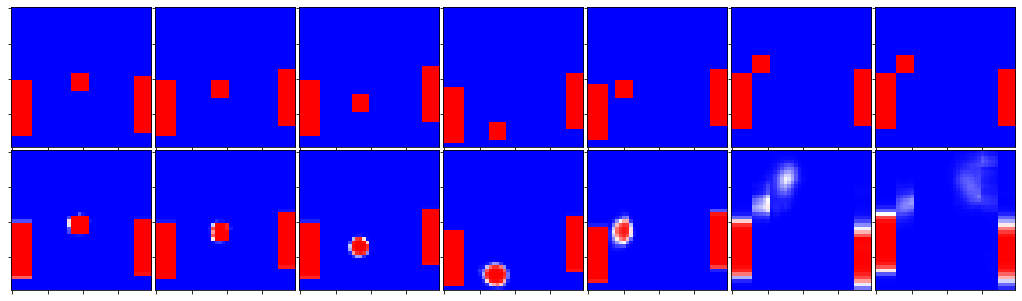

Epoch 759/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0277 - mean_squared_error: 0.0079 - acc: 0.9895 - val_loss: 0.0331 - val_mean_squared_error: 0.0094 - val_acc: 0.9875


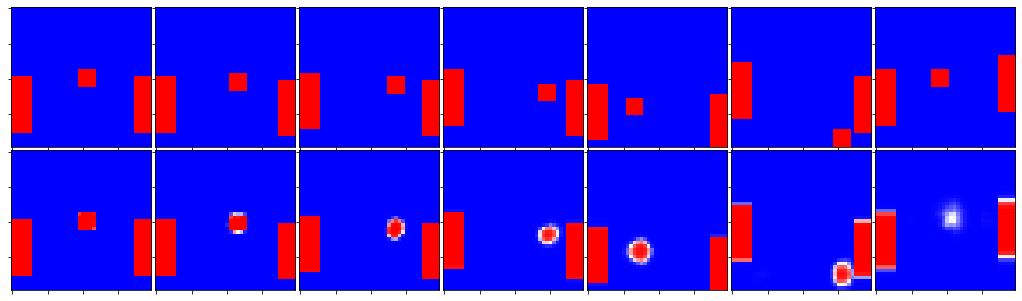

Epoch 760/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0282 - mean_squared_error: 0.0081 - acc: 0.9891 - val_loss: 0.0243 - val_mean_squared_error: 0.0073 - val_acc: 0.9898


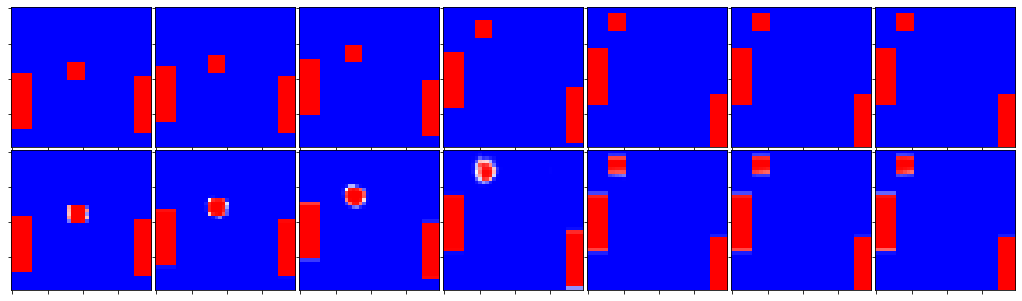

Epoch 761/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0284 - mean_squared_error: 0.0081 - acc: 0.9891 - val_loss: 0.0283 - val_mean_squared_error: 0.0083 - val_acc: 0.9886


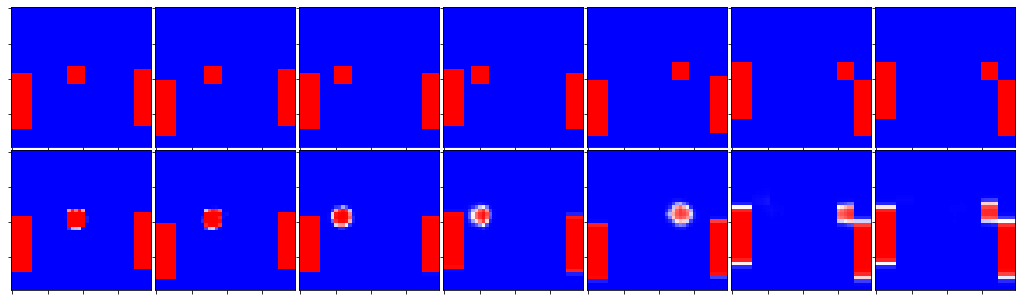

Epoch 762/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0294 - mean_squared_error: 0.0085 - acc: 0.9886 - val_loss: 0.0302 - val_mean_squared_error: 0.0085 - val_acc: 0.9886


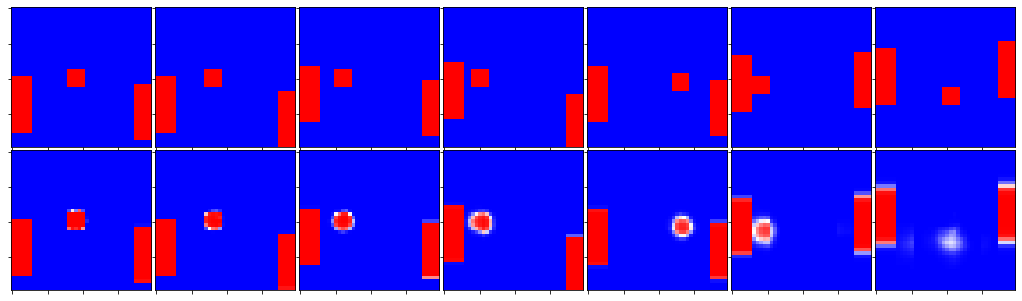

Epoch 763/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0276 - mean_squared_error: 0.0078 - acc: 0.9895 - val_loss: 0.0303 - val_mean_squared_error: 0.0086 - val_acc: 0.9880


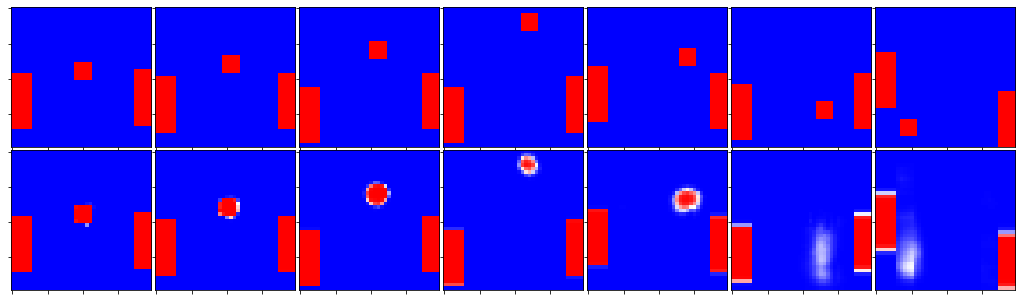

Epoch 764/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0288 - mean_squared_error: 0.0083 - acc: 0.9889 - val_loss: 0.0309 - val_mean_squared_error: 0.0086 - val_acc: 0.9886


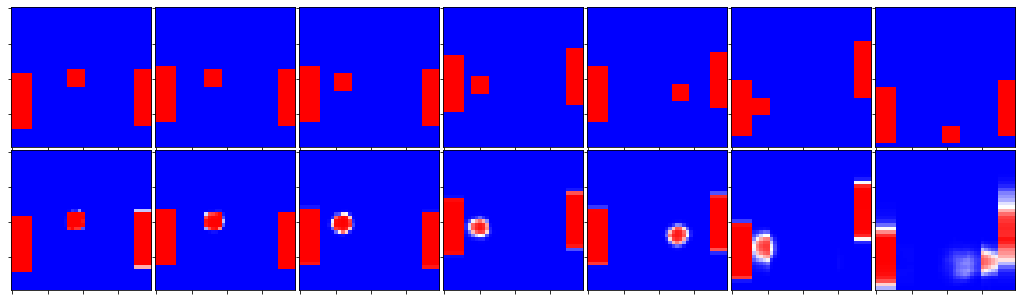

Epoch 765/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0303 - mean_squared_error: 0.0086 - acc: 0.9885 - val_loss: 0.0306 - val_mean_squared_error: 0.0091 - val_acc: 0.9876


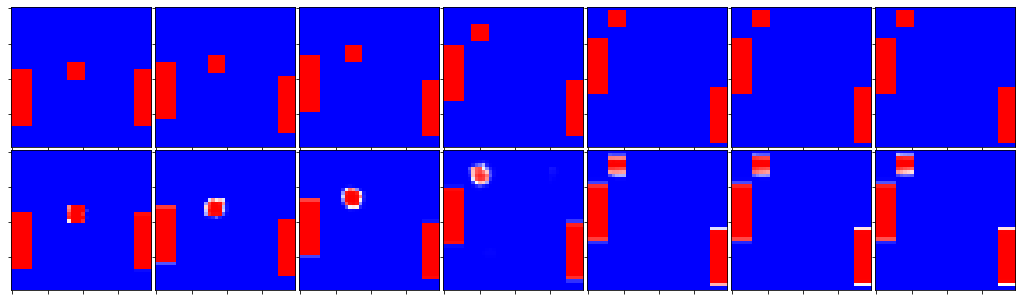

Epoch 766/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0279 - mean_squared_error: 0.0080 - acc: 0.9891 - val_loss: 0.0282 - val_mean_squared_error: 0.0081 - val_acc: 0.9891


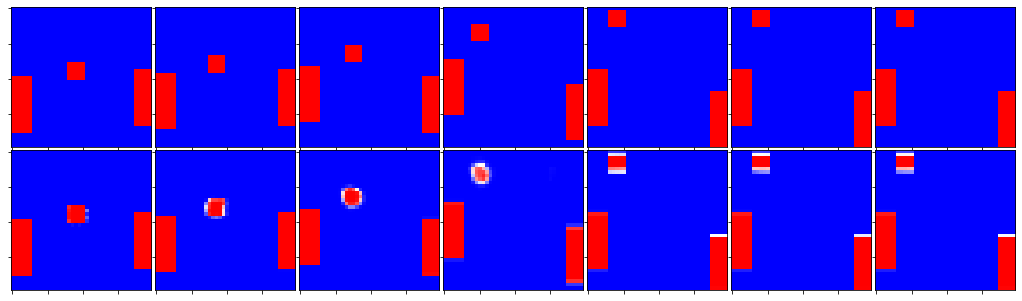

Epoch 767/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0270 - mean_squared_error: 0.0078 - acc: 0.9895 - val_loss: 0.0254 - val_mean_squared_error: 0.0072 - val_acc: 0.9904


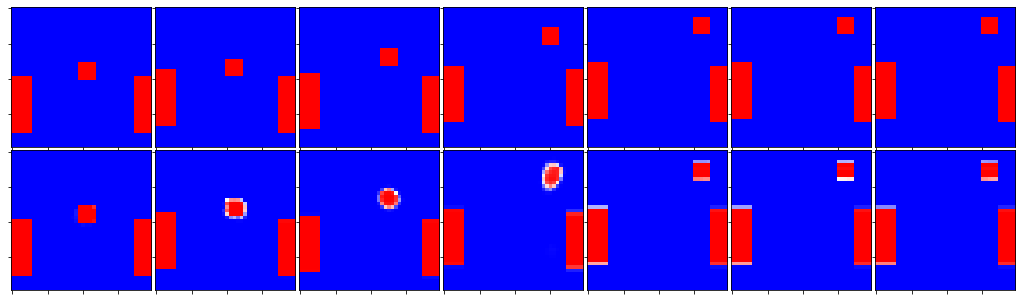

Epoch 768/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.5074 - mean_squared_error: 0.0512 - acc: 0.9442 - val_loss: 0.9922 - val_mean_squared_error: 0.0700 - val_acc: 0.9290


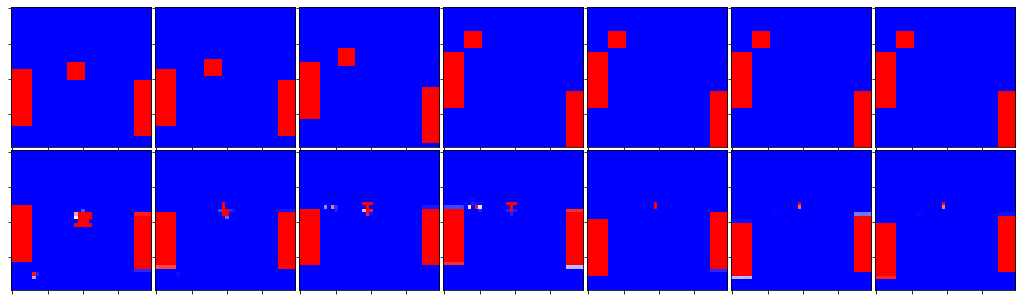

Epoch 769/2500
100/100 [==============================] - 82s 815ms/step - loss: 0.9028 - mean_squared_error: 0.0665 - acc: 0.9319 - val_loss: 0.8949 - val_mean_squared_error: 0.0677 - val_acc: 0.9300


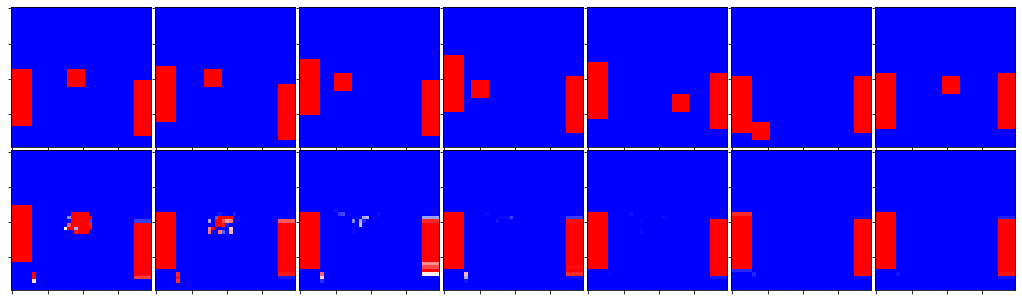

Epoch 770/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.8511 - mean_squared_error: 0.0645 - acc: 0.9332 - val_loss: 0.8647 - val_mean_squared_error: 0.0654 - val_acc: 0.9323


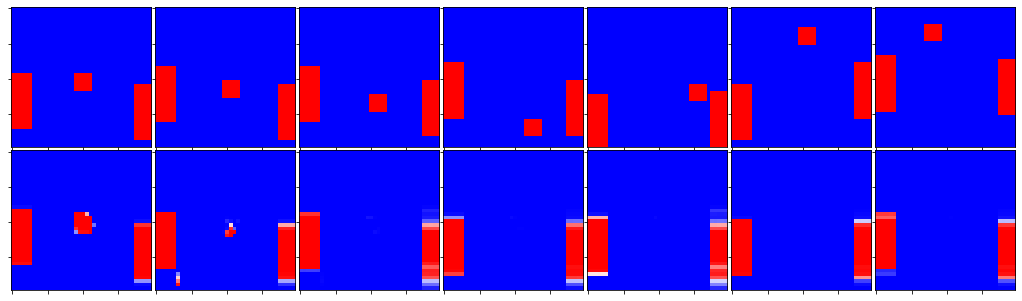

Epoch 771/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.8404 - mean_squared_error: 0.0641 - acc: 0.9334 - val_loss: 0.8595 - val_mean_squared_error: 0.0655 - val_acc: 0.9319


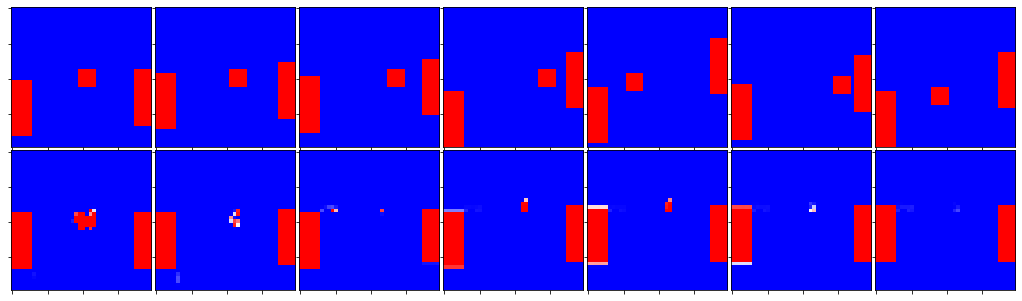

Epoch 772/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.8316 - mean_squared_error: 0.0637 - acc: 0.9337 - val_loss: 0.8400 - val_mean_squared_error: 0.0649 - val_acc: 0.9321


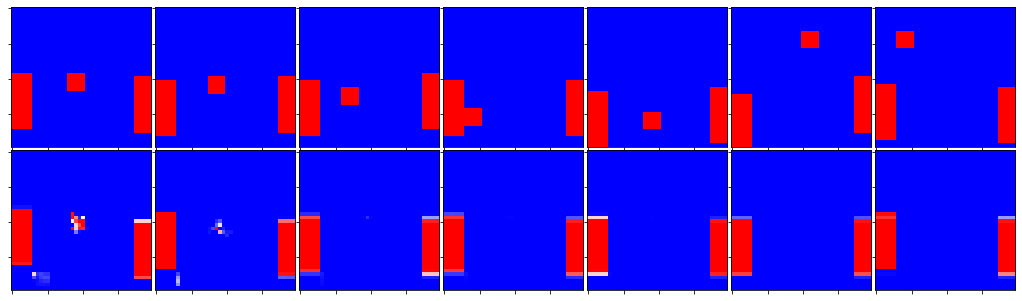

Epoch 773/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.8274 - mean_squared_error: 0.0641 - acc: 0.9332 - val_loss: 0.8318 - val_mean_squared_error: 0.0652 - val_acc: 0.9316


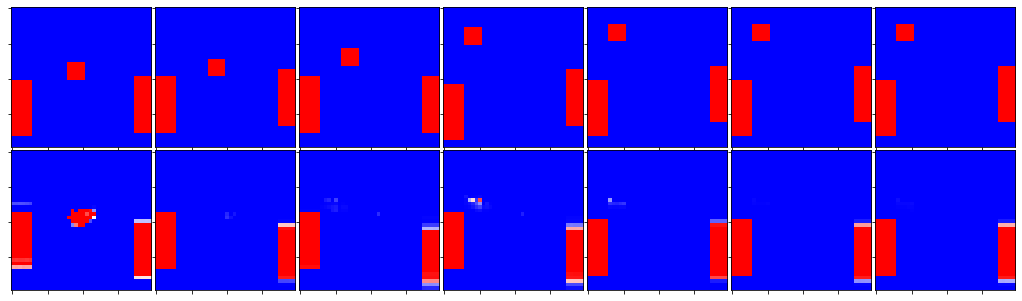

Epoch 774/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.8304 - mean_squared_error: 0.0642 - acc: 0.9331 - val_loss: 0.8376 - val_mean_squared_error: 0.0646 - val_acc: 0.9328


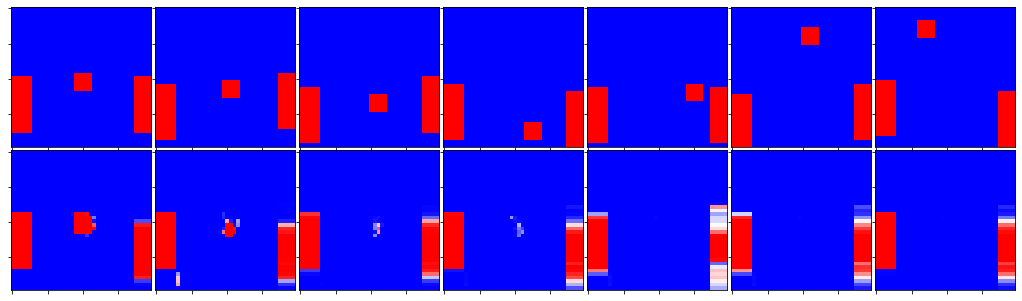

Epoch 775/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.8201 - mean_squared_error: 0.0637 - acc: 0.9335 - val_loss: 0.8243 - val_mean_squared_error: 0.0651 - val_acc: 0.9319


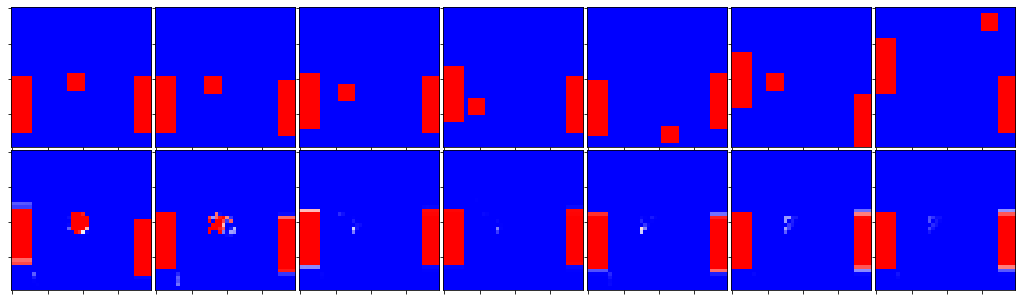

Epoch 776/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.8128 - mean_squared_error: 0.0636 - acc: 0.9335 - val_loss: 0.7768 - val_mean_squared_error: 0.0610 - val_acc: 0.9361


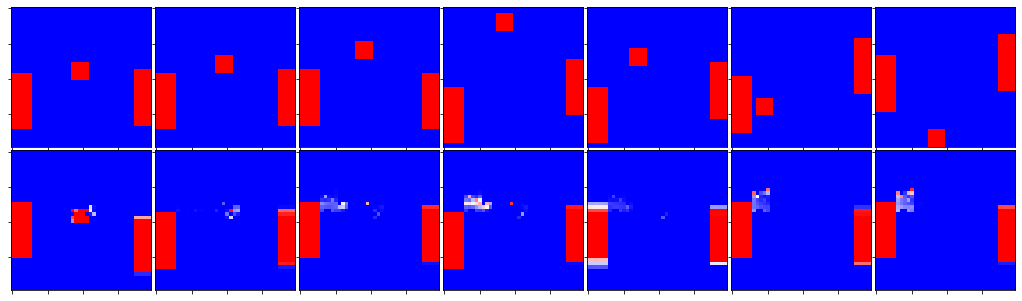

Epoch 777/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.8051 - mean_squared_error: 0.0631 - acc: 0.9339 - val_loss: 0.7902 - val_mean_squared_error: 0.0624 - val_acc: 0.9345


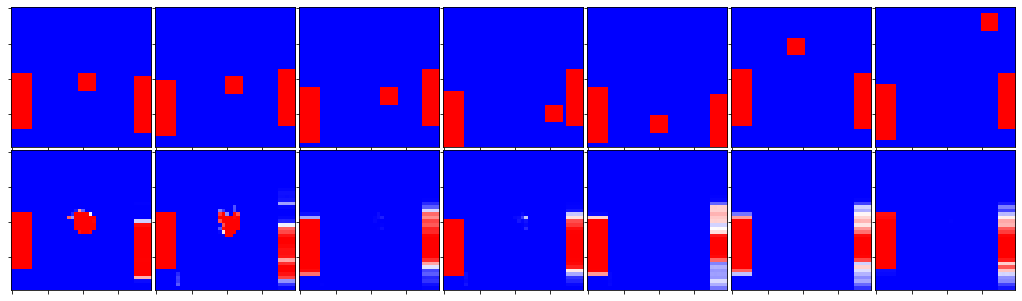

Epoch 778/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.8079 - mean_squared_error: 0.0636 - acc: 0.9334 - val_loss: 0.7825 - val_mean_squared_error: 0.0617 - val_acc: 0.9358


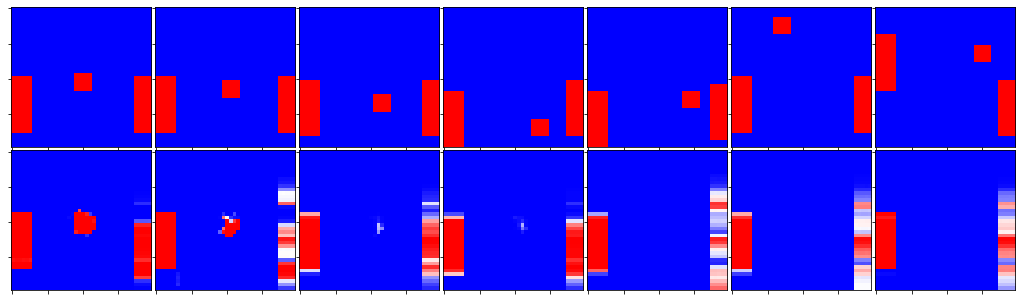

Epoch 779/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.8049 - mean_squared_error: 0.0638 - acc: 0.9331 - val_loss: 0.7508 - val_mean_squared_error: 0.0591 - val_acc: 0.9383


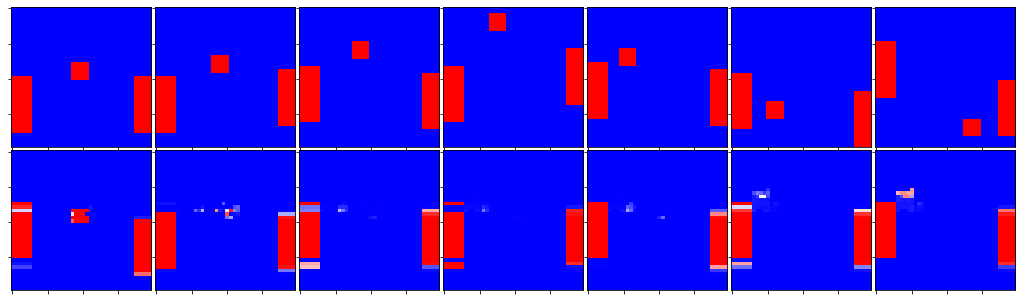

Epoch 780/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.8000 - mean_squared_error: 0.0639 - acc: 0.9329 - val_loss: 0.7972 - val_mean_squared_error: 0.0637 - val_acc: 0.9330


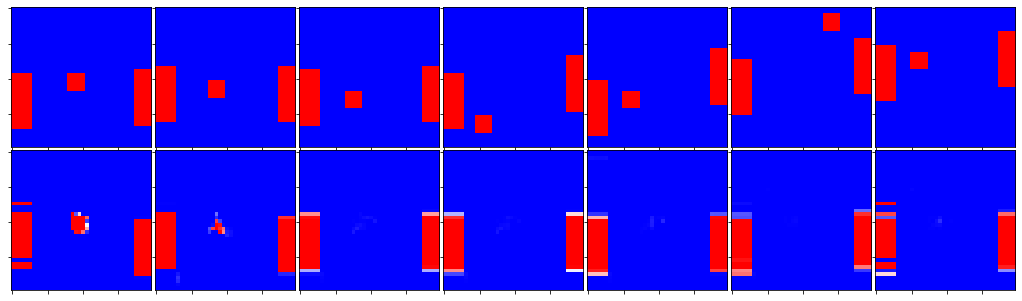

Epoch 781/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.7939 - mean_squared_error: 0.0637 - acc: 0.9331 - val_loss: 0.7541 - val_mean_squared_error: 0.0609 - val_acc: 0.9362


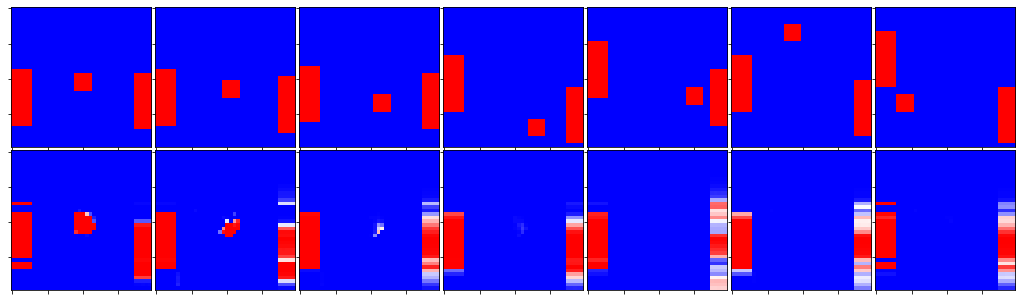

Epoch 782/2500
100/100 [==============================] - 84s 843ms/step - loss: 0.7890 - mean_squared_error: 0.0633 - acc: 0.9334 - val_loss: 0.7596 - val_mean_squared_error: 0.0611 - val_acc: 0.9356


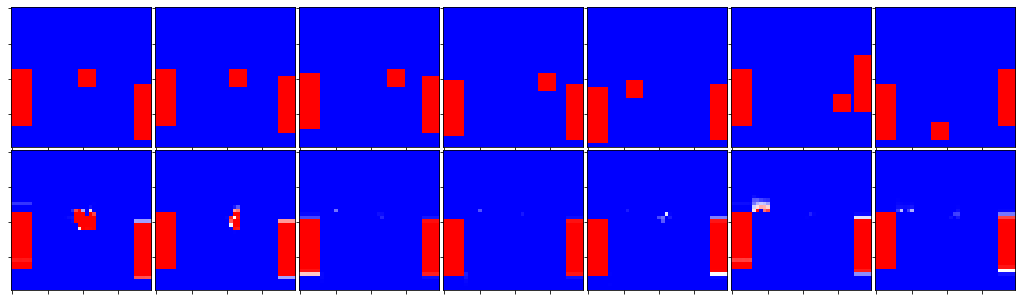

Epoch 783/2500
100/100 [==============================] - 84s 842ms/step - loss: 0.7838 - mean_squared_error: 0.0634 - acc: 0.9332 - val_loss: 0.7748 - val_mean_squared_error: 0.0641 - val_acc: 0.9319


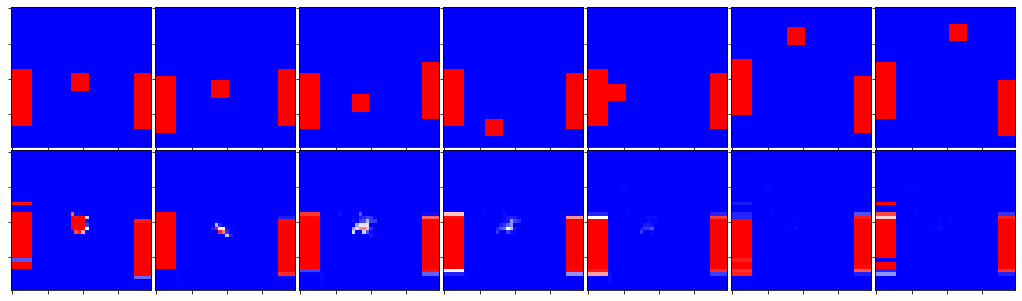

Epoch 784/2500
100/100 [==============================] - 86s 859ms/step - loss: 0.7778 - mean_squared_error: 0.0631 - acc: 0.9334 - val_loss: 0.7823 - val_mean_squared_error: 0.0635 - val_acc: 0.9333


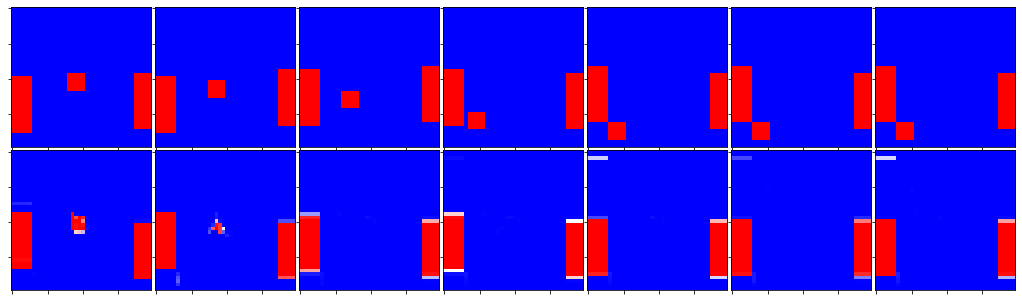

Epoch 785/2500
100/100 [==============================] - 87s 867ms/step - loss: 0.7696 - mean_squared_error: 0.0626 - acc: 0.9340 - val_loss: 0.7807 - val_mean_squared_error: 0.0645 - val_acc: 0.9315


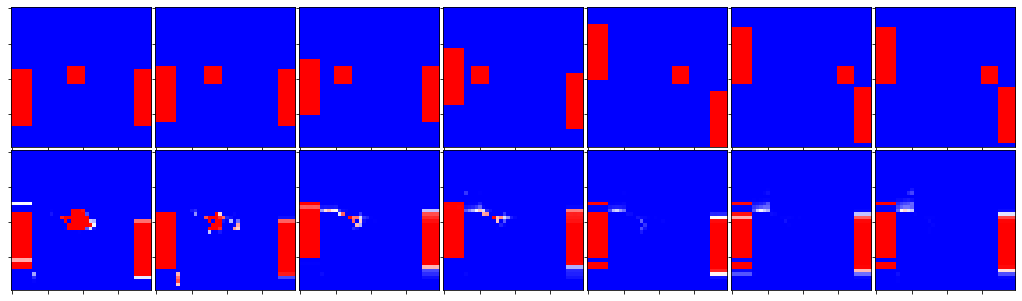

Epoch 786/2500
100/100 [==============================] - 90s 898ms/step - loss: 0.7722 - mean_squared_error: 0.0631 - acc: 0.9333 - val_loss: 0.8076 - val_mean_squared_error: 0.0660 - val_acc: 0.9301


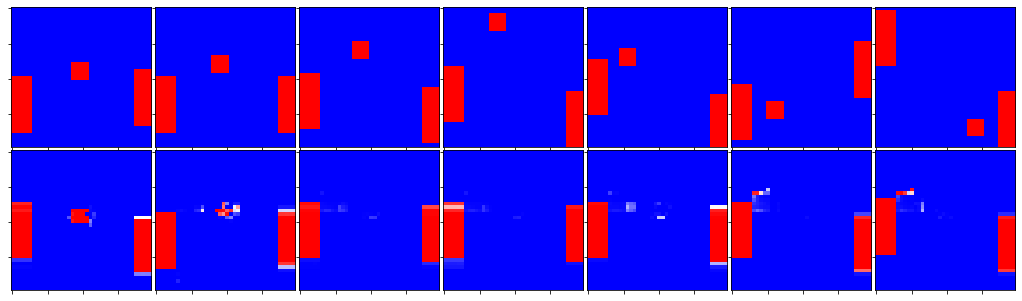

Epoch 787/2500
100/100 [==============================] - 90s 903ms/step - loss: 0.7637 - mean_squared_error: 0.0627 - acc: 0.9337 - val_loss: 0.8191 - val_mean_squared_error: 0.0668 - val_acc: 0.9294


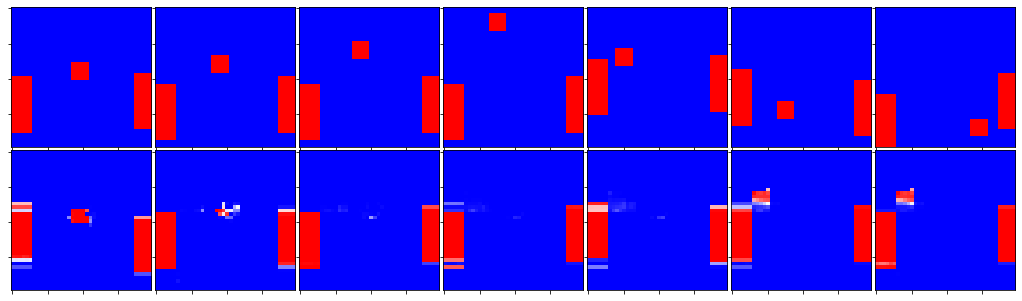

Epoch 788/2500
100/100 [==============================] - 90s 895ms/step - loss: 0.7671 - mean_squared_error: 0.0632 - acc: 0.9331 - val_loss: 0.7557 - val_mean_squared_error: 0.0621 - val_acc: 0.9345


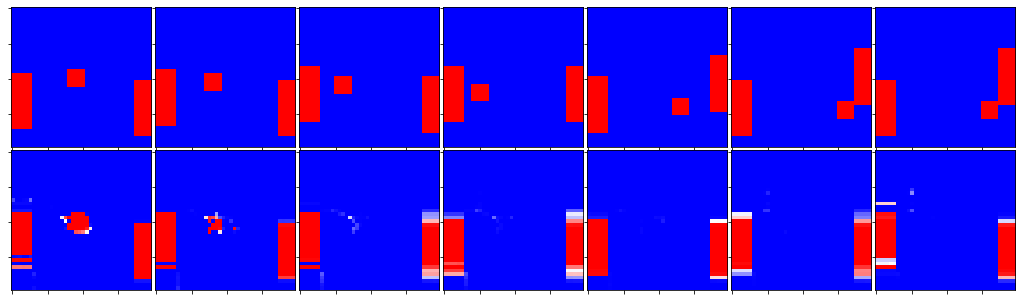

Epoch 789/2500
100/100 [==============================] - 84s 842ms/step - loss: 0.7590 - mean_squared_error: 0.0634 - acc: 0.9328 - val_loss: 0.7491 - val_mean_squared_error: 0.0628 - val_acc: 0.9335


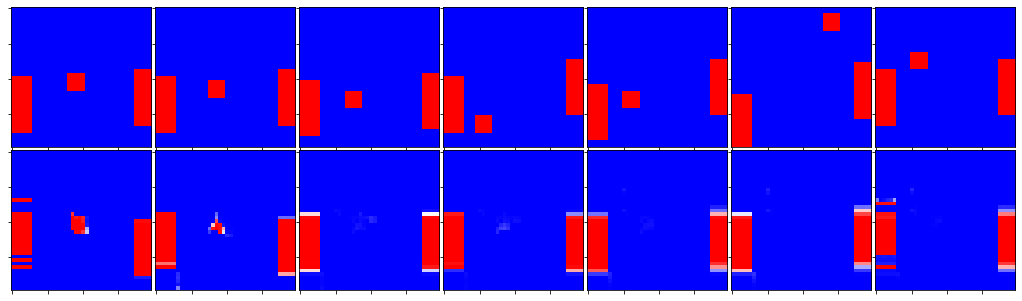

Epoch 790/2500
100/100 [==============================] - 85s 846ms/step - loss: 0.7498 - mean_squared_error: 0.0631 - acc: 0.9330 - val_loss: 0.7103 - val_mean_squared_error: 0.0628 - val_acc: 0.9323


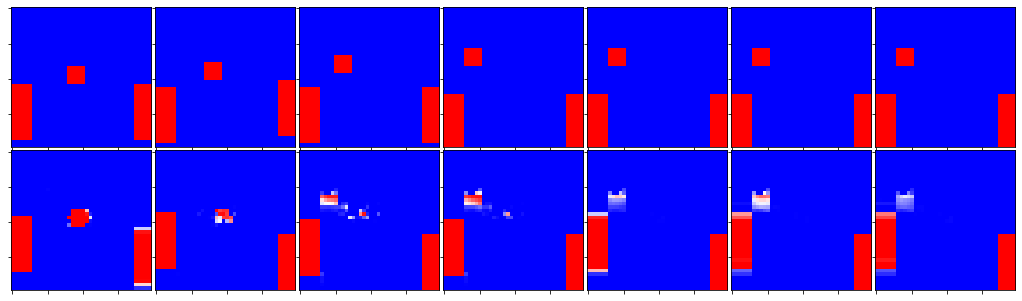

Epoch 791/2500
100/100 [==============================] - 87s 869ms/step - loss: 0.7428 - mean_squared_error: 0.0629 - acc: 0.9331 - val_loss: 0.7911 - val_mean_squared_error: 0.0653 - val_acc: 0.9312


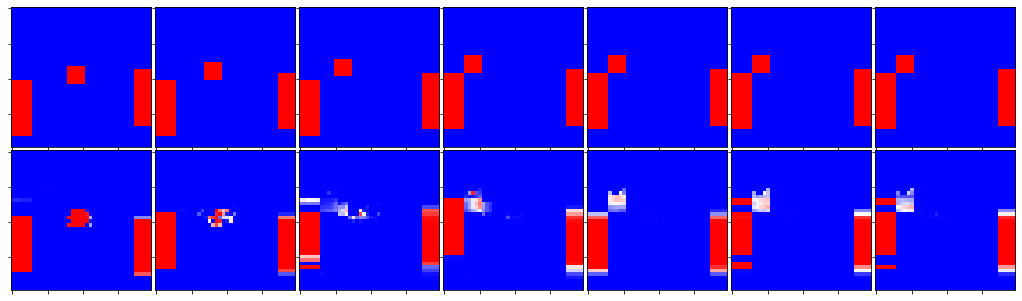

Epoch 792/2500
100/100 [==============================] - 88s 882ms/step - loss: 0.7351 - mean_squared_error: 0.0627 - acc: 0.9331 - val_loss: 0.7561 - val_mean_squared_error: 0.0646 - val_acc: 0.9313


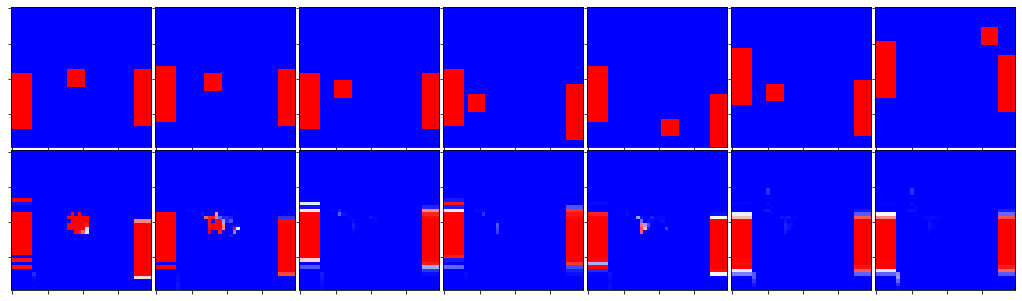

Epoch 793/2500
100/100 [==============================] - 88s 882ms/step - loss: 0.7345 - mean_squared_error: 0.0631 - acc: 0.9327 - val_loss: 0.7584 - val_mean_squared_error: 0.0642 - val_acc: 0.9318


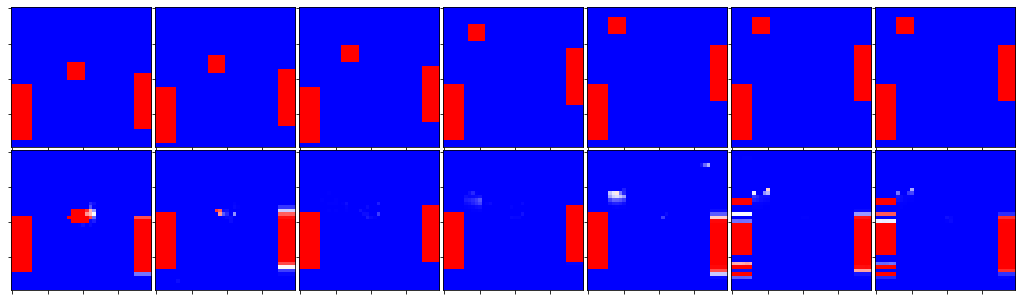

Epoch 794/2500
100/100 [==============================] - 89s 889ms/step - loss: 0.7320 - mean_squared_error: 0.0629 - acc: 0.9328 - val_loss: 0.7213 - val_mean_squared_error: 0.0620 - val_acc: 0.9333


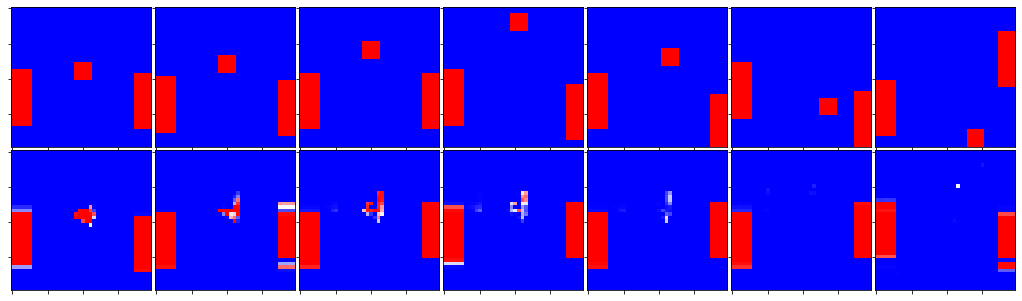

Epoch 795/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.7288 - mean_squared_error: 0.0628 - acc: 0.9330 - val_loss: 0.7243 - val_mean_squared_error: 0.0640 - val_acc: 0.9312


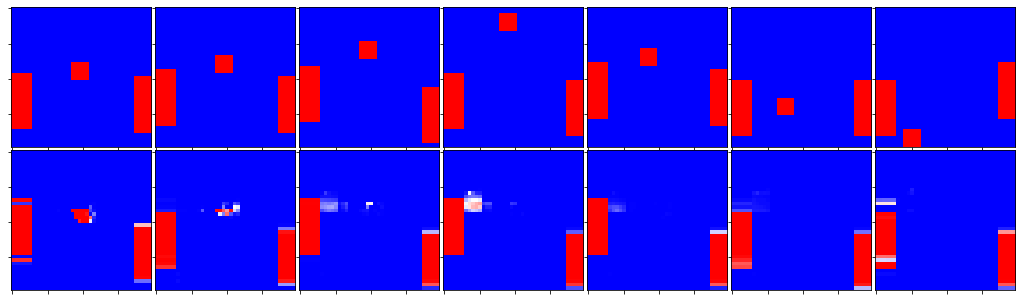

Epoch 796/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.7182 - mean_squared_error: 0.0623 - acc: 0.9334 - val_loss: 0.7051 - val_mean_squared_error: 0.0600 - val_acc: 0.9363


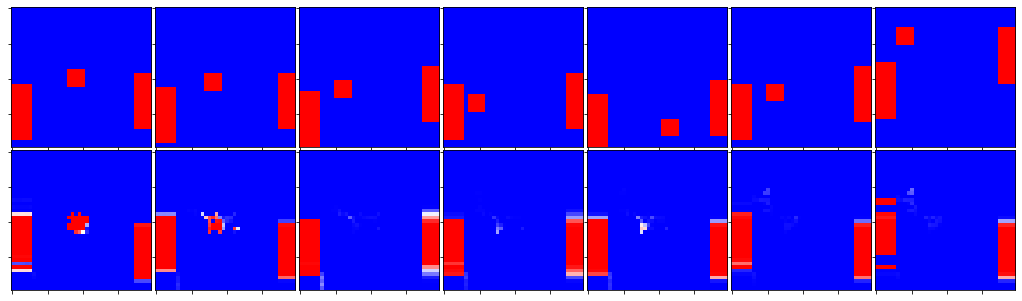

Epoch 797/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.7117 - mean_squared_error: 0.0621 - acc: 0.9333 - val_loss: 0.6932 - val_mean_squared_error: 0.0606 - val_acc: 0.9350


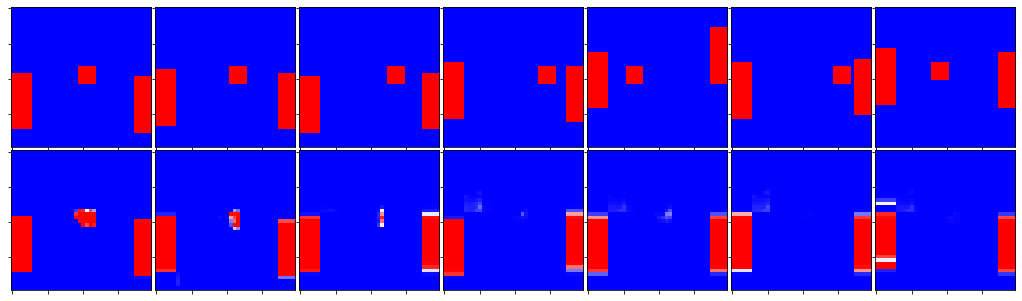

Epoch 798/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.7063 - mean_squared_error: 0.0620 - acc: 0.9335 - val_loss: 0.6584 - val_mean_squared_error: 0.0597 - val_acc: 0.9353


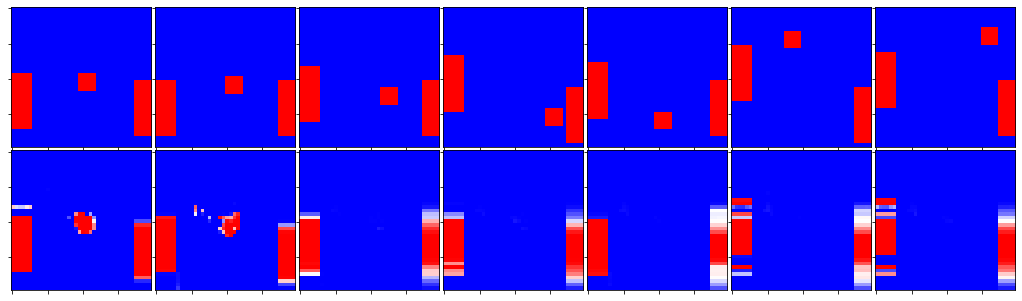

Epoch 799/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.7037 - mean_squared_error: 0.0622 - acc: 0.9331 - val_loss: 0.6920 - val_mean_squared_error: 0.0623 - val_acc: 0.9328


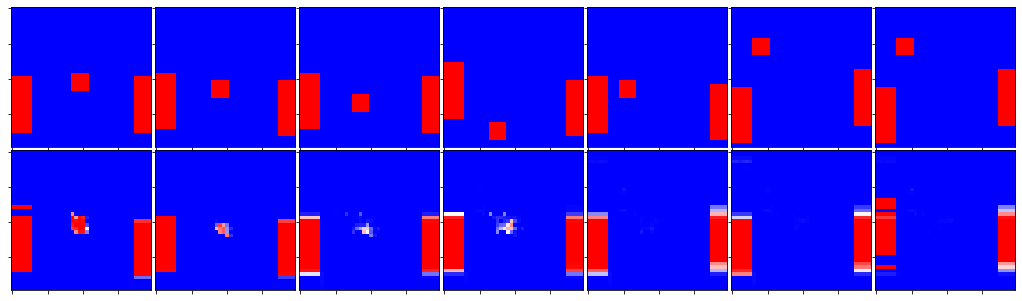

Epoch 800/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.7034 - mean_squared_error: 0.0622 - acc: 0.9332 - val_loss: 0.6934 - val_mean_squared_error: 0.0618 - val_acc: 0.9333


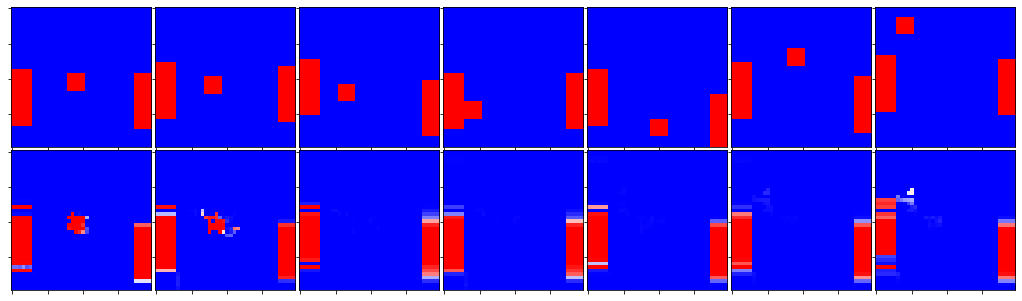

Epoch 801/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.6924 - mean_squared_error: 0.0622 - acc: 0.9329 - val_loss: 0.6770 - val_mean_squared_error: 0.0616 - val_acc: 0.9326


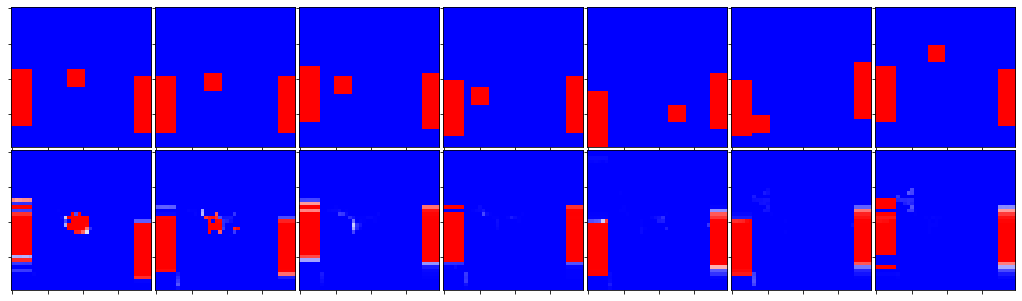

Epoch 802/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.6842 - mean_squared_error: 0.0621 - acc: 0.9328 - val_loss: 0.6791 - val_mean_squared_error: 0.0630 - val_acc: 0.9317


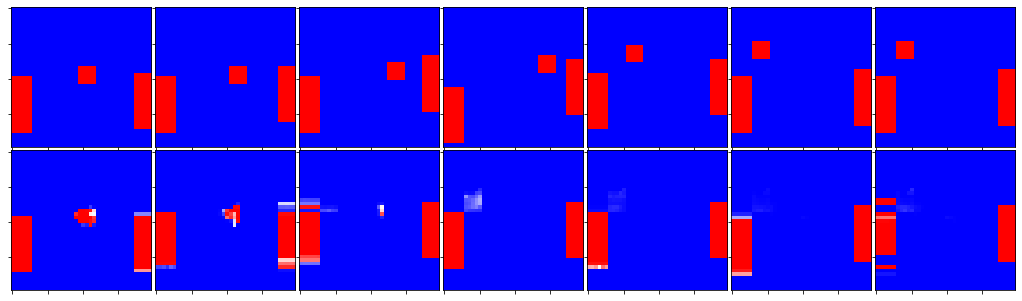

Epoch 803/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.6796 - mean_squared_error: 0.0620 - acc: 0.9327 - val_loss: 0.6561 - val_mean_squared_error: 0.0600 - val_acc: 0.9349


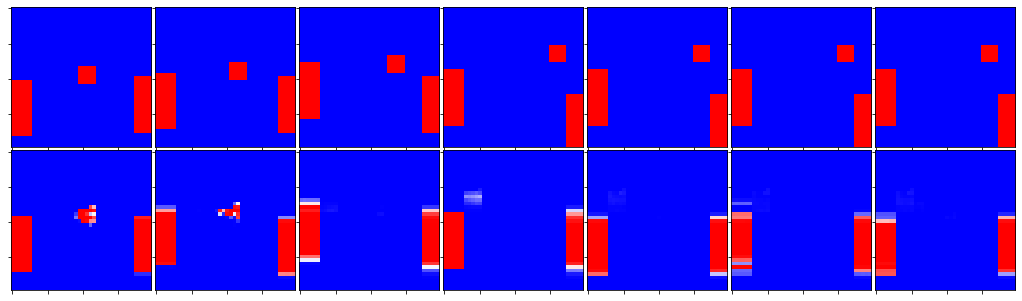

Epoch 804/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.6793 - mean_squared_error: 0.0623 - acc: 0.9324 - val_loss: 0.6489 - val_mean_squared_error: 0.0601 - val_acc: 0.9349


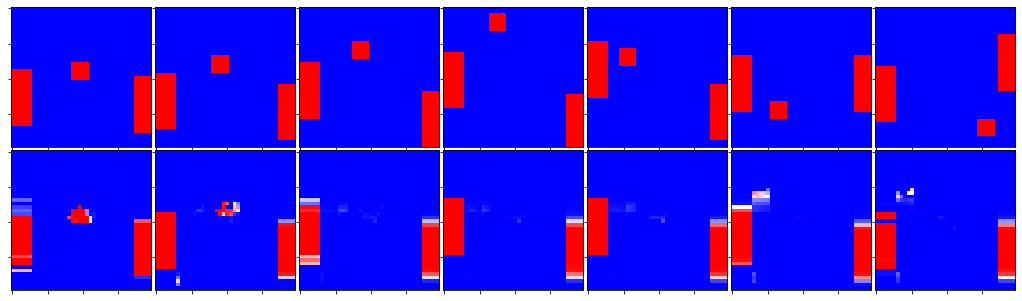

Epoch 805/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.6707 - mean_squared_error: 0.0620 - acc: 0.9325 - val_loss: 0.6474 - val_mean_squared_error: 0.0610 - val_acc: 0.9336


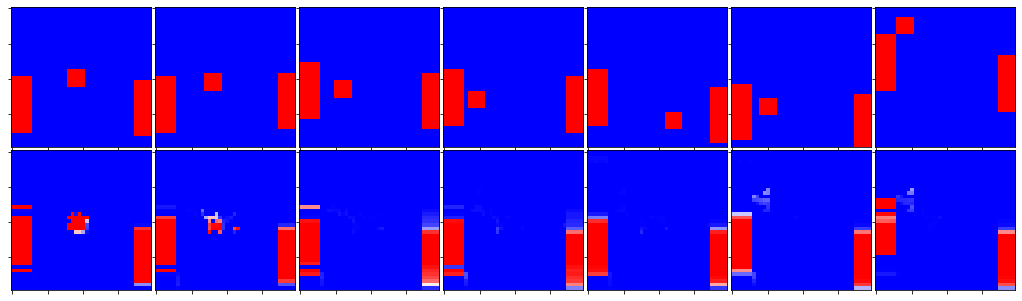

Epoch 806/2500
100/100 [==============================] - 83s 832ms/step - loss: 0.6641 - mean_squared_error: 0.0616 - acc: 0.9330 - val_loss: 0.6398 - val_mean_squared_error: 0.0591 - val_acc: 0.9351


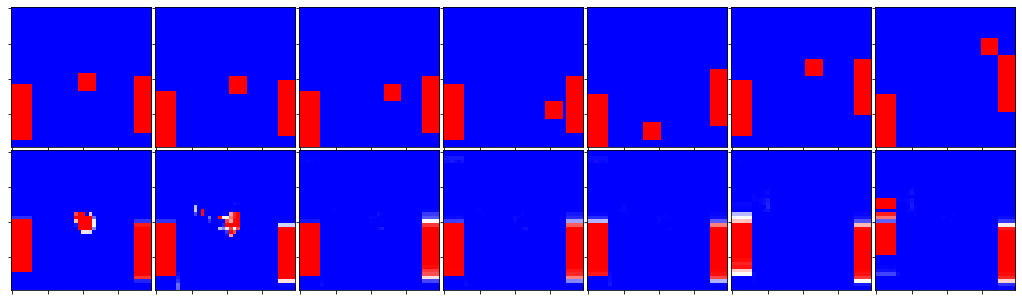

Epoch 807/2500
100/100 [==============================] - 85s 847ms/step - loss: 0.6625 - mean_squared_error: 0.0618 - acc: 0.9325 - val_loss: 0.6487 - val_mean_squared_error: 0.0608 - val_acc: 0.9342


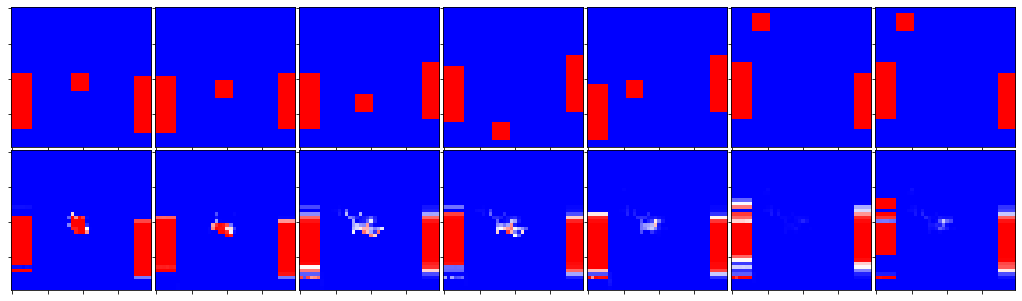

Epoch 808/2500
  6/100 [>.............................] - ETA: 1:17 - loss: 0.6483 - mean_squared_error: 0.0615 - acc: 0.9325

KeyboardInterrupt: 

In [135]:
input_generator = make_dataset(bs=48)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=2500,
    callbacks=[PlotCallback()]
)

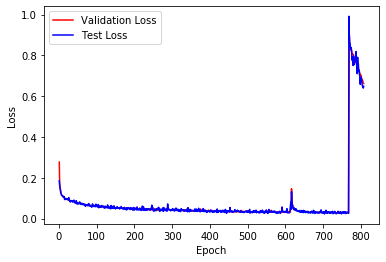

In [136]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# stateful = model.copy_in_stateful_model()
# stateful.init(0.4)
# t = 0
# 
# stateful.net.save('04-LSTM-GRU-32-BINARY_CROSSENTROPY_VERIED_INPUT.hdf5')

In [ ]:
# t += 1
# frame, _ = stateful.single_step_predict([-1, 1])

# plt.imshow(frame > 0.01)
# t